In [2]:
import seaborn as sns
import multiprocessing as mp
import pandas as pd
import tqdm
import time
import copy
import numpy as np
#import MySQLdb
import os
import pickle
import warnings
import matplotlib.pyplot as plt

import pickle
def save_variable(v,filename):
    f=open(filename,'wb')          #打开或创建名叫filename的文档。
    pickle.dump(v,f)               #在文件filename中写入v
    f.close()                      #关闭文件，释放内存。
    return filename

def load_variable(filename):
    try:
        f=open(filename,'rb')
        r=pickle.load(f)
        f.close()
        return r
    except EOFError:
        return ""

pickle_path='/Users/jason/JC/公告数据/'
Factor_total_dict = load_variable(pickle_path+'Factors')


几个bug：

1. 限制不允许卖空，以及其他条件 VS 按照最宽松的条件筛选，最后再进行调整。哪个更好？目前看后者更好，因为这样能最大限度利用信息，

2. 当协方差矩阵非正定的时候，将协方差矩阵进行乘方直到能变成正定(奇数次方，这样方向不变顺序不变），是否是一种可行的方法

3. 输入的参数很小的时候，可能在树模型里面会出现问题，这个时候扩大一定比例就可以减弱这个问题，这是为什么?

对于Y，如果将它进行排序，可能会损失很多的信息，因此最好不排序。目前是直接归一化。

对于X，因为很可能存在很多噪音，并且积少成多，因此直接排序，当然之后也可以尝试其他的方法，比如映射到正态分布上面等等

但是树模型最好不要让X太小，我现在是*10，不然会存在分类完全一致这种会让IC失效的情况

XY的变化对模型本身有非常大的影响，需要谨慎选择。可以先利用最普通的模型进行训练，最后再对结果进行调整

In [2]:
#save_variable(signal_df,'/Users/jason/JC/公告数据/signal_df')

In [3]:
path = '/Users/jason/Desktop/公告类数据/'

In [4]:
signal_df = load_variable(path+'signal_df')
twap_ret = load_variable(path + 'theoretical_rtn_metric')
twap_ret.index = [int(i) for i in twap_ret.index]
twap_ret.columns = [int(i) for i in twap_ret.columns]

In [5]:
'''exer_df = pd.read_excel(path+'股权激励.xlsx')
twap_ret = pd.read_excel(path+'Twap_return.xlsx')
trade_vol = pd.read_excel(path+'交易量.xlsx')
ind_ret = pd.read_excel(path+'指数收益.xlsx')
buy_back_df = pd.read_excel(path+'回购.xlsx')
chg_df = pd.read_excel(path+'股东增持.xlsx')

twap_open = pd.read_excel(path+'TW开盘价.xlsx')
open_price = pd.read_excel(path+'开盘价.xlsx')
close_price = pd.read_excel(path+'收盘价.xlsx')
market_value = pd.read_excel(path+'市值.xlsx')
vwap = pd.read_excel(path+'VWAP.xlsx')

def treat_downloads(df):
    df = df.set_index('Unnamed: 0')
    df.columns = [int(i) for i in df.columns]
    return df
#twap_open = treat_downloads(twap_open)
#open_price = treat_downloads(open_price)
#close_price = treat_downloads(close_price)
#market_value = treat_downloads(market_value)
#vwap = treat_downloads(vwap)
#trade_vol = treat_downloads(trade_vol)
twap_ret = pd.read_excel(path+'Twap_return.xlsx')
twap_ret = treat_downloads(twap_ret)

save_variable(twap_ret,pickle_path + 'twap_ret')
twap_ret = read_variable(pickle_path + 'twap_ret')'''
1

1

# 组合预测

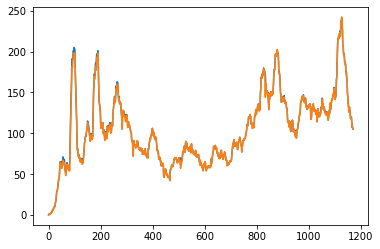

In [6]:
plt.plot(list(signal_df.count()))
plt.plot(list((twap_ret[signal_df.columns]*signal_df).count()))

构造Y，往前延展了60天，往后延展了一些时候

In [7]:
real_ret = twap_ret[signal_df.columns]*signal_df

In [8]:
'''date_input = list(signal_df.columns[66:-30])
for i in date_input:
    bo = real_ret[i].count() == len(model_main_single(Factor_total_dict,
                  real_ret,i,length=60,train_n_predict = train_n_predict_ols)[0])
    print(bo)'''
1

1

In [147]:
def sm_add_constant(testX):
    testX['const'] = np.ones(testX.shape[0])
    return testX


def train_n_predict_pca(trainX, trainY, testX, testY):
    Reg_df_adj=trainX.copy()
    Reg_df_adj['Y']=trainY.copy()
    Reg_df_adj_dropna=Reg_df_adj.dropna(axis=0)
    Y=Reg_df_adj_dropna['Y']
    X=Reg_df_adj_dropna.iloc[:,:-1]
    weights = np.linalg.eig(X.cov())[1]
    
    
    tX=testX
    tX=tX.fillna(0)
    predY = sum([np.dot(tX,weights[i]) for i in range(0,len(weights))])
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = predY
    
    return pred_test_Y,weights

from sklearn import svm
def train_n_predict_svm(trainX, trainY, testX, testY):
    Reg_df_adj=trainX.copy()
    Reg_df_adj['Y']=trainY.copy()
    Reg_df_adj_dropna=Reg_df_adj.dropna(axis=0)
    Y=Reg_df_adj_dropna['Y']
    X=Reg_df_adj_dropna.iloc[:,:-1]
    clf=svm.SVR()  ##默认参数：kernel='rbf'
    clf.fit(X,Y)
    
    tX=testX
    tX=tX.fillna(0)
    predY = clf.predict(tX)
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = predY
    
    return pred_test_Y,clf

def train_n_predict_en(trainX, trainY, testX, testY):
    Reg_df_adj=trainX.copy()
    Reg_df_adj['Y']=trainY.copy()
    Reg_df_adj_dropna=Reg_df_adj.dropna(axis=0)
    Y=Reg_df_adj_dropna['Y']
    X=pd.DataFrame(sm_add_constant(Reg_df_adj_dropna.iloc[:,:-1]))
    model = ElasticNet(random_state=0,alpha=0.001,l1_ratio=0.5)
    model.fit(X, Y) 
    
    tX=pd.DataFrame(sm_add_constant(testX))
    tX=tX.fillna(0)
    predY = model.predict(tX)
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = predY
        
    return pred_test_Y,model

import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
def train_n_predict_en(trainX, trainY, testX, testY):
    Reg_df_adj=trainX.copy()
    Reg_df_adj['Y']=trainY.copy()
    Reg_df_adj_dropna=Reg_df_adj.dropna(axis=0)
    Y=Reg_df_adj_dropna['Y']
    X=pd.DataFrame(sm_add_constant(Reg_df_adj_dropna.iloc[:,:-1]))
    model = ElasticNet(random_state=0,alpha=0.001,l1_ratio=0.5)
    model.fit(X, Y) 
    
    tX=pd.DataFrame(sm_add_constant(testX))
    tX=tX.fillna(0)
    predY = model.predict(tX)
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = predY
        
    return pred_test_Y,model


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

def train_n_predict_lstm(trainX, trainY, testX, testY):
    Reg_df_adj=trainX.copy()
    Reg_df_adj['Y']=trainY.copy()
    Reg_df_adj_dropna=Reg_df_adj.dropna(subset = ['Y']).fillna(0)
    sc = MinMaxScaler(feature_range = (0, 1))
    Reg_df_scaled = sc.fit_transform(Reg_df_adj_dropna)
    
    Y=Reg_df_scaled[:,-1]
    X=Reg_df_scaled[:,:-1]
    X_self = np.reshape(X, (X.shape[0], X.shape[1], 1))
    Y_self = Y
    
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 20, return_sequences = True, input_shape = (X_self.shape[1], 1)))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 20, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 20, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 20))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    model.fit(X_self, Y_self, epochs = 10, batch_size = 64)
    
    testX_scaled = sc.fit_transform(testX)
    X_test = np.reshape(np.array(testX_scaled), (np.array(testX_scaled).shape[0], np.array(testX_scaled).shape[1], 1))
    predicted_Y_scaled = model.predict(X_test)
    predicted_Y = pd.DataFrame(predicted_Y_scaled)
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = predicted_Y[0]
        
    return pred_test_Y.fillna(predicted_Y.mean()),np.nan


reg_xgb_paras_boost = {#'num_round': 5, #不能写num_round这个参数？？？？？？？？？？？？？？？？？？？
                    #'num_boost_round':5,
                    'max_depth': 5,
                    'eta': 0.2,
                    'subsample': 1,  # 随机采样训练样本 训练实例的子采样比
                    #'gamma': 0.15,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1-0.2
                    'reg_lambda': 0.7,  # 0.1控制模型复杂度的权重值的L2正则化项参数
                    'reg_alpha':0.001,
                    'max_delta_step': 0,
                    'colsample_bytree': 0.8,  # 生成树时进行的列采样
                    'booster': 'gbtree',
                    #'tree_method': 'gpu_hist',
                    'objective': 'reg:squarederror',
'subsample':0.8}

reg_xgb_paras ={
        #'num_boost_round': 100,
    #reg_xgb_paras_boost['num_round'],
        'verbose_eval': False,
        #'maximize': False,
        'params': reg_xgb_paras_boost}

params={'booster':'gbtree',
        'nthread':12,
        'objective': 'rank:pairwise',
        'eval_metric':'auc',
        'seed':0,
        'eta': 0.01,
        'gamma':0.1,
        'min_child_weight':1.1,
        'max_depth':5,
        'lambda':10,
        'subsample':0.7,
        'colsample_bytree':0.7,
        'colsample_bylevel':0.7,
        'tree_method':'exact'
        }

params_empty={}

def train_n_predict_xgb3(trainX, trainY, testX, testY):
    import xgboost as xgb
    
    train_xgb = xgb.DMatrix(data=trainX, label=trainY.replace([-np.inf,np.inf],[0,0]).fillna(0))
    test_xgb = xgb.DMatrix(data=testX, label=testY.replace([-np.inf,np.inf],[0,0]).fillna(0))
    
    #XgbTree = xgb.train(**reg_xgb_paras,dtrain=train_xgb,num_boost_round=1000)
    #XgbTree = xgb.train(params,train_xgb,num_boost_round=1000)
    XgbTree = xgb.train(params_empty,train_xgb)
    
    pred_test_y = np.array(XgbTree.predict(test_xgb, ntree_limit=XgbTree.best_ntree_limit))
    
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = pred_test_y
    
    return pred_test_Y, XgbTree

def train_n_predict_xgb1(trainX, trainY, testX, testY):
    import xgboost as xgb
    
    train_xgb = xgb.DMatrix(data=trainX, label=trainY.replace([-np.inf,np.inf],[0,0]).fillna(0))
    test_xgb = xgb.DMatrix(data=testX, label=testY.replace([-np.inf,np.inf],[0,0]).fillna(0))
    
    XgbTree = xgb.train(**reg_xgb_paras,dtrain=train_xgb,num_boost_round=1000)
    #XgbTree = xgb.train(params,train_xgb,num_boost_round=1000)
    #XgbTree = xgb.train(params_empty,train_xgb)
    
    pred_test_y = np.array(XgbTree.predict(test_xgb, ntree_limit=XgbTree.best_ntree_limit))
    
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = pred_test_y
    
    return pred_test_Y, XgbTree

def train_n_predict_xgb2(trainX, trainY, testX, testY):
    import xgboost as xgb
    
    train_xgb = xgb.DMatrix(data=trainX, label=trainY.replace([-np.inf,np.inf],[0,0]).fillna(0))
    test_xgb = xgb.DMatrix(data=testX, label=testY.replace([-np.inf,np.inf],[0,0]).fillna(0))
    
    #XgbTree = xgb.train(**reg_xgb_paras,dtrain=train_xgb,num_boost_round=1000)
    XgbTree = xgb.train(params,train_xgb,num_boost_round=1000)
    #XgbTree = xgb.train(params_empty,train_xgb)
    
    pred_test_y = np.array(XgbTree.predict(test_xgb, ntree_limit=XgbTree.best_ntree_limit))
    
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = pred_test_y
    
    return pred_test_Y, XgbTree

import statsmodels.api as sm
def train_n_predict_ols(trainX, trainY, testX, testY):
    Reg_df_adj=trainX.copy()
    Reg_df_adj['Y']=trainY.copy()
    Reg_df_adj_dropna=Reg_df_adj.dropna(axis=0)
    Y=Reg_df_adj_dropna['Y']
    X=pd.DataFrame(sm_add_constant(Reg_df_adj_dropna.iloc[:,:-1]))
    model = sm.OLS(Y, X).fit() 
    
    tX=pd.DataFrame(sm_add_constant(testX))
    tX=tX.fillna(0)
    predY = model.predict(tX)
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = predY
        
    return pred_test_Y,model

def train_n_predict_ew(trainX, trainY, testX, testY):
    pred_test = testX.mean(axis = 1)
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = pred_test
    model = np.nan
    return pred_test_Y,model

def train_n_predict_ols(trainX, trainY, testX, testY):
    #print(testY)
    Reg_df_adj=trainX.copy()
    Reg_df_adj['Y']=trainY.copy()
    Reg_df_adj_dropna=Reg_df_adj.dropna(axis=0)
    Y=Reg_df_adj_dropna['Y']
    X=pd.DataFrame(sm_add_constant(Reg_df_adj_dropna.iloc[:,:-1]))
    model = sm.OLS(Y, X).fit() 
    
    tX=pd.DataFrame(sm_add_constant(testX))
    tX=tX.fillna(0)
    predY = model.predict(tX)
    pred_test_Y = testY.copy(deep=True)
    #print(pred_test_Y)
    pred_test_Y.iloc[:] = predY
        
    return pred_test_Y,model


def train_n_predict_his(trainX, trainY, testX, testY):
    trainY_mean = trainY.unstack().mean()
    
    testY_df = testY.unstack()
    a=[list(trainY_mean)]
    test_pred_df = pd.DataFrame(a*len(testY_df),columns = testY_df.columns,index = testY_df.index)
    
    predY = test_pred_df.stack()
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = predY
     
    model = np.nan
    return pred_test_Y,model


from sklearn.ensemble import RandomForestRegressor
def train_n_predict_rf(trainX, trainY, testX, testY):
    estimator=RandomForestRegressor(n_estimators=100,
                                    max_depth=5,min_samples_split=5,max_leaf_nodes=20,
                                    oob_score=True,random_state=1)
    Reg_df_adj=trainX.copy()
    Reg_df_adj['Y']=trainY.copy()
    Reg_df_adj_dropna=Reg_df_adj.dropna(axis=0)
    Y=Reg_df_adj_dropna['Y']
    X=Reg_df_adj_dropna.iloc[:,:-1]
    
    estimator.fit(X,Y)
    
    test_adj=testX.fillna(0)
    predY = estimator.predict(test_adj)
    
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = predY
 
    return pred_test_Y,estimator

from sklearn.neighbors import KNeighborsRegressor
def train_n_predict_knn(trainX, trainY, testX, testY):
    Reg_df_adj=trainX.copy()
    Reg_df_adj['Y']=trainY.copy()
    Reg_df_adj_dropna=Reg_df_adj.dropna(axis=0)
    Y=Reg_df_adj_dropna['Y']
    X=Reg_df_adj_dropna.iloc[:,:-1]
    #print(X.shape)
    knn = KNeighborsRegressor()
    knn.fit(X,Y)
    test_adj=testX.fillna(0)
    #print(test_adj.shape)
    predY = knn.predict(test_adj)
    pred_test_Y = testY.copy(deep=True)
    pred_test_Y.iloc[:] = predY
   
    return pred_test_Y,knn


训练用模型

In [148]:
def get_train_df(date,factor,length=60):
    daily_index = list(real_ret[date].dropna().index)
    posi_temp = list(factor.columns).index(date)
    return factor.loc[daily_index].iloc[:,posi_temp-length:posi_temp+1]

def get_factor_data(factor_data_dict, Return,factor_method='raw'):

    def transform_to_2d(pqidata):
        shape = (pqidata.shape[1]*pqidata.shape[2], pqidata.shape[0])
        return pqidata.transpose((2, 1, 0)).reshape(shape)

    factor_dict = {}

    for fac_name in factor_data_dict.keys():
        if factor_method == 'raw':
            factor_dict[fac_name] = factor_data_dict[fac_name]
        elif factor_method == 'linear':
            factor_dict[fac_name] = factor_data_dict[fac_name].rank(pct=True) - 0.5
        else:
            factor_dict[fac_name] = factor_data_dict[fac_name]

    idx = list(factor_data_dict.values())[0].unstack().index
    factor_data = pd.DataFrame(transform_to_2d(pqidata=np.array(list(factor_dict.values()))))
    factor_data.columns = factor_data_dict.keys()
    factor_data.index = idx
    #.rank(pct=True)-0.5
    Return_stacked = ((Return-Return.min())/(Return.max()-Return.min())-0.5).T.stack(dropna=False)

    return factor_data,Return_stacked

def get_Xdata_Y(factor_sta, return_sta, date_list):
    YData = return_sta.loc[date_list]
    XData = factor_sta.loc[date_list]
    return XData, YData


#输入rawdata，就是一个dict一个return_df，然后是date（需要预测的日期），以及训练的长度（目前是60天），训练函数
def model_main_single(factor_dict,return_df,date=20180102,length=60,train_n_predict=train_n_predict_xgb1):
    
    factor_part_dict = {i:get_train_df(date,factor_dict[i],length) for i in factor_dict}
    return_part_df = get_train_df(date,return_df,length)
    
    factor_part_sta,return_part_sta = get_factor_data(factor_part_dict, return_part_df,factor_method='linear')
    train_test_date = list(return_part_df.columns)
    #split_loc = int(len(train_test_date)*0.7)
    train_date = train_test_date[:-1]
    test_date = train_test_date[-1]
    #print(test_date)
    #print(train_date)
    #print(test_date)
    trainX, trainY = get_Xdata_Y(factor_part_sta, return_part_sta, train_date)
    testX, testY = get_Xdata_Y(factor_part_sta, return_part_sta, test_date)
    pred_test_Y,model = train_n_predict(trainX, trainY, testX, testY)

    #print(return_part_df.columns)
    return pred_test_Y, model

def main_loop(date_list,factor_dict,return_df,length,train_n_predict = 1):
    prediction_dict = {}
    model_dict = {}
    for i in tqdm.tqdm(range(0,len(date_list))):
        print(date_list[i])
        pred_test_Y, model = model_main_single(factor_dict,return_df,date_list[i],length,train_n_predict)
        print(pred_test_Y)
        prediction_dict[date_list[i]] = pred_test_Y
        model_dict[date_list[i]] = model
    return prediction_dict,model_dict

date_input = real_ret.columns[60:-20]
def train_model(train_n_predict_ols):
    pred_ols,mod_ols = main_loop(date_input,Factor_total_dict,
                      real_ret,length=60,train_n_predict = train_n_predict_ols)
    '''ic_lst = []
    for i in range(0,len(date_input)):
        ic = pd.DataFrame([pred_ols[date_input[i]],real_ret[date_input[i]].dropna()]).T.corr().iloc[1,0]
        ic_lst.append(ic)
    plt.plot([len(pred_ols[i]) for i in pred_ols])
    plt.show()
    plt.plot(ic_lst)
    plt.show()
    print(np.mean(ic_lst))'''
    return pred_ols,mod_ols
    

In [ ]:
real_ret.columns[60:-20]

循环进行预测

组合权重优化

In [149]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

def port_opt(Return,Return_forcast_dict,is_co = False):
    #cov_mat = twap_ret.iloc[:,:1460].loc[Factor_total_dict[list(Factor_total_dict.keys())[0]].index].T.cov()
    #cov_mat = Return.T.cov()
    #variance = cov_mat
    #weight_bounds可以调整是否允许卖空
    weights_dict = {}
    date_list = list(Return_forcast_dict.keys())
    for i in tqdm.tqdm(range(0,len(Return_forcast_dict.keys()))):
        stock_list = list(Return_forcast_dict[date_list[i]].index)
        mean = Return_forcast_dict[date_list[i]]
        #if is_co:
        #    ef = EfficientFrontier(mean, variance,weight_bounds=(0, 0.5))
        #    print(1)
        #else:
        date_index = list(Return.columns).index(date_list[i])
        partial_ret = Return.loc[stock_list].iloc[:,(date_index-60):date_index]
        partial_ret = partial_ret.T.fillna(partial_ret.mean(axis=1)).T.fillna(0)
        variance = partial_ret.T.cov()
        
        for j in range(1,10,2):
            try:
                ef = EfficientFrontier(mean,variance**j,weight_bounds=(-1, 1))
                weight = ef.max_sharpe(risk_free_rate=0.001)
                weight_df = pd.DataFrame(weight,index=['Weight'])
                print(j)
                break
            except:
                if j == 9:
                    print('Error '+str(date_list[i]))
                    weight_df = pd.DataFrame(np.ones(len(stock_list))*(1/len(stock_list)),index = stock_list,columns = ['Weight']).T
                continue
            '''try:
                ef = EfficientFrontier(mean,variance**2,weight_bounds=(-1, 1))
                weight = ef.max_sharpe(risk_free_rate=0.001)
                weight_df = pd.DataFrame(weight,index=['Weight'])
            except:
                try:
                    ef = EfficientFrontier(mean,variance**3,weight_bounds=(-1, 1))
                    weight = ef.max_sharpe(risk_free_rate=0.001)
                    weight_df = pd.DataFrame(weight,index=['Weight'])
                except:
                    print('Error '+str(date_list[i]))
                    weight_df = pd.DataFrame(np.ones(len(stock_list))*(1/len(stock_list)),index = stock_list,columns = ['Weight']).T'''
        #print(list(Return_forcast_dict.keys())[i])
        weights_dict[list(Return_forcast_dict.keys())[i]] = weight_df
    
    return weights_dict
    '''weights_df = pd.concat(weights)
    weights_df.rolling(window=20).mean().plot(figsize=(14,4))
    plt.show()

    Return_port = (weights_df * Return.T).sum(axis=1)
    Return_port.cumsum().plot(figsize=(14,4))
    plt.show()
    
    return weights_df'''

权重优化循环

In [150]:
def portfolio_calculator(pred_ols):
    wd = port_opt(real_ret,pred_ols,is_co = False)
    Ret_all_ew = []
    for i in wd.keys():
        Ret_all_ew.append((real_ret.loc[wd[i].columns][i]).mean())
    for i in wd:
        t = wd[i]
        t[t<=0] = 0
        wd[i] = t/float(np.sum(t,axis=1))
    Ret_all = []
    for i in wd.keys():
        Ret_all.append(((real_ret.loc[wd[i].columns][i]) * (wd[i].loc['Weight'])).sum())
    plt.figure(figsize=(15,8))
    plt.plot(list(pd.DataFrame(Ret_all).cumsum()[0]),color = 'blue')
    plt.plot(list(pd.DataFrame(Ret_all_ew).cumsum()[0]),color = 'red')
    plt.legend(['OLS+MV_OPT','Equal Weight'])
    plt.show()
    
    return wd,Ret_all

In [151]:
pred_lstm,mod_lstm = train_model(train_n_predict_lstm)

  0%|          | 0/1090 [00:00<?, ?it/s]

20180102
Epoch 1/10
11/11 [==============================] - 6s 43ms/step - loss: 0.1840
Epoch 2/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0735
Epoch 3/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0702
Epoch 4/10
11/11 [==============================] - 0s 38ms/step - loss: 0.0675
Epoch 5/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0671
Epoch 6/10
11/11 [==============================] - 0s 38ms/step - loss: 0.0662
Epoch 7/10
11/11 [==============================] - 0s 42ms/step - loss: 0.0654
Epoch 8/10
11/11 [==============================] - 0s 41ms/step - loss: 0.0626
Epoch 9/10
11/11 [==============================] - 0s 42ms/step - loss: 0.0668
Epoch 10/10
2/2 [==============================] - 1s 15ms/step


  0%|          | 1/1090 [00:12<3:43:54, 12.34s/it]

8         0.518729
402       0.463363
415       0.535810
599       0.523654
687       0.505564
            ...   
603311    0.529421
603569    0.516702
603679    0.460750
603839    0.489760
603843         NaN
Length: 64, dtype: float32
20180103
Epoch 1/10
11/11 [==============================] - 6s 43ms/step - loss: 0.0961
Epoch 2/10
11/11 [==============================] - 0s 38ms/step - loss: 0.0715
Epoch 3/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0673
Epoch 4/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0652
Epoch 5/10
11/11 [==============================] - 0s 42ms/step - loss: 0.0670
Epoch 6/10
11/11 [==============================] - 0s 40ms/step - loss: 0.0661
Epoch 7/10
11/11 [==============================] - 0s 44ms/step - loss: 0.0669
Epoch 8/10
11/11 [==============================] - 0s 42ms/step - loss: 0.0651
Epoch 9/10
11/11 [==============================] - 0s 42ms/step - loss: 0.0641
Epoch 10/10
2/2 [==================

  0%|          | 2/1090 [00:24<3:46:02, 12.47s/it]

8         0.488608
402       0.454096
415       0.487928
599       0.503222
687       0.494382
            ...   
603168         NaN
603569    0.506458
603679    0.461163
603839    0.463960
603843         NaN
Length: 63, dtype: float32
20180104
Epoch 1/10
11/11 [==============================] - 7s 45ms/step - loss: 0.1496
Epoch 2/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0701
Epoch 3/10
11/11 [==============================] - 0s 41ms/step - loss: 0.0651
Epoch 4/10
11/11 [==============================] - 0s 40ms/step - loss: 0.0652
Epoch 5/10
11/11 [==============================] - 0s 40ms/step - loss: 0.0649
Epoch 6/10
11/11 [==============================] - 0s 40ms/step - loss: 0.0652
Epoch 7/10
11/11 [==============================] - 0s 40ms/step - loss: 0.0645
Epoch 8/10
11/11 [==============================] - 0s 40ms/step - loss: 0.0646
Epoch 9/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0643
Epoch 10/10
2/2 [==================

  0%|          | 3/1090 [00:38<3:56:12, 13.04s/it]

8         0.476358
402       0.498265
415       0.493618
599       0.458008
821       0.451927
863            NaN
890       0.481098
1696           NaN
2007      0.483060
2065      0.452352
2073      0.441422
2076           NaN
2146      0.476253
2229      0.465724
2239      0.431448
2316      0.449572
2340      0.452353
2342      0.441885
2406      0.447806
2452      0.464246
2581      0.496779
2756           NaN
300048    0.430955
300096    0.432352
300197    0.408328
300217    0.457488
300270    0.444803
300344    0.433680
300376         NaN
300387    0.465298
300426    0.440188
300445    0.460470
300470    0.448436
300515    0.470591
300612         NaN
300687    0.461321
600057         NaN
600090    0.446688
600161         NaN
600163    0.455075
600212    0.475783
600228    0.477076
600356    0.479501
600366    0.460270
600461    0.448107
600512    0.426416
600545    0.426526
600551    0.467157
600679    0.496109
600751    0.462632
600836    0.476024
600844    0.489822
600863    0.

  0%|          | 4/1090 [00:50<3:45:16, 12.45s/it]

8              NaN
402            NaN
415            NaN
599            NaN
821            NaN
863            NaN
1696           NaN
2007           NaN
2065           NaN
2073           NaN
2146           NaN
2229           NaN
2239           NaN
2316           NaN
2340           NaN
2342           NaN
2406           NaN
2452           NaN
2576           NaN
2581           NaN
2756           NaN
300096         NaN
300197         NaN
300270         NaN
300272         NaN
300344         NaN
300376         NaN
300387         NaN
300426         NaN
300445         NaN
300470         NaN
300515         NaN
300612         NaN
300687         NaN
600057         NaN
600090         NaN
600161         NaN
600163         NaN
600228         NaN
600319         NaN
600356         NaN
600366         NaN
600461         NaN
600512         NaN
600551         NaN
600679         NaN
600751    0.426228
600836         NaN
600844    0.432610
600863         NaN
600896    0.486957
603168         NaN
603679      

  0%|          | 5/1090 [01:05<4:01:50, 13.37s/it]

8         0.380703
402       0.411402
415       0.403468
599       0.396021
821       0.369523
863            NaN
1696           NaN
2007      0.413031
2073      0.400239
2146      0.418787
2229      0.389544
2316      0.381786
2340      0.398000
2342      0.429783
2406      0.399072
2452      0.447210
2576           NaN
2581      0.411645
2756           NaN
300096    0.361294
300197    0.350703
300270    0.387452
300272         NaN
300344    0.394591
300376         NaN
300387    0.460239
300426    0.379617
300445    0.433978
300470    0.388961
300515    0.439537
300612         NaN
300687    0.365595
600057         NaN
600161         NaN
600228    0.431053
600319    0.391961
600356    0.420989
600366    0.393767
600461    0.377355
600469         NaN
600512    0.425933
600551    0.421628
600679    0.439779
600715         NaN
600751    0.373039
600836    0.414977
600844    0.405572
600863    0.425569
600896    0.430179
603168         NaN
603679    0.393419
603839    0.393339
603843    0.

  1%|          | 6/1090 [01:20<4:14:05, 14.06s/it]

402       0.454966
415       0.421214
599       0.404758
821       0.373832
863            NaN
1696           NaN
2007      0.420965
2073      0.388652
2146      0.453658
2229      0.418025
2340      0.371026
2342      0.404945
2452      0.454172
2576           NaN
2581      0.438197
2756           NaN
300096    0.401342
300197    0.378769
300270    0.397275
300272         NaN
300344    0.402101
300376    0.422812
300387    0.468683
300445    0.412165
300470    0.424100
300515    0.435265
300612         NaN
300687    0.428890
600057         NaN
600161         NaN
600228    0.452608
600319    0.410774
600356    0.406294
600366    0.407467
600400    0.439280
600461    0.401604
600469         NaN
600512    0.424563
600551    0.418091
600679    0.458081
600715         NaN
600751    0.432545
600836    0.415267
600844    0.429225
600863    0.419547
600896    0.442731
603168         NaN
603679    0.433384
603813    0.444303
603839    0.430467
603843    0.432750
dtype: float32
20180110
Epoch 1

  1%|          | 7/1090 [01:31<3:53:45, 12.95s/it]

402       0.452670
415       0.429269
599       0.430019
863            NaN
1696           NaN
2007      0.463266
2073      0.441351
2229      0.448238
2340      0.431636
2342      0.414610
2452      0.487132
2576           NaN
2581      0.469674
2756           NaN
300096    0.454013
300197    0.401483
300270    0.461695
300272         NaN
300344    0.397483
300376    0.407302
300387    0.458673
300445    0.424003
300470    0.451478
300515    0.448952
300612         NaN
300687    0.458028
600057         NaN
600161         NaN
600228    0.453862
600319    0.457213
600356    0.430342
600366    0.436775
600400    0.468929
600461    0.433100
600469         NaN
600512    0.445538
600551    0.419834
600679    0.443714
600683    0.487944
600715         NaN
600836    0.420720
600844    0.412293
600863    0.432942
600896    0.442263
603168         NaN
603679    0.422657
603813    0.432672
603839    0.411538
dtype: float32
20180111
Epoch 1/10
9/9 [==============================] - 6s 44ms/step -

  1%|          | 8/1090 [01:44<3:53:37, 12.96s/it]

402       0.436211
599       0.397577
821       0.364446
863            NaN
1696           NaN
2007      0.381574
2073      0.406647
2085      0.408958
2229      0.396936
2340      0.363513
2342      0.422814
2452      0.417524
2576           NaN
2581      0.403458
2756           NaN
2865      0.438184
2867      0.372501
300096    0.433984
300197    0.398764
300270    0.412962
300272         NaN
300344    0.391938
300376    0.410331
300387    0.426899
300445    0.435067
300470    0.410083
300515    0.432580
300612         NaN
300687    0.397255
600057         NaN
600161         NaN
600162         NaN
600228    0.423766
600319    0.392214
600356    0.403721
600366    0.390708
600400    0.413054
600461    0.370401
600469         NaN
600512    0.399666
600551    0.394062
600679    0.395623
600683    0.426869
600715         NaN
600836    0.378632
600844    0.384852
600863    0.384995
600896    0.414920
603058    0.403559
603168         NaN
603679    0.390251
603813    0.404535
603839    0.

  1%|          | 9/1090 [01:56<3:48:23, 12.68s/it]

402       0.422118
599       0.404333
821       0.403234
1696      0.427446
2007      0.430133
2012           NaN
2073      0.423038
2085      0.407390
2229      0.405105
2340      0.414677
2342      0.416243
2452      0.420421
2576           NaN
2581      0.428997
2756           NaN
2865      0.415005
2867      0.408730
300096    0.418119
300179    0.400945
300197    0.402982
300207    0.435554
300270    0.440387
300272         NaN
300344    0.397510
300376    0.398594
300387    0.421795
300445    0.439085
300470    0.414446
300515    0.423372
300612         NaN
300687    0.411855
600057         NaN
600161    0.440266
600162         NaN
600228    0.437835
600356    0.426715
600366    0.399342
600400    0.444721
600461    0.398301
600469         NaN
600512    0.417379
600551    0.436772
600679    0.422361
600683    0.435484
600715         NaN
600836    0.422843
600844    0.422611
600863    0.425579
600896    0.419096
603058    0.387690
603168         NaN
603679    0.411730
603813    0.

  1%|          | 10/1090 [02:08<3:45:02, 12.50s/it]

402       0.446387
599       0.372773
821       0.377484
1696      0.412072
2007      0.389740
2012           NaN
2073      0.379653
2085      0.422724
2229      0.366493
2340      0.339970
2342      0.421390
2452      0.394733
2576           NaN
2581      0.379491
2615      0.372513
2756           NaN
2865      0.424457
2867      0.387492
300096    0.425848
300114    0.353251
300179    0.379439
300197    0.379005
300207    0.416812
300270    0.434155
300272         NaN
300344    0.376120
300376    0.392379
300387    0.415945
300470    0.376929
300515    0.436581
300535    0.411406
300612         NaN
300687    0.416521
600057         NaN
600161    0.398506
600228    0.454475
600356    0.374923
600366    0.365483
600400    0.444724
600461    0.377332
600469         NaN
600512    0.425013
600551    0.397452
600679    0.391921
600683    0.427910
600715         NaN
600836    0.377976
600844    0.412210
600863    0.377446
600896    0.389246
601366    0.435626
603058    0.413516
603168      

  1%|          | 11/1090 [02:23<3:59:48, 13.34s/it]

402       0.405758
599       0.379889
821       0.388183
1696      0.380050
2007      0.391955
2012           NaN
2073      0.367317
2085      0.378708
2229      0.380571
2340      0.375176
2342      0.381457
2452      0.421939
2576           NaN
2581      0.401044
2615      0.370484
2688      0.438870
2756           NaN
2818      0.433347
2865      0.396580
2867      0.383881
300096    0.394712
300109         NaN
300114    0.375726
300179    0.361074
300207    0.372862
300270    0.420529
300272         NaN
300376    0.344761
300387    0.399684
300470    0.391740
300478    0.417339
300498    0.419651
300515    0.404395
300535    0.405554
300612    0.422335
300687    0.406516
600057         NaN
600161    0.360470
600228    0.395904
600319         NaN
600356    0.386639
600400    0.406351
600461    0.378225
600469         NaN
600512    0.383014
600551    0.413120
600679    0.380384
600683    0.432320
600715         NaN
600836    0.380898
600844    0.398544
600863    0.392484
600896    0.

  1%|          | 12/1090 [02:35<3:50:19, 12.82s/it]

402       0.419892
599       0.372135
821       0.409490
1696      0.377944
2007      0.409331
            ...   
603186    0.430574
603313    0.396669
603466    0.429848
603679    0.382495
603813    0.418004
Length: 62, dtype: float32
20180118
Epoch 1/10
9/9 [==============================] - 6s 43ms/step - loss: 0.1433
Epoch 2/10
9/9 [==============================] - 0s 38ms/step - loss: 0.0740
Epoch 3/10
9/9 [==============================] - 0s 40ms/step - loss: 0.0630
Epoch 4/10
9/9 [==============================] - 0s 39ms/step - loss: 0.0624
Epoch 5/10
9/9 [==============================] - 0s 39ms/step - loss: 0.0599
Epoch 6/10
9/9 [==============================] - 0s 40ms/step - loss: 0.0592
Epoch 7/10
9/9 [==============================] - 0s 40ms/step - loss: 0.0592
Epoch 8/10
9/9 [==============================] - 0s 39ms/step - loss: 0.0585
Epoch 9/10
9/9 [==============================] - 0s 39ms/step - loss: 0.0592
Epoch 10/10
2/2 [==============================] - 1s

  1%|          | 13/1090 [02:46<3:40:36, 12.29s/it]

599       0.390252
821       0.377016
1696      0.368964
2007      0.399253
2012           NaN
            ...   
603313    0.379961
603466    0.411938
603663    0.398512
603679    0.393043
603813    0.423014
Length: 61, dtype: float32
20180119
Epoch 1/10
9/9 [==============================] - 7s 43ms/step - loss: 0.1919
Epoch 2/10
9/9 [==============================] - 0s 40ms/step - loss: 0.0769
Epoch 3/10
9/9 [==============================] - 0s 40ms/step - loss: 0.0709
Epoch 4/10
9/9 [==============================] - 0s 40ms/step - loss: 0.0639
Epoch 5/10
9/9 [==============================] - 0s 43ms/step - loss: 0.0664
Epoch 6/10
9/9 [==============================] - 0s 41ms/step - loss: 0.0650
Epoch 7/10
9/9 [==============================] - 0s 39ms/step - loss: 0.0661
Epoch 8/10
9/9 [==============================] - 0s 41ms/step - loss: 0.0651
Epoch 9/10
9/9 [==============================] - 0s 41ms/step - loss: 0.0645
Epoch 10/10
2/2 [==============================] - 1s

  1%|▏         | 14/1090 [02:59<3:43:56, 12.49s/it]

599       0.437887
820            NaN
821       0.404857
2007      0.422039
2012           NaN
2073      0.397233
2085      0.424327
2229      0.363820
2280      0.427203
2342      0.460017
2446      0.374798
2452      0.406753
2576           NaN
2581      0.449037
2615      0.382432
2688      0.403821
2756           NaN
2818      0.457425
2865      0.444658
2867      0.392855
300096    0.394118
300100    0.398434
300109         NaN
300114    0.371692
300156         NaN
300179    0.392845
300207    0.432429
300219    0.439725
300270    0.417588
300272         NaN
300387    0.456303
300478    0.397095
300498    0.415853
300515    0.456756
300535    0.421254
300687    0.406952
600228    0.459609
600232    0.399727
600319         NaN
600366         NaN
600400    0.398913
600461    0.397145
600512    0.427619
600551    0.407433
600679    0.416032
600683    0.418446
600715         NaN
600836    0.409913
600844    0.432008
600863    0.393294
601118    0.431160
601366    0.394983
603058    0.

  1%|▏         | 15/1090 [03:10<3:36:23, 12.08s/it]

599       0.421354
820            NaN
821       0.391633
2012           NaN
2073      0.417617
2085      0.373542
2229      0.400787
2280      0.412351
2342      0.413800
2446      0.395797
2452      0.405363
2576           NaN
2581      0.418963
2615      0.373648
2688      0.423564
2756           NaN
2818      0.424426
2865      0.394229
2867      0.380120
300100    0.423588
300109         NaN
300114    0.419590
300156         NaN
300179    0.411562
300207    0.403943
300219    0.449194
300270    0.371206
300272         NaN
300387    0.423969
300478    0.424527
300498    0.448460
300515    0.455837
300535    0.431859
300687    0.422486
600228    0.418884
600232    0.381934
600319         NaN
600366         NaN
600400    0.397454
600461    0.390744
600512    0.377312
600551    0.414750
600683    0.429010
600715         NaN
600836    0.395800
600844    0.442639
600863    0.388581
601118    0.384489
601366    0.381894
603058    0.427346
603186    0.431164
603313    0.388456
603466    0.

  1%|▏         | 16/1090 [03:22<3:34:50, 12.00s/it]

599       0.410563
820            NaN
821       0.398406
2012           NaN
2020      0.434269
2073      0.398076
2085      0.393451
2280      0.400993
2342      0.416292
2446      0.408127
2452      0.398383
2576           NaN
2581      0.385372
2615      0.379521
2688      0.428290
2756           NaN
2818      0.413763
2865      0.399462
2867      0.405853
300100    0.422308
300109         NaN
300114    0.414605
300156         NaN
300179    0.397040
300207    0.423607
300219    0.441329
300270    0.413450
300272         NaN
300344    0.426640
300387    0.411129
300478    0.400570
300498    0.438584
300515    0.439182
300535    0.418619
300687    0.408656
600228    0.432355
600232    0.385799
600319         NaN
600366         NaN
600387    0.402667
600400    0.403677
600461    0.408481
600469         NaN
600512    0.396012
600551    0.422697
600683    0.428370
600715         NaN
600836    0.390036
600844    0.425178
601118    0.396146
601366    0.392169
603058    0.436922
603186    0.

  2%|▏         | 17/1090 [03:35<3:43:12, 12.48s/it]

820            NaN
821       0.357816
2012           NaN
2020      0.389779
2085      0.358138
2280      0.388162
2342      0.388213
2446      0.371086
2452      0.362160
2576           NaN
2581      0.350685
2615      0.368075
2688      0.375778
2756      0.367523
2818      0.400503
2865      0.384921
2867      0.393626
300100    0.385402
300109         NaN
300114    0.401566
300156         NaN
300179    0.370512
300207    0.420942
300219    0.393108
300344    0.378027
300429    0.390159
300478    0.367574
300498    0.383862
300515    0.418435
300535    0.391080
300687    0.380088
600228    0.370533
600232    0.366008
600319         NaN
600366         NaN
600387    0.355296
600400    0.359930
600461    0.361352
600469         NaN
600512    0.339416
600551    0.399717
600683    0.384329
600715         NaN
600836    0.347920
600844    0.414843
601118    0.357422
601366    0.354530
603058    0.402405
603186    0.408096
603313    0.357618
603466    0.376158
603639    0.371971
603663    0.

  2%|▏         | 18/1090 [03:47<3:36:23, 12.11s/it]

820            NaN
821       0.359118
2012           NaN
2020      0.354605
2085      0.333576
2280      0.339922
2342      0.345853
2446      0.326457
2576           NaN
2615      0.341099
2688      0.340053
2756      0.318173
2818      0.361358
2865      0.356152
2867      0.342548
300100    0.340218
300109         NaN
300114    0.346483
300156         NaN
300179    0.343396
300207    0.380954
300219    0.369325
300344    0.348307
300429    0.329088
300478    0.360760
300498    0.358512
300515    0.363358
300522    0.344844
300535    0.344414
300556    0.341415
300687    0.323858
600228    0.387025
600232    0.331470
600319         NaN
600366         NaN
600387    0.334390
600400    0.336203
600461    0.343492
600469         NaN
600512    0.349743
600551    0.337201
600683    0.355743
600715         NaN
600844    0.384040
601118    0.376303
601366    0.353840
603058    0.354347
603186    0.355509
603313    0.339367
603466    0.327954
603499    0.374768
603639    0.343714
603663    0.

  2%|▏         | 19/1090 [04:00<3:41:18, 12.40s/it]

820            NaN
821       0.411785
2020      0.352132
2085      0.350468
2280      0.395433
2342      0.361811
2446      0.365244
2576           NaN
2615      0.337596
2688      0.378083
2818      0.360559
2865      0.394700
2867      0.386509
300100    0.389809
300109         NaN
300114    0.390730
300156         NaN
300179    0.371140
300207    0.392891
300219    0.388685
300344    0.383242
300429    0.379065
300478    0.366896
300498    0.388304
300515    0.420931
300522    0.404995
300535    0.399931
300556    0.408001
300687    0.371196
600228    0.389903
600232    0.373893
600319         NaN
600366         NaN
600387    0.366241
600400    0.346352
600469         NaN
600512    0.353635
600551    0.388416
600683    0.368817
600715         NaN
600844    0.359135
601118    0.394580
601366    0.348107
603058    0.427431
603186    0.404661
603313    0.412752
603466    0.392045
603499    0.443003
603507    0.337703
603639    0.386915
603663    0.413658
603813    0.388481
603825    0.

  2%|▏         | 20/1090 [04:11<3:34:46, 12.04s/it]

820            NaN
821       0.412837
2020      0.400265
2085      0.405298
2280      0.414518
2342      0.384641
2413      0.371236
2446      0.409328
2560      0.402573
2576           NaN
2615      0.407611
2688      0.425016
2818      0.397605
2865      0.421844
2867      0.400426
300100    0.431507
300109         NaN
300114    0.438458
300156         NaN
300179    0.430177
300207    0.419815
300219    0.403697
300344    0.413478
300429    0.431994
300478    0.398578
300498    0.425087
300515    0.405246
300522    0.431421
300535    0.411801
300556    0.402804
300687    0.400972
600228    0.407328
600232    0.387237
600319         NaN
600366         NaN
600387    0.415595
600400    0.406211
600469         NaN
600512    0.435798
600551    0.433275
600683    0.406647
600715         NaN
600844    0.380329
601118    0.421590
601366    0.406713
603058    0.402020
603160    0.384580
603186    0.420905
603313    0.438605
603466    0.432577
603499    0.460708
603507    0.398111
603556    0.

  2%|▏         | 21/1090 [04:22<3:29:35, 11.76s/it]

820            NaN
821       0.412889
2020      0.400774
2085      0.382458
2280      0.373217
2413      0.371790
2446      0.356497
2560      0.420879
2576      0.373942
2615      0.371363
2688      0.402059
2818      0.390768
2865      0.395314
2867      0.386536
300100    0.381202
300109         NaN
300114    0.404435
300156         NaN
300179    0.393697
300207    0.387956
300219    0.366487
300344    0.360768
300429    0.383177
300478    0.394756
300498    0.368914
300515    0.392324
300522    0.409228
300535    0.383242
300556    0.366343
600228    0.363794
600232    0.390879
600319         NaN
600366         NaN
600387    0.372106
600400    0.398449
600469         NaN
600512    0.392684
600636    0.430484
600683    0.406244
600844    0.391797
601118    0.374944
601366    0.416237
603058    0.426596
603160    0.367865
603186    0.400929
603188    0.366848
603313    0.413855
603466    0.372324
603499    0.419541
603507    0.387205
603556    0.417821
603639    0.413678
603663    0.

  2%|▏         | 22/1090 [04:34<3:32:46, 11.95s/it]

722       0.474223
821       0.470542
2020      0.450204
2280      0.439264
2446      0.428622
2560      0.459658
2576      0.416520
2615      0.401784
2688      0.469505
2818      0.465788
2865      0.469054
2867      0.434482
300100    0.433947
300109         NaN
300114    0.430864
300179    0.472408
300207    0.474489
300219    0.456706
300266    0.483815
300344    0.428908
300429    0.449535
300478    0.486164
300498    0.442840
300522    0.443416
300535    0.418337
300556    0.420741
600232    0.416450
600319         NaN
600387    0.427486
600400    0.462568
600469         NaN
600481    0.457858
600512    0.429825
600636    0.466227
600683    0.471993
600767    0.470005
600844    0.448658
601118    0.434529
601366    0.479313
603160    0.416488
603186    0.464676
603188    0.455241
603313    0.485302
603499    0.485305
603507    0.420898
603528    0.489059
603556    0.474039
603639    0.476977
603663    0.466516
603707    0.448951
603813    0.476485
603825    0.460813
603912    0.

  2%|▏         | 23/1090 [04:45<3:25:33, 11.56s/it]

722       0.457135
821       0.440855
2020      0.430666
2280      0.416795
2350      0.419284
2446      0.389033
2560      0.477615
2576      0.384848
2615      0.408836
2646      0.438715
2688      0.446812
2718      0.465284
2759      0.440210
2818      0.450988
2865      0.453053
2867      0.441742
300100    0.421737
300109         NaN
300114    0.441915
300179    0.431773
300207    0.469355
300219    0.400463
300256    0.388565
300344    0.405828
300429    0.468387
300478    0.423257
300498    0.441024
300522    0.437852
300535    0.437978
300556    0.450219
600152    0.465912
600232    0.448227
600319         NaN
600387    0.437741
600400    0.435270
600469         NaN
600481    0.478459
600636    0.466852
600645         NaN
600683    0.442521
600767    0.465671
600770    0.403232
600865    0.447495
601118    0.427337
601366    0.430318
603160    0.439628
603186    0.391391
603188    0.421202
603313    0.478440
603507    0.394768
603528    0.436458
603556    0.486131
603639    0.

  2%|▏         | 24/1090 [04:58<3:31:54, 11.93s/it]

40        0.503646
413       0.440033
592            NaN
722       0.460854
723       0.489438
            ...   
603707    0.461662
603813    0.417833
603825    0.493303
603912    0.471718
603958    0.421314
Length: 84, dtype: float32
20180205
Epoch 1/10
11/11 [==============================] - 6s 42ms/step - loss: 0.1212
Epoch 2/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0807
Epoch 3/10
11/11 [==============================] - 0s 41ms/step - loss: 0.0792
Epoch 4/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0784
Epoch 5/10
11/11 [==============================] - 0s 40ms/step - loss: 0.0782
Epoch 6/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0737
Epoch 7/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0750
Epoch 8/10
11/11 [==============================] - 0s 40ms/step - loss: 0.0743
Epoch 9/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0709
Epoch 10/10
4/4 [==================

  2%|▏         | 25/1090 [05:10<3:32:53, 11.99s/it]

40        0.407299
413       0.392692
592            NaN
722       0.395741
723       0.430285
            ...   
603818    0.431892
603825    0.391479
603912    0.350146
603958    0.369958
603987    0.393807
Length: 99, dtype: float32
20180206
Epoch 1/10
11/11 [==============================] - 6s 43ms/step - loss: 0.1513
Epoch 2/10
11/11 [==============================] - 0s 38ms/step - loss: 0.0745
Epoch 3/10
11/11 [==============================] - 0s 40ms/step - loss: 0.0679
Epoch 4/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0677
Epoch 5/10
11/11 [==============================] - 0s 40ms/step - loss: 0.0657
Epoch 6/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0623
Epoch 7/10
11/11 [==============================] - 0s 44ms/step - loss: 0.0651
Epoch 8/10
11/11 [==============================] - 0s 41ms/step - loss: 0.0659
Epoch 9/10
11/11 [==============================] - 0s 39ms/step - loss: 0.0636
Epoch 10/10
4/4 [==================

  2%|▏         | 26/1090 [05:22<3:34:15, 12.08s/it]

40        0.408629
413       0.369366
592            NaN
722       0.369728
723       0.394049
            ...   
603818    0.400561
603825    0.398426
603912    0.331999
603958    0.334427
603987    0.385629
Length: 109, dtype: float32
20180207
Epoch 1/10
13/13 [==============================] - 9s 43ms/step - loss: 0.1251
Epoch 2/10
13/13 [==============================] - 1s 41ms/step - loss: 0.0772
Epoch 3/10
13/13 [==============================] - 1s 41ms/step - loss: 0.0713
Epoch 4/10
13/13 [==============================] - 1s 41ms/step - loss: 0.0691
Epoch 5/10
13/13 [==============================] - 1s 42ms/step - loss: 0.0689
Epoch 6/10
13/13 [==============================] - 1s 40ms/step - loss: 0.0713
Epoch 7/10
13/13 [==============================] - 1s 40ms/step - loss: 0.0695
Epoch 8/10
13/13 [==============================] - 1s 40ms/step - loss: 0.0678
Epoch 9/10
13/13 [==============================] - 1s 41ms/step - loss: 0.0662
Epoch 10/10
4/4 [=================

  2%|▏         | 27/1090 [05:38<3:54:27, 13.23s/it]

40        0.458434
413       0.408729
592            NaN
691       0.410461
722       0.422539
            ...   
603818    0.454567
603825    0.447465
603912    0.408351
603958    0.407555
603987    0.442638
Length: 127, dtype: float32
20180208
Epoch 1/10
13/13 [==============================] - 6s 43ms/step - loss: 0.1504
Epoch 2/10
13/13 [==============================] - 1s 39ms/step - loss: 0.0654
Epoch 3/10
13/13 [==============================] - 1s 39ms/step - loss: 0.0624
Epoch 4/10
13/13 [==============================] - 1s 40ms/step - loss: 0.0586
Epoch 5/10
13/13 [==============================] - 1s 39ms/step - loss: 0.0594
Epoch 6/10
13/13 [==============================] - 1s 39ms/step - loss: 0.0582
Epoch 7/10
13/13 [==============================] - 1s 39ms/step - loss: 0.0591
Epoch 8/10
13/13 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 9/10
13/13 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 10/10
5/5 [=================

  3%|▎         | 28/1090 [05:51<3:51:47, 13.10s/it]

40        0.452001
413       0.417046
592            NaN
691       0.401976
722       0.419776
            ...   
603818    0.424761
603825    0.453482
603912    0.402524
603958    0.411462
603987    0.438936
Length: 137, dtype: float32
20180209
Epoch 1/10
15/15 [==============================] - 6s 42ms/step - loss: 0.1186
Epoch 2/10
15/15 [==============================] - 1s 39ms/step - loss: 0.0665
Epoch 3/10
15/15 [==============================] - 1s 38ms/step - loss: 0.0613
Epoch 4/10
15/15 [==============================] - 1s 40ms/step - loss: 0.0601
Epoch 5/10
15/15 [==============================] - 1s 39ms/step - loss: 0.0582
Epoch 6/10
15/15 [==============================] - 1s 39ms/step - loss: 0.0576
Epoch 7/10
15/15 [==============================] - 1s 39ms/step - loss: 0.0568
Epoch 8/10
15/15 [==============================] - 1s 40ms/step - loss: 0.0569
Epoch 9/10
15/15 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 10/10
5/5 [=================

  3%|▎         | 29/1090 [06:04<3:54:05, 13.24s/it]

40        0.449133
413       0.437040
592            NaN
691       0.468856
722       0.427760
            ...   
603818    0.437745
603825    0.473848
603912    0.398045
603958    0.423767
603987    0.467857
Length: 150, dtype: float32
20180212
Epoch 1/10
18/18 [==============================] - 8s 41ms/step - loss: 0.1320
Epoch 2/10
18/18 [==============================] - 1s 39ms/step - loss: 0.0689
Epoch 3/10
18/18 [==============================] - 1s 39ms/step - loss: 0.0650
Epoch 4/10
18/18 [==============================] - 1s 40ms/step - loss: 0.0671
Epoch 5/10
18/18 [==============================] - 1s 40ms/step - loss: 0.0640
Epoch 6/10
18/18 [==============================] - 1s 39ms/step - loss: 0.0663
Epoch 7/10
18/18 [==============================] - 1s 40ms/step - loss: 0.0642
Epoch 8/10
18/18 [==============================] - 1s 39ms/step - loss: 0.0663
Epoch 9/10
18/18 [==============================] - 1s 39ms/step - loss: 0.0652
Epoch 10/10
6/6 [=================

  3%|▎         | 30/1090 [06:21<4:11:13, 14.22s/it]

40        0.403020
402       0.381226
413       0.415212
592            NaN
691       0.427853
            ...   
603825    0.435406
603912    0.376190
603958    0.387088
603979    0.376671
603987    0.407708
Length: 171, dtype: float32
20180213
Epoch 1/10
20/20 [==============================] - 6s 41ms/step - loss: 0.1066
Epoch 2/10
20/20 [==============================] - 1s 40ms/step - loss: 0.0604
Epoch 3/10
20/20 [==============================] - 1s 39ms/step - loss: 0.0614
Epoch 4/10
20/20 [==============================] - 1s 39ms/step - loss: 0.0587
Epoch 5/10
20/20 [==============================] - 1s 41ms/step - loss: 0.0605
Epoch 6/10
20/20 [==============================] - 1s 39ms/step - loss: 0.0600
Epoch 7/10
20/20 [==============================] - 1s 39ms/step - loss: 0.0596
Epoch 8/10
20/20 [==============================] - 1s 39ms/step - loss: 0.0585
Epoch 9/10
20/20 [==============================] - 1s 40ms/step - loss: 0.0583
Epoch 10/10
6/6 [=================

  3%|▎         | 31/1090 [06:37<4:18:16, 14.63s/it]

40        0.447524
402       0.358570
407       0.421111
413       0.407995
592            NaN
            ...   
603825    0.451492
603912    0.404106
603958    0.378682
603979    0.401041
603987    0.409699
Length: 182, dtype: float32
20180214
Epoch 1/10
22/22 [==============================] - 6s 42ms/step - loss: 0.1303
Epoch 2/10
22/22 [==============================] - 1s 42ms/step - loss: 0.0605
Epoch 3/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0613
Epoch 4/10
22/22 [==============================] - 1s 48ms/step - loss: 0.0595
Epoch 5/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0585
Epoch 6/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 7/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0600
Epoch 8/10
22/22 [==============================] - 1s 42ms/step - loss: 0.0603
Epoch 9/10
22/22 [==============================] - 1s 44ms/step - loss: 0.0590
Epoch 10/10
6/6 [=================

  3%|▎         | 32/1090 [06:55<4:36:50, 15.70s/it]

40        0.417724
402       0.372965
407       0.367024
413       0.396293
592            NaN
            ...   
603825    0.415793
603912    0.359985
603958    0.375322
603979    0.374446
603987    0.405083
Length: 182, dtype: float32
20180222
Epoch 1/10
24/24 [==============================] - 6s 41ms/step - loss: 0.1052
Epoch 2/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0693
Epoch 3/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 4/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0663
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0671
Epoch 6/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0656
Epoch 7/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0675
Epoch 8/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0662
Epoch 9/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0662
Epoch 10/10
6/6 [=================

  3%|▎         | 33/1090 [07:12<4:44:57, 16.18s/it]

40        0.440997
402       0.405175
407       0.403195
413       0.421664
592            NaN
            ...   
603825    0.434219
603912    0.450194
603958    0.428973
603979    0.382212
603987    0.439819
Length: 181, dtype: float32
20180223
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.0978
Epoch 2/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0660
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0645
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0657
Epoch 5/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0623
Epoch 6/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0641
Epoch 7/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0621
Epoch 8/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0623
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0626
Epoch 10/10
6/6 [=================

  3%|▎         | 34/1090 [07:31<4:57:44, 16.92s/it]

40        0.351919
402       0.318825
407       0.373390
413       0.338897
592            NaN
            ...   
603825    0.374705
603912    0.389318
603958    0.361512
603979    0.337138
603987    0.359158
Length: 186, dtype: float32
20180226
Epoch 1/10
29/29 [==============================] - 9s 41ms/step - loss: 0.0795
Epoch 2/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0620
Epoch 3/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0611
Epoch 4/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0615
Epoch 5/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0612
Epoch 6/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0604
Epoch 7/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0611
Epoch 8/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 9/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0594
Epoch 10/10
6/6 [=================

  3%|▎         | 35/1090 [07:53<5:26:08, 18.55s/it]

40        0.417859
402       0.359954
407       0.382135
413       0.413734
592            NaN
            ...   
603825    0.447145
603912    0.412964
603958    0.427135
603979    0.403110
603987    0.408581
Length: 190, dtype: float32
20180227
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0668
Epoch 2/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0499
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0481
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0483
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0480
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0474
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0479
Epoch 8/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0478
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0469
Epoch 10/10
7/7 [=================

  3%|▎         | 36/1090 [08:13<5:35:20, 19.09s/it]

40        0.339740
402       0.309029
407       0.312078
413       0.300415
592            NaN
            ...   
603825    0.332039
603912    0.301587
603958    0.322668
603979    0.315911
603987    0.336232
Length: 194, dtype: float32
20180228
Epoch 1/10
34/34 [==============================] - 7s 41ms/step - loss: 0.0639
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0456
Epoch 3/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0456
Epoch 4/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0453
Epoch 5/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0454
Epoch 6/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0448
Epoch 7/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0450
Epoch 8/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0449
Epoch 9/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0445
Epoch 10/10
7/7 [=================

  3%|▎         | 37/1090 [08:35<5:45:57, 19.71s/it]

40        0.409263
402       0.368624
407       0.381261
413       0.386030
592            NaN
            ...   
603825    0.370046
603912    0.398470
603958    0.407047
603979    0.374251
603987    0.390104
Length: 193, dtype: float32
20180301
Epoch 1/10
37/37 [==============================] - 9s 40ms/step - loss: 0.0551
Epoch 2/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0439
Epoch 3/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0430
Epoch 4/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0431
Epoch 5/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0434
Epoch 6/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0427
Epoch 7/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0429
Epoch 8/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0427
Epoch 9/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0423
Epoch 10/10
7/7 [=================

  3%|▎         | 38/1090 [08:59<6:12:30, 21.25s/it]

40        0.342809
402       0.305662
407       0.329134
413       0.319664
592            NaN
            ...   
603825    0.355385
603912    0.347640
603958    0.339613
603979    0.322553
603987    0.344294
Length: 194, dtype: float32
20180302
Epoch 1/10
40/40 [==============================] - 7s 39ms/step - loss: 0.0576
Epoch 2/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0421
Epoch 3/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0427
Epoch 4/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0423
Epoch 5/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0422
Epoch 6/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0410
Epoch 7/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0414
Epoch 8/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0414
Epoch 9/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0412
Epoch 10/10
7/7 [=================

  4%|▎         | 39/1090 [09:23<6:22:25, 21.83s/it]

40        0.344984
402       0.341996
407       0.342030
413       0.359907
592            NaN
            ...   
603825    0.338042
603912    0.337715
603958    0.362020
603979    0.344541
603987    0.347306
Length: 198, dtype: float32
20180305
Epoch 1/10
42/42 [==============================] - 7s 39ms/step - loss: 0.0538
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0407
Epoch 3/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0401
Epoch 4/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0400
Epoch 5/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0395
Epoch 6/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0400
Epoch 7/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0397
Epoch 8/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0397
Epoch 9/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0396
Epoch 10/10
7/7 [=================

  4%|▎         | 40/1090 [09:47<6:33:51, 22.51s/it]

40        0.328458
100       0.308571
402       0.287645
407       0.290134
413       0.301244
            ...   
603825    0.335558
603912    0.328170
603958    0.293395
603979    0.305196
603987    0.319193
Length: 197, dtype: float32
20180306
Epoch 1/10
44/44 [==============================] - 9s 39ms/step - loss: 0.0555
Epoch 2/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0409
Epoch 3/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0411
Epoch 4/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0408
Epoch 5/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0403
Epoch 6/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0398
Epoch 7/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0404
Epoch 8/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0393
Epoch 9/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0398
Epoch 10/10
7/7 [=================

  4%|▍         | 41/1090 [10:14<7:00:03, 24.03s/it]

40        0.346666
100       0.349657
402       0.333858
407       0.362339
413       0.352309
            ...   
603825    0.323694
603912    0.323242
603958    0.341603
603979    0.327882
603987    0.324702
Length: 196, dtype: float32
20180307
Epoch 1/10
47/47 [==============================] - 8s 46ms/step - loss: 0.0494
Epoch 2/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0402
Epoch 3/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0388
Epoch 4/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0391
Epoch 5/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0385
Epoch 6/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0381
Epoch 7/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0388
Epoch 8/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0384
Epoch 9/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0384
Epoch 10/10
7/7 [=================

  4%|▍         | 42/1090 [10:43<7:25:00, 25.48s/it]

40        0.365475
100       0.352199
402       0.331094
407       0.349703
413       0.328084
            ...   
603896    0.329252
603912    0.372954
603958    0.369233
603979    0.334251
603987    0.330306
Length: 198, dtype: float32
20180308
Epoch 1/10
47/47 [==============================] - 9s 41ms/step - loss: 0.0445
Epoch 2/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0369
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0369
Epoch 4/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0359
Epoch 5/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0362
Epoch 6/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0358
Epoch 7/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0358
Epoch 8/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0357
Epoch 9/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0353
Epoch 10/10
6/6 [=================

  4%|▍         | 43/1090 [11:12<7:41:28, 26.45s/it]

40        0.363673
100       0.350405
402       0.352437
407       0.365642
413       0.343638
            ...   
603912    0.379609
603926    0.361421
603958    0.367122
603979    0.352841
603987    0.359594
Length: 192, dtype: float32
20180309
Epoch 1/10
42/42 [==============================] - 7s 39ms/step - loss: 0.0620
Epoch 2/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0407
Epoch 3/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0402
Epoch 4/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0401
Epoch 5/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0402
Epoch 6/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0401
Epoch 7/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0397
Epoch 8/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0393
Epoch 9/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0402
Epoch 10/10
6/6 [=================

  4%|▍         | 44/1090 [11:36<7:31:32, 25.90s/it]

100       0.360138
402       0.321292
407       0.352576
691       0.339704
723       0.299749
            ...   
603912    0.365947
603926    0.355939
603958    0.391745
603979    0.343964
603987    0.349800
Length: 168, dtype: float32
20180312
Epoch 1/10
41/41 [==============================] - 8s 40ms/step - loss: 0.0605
Epoch 2/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0434
Epoch 3/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0434
Epoch 4/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0422
Epoch 5/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0418
Epoch 6/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0424
Epoch 7/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0418
Epoch 8/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0416
Epoch 9/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0420
Epoch 10/10
5/5 [=================

  4%|▍         | 45/1090 [12:01<7:26:30, 25.64s/it]

100       0.350783
402       0.335710
407       0.378124
691       0.369062
753       0.345856
            ...   
603926    0.357850
603958    0.367413
603977    0.358217
603979    0.350745
603987    0.326253
Length: 159, dtype: float32
20180313
Epoch 1/10
40/40 [==============================] - 9s 41ms/step - loss: 0.0633
Epoch 2/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0448
Epoch 3/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0439
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0432
Epoch 5/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0434
Epoch 6/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0431
Epoch 7/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0433
Epoch 8/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0431
Epoch 9/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0429
Epoch 10/10
5/5 [=================

  4%|▍         | 46/1090 [12:27<7:27:31, 25.72s/it]

100       0.334124
402       0.322994
407       0.353455
691       0.372248
753       0.351767
            ...   
603912    0.350086
603926    0.331881
603958    0.374095
603977    0.380377
603979    0.351888
Length: 150, dtype: float32
20180314
Epoch 1/10
36/36 [==============================] - 7s 39ms/step - loss: 0.0724
Epoch 2/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0486
Epoch 3/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0470
Epoch 4/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0476
Epoch 5/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0468
Epoch 6/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0472
Epoch 7/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0464
Epoch 8/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0479
Epoch 9/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0472
Epoch 10/10
5/5 [=================

  4%|▍         | 47/1090 [12:49<7:07:34, 24.60s/it]

100       0.342163
402       0.343292
407       0.369612
691       0.358535
720       0.380504
            ...   
603912    0.345556
603926    0.343526
603958    0.341679
603977    0.351939
603979    0.335069
Length: 135, dtype: float32
20180315
Epoch 1/10
34/34 [==============================] - 7s 40ms/step - loss: 0.0635
Epoch 2/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0505
Epoch 3/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0512
Epoch 4/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0505
Epoch 5/10
34/34 [==============================] - 1s 37ms/step - loss: 0.0501
Epoch 6/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0509
Epoch 7/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0495
Epoch 8/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0512
Epoch 9/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0493
Epoch 10/10
4/4 [=================

  4%|▍         | 48/1090 [13:11<6:50:23, 23.63s/it]

100       0.343870
402       0.332156
407       0.369737
691       0.368495
720       0.369948
            ...   
603912    0.351303
603926    0.349141
603958    0.339900
603977    0.338651
603979    0.336566
Length: 123, dtype: float32
20180316
Epoch 1/10
31/31 [==============================] - 7s 39ms/step - loss: 0.0837
Epoch 2/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0529
Epoch 3/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0537
Epoch 4/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0529
Epoch 5/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0532
Epoch 6/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0530
Epoch 7/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0515
Epoch 8/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0523
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0525
Epoch 10/10
4/4 [=================

  4%|▍         | 49/1090 [13:32<6:38:18, 22.96s/it]

100       0.412263
402       0.413584
407       0.448212
720       0.428513
753       0.419163
            ...   
603926    0.425025
603958    0.415063
603966    0.414307
603977    0.412066
603979    0.411392
Length: 114, dtype: float32
20180319
Epoch 1/10
24/24 [==============================] - 7s 39ms/step - loss: 0.0873
Epoch 2/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0581
Epoch 3/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0577
Epoch 4/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0553
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0556
Epoch 6/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0533
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0546
Epoch 8/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0545
Epoch 9/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0541
Epoch 10/10
3/3 [=================

  5%|▍         | 50/1090 [13:50<6:10:36, 21.38s/it]

100       0.421111
407       0.441081
685       0.426512
720       0.466516
753       0.434225
            ...   
603926    0.447920
603958    0.446473
603966    0.440183
603977    0.444918
603979    0.437179
Length: 92, dtype: float32
20180320
Epoch 1/10
24/24 [==============================] - 9s 43ms/step - loss: 0.0969
Epoch 2/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0581
Epoch 3/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0574
Epoch 4/10
24/24 [==============================] - 1s 43ms/step - loss: 0.0558
Epoch 5/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0555
Epoch 6/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0549
Epoch 7/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0548
Epoch 8/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0551
Epoch 9/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0561
Epoch 10/10
3/3 [==================

  5%|▍         | 51/1090 [14:11<6:06:47, 21.18s/it]

100       0.422287
407       0.436689
685       0.439540
720       0.434794
753       0.415571
            ...   
603912    0.427158
603926    0.447089
603958    0.444104
603966    0.441984
603977    0.434024
Length: 86, dtype: float32
20180321
Epoch 1/10
22/22 [==============================] - 7s 40ms/step - loss: 0.1155
Epoch 2/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0592
Epoch 3/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0574
Epoch 4/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0569
Epoch 5/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0566
Epoch 6/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0574
Epoch 7/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0566
Epoch 8/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0563
Epoch 9/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0551
Epoch 10/10
3/3 [==================

  5%|▍         | 52/1090 [14:27<5:41:49, 19.76s/it]

100       0.397313
685       0.426549
720       0.418076
753       0.416281
860       0.415678
            ...   
603912    0.422761
603926    0.426442
603958    0.426050
603966    0.429588
603977    0.431844
Length: 79, dtype: float32
20180322
Epoch 1/10
23/23 [==============================] - 6s 40ms/step - loss: 0.0907
Epoch 2/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0638
Epoch 3/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0579
Epoch 4/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0555
Epoch 5/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0564
Epoch 6/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0555
Epoch 7/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0565
Epoch 8/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0558
Epoch 9/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0554
Epoch 10/10
3/3 [==================

  5%|▍         | 53/1090 [14:44<5:25:28, 18.83s/it]

100       0.384133
685       0.408093
720       0.397206
753       0.418552
860       0.410322
            ...   
603912    0.388581
603926    0.417001
603958    0.420216
603966    0.421590
603977    0.413001
Length: 80, dtype: float32
20180323
Epoch 1/10
22/22 [==============================] - 8s 41ms/step - loss: 0.1233
Epoch 2/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0595
Epoch 3/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0560
Epoch 4/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0564
Epoch 5/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0556
Epoch 6/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0553
Epoch 7/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0552
Epoch 8/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0551
Epoch 9/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0552
Epoch 10/10
3/3 [==================

  5%|▍         | 54/1090 [15:02<5:22:41, 18.69s/it]

100       0.408475
685       0.424822
720       0.430106
753       0.418485
860       0.426144
            ...   
603912    0.424287
603926    0.422744
603958    0.416280
603966    0.415584
603977    0.453104
Length: 75, dtype: float32
20180326
Epoch 1/10
21/21 [==============================] - 6s 41ms/step - loss: 0.1289
Epoch 2/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0579
Epoch 3/10
21/21 [==============================] - 1s 38ms/step - loss: 0.0559
Epoch 4/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0544
Epoch 5/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0557
Epoch 6/10
21/21 [==============================] - 1s 38ms/step - loss: 0.0564
Epoch 7/10
21/21 [==============================] - 1s 38ms/step - loss: 0.0545
Epoch 8/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0562
Epoch 9/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0560
Epoch 10/10
3/3 [==================

  5%|▌         | 55/1090 [15:18<5:07:17, 17.81s/it]

100       0.397285
685       0.403199
720       0.412915
753       0.404003
860       0.416732
            ...   
603912    0.433085
603926    0.406286
603958    0.432261
603966    0.425173
603977    0.446439
Length: 73, dtype: float32
20180327
Epoch 1/10
21/21 [==============================] - 6s 40ms/step - loss: 0.0783
Epoch 2/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0583
Epoch 3/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0539
Epoch 4/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0559
Epoch 5/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0553
Epoch 6/10
21/21 [==============================] - 1s 38ms/step - loss: 0.0545
Epoch 7/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0543
Epoch 8/10
21/21 [==============================] - 1s 38ms/step - loss: 0.0535
Epoch 9/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0547
Epoch 10/10
3/3 [==================

  5%|▌         | 56/1090 [15:34<4:57:12, 17.25s/it]

100       0.337494
685       0.365904
720       0.345850
753       0.381296
2004           NaN
            ...   
603912    0.371246
603926    0.386731
603958    0.369409
603966    0.358341
603977    0.387500
Length: 71, dtype: float32
20180328
Epoch 1/10
22/22 [==============================] - 7s 42ms/step - loss: 0.0965
Epoch 2/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0566
Epoch 3/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0525
Epoch 4/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0530
Epoch 5/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0539
Epoch 6/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0524
Epoch 7/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0522
Epoch 8/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0514
Epoch 9/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0519
Epoch 10/10
3/3 [==================

  5%|▌         | 57/1090 [15:52<4:59:53, 17.42s/it]

100       0.393985
685       0.409099
720       0.400468
753       0.403746
2004           NaN
            ...   
603912    0.414762
603926    0.409825
603958    0.440986
603966    0.437630
603977    0.426659
Length: 73, dtype: float32
20180329
Epoch 1/10
22/22 [==============================] - 7s 39ms/step - loss: 0.1026
Epoch 2/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0587
Epoch 3/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0585
Epoch 4/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0574
Epoch 5/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0576
Epoch 6/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0564
Epoch 7/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 8/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0565
Epoch 9/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0563
Epoch 10/10
3/3 [==================

  5%|▌         | 58/1090 [16:08<4:55:16, 17.17s/it]

100       0.401282
685       0.413432
720       0.397045
753       0.400064
2004           NaN
            ...   
603896    0.410094
603926    0.407296
603958    0.417841
603966    0.403109
603977    0.430916
Length: 71, dtype: float32
20180330
Epoch 1/10
21/21 [==============================] - 8s 43ms/step - loss: 0.0996
Epoch 2/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0592
Epoch 3/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0605
Epoch 4/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0601
Epoch 5/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0580
Epoch 6/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0574
Epoch 7/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0571
Epoch 8/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0583
Epoch 9/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0584
Epoch 10/10
3/3 [==================

  5%|▌         | 59/1090 [16:27<5:02:04, 17.58s/it]

100       0.333884
685       0.341247
720       0.345524
753       0.343238
2004           NaN
            ...   
603896    0.348896
603926    0.354584
603958    0.367851
603966    0.350684
603977    0.351675
Length: 69, dtype: float32
20180402
Epoch 1/10
21/21 [==============================] - 6s 41ms/step - loss: 0.1048
Epoch 2/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0629
Epoch 3/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0621
Epoch 4/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0615
Epoch 5/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0606
Epoch 6/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0614
Epoch 7/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0594
Epoch 8/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0610
Epoch 9/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0614
Epoch 10/10
3/3 [==================

  6%|▌         | 60/1090 [16:43<4:53:22, 17.09s/it]

100       0.357347
685       0.382283
720       0.365249
753       0.380124
2004           NaN
            ...   
603896    0.402955
603926    0.381917
603958    0.378213
603966    0.388248
603977    0.424950
Length: 70, dtype: float32
20180403
Epoch 1/10
20/20 [==============================] - 6s 41ms/step - loss: 0.1295
Epoch 2/10
20/20 [==============================] - 1s 38ms/step - loss: 0.0697
Epoch 3/10
20/20 [==============================] - 1s 39ms/step - loss: 0.0661
Epoch 4/10
20/20 [==============================] - 1s 39ms/step - loss: 0.0651
Epoch 5/10
20/20 [==============================] - 1s 39ms/step - loss: 0.0660
Epoch 6/10
20/20 [==============================] - 1s 38ms/step - loss: 0.0657
Epoch 7/10
20/20 [==============================] - 1s 38ms/step - loss: 0.0652
Epoch 8/10
20/20 [==============================] - 1s 38ms/step - loss: 0.0653
Epoch 9/10
20/20 [==============================] - 1s 38ms/step - loss: 0.0640
Epoch 10/10
3/3 [==================

  6%|▌         | 61/1090 [16:58<4:44:05, 16.57s/it]

100       0.368989
685       0.392058
720       0.399661
753       0.380272
2004           NaN
            ...   
603896    0.435006
603926    0.391917
603958    0.399977
603966    0.418911
603977    0.395427
Length: 67, dtype: float32
20180404
Epoch 1/10
20/20 [==============================] - 8s 41ms/step - loss: 0.1087
Epoch 2/10
20/20 [==============================] - 1s 39ms/step - loss: 0.0705
Epoch 3/10
20/20 [==============================] - 1s 40ms/step - loss: 0.0693
Epoch 4/10
20/20 [==============================] - 1s 39ms/step - loss: 0.0704
Epoch 5/10
20/20 [==============================] - 1s 40ms/step - loss: 0.0720
Epoch 6/10
20/20 [==============================] - 1s 40ms/step - loss: 0.0689
Epoch 7/10
20/20 [==============================] - 1s 40ms/step - loss: 0.0718
Epoch 8/10
20/20 [==============================] - 1s 41ms/step - loss: 0.0691
Epoch 9/10
20/20 [==============================] - 1s 46ms/step - loss: 0.0693
Epoch 10/10
3/3 [==================

  6%|▌         | 62/1090 [17:16<4:50:17, 16.94s/it]

100       0.405248
685       0.405915
720       0.414062
2004           NaN
2032           NaN
            ...   
603896    0.413725
603926    0.423119
603958    0.411867
603966    0.423814
603977    0.423392
Length: 65, dtype: float32
20180409
Epoch 1/10
21/21 [==============================] - 7s 41ms/step - loss: 0.1235
Epoch 2/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0715
Epoch 3/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0718
Epoch 4/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0716
Epoch 5/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0697
Epoch 6/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0699
Epoch 7/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0689
Epoch 8/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0688
Epoch 9/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0693
Epoch 10/10
3/3 [==================

  6%|▌         | 63/1090 [17:33<4:49:20, 16.90s/it]

100       0.384043
685       0.369053
720       0.388521
2004           NaN
2032           NaN
            ...   
603896    0.413182
603926    0.399591
603958    0.399036
603966    0.402511
603977    0.415269
Length: 65, dtype: float32
20180410
Epoch 1/10
22/22 [==============================] - 7s 42ms/step - loss: 0.1150
Epoch 2/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0666
Epoch 3/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0681
Epoch 4/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0679
Epoch 5/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0673
Epoch 6/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0673
Epoch 7/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 8/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 9/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0672
Epoch 10/10
3/3 [==================

  6%|▌         | 64/1090 [17:50<4:52:52, 17.13s/it]

100       0.430855
685       0.416947
720       0.423460
2004           NaN
2032           NaN
            ...   
603896    0.471479
603926    0.447677
603958    0.435583
603966    0.423005
603977    0.436648
Length: 68, dtype: float32
20180411
Epoch 1/10
21/21 [==============================] - 7s 41ms/step - loss: 0.0938
Epoch 2/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0693
Epoch 3/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0688
Epoch 4/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 5/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0663
Epoch 6/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 7/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0648
Epoch 8/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0649
Epoch 9/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0666
Epoch 10/10
3/3 [==================

  6%|▌         | 65/1090 [18:08<4:55:31, 17.30s/it]

100       0.387842
685       0.409571
720       0.395961
2004           NaN
2032           NaN
            ...   
603701    0.430779
603896    0.436491
603926    0.419207
603958    0.444778
603966    0.437026
Length: 65, dtype: float32
20180412
Epoch 1/10
21/21 [==============================] - 6s 40ms/step - loss: 0.0872
Epoch 2/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0652
Epoch 3/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0657
Epoch 4/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0656
Epoch 5/10
21/21 [==============================] - 1s 40ms/step - loss: 0.0669
Epoch 6/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0654
Epoch 7/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0646
Epoch 8/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0639
Epoch 9/10
21/21 [==============================] - 1s 38ms/step - loss: 0.0624
Epoch 10/10
3/3 [==================

  6%|▌         | 66/1090 [18:24<4:48:29, 16.90s/it]

100       0.350607
685       0.335084
720       0.359732
2004           NaN
2032           NaN
            ...   
603701    0.363939
603896    0.337898
603926    0.346986
603958    0.328940
603966    0.372948
Length: 65, dtype: float32
20180413
Epoch 1/10
22/22 [==============================] - 8s 41ms/step - loss: 0.1202
Epoch 2/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0664
Epoch 3/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0643
Epoch 4/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0646
Epoch 5/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0633
Epoch 6/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0656
Epoch 7/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0640
Epoch 8/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0630
Epoch 9/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0642
Epoch 10/10
3/3 [==================

  6%|▌         | 67/1090 [18:42<4:56:23, 17.38s/it]

100       0.348970
685       0.330123
720       0.378365
2004      0.353803
2032           NaN
            ...   
603896    0.360008
603918    0.359577
603926    0.369365
603958    0.357555
603966    0.360499
Length: 66, dtype: float32
20180416
Epoch 1/10
21/21 [==============================] - 6s 41ms/step - loss: 0.1211
Epoch 2/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0754
Epoch 3/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0732
Epoch 4/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0696
Epoch 5/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0684
Epoch 6/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0677
Epoch 7/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0675
Epoch 8/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0683
Epoch 9/10
21/21 [==============================] - 1s 39ms/step - loss: 0.0667
Epoch 10/10
3/3 [==================

  6%|▌         | 68/1090 [18:58<4:48:48, 16.96s/it]

100       0.400879
685       0.386716
2004      0.398458
2032           NaN
2043      0.399353
            ...   
603896    0.416938
603918    0.408222
603926    0.422292
603958    0.417197
603966    0.399822
Length: 66, dtype: float32
20180417
Epoch 1/10
23/23 [==============================] - 6s 41ms/step - loss: 0.1192
Epoch 2/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0736
Epoch 3/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0692
Epoch 4/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0672
Epoch 5/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0679
Epoch 6/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0683
Epoch 7/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0671
Epoch 8/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0656
Epoch 9/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0671
Epoch 10/10
3/3 [==================

  6%|▋         | 69/1090 [19:15<4:46:47, 16.85s/it]

100       0.368349
685       0.384322
2032           NaN
2043      0.395204
2055      0.364336
            ...   
603896    0.375717
603918    0.380769
603926    0.368295
603958    0.400373
603966    0.368351
Length: 67, dtype: float32
20180418
Epoch 1/10
22/22 [==============================] - 8s 41ms/step - loss: 0.0939
Epoch 2/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0676
Epoch 3/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0666
Epoch 4/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0687
Epoch 5/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0671
Epoch 6/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0675
Epoch 7/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0661
Epoch 8/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0667
Epoch 9/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0668
Epoch 10/10
2/2 [==================

  6%|▋         | 70/1090 [19:33<4:51:57, 17.17s/it]

100       0.372420
2032           NaN
2043      0.388088
2055      0.390980
2132      0.396088
            ...   
603896    0.407702
603918    0.419385
603926    0.393065
603958    0.401285
603966    0.391346
Length: 62, dtype: float32
20180419
Epoch 1/10
22/22 [==============================] - 6s 41ms/step - loss: 0.1092
Epoch 2/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0695
Epoch 3/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0665
Epoch 4/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0674
Epoch 5/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0676
Epoch 6/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0662
Epoch 7/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0667
Epoch 8/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0661
Epoch 9/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0665
Epoch 10/10
2/2 [==================

  7%|▋         | 71/1090 [19:49<4:46:49, 16.89s/it]

100       0.383567
2032           NaN
2043      0.375063
2055      0.397680
2132      0.410548
            ...   
603707    0.399073
603896    0.403502
603918    0.395638
603926    0.379746
603966    0.384295
Length: 62, dtype: float32
20180420
Epoch 1/10
23/23 [==============================] - 6s 40ms/step - loss: 0.1118
Epoch 2/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0694
Epoch 3/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0643
Epoch 4/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0637
Epoch 5/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 6/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0646
Epoch 7/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0652
Epoch 8/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0630
Epoch 9/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0636
Epoch 10/10
2/2 [==================

  7%|▋         | 72/1090 [20:07<4:52:09, 17.22s/it]

100       0.415364
2032           NaN
2043      0.416645
2055      0.402907
2132      0.399894
            ...   
603707    0.425338
603896    0.444099
603918    0.436068
603926    0.408269
603966    0.420388
Length: 63, dtype: float32
20180423
Epoch 1/10
23/23 [==============================] - 7s 40ms/step - loss: 0.0970
Epoch 2/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0702
Epoch 3/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0690
Epoch 4/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0676
Epoch 5/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0672
Epoch 6/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0671
Epoch 7/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0688
Epoch 8/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0664
Epoch 9/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0674
Epoch 10/10
23/23 [================

/Users/jason/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/jason/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


2/2 [==============================] - 1s 12ms/step


  7%|▋         | 73/1090 [20:24<4:50:40, 17.15s/it]

2032     NaN
2043     NaN
2055     NaN
2088     NaN
2132     NaN
          ..
603707   NaN
603896   NaN
603918   NaN
603926   NaN
603966   NaN
Length: 63, dtype: float32
20180424
Epoch 1/10
22/22 [==============================] - 7s 43ms/step - loss: 0.1039
Epoch 2/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0734
Epoch 3/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0707
Epoch 4/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0697
Epoch 5/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0693
Epoch 6/10
22/22 [==============================] - 2s 77ms/step - loss: 0.0701
Epoch 7/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0718
Epoch 8/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0702
Epoch 9/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0700
Epoch 10/10
3/3 [==============================] - 2s 10ms/step


  7%|▋         | 74/1090 [20:43<4:57:42, 17.58s/it]

2032           NaN
2043      0.372501
2055      0.386123
2088      0.382940
2132      0.393394
            ...   
603730    0.385692
603896    0.405750
603918    0.420484
603926    0.390168
603966    0.413533
Length: 65, dtype: float32
20180425
Epoch 1/10
22/22 [==============================] - 13s 48ms/step - loss: 0.0859
Epoch 2/10
22/22 [==============================] - 1s 44ms/step - loss: 0.0691
Epoch 3/10
22/22 [==============================] - 1s 43ms/step - loss: 0.0707
Epoch 4/10
22/22 [==============================] - 1s 45ms/step - loss: 0.0698
Epoch 5/10
22/22 [==============================] - 1s 43ms/step - loss: 0.0673
Epoch 6/10
22/22 [==============================] - 1s 43ms/step - loss: 0.0690
Epoch 7/10
22/22 [==============================] - 1s 43ms/step - loss: 0.0699
Epoch 8/10
22/22 [==============================] - 1s 44ms/step - loss: 0.0681
Epoch 9/10
22/22 [==============================] - 1s 43ms/step - loss: 0.0669
Epoch 10/10
3/3 [=================

  7%|▋         | 75/1090 [21:08<5:34:47, 19.79s/it]

619       0.407894
2032           NaN
2055      0.371842
2088      0.380936
2132      0.386162
            ...   
603730    0.372978
603896    0.393350
603918    0.384530
603926    0.371254
603966    0.372803
Length: 68, dtype: float32
20180426
Epoch 1/10
23/23 [==============================] - 7s 41ms/step - loss: 0.1087
Epoch 2/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0754
Epoch 3/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0721
Epoch 4/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0728
Epoch 5/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0717
Epoch 6/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0726
Epoch 7/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0712
Epoch 8/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0707
Epoch 9/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0716
Epoch 10/10
3/3 [==================

  7%|▋         | 76/1090 [21:25<5:19:41, 18.92s/it]

619       0.407910
2032           NaN
2055      0.391816
2088      0.407417
2132      0.399856
            ...   
603896    0.426499
603918    0.389782
603919    0.406087
603926    0.394358
603966    0.402064
Length: 72, dtype: float32
20180427
Epoch 1/10
25/25 [==============================] - 6s 39ms/step - loss: 0.0988
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0744
Epoch 3/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0721
Epoch 4/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0745
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0719
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0731
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0690
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0704
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0726
Epoch 10/10
3/3 [==================

  7%|▋         | 77/1090 [21:42<5:11:50, 18.47s/it]

619       0.412103
2032           NaN
2055      0.404102
2088      0.399791
2132      0.392320
            ...   
603896    0.424008
603918    0.388215
603919    0.403401
603926    0.390675
603966    0.400382
Length: 77, dtype: float32
20180502
Epoch 1/10
25/25 [==============================] - 8s 41ms/step - loss: 0.1035
Epoch 2/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0680
Epoch 3/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0661
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0675
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0693
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0666
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0662
Epoch 8/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0648
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0646
Epoch 10/10
3/3 [==================

  7%|▋         | 78/1090 [22:01<5:15:35, 18.71s/it]

30        0.393689
619       0.394891
2032           NaN
2055      0.383125
2088      0.387469
            ...   
603896    0.387559
603918    0.384295
603919    0.392878
603926    0.386543
603966    0.399943
Length: 82, dtype: float32
20180503
Epoch 1/10
25/25 [==============================] - 6s 40ms/step - loss: 0.0880
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0661
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0649
Epoch 4/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0651
Epoch 5/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0661
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0639
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0629
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0639
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0636
Epoch 10/10
3/3 [==================

  7%|▋         | 79/1090 [22:18<5:07:57, 18.28s/it]

30        0.367762
619       0.377407
2032           NaN
2055      0.357551
2088      0.376574
            ...   
603896    0.373994
603918    0.389046
603919    0.382868
603926    0.369714
603966    0.398036
Length: 88, dtype: float32
20180504
Epoch 1/10
26/26 [==============================] - 6s 40ms/step - loss: 0.1204
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0625
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 5/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0625
Epoch 6/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0623
Epoch 7/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0634
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0611
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0616
Epoch 10/10
3/3 [==================

  7%|▋         | 80/1090 [22:36<5:04:08, 18.07s/it]

30        0.410582
619       0.429289
2043      0.421403
2055      0.409240
2088      0.420464
            ...   
603730    0.422990
603918    0.421664
603919    0.433499
603926    0.431879
603966    0.428512
Length: 89, dtype: float32
20180507
Epoch 1/10
28/28 [==============================] - 8s 40ms/step - loss: 0.0865
Epoch 2/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0641
Epoch 3/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0622
Epoch 4/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0624
Epoch 5/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0611
Epoch 6/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0614
Epoch 7/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0621
Epoch 8/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0604
Epoch 9/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0607
Epoch 10/10
3/3 [==================

  7%|▋         | 81/1090 [22:56<5:14:25, 18.70s/it]

30        0.416087
619       0.423656
683       0.440583
2043      0.412898
2055      0.415709
            ...   
603730    0.424722
603918    0.434681
603919    0.421171
603926    0.414607
603966    0.412567
Length: 93, dtype: float32
20180508
Epoch 1/10
29/29 [==============================] - 7s 40ms/step - loss: 0.0905
Epoch 2/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0592
Epoch 3/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0599
Epoch 4/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0581
Epoch 5/10
29/29 [==============================] - 1s 37ms/step - loss: 0.0597
Epoch 6/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0584
Epoch 7/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0580
Epoch 8/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0583
Epoch 9/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0586
Epoch 10/10
3/3 [==================

  8%|▊         | 82/1090 [23:15<5:15:45, 18.79s/it]

30        0.376747
619       0.385593
683       0.381550
2043      0.372828
2055      0.407221
            ...   
603730    0.376727
603918    0.382461
603919    0.391359
603926    0.380565
603966    0.391356
Length: 95, dtype: float32
20180509
Epoch 1/10
30/30 [==============================] - 9s 42ms/step - loss: 0.0765
Epoch 2/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 3/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0573
Epoch 4/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0566
Epoch 5/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0567
Epoch 6/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0573
Epoch 7/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0568
Epoch 8/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0564
Epoch 9/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0550
Epoch 10/10
3/3 [==================

  8%|▊         | 83/1090 [23:38<5:34:43, 19.94s/it]

30        0.411388
619       0.430223
683       0.415913
2004      0.404427
2043      0.405962
            ...   
603730    0.407913
603918    0.425422
603919    0.416728
603926    0.424137
603966    0.409969
Length: 96, dtype: float32
20180510
Epoch 1/10
32/32 [==============================] - 7s 39ms/step - loss: 0.0899
Epoch 2/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0622
Epoch 3/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0582
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0575
Epoch 5/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0590
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0583
Epoch 7/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0585
Epoch 8/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0576
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0580
Epoch 10/10
32/32 [================

/Users/jason/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/jason/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


3/3 [==============================] - 1s 10ms/step


  8%|▊         | 84/1090 [23:58<5:36:12, 20.05s/it]

30       NaN
619      NaN
683      NaN
2004     NaN
2043     NaN
          ..
603730   NaN
603918   NaN
603919   NaN
603926   NaN
603966   NaN
Length: 96, dtype: float32
20180511
Epoch 1/10
33/33 [==============================] - 7s 39ms/step - loss: 0.1286
Epoch 2/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0597
Epoch 3/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0579
Epoch 4/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0580
Epoch 5/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0584
Epoch 6/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0577
Epoch 7/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0580
Epoch 8/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0582
Epoch 9/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0569
Epoch 10/10
3/3 [==============================] - 1s 11ms/step


  8%|▊         | 85/1090 [24:19<5:40:09, 20.31s/it]

30        0.402497
619       0.398947
683       0.398486
2004      0.395893
2043      0.383528
            ...   
603730    0.415456
603918    0.394911
603919    0.390225
603926    0.388932
603966    0.401090
Length: 96, dtype: float32
20180514
Epoch 1/10
36/36 [==============================] - 10s 44ms/step - loss: 0.0783
Epoch 2/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0579
Epoch 3/10
36/36 [==============================] - 2s 43ms/step - loss: 0.0559
Epoch 4/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0559
Epoch 5/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0563
Epoch 6/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0553
Epoch 7/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0571
Epoch 8/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0550
Epoch 9/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0556
Epoch 10/10
4/4 [=================

  8%|▊         | 86/1090 [24:45<6:07:08, 21.94s/it]

30        0.437853
619       0.450710
683       0.428309
2004      0.438350
2043      0.447315
            ...   
603730    0.478599
603918    0.447912
603919    0.427306
603926    0.427673
603966    0.455747
Length: 100, dtype: float32
20180515
Epoch 1/10
37/37 [==============================] - 7s 39ms/step - loss: 0.0861
Epoch 2/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0542
Epoch 3/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0532
Epoch 4/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0525
Epoch 5/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0527
Epoch 6/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0538
Epoch 7/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0530
Epoch 8/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0528
Epoch 9/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0523
Epoch 10/10
4/4 [=================

  8%|▊         | 87/1090 [25:07<6:07:44, 22.00s/it]

30        0.420637
619       0.428209
683       0.428779
821       0.408875
2004      0.415974
            ...   
603730    0.428020
603918    0.421294
603919    0.433837
603926    0.422730
603966    0.420504
Length: 102, dtype: float32
20180516
Epoch 1/10
39/39 [==============================] - 7s 39ms/step - loss: 0.0839
Epoch 2/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0545
Epoch 3/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0533
Epoch 4/10
39/39 [==============================] - 1s 37ms/step - loss: 0.0537
Epoch 5/10
39/39 [==============================] - 1s 37ms/step - loss: 0.0528
Epoch 6/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0520
Epoch 7/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0517
Epoch 8/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0516
Epoch 9/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0520
Epoch 10/10
4/4 [=================

  8%|▊         | 88/1090 [25:30<6:14:19, 22.41s/it]

30        0.384131
619       0.382061
683       0.386923
818       0.372399
821       0.363121
            ...   
603730    0.397309
603918    0.364424
603919    0.370262
603926    0.373783
603966    0.381586
Length: 105, dtype: float32
20180517
Epoch 1/10
39/39 [==============================] - 7s 39ms/step - loss: 0.0746
Epoch 2/10
39/39 [==============================] - 2s 48ms/step - loss: 0.0514
Epoch 3/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0525
Epoch 4/10
39/39 [==============================] - 1s 37ms/step - loss: 0.0516
Epoch 5/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0507
Epoch 6/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0517
Epoch 7/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0512
Epoch 8/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0512
Epoch 9/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 10/10
4/4 [=================

  8%|▊         | 89/1090 [25:56<6:30:38, 23.41s/it]

30        0.379943
46        0.359035
619       0.384998
683       0.391378
782       0.371658
            ...   
603730    0.389758
603918    0.369808
603919    0.366288
603926    0.384202
603966    0.386551
Length: 104, dtype: float32
20180518
Epoch 1/10
41/41 [==============================] - 8s 40ms/step - loss: 0.0676
Epoch 2/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0515
Epoch 3/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0506
Epoch 4/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0510
Epoch 5/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0503
Epoch 6/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0502
Epoch 7/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0490
Epoch 8/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0500
Epoch 9/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0494
Epoch 10/10
4/4 [=================

  8%|▊         | 90/1090 [26:21<6:35:53, 23.75s/it]

30        0.365865
46        0.346671
619       0.361529
683       0.362665
782       0.353791
            ...   
603730    0.370740
603918    0.363180
603919    0.359688
603926    0.373374
603966    0.348497
Length: 107, dtype: float32
20180521
Epoch 1/10
42/42 [==============================] - 10s 41ms/step - loss: 0.0681
Epoch 2/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0495
Epoch 3/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0494
Epoch 4/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0487
Epoch 5/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0485
Epoch 6/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0491
Epoch 7/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0493
Epoch 8/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0487
Epoch 9/10
42/42 [==============================] - 2s 42ms/step - loss: 0.0487
Epoch 10/10
4/4 [================

  8%|▊         | 91/1090 [26:49<6:59:08, 25.17s/it]

30        0.378327
46        0.365287
426       0.372660
619       0.380913
683       0.373368
            ...   
603730    0.375450
603918    0.373490
603919    0.377917
603926    0.367200
603966    0.367501
Length: 113, dtype: float32
20180522
Epoch 1/10
42/42 [==============================] - 7s 39ms/step - loss: 0.0890
Epoch 2/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0540
Epoch 3/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0516
Epoch 4/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0520
Epoch 5/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0508
Epoch 6/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0506
Epoch 7/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0508
Epoch 8/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0504
Epoch 9/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0503
Epoch 10/10
4/4 [=================

  8%|▊         | 92/1090 [27:14<6:55:59, 25.01s/it]

30        0.383881
46        0.367571
426       0.366190
619       0.382730
683       0.377849
            ...   
603730    0.404305
603918    0.383125
603919    0.378830
603926    0.404738
603966    0.377177
Length: 110, dtype: float32
20180523
Epoch 1/10
41/41 [==============================] - 8s 39ms/step - loss: 0.0718
Epoch 2/10
41/41 [==============================] - 2s 37ms/step - loss: 0.0525
Epoch 3/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0513
Epoch 4/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0504
Epoch 5/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0498
Epoch 6/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0509
Epoch 7/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0495
Epoch 8/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0501
Epoch 9/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0495
Epoch 10/10
4/4 [=================

  9%|▊         | 93/1090 [27:38<6:51:30, 24.76s/it]

30        0.404335
46        0.393608
426       0.377490
619       0.397898
683       0.399809
            ...   
603730    0.384392
603918    0.394618
603919    0.394111
603926    0.417936
603966    0.374805
Length: 106, dtype: float32
20180524
Epoch 1/10
41/41 [==============================] - 10s 42ms/step - loss: 0.0647
Epoch 2/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0521
Epoch 3/10
41/41 [==============================] - 2s 44ms/step - loss: 0.0501
Epoch 4/10
41/41 [==============================] - 2s 45ms/step - loss: 0.0506
Epoch 5/10
41/41 [==============================] - 2s 48ms/step - loss: 0.0502
Epoch 6/10
41/41 [==============================] - 2s 44ms/step - loss: 0.0493
Epoch 7/10
41/41 [==============================] - 2s 44ms/step - loss: 0.0496
Epoch 8/10
41/41 [==============================] - 2s 44ms/step - loss: 0.0497
Epoch 9/10
41/41 [==============================] - 2s 44ms/step - loss: 0.0491
Epoch 10/10
4/4 [================

  9%|▊         | 94/1090 [28:07<7:11:08, 25.97s/it]

30        0.393808
46        0.392786
426       0.402846
619       0.395166
683       0.398666
            ...   
603730    0.428451
603918    0.386501
603919    0.418605
603926    0.429914
603966    0.421393
Length: 106, dtype: float32
20180525
Epoch 1/10
42/42 [==============================] - 8s 39ms/step - loss: 0.0704
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0515
Epoch 4/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 5/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0513
Epoch 6/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0509
Epoch 7/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0500
Epoch 8/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0509
Epoch 9/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0508
Epoch 10/10
4/4 [=================

  9%|▊         | 95/1090 [28:32<7:05:17, 25.65s/it]

30        0.372463
46        0.390445
426       0.365542
683       0.374235
739       0.386648
            ...   
603701    0.390859
603717    0.382657
603918    0.379243
603919    0.404189
603926    0.366407
Length: 105, dtype: float32
20180528
Epoch 1/10
42/42 [==============================] - 7s 39ms/step - loss: 0.0686
Epoch 2/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0531
Epoch 3/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0533
Epoch 4/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0525
Epoch 5/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0520
Epoch 6/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0513
Epoch 7/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0512
Epoch 8/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0512
Epoch 9/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0512
Epoch 10/10
4/4 [=================

  9%|▉         | 96/1090 [28:56<6:57:28, 25.20s/it]

30        0.403876
46        0.407428
426       0.409496
683       0.410000
739       0.427892
            ...   
603668    0.424358
603701    0.418714
603717    0.420866
603918    0.443894
603926    0.417333
Length: 103, dtype: float32
20180529
Epoch 1/10
41/41 [==============================] - 9s 40ms/step - loss: 0.0764
Epoch 2/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0526
Epoch 3/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0525
Epoch 4/10
41/41 [==============================] - 2s 37ms/step - loss: 0.0517
Epoch 5/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0516
Epoch 6/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0519
Epoch 7/10
41/41 [==============================] - 2s 37ms/step - loss: 0.0515
Epoch 8/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0515
Epoch 9/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0511
Epoch 10/10
4/4 [=================

  9%|▉         | 97/1090 [29:21<6:56:49, 25.19s/it]

30        0.399669
46        0.405042
426       0.395551
683       0.404023
739       0.405930
            ...   
603668    0.418218
603701    0.382990
603717    0.396741
603918    0.417232
603926    0.416133
Length: 101, dtype: float32
20180530
Epoch 1/10
38/38 [==============================] - 7s 38ms/step - loss: 0.0778
Epoch 2/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0542
Epoch 3/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0539
Epoch 4/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0540
Epoch 5/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0532
Epoch 6/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0531
Epoch 7/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0531
Epoch 8/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0534
Epoch 9/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0524
Epoch 10/10
4/4 [=================

  9%|▉         | 98/1090 [29:44<6:44:37, 24.47s/it]

46        0.432661
426       0.434913
683       0.428817
739       0.399596
782       0.432530
            ...   
603637    0.422917
603668    0.413799
603701    0.408572
603717    0.421282
603918    0.439276
Length: 97, dtype: float32
20180531
Epoch 1/10
39/39 [==============================] - 9s 41ms/step - loss: 0.0675
Epoch 2/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0552
Epoch 3/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0543
Epoch 4/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0526
Epoch 5/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0536
Epoch 6/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0528
Epoch 7/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 8/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 9/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0520
Epoch 10/10
4/4 [==================

  9%|▉         | 99/1090 [30:10<6:53:42, 25.05s/it]

46        0.382636
426       0.386755
683       0.369861
739       0.386528
782       0.393297
            ...   
603637    0.370301
603668    0.383261
603701    0.388105
603717    0.395540
603918    0.389816
Length: 97, dtype: float32
20180601
Epoch 1/10
35/35 [==============================] - 7s 38ms/step - loss: 0.0789
Epoch 2/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0610
Epoch 3/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0609
Epoch 4/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0599
Epoch 5/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0593
Epoch 6/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0581
Epoch 7/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0588
Epoch 8/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0583
Epoch 9/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0583
Epoch 10/10
3/3 [==================

  9%|▉         | 100/1090 [30:31<6:34:51, 23.93s/it]

46        0.416772
426       0.411628
683       0.394972
739       0.386404
761       0.426018
            ...   
603519    0.429642
603668    0.426102
603701    0.383430
603896    0.409570
603918    0.419273
Length: 91, dtype: float32
20180604
Epoch 1/10
35/35 [==============================] - 7s 39ms/step - loss: 0.0893
Epoch 2/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0610
Epoch 3/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0607
Epoch 4/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0613
Epoch 5/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0607
Epoch 6/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0617
Epoch 7/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0597
Epoch 8/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0590
Epoch 9/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0593
Epoch 10/10
3/3 [==================

  9%|▉         | 101/1090 [30:53<6:22:34, 23.21s/it]

46        0.392008
426       0.369362
739       0.371833
761       0.403858
782       0.394780
            ...   
603300    0.386475
603519    0.400462
603668    0.395381
603896    0.392497
603918    0.390258
Length: 90, dtype: float32
20180605
Epoch 1/10
36/36 [==============================] - 9s 40ms/step - loss: 0.0831
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0617
Epoch 3/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0609
Epoch 4/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0608
Epoch 5/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0603
Epoch 6/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0594
Epoch 7/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0602
Epoch 8/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0605
Epoch 9/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0590
Epoch 10/10
3/3 [==================

  9%|▉         | 102/1090 [31:18<6:28:48, 23.61s/it]

40        0.386492
46        0.391315
426       0.401647
739       0.401083
761       0.403596
            ...   
603300    0.386154
603519    0.391764
603668    0.382135
603896    0.407797
603918    0.385377
Length: 92, dtype: float32
20180606
Epoch 1/10
37/37 [==============================] - 7s 41ms/step - loss: 0.0838
Epoch 2/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0599
Epoch 3/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0599
Epoch 4/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0591
Epoch 5/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0592
Epoch 6/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0587
Epoch 7/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0582
Epoch 8/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0587
Epoch 9/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0584
Epoch 10/10
3/3 [==================

  9%|▉         | 103/1090 [31:41<6:28:57, 23.65s/it]

40        0.417886
46        0.434858
426       0.430140
739       0.475630
761       0.458628
            ...   
603519    0.457198
603617    0.430245
603668    0.435035
603896    0.430184
603918    0.447251
Length: 96, dtype: float32
20180607
Epoch 1/10
37/37 [==============================] - 7s 38ms/step - loss: 0.0958
Epoch 2/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0595
Epoch 3/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0581
Epoch 4/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0576
Epoch 5/10
37/37 [==============================] - 1s 37ms/step - loss: 0.0583
Epoch 6/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0581
Epoch 7/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0571
Epoch 8/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0572
Epoch 9/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0569
Epoch 10/10
4/4 [==================

 10%|▉         | 104/1090 [32:04<6:22:17, 23.26s/it]

40        0.398891
46        0.417404
426       0.411966
739       0.417503
761       0.413098
            ...   
603617    0.406464
603668    0.410772
603896    0.420089
603916    0.403612
603918    0.429355
Length: 97, dtype: float32
20180608
Epoch 1/10
38/38 [==============================] - 8s 39ms/step - loss: 0.0833
Epoch 2/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0582
Epoch 3/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0588
Epoch 4/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0581
Epoch 5/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0580
Epoch 6/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0577
Epoch 7/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0571
Epoch 8/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 9/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0567
Epoch 10/10
4/4 [==================

 10%|▉         | 105/1090 [32:27<6:24:21, 23.41s/it]

40        0.398170
46        0.414347
426       0.424870
739       0.422845
761       0.430416
            ...   
603617    0.419708
603668    0.409063
603896    0.409515
603916    0.423811
603918    0.415843
Length: 98, dtype: float32
20180611
Epoch 1/10
36/36 [==============================] - 7s 39ms/step - loss: 0.0870
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0605
Epoch 3/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0608
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0607
Epoch 5/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0591
Epoch 6/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0587
Epoch 7/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0592
Epoch 8/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0585
Epoch 9/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0597
Epoch 10/10
3/3 [==================

 10%|▉         | 106/1090 [32:49<6:13:58, 22.80s/it]

40        0.386636
46        0.366515
426       0.386787
739       0.386039
761       0.386275
            ...   
603617    0.371770
603668    0.361810
603896    0.369427
603916    0.366398
603918    0.372195
Length: 92, dtype: float32
20180612
Epoch 1/10
37/37 [==============================] - 9s 41ms/step - loss: 0.0950
Epoch 2/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0581
Epoch 3/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0564
Epoch 4/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0578
Epoch 5/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0562
Epoch 6/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0561
Epoch 7/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0559
Epoch 8/10
37/37 [==============================] - 2s 68ms/step - loss: 0.0559
Epoch 9/10
37/37 [==============================] - 2s 63ms/step - loss: 0.0559
Epoch 10/10
3/3 [==================

 10%|▉         | 107/1090 [33:17<6:38:59, 24.35s/it]

40        0.409426
46        0.372706
426       0.394342
739       0.407456
761       0.412350
            ...   
603617    0.393109
603668    0.399321
603896    0.395325
603916    0.392774
603918    0.397840
Length: 95, dtype: float32
20180613
Epoch 1/10
38/38 [==============================] - 9s 41ms/step - loss: 0.0935
Epoch 2/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0605
Epoch 3/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0590
Epoch 4/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0588
Epoch 5/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0571
Epoch 6/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0572
Epoch 7/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0585
Epoch 8/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0572
Epoch 9/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 10/10
3/3 [==================

 10%|▉         | 108/1090 [33:43<6:48:03, 24.93s/it]

40        0.414964
46        0.396888
426       0.424150
700       0.405809
739       0.406443
            ...   
603637    0.410748
603668    0.401781
603896    0.406699
603916    0.402677
603918    0.415299
Length: 96, dtype: float32
20180614
Epoch 1/10
38/38 [==============================] - 9s 39ms/step - loss: 0.0981
Epoch 2/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0579
Epoch 3/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 4/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0583
Epoch 5/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0574
Epoch 6/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0559
Epoch 7/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0558
Epoch 8/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 9/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0561
Epoch 10/10
3/3 [==================

 10%|█         | 109/1090 [34:08<6:50:20, 25.10s/it]

40        0.404367
700       0.414435
739       0.393739
761       0.436715
782       0.396418
            ...   
603668    0.417913
603878    0.426763
603896    0.418431
603916    0.420091
603918    0.409408
Length: 96, dtype: float32
20180615
Epoch 1/10
36/36 [==============================] - 11s 40ms/step - loss: 0.0788
Epoch 2/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0608
Epoch 3/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0604
Epoch 4/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0606
Epoch 5/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0585
Epoch 6/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0584
Epoch 7/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0579
Epoch 8/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0572
Epoch 9/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0587
Epoch 10/10
3/3 [=================

 10%|█         | 110/1090 [34:35<6:58:25, 25.62s/it]

40        0.450140
700       0.423671
739       0.438407
761       0.431858
782       0.430847
            ...   
603637    0.404323
603668    0.429043
603878    0.434639
603896    0.425234
603916    0.399823
Length: 93, dtype: float32
20180619
Epoch 1/10
36/36 [==============================] - 7s 39ms/step - loss: 0.0810
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0598
Epoch 3/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0577
Epoch 4/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0586
Epoch 5/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0572
Epoch 6/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0583
Epoch 7/10
36/36 [==============================] - 1s 42ms/step - loss: 0.0579
Epoch 8/10
36/36 [==============================] - 2s 45ms/step - loss: 0.0573
Epoch 9/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0573
Epoch 10/10
4/4 [==================

 10%|█         | 111/1090 [34:58<6:42:37, 24.68s/it]

40        0.461497
668       0.443141
700       0.438817
761       0.486532
818       0.447314
            ...   
603668    0.450602
603737    0.462737
603878    0.455130
603896    0.448449
603916    0.447391
Length: 101, dtype: float32
20180620
Epoch 1/10
39/39 [==============================] - 8s 38ms/step - loss: 0.0846
Epoch 2/10
39/39 [==============================] - 1s 37ms/step - loss: 0.0574
Epoch 3/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0567
Epoch 4/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0557
Epoch 5/10
39/39 [==============================] - 1s 37ms/step - loss: 0.0550
Epoch 6/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0559
Epoch 7/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0553
Epoch 8/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0557
Epoch 9/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0560
Epoch 10/10
4/4 [=================

 10%|█         | 112/1090 [35:22<6:38:40, 24.46s/it]

40        0.423874
46        0.419771
668       0.414764
700       0.416655
761       0.470143
            ...   
603668    0.417087
603737    0.422678
603878    0.447035
603896    0.445709
603916    0.433577
Length: 119, dtype: float32
20180621
Epoch 1/10
39/39 [==============================] - 9s 40ms/step - loss: 0.0857
Epoch 2/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0622
Epoch 3/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0602
Epoch 4/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0589
Epoch 5/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0583
Epoch 6/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0589
Epoch 7/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0585
Epoch 8/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0582
Epoch 9/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0579
Epoch 10/10
5/5 [=================

 10%|█         | 113/1090 [35:47<6:41:03, 24.63s/it]

5         0.449613
40        0.435124
46        0.437403
525       0.460492
609       0.440823
            ...   
603737    0.458258
603766    0.452100
603878    0.429098
603896    0.435803
603916    0.455882
Length: 136, dtype: float32
20180622
Epoch 1/10
39/39 [==============================] - 7s 38ms/step - loss: 0.0796
Epoch 2/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0593
Epoch 3/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0574
Epoch 4/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0576
Epoch 5/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0570
Epoch 6/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0565
Epoch 7/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0573
Epoch 8/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0567
Epoch 9/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0563
Epoch 10/10
5/5 [=================

 10%|█         | 114/1090 [36:10<6:32:05, 24.10s/it]

5         0.475273
40        0.461853
46        0.432406
525       0.476744
609       0.424147
            ...   
603878    0.440230
603896    0.458019
603916    0.458889
603979    0.470117
603996    0.432882
Length: 149, dtype: float32
20180625
Epoch 1/10
39/39 [==============================] - 7s 39ms/step - loss: 0.0794
Epoch 2/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0595
Epoch 3/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0565
Epoch 4/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0564
Epoch 5/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0569
Epoch 6/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0567
Epoch 7/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0560
Epoch 8/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0555
Epoch 9/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0561
Epoch 10/10
5/5 [=================

 11%|█         | 115/1090 [36:34<6:31:55, 24.12s/it]

5         0.439571
40        0.385235
46        0.386593
159       0.415050
525       0.413669
            ...   
603878    0.392534
603896    0.410278
603916    0.409674
603979    0.398297
603996    0.386125
Length: 155, dtype: float32
20180626
Epoch 1/10
40/40 [==============================] - 7s 39ms/step - loss: 0.0729
Epoch 2/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0548
Epoch 3/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0542
Epoch 4/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0544
Epoch 5/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0537
Epoch 6/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0534
Epoch 7/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0525
Epoch 8/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0532
Epoch 9/10
40/40 [==============================] - 1s 37ms/step - loss: 0.0533
Epoch 10/10
6/6 [=================

 11%|█         | 116/1090 [36:57<6:27:19, 23.86s/it]

5         0.463901
40        0.425925
46        0.407123
159       0.460920
525       0.473936
            ...   
603878    0.446781
603896    0.453938
603916    0.439759
603979    0.443882
603996    0.413760
Length: 161, dtype: float32
20180627
Epoch 1/10
43/43 [==============================] - 7s 38ms/step - loss: 0.0826
Epoch 2/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0557
Epoch 3/10
43/43 [==============================] - 2s 37ms/step - loss: 0.0521
Epoch 4/10
43/43 [==============================] - 2s 37ms/step - loss: 0.0525
Epoch 5/10
43/43 [==============================] - 2s 37ms/step - loss: 0.0529
Epoch 6/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0529
Epoch 7/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0526
Epoch 8/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0521
Epoch 9/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0510
Epoch 10/10
6/6 [=================

 11%|█         | 117/1090 [37:22<6:31:23, 24.14s/it]

5         0.456479
40        0.428242
46        0.393735
159       0.440972
525       0.450173
            ...   
603878    0.426609
603896    0.434241
603916    0.432152
603979    0.422498
603996    0.428580
Length: 169, dtype: float32
20180628
Epoch 1/10
44/44 [==============================] - 10s 41ms/step - loss: 0.0755
Epoch 2/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0511
Epoch 3/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0505
Epoch 4/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0499
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0502
Epoch 6/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0489
Epoch 7/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0495
Epoch 8/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0497
Epoch 9/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0491
Epoch 10/10
6/6 [================

 11%|█         | 118/1090 [37:50<6:52:06, 25.44s/it]

5         0.470079
40        0.444394
46        0.428093
159       0.461114
525       0.459151
            ...   
603878    0.435366
603896    0.473436
603916    0.434123
603979    0.446578
603996    0.425913
Length: 166, dtype: float32
20180629
Epoch 1/10
45/45 [==============================] - 7s 39ms/step - loss: 0.0835
Epoch 2/10
45/45 [==============================] - 2s 37ms/step - loss: 0.0506
Epoch 3/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0501
Epoch 4/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0486
Epoch 5/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0490
Epoch 6/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0486
Epoch 7/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0484
Epoch 8/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0475
Epoch 9/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0481
Epoch 10/10
6/6 [=================

 11%|█         | 119/1090 [38:17<6:57:34, 25.80s/it]

5         0.433462
40        0.419223
46        0.389632
159       0.437763
525       0.446832
            ...   
603878    0.423448
603896    0.427029
603916    0.448187
603979    0.435398
603996    0.460223
Length: 169, dtype: float32
20180702
Epoch 1/10
44/44 [==============================] - 8s 43ms/step - loss: 0.0767
Epoch 2/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0490
Epoch 3/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0481
Epoch 4/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0475
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0475
Epoch 6/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0471
Epoch 7/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0472
Epoch 8/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0475
Epoch 9/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0474
Epoch 10/10
6/6 [=================

 11%|█         | 120/1090 [38:44<7:05:24, 26.31s/it]

5         0.442117
40        0.434314
46        0.388945
159       0.444781
525       0.442952
            ...   
603878    0.438150
603898    0.425692
603916    0.440646
603979    0.447109
603996    0.458894
Length: 170, dtype: float32
20180703
Epoch 1/10
47/47 [==============================] - 10s 40ms/step - loss: 0.0715
Epoch 2/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0506
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 4/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0496
Epoch 5/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0491
Epoch 6/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0483
Epoch 7/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0492
Epoch 8/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 9/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0486
Epoch 10/10
6/6 [================

 11%|█         | 121/1090 [39:14<7:21:44, 27.35s/it]

5         0.462487
40        0.439948
46        0.421166
159       0.454070
525       0.460820
            ...   
603878    0.463180
603898    0.438626
603916    0.453963
603979    0.442678
603996    0.465593
Length: 180, dtype: float32
20180704
Epoch 1/10
49/49 [==============================] - 7s 39ms/step - loss: 0.0769
Epoch 2/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0497
Epoch 3/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0487
Epoch 4/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0491
Epoch 5/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0490
Epoch 6/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0484
Epoch 7/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0477
Epoch 8/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0481
Epoch 9/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0470
Epoch 10/10
6/6 [=================

 11%|█         | 122/1090 [39:41<7:17:46, 27.13s/it]

5         0.476289
46        0.414451
159       0.446118
525       0.462671
548       0.444286
            ...   
603878    0.424281
603898    0.448288
603916    0.448135
603979    0.443364
603996    0.446578
Length: 181, dtype: float32
20180705
Epoch 1/10
49/49 [==============================] - 8s 38ms/step - loss: 0.0754
Epoch 2/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0488
Epoch 3/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0468
Epoch 4/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0477
Epoch 5/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0472
Epoch 6/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0476
Epoch 7/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0470
Epoch 8/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0468
Epoch 9/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0471
Epoch 10/10
6/6 [=================

 11%|█▏        | 123/1090 [40:09<7:24:23, 27.57s/it]

5         0.484066
46        0.485946
159       0.475366
333       0.459023
525       0.484966
            ...   
603878    0.492275
603898    0.453192
603916    0.474763
603979    0.479573
603996    0.506283
Length: 177, dtype: float32
20180706
Epoch 1/10
50/50 [==============================] - 8s 38ms/step - loss: 0.0674
Epoch 2/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0472
Epoch 3/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0456
Epoch 4/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0463
Epoch 5/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0464
Epoch 6/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0463
Epoch 7/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0459
Epoch 8/10
50/50 [==============================] - 2s 37ms/step - loss: 0.0453
Epoch 9/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0461
Epoch 10/10
6/6 [=================

 11%|█▏        | 124/1090 [40:37<7:23:47, 27.56s/it]

5         0.492986
46        0.492447
159       0.498106
333       0.494243
525       0.499712
            ...   
603878    0.500571
603898    0.467751
603916    0.460399
603979    0.488938
603996    0.497822
Length: 182, dtype: float32
20180709
Epoch 1/10
53/53 [==============================] - 8s 39ms/step - loss: 0.0739
Epoch 2/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0461
Epoch 3/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0459
Epoch 4/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0459
Epoch 5/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0457
Epoch 6/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0457
Epoch 7/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0444
Epoch 8/10
53/53 [==============================] - 2s 43ms/step - loss: 0.0449
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0446
Epoch 10/10
6/6 [=================

 11%|█▏        | 125/1090 [41:06<7:31:43, 28.09s/it]

5         0.467134
46        0.469998
159       0.465086
333       0.455598
525       0.478949
            ...   
603878    0.462805
603898    0.473733
603916    0.468452
603979    0.458680
603996    0.458989
Length: 189, dtype: float32
20180710
Epoch 1/10
55/55 [==============================] - 11s 40ms/step - loss: 0.0762
Epoch 2/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0468
Epoch 3/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0458
Epoch 4/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0450
Epoch 5/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0448
Epoch 6/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0449
Epoch 7/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0449
Epoch 8/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0447
Epoch 9/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0439
Epoch 10/10
7/7 [================

 12%|█▏        | 126/1090 [41:40<7:58:29, 29.78s/it]

5         0.505141
46        0.494953
159       0.491247
333       0.476925
525       0.476337
            ...   
603878    0.468084
603898    0.466992
603916    0.486985
603979    0.488391
603996    0.470891
Length: 193, dtype: float32
20180711
Epoch 1/10
54/54 [==============================] - 8s 42ms/step - loss: 0.0691
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0480
Epoch 3/10
54/54 [==============================] - 2s 43ms/step - loss: 0.0458
Epoch 4/10
54/54 [==============================] - 2s 43ms/step - loss: 0.0462
Epoch 5/10
54/54 [==============================] - 2s 42ms/step - loss: 0.0460
Epoch 6/10
54/54 [==============================] - 2s 42ms/step - loss: 0.0456
Epoch 7/10
54/54 [==============================] - 2s 42ms/step - loss: 0.0454
Epoch 8/10
54/54 [==============================] - 2s 42ms/step - loss: 0.0457
Epoch 9/10
54/54 [==============================] - 2s 46ms/step - loss: 0.0449
Epoch 10/10
6/6 [=================

 12%|█▏        | 127/1090 [42:11<8:05:53, 30.27s/it]

5         0.450446
46        0.481290
159       0.446613
333       0.455900
525       0.456640
            ...   
603878    0.450591
603898    0.442490
603916    0.458826
603979    0.443845
603996    0.474534
Length: 192, dtype: float32
20180712
Epoch 1/10
53/53 [==============================] - 8s 38ms/step - loss: 0.0767
Epoch 2/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0494
Epoch 3/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0487
Epoch 4/10
53/53 [==============================] - 2s 37ms/step - loss: 0.0482
Epoch 5/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0472
Epoch 6/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0479
Epoch 7/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0464
Epoch 8/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0468
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0472
Epoch 10/10
6/6 [=================

 12%|█▏        | 128/1090 [42:40<7:58:45, 29.86s/it]

5         0.445146
46        0.422938
159       0.430755
333       0.422561
503       0.448784
            ...   
603878    0.423975
603898    0.433952
603916    0.426092
603979    0.422136
603996    0.435295
Length: 191, dtype: float32
20180713
Epoch 1/10
55/55 [==============================] - 10s 41ms/step - loss: 0.0742
Epoch 2/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0502
Epoch 3/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0506
Epoch 4/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0504
Epoch 5/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0504
Epoch 6/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0502
Epoch 7/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0494
Epoch 8/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0487
Epoch 9/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0484
Epoch 10/10
6/6 [================

 12%|█▏        | 129/1090 [43:14<8:15:03, 30.91s/it]

5         0.497748
46        0.514462
159       0.481263
333       0.479477
503       0.493527
            ...   
603898    0.498728
603916    0.489748
603939         NaN
603979    0.472067
603996    0.497986
Length: 191, dtype: float32
20180716
Epoch 1/10
57/57 [==============================] - 8s 38ms/step - loss: 0.0712
Epoch 2/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0518
Epoch 3/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0501
Epoch 4/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0513
Epoch 5/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0495
Epoch 6/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0497
Epoch 7/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0495
Epoch 8/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0495
Epoch 9/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0496
Epoch 10/10
7/7 [=================

 12%|█▏        | 130/1090 [43:44<8:11:02, 30.69s/it]

5         0.466003
36        0.459532
46        0.449861
159       0.454441
333       0.422581
            ...   
603898    0.434568
603916    0.436251
603939         NaN
603979    0.438443
603996    0.447895
Length: 197, dtype: float32
20180717
Epoch 1/10
57/57 [==============================] - 8s 39ms/step - loss: 0.0644
Epoch 2/10
57/57 [==============================] - 2s 37ms/step - loss: 0.0487
Epoch 3/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0489
Epoch 4/10
57/57 [==============================] - 2s 37ms/step - loss: 0.0486
Epoch 5/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0486
Epoch 6/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0488
Epoch 7/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0478
Epoch 8/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 9/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0479
Epoch 10/10
7/7 [=================

 12%|█▏        | 131/1090 [44:15<8:10:51, 30.71s/it]

5         0.498530
35             NaN
36        0.478686
46        0.473946
159       0.463620
            ...   
603898    0.465883
603916    0.472940
603939         NaN
603979    0.450662
603996    0.482372
Length: 198, dtype: float32
20180718
Epoch 1/10
53/53 [==============================] - 10s 39ms/step - loss: 0.0680
Epoch 2/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0507
Epoch 3/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0494
Epoch 4/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0492
Epoch 5/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0496
Epoch 6/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0486
Epoch 7/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0482
Epoch 8/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0483
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0490
Epoch 10/10
6/6 [================

 12%|█▏        | 132/1090 [44:46<8:11:07, 30.76s/it]

5         0.481961
35             NaN
36        0.478771
46        0.488842
159       0.475245
            ...   
603898    0.476645
603916    0.473423
603939         NaN
603979    0.477037
603996    0.484361
Length: 182, dtype: float32
20180719
Epoch 1/10
48/48 [==============================] - 7s 38ms/step - loss: 0.0747
Epoch 2/10
48/48 [==============================] - 2s 37ms/step - loss: 0.0520
Epoch 3/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0503
Epoch 4/10
48/48 [==============================] - 2s 37ms/step - loss: 0.0514
Epoch 5/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0504
Epoch 6/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0509
Epoch 7/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0510
Epoch 8/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0496
Epoch 9/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0500
Epoch 10/10
6/6 [=================

 12%|█▏        | 133/1090 [45:12<7:50:50, 29.52s/it]

35             NaN
36        0.457429
159       0.416606
333       0.430211
338       0.429890
            ...   
603898    0.423332
603916    0.419811
603939         NaN
603979    0.441437
603996    0.452920
Length: 162, dtype: float32
20180720
Epoch 1/10
45/45 [==============================] - 8s 42ms/step - loss: 0.0801
Epoch 2/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0518
Epoch 3/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0520
Epoch 4/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0508
Epoch 5/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0509
Epoch 6/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0518
Epoch 7/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0510
Epoch 8/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0503
Epoch 9/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0503
Epoch 10/10
5/5 [=================

 12%|█▏        | 134/1090 [45:41<7:46:35, 29.28s/it]

35             NaN
36        0.475195
159       0.467772
333       0.461242
338       0.469720
            ...   
603878    0.492257
603898    0.461068
603916    0.487497
603939         NaN
603979    0.486992
Length: 149, dtype: float32
20180723
Epoch 1/10
43/43 [==============================] - 7s 39ms/step - loss: 0.0725
Epoch 2/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0523
Epoch 3/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0513
Epoch 4/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0510
Epoch 5/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0505
Epoch 6/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0509
Epoch 7/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0511
Epoch 8/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0503
Epoch 9/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0503
Epoch 10/10
5/5 [=================

 12%|█▏        | 135/1090 [46:06<7:25:03, 27.96s/it]

35             NaN
36        0.474556
333       0.470584
338       0.462676
503       0.433831
            ...   
603813    0.430087
603878    0.472568
603898    0.449074
603916    0.490082
603939         NaN
Length: 139, dtype: float32
20180724
Epoch 1/10
41/41 [==============================] - 7s 39ms/step - loss: 0.0675
Epoch 2/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0534
Epoch 3/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0532
Epoch 4/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0526
Epoch 5/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0525
Epoch 6/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0522
Epoch 7/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0516
Epoch 8/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0527
Epoch 9/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0518
Epoch 10/10
5/5 [=================

 12%|█▏        | 136/1090 [46:30<7:06:15, 26.81s/it]

35             NaN
36        0.450768
333       0.460489
338       0.446414
503       0.472052
            ...   
603813    0.439203
603878    0.445173
603898    0.454808
603916    0.469128
603939         NaN
Length: 136, dtype: float32
20180725
Epoch 1/10
40/40 [==============================] - 11s 41ms/step - loss: 0.0775
Epoch 2/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0541
Epoch 3/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0531
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0538
Epoch 5/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0536
Epoch 6/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0524
Epoch 7/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 8/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0518
Epoch 9/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0523
Epoch 10/10
5/5 [================

 13%|█▎        | 137/1090 [46:57<7:08:43, 26.99s/it]

35             NaN
36        0.424168
333       0.410940
338       0.413114
503       0.408761
            ...   
603878    0.416696
603898    0.389091
603903    0.389191
603916    0.419991
603939         NaN
Length: 134, dtype: float32
20180726
Epoch 1/10
42/42 [==============================] - 7s 39ms/step - loss: 0.0836
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0586
Epoch 3/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0556
Epoch 4/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0549
Epoch 5/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0564
Epoch 6/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0552
Epoch 7/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0563
Epoch 8/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0547
Epoch 9/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0548
Epoch 10/10
5/5 [=================

 13%|█▎        | 138/1090 [47:21<6:53:44, 26.08s/it]

35             NaN
36        0.436097
333       0.441888
338       0.441213
503       0.456327
            ...   
603878    0.459602
603898    0.436239
603903    0.449279
603916    0.449465
603939         NaN
Length: 134, dtype: float32
20180727
Epoch 1/10
41/41 [==============================] - 7s 39ms/step - loss: 0.0783
Epoch 2/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0552
Epoch 3/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0554
Epoch 4/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0541
Epoch 5/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0556
Epoch 6/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0543
Epoch 7/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0545
Epoch 8/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0551
Epoch 9/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0534
Epoch 10/10
4/4 [=================

 13%|█▎        | 139/1090 [47:45<6:41:41, 25.34s/it]

35             NaN
36        0.483679
333       0.472893
338       0.467347
503       0.462944
            ...   
603878    0.475522
603898    0.465099
603903    0.467024
603916    0.484246
603939         NaN
Length: 128, dtype: float32
20180730
Epoch 1/10
40/40 [==============================] - 9s 40ms/step - loss: 0.0858
Epoch 2/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0533
Epoch 3/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0545
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0527
Epoch 5/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0530
Epoch 6/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0531
Epoch 7/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0525
Epoch 8/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0529
Epoch 9/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0520
Epoch 10/10
4/4 [=================

 13%|█▎        | 140/1090 [48:11<6:43:07, 25.46s/it]

35             NaN
36        0.460312
333       0.461716
338       0.464300
503       0.453880
            ...   
603878    0.440674
603898    0.437687
603903    0.452774
603916    0.446566
603939         NaN
Length: 128, dtype: float32
20180731
Epoch 1/10
33/33 [==============================] - 7s 39ms/step - loss: 0.1003
Epoch 2/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0592
Epoch 3/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0583
Epoch 4/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0578
Epoch 5/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0584
Epoch 6/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0568
Epoch 7/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0570
Epoch 8/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0561
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0566
Epoch 10/10
4/4 [=================

 13%|█▎        | 141/1090 [48:31<6:18:37, 23.94s/it]

35             NaN
36        0.423587
333       0.416557
338       0.429056
503       0.400076
            ...   
603813    0.412070
603878    0.415958
603903    0.392143
603916    0.422949
603939         NaN
Length: 113, dtype: float32
20180801
Epoch 1/10
31/31 [==============================] - 7s 39ms/step - loss: 0.0911
Epoch 2/10
31/31 [==============================] - 1s 37ms/step - loss: 0.0596
Epoch 3/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0571
Epoch 4/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0588
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0587
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0585
Epoch 7/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0581
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0571
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0576
Epoch 10/10
4/4 [=================

 13%|█▎        | 142/1090 [48:51<5:58:23, 22.68s/it]

35             NaN
36        0.439296
333       0.418844
338       0.423094
503       0.431827
            ...   
603766    0.446107
603878    0.438922
603903    0.429101
603916    0.430711
603939         NaN
Length: 106, dtype: float32
20180802
Epoch 1/10
34/34 [==============================] - 7s 42ms/step - loss: 0.0776
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0596
Epoch 3/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0570
Epoch 4/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0560
Epoch 5/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0560
Epoch 6/10
34/34 [==============================] - 1s 41ms/step - loss: 0.0559
Epoch 7/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0554
Epoch 8/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0546
Epoch 9/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0560
Epoch 10/10
4/4 [=================

 13%|█▎        | 143/1090 [49:14<6:00:46, 22.86s/it]

35             NaN
36        0.459181
333       0.421742
338       0.448285
503       0.439259
            ...   
603766    0.464574
603878    0.450948
603903    0.458371
603916    0.475996
603939         NaN
Length: 109, dtype: float32
20180803
Epoch 1/10
37/37 [==============================] - 7s 38ms/step - loss: 0.0927
Epoch 2/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0564
Epoch 3/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0560
Epoch 4/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0560
Epoch 5/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0561
Epoch 6/10
37/37 [==============================] - 1s 37ms/step - loss: 0.0565
Epoch 7/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0563
Epoch 8/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0555
Epoch 9/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0545
Epoch 10/10
4/4 [=================

 13%|█▎        | 144/1090 [49:37<5:59:19, 22.79s/it]

35             NaN
36        0.430400
333       0.440700
338       0.438260
503       0.441955
            ...   
603766    0.459784
603878    0.450861
603903    0.457648
603916    0.447991
603939         NaN
Length: 111, dtype: float32
20180806
Epoch 1/10
37/37 [==============================] - 9s 40ms/step - loss: 0.0835
Epoch 2/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0577
Epoch 3/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0570
Epoch 4/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0563
Epoch 5/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0554
Epoch 6/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0558
Epoch 7/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0554
Epoch 8/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0554
Epoch 9/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0552
Epoch 10/10
4/4 [=================

 13%|█▎        | 145/1090 [50:02<6:10:21, 23.52s/it]

35        0.431337
36        0.427597
333       0.438921
338       0.433725
503       0.429455
            ...   
603766    0.437944
603878    0.444874
603903    0.440872
603916    0.457891
603939         NaN
Length: 112, dtype: float32
20180807
Epoch 1/10
38/38 [==============================] - 7s 39ms/step - loss: 0.0907
Epoch 2/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0561
Epoch 3/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0560
Epoch 4/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0554
Epoch 5/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0549
Epoch 6/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0540
Epoch 7/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0557
Epoch 8/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0552
Epoch 9/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0552
Epoch 10/10
4/4 [=================

 13%|█▎        | 146/1090 [50:24<6:04:07, 23.14s/it]

35        0.467610
36        0.477920
333       0.485121
338       0.476356
503       0.497551
            ...   
603766    0.479594
603878    0.488761
603903    0.493924
603916    0.511810
603939         NaN
Length: 113, dtype: float32
20180808
Epoch 1/10
38/38 [==============================] - 7s 39ms/step - loss: 0.0929
Epoch 2/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 3/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0572
Epoch 4/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 5/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0587
Epoch 6/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0572
Epoch 7/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0563
Epoch 8/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0548
Epoch 9/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0564
Epoch 10/10
4/4 [=================

 13%|█▎        | 147/1090 [50:47<6:01:47, 23.02s/it]

35        0.451421
36        0.449208
333       0.459919
338       0.465614
503       0.446128
            ...   
603766    0.435628
603878    0.474490
603903    0.446706
603916    0.489703
603939         NaN
Length: 109, dtype: float32
20180809
Epoch 1/10
38/38 [==============================] - 9s 40ms/step - loss: 0.0875
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0565
Epoch 3/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0568
Epoch 4/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0538
Epoch 5/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0546
Epoch 6/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0559
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0559
Epoch 8/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0540
Epoch 9/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0538
Epoch 10/10
4/4 [=================

 14%|█▎        | 148/1090 [51:12<6:09:57, 23.56s/it]

35        0.469815
36        0.474924
333       0.471802
338       0.467033
551       0.484041
            ...   
603680    0.469939
603766    0.465601
603898    0.464324
603903    0.478871
603939         NaN
Length: 111, dtype: float32
20180810
Epoch 1/10
39/39 [==============================] - 7s 39ms/step - loss: 0.0908
Epoch 2/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0557
Epoch 3/10
39/39 [==============================] - 2s 38ms/step - loss: 0.0569
Epoch 4/10
39/39 [==============================] - 2s 38ms/step - loss: 0.0567
Epoch 5/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0562
Epoch 6/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0560
Epoch 7/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0558
Epoch 8/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0558
Epoch 9/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0544
Epoch 10/10
4/4 [=================

 14%|█▎        | 149/1090 [51:34<6:05:24, 23.30s/it]

35        0.432009
36        0.420897
333       0.445556
338       0.440817
551       0.439040
            ...   
603680    0.416878
603766    0.443232
603898    0.429316
603903    0.437383
603939         NaN
Length: 113, dtype: float32
20180813
Epoch 1/10
38/38 [==============================] - 7s 39ms/step - loss: 0.0860
Epoch 2/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0587
Epoch 3/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0582
Epoch 4/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0577
Epoch 5/10
38/38 [==============================] - 2s 39ms/step - loss: 0.0577
Epoch 6/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0571
Epoch 7/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0568
Epoch 8/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0568
Epoch 9/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0566
Epoch 10/10
4/4 [=================

 14%|█▍        | 150/1090 [51:58<6:08:02, 23.49s/it]

35        0.456738
36        0.436470
333       0.444911
551       0.452927
683       0.436248
            ...   
603680    0.453170
603766    0.442630
603898    0.441149
603903    0.455613
603939    0.463914
Length: 105, dtype: float32
20180814
Epoch 1/10
38/38 [==============================] - 7s 39ms/step - loss: 0.0933
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0575
Epoch 3/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0577
Epoch 4/10
38/38 [==============================] - 2s 39ms/step - loss: 0.0568
Epoch 5/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0562
Epoch 6/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0559
Epoch 7/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0566
Epoch 8/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0567
Epoch 9/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0557
Epoch 10/10
4/4 [=================

 14%|█▍        | 151/1090 [52:22<6:06:11, 23.40s/it]

333       0.435326
551       0.437790
683       0.427114
778       0.432067
829       0.449646
            ...   
603680    0.439112
603766    0.429836
603898    0.437601
603903    0.456662
603939    0.444760
Length: 104, dtype: float32
20180815
Epoch 1/10
37/37 [==============================] - 7s 41ms/step - loss: 0.1093
Epoch 2/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0613
Epoch 3/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0609
Epoch 4/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0592
Epoch 5/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0597
Epoch 6/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0590
Epoch 7/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0582
Epoch 8/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0577
Epoch 9/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0571
Epoch 10/10
4/4 [=================

 14%|█▍        | 152/1090 [52:45<6:05:59, 23.41s/it]

333       0.445033
683       0.451556
829       0.456332
861       0.453848
918       0.446341
            ...   
603680    0.446810
603766    0.454573
603898    0.454583
603903    0.461054
603939    0.460959
Length: 99, dtype: float32
20180816
Epoch 1/10
38/38 [==============================] - 12s 41ms/step - loss: 0.0861
Epoch 2/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0574
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0572
Epoch 4/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0573
Epoch 5/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0563
Epoch 6/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0560
Epoch 7/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0554
Epoch 8/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0544
Epoch 9/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0554
Epoch 10/10
4/4 [=================

 14%|█▍        | 153/1090 [53:13<6:26:01, 24.72s/it]

333       0.417178
683       0.404607
829       0.439959
861       0.448771
918       0.434816
            ...   
603680    0.427367
603766    0.410319
603898    0.436640
603903    0.438344
603939    0.431386
Length: 103, dtype: float32
20180817
Epoch 1/10
39/39 [==============================] - 7s 39ms/step - loss: 0.0941
Epoch 2/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0573
Epoch 3/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0568
Epoch 4/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0557
Epoch 5/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0551
Epoch 6/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0559
Epoch 7/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0552
Epoch 8/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0555
Epoch 9/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0556
Epoch 10/10
4/4 [=================

 14%|█▍        | 154/1090 [53:35<6:15:10, 24.05s/it]

333       0.446703
683       0.461298
829       0.468217
861       0.467495
918       0.454039
            ...   
603680    0.456344
603766    0.445413
603898    0.469672
603903    0.459391
603939    0.480588
Length: 104, dtype: float32
20180820
Epoch 1/10
38/38 [==============================] - 7s 39ms/step - loss: 0.0680
Epoch 2/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0575
Epoch 3/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0561
Epoch 4/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0562
Epoch 5/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0562
Epoch 6/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0555
Epoch 7/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0545
Epoch 8/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0551
Epoch 9/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0545
Epoch 10/10
4/4 [=================

 14%|█▍        | 155/1090 [53:58<6:06:46, 23.54s/it]

333       0.481980
683       0.445684
829       0.490326
861       0.483906
918       0.490296
            ...   
603680    0.473915
603766    0.463458
603898    0.485136
603903    0.479193
603939    0.483679
Length: 99, dtype: float32
20180821
Epoch 1/10
37/37 [==============================] - 9s 42ms/step - loss: 0.0769
Epoch 2/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0587
Epoch 3/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0562
Epoch 4/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0565
Epoch 5/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0561
Epoch 6/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0564
Epoch 7/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0551
Epoch 8/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0566
Epoch 9/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0552
Epoch 10/10
3/3 [==================

 14%|█▍        | 156/1090 [54:23<6:15:01, 24.09s/it]

333       0.417780
683       0.416350
829       0.434881
861       0.442776
918       0.429593
            ...   
603680    0.413658
603766    0.436780
603898    0.433447
603903    0.448771
603939    0.444694
Length: 95, dtype: float32
20180822
Epoch 1/10
36/36 [==============================] - 7s 39ms/step - loss: 0.1137
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0611
Epoch 3/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0601
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0581
Epoch 5/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0578
Epoch 6/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0569
Epoch 7/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0577
Epoch 8/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0573
Epoch 9/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0567
Epoch 10/10
3/3 [==================

 14%|█▍        | 157/1090 [54:44<6:01:57, 23.28s/it]

333       0.440928
683       0.434796
829       0.444316
861       0.453125
918       0.451523
            ...   
603600    0.434999
603680    0.447289
603766    0.425433
603898    0.456709
603939    0.448725
Length: 91, dtype: float32
20180823
Epoch 1/10
37/37 [==============================] - 7s 39ms/step - loss: 0.1366
Epoch 2/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 3/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0576
Epoch 4/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0556
Epoch 5/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0555
Epoch 6/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0554
Epoch 7/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0570
Epoch 8/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0557
Epoch 9/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0558
Epoch 10/10
3/3 [==================

 14%|█▍        | 158/1090 [55:06<5:54:50, 22.84s/it]

333       0.455539
683       0.452073
829       0.481404
861       0.475442
918       0.478213
            ...   
603680    0.467598
603766    0.461415
603818    0.447181
603898    0.465516
603939    0.477671
Length: 93, dtype: float32
20180824
Epoch 1/10
38/38 [==============================] - 9s 41ms/step - loss: 0.1005
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0592
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0578
Epoch 4/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0570
Epoch 5/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0565
Epoch 6/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0549
Epoch 7/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0564
Epoch 8/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0555
Epoch 9/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0557
Epoch 10/10
4/4 [==================

 15%|█▍        | 159/1090 [55:31<6:02:07, 23.34s/it]

333       0.491428
683       0.471706
829       0.476754
861       0.486657
918       0.491952
            ...   
603818    0.481987
603898    0.503745
603900    0.467930
603939    0.494835
603959    0.496691
Length: 101, dtype: float32
20180827
Epoch 1/10
38/38 [==============================] - 7s 38ms/step - loss: 0.0988
Epoch 2/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0617
Epoch 3/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0589
Epoch 4/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0605
Epoch 5/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0587
Epoch 6/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0579
Epoch 7/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0586
Epoch 8/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0599
Epoch 9/10
38/38 [==============================] - 2s 39ms/step - loss: 0.0599
Epoch 10/10
4/4 [=================

 15%|█▍        | 160/1090 [55:53<5:59:11, 23.17s/it]

38             NaN
333       0.463860
683       0.454411
829       0.462647
861       0.456890
            ...   
603877    0.471913
603898    0.456083
603900    0.470219
603939    0.450763
603959    0.468525
Length: 99, dtype: float32
20180828
Epoch 1/10
37/37 [==============================] - 7s 40ms/step - loss: 0.0940
Epoch 2/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0636
Epoch 3/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0605
Epoch 4/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0605
Epoch 5/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0608
Epoch 6/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0609
Epoch 7/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0590
Epoch 8/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0596
Epoch 9/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0590
Epoch 10/10
4/4 [==================

 15%|█▍        | 161/1090 [56:18<6:03:36, 23.48s/it]

38             NaN
333       0.466303
683       0.466259
829       0.474073
861       0.465838
            ...   
603877    0.472466
603898    0.469881
603900    0.474889
603903    0.484268
603959    0.485781
Length: 97, dtype: float32
20180829
Epoch 1/10
36/36 [==============================] - 7s 39ms/step - loss: 0.0873
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 3/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0618
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0611
Epoch 5/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0605
Epoch 6/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0612
Epoch 7/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0606
Epoch 8/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0606
Epoch 9/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0591
Epoch 10/10
4/4 [==================

 15%|█▍        | 162/1090 [56:40<5:56:23, 23.04s/it]

38             NaN
158       0.453978
333       0.464878
683       0.445363
829       0.468086
            ...   
603877    0.460522
603898    0.464225
603900    0.472576
603903    0.473863
603959    0.460858
Length: 98, dtype: float32
20180830
Epoch 1/10
33/33 [==============================] - 7s 39ms/step - loss: 0.0962
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0601
Epoch 3/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0602
Epoch 4/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0594
Epoch 5/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0584
Epoch 6/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0584
Epoch 7/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 8/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0585
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0573
Epoch 10/10
4/4 [==================

 15%|█▍        | 163/1090 [57:00<5:43:18, 22.22s/it]

38             NaN
158       0.475596
333       0.475565
426            NaN
683       0.465869
            ...   
603877    0.481324
603898    0.470521
603900    0.457796
603903    0.482677
603959    0.481616
Length: 98, dtype: float32
20180831
Epoch 1/10
30/30 [==============================] - 9s 41ms/step - loss: 0.1278
Epoch 2/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0695
Epoch 3/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0637
Epoch 4/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0618
Epoch 5/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0646
Epoch 6/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0631
Epoch 7/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0616
Epoch 8/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0637
Epoch 9/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0620
Epoch 10/10
3/3 [==================

 15%|█▌        | 164/1090 [57:22<5:43:52, 22.28s/it]

38             NaN
158       0.446686
333       0.438342
426            NaN
683       0.420318
            ...   
603877    0.453052
603898    0.438399
603900    0.416497
603903    0.430780
603959    0.449401
Length: 93, dtype: float32
20180903
Epoch 1/10
31/31 [==============================] - 7s 39ms/step - loss: 0.1070
Epoch 2/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0603
Epoch 3/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0594
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0606
Epoch 5/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0601
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0601
Epoch 7/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0599
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0597
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0606
Epoch 10/10
3/3 [==================

 15%|█▌        | 165/1090 [57:42<5:30:34, 21.44s/it]

38             NaN
158       0.484533
333       0.443521
426            NaN
683       0.448779
            ...   
603877    0.471232
603898    0.461832
603900    0.443021
603903    0.464952
603959    0.506139
Length: 94, dtype: float32
20180904
Epoch 1/10
36/36 [==============================] - 7s 39ms/step - loss: 0.0820
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0584
Epoch 3/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0562
Epoch 4/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0576
Epoch 5/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0567
Epoch 6/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0571
Epoch 7/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0573
Epoch 8/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0569
Epoch 9/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0578
Epoch 10/10
4/4 [==================

 15%|█▌        | 166/1090 [58:03<5:31:01, 21.49s/it]

38             NaN
158       0.390625
333       0.380942
426            NaN
683       0.391849
            ...   
603877    0.380773
603898    0.409591
603900    0.370992
603903    0.384812
603959    0.398437
Length: 99, dtype: float32
20180905
Epoch 1/10
43/43 [==============================] - 9s 41ms/step - loss: 0.0710
Epoch 2/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0544
Epoch 3/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0533
Epoch 4/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0535
Epoch 5/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0529
Epoch 6/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0531
Epoch 7/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0530
Epoch 8/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0520
Epoch 9/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0519
Epoch 10/10
4/4 [==================

 15%|█▌        | 167/1090 [58:31<5:59:12, 23.35s/it]

38             NaN
158       0.386437
333       0.377535
426            NaN
683       0.382679
            ...   
603877    0.397406
603898    0.400412
603900    0.381354
603903    0.392282
603959    0.394735
Length: 108, dtype: float32
20180906
Epoch 1/10
40/40 [==============================] - 7s 39ms/step - loss: 0.0808
Epoch 2/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0582
Epoch 3/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0578
Epoch 4/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0585
Epoch 5/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0573
Epoch 6/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0568
Epoch 7/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0560
Epoch 8/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0563
Epoch 9/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0568
Epoch 10/10
4/4 [=================

 15%|█▌        | 168/1090 [58:54<5:56:05, 23.17s/it]

38             NaN
158       0.386483
426            NaN
683       0.385819
723       0.389594
            ...   
603818    0.371939
603877    0.377545
603900    0.355427
603903    0.370137
603959    0.408238
Length: 102, dtype: float32
20180907
Epoch 1/10
41/41 [==============================] - 7s 39ms/step - loss: 0.0860
Epoch 2/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0571
Epoch 3/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0577
Epoch 4/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0563
Epoch 5/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0563
Epoch 6/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0561
Epoch 7/10
41/41 [==============================] - 2s 37ms/step - loss: 0.0567
Epoch 8/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0560
Epoch 9/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0556
Epoch 10/10
4/4 [=================

 16%|█▌        | 169/1090 [59:17<5:56:34, 23.23s/it]

38             NaN
158       0.372324
426            NaN
683       0.367618
723       0.362144
            ...   
603818    0.370001
603877    0.356808
603900    0.351505
603903    0.369589
603959    0.364682
Length: 101, dtype: float32
20180910
Epoch 1/10
42/42 [==============================] - 8s 42ms/step - loss: 0.0757
Epoch 2/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0577
Epoch 3/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0568
Epoch 4/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0567
Epoch 5/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0557
Epoch 6/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0571
Epoch 7/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0560
Epoch 8/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0564
Epoch 9/10
42/42 [==============================] - 2s 42ms/step - loss: 0.0549
Epoch 10/10
4/4 [=================

 16%|█▌        | 170/1090 [59:45<6:14:42, 24.44s/it]

38             NaN
158       0.417006
426            NaN
683       0.415933
723       0.431137
            ...   
603818    0.402508
603877    0.412513
603900    0.408762
603903    0.412841
603959    0.411513
Length: 103, dtype: float32
20180911
Epoch 1/10
43/43 [==============================] - 7s 38ms/step - loss: 0.0851
Epoch 2/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0594
Epoch 3/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0578
Epoch 4/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0590
Epoch 5/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0581
Epoch 6/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0575
Epoch 7/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0587
Epoch 8/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0579
Epoch 9/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0585
Epoch 10/10
4/4 [=================

 16%|█▌        | 171/1090 [1:00:09<6:15:53, 24.54s/it]

38             NaN
158       0.437891
426            NaN
683       0.435155
723       0.470083
            ...   
603818    0.437445
603877    0.449257
603900    0.447444
603903    0.448598
603959    0.440125
Length: 104, dtype: float32
20180912
Epoch 1/10
44/44 [==============================] - 10s 40ms/step - loss: 0.0733
Epoch 2/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0583
Epoch 3/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0567
Epoch 4/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0567
Epoch 5/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0563
Epoch 6/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0562
Epoch 7/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0560
Epoch 8/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0567
Epoch 9/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0550
Epoch 10/10
4/4 [================

 16%|█▌        | 172/1090 [1:00:37<6:31:10, 25.57s/it]

38             NaN
158       0.425097
426            NaN
683       0.431612
723       0.432170
            ...   
603818    0.435872
603877    0.432564
603900    0.422621
603903    0.436852
603959    0.437053
Length: 105, dtype: float32
20180913
Epoch 1/10
45/45 [==============================] - 7s 39ms/step - loss: 0.0736
Epoch 2/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0572
Epoch 3/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0570
Epoch 4/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0570
Epoch 5/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0564
Epoch 6/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0556
Epoch 7/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0558
Epoch 8/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0566
Epoch 9/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0551
Epoch 10/10
4/4 [=================

 16%|█▌        | 173/1090 [1:01:02<6:28:18, 25.41s/it]

38             NaN
158       0.426320
426            NaN
683       0.424205
723       0.437022
            ...   
603818    0.437792
603877    0.427305
603900    0.417342
603903    0.438432
603959    0.446439
Length: 107, dtype: float32
20180914
Epoch 1/10
47/47 [==============================] - 8s 39ms/step - loss: 0.0844
Epoch 2/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0607
Epoch 3/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0591
Epoch 4/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0582
Epoch 5/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0582
Epoch 6/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0583
Epoch 7/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0579
Epoch 8/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0580
Epoch 9/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0591
Epoch 10/10
4/4 [=================

 16%|█▌        | 174/1090 [1:01:29<6:33:35, 25.78s/it]

38             NaN
158       0.391121
426            NaN
683       0.385919
723       0.391135
            ...   
603818    0.385301
603877    0.388613
603900    0.389142
603903    0.398701
603959    0.401234
Length: 108, dtype: float32
20180917
Epoch 1/10
46/46 [==============================] - 10s 40ms/step - loss: 0.0858
Epoch 2/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0608
Epoch 3/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0602
Epoch 4/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0599
Epoch 5/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0598
Epoch 6/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0595
Epoch 7/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0597
Epoch 8/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0584
Epoch 9/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0590
Epoch 10/10
4/4 [================

 16%|█▌        | 175/1090 [1:01:58<6:49:04, 26.82s/it]

38             NaN
158       0.424483
426            NaN
683       0.410017
723       0.423703
            ...   
603818    0.419505
603877    0.412811
603900    0.423876
603903    0.414817
603959    0.426184
Length: 107, dtype: float32
20180918
Epoch 1/10
48/48 [==============================] - 8s 40ms/step - loss: 0.0720
Epoch 2/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0601
Epoch 3/10
48/48 [==============================] - 2s 37ms/step - loss: 0.0589
Epoch 4/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0573
Epoch 5/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0573
Epoch 6/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0562
Epoch 7/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0571
Epoch 8/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0566
Epoch 9/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0566
Epoch 10/10
4/4 [=================

 16%|█▌        | 176/1090 [1:02:26<6:51:12, 26.99s/it]

38             NaN
158       0.428086
426            NaN
667       0.433038
683       0.430400
            ...   
603818    0.441767
603877    0.431795
603900    0.442375
603903    0.425820
603959    0.451669
Length: 110, dtype: float32
20180919
Epoch 1/10
49/49 [==============================] - 8s 38ms/step - loss: 0.0769
Epoch 2/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0579
Epoch 3/10
49/49 [==============================] - 2s 37ms/step - loss: 0.0570
Epoch 4/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0565
Epoch 5/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0555
Epoch 6/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0559
Epoch 7/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0558
Epoch 8/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0554
Epoch 9/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0553
Epoch 10/10
4/4 [=================

 16%|█▌        | 177/1090 [1:02:53<6:52:22, 27.10s/it]

38             NaN
50        0.444908
158       0.449777
426            NaN
667       0.446302
            ...   
603818    0.460162
603877    0.468413
603900    0.454927
603903    0.447078
603959    0.460932
Length: 111, dtype: float32
20180920
Epoch 1/10
48/48 [==============================] - 8s 41ms/step - loss: 0.0868
Epoch 2/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0572
Epoch 3/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0548
Epoch 4/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0552
Epoch 5/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0541
Epoch 6/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0538
Epoch 7/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0538
Epoch 8/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0541
Epoch 9/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0537
Epoch 10/10
4/4 [=================

 16%|█▋        | 178/1090 [1:03:23<7:03:26, 27.86s/it]

38             NaN
50        0.435299
158       0.434673
426            NaN
667       0.442842
            ...   
603877    0.429107
603898    0.428925
603900    0.447698
603903    0.425622
603959    0.440298
Length: 107, dtype: float32
20180921
Epoch 1/10
46/46 [==============================] - 7s 39ms/step - loss: 0.0711
Epoch 2/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0568
Epoch 3/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0563
Epoch 4/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0563
Epoch 5/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0558
Epoch 6/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0552
Epoch 7/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0552
Epoch 8/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0555
Epoch 9/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0553
Epoch 10/10
4/4 [=================

 16%|█▋        | 179/1090 [1:03:48<6:52:47, 27.19s/it]

38        0.419848
50        0.414700
158       0.431910
426            NaN
667       0.422425
            ...   
603766    0.405037
603808    0.413882
603877    0.426741
603898    0.418051
603903    0.429280
Length: 101, dtype: float32
20180925
Epoch 1/10
46/46 [==============================] - 10s 40ms/step - loss: 0.0926
Epoch 2/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0566
Epoch 3/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0563
Epoch 4/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0551
Epoch 5/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0549
Epoch 6/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0542
Epoch 7/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0545
Epoch 8/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0539
Epoch 9/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0532
Epoch 10/10
4/4 [================

 17%|█▋        | 180/1090 [1:04:17<6:58:02, 27.56s/it]

50        0.421151
158       0.416850
426       0.425274
667       0.420043
683       0.415146
            ...   
603766    0.424716
603808    0.422469
603877    0.421318
603898    0.427013
603903    0.408935
Length: 100, dtype: float32
20180926
Epoch 1/10
47/47 [==============================] - 7s 39ms/step - loss: 0.0693
Epoch 2/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0552
Epoch 3/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0559
Epoch 4/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0539
Epoch 5/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0543
Epoch 6/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0539
Epoch 7/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0528
Epoch 8/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0537
Epoch 9/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0534
Epoch 10/10
4/4 [=================

 17%|█▋        | 181/1090 [1:04:43<6:49:59, 27.06s/it]

50        0.419266
158       0.420314
426       0.411822
667       0.409569
683       0.411924
            ...   
603680    0.415626
603766    0.409103
603808    0.426789
603877    0.428010
603898    0.438411
Length: 106, dtype: float32
20180927
Epoch 1/10
46/46 [==============================] - 7s 39ms/step - loss: 0.0702
Epoch 2/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0561
Epoch 3/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0553
Epoch 4/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0544
Epoch 5/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0533
Epoch 6/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0537
Epoch 7/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0532
Epoch 8/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0529
Epoch 9/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0536
Epoch 10/10
4/4 [=================

 17%|█▋        | 182/1090 [1:05:08<6:42:22, 26.59s/it]

50        0.441639
426       0.434240
667       0.451270
683       0.445005
723       0.451746
            ...   
603538    0.469995
603668    0.443788
603766    0.433824
603808    0.438983
603898    0.450212
Length: 101, dtype: float32
20180928
Epoch 1/10
46/46 [==============================] - 10s 41ms/step - loss: 0.0731
Epoch 2/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0540
Epoch 3/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0525
Epoch 4/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0530
Epoch 5/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0531
Epoch 6/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0513
Epoch 7/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0516
Epoch 8/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0524
Epoch 9/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0512
Epoch 10/10
4/4 [================

 17%|█▋        | 183/1090 [1:05:37<6:54:46, 27.44s/it]

50        0.372577
426       0.393411
667       0.380882
683       0.376414
723       0.398204
            ...   
603766    0.381736
603808    0.379061
603898    0.390329
603920    0.382395
603998    0.394678
Length: 104, dtype: float32
20181008
Epoch 1/10
47/47 [==============================] - 7s 38ms/step - loss: 0.0729
Epoch 2/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0566
Epoch 3/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0558
Epoch 4/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0542
Epoch 5/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0532
Epoch 6/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0539
Epoch 7/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0535
Epoch 8/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0529
Epoch 9/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 10/10
4/4 [=================

 17%|█▋        | 184/1090 [1:06:04<6:48:38, 27.06s/it]

50        0.407670
426       0.426384
611       0.431718
667       0.409815
683       0.419751
            ...   
603766    0.410433
603808    0.409446
603898    0.421622
603920    0.413187
603998    0.409099
Length: 112, dtype: float32
20181009
Epoch 1/10
47/47 [==============================] - 7s 38ms/step - loss: 0.0736
Epoch 2/10
47/47 [==============================] - 2s 37ms/step - loss: 0.0536
Epoch 3/10
47/47 [==============================] - 2s 37ms/step - loss: 0.0533
Epoch 4/10
47/47 [==============================] - 2s 37ms/step - loss: 0.0521
Epoch 5/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 6/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0519
Epoch 7/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0506
Epoch 8/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0503
Epoch 9/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0510
Epoch 10/10
4/4 [=================

 17%|█▋        | 185/1090 [1:06:31<6:50:37, 27.22s/it]

50        0.462310
338       0.465662
426       0.480308
543            NaN
611       0.467672
            ...   
603808    0.463150
603898    0.475214
603920    0.447161
603968    0.461959
603998    0.448149
Length: 113, dtype: float32
20181010
Epoch 1/10
46/46 [==============================] - 8s 39ms/step - loss: 0.0716
Epoch 2/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0549
Epoch 3/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0545
Epoch 4/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0541
Epoch 5/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0546
Epoch 6/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0541
Epoch 7/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0536
Epoch 8/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0533
Epoch 9/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0537
Epoch 10/10
4/4 [=================

 17%|█▋        | 186/1090 [1:07:00<6:57:03, 27.68s/it]

50        0.443260
338       0.449361
426       0.436164
543            NaN
611       0.471296
            ...   
603808    0.454980
603898    0.454768
603920    0.446190
603968    0.443703
603998    0.449356
Length: 109, dtype: float32
20181011
Epoch 1/10
47/47 [==============================] - 7s 38ms/step - loss: 0.0784
Epoch 2/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0577
Epoch 3/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0579
Epoch 4/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0567
Epoch 5/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0564
Epoch 6/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0559
Epoch 7/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0561
Epoch 8/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0558
Epoch 9/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0554
Epoch 10/10
4/4 [=================

 17%|█▋        | 187/1090 [1:07:26<6:51:08, 27.32s/it]

50        0.394190
338       0.427346
426       0.401313
543            NaN
611       0.405736
            ...   
603808    0.421720
603898    0.426009
603920    0.418019
603968    0.405887
603998    0.398592
Length: 109, dtype: float32
20181012
Epoch 1/10
48/48 [==============================] - 10s 41ms/step - loss: 0.0800
Epoch 2/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0534
Epoch 3/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0527
Epoch 4/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0526
Epoch 5/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 6/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0513
Epoch 7/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0506
Epoch 8/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 9/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0514
Epoch 10/10
4/4 [================

 17%|█▋        | 188/1090 [1:07:57<7:03:45, 28.19s/it]

50        0.422720
338       0.426139
426       0.411398
543            NaN
611       0.441215
            ...   
603818    0.439365
603898    0.435045
603920    0.434646
603968    0.410107
603998    0.430542
Length: 120, dtype: float32
20181015
Epoch 1/10
49/49 [==============================] - 7s 39ms/step - loss: 0.0781
Epoch 2/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0509
Epoch 3/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0499
Epoch 4/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0509
Epoch 5/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0490
Epoch 6/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0499
Epoch 7/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0498
Epoch 8/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0484
Epoch 9/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0497
Epoch 10/10
4/4 [=================

 17%|█▋        | 189/1090 [1:08:23<6:56:20, 27.73s/it]

50        0.488418
338       0.456077
426       0.457614
543            NaN
611       0.475716
            ...   
603898    0.471682
603920    0.487945
603968    0.477538
603997         NaN
603998    0.470159
Length: 126, dtype: float32
20181016
Epoch 1/10
50/50 [==============================] - 7s 39ms/step - loss: 0.0775
Epoch 2/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0549
Epoch 3/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0546
Epoch 4/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0527
Epoch 5/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0539
Epoch 6/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0529
Epoch 7/10
50/50 [==============================] - 2s 37ms/step - loss: 0.0525
Epoch 8/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0523
Epoch 9/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0530
Epoch 10/10
5/5 [=================

 17%|█▋        | 190/1090 [1:08:50<6:53:20, 27.56s/it]

50        0.461438
338       0.447544
426       0.437749
543            NaN
611       0.482069
            ...   
603898    0.468572
603920    0.480057
603968    0.469302
603997         NaN
603998    0.470235
Length: 129, dtype: float32
20181017
Epoch 1/10
50/50 [==============================] - 10s 40ms/step - loss: 0.0739
Epoch 2/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0547
Epoch 3/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0536
Epoch 4/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 5/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0528
Epoch 6/10
50/50 [==============================] - 2s 42ms/step - loss: 0.0516
Epoch 7/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0516
Epoch 8/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0519
Epoch 9/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0517
Epoch 10/10
5/5 [================

 18%|█▊        | 191/1090 [1:09:22<7:09:48, 28.69s/it]

50        0.485864
338       0.490061
426       0.461950
543            NaN
611       0.492009
            ...   
603898    0.487833
603920    0.481367
603968    0.491766
603997         NaN
603998    0.500975
Length: 133, dtype: float32
20181018
Epoch 1/10
50/50 [==============================] - 8s 38ms/step - loss: 0.0768
Epoch 2/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0555
Epoch 3/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0546
Epoch 4/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0538
Epoch 5/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0524
Epoch 6/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0539
Epoch 7/10
50/50 [==============================] - 2s 37ms/step - loss: 0.0538
Epoch 8/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0525
Epoch 9/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0532
Epoch 10/10
5/5 [=================

 18%|█▊        | 192/1090 [1:09:50<7:07:07, 28.54s/it]

50        0.460967
338       0.440032
426       0.449778
543            NaN
611       0.466438
            ...   
603898    0.468827
603920    0.464090
603968    0.467348
603997         NaN
603998    0.468566
Length: 136, dtype: float32
20181019
Epoch 1/10
50/50 [==============================] - 8s 42ms/step - loss: 0.0891
Epoch 2/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0562
Epoch 3/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0554
Epoch 4/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0545
Epoch 5/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0537
Epoch 6/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0532
Epoch 7/10
50/50 [==============================] - 2s 42ms/step - loss: 0.0537
Epoch 8/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0524
Epoch 9/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0536
Epoch 10/10
5/5 [=================

 18%|█▊        | 193/1090 [1:10:19<7:08:51, 28.69s/it]

50        0.474193
338       0.449317
426       0.473024
543       0.470715
611       0.468778
            ...   
603898    0.469545
603920    0.473284
603968    0.504682
603997         NaN
603998    0.475808
Length: 139, dtype: float32
20181022
Epoch 1/10
50/50 [==============================] - 8s 40ms/step - loss: 0.0821
Epoch 2/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0543
Epoch 3/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0553
Epoch 4/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0531
Epoch 5/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0542
Epoch 6/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0530
Epoch 7/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0531
Epoch 8/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0523
Epoch 9/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0517
Epoch 10/10
5/5 [=================

 18%|█▊        | 194/1090 [1:10:49<7:12:13, 28.94s/it]

50        0.454456
338       0.455309
426       0.465689
543       0.464285
611       0.470822
            ...   
603898    0.475261
603920    0.467166
603968    0.483447
603997         NaN
603998    0.470581
Length: 144, dtype: float32
20181023
Epoch 1/10
52/52 [==============================] - 8s 38ms/step - loss: 0.0828
Epoch 2/10
52/52 [==============================] - 2s 37ms/step - loss: 0.0525
Epoch 3/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0527
Epoch 4/10
52/52 [==============================] - 2s 37ms/step - loss: 0.0519
Epoch 5/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0506
Epoch 6/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0507
Epoch 7/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0504
Epoch 8/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0511
Epoch 9/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0502
Epoch 10/10
5/5 [=================

 18%|█▊        | 195/1090 [1:11:17<7:07:54, 28.69s/it]

50        0.491022
338       0.483168
426       0.494143
543       0.497324
611       0.505710
            ...   
603898    0.503530
603920    0.497354
603968    0.535867
603997         NaN
603998    0.499991
Length: 144, dtype: float32
20181024
Epoch 1/10
50/50 [==============================] - 10s 41ms/step - loss: 0.0869
Epoch 2/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0540
Epoch 3/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0526
Epoch 4/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0532
Epoch 5/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0510
Epoch 6/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0524
Epoch 7/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0515
Epoch 8/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0517
Epoch 9/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 10/10
5/5 [================

 18%|█▊        | 196/1090 [1:11:47<7:13:51, 29.12s/it]

50        0.482750
56        0.489276
338       0.460937
426       0.490209
523       0.483070
            ...   
603898    0.496334
603920    0.488248
603968    0.507381
603997         NaN
603998    0.484102
Length: 140, dtype: float32
20181025
Epoch 1/10
50/50 [==============================] - 8s 39ms/step - loss: 0.0850
Epoch 2/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0568
Epoch 3/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 4/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0523
Epoch 5/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0527
Epoch 6/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 7/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0521
Epoch 8/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0515
Epoch 9/10
50/50 [==============================] - 2s 38ms/step - loss: 0.0504
Epoch 10/10
5/5 [=================

 18%|█▊        | 197/1090 [1:12:14<7:05:21, 28.58s/it]

56        0.466989
150       0.450808
338       0.468885
426       0.464773
523       0.472831
            ...   
603898    0.458279
603920    0.469433
603968    0.496944
603997         NaN
603998    0.480925
Length: 137, dtype: float32
20181026
Epoch 1/10
52/52 [==============================] - 8s 39ms/step - loss: 0.0733
Epoch 2/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0534
Epoch 3/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0516
Epoch 4/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0510
Epoch 5/10
52/52 [==============================] - 2s 37ms/step - loss: 0.0515
Epoch 6/10
52/52 [==============================] - 2s 37ms/step - loss: 0.0501
Epoch 7/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0508
Epoch 8/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0503
Epoch 9/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0498
Epoch 10/10
5/5 [=================

 18%|█▊        | 198/1090 [1:12:42<7:02:55, 28.45s/it]

56        0.465001
150       0.485668
338       0.483769
426       0.488007
523       0.497624
            ...   
603898    0.496272
603920    0.501026
603968    0.499946
603997         NaN
603998    0.494451
Length: 140, dtype: float32
20181029
Epoch 1/10
54/54 [==============================] - 10s 40ms/step - loss: 0.0763
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0519
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0496
Epoch 4/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0499
Epoch 5/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0490
Epoch 6/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0488
Epoch 7/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0486
Epoch 8/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0484
Epoch 9/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0492
Epoch 10/10
5/5 [================

 18%|█▊        | 199/1090 [1:13:14<7:18:21, 29.52s/it]

56        0.480439
150       0.486997
338       0.486519
426       0.487027
523       0.487571
            ...   
603898    0.481646
603920    0.490552
603968    0.510212
603997         NaN
603998    0.484544
Length: 145, dtype: float32
20181030
Epoch 1/10
55/55 [==============================] - 8s 41ms/step - loss: 0.0705
Epoch 2/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0514
Epoch 3/10
55/55 [==============================] - 2s 43ms/step - loss: 0.0510
Epoch 4/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0503
Epoch 5/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0501
Epoch 6/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0498
Epoch 7/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0502
Epoch 8/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0495
Epoch 9/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0500
Epoch 10/10
5/5 [=================

 18%|█▊        | 200/1090 [1:13:46<7:26:26, 30.10s/it]

49        0.448098
56        0.426561
150       0.436694
338       0.415023
426       0.446389
            ...   
603898    0.419267
603920    0.436994
603968    0.448698
603997         NaN
603998    0.440327
Length: 154, dtype: float32
20181031
Epoch 1/10
54/54 [==============================] - 8s 39ms/step - loss: 0.0771
Epoch 2/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0522
Epoch 3/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0523
Epoch 4/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0506
Epoch 5/10
54/54 [==============================] - 2s 37ms/step - loss: 0.0508
Epoch 6/10
54/54 [==============================] - 2s 37ms/step - loss: 0.0507
Epoch 7/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0504
Epoch 8/10
54/54 [==============================] - 2s 41ms/step - loss: 0.0508
Epoch 9/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0507
Epoch 10/10
5/5 [=================

 18%|█▊        | 201/1090 [1:14:15<7:21:16, 29.78s/it]

49        0.472773
56        0.446839
150       0.486865
338       0.461699
415       0.459062
            ...   
603898    0.453554
603920    0.470513
603968    0.487331
603997         NaN
603998    0.473036
Length: 151, dtype: float32
20181101
Epoch 1/10
56/56 [==============================] - 8s 39ms/step - loss: 0.0818
Epoch 2/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0502
Epoch 3/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0503
Epoch 4/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0496
Epoch 5/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0491
Epoch 6/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0487
Epoch 7/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0492
Epoch 8/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0480
Epoch 9/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0484
Epoch 10/10
5/5 [=================

 19%|█▊        | 202/1090 [1:14:47<7:31:28, 30.50s/it]

49        0.475425
56        0.469650
150       0.488044
338       0.461657
415       0.477279
            ...   
603898    0.482456
603920    0.479281
603968    0.478372
603997         NaN
603998    0.480078
Length: 156, dtype: float32
20181102
Epoch 1/10
56/56 [==============================] - 8s 38ms/step - loss: 0.0691
Epoch 2/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0508
Epoch 3/10
56/56 [==============================] - 2s 37ms/step - loss: 0.0494
Epoch 4/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0502
Epoch 5/10
56/56 [==============================] - 2s 37ms/step - loss: 0.0490
Epoch 6/10
56/56 [==============================] - 2s 37ms/step - loss: 0.0488
Epoch 7/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0479
Epoch 8/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0476
Epoch 9/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0481
Epoch 10/10
5/5 [=================

 19%|█▊        | 203/1090 [1:15:16<7:26:16, 30.19s/it]

49        0.476065
56        0.447185
150       0.467717
159       0.472646
338       0.442933
            ...   
603818    0.456250
603898    0.477787
603920    0.456935
603968    0.485943
603997         NaN
Length: 154, dtype: float32
20181105
Epoch 1/10
57/57 [==============================] - 10s 40ms/step - loss: 0.0742
Epoch 2/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0523
Epoch 3/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0519
Epoch 4/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0517
Epoch 5/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0519
Epoch 6/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0502
Epoch 7/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0505
Epoch 8/10
57/57 [==============================] - 2s 42ms/step - loss: 0.0510
Epoch 9/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0502
Epoch 10/10
5/5 [================

 19%|█▊        | 204/1090 [1:15:50<7:41:17, 31.24s/it]

49        0.450150
56        0.425007
150       0.455317
159       0.455360
338       0.434990
            ...   
603818    0.435498
603898    0.441789
603920    0.455426
603968    0.455425
603997         NaN
Length: 160, dtype: float32
20181106
Epoch 1/10
58/58 [==============================] - 8s 38ms/step - loss: 0.0668
Epoch 2/10
58/58 [==============================] - 2s 38ms/step - loss: 0.0517
Epoch 3/10
58/58 [==============================] - 2s 38ms/step - loss: 0.0502
Epoch 4/10
58/58 [==============================] - 2s 38ms/step - loss: 0.0499
Epoch 5/10
58/58 [==============================] - 2s 38ms/step - loss: 0.0498
Epoch 6/10
58/58 [==============================] - 2s 38ms/step - loss: 0.0507
Epoch 7/10
58/58 [==============================] - 2s 39ms/step - loss: 0.0492
Epoch 8/10
58/58 [==============================] - 2s 40ms/step - loss: 0.0493
Epoch 9/10
58/58 [==============================] - 2s 40ms/step - loss: 0.0493
Epoch 10/10
5/5 [=================

 19%|█▉        | 205/1090 [1:16:21<7:37:54, 31.04s/it]

49        0.475038
56        0.451480
150       0.457244
159       0.476432
338       0.471821
            ...   
603816    0.468620
603818    0.465593
603898    0.470668
603920    0.455453
603997         NaN
Length: 159, dtype: float32
20181107
Epoch 1/10
59/59 [==============================] - 6s 28ms/step - loss: 0.0680
Epoch 2/10
59/59 [==============================] - 2s 28ms/step - loss: 0.0520
Epoch 3/10
59/59 [==============================] - 2s 27ms/step - loss: 0.0524
Epoch 4/10
59/59 [==============================] - 2s 27ms/step - loss: 0.0506
Epoch 5/10
59/59 [==============================] - 2s 28ms/step - loss: 0.0514
Epoch 6/10
59/59 [==============================] - 2s 29ms/step - loss: 0.0501
Epoch 7/10
59/59 [==============================] - 2s 29ms/step - loss: 0.0499
Epoch 8/10
59/59 [==============================] - 2s 29ms/step - loss: 0.0497
Epoch 9/10
59/59 [==============================] - 2s 29ms/step - loss: 0.0497
Epoch 10/10
5/5 [=================

 19%|█▉        | 206/1090 [1:16:45<7:06:18, 28.94s/it]

49        0.440198
56        0.457874
150       0.444316
159       0.443712
338       0.452098
            ...   
603816    0.459299
603818    0.461516
603898    0.463601
603920    0.455997
603997         NaN
Length: 159, dtype: float32
20181108
Epoch 1/10
61/61 [==============================] - 11s 43ms/step - loss: 0.0790
Epoch 2/10
61/61 [==============================] - 3s 42ms/step - loss: 0.0552
Epoch 3/10
61/61 [==============================] - 2s 41ms/step - loss: 0.0533
Epoch 4/10
61/61 [==============================] - 2s 41ms/step - loss: 0.0525
Epoch 5/10
61/61 [==============================] - 3s 42ms/step - loss: 0.0517
Epoch 6/10
61/61 [==============================] - 3s 43ms/step - loss: 0.0522
Epoch 7/10
61/61 [==============================] - 3s 43ms/step - loss: 0.0520
Epoch 8/10
61/61 [==============================] - 3s 42ms/step - loss: 0.0517
Epoch 9/10
61/61 [==============================] - 3s 42ms/step - loss: 0.0513
Epoch 10/10
5/5 [================

 19%|█▉        | 207/1090 [1:17:21<7:38:58, 31.19s/it]

49        0.421153
56        0.420784
150       0.424028
159       0.427501
338       0.406806
            ...   
603816    0.413445
603818    0.411995
603898    0.425674
603920    0.422059
603997         NaN
Length: 159, dtype: float32
20181109
Epoch 1/10
60/60 [==============================] - 8s 38ms/step - loss: 0.0763
Epoch 2/10
60/60 [==============================] - 2s 38ms/step - loss: 0.0528
Epoch 3/10
60/60 [==============================] - 2s 38ms/step - loss: 0.0515
Epoch 4/10
60/60 [==============================] - 2s 38ms/step - loss: 0.0521
Epoch 5/10
60/60 [==============================] - 2s 38ms/step - loss: 0.0517
Epoch 6/10
60/60 [==============================] - 2s 38ms/step - loss: 0.0517
Epoch 7/10
60/60 [==============================] - 2s 38ms/step - loss: 0.0508
Epoch 8/10
60/60 [==============================] - 2s 39ms/step - loss: 0.0513
Epoch 9/10
60/60 [==============================] - 2s 40ms/step - loss: 0.0501
Epoch 10/10
5/5 [=================

 19%|█▉        | 208/1090 [1:17:53<7:39:30, 31.26s/it]

49        0.462202
56        0.469101
150       0.456148
159       0.489130
338       0.466422
            ...   
603808    0.479051
603816    0.486804
603898    0.480941
603920    0.469299
603997    0.473551
Length: 154, dtype: float32
20181112
Epoch 1/10
56/56 [==============================] - 8s 39ms/step - loss: 0.0641
Epoch 2/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0524
Epoch 3/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0533
Epoch 4/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 5/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0505
Epoch 6/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0513
Epoch 7/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0510
Epoch 8/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0503
Epoch 9/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0500
Epoch 10/10
5/5 [=================

 19%|█▉        | 209/1090 [1:18:23<7:34:57, 30.98s/it]

49        0.459801
56        0.485752
150       0.458526
159       0.485618
338       0.466616
            ...   
603777    0.487089
603808    0.490226
603816    0.479634
603898    0.471556
603920    0.458558
Length: 145, dtype: float32
20181113
Epoch 1/10
56/56 [==============================] - 8s 39ms/step - loss: 0.0698
Epoch 2/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0539
Epoch 3/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0523
Epoch 4/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 5/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 6/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0511
Epoch 7/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0517
Epoch 8/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0515
Epoch 9/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0503
Epoch 10/10
5/5 [=================

 19%|█▉        | 210/1090 [1:18:56<7:41:30, 31.47s/it]

26        0.496072
49        0.466518
56        0.488250
150       0.482488
159       0.501890
            ...   
603777    0.497283
603808    0.489865
603816    0.485822
603898    0.494682
603920    0.491710
Length: 142, dtype: float32
20181114
Epoch 1/10
56/56 [==============================] - 8s 39ms/step - loss: 0.0701
Epoch 2/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0547
Epoch 3/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0539
Epoch 4/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0537
Epoch 5/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0526
Epoch 6/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0531
Epoch 7/10
56/56 [==============================] - 2s 37ms/step - loss: 0.0520
Epoch 8/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0537
Epoch 9/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0525
Epoch 10/10
5/5 [=================

 19%|█▉        | 211/1090 [1:19:25<7:32:02, 30.86s/it]

26        0.446774
49        0.440703
56        0.450619
150       0.446384
158       0.448392
            ...   
603777    0.439301
603808    0.453946
603816    0.432532
603898    0.456894
603920    0.455468
Length: 143, dtype: float32
20181115
Epoch 1/10
56/56 [==============================] - 10s 40ms/step - loss: 0.0717
Epoch 2/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0545
Epoch 3/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0540
Epoch 4/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0538
Epoch 5/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0531
Epoch 6/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0524
Epoch 7/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0533
Epoch 8/10
56/56 [==============================] - 2s 41ms/step - loss: 0.0527
Epoch 9/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0518
Epoch 10/10
5/5 [================

 19%|█▉        | 212/1090 [1:19:58<7:42:12, 31.59s/it]

26        0.462813
49        0.468822
56        0.451325
150       0.439453
158       0.483273
            ...   
603716    0.475252
603808    0.453533
603816    0.442131
603898    0.489277
603920    0.458748
Length: 139, dtype: float32
20181116
Epoch 1/10
57/57 [==============================] - 8s 39ms/step - loss: 0.0687
Epoch 2/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0556
Epoch 3/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0534
Epoch 4/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0530
Epoch 5/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0533
Epoch 6/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0523
Epoch 7/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0520
Epoch 8/10
57/57 [==============================] - 2s 42ms/step - loss: 0.0521
Epoch 9/10
57/57 [==============================] - 2s 44ms/step - loss: 0.0525
Epoch 10/10
5/5 [=================

 20%|█▉        | 213/1090 [1:20:30<7:40:25, 31.50s/it]

26        0.397693
49        0.393968
56        0.410885
150       0.410593
158       0.416899
            ...   
603716    0.407452
603808    0.402915
603816    0.384287
603898    0.402517
603920    0.384835
Length: 140, dtype: float32
20181119
Epoch 1/10
57/57 [==============================] - 9s 40ms/step - loss: 0.0754
Epoch 2/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0527
Epoch 3/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0519
Epoch 4/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0509
Epoch 5/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0518
Epoch 6/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0512
Epoch 7/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0514
Epoch 8/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0505
Epoch 9/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0513
Epoch 10/10
5/5 [=================

 20%|█▉        | 214/1090 [1:21:02<7:42:37, 31.69s/it]

26        0.431237
49        0.427967
56        0.447409
150       0.442851
158       0.452925
            ...   
603711    0.446063
603808    0.411981
603816    0.441837
603898    0.432430
603920    0.440606
Length: 136, dtype: float32
20181120
Epoch 1/10
57/57 [==============================] - 13s 40ms/step - loss: 0.0654
Epoch 2/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0533
Epoch 3/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0529
Epoch 4/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0535
Epoch 5/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0519
Epoch 6/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0514
Epoch 7/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0512
Epoch 8/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0511
Epoch 9/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0502
Epoch 10/10
5/5 [================

 20%|█▉        | 215/1090 [1:21:38<8:03:27, 33.15s/it]

26        0.419926
49        0.443487
56        0.411559
150       0.449255
158       0.409131
            ...   
603711    0.401213
603808    0.416120
603816    0.406592
603898    0.424441
603920    0.410747
Length: 136, dtype: float32
20181121
Epoch 1/10
58/58 [==============================] - 8s 39ms/step - loss: 0.0675
Epoch 2/10
58/58 [==============================] - 2s 38ms/step - loss: 0.0507
Epoch 3/10
58/58 [==============================] - 2s 38ms/step - loss: 0.0501
Epoch 4/10
58/58 [==============================] - 2s 38ms/step - loss: 0.0485
Epoch 5/10
58/58 [==============================] - 2s 38ms/step - loss: 0.0492
Epoch 6/10
58/58 [==============================] - 2s 39ms/step - loss: 0.0484
Epoch 7/10
58/58 [==============================] - 2s 39ms/step - loss: 0.0484
Epoch 8/10
58/58 [==============================] - 2s 39ms/step - loss: 0.0485
Epoch 9/10
58/58 [==============================] - 2s 38ms/step - loss: 0.0489
Epoch 10/10
5/5 [=================

 20%|█▉        | 216/1090 [1:22:08<7:48:57, 32.19s/it]

26        0.430063
49        0.428033
150       0.435359
158       0.439848
159       0.436137
            ...   
603711    0.437802
603808    0.427198
603816    0.421148
603898    0.451103
603920    0.426146
Length: 138, dtype: float32
20181122
Epoch 1/10
59/59 [==============================] - 8s 38ms/step - loss: 0.0697
Epoch 2/10
59/59 [==============================] - 2s 38ms/step - loss: 0.0511
Epoch 3/10
59/59 [==============================] - 2s 38ms/step - loss: 0.0499
Epoch 4/10
59/59 [==============================] - 2s 38ms/step - loss: 0.0505
Epoch 5/10
59/59 [==============================] - 2s 37ms/step - loss: 0.0500
Epoch 6/10
59/59 [==============================] - 2s 39ms/step - loss: 0.0497
Epoch 7/10
59/59 [==============================] - 2s 39ms/step - loss: 0.0488
Epoch 8/10
59/59 [==============================] - 2s 40ms/step - loss: 0.0487
Epoch 9/10
59/59 [==============================] - 2s 39ms/step - loss: 0.0491
Epoch 10/10
5/5 [=================

 20%|█▉        | 217/1090 [1:22:39<7:43:04, 31.83s/it]

26        0.431024
49        0.440780
158       0.434881
159       0.440205
338       0.435438
            ...   
603711    0.447120
603808    0.436989
603816    0.426983
603898    0.446226
603920    0.430436
Length: 138, dtype: float32
20181123
Epoch 1/10
59/59 [==============================] - 10s 39ms/step - loss: 0.0741
Epoch 2/10
59/59 [==============================] - 2s 40ms/step - loss: 0.0498
Epoch 3/10
59/59 [==============================] - 2s 40ms/step - loss: 0.0496
Epoch 4/10
59/59 [==============================] - 3s 44ms/step - loss: 0.0488
Epoch 5/10
59/59 [==============================] - 2s 41ms/step - loss: 0.0484
Epoch 6/10
59/59 [==============================] - 2s 40ms/step - loss: 0.0484
Epoch 7/10
59/59 [==============================] - 2s 41ms/step - loss: 0.0482
Epoch 8/10
59/59 [==============================] - 2s 41ms/step - loss: 0.0479
Epoch 9/10
59/59 [==============================] - 2s 42ms/step - loss: 0.0476
Epoch 10/10
5/5 [================

 20%|██        | 218/1090 [1:23:14<7:53:40, 32.59s/it]

26        0.426871
49        0.431793
158       0.447711
159       0.435172
338       0.433329
            ...   
603659    0.476115
603711    0.441377
603808    0.424042
603898    0.449781
603920    0.420562
Length: 137, dtype: float32
20181126
Epoch 1/10
57/57 [==============================] - 6s 30ms/step - loss: 0.0656
Epoch 2/10
57/57 [==============================] - 2s 29ms/step - loss: 0.0504
Epoch 3/10
57/57 [==============================] - 2s 28ms/step - loss: 0.0495
Epoch 4/10
57/57 [==============================] - 2s 28ms/step - loss: 0.0492
Epoch 5/10
57/57 [==============================] - 2s 29ms/step - loss: 0.0488
Epoch 6/10
57/57 [==============================] - 2s 28ms/step - loss: 0.0493
Epoch 7/10
57/57 [==============================] - 2s 28ms/step - loss: 0.0482
Epoch 8/10
57/57 [==============================] - 2s 29ms/step - loss: 0.0486
Epoch 9/10
57/57 [==============================] - 2s 29ms/step - loss: 0.0482
Epoch 10/10
5/5 [=================

 20%|██        | 219/1090 [1:23:37<7:14:35, 29.94s/it]

26        0.393676
49        0.381635
158       0.389947
159       0.381324
338       0.376215
            ...   
603659    0.397133
603711    0.365305
603808    0.379523
603898    0.403958
603920    0.384529
Length: 132, dtype: float32
20181127
Epoch 1/10
56/56 [==============================] - 8s 38ms/step - loss: 0.0818
Epoch 2/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0508
Epoch 3/10
56/56 [==============================] - 2s 42ms/step - loss: 0.0518
Epoch 4/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0507
Epoch 5/10
56/56 [==============================] - 2s 41ms/step - loss: 0.0502
Epoch 6/10
56/56 [==============================] - 2s 44ms/step - loss: 0.0499
Epoch 7/10
56/56 [==============================] - 3s 45ms/step - loss: 0.0496
Epoch 8/10
56/56 [==============================] - 2s 44ms/step - loss: 0.0487
Epoch 9/10
56/56 [==============================] - 2s 43ms/step - loss: 0.0490
Epoch 10/10
4/4 [=================

 20%|██        | 220/1090 [1:24:09<7:22:14, 30.50s/it]

26        0.421641
158       0.427158
159       0.423843
338       0.428679
415       0.417031
            ...   
603659    0.455758
603711    0.447413
603808    0.421369
603898    0.431716
603920    0.423890
Length: 126, dtype: float32
20181128
Epoch 1/10
56/56 [==============================] - 8s 39ms/step - loss: 0.0635
Epoch 2/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0506
Epoch 3/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0496
Epoch 4/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0483
Epoch 5/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0492
Epoch 6/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0485
Epoch 7/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0490
Epoch 8/10
56/56 [==============================] - 2s 37ms/step - loss: 0.0493
Epoch 9/10
56/56 [==============================] - 2s 38ms/step - loss: 0.0477
Epoch 10/10
4/4 [=================

 20%|██        | 221/1090 [1:24:40<7:25:34, 30.76s/it]

26        0.429941
158       0.433604
159       0.431755
338       0.436587
597       0.440679
            ...   
603659    0.427846
603711    0.432212
603808    0.416920
603898    0.443191
603920    0.442706
Length: 123, dtype: float32
20181129
Epoch 1/10
53/53 [==============================] - 8s 38ms/step - loss: 0.0796
Epoch 2/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0502
Epoch 3/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0494
Epoch 4/10
53/53 [==============================] - 2s 37ms/step - loss: 0.0494
Epoch 5/10
53/53 [==============================] - 2s 37ms/step - loss: 0.0493
Epoch 6/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0486
Epoch 7/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0489
Epoch 8/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0485
Epoch 9/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0483
Epoch 10/10
4/4 [=================

 20%|██        | 222/1090 [1:25:09<7:14:37, 30.04s/it]

26        0.399163
158       0.411988
159       0.397365
338       0.421459
597       0.412288
            ...   
603659    0.419360
603711    0.408959
603808    0.420952
603898    0.395875
603920    0.396987
Length: 120, dtype: float32
20181130
Epoch 1/10
44/44 [==============================] - 10s 40ms/step - loss: 0.0710
Epoch 2/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0534
Epoch 3/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0526
Epoch 4/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0530
Epoch 5/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0534
Epoch 6/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0521
Epoch 7/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0528
Epoch 8/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0518
Epoch 9/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0528
Epoch 10/10
4/4 [================

 20%|██        | 223/1090 [1:25:37<7:04:57, 29.41s/it]

26        0.374554
158       0.410244
338       0.373194
597       0.368354
611       0.375535
            ...   
603609    0.376152
603617    0.382300
603659    0.372089
603711    0.392117
603920    0.389106
Length: 110, dtype: float32
20181203
Epoch 1/10
38/38 [==============================] - 7s 40ms/step - loss: 0.0916
Epoch 2/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0556
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0534
Epoch 4/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0526
Epoch 5/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0525
Epoch 6/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0524
Epoch 7/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0521
Epoch 8/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0522
Epoch 9/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0507
Epoch 10/10
4/4 [=================

 21%|██        | 224/1090 [1:25:59<6:35:17, 27.39s/it]

26        0.422503
158       0.429310
333       0.429844
597       0.406774
611       0.413524
            ...   
603586    0.429055
603609    0.412205
603659    0.411750
603711    0.434881
603920    0.416294
Length: 105, dtype: float32
20181204
Epoch 1/10
48/48 [==============================] - 8s 40ms/step - loss: 0.0727
Epoch 2/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0496
Epoch 3/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0494
Epoch 4/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0487
Epoch 5/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0484
Epoch 6/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0476
Epoch 7/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0476
Epoch 8/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0479
Epoch 9/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0477
Epoch 10/10
4/4 [=================

 21%|██        | 225/1090 [1:26:27<6:36:35, 27.51s/it]

26        0.407654
158       0.443177
333       0.426061
597       0.418663
611       0.417741
            ...   
603659    0.422797
603711    0.423428
603808    0.424465
603898    0.436254
603920    0.432084
Length: 118, dtype: float32
20181205
Epoch 1/10
52/52 [==============================] - 11s 40ms/step - loss: 0.0606
Epoch 2/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0467
Epoch 3/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0461
Epoch 4/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0451
Epoch 5/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0446
Epoch 6/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0448
Epoch 7/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0443
Epoch 8/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0441
Epoch 9/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0439
Epoch 10/10
4/4 [================

 21%|██        | 226/1090 [1:27:00<6:58:39, 29.07s/it]

26        0.388196
158       0.426603
159       0.403475
333       0.405333
597       0.401246
            ...   
603659    0.417135
603711    0.411559
603808    0.407745
603898    0.410244
603920    0.410683
Length: 124, dtype: float32
20181206
Epoch 1/10
53/53 [==============================] - 8s 39ms/step - loss: 0.0822
Epoch 2/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0502
Epoch 3/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0494
Epoch 4/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0489
Epoch 5/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0492
Epoch 6/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0487
Epoch 7/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0479
Epoch 8/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0484
Epoch 9/10
53/53 [==============================] - 2s 43ms/step - loss: 0.0482
Epoch 10/10
4/4 [=================

 21%|██        | 227/1090 [1:27:29<6:58:16, 29.08s/it]

26        0.456790
158       0.457526
159       0.461698
333       0.452646
597       0.432298
            ...   
603711    0.445313
603788    0.448649
603808    0.451655
603898    0.455512
603920    0.453750
Length: 128, dtype: float32
20181207
Epoch 1/10
53/53 [==============================] - 9s 41ms/step - loss: 0.0842
Epoch 2/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0499
Epoch 3/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0500
Epoch 4/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0499
Epoch 5/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0502
Epoch 6/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0489
Epoch 7/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0486
Epoch 8/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0486
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0489
Epoch 10/10
4/4 [=================

 21%|██        | 228/1090 [1:28:01<7:11:35, 30.04s/it]

26        0.442482
158       0.435951
159       0.443833
333       0.427307
597       0.431986
            ...   
603711    0.455596
603788    0.457558
603808    0.440734
603898    0.448138
603998    0.437242
Length: 126, dtype: float32
20181210
Epoch 1/10
54/54 [==============================] - 8s 39ms/step - loss: 0.0678
Epoch 2/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0516
Epoch 3/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 4/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0500
Epoch 5/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0507
Epoch 6/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0515
Epoch 7/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0496
Epoch 8/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0503
Epoch 9/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0507
Epoch 10/10
4/4 [=================

 21%|██        | 229/1090 [1:28:31<7:09:00, 29.90s/it]

26        0.474423
78        0.464585
158       0.484555
159       0.475916
333       0.468542
            ...   
603659    0.488447
603788    0.491961
603808    0.484757
603898    0.486867
603998    0.464515
Length: 127, dtype: float32
20181211
Epoch 1/10
54/54 [==============================] - 7s 39ms/step - loss: 0.0731
Epoch 2/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0552
Epoch 3/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0531
Epoch 4/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0546
Epoch 5/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0538
Epoch 6/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0531
Epoch 7/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0534
Epoch 8/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0531
Epoch 9/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0527
Epoch 10/10
4/4 [=================

 21%|██        | 230/1090 [1:28:59<7:02:24, 29.47s/it]

78        0.429165
158       0.455676
159       0.449123
333       0.439934
567       0.434857
            ...   
603609    0.443299
603788    0.456220
603808    0.427057
603898    0.437770
603998    0.432457
Length: 127, dtype: float32
20181212
Epoch 1/10
52/52 [==============================] - 14s 40ms/step - loss: 0.0739
Epoch 2/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0563
Epoch 3/10
52/52 [==============================] - 2s 43ms/step - loss: 0.0546
Epoch 4/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0547
Epoch 5/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0543
Epoch 6/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0538
Epoch 7/10
52/52 [==============================] - 2s 42ms/step - loss: 0.0543
Epoch 8/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0542
Epoch 9/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0538
Epoch 10/10
4/4 [================

 21%|██        | 231/1090 [1:29:35<7:27:29, 31.26s/it]

78        0.436965
159       0.446128
333       0.442377
567       0.435409
597       0.423374
            ...   
603609    0.435268
603788    0.435050
603808    0.435896
603898    0.441962
603998    0.428522
Length: 121, dtype: float32
20181213
Epoch 1/10
53/53 [==============================] - 8s 39ms/step - loss: 0.0768
Epoch 2/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0545
Epoch 3/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0538
Epoch 4/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0534
Epoch 5/10
53/53 [==============================] - 2s 37ms/step - loss: 0.0532
Epoch 6/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0524
Epoch 7/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0529
Epoch 8/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 9/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0524
Epoch 10/10
4/4 [=================

 21%|██▏       | 232/1090 [1:30:04<7:16:52, 30.55s/it]

78        0.443117
159       0.442902
333       0.451956
567       0.445680
597       0.434051
            ...   
603609    0.452807
603788    0.460829
603808    0.446775
603898    0.462355
603998    0.451395
Length: 121, dtype: float32
20181214
Epoch 1/10
54/54 [==============================] - 8s 39ms/step - loss: 0.0694
Epoch 2/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0538
Epoch 3/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0539
Epoch 4/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0521
Epoch 5/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0532
Epoch 6/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0517
Epoch 7/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0521
Epoch 8/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0524
Epoch 9/10
54/54 [==============================] - 2s 41ms/step - loss: 0.0511
Epoch 10/10
4/4 [=================

 21%|██▏       | 233/1090 [1:30:33<7:11:01, 30.18s/it]

78        0.438653
159       0.423872
333       0.445003
567       0.423906
597       0.424307
            ...   
603609    0.436072
603788    0.444176
603808    0.438453
603898    0.445384
603998    0.430167
Length: 120, dtype: float32
20181217
Epoch 1/10
55/55 [==============================] - 11s 40ms/step - loss: 0.0753
Epoch 2/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0512
Epoch 3/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0509
Epoch 4/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0508
Epoch 5/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0506
Epoch 6/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0502
Epoch 7/10
55/55 [==============================] - 3s 46ms/step - loss: 0.0499
Epoch 8/10
55/55 [==============================] - 3s 47ms/step - loss: 0.0500
Epoch 9/10
55/55 [==============================] - 2s 44ms/step - loss: 0.0496
Epoch 10/10
4/4 [================

 21%|██▏       | 234/1090 [1:31:09<7:33:40, 31.80s/it]

78        0.401202
159       0.414217
333       0.404538
567       0.404315
597       0.394374
            ...   
603609    0.407852
603788    0.424218
603808    0.398832
603898    0.409656
603998    0.407446
Length: 121, dtype: float32
20181218
Epoch 1/10
54/54 [==============================] - 8s 38ms/step - loss: 0.0794
Epoch 2/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0504
Epoch 3/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0511
Epoch 4/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0513
Epoch 5/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 6/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0511
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0495
Epoch 8/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0509
Epoch 9/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 10/10
4/4 [=================

 22%|██▏       | 235/1090 [1:31:38<7:24:04, 31.16s/it]

78        0.424572
159       0.428154
333       0.451293
567       0.431748
597       0.422089
            ...   
603609    0.449168
603788    0.431318
603808    0.440630
603898    0.423778
603998    0.424524
Length: 118, dtype: float32
20181219
Epoch 1/10
53/53 [==============================] - 8s 39ms/step - loss: 0.0829
Epoch 2/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0516
Epoch 3/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0519
Epoch 4/10
53/53 [==============================] - 3s 49ms/step - loss: 0.0514
Epoch 5/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0505
Epoch 6/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0505
Epoch 7/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0503
Epoch 8/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0495
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0495
Epoch 10/10
4/4 [=================

 22%|██▏       | 236/1090 [1:32:09<7:20:27, 30.95s/it]

78        0.450241
159       0.460511
333       0.455760
567       0.476527
597       0.437020
            ...   
603609    0.461119
603788    0.472750
603808    0.455474
603898    0.458010
603998    0.458480
Length: 115, dtype: float32
20181220
Epoch 1/10
53/53 [==============================] - 12s 41ms/step - loss: 0.0700
Epoch 2/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0532
Epoch 3/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 4/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0514
Epoch 5/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 6/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0507
Epoch 7/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0501
Epoch 8/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0496
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 10/10
4/4 [================

 22%|██▏       | 237/1090 [1:32:43<7:35:01, 32.01s/it]

78        0.419686
159       0.432050
333       0.410547
567       0.419035
597       0.409286
            ...   
603609    0.444732
603788    0.438287
603808    0.430602
603898    0.417597
603998    0.424138
Length: 114, dtype: float32
20181221
Epoch 1/10
55/55 [==============================] - 8s 39ms/step - loss: 0.0751
Epoch 2/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0527
Epoch 3/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0516
Epoch 4/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 5/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0511
Epoch 6/10
55/55 [==============================] - 2s 38ms/step - loss: 0.0507
Epoch 7/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0512
Epoch 8/10
55/55 [==============================] - 2s 38ms/step - loss: 0.0508
Epoch 9/10
55/55 [==============================] - 2s 38ms/step - loss: 0.0504
Epoch 10/10
4/4 [=================

 22%|██▏       | 238/1090 [1:33:12<7:22:18, 31.15s/it]

78        0.470808
159       0.467539
333       0.454770
567       0.481844
597       0.475084
            ...   
603609    0.484395
603788    0.479939
603808    0.476656
603898    0.469027
603998    0.488472
Length: 116, dtype: float32
20181224
Epoch 1/10
54/54 [==============================] - 8s 39ms/step - loss: 0.0702
Epoch 2/10
54/54 [==============================] - 2s 42ms/step - loss: 0.0539
Epoch 3/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0518
Epoch 4/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0527
Epoch 5/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0519
Epoch 6/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0524
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0511
Epoch 8/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0521
Epoch 9/10
54/54 [==============================] - 2s 41ms/step - loss: 0.0519
Epoch 10/10
4/4 [=================

 22%|██▏       | 239/1090 [1:33:44<7:25:16, 31.39s/it]

78        0.435900
159       0.424695
333       0.447004
567       0.436800
597       0.431744
            ...   
603688    0.455194
603788    0.451203
603808    0.455213
603898    0.444323
603998    0.440018
Length: 116, dtype: float32
20181225
Epoch 1/10
54/54 [==============================] - 8s 40ms/step - loss: 0.0681
Epoch 2/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0556
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0543
Epoch 4/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0537
Epoch 5/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0544
Epoch 6/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0539
Epoch 7/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0530
Epoch 8/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0527
Epoch 9/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0536
Epoch 10/10
4/4 [=================

 22%|██▏       | 240/1090 [1:34:14<7:19:18, 31.01s/it]

78        0.426694
159       0.440728
333       0.443842
567       0.435209
597       0.435921
            ...   
603688    0.448704
603788    0.447253
603808    0.444990
603898    0.441264
603998    0.440374
Length: 120, dtype: float32
20181226
Epoch 1/10
55/55 [==============================] - 8s 41ms/step - loss: 0.0713
Epoch 2/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0521
Epoch 3/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0537
Epoch 4/10
55/55 [==============================] - 2s 44ms/step - loss: 0.0532
Epoch 5/10
55/55 [==============================] - 2s 44ms/step - loss: 0.0527
Epoch 6/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0527
Epoch 7/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0510
Epoch 8/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0519
Epoch 9/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0515
Epoch 10/10
4/4 [=================

 22%|██▏       | 241/1090 [1:34:46<7:21:05, 31.17s/it]

78        0.451484
159       0.469589
333       0.458748
567       0.450947
597       0.462517
            ...   
603688    0.466349
603788    0.469759
603808    0.471603
603898    0.463407
603998    0.463862
Length: 122, dtype: float32
20181227
Epoch 1/10
55/55 [==============================] - 12s 41ms/step - loss: 0.0753
Epoch 2/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0525
Epoch 3/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0525
Epoch 4/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0521
Epoch 5/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0518
Epoch 6/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0505
Epoch 7/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0510
Epoch 8/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0499
Epoch 9/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0504
Epoch 10/10
4/4 [================

 22%|██▏       | 242/1090 [1:35:21<7:35:14, 32.21s/it]

78        0.439058
158       0.454146
159       0.434367
333       0.440790
567       0.454186
            ...   
603688    0.461451
603788    0.451798
603808    0.446053
603898    0.440893
603998    0.438644
Length: 120, dtype: float32
20181228
Epoch 1/10
55/55 [==============================] - 8s 39ms/step - loss: 0.0836
Epoch 2/10
55/55 [==============================] - 2s 38ms/step - loss: 0.0525
Epoch 3/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 4/10
55/55 [==============================] - 2s 38ms/step - loss: 0.0518
Epoch 5/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 6/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0510
Epoch 7/10
55/55 [==============================] - 2s 38ms/step - loss: 0.0509
Epoch 8/10
55/55 [==============================] - 2s 38ms/step - loss: 0.0514
Epoch 9/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0502
Epoch 10/10
4/4 [=================

 22%|██▏       | 243/1090 [1:35:50<7:24:45, 31.51s/it]

78        0.467307
158       0.478022
159       0.479814
333       0.476285
567       0.473349
            ...   
603688    0.485462
603788    0.477474
603808    0.483439
603898    0.473555
603998    0.465746
Length: 118, dtype: float32
20190102
Epoch 1/10
53/53 [==============================] - 8s 38ms/step - loss: 0.0849
Epoch 2/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0531
Epoch 3/10
53/53 [==============================] - 2s 37ms/step - loss: 0.0529
Epoch 4/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0533
Epoch 5/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0525
Epoch 6/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0525
Epoch 7/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0518
Epoch 8/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0517
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0523
Epoch 10/10
4/4 [=================

 22%|██▏       | 244/1090 [1:36:19<7:12:42, 30.69s/it]

78        0.475147
158       0.498021
159       0.485434
333       0.477935
528       0.471990
            ...   
603688    0.476846
603788    0.488937
603808    0.471296
603898    0.476228
603998    0.462328
Length: 114, dtype: float32
20190103
Epoch 1/10
49/49 [==============================] - 11s 40ms/step - loss: 0.0826
Epoch 2/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0579
Epoch 3/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0568
Epoch 4/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0566
Epoch 5/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0570
Epoch 6/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0560
Epoch 7/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0562
Epoch 8/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0552
Epoch 9/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0567
Epoch 10/10
4/4 [================

 22%|██▏       | 245/1090 [1:36:50<7:14:34, 30.86s/it]

78        0.461365
158       0.456938
159       0.446372
333       0.453048
528       0.452197
            ...   
603688    0.456839
603788    0.437784
603808    0.435718
603898    0.450119
603998    0.457055
Length: 107, dtype: float32
20190104
Epoch 1/10
53/53 [==============================] - 8s 39ms/step - loss: 0.0907
Epoch 2/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0581
Epoch 3/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0560
Epoch 4/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0553
Epoch 5/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0562
Epoch 6/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0543
Epoch 7/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0542
Epoch 8/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0532
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0541
Epoch 10/10
4/4 [=================

 23%|██▎       | 246/1090 [1:37:19<7:06:00, 30.29s/it]

78        0.528982
158       0.526995
159       0.513708
333       0.529853
528       0.522915
            ...   
603716    0.518270
603788    0.520176
603808    0.493274
603898    0.522344
603998    0.540267
Length: 113, dtype: float32
20190107
Epoch 1/10
53/53 [==============================] - 8s 39ms/step - loss: 0.0754
Epoch 2/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0552
Epoch 3/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0543
Epoch 4/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0528
Epoch 5/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0543
Epoch 6/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0532
Epoch 7/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0530
Epoch 8/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0534
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0532
Epoch 10/10
4/4 [=================

 23%|██▎       | 247/1090 [1:37:48<6:58:20, 29.77s/it]

78        0.494387
158       0.482600
159       0.483559
333       0.484572
528       0.483235
            ...   
603716    0.478596
603788    0.477384
603808    0.472253
603898    0.482540
603998    0.498341
Length: 113, dtype: float32
20190108
Epoch 1/10
55/55 [==============================] - 10s 44ms/step - loss: 0.0814
Epoch 2/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0555
Epoch 3/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0548
Epoch 4/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0549
Epoch 5/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0544
Epoch 6/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0534
Epoch 7/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0539
Epoch 8/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0531
Epoch 9/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0529
Epoch 10/10
4/4 [================

 23%|██▎       | 248/1090 [1:38:22<7:13:59, 30.93s/it]

78        0.441485
158       0.441041
159       0.442814
333       0.448038
528       0.443833
            ...   
603716    0.431650
603788    0.444758
603808    0.418808
603898    0.440187
603998    0.453317
Length: 114, dtype: float32
20190109
Epoch 1/10
54/54 [==============================] - 8s 38ms/step - loss: 0.0770
Epoch 2/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0570
Epoch 3/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0573
Epoch 4/10
54/54 [==============================] - 2s 37ms/step - loss: 0.0565
Epoch 5/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0554
Epoch 6/10
54/54 [==============================] - 2s 37ms/step - loss: 0.0559
Epoch 7/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0561
Epoch 8/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0557
Epoch 9/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0559
Epoch 10/10
4/4 [=================

 23%|██▎       | 249/1090 [1:38:51<7:05:20, 30.35s/it]

78        0.444946
158       0.432631
159       0.447858
333       0.444700
338       0.436759
            ...   
603716    0.437048
603788    0.427208
603808    0.438297
603898    0.442293
603998    0.462615
Length: 112, dtype: float32
20190110
Epoch 1/10
53/53 [==============================] - 8s 39ms/step - loss: 0.0777
Epoch 2/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0573
Epoch 3/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0581
Epoch 4/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0577
Epoch 5/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0571
Epoch 6/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0570
Epoch 7/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0562
Epoch 8/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0562
Epoch 9/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0562
Epoch 10/10
4/4 [=================

 23%|██▎       | 250/1090 [1:39:22<7:08:54, 30.64s/it]

78        0.444283
158       0.451863
159       0.445392
333       0.449139
338       0.450318
            ...   
603716    0.447412
603788    0.454202
603808    0.441171
603898    0.451179
603998    0.460453
Length: 109, dtype: float32
20190111
Epoch 1/10
53/53 [==============================] - 8s 40ms/step - loss: 0.0761
Epoch 2/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0581
Epoch 3/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0560
Epoch 4/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0566
Epoch 5/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0555
Epoch 6/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0567
Epoch 7/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0552
Epoch 8/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0560
Epoch 9/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0567
Epoch 10/10
4/4 [=================

 23%|██▎       | 251/1090 [1:39:51<7:01:50, 30.17s/it]

78        0.457259
158       0.461026
159       0.457993
333       0.454194
338       0.456944
            ...   
603716    0.445041
603788    0.457241
603808    0.448008
603898    0.453558
603998    0.445906
Length: 110, dtype: float32
20190114
Epoch 1/10
54/54 [==============================] - 8s 38ms/step - loss: 0.0734
Epoch 2/10
54/54 [==============================] - 2s 37ms/step - loss: 0.0563
Epoch 3/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0551
Epoch 4/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0554
Epoch 5/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0551
Epoch 6/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0544
Epoch 7/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0548
Epoch 8/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0543
Epoch 9/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0533
Epoch 10/10
4/4 [=================

 23%|██▎       | 252/1090 [1:40:20<6:56:50, 29.85s/it]

26        0.436372
78        0.442777
158       0.445053
159       0.435034
333       0.439020
            ...   
603688    0.436373
603716    0.434703
603788    0.439778
603808    0.427536
603898    0.441935
Length: 110, dtype: float32
20190115
Epoch 1/10
53/53 [==============================] - 11s 40ms/step - loss: 0.0698
Epoch 2/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0574
Epoch 3/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0560
Epoch 4/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0552
Epoch 5/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0543
Epoch 6/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0548
Epoch 7/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0547
Epoch 8/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0544
Epoch 9/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0540
Epoch 10/10
4/4 [================

 23%|██▎       | 253/1090 [1:40:53<7:08:13, 30.70s/it]

26        0.435428
78        0.418076
158       0.428069
159       0.420949
333       0.430740
            ...   
603688    0.430768
603716    0.411396
603788    0.417836
603808    0.416810
603898    0.420165
Length: 107, dtype: float32
20190116
Epoch 1/10
53/53 [==============================] - 8s 40ms/step - loss: 0.0819
Epoch 2/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0555
Epoch 3/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0543
Epoch 4/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0538
Epoch 5/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0537
Epoch 6/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0540
Epoch 7/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0543
Epoch 8/10
53/53 [==============================] - 2s 38ms/step - loss: 0.0553
Epoch 9/10
53/53 [==============================] - 2s 39ms/step - loss: 0.0535
Epoch 10/10
4/4 [=================

 23%|██▎       | 254/1090 [1:41:21<6:59:14, 30.09s/it]

26        0.453369
78        0.437281
158       0.458195
159       0.448868
333       0.459046
            ...   
603688    0.464193
603716    0.455370
603788    0.456299
603808    0.451673
603898    0.457141
Length: 106, dtype: float32
20190117
Epoch 1/10
52/52 [==============================] - 8s 44ms/step - loss: 0.0663
Epoch 2/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0531
Epoch 3/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0536
Epoch 4/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0537
Epoch 5/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0533
Epoch 6/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0529
Epoch 7/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0527
Epoch 8/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0517
Epoch 9/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0520
Epoch 10/10
4/4 [=================

 23%|██▎       | 255/1090 [1:41:51<6:57:30, 30.00s/it]

26        0.445333
78        0.436212
158       0.446421
159       0.432730
333       0.442371
            ...   
603688    0.427340
603716    0.435163
603788    0.440979
603808    0.421484
603898    0.446833
Length: 105, dtype: float32
20190118
Epoch 1/10
52/52 [==============================] - 10s 40ms/step - loss: 0.0757
Epoch 2/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0539
Epoch 3/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0523
Epoch 4/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0519
Epoch 5/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0523
Epoch 6/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0520
Epoch 7/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0516
Epoch 8/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0525
Epoch 9/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0509
Epoch 10/10
4/4 [================

 23%|██▎       | 256/1090 [1:42:23<7:03:37, 30.48s/it]

26        0.425454
78        0.419218
158       0.427205
159       0.419637
333       0.432205
            ...   
603688    0.437906
603716    0.433102
603788    0.426335
603808    0.428342
603898    0.442378
Length: 102, dtype: float32
20190121
Epoch 1/10
52/52 [==============================] - 8s 39ms/step - loss: 0.0850
Epoch 2/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0530
Epoch 3/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0528
Epoch 4/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0523
Epoch 5/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0521
Epoch 6/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0517
Epoch 7/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0515
Epoch 8/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0517
Epoch 9/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0517
Epoch 10/10
4/4 [=================

 24%|██▎       | 257/1090 [1:42:51<6:52:52, 29.74s/it]

26        0.383914
78        0.368533
158       0.378966
159       0.378046
333       0.378111
            ...   
603688    0.376734
603716    0.373843
603788    0.387922
603808    0.381379
603898    0.384786
Length: 101, dtype: float32
20190122
Epoch 1/10
52/52 [==============================] - 8s 38ms/step - loss: 0.0691
Epoch 2/10
52/52 [==============================] - 2s 37ms/step - loss: 0.0546
Epoch 3/10
52/52 [==============================] - 2s 37ms/step - loss: 0.0540
Epoch 4/10
52/52 [==============================] - 2s 37ms/step - loss: 0.0535
Epoch 5/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0525
Epoch 6/10
52/52 [==============================] - 2s 37ms/step - loss: 0.0531
Epoch 7/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0521
Epoch 8/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0526
Epoch 9/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0531
Epoch 10/10
4/4 [=================

 24%|██▎       | 258/1090 [1:43:20<6:51:15, 29.66s/it]

26        0.427238
78        0.427004
158       0.417503
159       0.433001
333       0.439761
            ...   
603688    0.452590
603716    0.444308
603788    0.445761
603808    0.419906
603898    0.442790
Length: 100, dtype: float32
20190123
Epoch 1/10
51/51 [==============================] - 8s 40ms/step - loss: 0.0769
Epoch 2/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0546
Epoch 3/10
51/51 [==============================] - 2s 40ms/step - loss: 0.0544
Epoch 4/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0536
Epoch 5/10
51/51 [==============================] - 2s 40ms/step - loss: 0.0526
Epoch 6/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0519
Epoch 7/10
51/51 [==============================] - 2s 38ms/step - loss: 0.0526
Epoch 8/10
51/51 [==============================] - 2s 38ms/step - loss: 0.0518
Epoch 9/10
51/51 [==============================] - 2s 39ms/step - loss: 0.0511
Epoch 10/10
4/4 [=================

 24%|██▍       | 259/1090 [1:43:49<6:47:42, 29.44s/it]

26        0.413299
78        0.400303
158       0.405705
159       0.412307
333       0.397738
            ...   
603716    0.408836
603788    0.414126
603808    0.398693
603898    0.418496
603912    0.400808
Length: 100, dtype: float32
20190124
Epoch 1/10
49/49 [==============================] - 8s 39ms/step - loss: 0.0711
Epoch 2/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0558
Epoch 3/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0539
Epoch 4/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0540
Epoch 5/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0530
Epoch 6/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0538
Epoch 7/10
49/49 [==============================] - 2s 37ms/step - loss: 0.0539
Epoch 8/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0531
Epoch 9/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0521
Epoch 10/10
3/3 [=================

 24%|██▍       | 260/1090 [1:44:17<6:40:22, 28.94s/it]

26        0.424411
158       0.434343
159       0.433938
333       0.423042
338       0.436090
            ...   
603716    0.437403
603788    0.444094
603808    0.431844
603898    0.452296
603912    0.436632
Length: 93, dtype: float32
20190125
Epoch 1/10
49/49 [==============================] - 12s 41ms/step - loss: 0.0717
Epoch 2/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0547
Epoch 3/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0541
Epoch 4/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0534
Epoch 5/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0530
Epoch 6/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0543
Epoch 7/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0525
Epoch 8/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0521
Epoch 9/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0524
Epoch 10/10
3/3 [=================

 24%|██▍       | 261/1090 [1:44:49<6:53:31, 29.93s/it]

26        0.412560
158       0.392942
159       0.401798
333       0.419875
338       0.409231
            ...   
603716    0.400609
603788    0.419345
603808    0.412481
603898    0.433934
603912    0.416205
Length: 91, dtype: float32
20190128
Epoch 1/10
49/49 [==============================] - 8s 41ms/step - loss: 0.0779
Epoch 2/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0552
Epoch 3/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0540
Epoch 4/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0546
Epoch 5/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0541
Epoch 6/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0542
Epoch 7/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0541
Epoch 8/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0532
Epoch 9/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0534
Epoch 10/10
3/3 [==================

 24%|██▍       | 262/1090 [1:45:18<6:47:34, 29.53s/it]

26        0.410526
158       0.404965
159       0.407624
333       0.422071
338       0.411570
            ...   
603716    0.414423
603788    0.410520
603808    0.404919
603898    0.421661
603912    0.405873
Length: 90, dtype: float32
20190129
Epoch 1/10
49/49 [==============================] - 7s 39ms/step - loss: 0.0710
Epoch 2/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0548
Epoch 3/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0537
Epoch 4/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0537
Epoch 5/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0528
Epoch 6/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0530
Epoch 7/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0535
Epoch 8/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0527
Epoch 9/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0524
Epoch 10/10
3/3 [==================

 24%|██▍       | 263/1090 [1:45:45<6:36:43, 28.78s/it]

26        0.434701
158       0.446419
159       0.446153
333       0.459516
338       0.451290
            ...   
603716    0.436236
603788    0.452355
603808    0.439305
603898    0.466057
603912    0.453574
Length: 90, dtype: float32
20190130
Epoch 1/10
47/47 [==============================] - 10s 41ms/step - loss: 0.0806
Epoch 2/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0587
Epoch 3/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0563
Epoch 4/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0569
Epoch 5/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0565
Epoch 6/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0558
Epoch 7/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0557
Epoch 8/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0562
Epoch 9/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0558
Epoch 10/10
3/3 [=================

 24%|██▍       | 264/1090 [1:46:15<6:43:07, 29.28s/it]

26        0.456766
158       0.452880
159       0.436149
333       0.453444
338       0.457483
            ...   
603663    0.452507
603716    0.454176
603808    0.460037
603898    0.470419
603912    0.451969
Length: 87, dtype: float32
20190131
Epoch 1/10
34/34 [==============================] - 7s 39ms/step - loss: 0.1102
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0668
Epoch 3/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0663
Epoch 4/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0651
Epoch 5/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0655
Epoch 6/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0644
Epoch 7/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0647
Epoch 8/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0642
Epoch 9/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0646
Epoch 10/10
3/3 [==================

 24%|██▍       | 265/1090 [1:46:37<6:12:13, 27.07s/it]

26        0.462732
159       0.443696
333       0.472848
338       0.462783
528       0.461174
            ...   
603586    0.476316
603663    0.467309
603716    0.464706
603818    0.472887
603912    0.478051
Length: 74, dtype: float32
20190201
Epoch 1/10
32/32 [==============================] - 7s 39ms/step - loss: 0.1026
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0668
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0643
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0635
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0641
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0619
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0624
Epoch 8/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0626
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0623
Epoch 10/10
3/3 [==================

 24%|██▍       | 266/1090 [1:46:58<5:44:04, 25.05s/it]

26        0.468735
159       0.440799
333       0.431668
338       0.426140
528       0.468587
            ...   
603650    0.450470
603663    0.425559
603688    0.493490
603818    0.448753
603912    0.482334
Length: 72, dtype: float32
20190211
Epoch 1/10
40/40 [==============================] - 10s 41ms/step - loss: 0.0779
Epoch 2/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0570
Epoch 3/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0560
Epoch 4/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0572
Epoch 5/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0558
Epoch 6/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0553
Epoch 7/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0550
Epoch 8/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0551
Epoch 9/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0557
Epoch 10/10
3/3 [=================

 24%|██▍       | 267/1090 [1:47:24<5:49:10, 25.46s/it]

26        0.417758
158       0.422527
159       0.435496
333       0.415047
338       0.413766
            ...   
603688    0.421644
603808    0.413384
603818    0.424572
603898    0.447257
603912    0.451102
Length: 84, dtype: float32
20190212
Epoch 1/10
44/44 [==============================] - 7s 39ms/step - loss: 0.0806
Epoch 2/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0536
Epoch 3/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0539
Epoch 4/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0526
Epoch 5/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0531
Epoch 6/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0532
Epoch 7/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0533
Epoch 8/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0531
Epoch 9/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0519
Epoch 10/10
3/3 [==================

 25%|██▍       | 268/1090 [1:47:49<5:45:27, 25.22s/it]

26        0.436521
158       0.417450
159       0.406636
333       0.402730
338       0.430285
            ...   
603688    0.436895
603808    0.418812
603818    0.424570
603898    0.436450
603912    0.433011
Length: 91, dtype: float32
20190213
Epoch 1/10
45/45 [==============================] - 7s 39ms/step - loss: 0.0821
Epoch 2/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0566
Epoch 3/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0556
Epoch 4/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0552
Epoch 5/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0544
Epoch 6/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0541
Epoch 7/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0541
Epoch 8/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0547
Epoch 9/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0533
Epoch 10/10
3/3 [==================

 25%|██▍       | 269/1090 [1:48:14<5:44:59, 25.21s/it]

26        0.431433
158       0.433337
159       0.433636
333       0.423279
528       0.435179
            ...   
603688    0.437273
603808    0.430293
603818    0.442935
603898    0.447802
603912    0.426183
Length: 90, dtype: float32
20190214
Epoch 1/10
44/44 [==============================] - 8s 42ms/step - loss: 0.0840
Epoch 2/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0566
Epoch 3/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0555
Epoch 4/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0567
Epoch 5/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0557
Epoch 6/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0549
Epoch 7/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0542
Epoch 8/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0544
Epoch 9/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0546
Epoch 10/10
3/3 [==================

 25%|██▍       | 270/1090 [1:48:43<6:00:11, 26.36s/it]

26        0.482800
78        0.483350
158       0.479964
159       0.487361
528       0.463698
            ...   
603688    0.483205
603808    0.483195
603818    0.475841
603898    0.474988
603912    0.484927
Length: 89, dtype: float32
20190215
Epoch 1/10
44/44 [==============================] - 8s 39ms/step - loss: 0.0812
Epoch 2/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0580
Epoch 3/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0571
Epoch 4/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0549
Epoch 5/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0554
Epoch 6/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0542
Epoch 7/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0551
Epoch 8/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0549
Epoch 9/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0556
Epoch 10/10
3/3 [==================

 25%|██▍       | 271/1090 [1:49:09<5:56:43, 26.13s/it]

26        0.431465
78        0.421889
158       0.439865
159       0.446886
528       0.428574
            ...   
603688    0.438020
603808    0.443673
603818    0.445244
603898    0.448424
603912    0.450306
Length: 86, dtype: float32
20190218
Epoch 1/10
43/43 [==============================] - 10s 40ms/step - loss: 0.0744
Epoch 2/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0576
Epoch 3/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0567
Epoch 4/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0566
Epoch 5/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0555
Epoch 6/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0558
Epoch 7/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0549
Epoch 8/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0554
Epoch 9/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0560
Epoch 10/10
3/3 [=================

 25%|██▍       | 272/1090 [1:49:37<6:04:44, 26.75s/it]

78        0.452469
158       0.444180
159       0.451033
528       0.466335
540       0.453143
            ...   
603688    0.457362
603808    0.482431
603818    0.478505
603898    0.471575
603912    0.447282
Length: 85, dtype: float32
20190219
Epoch 1/10
44/44 [==============================] - 7s 39ms/step - loss: 0.0885
Epoch 2/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0565
Epoch 3/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0555
Epoch 4/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0556
Epoch 5/10
44/44 [==============================] - 2s 37ms/step - loss: 0.0553
Epoch 6/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0550
Epoch 7/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0558
Epoch 8/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0552
Epoch 9/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0542
Epoch 10/10
3/3 [==================

 25%|██▌       | 273/1090 [1:50:01<5:55:49, 26.13s/it]

78        0.456384
158       0.445465
159       0.455016
528       0.468481
540       0.462702
            ...   
603688    0.448505
603808    0.476032
603818    0.485740
603898    0.465995
603912    0.447317
Length: 86, dtype: float32
20190220
Epoch 1/10
44/44 [==============================] - 7s 39ms/step - loss: 0.0719
Epoch 2/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0582
Epoch 3/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0579
Epoch 4/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0574
Epoch 5/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0570
Epoch 6/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0573
Epoch 7/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0568
Epoch 8/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0565
Epoch 9/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0567
Epoch 10/10
3/3 [==================

 25%|██▌       | 274/1090 [1:50:27<5:52:15, 25.90s/it]

78        0.426771
158       0.409043
159       0.416448
528       0.420218
540       0.411009
            ...   
603688    0.421635
603808    0.438395
603818    0.441197
603898    0.429991
603912    0.429998
Length: 85, dtype: float32
20190221
Epoch 1/10
44/44 [==============================] - 11s 41ms/step - loss: 0.0890
Epoch 2/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0575
Epoch 3/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0571
Epoch 4/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0572
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0578
Epoch 6/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0570
Epoch 7/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0569
Epoch 8/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0572
Epoch 9/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0564
Epoch 10/10
3/3 [=================

 25%|██▌       | 275/1090 [1:50:56<6:07:11, 27.03s/it]

78        0.425400
158       0.446455
159       0.428987
528       0.429427
540       0.446132
            ...   
603688    0.430258
603808    0.427844
603818    0.423026
603898    0.423423
603912    0.424286
Length: 86, dtype: float32
20190222
Epoch 1/10
42/42 [==============================] - 7s 39ms/step - loss: 0.0821
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0598
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0587
Epoch 4/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0599
Epoch 5/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0587
Epoch 6/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0595
Epoch 7/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0578
Epoch 8/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0574
Epoch 9/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0579
Epoch 10/10
3/3 [==================

 25%|██▌       | 276/1090 [1:51:21<5:55:07, 26.18s/it]

78        0.418242
158       0.431499
159       0.421925
528       0.421034
540       0.437460
            ...   
603688    0.415982
603808    0.402672
603818    0.409446
603898    0.407008
603912    0.404634
Length: 82, dtype: float32
20190225
Epoch 1/10
42/42 [==============================] - 7s 39ms/step - loss: 0.0749
Epoch 2/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0596
Epoch 3/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0593
Epoch 4/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0580
Epoch 5/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0593
Epoch 6/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0579
Epoch 7/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0576
Epoch 8/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0575
Epoch 9/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0565
Epoch 10/10
3/3 [==================

 25%|██▌       | 277/1090 [1:51:46<5:50:29, 25.87s/it]

78        0.457000
158       0.447668
159       0.427180
528       0.433690
540       0.456326
            ...   
603688    0.436360
603808    0.434149
603818    0.436914
603898    0.443738
603912    0.425922
Length: 86, dtype: float32
20190226
Epoch 1/10
42/42 [==============================] - 8s 40ms/step - loss: 0.0768
Epoch 2/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0582
Epoch 3/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0586
Epoch 4/10
42/42 [==============================] - 2s 42ms/step - loss: 0.0588
Epoch 5/10
42/42 [==============================] - 2s 46ms/step - loss: 0.0569
Epoch 6/10
42/42 [==============================] - 2s 42ms/step - loss: 0.0569
Epoch 7/10
42/42 [==============================] - 2s 42ms/step - loss: 0.0567
Epoch 8/10
42/42 [==============================] - 2s 42ms/step - loss: 0.0572
Epoch 9/10
42/42 [==============================] - 2s 46ms/step - loss: 0.0563
Epoch 10/10
3/3 [==================

 26%|██▌       | 278/1090 [1:52:12<5:52:22, 26.04s/it]

78        0.399062
158       0.387690
159       0.398620
528       0.399089
540       0.396215
            ...   
603688    0.407111
603808    0.410407
603818    0.400294
603898    0.403579
603912    0.397392
Length: 86, dtype: float32
20190227
Epoch 1/10
42/42 [==============================] - 8s 39ms/step - loss: 0.0797
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0607
Epoch 3/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0593
Epoch 4/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0584
Epoch 5/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0592
Epoch 6/10
42/42 [==============================] - 2s 37ms/step - loss: 0.0583
Epoch 7/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0575
Epoch 8/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0571
Epoch 9/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0574
Epoch 10/10
3/3 [==================

 26%|██▌       | 279/1090 [1:52:37<5:46:03, 25.60s/it]

78        0.432476
158       0.424383
159       0.422571
528       0.412330
540       0.437694
            ...   
603688    0.424328
603808    0.430369
603818    0.415647
603898    0.415545
603912    0.422814
Length: 85, dtype: float32
20190228
Epoch 1/10
42/42 [==============================] - 9s 40ms/step - loss: 0.0882
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0594
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0571
Epoch 4/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0576
Epoch 5/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0563
Epoch 6/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0570
Epoch 7/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0560
Epoch 8/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0563
Epoch 9/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0560
Epoch 10/10
3/3 [==================

 26%|██▌       | 280/1090 [1:53:07<6:02:28, 26.85s/it]

78        0.416237
158       0.413167
159       0.399382
528       0.405347
540       0.421839
            ...   
603688    0.399296
603808    0.399659
603818    0.425779
603898    0.416603
603912    0.408104
Length: 84, dtype: float32
20190301
Epoch 1/10
43/43 [==============================] - 7s 39ms/step - loss: 0.0719
Epoch 2/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0588
Epoch 3/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0562
Epoch 4/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0564
Epoch 5/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0562
Epoch 6/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0556
Epoch 7/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0557
Epoch 8/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0555
Epoch 9/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0559
Epoch 10/10
3/3 [==================

 26%|██▌       | 281/1090 [1:53:31<5:54:15, 26.27s/it]

78        0.445185
158       0.447760
159       0.418386
528       0.445646
540       0.461831
            ...   
603688    0.440786
603808    0.439188
603818    0.433820
603898    0.420538
603912    0.452236
Length: 86, dtype: float32
20190304
Epoch 1/10
44/44 [==============================] - 7s 39ms/step - loss: 0.0704
Epoch 2/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0575
Epoch 3/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0583
Epoch 4/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0566
Epoch 5/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0566
Epoch 6/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0565
Epoch 7/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0561
Epoch 8/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0559
Epoch 9/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0553
Epoch 10/10
3/3 [==================

 26%|██▌       | 282/1090 [1:53:56<5:48:01, 25.84s/it]

78        0.412912
158       0.382923
528       0.406788
540       0.400178
667       0.389965
            ...   
603716    0.387714
603808    0.404226
603818    0.393372
603898    0.413439
603912    0.405132
Length: 91, dtype: float32
20190305
Epoch 1/10
43/43 [==============================] - 10s 41ms/step - loss: 0.0816
Epoch 2/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0575
Epoch 3/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0567
Epoch 4/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0562
Epoch 5/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0556
Epoch 6/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0549
Epoch 7/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0558
Epoch 8/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0554
Epoch 9/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0553
Epoch 10/10
3/3 [=================

 26%|██▌       | 283/1090 [1:54:25<5:58:02, 26.62s/it]

78        0.448158
158       0.436695
528       0.409858
540       0.453091
667       0.407696
            ...   
603716    0.434842
603808    0.422161
603818    0.435034
603898    0.430013
603912    0.460978
Length: 90, dtype: float32
20190306
Epoch 1/10
43/43 [==============================] - 7s 39ms/step - loss: 0.0739
Epoch 2/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0566
Epoch 3/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0553
Epoch 4/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0561
Epoch 5/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0555
Epoch 6/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0556
Epoch 7/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0555
Epoch 8/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0552
Epoch 9/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0552
Epoch 10/10
3/3 [==================

 26%|██▌       | 284/1090 [1:54:49<5:48:00, 25.91s/it]

78        0.403961
158       0.435519
528       0.403438
540       0.413033
667       0.406601
            ...   
603716    0.410341
603808    0.410513
603818    0.414444
603898    0.402626
603912    0.410604
Length: 89, dtype: float32
20190307
Epoch 1/10
43/43 [==============================] - 7s 39ms/step - loss: 0.0832
Epoch 2/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0572
Epoch 3/10
43/43 [==============================] - 2s 37ms/step - loss: 0.0567
Epoch 4/10
43/43 [==============================] - 2s 37ms/step - loss: 0.0565
Epoch 5/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0569
Epoch 6/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0566
Epoch 7/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0558
Epoch 8/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0551
Epoch 9/10
43/43 [==============================] - 2s 38ms/step - loss: 0.0555
Epoch 10/10
3/3 [==================

 26%|██▌       | 285/1090 [1:55:13<5:40:37, 25.39s/it]

78        0.410104
158       0.432714
528       0.387404
540       0.402126
667       0.387246
            ...   
603688    0.409365
603716    0.403185
603808    0.391143
603898    0.389858
603912    0.397760
Length: 87, dtype: float32
20190308
Epoch 1/10
40/40 [==============================] - 10s 42ms/step - loss: 0.0733
Epoch 2/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0565
Epoch 3/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0560
Epoch 4/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0546
Epoch 5/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0545
Epoch 6/10
40/40 [==============================] - 2s 46ms/step - loss: 0.0543
Epoch 7/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0553
Epoch 8/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0544
Epoch 9/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0538
Epoch 10/10
3/3 [=================

 26%|██▌       | 286/1090 [1:55:41<5:49:24, 26.08s/it]

78        0.373746
158       0.382520
528       0.371049
540       0.359895
667       0.366193
            ...   
603688    0.361305
603716    0.375988
603808    0.381744
603898    0.372955
603912    0.370904
Length: 84, dtype: float32
20190311
Epoch 1/10
36/36 [==============================] - 7s 40ms/step - loss: 0.0806
Epoch 2/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0553
Epoch 3/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0548
Epoch 4/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0541
Epoch 5/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0531
Epoch 6/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0526
Epoch 7/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0539
Epoch 8/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0533
Epoch 9/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0532
Epoch 10/10
3/3 [==================

 26%|██▋       | 287/1090 [1:56:03<5:32:15, 24.83s/it]

78        0.355435
158       0.373210
528       0.330268
540       0.356215
667       0.334998
            ...   
603615    0.333958
603688    0.348254
603716    0.354498
603898    0.322583
603912    0.341286
Length: 81, dtype: float32
20190312
Epoch 1/10
34/34 [==============================] - 7s 39ms/step - loss: 0.0718
Epoch 2/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0556
Epoch 3/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0539
Epoch 4/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0530
Epoch 5/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0540
Epoch 6/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0536
Epoch 7/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0527
Epoch 8/10
34/34 [==============================] - 1s 37ms/step - loss: 0.0531
Epoch 9/10
34/34 [==============================] - 1s 37ms/step - loss: 0.0533
Epoch 10/10
3/3 [==================

 26%|██▋       | 288/1090 [1:56:25<5:21:25, 24.05s/it]

78        0.365757
158       0.384285
528       0.367814
540       0.381737
667       0.373021
            ...   
603688    0.393784
603716    0.386805
603883    0.376808
603898    0.372879
603912    0.360375
Length: 82, dtype: float32
20190313
Epoch 1/10
35/35 [==============================] - 8s 40ms/step - loss: 0.0892
Epoch 2/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0577
Epoch 3/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0576
Epoch 4/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0570
Epoch 5/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0571
Epoch 6/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0579
Epoch 7/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0572
Epoch 8/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0565
Epoch 9/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0566
Epoch 10/10
3/3 [==================

 27%|██▋       | 289/1090 [1:56:47<5:14:42, 23.57s/it]

78        0.393750
158       0.408749
528       0.402918
540       0.421148
667       0.409671
            ...   
603688    0.391055
603716    0.409917
603883    0.420574
603898    0.401419
603912    0.385317
Length: 81, dtype: float32
20190314
Epoch 1/10
35/35 [==============================] - 7s 39ms/step - loss: 0.0715
Epoch 2/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0593
Epoch 3/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0596
Epoch 4/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0585
Epoch 5/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0577
Epoch 6/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0584
Epoch 7/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0572
Epoch 8/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0579
Epoch 9/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0577
Epoch 10/10
3/3 [==================

 27%|██▋       | 290/1090 [1:57:09<5:06:20, 22.98s/it]

158       0.378171
528       0.395068
540       0.392941
667       0.377894
2043      0.368610
            ...   
603688    0.373315
603716    0.392947
603883    0.418973
603898    0.378382
603912    0.372052
Length: 80, dtype: float32
20190315
Epoch 1/10
35/35 [==============================] - 7s 39ms/step - loss: 0.0935
Epoch 2/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0603
Epoch 3/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0595
Epoch 4/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0583
Epoch 5/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0586
Epoch 6/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0576
Epoch 7/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 8/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0570
Epoch 9/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0578
Epoch 10/10
3/3 [==================

 27%|██▋       | 291/1090 [1:57:33<5:08:40, 23.18s/it]

158       0.371431
528       0.388155
540       0.380356
667       0.363007
2043      0.373371
            ...   
603688    0.386711
603716    0.398308
603883    0.374307
603898    0.388791
603912    0.365795
Length: 80, dtype: float32
20190318
Epoch 1/10
35/35 [==============================] - 7s 39ms/step - loss: 0.0937
Epoch 2/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0634
Epoch 3/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0619
Epoch 4/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0615
Epoch 5/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0642
Epoch 6/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 7/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0609
Epoch 8/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0599
Epoch 9/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 10/10
3/3 [==================

 27%|██▋       | 292/1090 [1:57:55<5:02:53, 22.77s/it]

158       0.382557
667       0.382154
2042      0.350473
2043      0.373497
2126      0.360730
            ...   
603688    0.386242
603716    0.365737
603883    0.385500
603898    0.394931
603912    0.392572
Length: 80, dtype: float32
20190319
Epoch 1/10
33/33 [==============================] - 7s 39ms/step - loss: 0.0865
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0627
Epoch 3/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 4/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 5/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0614
Epoch 6/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0614
Epoch 7/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0608
Epoch 8/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0608
Epoch 9/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0606
Epoch 10/10
3/3 [==================

 27%|██▋       | 293/1090 [1:58:15<4:53:31, 22.10s/it]

158       0.409283
667       0.392084
2042      0.421263
2043      0.391460
2084      0.435363
            ...   
603688    0.384392
603716    0.445963
603883    0.423360
603898    0.399099
603912    0.414647
Length: 79, dtype: float32
20190320
Epoch 1/10
35/35 [==============================] - 10s 46ms/step - loss: 0.0906
Epoch 2/10
35/35 [==============================] - 1s 43ms/step - loss: 0.0586
Epoch 3/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0588
Epoch 4/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0581
Epoch 5/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0574
Epoch 6/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0578
Epoch 7/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 8/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 9/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0583
Epoch 10/10
3/3 [=================

 27%|██▋       | 294/1090 [1:58:40<5:05:18, 23.01s/it]

158       0.387544
667       0.389324
2042      0.374977
2043      0.381469
2084      0.408864
            ...   
603688    0.396115
603716    0.409417
603883    0.395727
603898    0.392796
603912    0.379618
Length: 81, dtype: float32
20190321
Epoch 1/10
36/36 [==============================] - 7s 40ms/step - loss: 0.0896
Epoch 2/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0581
Epoch 3/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 4/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0567
Epoch 5/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0565
Epoch 6/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0575
Epoch 7/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0561
Epoch 8/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0567
Epoch 9/10
36/36 [==============================] - 2s 46ms/step - loss: 0.0564
Epoch 10/10
3/3 [==================

 27%|██▋       | 295/1090 [1:59:04<5:08:19, 23.27s/it]

158       0.412351
667       0.397877
2042      0.405328
2043      0.401560
2084      0.398735
            ...   
603688    0.389270
603716    0.418615
603883    0.381274
603898    0.426017
603912    0.415792
Length: 82, dtype: float32
20190322
Epoch 1/10
36/36 [==============================] - 7s 39ms/step - loss: 0.0774
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0594
Epoch 3/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0588
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0580
Epoch 5/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0570
Epoch 6/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0578
Epoch 7/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0572
Epoch 8/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0582
Epoch 9/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0578
Epoch 10/10
3/3 [==================

 27%|██▋       | 296/1090 [1:59:26<5:02:46, 22.88s/it]

158       0.396313
667       0.395128
2042      0.380136
2043      0.392262
2084      0.391721
            ...   
603688    0.394012
603716    0.402400
603883    0.383777
603898    0.408967
603912    0.391948
Length: 80, dtype: float32
20190325
Epoch 1/10
35/35 [==============================] - 9s 40ms/step - loss: 0.0868
Epoch 2/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0603
Epoch 3/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 4/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0591
Epoch 5/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0604
Epoch 6/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0574
Epoch 7/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0580
Epoch 8/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0583
Epoch 9/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0587
Epoch 10/10
3/3 [==================

 27%|██▋       | 297/1090 [1:59:51<5:09:34, 23.42s/it]

158       0.395312
667       0.369691
2042      0.407594
2084      0.405474
2126      0.393179
            ...   
603615    0.384797
603688    0.389790
603716    0.399189
603883    0.376069
603898    0.403312
Length: 78, dtype: float32
20190326
Epoch 1/10
35/35 [==============================] - 7s 40ms/step - loss: 0.0861
Epoch 2/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0605
Epoch 3/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0595
Epoch 4/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0579
Epoch 5/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0586
Epoch 6/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0578
Epoch 7/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0579
Epoch 8/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0570
Epoch 9/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0582
Epoch 10/10
3/3 [==================

 27%|██▋       | 298/1090 [2:00:12<5:01:20, 22.83s/it]

158       0.398691
667       0.361304
2042      0.353866
2084      0.379243
2126      0.363700
            ...   
603615    0.376502
603688    0.362614
603716    0.386562
603808    0.365195
603883    0.377854
Length: 79, dtype: float32
20190327
Epoch 1/10
35/35 [==============================] - 7s 39ms/step - loss: 0.0806
Epoch 2/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0611
Epoch 3/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0598
Epoch 4/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0597
Epoch 5/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0585
Epoch 6/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0584
Epoch 7/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0589
Epoch 8/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0588
Epoch 9/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0595
Epoch 10/10
3/3 [==================

 27%|██▋       | 299/1090 [2:00:33<4:54:22, 22.33s/it]

158       0.399948
667       0.365670
2036      0.397388
2042      0.417224
2084      0.371738
            ...   
603615    0.377471
603688    0.390764
603716    0.413112
603808    0.373271
603883    0.393796
Length: 80, dtype: float32
20190328
Epoch 1/10
36/36 [==============================] - 8s 40ms/step - loss: 0.0908
Epoch 2/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0606
Epoch 3/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0586
Epoch 4/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0574
Epoch 5/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0578
Epoch 6/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0591
Epoch 7/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0580
Epoch 8/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0570
Epoch 9/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0566
Epoch 10/10
3/3 [==================

 28%|██▊       | 300/1090 [2:00:58<5:02:37, 22.98s/it]

158       0.424649
667       0.442684
2036      0.429704
2042      0.427045
2084      0.435962
            ...   
603615    0.442421
603688    0.427274
603716    0.414177
603808    0.440873
603883    0.421653
Length: 81, dtype: float32
20190329
Epoch 1/10
34/34 [==============================] - 7s 40ms/step - loss: 0.0958
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0578
Epoch 3/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0568
Epoch 4/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 5/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0569
Epoch 6/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0559
Epoch 7/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0569
Epoch 8/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0566
Epoch 9/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0552
Epoch 10/10
3/3 [==================

 28%|██▊       | 301/1090 [2:01:19<4:55:27, 22.47s/it]

158       0.436829
667       0.430005
2036      0.459503
2042      0.407209
2084      0.411088
            ...   
603615    0.438663
603688    0.455762
603716    0.418647
603808    0.456423
603883    0.419221
Length: 79, dtype: float32
20190401
Epoch 1/10
30/30 [==============================] - 10s 42ms/step - loss: 0.0823
Epoch 2/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0650
Epoch 3/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0631
Epoch 4/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0650
Epoch 5/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0640
Epoch 6/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0627
Epoch 7/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0631
Epoch 8/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0626
Epoch 9/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0614
Epoch 10/10
3/3 [=================

 28%|██▊       | 302/1090 [2:01:42<4:58:26, 22.72s/it]

2036      0.401958
2042      0.384114
2084      0.393957
2126      0.392095
2145      0.398880
            ...   
603583    0.392016
603615    0.403783
603688    0.386444
603808    0.403507
603883    0.393720
Length: 74, dtype: float32
20190402
Epoch 1/10
31/31 [==============================] - 7s 40ms/step - loss: 0.1049
Epoch 2/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0657
Epoch 3/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0619
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0626
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0633
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0629
Epoch 7/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0646
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0611
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0627
Epoch 10/10
3/3 [==================

 28%|██▊       | 303/1090 [2:02:02<4:47:18, 21.90s/it]

158       0.388746
667       0.402172
2004      0.422832
2019      0.402773
2036      0.409349
            ...   
603615    0.399363
603688    0.415867
603716    0.393254
603808    0.403504
603883    0.412454
Length: 76, dtype: float32
20190403
Epoch 1/10
33/33 [==============================] - 7s 40ms/step - loss: 0.0901
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0625
Epoch 3/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0616
Epoch 4/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0609
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0607
Epoch 6/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0600
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0601
Epoch 8/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0601
Epoch 9/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0601
Epoch 10/10
3/3 [==================

 28%|██▊       | 304/1090 [2:02:23<4:42:52, 21.59s/it]

158       0.396146
667       0.454780
2004      0.433950
2019      0.444200
2036      0.431521
            ...   
603615    0.437649
603688    0.399839
603716    0.425783
603808    0.457561
603883    0.441916
Length: 78, dtype: float32
20190404
Epoch 1/10
34/34 [==============================] - 9s 41ms/step - loss: 0.0774
Epoch 2/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0586
Epoch 3/10
34/34 [==============================] - 1s 41ms/step - loss: 0.0586
Epoch 4/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 5/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0586
Epoch 6/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0592
Epoch 7/10
34/34 [==============================] - 1s 41ms/step - loss: 0.0575
Epoch 8/10
34/34 [==============================] - 1s 41ms/step - loss: 0.0570
Epoch 9/10
34/34 [==============================] - 1s 41ms/step - loss: 0.0583
Epoch 10/10
3/3 [==================

 28%|██▊       | 305/1090 [2:02:48<4:52:53, 22.39s/it]

158       0.428697
540       0.429602
667       0.417533
2004      0.454159
2019      0.423923
            ...   
603615    0.421270
603688    0.435633
603716    0.435268
603808    0.432460
603883    0.406058
Length: 78, dtype: float32
20190408
Epoch 1/10
34/34 [==============================] - 6s 29ms/step - loss: 0.0825
Epoch 2/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0587
Epoch 3/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0588
Epoch 4/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0609
Epoch 5/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0583
Epoch 6/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0577
Epoch 7/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0585
Epoch 8/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0577
Epoch 9/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0578
Epoch 10/10
3/3 [==================

 28%|██▊       | 306/1090 [2:03:04<4:31:06, 20.75s/it]

158       0.392021
540       0.413781
667       0.417474
2004      0.401809
2019      0.395422
            ...   
603615    0.416039
603688    0.418826
603716    0.441473
603808    0.410846
603883    0.416083
Length: 78, dtype: float32
20190409
Epoch 1/10
35/35 [==============================] - 7s 39ms/step - loss: 0.0859
Epoch 2/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0583
Epoch 3/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0587
Epoch 4/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0583
Epoch 5/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 6/10
35/35 [==============================] - 1s 38ms/step - loss: 0.0585
Epoch 7/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0574
Epoch 8/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0576
Epoch 9/10
35/35 [==============================] - 1s 37ms/step - loss: 0.0575
Epoch 10/10
3/3 [==================

 28%|██▊       | 307/1090 [2:03:26<4:32:32, 20.88s/it]

158       0.391329
540       0.431686
667       0.411909
2004      0.430616
2019      0.425640
            ...   
603615    0.420265
603688    0.409625
603716    0.426007
603808    0.425532
603883    0.428701
Length: 77, dtype: float32
20190410
Epoch 1/10
34/34 [==============================] - 10s 41ms/step - loss: 0.0797
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0602
Epoch 3/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0591
Epoch 4/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0580
Epoch 5/10
34/34 [==============================] - 1s 41ms/step - loss: 0.0578
Epoch 6/10
34/34 [==============================] - 1s 41ms/step - loss: 0.0575
Epoch 7/10
34/34 [==============================] - 1s 41ms/step - loss: 0.0574
Epoch 8/10
34/34 [==============================] - 1s 41ms/step - loss: 0.0589
Epoch 9/10
34/34 [==============================] - 1s 41ms/step - loss: 0.0587
Epoch 10/10
3/3 [=================

 28%|██▊       | 308/1090 [2:03:50<4:45:13, 21.88s/it]

158       0.382482
540       0.392999
667       0.391473
2004      0.419729
2019      0.407253
            ...   
603615    0.420108
603688    0.379337
603716    0.381134
603808    0.414804
603883    0.402563
Length: 76, dtype: float32
20190411
Epoch 1/10
34/34 [==============================] - 7s 41ms/step - loss: 0.0880
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0623
Epoch 3/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0621
Epoch 4/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0614
Epoch 5/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0619
Epoch 6/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0623
Epoch 7/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0608
Epoch 8/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0618
Epoch 9/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0610
Epoch 10/10
3/3 [==================

 28%|██▊       | 309/1090 [2:04:11<4:41:35, 21.63s/it]

158       0.429036
540       0.422367
667       0.431425
2004      0.419011
2019      0.405285
            ...   
603615    0.435141
603688    0.416136
603716    0.407657
603808    0.428136
603883    0.428125
Length: 75, dtype: float32
20190412
Epoch 1/10
33/33 [==============================] - 7s 39ms/step - loss: 0.0852
Epoch 2/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0623
Epoch 3/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0628
Epoch 4/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0616
Epoch 5/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0612
Epoch 6/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0613
Epoch 7/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0623
Epoch 8/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0624
Epoch 9/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0616
Epoch 10/10
3/3 [==================

 28%|██▊       | 310/1090 [2:04:31<4:35:21, 21.18s/it]

158       0.431030
540       0.439164
667       0.422491
2004      0.407947
2019      0.428509
            ...   
603615    0.412635
603688    0.400315
603716    0.421048
603808    0.400652
603883    0.410520
Length: 74, dtype: float32
20190415
Epoch 1/10
34/34 [==============================] - 8s 41ms/step - loss: 0.0915
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0639
Epoch 3/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0629
Epoch 4/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0620
Epoch 5/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0636
Epoch 6/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0625
Epoch 7/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0619
Epoch 8/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0614
Epoch 9/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0616
Epoch 10/10
3/3 [==================

 29%|██▊       | 311/1090 [2:04:55<4:44:59, 21.95s/it]

158       0.386853
540       0.404262
667       0.432136
2004      0.412545
2019      0.419439
            ...   
603688    0.399307
603716    0.414549
603808    0.401790
603883    0.413960
603939    0.437970
Length: 77, dtype: float32
20190416
Epoch 1/10
36/36 [==============================] - 7s 39ms/step - loss: 0.0805
Epoch 2/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0616
Epoch 3/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0602
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0598
Epoch 5/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0608
Epoch 6/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0599
Epoch 7/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0598
Epoch 8/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0593
Epoch 9/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0592
Epoch 10/10
3/3 [==================

 29%|██▊       | 312/1090 [2:05:16<4:43:18, 21.85s/it]

158       0.429967
540       0.448188
667       0.450522
925       0.467381
2004      0.436292
            ...   
603688    0.454479
603716    0.409009
603808    0.443388
603883    0.427050
603939    0.450272
Length: 81, dtype: float32
20190417
Epoch 1/10
35/35 [==============================] - 9s 41ms/step - loss: 0.0824
Epoch 2/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0617
Epoch 3/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0615
Epoch 4/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0602
Epoch 5/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0595
Epoch 6/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0588
Epoch 7/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0605
Epoch 8/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0580
Epoch 9/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0590
Epoch 10/10
3/3 [==================

 29%|██▊       | 313/1090 [2:05:41<4:53:33, 22.67s/it]

158       0.395994
540       0.405149
667       0.413971
925       0.399674
2004      0.401782
            ...   
603716    0.392172
603808    0.403724
603861    0.383330
603883    0.400649
603939    0.419739
Length: 79, dtype: float32
20190418
Epoch 1/10
33/33 [==============================] - 7s 39ms/step - loss: 0.0872
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0635
Epoch 3/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0617
Epoch 4/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0622
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0613
Epoch 6/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0607
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0603
Epoch 8/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0597
Epoch 9/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0601
Epoch 10/10
3/3 [==================

 29%|██▉       | 314/1090 [2:06:03<4:48:47, 22.33s/it]

158       0.422495
540       0.441137
667       0.428973
925       0.438856
2004      0.431579
            ...   
603716    0.423808
603808    0.406346
603861    0.419274
603883    0.427450
603939    0.441865
Length: 76, dtype: float32
20190419
Epoch 1/10
33/33 [==============================] - 7s 39ms/step - loss: 0.0905
Epoch 2/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0627
Epoch 3/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0601
Epoch 4/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0610
Epoch 5/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0594
Epoch 6/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0597
Epoch 7/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0600
Epoch 8/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0603
Epoch 9/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0594
Epoch 10/10
3/3 [==================

 29%|██▉       | 315/1090 [2:06:23<4:42:36, 21.88s/it]

158       0.412976
540       0.430035
667       0.420461
925       0.434964
2004      0.423344
            ...   
603716    0.443533
603808    0.411582
603861    0.414639
603883    0.413545
603939    0.422479
Length: 75, dtype: float32
20190422
Epoch 1/10
33/33 [==============================] - 9s 41ms/step - loss: 0.0901
Epoch 2/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0648
Epoch 3/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0636
Epoch 4/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0646
Epoch 5/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0632
Epoch 6/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0620
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0627
Epoch 8/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0617
Epoch 9/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0613
Epoch 10/10
3/3 [==================

 29%|██▉       | 316/1090 [2:06:47<4:50:59, 22.56s/it]

158       0.442549
540       0.472649
667       0.478036
925       0.458055
2004      0.448932
            ...   
603716    0.447529
603808    0.457663
603861    0.428599
603883    0.452164
603939    0.471322
Length: 73, dtype: float32
20190423
Epoch 1/10
33/33 [==============================] - 7s 39ms/step - loss: 0.0989
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0647
Epoch 3/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0637
Epoch 4/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0628
Epoch 5/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0635
Epoch 6/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0620
Epoch 7/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0635
Epoch 8/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0627
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0634
Epoch 10/10
3/3 [==================

 29%|██▉       | 317/1090 [2:07:08<4:42:35, 21.93s/it]

158       0.386333
540       0.413378
667       0.401651
925       0.399972
2004      0.385440
            ...   
603716    0.412559
603808    0.400284
603861    0.398733
603883    0.410404
603939    0.417213
Length: 72, dtype: float32
20190424
Epoch 1/10
32/32 [==============================] - 7s 39ms/step - loss: 0.1023
Epoch 2/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0652
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0648
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0654
Epoch 5/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0651
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0648
Epoch 7/10
32/32 [==============================] - 1s 37ms/step - loss: 0.0635
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0636
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0640
Epoch 10/10
3/3 [==================

 29%|██▉       | 318/1090 [2:07:29<4:40:08, 21.77s/it]

100       0.450146
158       0.398416
540       0.436869
667       0.416985
925       0.425636
            ...   
603688    0.438382
603716    0.445867
603861    0.401988
603883    0.436613
603939    0.451305
Length: 70, dtype: float32
20190425
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0969
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0643
Epoch 3/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0630
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0620
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0626
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0612
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0624
Epoch 8/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0624
Epoch 9/10
32/32 [==============================] - 2s 48ms/step - loss: 0.0615
Epoch 10/10
3/3 [==================

 29%|██▉       | 319/1090 [2:07:50<4:36:06, 21.49s/it]

100       0.446032
158       0.437995
540       0.434412
667       0.458026
925       0.443264
            ...   
603688    0.427383
603716    0.437263
603861    0.431727
603883    0.449243
603939    0.460978
Length: 72, dtype: float32
20190426
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0952
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0611
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0621
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0616
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0607
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0612
Epoch 10/10
3/3 [==================

 29%|██▉       | 320/1090 [2:08:11<4:34:35, 21.40s/it]

100       0.408035
158       0.408626
540       0.385383
667       0.407184
925       0.420869
            ...   
603688    0.402229
603716    0.387936
603861    0.380923
603883    0.412634
603939    0.430393
Length: 73, dtype: float32
20190429
Epoch 1/10
32/32 [==============================] - 8s 39ms/step - loss: 0.0897
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0594
Epoch 3/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0592
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0590
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0591
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0591
Epoch 7/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0580
Epoch 8/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0590
Epoch 9/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0589
Epoch 10/10
3/3 [==================

 29%|██▉       | 321/1090 [2:08:35<4:43:22, 22.11s/it]

100       0.438632
158       0.412136
402       0.430096
540       0.419171
667       0.434236
            ...   
603611    0.435302
603688    0.429940
603716    0.432296
603861    0.433284
603939    0.445262
Length: 73, dtype: float32
20190430
Epoch 1/10
29/29 [==============================] - 7s 41ms/step - loss: 0.1045
Epoch 2/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0665
Epoch 3/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0654
Epoch 4/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0649
Epoch 5/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0649
Epoch 6/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0639
Epoch 7/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0635
Epoch 8/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0641
Epoch 9/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0631
Epoch 10/10
3/3 [==================

 30%|██▉       | 322/1090 [2:08:55<4:34:13, 21.42s/it]

100       0.443526
158       0.421825
402       0.439585
540       0.401985
667       0.434762
            ...   
603615    0.426591
603688    0.396548
603716    0.432117
603861    0.439609
603939    0.465298
Length: 71, dtype: float32
20190506
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.0962
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0684
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0699
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0679
Epoch 5/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0676
Epoch 6/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0660
Epoch 7/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0657
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0663
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0658
Epoch 10/10
3/3 [==================

 30%|██▉       | 323/1090 [2:09:13<4:21:30, 20.46s/it]

100       0.432364
402       0.430643
540       0.402551
925       0.433202
2004      0.427957
            ...   
603611    0.420118
603615    0.423794
603688    0.430378
603861    0.437395
603939    0.461066
Length: 70, dtype: float32
20190507
Epoch 1/10
32/32 [==============================] - 10s 42ms/step - loss: 0.0875
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0581
Epoch 3/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0571
Epoch 4/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0570
Epoch 5/10
32/32 [==============================] - 1s 43ms/step - loss: 0.0555
Epoch 6/10
32/32 [==============================] - 1s 43ms/step - loss: 0.0567
Epoch 7/10
32/32 [==============================] - 1s 46ms/step - loss: 0.0551
Epoch 8/10
32/32 [==============================] - 2s 48ms/step - loss: 0.0558
Epoch 9/10
32/32 [==============================] - 1s 43ms/step - loss: 0.0547
Epoch 10/10
3/3 [=================

 30%|██▉       | 324/1090 [2:09:38<4:39:21, 21.88s/it]

100       0.420926
158       0.415786
402       0.406350
540       0.390388
667       0.414468
            ...   
603611    0.412298
603615    0.416248
603688    0.424526
603861    0.391812
603939    0.439982
Length: 81, dtype: float32
20190508
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0880
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0596
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0559
Epoch 4/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0574
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0567
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0563
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0566
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0567
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0554
Epoch 10/10
3/3 [==================

 30%|██▉       | 325/1090 [2:09:59<4:34:45, 21.55s/it]

100       0.395261
158       0.402983
402       0.379674
667       0.395632
925       0.389549
            ...   
603611    0.384767
603615    0.397522
603688    0.401087
603861    0.394155
603939    0.395717
Length: 80, dtype: float32
20190509
Epoch 1/10
34/34 [==============================] - 7s 40ms/step - loss: 0.0873
Epoch 2/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0560
Epoch 3/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0545
Epoch 4/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0546
Epoch 5/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0548
Epoch 6/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0547
Epoch 7/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0558
Epoch 8/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0538
Epoch 9/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0532
Epoch 10/10
3/3 [==================

 30%|██▉       | 326/1090 [2:10:20<4:31:55, 21.36s/it]

100       0.410324
158       0.432739
402       0.405288
667       0.409660
876       0.446171
            ...   
603611    0.406273
603615    0.428031
603688    0.414429
603861    0.411826
603939    0.416804
Length: 82, dtype: float32
20190510
Epoch 1/10
36/36 [==============================] - 10s 41ms/step - loss: 0.0759
Epoch 2/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0550
Epoch 3/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0531
Epoch 4/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0540
Epoch 5/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0532
Epoch 6/10
36/36 [==============================] - 1s 42ms/step - loss: 0.0532
Epoch 7/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0533
Epoch 8/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0539
Epoch 9/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0526
Epoch 10/10
3/3 [=================

 30%|███       | 327/1090 [2:10:45<4:46:29, 22.53s/it]

100       0.382880
158       0.395559
402       0.383101
667       0.390736
761       0.401348
            ...   
603611    0.388983
603615    0.383454
603688    0.378916
603861    0.378298
603939    0.393311
Length: 86, dtype: float32
20190513
Epoch 1/10
37/37 [==============================] - 7s 39ms/step - loss: 0.0808
Epoch 2/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0544
Epoch 3/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0539
Epoch 4/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0547
Epoch 5/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0533
Epoch 6/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0540
Epoch 7/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0537
Epoch 8/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0526
Epoch 9/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0530
Epoch 10/10
3/3 [==================

 30%|███       | 328/1090 [2:11:07<4:44:46, 22.42s/it]

100       0.373368
158       0.378710
402       0.365381
667       0.373278
761       0.381175
            ...   
603611    0.368566
603615    0.374716
603688    0.371000
603861    0.372126
603939    0.381734
Length: 88, dtype: float32
20190514
Epoch 1/10
38/38 [==============================] - 7s 39ms/step - loss: 0.0770
Epoch 2/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0531
Epoch 3/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0526
Epoch 4/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0521
Epoch 5/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0533
Epoch 6/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0525
Epoch 7/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0525
Epoch 8/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0516
Epoch 9/10
38/38 [==============================] - 1s 38ms/step - loss: 0.0514
Epoch 10/10
3/3 [==================

 30%|███       | 329/1090 [2:11:30<4:43:06, 22.32s/it]

100       0.364760
158       0.364564
402       0.347791
667       0.349748
761       0.367441
            ...   
603615    0.367210
603688    0.353854
603856    0.362244
603861    0.362029
603939    0.373627
Length: 90, dtype: float32
20190515
Epoch 1/10
39/39 [==============================] - 8s 40ms/step - loss: 0.0742
Epoch 2/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0529
Epoch 3/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0515
Epoch 4/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0517
Epoch 5/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0517
Epoch 6/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0506
Epoch 7/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0520
Epoch 8/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0509
Epoch 9/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0520
Epoch 10/10
3/3 [==================

 30%|███       | 330/1090 [2:11:56<4:56:44, 23.43s/it]

100       0.376574
158       0.390924
402       0.378165
667       0.368175
761       0.396947
            ...   
603615    0.382152
603688    0.380328
603856    0.385581
603861    0.379549
603939    0.373266
Length: 91, dtype: float32
20190516
Epoch 1/10
40/40 [==============================] - 7s 39ms/step - loss: 0.0655
Epoch 2/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0516
Epoch 3/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0512
Epoch 4/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0498
Epoch 5/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0501
Epoch 6/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0495
Epoch 7/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0497
Epoch 8/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0494
Epoch 9/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0496
Epoch 10/10
3/3 [==================

 30%|███       | 331/1090 [2:12:19<4:55:35, 23.37s/it]

100       0.360336
158       0.377435
402       0.371369
667       0.362566
761       0.376310
            ...   
603615    0.369676
603688    0.383705
603856    0.374905
603861    0.361099
603939    0.388612
Length: 94, dtype: float32
20190517
Epoch 1/10
40/40 [==============================] - 10s 41ms/step - loss: 0.0745
Epoch 2/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0505
Epoch 3/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0492
Epoch 4/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0494
Epoch 5/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0501
Epoch 6/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0496
Epoch 7/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0500
Epoch 8/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0493
Epoch 9/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0487
Epoch 10/10
3/3 [=================

 30%|███       | 332/1090 [2:12:45<5:06:47, 24.28s/it]

100       0.401808
158       0.400506
402       0.401284
667       0.406191
761       0.403976
            ...   
603615    0.399624
603688    0.391151
603856    0.399573
603861    0.394295
603939    0.393968
Length: 92, dtype: float32
20190520
Epoch 1/10
41/41 [==============================] - 7s 44ms/step - loss: 0.0678
Epoch 2/10
41/41 [==============================] - 2s 43ms/step - loss: 0.0507
Epoch 3/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 4/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 5/10
41/41 [==============================] - 2s 43ms/step - loss: 0.0496
Epoch 6/10
41/41 [==============================] - 2s 45ms/step - loss: 0.0507
Epoch 7/10
41/41 [==============================] - 2s 45ms/step - loss: 0.0498
Epoch 8/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0490
Epoch 9/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0498
Epoch 10/10
3/3 [==================

 31%|███       | 333/1090 [2:13:10<5:09:53, 24.56s/it]

100       0.399931
158       0.413148
402       0.398675
667       0.403404
761       0.418662
            ...   
603615    0.408916
603688    0.421430
603856    0.420542
603861    0.417372
603939    0.418257
Length: 94, dtype: float32
20190521
Epoch 1/10
44/44 [==============================] - 8s 40ms/step - loss: 0.0744
Epoch 2/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0495
Epoch 3/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0476
Epoch 4/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0477
Epoch 5/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0487
Epoch 6/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0483
Epoch 7/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0484
Epoch 8/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0481
Epoch 9/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0472
Epoch 10/10
4/4 [==================

 31%|███       | 334/1090 [2:13:37<5:15:24, 25.03s/it]

100       0.376495
158       0.395758
402       0.377671
667       0.375686
756       0.401276
            ...   
603615    0.382171
603688    0.394646
603856    0.387109
603861    0.389006
603939    0.386731
Length: 98, dtype: float32
20190522
Epoch 1/10
44/44 [==============================] - 11s 41ms/step - loss: 0.0666
Epoch 2/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0493
Epoch 3/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0474
Epoch 4/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0469
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0469
Epoch 6/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0472
Epoch 7/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0470
Epoch 8/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0465
Epoch 9/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0475
Epoch 10/10
4/4 [=================

 31%|███       | 335/1090 [2:14:07<5:34:52, 26.61s/it]

100       0.333316
158       0.372649
402       0.343419
667       0.363381
756       0.351388
            ...   
603615    0.359132
603688    0.357684
603856    0.364069
603861    0.360052
603939    0.373920
Length: 97, dtype: float32
20190523
Epoch 1/10
45/45 [==============================] - 7s 39ms/step - loss: 0.0654
Epoch 2/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0467
Epoch 3/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0463
Epoch 4/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0470
Epoch 5/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0464
Epoch 6/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0459
Epoch 7/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0458
Epoch 8/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0462
Epoch 9/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0459
Epoch 10/10
4/4 [==================

 31%|███       | 336/1090 [2:14:32<5:29:11, 26.20s/it]

100       0.417342
158       0.398463
402       0.406912
667       0.415943
756       0.401627
            ...   
603615    0.402544
603688    0.403777
603856    0.421641
603861    0.418335
603939    0.397823
Length: 98, dtype: float32
20190524
Epoch 1/10
46/46 [==============================] - 7s 39ms/step - loss: 0.0718
Epoch 2/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0481
Epoch 3/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0483
Epoch 4/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0476
Epoch 5/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0473
Epoch 6/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0466
Epoch 7/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0461
Epoch 8/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0456
Epoch 9/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0461
Epoch 10/10
4/4 [==================

 31%|███       | 337/1090 [2:14:57<5:25:24, 25.93s/it]

38        0.402871
100       0.392968
158       0.403235
402       0.396545
667       0.400861
            ...   
603688    0.421680
603788    0.397629
603856    0.421088
603861    0.401961
603939    0.408280
Length: 100, dtype: float32
20190527
Epoch 1/10
47/47 [==============================] - 10s 41ms/step - loss: 0.0711
Epoch 2/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0479
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0471
Epoch 4/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0475
Epoch 5/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0469
Epoch 6/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0468
Epoch 7/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0466
Epoch 8/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0463
Epoch 9/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0461
Epoch 10/10
4/4 [================

 31%|███       | 338/1090 [2:15:27<5:37:37, 26.94s/it]

38        0.409929
100       0.406875
158       0.433317
402       0.395240
667       0.400263
            ...   
603688    0.427434
603788    0.426789
603856    0.411552
603861    0.425395
603939    0.396506
Length: 103, dtype: float32
20190528
Epoch 1/10
48/48 [==============================] - 7s 39ms/step - loss: 0.0793
Epoch 2/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0472
Epoch 3/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0467
Epoch 4/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0469
Epoch 5/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0465
Epoch 6/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0449
Epoch 7/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0458
Epoch 8/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0462
Epoch 9/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0449
Epoch 10/10
4/4 [=================

 31%|███       | 339/1090 [2:15:54<5:37:18, 26.95s/it]

38        0.388725
100       0.383887
158       0.401270
402       0.380104
667       0.398669
            ...   
603688    0.405932
603788    0.410543
603856    0.399511
603861    0.409005
603939    0.391959
Length: 105, dtype: float32
20190529
Epoch 1/10
48/48 [==============================] - 8s 39ms/step - loss: 0.0669
Epoch 2/10
48/48 [==============================] - 2s 37ms/step - loss: 0.0461
Epoch 3/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0467
Epoch 4/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0453
Epoch 5/10
48/48 [==============================] - 2s 37ms/step - loss: 0.0446
Epoch 6/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0454
Epoch 7/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0447
Epoch 8/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0445
Epoch 9/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0449
Epoch 10/10
4/4 [=================

 31%|███       | 340/1090 [2:16:24<5:48:39, 27.89s/it]

38        0.379240
100       0.396172
158       0.405729
402       0.394768
593       0.407029
            ...   
603788    0.417271
603856    0.410131
603861    0.401310
603890    0.421332
603939    0.400699
Length: 106, dtype: float32
20190530
Epoch 1/10
46/46 [==============================] - 9s 43ms/step - loss: 0.0581
Epoch 2/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0453
Epoch 3/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0450
Epoch 4/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0456
Epoch 5/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0449
Epoch 6/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0452
Epoch 7/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0450
Epoch 8/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0445
Epoch 9/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0439
Epoch 10/10
4/4 [=================

 31%|███▏      | 341/1090 [2:16:52<5:50:46, 28.10s/it]

8         0.378156
38        0.382343
100       0.388176
158       0.394825
593       0.398148
            ...   
603788    0.382176
603856    0.399150
603861    0.397237
603890    0.408202
603939    0.388191
Length: 104, dtype: float32
20190531
Epoch 1/10
44/44 [==============================] - 8s 39ms/step - loss: 0.0856
Epoch 2/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0474
Epoch 3/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0464
Epoch 4/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0460
Epoch 5/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0459
Epoch 6/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0463
Epoch 7/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0458
Epoch 8/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0455
Epoch 9/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0452
Epoch 10/10
4/4 [=================

 31%|███▏      | 342/1090 [2:17:18<5:39:58, 27.27s/it]

8         0.429602
38        0.404120
100       0.412402
158       0.408965
593       0.411440
            ...   
603788    0.422366
603856    0.439685
603861    0.430335
603890    0.445622
603939    0.433952
Length: 99, dtype: float32
20190603
Epoch 1/10
43/43 [==============================] - 7s 31ms/step - loss: 0.0737
Epoch 2/10
43/43 [==============================] - 1s 30ms/step - loss: 0.0496
Epoch 3/10
43/43 [==============================] - 1s 29ms/step - loss: 0.0509
Epoch 4/10
43/43 [==============================] - 1s 28ms/step - loss: 0.0494
Epoch 5/10
43/43 [==============================] - 1s 28ms/step - loss: 0.0491
Epoch 6/10
43/43 [==============================] - 1s 28ms/step - loss: 0.0495
Epoch 7/10
43/43 [==============================] - 1s 27ms/step - loss: 0.0491
Epoch 8/10
43/43 [==============================] - 1s 27ms/step - loss: 0.0482
Epoch 9/10
43/43 [==============================] - 1s 28ms/step - loss: 0.0486
Epoch 10/10
4/4 [==================

 31%|███▏      | 343/1090 [2:17:41<5:24:58, 26.10s/it]

8         0.442090
38        0.419811
100       0.426312
158       0.414686
593       0.442591
            ...   
603788    0.422674
603856    0.446908
603861    0.433850
603890    0.434335
603939    0.417645
Length: 100, dtype: float32
20190604
Epoch 1/10
40/40 [==============================] - 8s 40ms/step - loss: 0.0790
Epoch 2/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0540
Epoch 3/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0517
Epoch 4/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0518
Epoch 5/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0511
Epoch 6/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0509
Epoch 7/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0515
Epoch 8/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0508
Epoch 9/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0513
Epoch 10/10
4/4 [=================

 32%|███▏      | 344/1090 [2:18:05<5:16:55, 25.49s/it]

8         0.402817
38        0.384061
100       0.384536
158       0.384029
593       0.409059
            ...   
603788    0.401608
603856    0.398293
603861    0.412221
603890    0.426235
603939    0.393643
Length: 97, dtype: float32
20190605
Epoch 1/10
41/41 [==============================] - 7s 39ms/step - loss: 0.0714
Epoch 2/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0516
Epoch 3/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0517
Epoch 4/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0517
Epoch 5/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0520
Epoch 6/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0508
Epoch 7/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0513
Epoch 8/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0510
Epoch 9/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0503
Epoch 10/10
4/4 [==================

 32%|███▏      | 345/1090 [2:18:29<5:09:56, 24.96s/it]

8         0.431195
38        0.429803
100       0.442288
158       0.431604
415       0.447722
            ...   
603788    0.444646
603856    0.437035
603861    0.450594
603890    0.431327
603939    0.449498
Length: 99, dtype: float32
20190606
Epoch 1/10
42/42 [==============================] - 10s 40ms/step - loss: 0.0775
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0513
Epoch 4/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0507
Epoch 5/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0502
Epoch 6/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0496
Epoch 7/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0505
Epoch 8/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0497
Epoch 9/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0494
Epoch 10/10
4/4 [=================

 32%|███▏      | 346/1090 [2:18:56<5:17:25, 25.60s/it]

8         0.446979
38        0.440037
100       0.430842
158       0.417291
415       0.430297
            ...   
603788    0.431798
603856    0.434476
603861    0.419342
603890    0.453368
603939    0.451998
Length: 101, dtype: float32
20190610
Epoch 1/10
42/42 [==============================] - 8s 41ms/step - loss: 0.0770
Epoch 2/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0535
Epoch 3/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0513
Epoch 4/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0516
Epoch 5/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0510
Epoch 6/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0509
Epoch 7/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0510
Epoch 8/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0507
Epoch 9/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0506
Epoch 10/10
4/4 [=================

 32%|███▏      | 347/1090 [2:19:21<5:14:25, 25.39s/it]

8         0.407884
38        0.407882
100       0.401597
158       0.390443
415       0.388969
            ...   
603788    0.400307
603856    0.399629
603861    0.393478
603890    0.394016
603939    0.391597
Length: 98, dtype: float32
20190611
Epoch 1/10
40/40 [==============================] - 7s 40ms/step - loss: 0.0744
Epoch 2/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0527
Epoch 3/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0511
Epoch 4/10
40/40 [==============================] - 2s 37ms/step - loss: 0.0514
Epoch 5/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0505
Epoch 6/10
40/40 [==============================] - 1s 37ms/step - loss: 0.0506
Epoch 7/10
40/40 [==============================] - 1s 37ms/step - loss: 0.0515
Epoch 8/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0505
Epoch 9/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0498
Epoch 10/10
3/3 [==================

 32%|███▏      | 348/1090 [2:19:45<5:07:45, 24.89s/it]

8         0.401750
38        0.434621
158       0.418310
415       0.416488
593       0.436410
            ...   
603716    0.437346
603788    0.424912
603856    0.415014
603890    0.447859
603939    0.421311
Length: 94, dtype: float32
20190612
Epoch 1/10
41/41 [==============================] - 10s 42ms/step - loss: 0.0808
Epoch 2/10
41/41 [==============================] - 2s 43ms/step - loss: 0.0518
Epoch 3/10
41/41 [==============================] - 2s 43ms/step - loss: 0.0508
Epoch 4/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0508
Epoch 5/10
41/41 [==============================] - 2s 47ms/step - loss: 0.0507
Epoch 6/10
41/41 [==============================] - 2s 45ms/step - loss: 0.0510
Epoch 7/10
41/41 [==============================] - 2s 44ms/step - loss: 0.0497
Epoch 8/10
41/41 [==============================] - 2s 44ms/step - loss: 0.0504
Epoch 9/10
41/41 [==============================] - 2s 44ms/step - loss: 0.0504
Epoch 10/10
3/3 [=================

 32%|███▏      | 349/1090 [2:20:14<5:23:11, 26.17s/it]

8         0.422913
38        0.421296
158       0.412982
415       0.425209
593       0.452292
            ...   
603679    0.426823
603716    0.415504
603788    0.437884
603861    0.438268
603890    0.428194
Length: 95, dtype: float32
20190613
Epoch 1/10
42/42 [==============================] - 8s 39ms/step - loss: 0.0796
Epoch 2/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0520
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 4/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0515
Epoch 5/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0504
Epoch 6/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0499
Epoch 7/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0499
Epoch 8/10
42/42 [==============================] - 2s 37ms/step - loss: 0.0498
Epoch 9/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0485
Epoch 10/10
3/3 [==================

 32%|███▏      | 350/1090 [2:20:38<5:17:12, 25.72s/it]

8         0.398099
38        0.422100
158       0.395067
415       0.397531
593       0.392073
            ...   
603679    0.402561
603716    0.421271
603788    0.403739
603861    0.409421
603890    0.402549
Length: 95, dtype: float32
20190614
Epoch 1/10
41/41 [==============================] - 8s 39ms/step - loss: 0.0716
Epoch 2/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0527
Epoch 3/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 4/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0518
Epoch 5/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0519
Epoch 6/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0511
Epoch 7/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0506
Epoch 8/10
41/41 [==============================] - 2s 38ms/step - loss: 0.0505
Epoch 9/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0509
Epoch 10/10
3/3 [==================

 32%|███▏      | 351/1090 [2:21:04<5:17:28, 25.78s/it]

8         0.419716
38        0.410446
158       0.397052
402       0.402817
415       0.413222
            ...   
603679    0.419647
603716    0.428143
603788    0.405827
603861    0.432626
603890    0.394282
Length: 92, dtype: float32
20190617
Epoch 1/10
43/43 [==============================] - 8s 41ms/step - loss: 0.0836
Epoch 2/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0540
Epoch 3/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0537
Epoch 4/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0529
Epoch 5/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0528
Epoch 6/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0546
Epoch 7/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0518
Epoch 8/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 9/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0529
Epoch 10/10
3/3 [==================

 32%|███▏      | 352/1090 [2:21:30<5:18:25, 25.89s/it]

8         0.386712
38        0.403596
158       0.400616
402       0.378584
415       0.394077
            ...   
603679    0.386064
603716    0.399937
603788    0.397582
603861    0.390912
603890    0.396152
Length: 95, dtype: float32
20190618
Epoch 1/10
44/44 [==============================] - 7s 40ms/step - loss: 0.0666
Epoch 2/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0533
Epoch 3/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0526
Epoch 4/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 5/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0525
Epoch 6/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0515
Epoch 7/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 8/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0516
Epoch 9/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 10/10
3/3 [==================

 32%|███▏      | 353/1090 [2:21:56<5:15:04, 25.65s/it]

8         0.395638
38        0.402853
158       0.400034
402       0.397832
415       0.403813
            ...   
603679    0.400072
603716    0.404396
603788    0.415956
603861    0.397376
603890    0.391916
Length: 95, dtype: float32
20190619
Epoch 1/10
42/42 [==============================] - 9s 40ms/step - loss: 0.0784
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0551
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0531
Epoch 4/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0529
Epoch 5/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0528
Epoch 6/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0529
Epoch 7/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0518
Epoch 8/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0526
Epoch 9/10
42/42 [==============================] - 2s 38ms/step - loss: 0.0528
Epoch 10/10
3/3 [==================

 32%|███▏      | 354/1090 [2:22:23<5:22:37, 26.30s/it]

8         0.419295
38        0.389517
158       0.418741
402       0.431435
415       0.426123
            ...   
603716    0.435580
603788    0.396142
603861    0.409215
603890    0.424548
603939    0.422390
Length: 92, dtype: float32
20190620
Epoch 1/10
42/42 [==============================] - 8s 40ms/step - loss: 0.0744
Epoch 2/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0549
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0537
Epoch 4/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0523
Epoch 5/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0525
Epoch 6/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0524
Epoch 7/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0518
Epoch 8/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0515
Epoch 9/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0515
Epoch 10/10
3/3 [==================

 33%|███▎      | 355/1090 [2:22:49<5:18:19, 25.99s/it]

8         0.405445
38        0.415984
158       0.425862
402       0.419626
415       0.432976
            ...   
603716    0.419529
603788    0.388531
603861    0.398860
603890    0.422732
603939    0.459916
Length: 91, dtype: float32
20190621
Epoch 1/10
40/40 [==============================] - 7s 47ms/step - loss: 0.0701
Epoch 2/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0544
Epoch 3/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0547
Epoch 4/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0547
Epoch 5/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0548
Epoch 6/10
40/40 [==============================] - 2s 38ms/step - loss: 0.0539
Epoch 7/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0539
Epoch 8/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0546
Epoch 9/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0539
Epoch 10/10
3/3 [==================

 33%|███▎      | 356/1090 [2:23:13<5:10:38, 25.39s/it]

8         0.402336
38        0.423729
158       0.423203
402       0.407897
415       0.408919
            ...   
603716    0.408163
603788    0.403227
603861    0.415328
603890    0.410434
603939    0.411447
Length: 87, dtype: float32
20190624
Epoch 1/10
39/39 [==============================] - 11s 45ms/step - loss: 0.0999
Epoch 2/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0573
Epoch 3/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0572
Epoch 4/10
39/39 [==============================] - 2s 44ms/step - loss: 0.0570
Epoch 5/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0569
Epoch 6/10
39/39 [==============================] - 2s 47ms/step - loss: 0.0567
Epoch 7/10
39/39 [==============================] - 2s 46ms/step - loss: 0.0564
Epoch 8/10
39/39 [==============================] - 2s 46ms/step - loss: 0.0556
Epoch 9/10
39/39 [==============================] - 2s 44ms/step - loss: 0.0555
Epoch 10/10
3/3 [=================

 33%|███▎      | 357/1090 [2:23:42<5:24:00, 26.52s/it]

8         0.406899
158       0.413531
402       0.418237
415       0.429923
593       0.431858
            ...   
603716    0.399696
603788    0.424655
603861    0.418376
603890    0.415899
603939    0.458214
Length: 83, dtype: float32
20190625
Epoch 1/10
38/38 [==============================] - 8s 40ms/step - loss: 0.0780
Epoch 2/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0577
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0589
Epoch 4/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0569
Epoch 5/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0572
Epoch 6/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0574
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0559
Epoch 8/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0557
Epoch 9/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0564
Epoch 10/10
3/3 [==================

 33%|███▎      | 358/1090 [2:24:06<5:13:47, 25.72s/it]

8         0.402154
158       0.417715
402       0.442687
415       0.419642
593       0.411025
            ...   
603716    0.410866
603788    0.384183
603861    0.419856
603890    0.424202
603939    0.430822
Length: 79, dtype: float32
20190626
Epoch 1/10
39/39 [==============================] - 7s 39ms/step - loss: 0.0876
Epoch 2/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0578
Epoch 3/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0562
Epoch 4/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0565
Epoch 5/10
39/39 [==============================] - 2s 38ms/step - loss: 0.0562
Epoch 6/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0556
Epoch 7/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0558
Epoch 8/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0555
Epoch 9/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0552
Epoch 10/10
3/3 [==================

 33%|███▎      | 359/1090 [2:24:29<5:04:41, 25.01s/it]

8         0.375358
158       0.385980
402       0.376207
415       0.401700
593       0.387526
            ...   
603716    0.401407
603788    0.407936
603861    0.384277
603890    0.389767
603939    0.420824
Length: 80, dtype: float32
20190627
Epoch 1/10
39/39 [==============================] - 12s 41ms/step - loss: 0.0801
Epoch 2/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0583
Epoch 3/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0580
Epoch 4/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0569
Epoch 5/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0568
Epoch 6/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0571
Epoch 7/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0566
Epoch 8/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0560
Epoch 9/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0561
Epoch 10/10
3/3 [=================

 33%|███▎      | 360/1090 [2:24:57<5:16:39, 26.03s/it]

8         0.431884
158       0.417504
402       0.449630
415       0.427284
667       0.434860
            ...   
603716    0.428969
603788    0.439249
603861    0.441183
603890    0.451693
603939    0.441880
Length: 78, dtype: float32
20190628
Epoch 1/10
40/40 [==============================] - 7s 40ms/step - loss: 0.0923
Epoch 2/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0595
Epoch 3/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0591
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0582
Epoch 5/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0584
Epoch 6/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0583
Epoch 7/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0589
Epoch 8/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0583
Epoch 9/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0583
Epoch 10/10
3/3 [==================

 33%|███▎      | 361/1090 [2:25:21<5:07:30, 25.31s/it]

158       0.418097
402       0.434135
415       0.422359
667       0.410031
859       0.436785
            ...   
603716    0.408707
603788    0.417475
603861    0.422485
603890    0.412281
603939    0.443679
Length: 78, dtype: float32
20190701
Epoch 1/10
39/39 [==============================] - 7s 39ms/step - loss: 0.0807
Epoch 2/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0588
Epoch 3/10
39/39 [==============================] - 2s 38ms/step - loss: 0.0601
Epoch 4/10
39/39 [==============================] - 2s 38ms/step - loss: 0.0582
Epoch 5/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0580
Epoch 6/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0589
Epoch 7/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0583
Epoch 8/10
39/39 [==============================] - 1s 38ms/step - loss: 0.0569
Epoch 9/10
39/39 [==============================] - 2s 38ms/step - loss: 0.0573
Epoch 10/10
3/3 [==================

 33%|███▎      | 362/1090 [2:25:44<4:57:46, 24.54s/it]

158       0.403168
402       0.401330
415       0.398580
667       0.400777
859       0.433287
            ...   
603716    0.409071
603788    0.414278
603861    0.405546
603890    0.394899
603939    0.412950
Length: 76, dtype: float32
20190702
Epoch 1/10
38/38 [==============================] - 8s 41ms/step - loss: 0.0819
Epoch 2/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0587
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0582
Epoch 4/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0583
Epoch 5/10
38/38 [==============================] - 2s 42ms/step - loss: 0.0574
Epoch 6/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0576
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0576
Epoch 8/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0579
Epoch 9/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0573
Epoch 10/10
3/3 [==================

 33%|███▎      | 363/1090 [2:26:09<5:00:45, 24.82s/it]

158       0.375430
402       0.388514
415       0.387417
667       0.379496
859       0.377255
            ...   
603716    0.381950
603788    0.383093
603861    0.392558
603890    0.372065
603939    0.398372
Length: 76, dtype: float32
20190703
Epoch 1/10
34/34 [==============================] - 7s 40ms/step - loss: 0.0857
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0657
Epoch 3/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0632
Epoch 4/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0622
Epoch 5/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0635
Epoch 6/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0636
Epoch 7/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0628
Epoch 8/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0629
Epoch 9/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0626
Epoch 10/10
3/3 [==================

 33%|███▎      | 364/1090 [2:26:31<4:47:47, 23.79s/it]

402       0.406549
415       0.403954
667       0.400649
859       0.408284
2104      0.375780
            ...   
603679    0.429536
603716    0.380828
603861    0.416122
603890    0.399222
603939    0.401533
Length: 69, dtype: float32
20190704
Epoch 1/10
33/33 [==============================] - 10s 41ms/step - loss: 0.0846
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 3/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0650
Epoch 4/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0658
Epoch 5/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0643
Epoch 6/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0663
Epoch 7/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0648
Epoch 8/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0652
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0636
Epoch 10/10
3/3 [=================

 33%|███▎      | 365/1090 [2:26:54<4:47:36, 23.80s/it]

402       0.382250
667       0.373938
859       0.403477
2104      0.389734
2126      0.385100
            ...   
603716    0.404875
603788    0.381688
603861    0.393801
603890    0.392665
603939    0.406143
Length: 68, dtype: float32
20190705
Epoch 1/10
34/34 [==============================] - 7s 42ms/step - loss: 0.1020
Epoch 2/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0664
Epoch 3/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0640
Epoch 4/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0639
Epoch 5/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0658
Epoch 6/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0627
Epoch 7/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0640
Epoch 8/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0636
Epoch 9/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0635
Epoch 10/10
3/3 [==================

 34%|███▎      | 366/1090 [2:27:17<4:40:59, 23.29s/it]

402       0.408988
667       0.435205
859       0.419224
2104      0.434441
2126      0.416948
            ...   
603716    0.413922
603788    0.438476
603861    0.425907
603890    0.392332
603939    0.433061
Length: 69, dtype: float32
20190708
Epoch 1/10
33/33 [==============================] - 7s 39ms/step - loss: 0.0850
Epoch 2/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0635
Epoch 3/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0633
Epoch 4/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0628
Epoch 5/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0634
Epoch 6/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0631
Epoch 7/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0632
Epoch 8/10
33/33 [==============================] - 1s 37ms/step - loss: 0.0638
Epoch 9/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0626
Epoch 10/10
3/3 [==================

 34%|███▎      | 367/1090 [2:27:37<4:32:05, 22.58s/it]

402       0.446825
667       0.441229
859       0.416446
2104      0.435625
2126      0.415153
            ...   
603716    0.434715
603788    0.424206
603861    0.408770
603890    0.387549
603939    0.449653
Length: 71, dtype: float32
20190709
Epoch 1/10
33/33 [==============================] - 10s 42ms/step - loss: 0.0894
Epoch 2/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0651
Epoch 3/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0635
Epoch 4/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0638
Epoch 5/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0629
Epoch 6/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0626
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0634
Epoch 8/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0629
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0629
Epoch 10/10
3/3 [=================

 34%|███▍      | 368/1090 [2:28:02<4:39:13, 23.20s/it]

402       0.392844
667       0.424733
859       0.413186
2104      0.385800
2126      0.395583
            ...   
603716    0.417036
603788    0.404395
603861    0.387342
603890    0.389044
603939    0.402169
Length: 70, dtype: float32
20190710
Epoch 1/10
34/34 [==============================] - 7s 40ms/step - loss: 0.0910
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0641
Epoch 3/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0653
Epoch 4/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0634
Epoch 5/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0621
Epoch 6/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0620
Epoch 7/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0619
Epoch 8/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 9/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0611
Epoch 10/10
3/3 [==================

 34%|███▍      | 369/1090 [2:28:23<4:31:57, 22.63s/it]

402       0.418691
667       0.438187
859       0.456627
2104      0.427199
2126      0.411982
            ...   
603679    0.424835
603716    0.431397
603788    0.466509
603890    0.414848
603939    0.465658
Length: 70, dtype: float32
20190711
Epoch 1/10
33/33 [==============================] - 7s 41ms/step - loss: 0.0971
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 3/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0633
Epoch 4/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0634
Epoch 5/10
33/33 [==============================] - 1s 43ms/step - loss: 0.0627
Epoch 6/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0619
Epoch 7/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0618
Epoch 8/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0632
Epoch 9/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0614
Epoch 10/10
3/3 [==================

 34%|███▍      | 370/1090 [2:28:44<4:24:49, 22.07s/it]

402       0.383323
667       0.413246
859       0.404151
2104      0.392530
2126      0.373713
            ...   
603679    0.380712
603716    0.377137
603788    0.447055
603890    0.362157
603939    0.418306
Length: 69, dtype: float32
20190712
Epoch 1/10
31/31 [==============================] - 11s 42ms/step - loss: 0.0968
Epoch 2/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0675
Epoch 3/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0659
Epoch 4/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0645
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0640
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0647
Epoch 7/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0655
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0643
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0639
Epoch 10/10
3/3 [=================

 34%|███▍      | 371/1090 [2:29:09<4:35:41, 23.01s/it]

667       0.406136
859       0.422264
2104      0.394136
2126      0.387237
2145      0.383634
            ...   
603666    0.399430
603679    0.409530
603716    0.426038
603788    0.412994
603939    0.425325
Length: 65, dtype: float32
20190715
Epoch 1/10
31/31 [==============================] - 7s 41ms/step - loss: 0.1016
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0646
Epoch 3/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0645
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0645
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0646
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0643
Epoch 7/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0644
Epoch 8/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0650
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0648
Epoch 10/10
3/3 [==================

 34%|███▍      | 372/1090 [2:29:30<4:25:31, 22.19s/it]

667       0.425776
793       0.428093
859       0.414397
2104      0.371035
2126      0.403609
            ...   
603326    0.385255
603666    0.397602
603716    0.426692
603788    0.413137
603939    0.409248
Length: 66, dtype: float32
20190716
Epoch 1/10
30/30 [==============================] - 7s 40ms/step - loss: 0.0921
Epoch 2/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0664
Epoch 3/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0669
Epoch 4/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0662
Epoch 5/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0661
Epoch 6/10
30/30 [==============================] - 1s 38ms/step - loss: 0.0652
Epoch 7/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0658
Epoch 8/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0650
Epoch 9/10
30/30 [==============================] - 1s 38ms/step - loss: 0.0645
Epoch 10/10
2/2 [==================

 34%|███▍      | 373/1090 [2:29:51<4:21:49, 21.91s/it]

667       0.408612
793       0.410505
859       0.408952
2104      0.385873
2126      0.378814
            ...   
603326    0.369919
603666    0.400913
603716    0.379720
603788    0.438056
603939    0.402871
Length: 63, dtype: float32
20190717
Epoch 1/10
27/27 [==============================] - 7s 41ms/step - loss: 0.0997
Epoch 2/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0686
Epoch 3/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0675
Epoch 4/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0695
Epoch 5/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0681
Epoch 6/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0673
Epoch 7/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0679
Epoch 8/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0665
Epoch 9/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0669
Epoch 10/10
2/2 [==================

 34%|███▍      | 374/1090 [2:30:10<4:12:53, 21.19s/it]

667       0.413531
793       0.398891
859       0.399346
2104      0.362879
2126      0.403955
2145      0.390639
2408      0.383333
2421      0.392613
2516      0.385353
2599      0.373734
2605      0.394932
2626      0.431044
2653      0.385979
2701      0.396378
2820      0.386572
2826      0.416500
2869      0.395453
2910      0.425138
300003    0.374764
300019    0.405294
300044    0.405836
300178    0.372346
300179    0.412241
300206    0.394174
300233    0.412781
300275    0.399809
300363    0.433133
300415    0.383243
300417    0.414541
300522    0.419669
300552    0.389629
300578    0.393939
300633    0.394905
300665    0.388477
300668    0.406261
300740    0.394242
300750    0.391537
300756    0.391221
600114    0.420716
600143    0.418168
600160    0.409769
600177    0.410260
600197    0.372312
600233    0.386220
600256    0.393570
600285    0.381514
600482    0.394921
600513    0.423873
600641    0.395263
600643    0.387628
600696    0.413901
600701    0.412509
600779    0.

 34%|███▍      | 375/1090 [2:30:30<4:06:34, 20.69s/it]

667       0.391671
793       0.390311
859       0.387510
2104      0.345480
2126      0.381305
            ...   
603187    0.356604
603326    0.376708
603666    0.378435
603716    0.385085
603788    0.411572
Length: 62, dtype: float32
20190719
Epoch 1/10
29/29 [==============================] - 12s 42ms/step - loss: 0.0894
Epoch 2/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0659
Epoch 3/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0666
Epoch 4/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0670
Epoch 5/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0663
Epoch 6/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0648
Epoch 7/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0649
Epoch 8/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0655
Epoch 9/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0661
Epoch 10/10
2/2 [=================

 34%|███▍      | 376/1090 [2:30:56<4:24:00, 22.19s/it]

667       0.417831
793       0.404857
859       0.386907
2104      0.375915
2126      0.389045
            ...   
603187    0.386231
603326    0.396083
603666    0.389690
603716    0.373579
603788    0.419033
Length: 63, dtype: float32
20190722
Epoch 1/10
28/28 [==============================] - 7s 40ms/step - loss: 0.0935
Epoch 2/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0687
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 4/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0682
Epoch 5/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0663
Epoch 6/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0675
Epoch 7/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0657
Epoch 8/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0667
Epoch 9/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0669
Epoch 10/10
2/2 [==================

 35%|███▍      | 377/1090 [2:31:15<4:12:50, 21.28s/it]

415       0.403759
667       0.409217
793       0.394110
859       0.444340
2104      0.428789
            ...   
603038    0.413064
603187    0.411933
603326    0.406728
603716    0.414622
603788    0.434042
Length: 63, dtype: float32
20190723
Epoch 1/10
28/28 [==============================] - 7s 40ms/step - loss: 0.1050
Epoch 2/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0667
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0649
Epoch 4/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0669
Epoch 5/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0650
Epoch 6/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0649
Epoch 7/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0663
Epoch 8/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0661
Epoch 9/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0647
Epoch 10/10
2/2 [==================

 35%|███▍      | 378/1090 [2:31:34<4:03:39, 20.53s/it]

415       0.410184
667       0.416184
793       0.411549
859       0.424096
2104      0.411281
            ...   
603187    0.431392
603326    0.426919
603716    0.410438
603788    0.431253
603890    0.419119
Length: 63, dtype: float32
20190724
Epoch 1/10
27/27 [==============================] - 10s 42ms/step - loss: 0.1210
Epoch 2/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0707
Epoch 3/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0703
Epoch 4/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0668
Epoch 5/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0674
Epoch 6/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0689
Epoch 7/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0679
Epoch 8/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0670
Epoch 9/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0674
Epoch 10/10
2/2 [=================

 35%|███▍      | 379/1090 [2:31:56<4:09:57, 21.09s/it]

415       0.412185
667       0.412615
793       0.409503
859       0.424788
2104      0.410610
            ...   
603187    0.400832
603326    0.421582
603716    0.411888
603788    0.416729
603890    0.423371
Length: 61, dtype: float32
20190725
Epoch 1/10
27/27 [==============================] - 7s 40ms/step - loss: 0.1025
Epoch 2/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0695
Epoch 3/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0669
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0665
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 6/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0656
Epoch 7/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0666
Epoch 8/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0659
Epoch 9/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0662
Epoch 10/10
2/2 [==================

 35%|███▍      | 380/1090 [2:32:15<4:00:45, 20.35s/it]

415       0.409443
667       0.400537
793       0.417927
859       0.411354
2104      0.409150
            ...   
603326    0.406291
603636    0.398488
603716    0.401235
603788    0.423216
603890    0.414952
Length: 61, dtype: float32
20190726
Epoch 1/10
28/28 [==============================] - 7s 40ms/step - loss: 0.1231
Epoch 2/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0694
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0662
Epoch 4/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0669
Epoch 5/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0656
Epoch 6/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0666
Epoch 7/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0652
Epoch 8/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0645
Epoch 9/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0648
Epoch 10/10
2/2 [==================

 35%|███▍      | 381/1090 [2:32:33<3:54:13, 19.82s/it]

415       0.363361
667       0.374601
793       0.346429
859       0.366262
2026      0.379558
            ...   
603326    0.424215
603636    0.388768
603716    0.370726
603788    0.396043
603890    0.388139
Length: 63, dtype: float32
20190729
Epoch 1/10
27/27 [==============================] - 10s 42ms/step - loss: 0.0978
Epoch 2/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0668
Epoch 3/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0673
Epoch 4/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0679
Epoch 5/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0672
Epoch 6/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0676
Epoch 7/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0660
Epoch 8/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0671
Epoch 9/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0665
Epoch 10/10
2/2 [=================

 35%|███▌      | 382/1090 [2:32:55<4:00:53, 20.41s/it]

415       0.378400
667       0.381240
793       0.406952
2026      0.378549
2104      0.407290
2126      0.371620
2145      0.388150
2148      0.386099
2355      0.393899
2408      0.376150
2421      0.388605
2516      0.389466
2599      0.362609
2605      0.390833
2626      0.418650
2653      0.411059
2674      0.380000
2701      0.373100
2826      0.397407
2869      0.424403
300003    0.375483
300019    0.417569
300179    0.422127
300206    0.422742
300233    0.407020
300282    0.388387
300363    0.428055
300415    0.379756
300417    0.390301
300454    0.398007
300552    0.446679
300578    0.412273
300633    0.420222
300740    0.408587
300750    0.398844
300756    0.370218
600114    0.378097
600143    0.396286
600160    0.388321
600177    0.400444
600197    0.408406
600256    0.382083
600285    0.364087
600327    0.383937
600398    0.417245
600446    0.423772
600482    0.405434
600643    0.407534
600696    0.435044
600701    0.383159
600779    0.388656
601218    0.375254
601677    0.

 35%|███▌      | 383/1090 [2:33:11<3:44:57, 19.09s/it]

415       0.421500
793       0.425917
2026      0.414386
2104      0.430356
2126      0.424791
2148      0.438898
2355      0.390870
2408      0.399871
2421      0.415822
2516      0.424386
2599      0.425241
2605      0.417569
2653      0.460008
2674      0.407062
2701      0.418785
2826      0.421031
300003    0.455599
300019    0.450965
300179    0.439478
300233    0.435513
300282    0.428797
300363    0.472246
300415    0.403204
300417    0.453286
300454    0.432309
300552    0.440504
300633    0.431665
300740    0.442698
300750    0.432877
300756    0.423720
600143    0.420243
600177    0.451138
600256    0.426810
600285    0.435578
600327    0.428647
600398    0.434306
600446    0.429549
600482    0.440364
600643    0.418388
600696    0.444346
600779    0.420184
601218    0.423174
601677    0.428319
601989    0.424433
603187    0.473406
603326    0.426739
603636    0.437016
603788    0.456273
603890    0.430829
dtype: float32
20190731
Epoch 1/10
20/20 [===========================

 35%|███▌      | 384/1090 [2:33:28<3:36:32, 18.40s/it]

415       0.387691
793       0.389724
2026      0.395966
2104      0.392591
2148      0.391147
2355      0.381745
2408      0.380714
2421      0.396291
2516      0.386275
2599      0.375387
2605      0.414669
2653      0.405430
2674      0.391071
2701      0.382486
2826      0.404776
300019    0.418535
300179    0.419183
300233    0.410523
300282    0.404881
300363    0.425291
300415    0.378437
300417    0.400224
300454    0.410716
300552    0.406841
300633    0.431406
300740    0.442127
300750    0.394319
300756    0.382716
600143    0.391171
600177    0.393528
600256    0.386338
600285    0.396555
600327    0.395366
600398    0.411228
600446    0.438737
600482    0.414078
600641    0.391479
600696    0.390926
600779    0.358603
601218    0.384146
601677    0.424729
601989    0.414346
603326    0.420315
603636    0.399027
603788    0.381592
603890    0.403472
dtype: float32
20190801
Epoch 1/10
19/19 [==============================] - 7s 40ms/step - loss: 0.1434
Epoch 2/10
19/19 [====

 35%|███▌      | 385/1090 [2:33:44<3:27:21, 17.65s/it]

415       0.386574
793       0.395589
2026      0.389190
2104      0.408737
2148      0.396005
2355      0.413562
2421      0.405643
2479      0.395914
2516      0.404018
2605      0.420620
2653      0.420762
2674      0.373080
2701      0.380120
2826      0.442494
300019    0.467437
300179    0.461651
300198    0.392373
300282    0.446668
300363    0.401477
300415    0.408001
300417    0.377022
300454    0.406757
300552    0.451228
300633    0.448689
300740    0.432382
300750    0.404866
300756    0.396632
600143    0.386927
600160    0.436732
600177    0.405889
600256    0.394069
600285    0.410787
600327    0.412965
600373    0.389948
600398    0.432814
600446    0.400158
600482    0.413793
600641    0.374261
600696    0.442546
600779    0.384084
601218    0.383255
601677    0.416294
601989    0.402852
603326    0.444202
603636    0.412249
603890    0.420298
dtype: float32
20190802
Epoch 1/10
20/20 [==============================] - 6s 41ms/step - loss: 0.1298
Epoch 2/10
20/20 [====

 35%|███▌      | 386/1090 [2:34:00<3:22:04, 17.22s/it]

158       0.434519
415       0.416182
793       0.446543
2026      0.400394
2104      0.427191
2148      0.416552
2355      0.437863
2421      0.414144
2479      0.424115
2516      0.404135
2605      0.438309
2674      0.415357
2701      0.421364
2822      0.439505
2826      0.420545
300019    0.445498
300179    0.420942
300198    0.409191
300282    0.481034
300363    0.484339
300415    0.415712
300417    0.451749
300454    0.464580
300552    0.482810
300633    0.478136
300740    0.428378
300750    0.432714
300756    0.433792
600143    0.444032
600160    0.453999
600177    0.427769
600256    0.386949
600285    0.450527
600327    0.406874
600373    0.447546
600398    0.476528
600446    0.426738
600482    0.448590
600641    0.418725
600696    0.450690
600779    0.414023
601218    0.413467
601677    0.443653
601989    0.420742
603326    0.469740
603636    0.447028
603716    0.450698
603890    0.450280
dtype: float32
20190805
Epoch 1/10
23/23 [==============================] - 9s 41ms/step

 36%|███▌      | 387/1090 [2:34:20<3:31:29, 18.05s/it]

158       0.398463
415       0.394292
667       0.427812
793       0.390235
2026      0.393717
2104      0.383563
2148      0.372271
2355      0.406767
2408      0.424434
2421      0.385345
2479      0.426695
2516      0.399378
2605      0.398255
2674      0.421322
2701      0.447303
2822      0.390696
2826      0.398413
300019    0.420592
300179    0.386296
300198    0.401464
300282    0.442403
300363    0.455312
300415    0.393707
300417    0.431150
300421    0.394090
300454    0.422716
300552    0.453448
300633    0.428227
300740    0.428160
300750    0.408983
300756    0.400471
600143    0.402815
600160    0.402375
600177    0.405452
600185    0.407750
600197    0.399509
600256    0.387538
600285    0.412267
600327    0.408498
600373    0.411258
600398    0.413355
600446    0.383044
600482    0.388866
600641    0.389385
600696    0.432818
600779    0.408265
601218    0.385997
601677    0.420734
601989    0.368715
603326    0.395728
603636    0.393112
603716    0.418988
603890    0.

 36%|███▌      | 388/1090 [2:34:38<3:30:02, 17.95s/it]

158       0.384437
415       0.397181
667       0.421540
793       0.389354
2026      0.373570
2104      0.394919
2148      0.389135
2355      0.401749
2408      0.406927
2421      0.355609
2479      0.456948
2516      0.390590
2605      0.421141
2674      0.419523
2701      0.469174
2822      0.408415
2826      0.424466
300019    0.413856
300179    0.429565
300198    0.413085
300282    0.438726
300363    0.477682
300415    0.410491
300417    0.435110
300421    0.417061
300454    0.433162
300552    0.453962
300633    0.408138
300740    0.446943
300750    0.434557
300756    0.393888
600143    0.388898
600160    0.412442
600177    0.394280
600185    0.413098
600197    0.424389
600256    0.372930
600285    0.396315
600327    0.400063
600373    0.372383
600398    0.459410
600400    0.413514
600446    0.428484
600482    0.397806
600641    0.386791
600696    0.474307
600779    0.384186
600887    0.381321
601218    0.382836
601677    0.394250
601989    0.410034
603326    0.452991
603636    0.

 36%|███▌      | 389/1090 [2:34:55<3:27:22, 17.75s/it]

158       0.395968
415       0.408206
667       0.434892
668       0.415779
793       0.433489
2026      0.403379
2104      0.411148
2148      0.408710
2355      0.429215
2408      0.419214
2421      0.399925
2479      0.405180
2516      0.401319
2605      0.423123
2624      0.406838
2674      0.409510
2701      0.413342
2822      0.449976
2826      0.402903
300019    0.393621
300179    0.428563
300198    0.448166
300282    0.447320
300363    0.410160
300415    0.402083
300417    0.370672
300421    0.419633
300454    0.420915
300552    0.439187
300633    0.452651
300740    0.429512
300750    0.420747
300756    0.407979
600143    0.439640
600160    0.387794
600177    0.430669
600185    0.420123
600197    0.383494
600256    0.401953
600285    0.391235
600327    0.396770
600373    0.416094
600398    0.415450
600400    0.395636
600446    0.387881
600482    0.426785
600641    0.406946
600696    0.471388
600779    0.428641
600887    0.427521
601218    0.417126
601989    0.423101
603326    0.

 36%|███▌      | 390/1090 [2:35:17<3:41:35, 18.99s/it]

158       0.426798
415       0.439504
667       0.451780
668       0.421293
793       0.474223
2026      0.439213
2104      0.471370
2148      0.449969
2355      0.439298
2408      0.446659
2421      0.440614
2479      0.501034
2516      0.446342
2605      0.450843
2624      0.444008
2674      0.452706
2701      0.492888
2822      0.469891
2826      0.453662
300019    0.436717
300179    0.443935
300198    0.460363
300282    0.471629
300363    0.512736
300415    0.440485
300417    0.480266
300421    0.482082
300454    0.472401
300552    0.506052
300633    0.455259
300740    0.464142
300750    0.463583
300756    0.459751
600143    0.465544
600160    0.437518
600177    0.481376
600185    0.466442
600197    0.428612
600285    0.445949
600327    0.428053
600373    0.425537
600398    0.467836
600400    0.453017
600446    0.452448
600482    0.474790
600641    0.427955
600696    0.513155
600779    0.451909
600887    0.426189
601218    0.454885
601989    0.471318
603326    0.481399
603636    0.

 36%|███▌      | 391/1090 [2:35:35<3:38:25, 18.75s/it]

158       0.395195
415       0.403456
667       0.446266
668       0.408125
793       0.399870
2026      0.401021
2104      0.410241
2148      0.397173
2355      0.385917
2408      0.408018
2421      0.397378
2479      0.428400
2516      0.419259
2605      0.434117
2624      0.424827
2674      0.405500
2701      0.459454
2822      0.451022
2826      0.419684
300019    0.390874
300179    0.421776
300198    0.430888
300282    0.411814
300363    0.424718
300415    0.397799
300417    0.390241
300421    0.436037
300454    0.443694
300552    0.438330
300633    0.430648
300740    0.396613
300750    0.432516
300756    0.388584
600143    0.435217
600160    0.379220
600177    0.437420
600185    0.426432
600197    0.430582
600285    0.411640
600327    0.405835
600373    0.406324
600398    0.432117
600400    0.428383
600446    0.414390
600482    0.384518
600641    0.446241
600696    0.453937
600779    0.419350
600887    0.424245
601218    0.390730
601989    0.401044
603025    0.420356
603326    0.

 36%|███▌      | 392/1090 [2:35:52<3:30:51, 18.12s/it]

158       0.399082
415       0.391321
667       0.394705
668       0.373687
2026      0.383756
2104      0.386712
2148      0.402663
2355      0.367189
2408      0.374940
2421      0.378396
2479      0.402114
2516      0.383933
2605      0.406846
2624      0.406624
2674      0.379984
2701      0.400183
2822      0.386021
2826      0.397563
300019    0.390814
300179    0.403453
300198    0.397961
300282    0.397220
300421    0.392098
300454    0.406929
300552    0.400140
300633    0.392395
300740    0.390596
300750    0.413688
300756    0.387210
600143    0.391747
600160    0.377147
600177    0.384072
600185    0.396840
600197    0.384764
600285    0.405921
600327    0.376378
600373    0.395359
600398    0.400687
600400    0.373594
600446    0.375006
600641    0.398877
600696    0.406238
600779    0.390196
600887    0.400254
601218    0.398991
601989    0.397715
603025    0.363503
603326    0.426001
603636    0.419088
603716    0.387955
603890    0.401105
dtype: float32
20190813
Epoch 1

 36%|███▌      | 393/1090 [2:36:11<3:36:11, 18.61s/it]

158       0.453225
415       0.447693
667       0.436440
668       0.465603
2026      0.430689
2104      0.452857
2148      0.450015
2355      0.428277
2408      0.452264
2421      0.448420
2479      0.457233
2516      0.416980
2605      0.459325
2624      0.462994
2674      0.439462
2701      0.447008
2822      0.473424
2826      0.440609
300019    0.448870
300179    0.455832
300198    0.479977
300282    0.448566
300421    0.458713
300454    0.466780
300552    0.489406
300633    0.440695
300740    0.435035
300750    0.447299
300756    0.427090
600143    0.453081
600160    0.399952
600177    0.438393
600185    0.450862
600197    0.465133
600285    0.458316
600327    0.419553
600373    0.444069
600398    0.451187
600400    0.393329
600446    0.442916
600641    0.452319
600696    0.450081
600779    0.469761
600887    0.444039
601218    0.437543
601989    0.457361
603025    0.440919
603326    0.494145
603636    0.446024
603713    0.443321
603716    0.438999
603890    0.452888
dtype: float

 36%|███▌      | 394/1090 [2:36:28<3:29:29, 18.06s/it]

158       0.393960
415       0.405049
667       0.436038
668       0.388868
2026      0.414304
2104      0.424303
2148      0.415043
2355      0.414924
2408      0.392482
2421      0.401047
2479      0.439599
2605      0.425845
2624      0.416782
2674      0.428433
2701      0.464401
2822      0.457778
2826      0.468032
300019    0.443604
300179    0.402045
300198    0.432394
300282    0.430990
300421    0.442398
300454    0.451440
300552    0.448959
300633    0.434305
300740    0.404747
600143    0.412680
600160    0.400425
600177    0.414073
600185    0.429571
600197    0.420784
600285    0.446379
600327    0.418587
600373    0.391757
600398    0.429776
600400    0.409189
600446    0.396556
600641    0.424503
600696    0.455415
600779    0.437998
600887    0.407749
601218    0.426363
601989    0.439642
603025    0.434449
603326    0.466973
603596    0.417005
603636    0.410274
603713    0.427682
603716    0.438207
603890    0.414020
dtype: float32
20190815
Epoch 1/10
23/23 [========

 36%|███▌      | 395/1090 [2:36:48<3:37:12, 18.75s/it]

158       0.420330
415       0.427258
667       0.400108
668       0.399118
2026      0.410627
2104      0.435521
2408      0.389094
2421      0.446482
2479      0.406187
2605      0.421619
2624      0.434370
2674      0.387824
2701      0.417208
2822      0.417393
2826      0.463056
300019    0.403877
300179    0.420063
300198    0.444223
300282    0.389781
300421    0.434673
300454    0.436482
300552    0.434436
300633    0.424609
300740    0.427296
600143    0.415327
600160    0.411696
600177    0.376113
600185    0.418024
600197    0.418799
600285    0.421108
600327    0.402619
600373    0.404948
600398    0.424642
600400    0.390972
600446    0.436192
600579    0.419630
600641    0.422255
600696    0.430821
600779    0.405537
600887    0.406743
601218    0.425848
601989    0.393649
603025    0.433951
603326    0.430399
603596    0.445559
603636    0.436911
603713    0.422089
603716    0.423367
603890    0.442287
dtype: float32
20190816
Epoch 1/10
23/23 [===========================

 36%|███▋      | 396/1090 [2:37:06<3:31:04, 18.25s/it]

158       0.414925
415       0.410395
667       0.386473
668       0.385330
2026      0.413727
2104      0.412842
2408      0.378200
2421      0.443578
2479      0.400518
2605      0.444308
2624      0.415584
2674      0.414713
2701      0.427127
2822      0.429047
2826      0.437755
2884      0.434121
300019    0.414649
300179    0.402643
300198    0.436837
300282    0.393734
300421    0.411822
300454    0.404709
300552    0.411799
300633    0.426401
300740    0.420282
600143    0.403650
600160    0.401271
600177    0.370334
600185    0.431830
600197    0.396216
600285    0.411912
600327    0.410499
600373    0.420689
600398    0.401999
600400    0.387216
600579    0.394137
600641    0.418457
600696    0.421880
600779    0.406823
600887    0.407690
601218    0.414219
601989    0.399074
603025    0.408016
603036    0.402644
603326    0.426155
603596    0.405857
603636    0.439459
603713    0.429306
603716    0.410504
603890    0.424177
dtype: float32
20190819
Epoch 1/10
23/23 [========

 36%|███▋      | 397/1090 [2:37:22<3:25:09, 17.76s/it]

158       0.371669
667       0.347939
668       0.408927
2026      0.368665
2104      0.371425
2408      0.365229
2421      0.407196
2479      0.389160
2586      0.379302
2605      0.408028
2624      0.348155
2674      0.406246
2701      0.376012
2822      0.356689
2826      0.390590
2884      0.373018
300179    0.406046
300198    0.385933
300282    0.403080
300421    0.369627
300454    0.372277
300552    0.380119
300633    0.353794
300740    0.399595
600143    0.354017
600160    0.371331
600177    0.349000
600185    0.389527
600197    0.366214
600285    0.367226
600327    0.354385
600373    0.369633
600398    0.347492
600400    0.357891
600579    0.357413
600641    0.348739
600696    0.365615
600779    0.379316
600887    0.358754
601218    0.385313
601989    0.353391
603025    0.388113
603036    0.387078
603326    0.387660
603596    0.388510
603636    0.396253
603713    0.393417
603716    0.386030
603890    0.377541
dtype: float32
20190820
Epoch 1/10
22/22 [===========================

 37%|███▋      | 398/1090 [2:37:43<3:33:59, 18.55s/it]

49        0.407746
158       0.391128
667       0.438334
668       0.427031
2026      0.405789
2104      0.403027
2408      0.413577
2421      0.406290
2479      0.444872
2586      0.411085
2605      0.459491
2624      0.411835
2822      0.415744
2826      0.462087
2884      0.456422
300179    0.432573
300198    0.435041
300282    0.472044
300421    0.409799
300454    0.438998
300552    0.427360
300633    0.411441
300740    0.413322
600143    0.397664
600160    0.418017
600177    0.425237
600185    0.449206
600197    0.424293
600285    0.436421
600327    0.412240
600373    0.415185
600398    0.407837
600400    0.413538
600579    0.412586
600641    0.400190
600696    0.446367
600779    0.428900
600887    0.410959
600929    0.413714
601218    0.416544
601989    0.420886
603025    0.452000
603036    0.439792
603326    0.446334
603596    0.443167
603636    0.424901
603713    0.435587
603716    0.422237
dtype: float32
20190821
Epoch 1/10
21/21 [==============================] - 7s 41ms/step

 37%|███▋      | 399/1090 [2:38:00<3:28:19, 18.09s/it]

49        0.394999
158       0.376339
667       0.339753
668       0.398839
2026      0.360505
2104      0.372730
2408      0.353245
2421      0.401169
2479      0.349198
2586      0.320229
2605      0.393682
2624      0.397855
2822      0.360742
2826      0.366271
2884      0.402004
300179    0.411751
300198    0.363606
300282    0.373487
300421    0.368770
300454    0.372762
300552    0.360554
300633    0.349676
300740    0.372420
600143    0.367833
600160    0.362389
600177    0.355354
600185    0.380378
600197    0.367113
600285    0.354762
600373    0.380310
600400    0.362667
600579    0.349355
600641    0.348322
600696    0.365491
600779    0.346888
600887    0.351706
600929    0.395184
601218    0.390325
601989    0.342264
603025    0.363618
603036    0.400029
603326    0.373274
603596    0.388230
603636    0.410924
603713    0.379424
603716    0.396864
dtype: float32
20190822
Epoch 1/10
21/21 [==============================] - 8s 43ms/step - loss: 0.1186
Epoch 2/10
21/21 [====

 37%|███▋      | 400/1090 [2:38:17<3:24:47, 17.81s/it]

49        0.383873
158       0.388691
667       0.361474
668       0.401686
2026      0.392131
2104      0.397169
2408      0.363063
2421      0.402897
2479      0.378235
2586      0.367155
2605      0.395297
2624      0.362942
2822      0.380543
2826      0.387218
2873      0.400438
2884      0.386292
300179    0.395078
300198    0.396961
300282    0.389250
300421    0.384751
300454    0.403743
300552    0.384708
300633    0.377637
300740    0.396681
600143    0.384262
600160    0.354557
600177    0.353547
600185    0.403302
600197    0.387945
600285    0.370534
600373    0.387826
600400    0.357128
600579    0.362987
600641    0.399497
600696    0.397006
600779    0.394277
600887    0.372626
600929    0.396970
601218    0.385967
601989    0.373235
603025    0.388585
603036    0.383375
603326    0.410138
603596    0.386242
603713    0.411308
603716    0.377174
dtype: float32
20190823
Epoch 1/10
21/21 [==============================] - 9s 41ms/step - loss: 0.1241
Epoch 2/10
21/21 [====

 37%|███▋      | 401/1090 [2:38:36<3:30:04, 18.29s/it]

49        0.390318
158       0.385720
667       0.396151
668       0.426777
2104      0.368797
2408      0.363089
2421      0.408776
2479      0.389943
2586      0.376208
2624      0.365006
2818      0.372880
2822      0.415231
2869      0.359388
2873      0.438804
2884      0.381737
300179    0.387254
300198    0.425972
300282    0.410308
300421    0.384391
300552    0.400144
300633    0.398902
300725    0.387903
300740    0.395020
600143    0.416846
600160    0.400577
600177    0.375962
600185    0.398714
600197    0.389118
600285    0.405769
600373    0.397822
600400    0.385085
600579    0.390411
600641    0.414314
600696    0.406146
600779    0.376429
600887    0.403321
600929    0.408154
601218    0.395488
601989    0.378396
603025    0.383980
603036    0.430792
603326    0.402842
603596    0.415881
603666    0.424599
603713    0.402373
603716    0.416886
dtype: float32
20190826
Epoch 1/10
22/22 [==============================] - 7s 41ms/step - loss: 0.1182
Epoch 2/10
22/22 [====

 37%|███▋      | 402/1090 [2:38:53<3:23:39, 17.76s/it]

49        0.408431
158       0.388447
667       0.390236
668       0.406248
2104      0.405517
2408      0.378081
2421      0.425384
2479      0.384152
2586      0.350200
2624      0.387798
2818      0.395043
2822      0.408953
2869      0.412223
2873      0.423090
2884      0.415688
300179    0.411002
300198    0.450058
300282    0.419780
300421    0.393263
300552    0.417275
300725    0.413270
300740    0.425792
600126    0.409442
600143    0.434734
600160    0.369059
600177    0.378131
600185    0.399964
600197    0.402847
600285    0.419377
600373    0.419708
600400    0.387296
600446    0.411431
600579    0.401315
600641    0.390913
600696    0.404955
600779    0.412357
600887    0.390050
600929    0.402203
601218    0.416502
601989    0.395159
603025    0.419427
603036    0.419179
603326    0.418420
603596    0.400317
603666    0.384901
603713    0.408040
603716    0.388529
dtype: float32
20190827
Epoch 1/10
22/22 [==============================] - 7s 41ms/step - loss: 0.1147
Epo

 37%|███▋      | 403/1090 [2:39:12<3:27:32, 18.13s/it]

49        0.403931
158       0.412247
667       0.418870
668       0.444998
2408      0.395863
2421      0.440787
2479      0.403562
2586      0.359923
2624      0.371331
2734      0.407216
2818      0.407869
2822      0.441764
2869      0.451664
2873      0.430699
2884      0.442153
300179    0.430091
300198    0.417786
300282    0.394188
300421    0.412184
300552    0.426939
300633    0.391580
300725    0.392646
300740    0.397372
600126    0.397291
600143    0.409454
600160    0.371798
600177    0.402168
600185    0.395126
600197    0.420821
600285    0.389553
600373    0.418135
600400    0.401032
600446    0.425636
600579    0.430336
600641    0.403613
600696    0.436504
600779    0.408444
600887    0.434719
600929    0.410637
601218    0.429580
601989    0.418022
603025    0.394620
603036    0.422389
603326    0.389623
603596    0.445628
603666    0.455539
603713    0.440778
603716    0.388719
dtype: float32
20190828
Epoch 1/10
21/21 [==============================] - 7s 43ms/step

 37%|███▋      | 404/1090 [2:39:29<3:23:25, 17.79s/it]

49        0.452700
158       0.488447
667       0.491203
668       0.480245
2408      0.452359
2421      0.459202
2479      0.468163
2586      0.442540
2624      0.435326
2734      0.505093
2818      0.479465
2822      0.453947
2869      0.518812
2873      0.493419
2884      0.499330
300179    0.473994
300198    0.519988
300282    0.479392
300421    0.483646
300552    0.492679
300633    0.481175
300725    0.478185
300740    0.457676
600126    0.496215
600143    0.474771
600160    0.472074
600177    0.458367
600185    0.461243
600197    0.460748
600285    0.472425
600373    0.465037
600400    0.462210
600446    0.507894
600579    0.494510
600696    0.542485
600779    0.471256
600887    0.470220
600929    0.500109
601218    0.484434
601615    0.504793
601989    0.457177
603025    0.497824
603036    0.452630
603326    0.438517
603596    0.484330
603666    0.481008
603713    0.469420
603716    0.449390
dtype: float32
20190829
Epoch 1/10
19/19 [==============================] - 6s 41ms/step

 37%|███▋      | 405/1090 [2:39:44<3:14:55, 17.07s/it]

49        0.444704
158       0.468704
667       0.479252
668       0.486091
2408      0.429120
2421      0.449256
2586      0.416292
2624      0.419046
2734      0.459925
2818      0.449940
2822      0.494945
2869      0.449777
2873      0.497378
2884      0.451766
300179    0.460461
300282    0.450262
300421    0.447559
300552    0.454715
300633    0.436309
300721    0.453392
300725    0.453303
300740    0.471049
600126    0.468843
600143    0.474363
600177    0.448877
600185    0.454091
600197    0.470028
600400    0.455074
600446    0.485914
600579    0.481023
600696    0.495968
600779    0.468671
600887    0.441613
600929    0.489514
601218    0.455852
601615    0.467843
601989    0.459718
603025    0.439555
603036    0.466153
603326    0.427768
603596    0.480477
603666    0.492458
603713    0.470612
603716    0.462257
603777    0.451244
dtype: float32
20190830
Epoch 1/10
17/17 [==============================] - 10s 42ms/step - loss: 0.1447
Epoch 2/10
17/17 [======================

 37%|███▋      | 406/1090 [2:40:03<3:20:56, 17.63s/it]

49        0.440167
667       0.465603
668       0.465311
2408      0.471037
2421      0.450403
2586      0.459174
2624      0.426807
2734      0.450384
2818      0.491419
2822      0.447966
2869      0.457341
2873      0.449474
2884      0.471736
300061    0.466823
300282    0.475912
300421    0.431380
300552    0.472954
300633    0.436856
300721    0.428166
300725    0.491605
300740    0.450043
600126    0.477444
600177    0.456781
600185    0.445025
600197    0.467203
600400    0.445379
600446    0.477878
600579    0.444229
600696    0.495396
600779    0.467453
600887    0.454337
600929    0.497216
601218    0.447590
601615    0.489442
601989    0.469721
603025    0.479532
603036    0.471990
603326    0.419147
603486    0.457281
603596    0.459424
603666    0.458084
603713    0.475882
603716    0.433051
603777    0.479231
dtype: float32
20190902
Epoch 1/10
14/14 [==============================] - 7s 42ms/step - loss: 0.1477
Epoch 2/10
14/14 [==============================] - 1s 39ms/

 37%|███▋      | 407/1090 [2:40:17<3:07:52, 16.50s/it]

49        0.451204
668       0.485572
2421      0.462233
2586      0.449817
2624      0.460461
2734      0.437897
2818      0.480497
2822      0.475394
2869      0.472282
2873      0.459953
2884      0.487306
300061    0.494097
300282    0.473816
300358    0.452897
300633    0.433581
300721    0.456373
300725    0.436993
300740    0.442020
600126    0.441450
600177    0.430908
600185    0.427523
600373    0.477235
600400    0.436499
600446    0.494509
600579    0.442466
600619    0.425723
600696    0.478257
600728    0.464735
600779    0.434411
600887    0.429227
600929    0.488855
601218    0.436713
601615    0.472272
603025    0.434344
603036    0.462739
603326    0.416051
603486    0.408181
603596    0.462638
603666    0.478421
603713    0.486993
603716    0.463380
603777    0.436074
dtype: float32
20190903
Epoch 1/10
23/23 [==============================] - 7s 40ms/step - loss: 0.1173
Epoch 2/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0759
Epoch 3/10
23/23 [

 37%|███▋      | 408/1090 [2:40:34<3:10:08, 16.73s/it]

49        0.462877
158       0.434601
415       0.425805
668       0.456372
2126      0.410724
2229      0.436353
2421      0.433247
2572      0.448611
2586      0.407310
2624      0.432849
2734      0.448402
2818      0.415505
2822      0.422334
2869      0.431012
2873      0.456687
2884      0.438335
300061    0.434774
300179    0.441529
300282    0.438004
300358    0.437204
300633    0.415728
300721    0.438459
300725    0.436525
300740    0.429868
300750    0.389121
600114    0.427719
600126    0.441834
600143    0.435007
600160    0.435422
600177    0.433965
600185    0.444035
600285    0.444482
600373    0.427074
600446    0.469921
600579    0.436774
600619    0.409833
600641    0.478451
600696    0.472174
600728    0.430149
600779    0.402490
600929    0.437304
601218    0.437103
601615    0.433950
601989    0.408647
603025    0.442178
603036    0.440092
603326    0.414293
603486    0.401405
603596    0.420743
603636    0.451930
603666    0.419437
603713    0.442488
603716    0.

 38%|███▊      | 409/1090 [2:40:54<3:22:04, 17.80s/it]

49        0.413657
158       0.413266
415       0.427511
2126      0.412236
2229      0.404766
2421      0.418452
2488      0.443778
2572      0.413537
2586      0.424323
2734      0.411346
2818      0.412880
2822      0.404225
2869      0.419258
2873      0.434051
2884      0.430621
300061    0.445203
300179    0.440887
300282    0.421251
300358    0.412127
300633    0.391924
300721    0.423928
300725    0.408158
300740    0.440137
300750    0.415297
600114    0.410278
600126    0.399572
600136    0.413126
600143    0.419803
600160    0.421308
600177    0.425441
600185    0.443580
600285    0.394910
600373    0.426349
600398    0.404962
600446    0.462566
600579    0.435830
600619    0.423421
600641    0.457571
600728    0.436439
600779    0.413974
600929    0.421818
601218    0.383255
601615    0.390245
601989    0.405209
603025    0.402696
603036    0.415383
603326    0.412865
603486    0.416846
603596    0.411496
603636    0.399731
603666    0.406845
603713    0.414818
603716    0.

 38%|███▊      | 410/1090 [2:41:12<3:22:10, 17.84s/it]

49        0.391870
158       0.376587
415       0.374641
2126      0.406295
2229      0.381528
2421      0.406195
2488      0.408126
2572      0.374688
2586      0.396718
2734      0.371383
2818      0.392234
2822      0.375561
2869      0.369931
2873      0.398811
2884      0.384924
300061    0.406384
300179    0.380236
300282    0.409329
300358    0.393195
300633    0.384372
300721    0.382869
300725    0.367663
300740    0.377175
300750    0.382537
600114    0.404682
600126    0.361725
600136    0.361024
600143    0.415250
600160    0.394449
600177    0.389159
600185    0.379632
600285    0.385983
600373    0.402037
600398    0.375525
600446    0.371257
600579    0.387853
600619    0.376401
600641    0.390660
600728    0.407535
600779    0.372316
600929    0.403935
601218    0.361968
601615    0.400033
601989    0.379892
603025    0.388432
603036    0.366453
603326    0.385574
603486    0.377445
603596    0.384943
603636    0.397414
603666    0.361592
603713    0.374178
603716    0.

 38%|███▊      | 411/1090 [2:41:30<3:20:04, 17.68s/it]

49        0.375381
158       0.398164
415       0.384703
2126      0.371730
2145      0.382028
2229      0.406350
2421      0.399211
2488      0.411294
2572      0.383308
2586      0.355396
2734      0.383201
2818      0.378552
2822      0.405225
2869      0.414873
2873      0.400253
2884      0.390400
300061    0.411494
300179    0.402738
300282    0.410677
300358    0.389550
300633    0.384094
300721    0.386429
300725    0.370848
300740    0.394309
300750    0.396092
600114    0.408044
600126    0.371825
600136    0.376560
600143    0.423812
600160    0.372370
600177    0.386291
600185    0.382832
600285    0.361704
600373    0.375359
600398    0.366512
600446    0.413382
600579    0.409335
600619    0.373907
600641    0.408614
600728    0.388170
600779    0.367733
600875    0.368402
600929    0.387287
601615    0.397517
601989    0.340086
603025    0.379006
603036    0.362329
603326    0.358885
603486    0.356778
603596    0.400227
603636    0.363209
603666    0.367777
603713    0.

 38%|███▊      | 412/1090 [2:41:50<3:29:48, 18.57s/it]

49        0.469970
158       0.466379
415       0.430249
2126      0.436530
2140      0.461491
2145      0.460474
2229      0.492259
2421      0.460931
2488      0.440744
2572      0.446528
2586      0.422102
2734      0.430886
2818      0.421910
2822      0.471474
2869      0.402797
2873      0.470249
2884      0.466461
300061    0.482972
300179    0.451500
300282    0.493891
300358    0.451036
300633    0.485941
300721    0.447308
300725    0.468261
300740    0.450408
300750    0.489357
600114    0.507411
600126    0.448755
600136    0.468608
600143    0.488072
600160    0.451203
600177    0.477787
600185    0.447326
600285    0.430829
600373    0.448407
600398    0.426985
600446    0.497609
600579    0.454388
600619    0.439318
600641    0.471870
600728    0.462603
600735    0.432328
600779    0.463559
600875    0.450102
600929    0.438717
601579    0.435192
601615    0.456308
601989    0.429364
603036    0.453785
603486    0.463501
603596    0.471246
603636    0.438420
603666    0.

 38%|███▊      | 413/1090 [2:42:09<3:28:46, 18.50s/it]

49        0.362474
158       0.378683
415       0.401978
2126      0.388644
2140      0.395964
2145      0.368522
2229      0.372564
2421      0.398766
2488      0.394539
2572      0.354128
2586      0.386462
2734      0.386312
2818      0.369191
2822      0.380762
2869      0.374608
2873      0.383978
2884      0.385825
2955      0.386506
300061    0.397822
300179    0.388900
300282    0.367316
300358    0.359357
300633    0.372387
300721    0.361247
300725    0.365664
300740    0.419266
300750    0.395646
600114    0.403350
600126    0.356887
600136    0.363412
600143    0.376953
600160    0.373335
600177    0.374775
600185    0.365282
600211    0.386284
600285    0.358516
600373    0.369608
600398    0.349022
600446    0.384712
600579    0.382914
600619    0.396869
600641    0.380665
600728    0.369235
600735    0.363811
600779    0.365462
600875    0.391129
600929    0.388984
601218    0.365288
601579    0.394916
601615    0.368097
601989    0.356412
603036    0.353842
603486    0.

 38%|███▊      | 414/1090 [2:42:28<3:30:39, 18.70s/it]

49        0.445265
158       0.432719
415       0.420770
2126      0.426891
2140      0.415312
            ...   
603713    0.412236
603716    0.405429
603777    0.433756
603788    0.453257
603801    0.428589
Length: 61, dtype: float32
20190912
Epoch 1/10
26/26 [==============================] - 7s 41ms/step - loss: 0.0835
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0707
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0702
Epoch 4/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0695
Epoch 5/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0686
Epoch 6/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0692
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0678
Epoch 8/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0707
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0673
Epoch 10/10
2/2 [==================

 38%|███▊      | 415/1090 [2:42:47<3:31:08, 18.77s/it]

49        0.435302
158       0.414010
415       0.428007
2126      0.422664
2140      0.427345
2145      0.408023
2229      0.432837
2421      0.426335
2488      0.422658
2572      0.393630
2586      0.410040
2734      0.411983
2818      0.412845
2822      0.416696
2869      0.416409
2873      0.432474
2884      0.444996
2955      0.433627
300061    0.439694
300179    0.426016
300358    0.412334
300633    0.419533
300721    0.428896
300725    0.401730
300740    0.444633
300750    0.433515
300756    0.423018
600114    0.450263
600126    0.421832
600136    0.436591
600143    0.457144
600160    0.389618
600177    0.428715
600185    0.415647
600211    0.406338
600285    0.434341
600373    0.403227
600398    0.424711
600446    0.427221
600619    0.427074
600641    0.434045
600728    0.414351
600735    0.417366
600779    0.393849
600875    0.420879
600929    0.432363
601218    0.420618
601579    0.434762
601615    0.417919
601989    0.410381
603025    0.430741
603036    0.428679
603486    0.

 38%|███▊      | 416/1090 [2:43:05<3:28:12, 18.53s/it]

49        0.446925
158       0.419370
415       0.382553
2126      0.380787
2140      0.415883
2145      0.399094
2229      0.416052
2421      0.404895
2488      0.429841
2572      0.408672
2586      0.393933
2734      0.368305
2818      0.407912
2822      0.420926
2869      0.420617
2873      0.411627
2955      0.415122
300061    0.411884
300179    0.399482
300358    0.387399
300454    0.407126
300633    0.398147
300721    0.408193
300725    0.425275
300740    0.453478
300750    0.417581
300756    0.399226
600114    0.435717
600126    0.399929
600136    0.414818
600143    0.420537
600160    0.381161
600177    0.417157
600185    0.374116
600211    0.418572
600285    0.403835
600373    0.418422
600398    0.431896
600446    0.386072
600619    0.425057
600641    0.427245
600728    0.374715
600735    0.379023
600779    0.390652
600875    0.389696
600929    0.381621
601218    0.377122
601579    0.420371
601615    0.394362
601989    0.414306
603025    0.417336
603036    0.409535
603486    0.

 38%|███▊      | 417/1090 [2:43:27<3:40:24, 19.65s/it]

49        0.362005
158       0.346719
415       0.364662
582       0.363409
2126      0.361967
            ...   
603713    0.365843
603716    0.406302
603777    0.378168
603788    0.375969
603801    0.362178
Length: 61, dtype: float32
20190918
Epoch 1/10
26/26 [==============================] - 7s 42ms/step - loss: 0.0949
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0642
Epoch 3/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0654
Epoch 4/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0650
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0640
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0639
Epoch 7/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0629
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0629
Epoch 10/10
2/2 [==================

 38%|███▊      | 418/1090 [2:43:46<3:37:01, 19.38s/it]

158       0.371782
415       0.383193
582       0.400275
2126      0.398271
2140      0.369178
2145      0.410710
2229      0.398291
2488      0.400708
2572      0.398561
2734      0.406201
2818      0.416195
2822      0.401308
2869      0.421978
2873      0.417769
2955      0.418579
300061    0.364600
300179    0.394700
300358    0.391122
300454    0.382141
300633    0.402696
300721    0.412141
300725    0.421350
300740    0.410342
300750    0.405351
300756    0.407065
600114    0.412247
600126    0.392098
600136    0.401571
600141    0.396796
600143    0.407758
600160    0.384210
600177    0.412464
600185    0.392429
600211    0.410100
600285    0.390502
600373    0.400500
600398    0.417773
600446    0.414658
600579    0.398888
600619    0.416611
600641    0.436253
600728    0.387380
600735    0.386913
600779    0.395731
600875    0.374566
601218    0.387538
601579    0.391521
601615    0.399547
601989    0.387856
603025    0.386170
603036    0.402466
603486    0.388167
603636    0.

 38%|███▊      | 419/1090 [2:44:04<3:32:10, 18.97s/it]

158       0.407718
415       0.414735
582       0.462479
2126      0.435688
2140      0.429338
            ...   
603716    0.456061
603777    0.494780
603788    0.462589
603801    0.457141
603810    0.477713
Length: 61, dtype: float32
20190920
Epoch 1/10
25/25 [==============================] - 10s 41ms/step - loss: 0.0858
Epoch 2/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0680
Epoch 3/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0682
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0684
Epoch 5/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0674
Epoch 6/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0673
Epoch 7/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0681
Epoch 8/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0684
Epoch 9/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0667
Epoch 10/10
2/2 [=================

 39%|███▊      | 420/1090 [2:44:25<3:40:52, 19.78s/it]

158       0.363980
415       0.365614
582       0.391695
2126      0.393916
2140      0.392859
            ...   
603716    0.410327
603777    0.394495
603788    0.376613
603801    0.396326
603810    0.419414
Length: 61, dtype: float32
20190923
Epoch 1/10
25/25 [==============================] - 7s 43ms/step - loss: 0.1013
Epoch 2/10
25/25 [==============================] - 1s 42ms/step - loss: 0.0730
Epoch 3/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0704
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0698
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0695
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0684
Epoch 7/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0687
Epoch 8/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0678
Epoch 9/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0693
Epoch 10/10
2/2 [==================

 39%|███▊      | 421/1090 [2:44:44<3:35:12, 19.30s/it]

158       0.358794
415       0.369383
582       0.375120
930       0.369655
2046      0.384060
            ...   
603716    0.395888
603777    0.409092
603788    0.401118
603801    0.398647
603810    0.392066
Length: 63, dtype: float32
20190924
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.0994
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0689
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0689
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0681
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0678
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0674
Epoch 7/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0661
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0665
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0682
Epoch 10/10
3/3 [==================

 39%|███▊      | 422/1090 [2:45:02<3:31:16, 18.98s/it]

158       0.391543
415       0.386699
582       0.446470
930       0.460567
2046      0.426565
            ...   
603777    0.461507
603788    0.469130
603801    0.421455
603810    0.455329
688018    0.464695
Length: 66, dtype: float32
20190925
Epoch 1/10
25/25 [==============================] - 9s 41ms/step - loss: 0.1258
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0724
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0702
Epoch 4/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0694
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0696
Epoch 6/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0687
Epoch 7/10
25/25 [==============================] - 1s 43ms/step - loss: 0.0705
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0691
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0681
Epoch 10/10
3/3 [==================

 39%|███▉      | 423/1090 [2:45:23<3:36:47, 19.50s/it]

158       0.387028
415       0.372651
582       0.365259
930       0.397167
2046      0.373439
            ...   
603777    0.402238
603788    0.364755
603801    0.372376
603810    0.413421
688018    0.378863
Length: 68, dtype: float32
20190926
Epoch 1/10
26/26 [==============================] - 7s 41ms/step - loss: 0.1057
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0723
Epoch 3/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0714
Epoch 4/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0709
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0702
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0715
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0701
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0688
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0686
Epoch 10/10
3/3 [==================

 39%|███▉      | 424/1090 [2:45:41<3:34:27, 19.32s/it]

158       0.363012
415       0.378041
582       0.386925
930       0.414401
2046      0.391290
            ...   
603777    0.386360
603788    0.394306
603801    0.379820
603810    0.434510
688018    0.392485
Length: 69, dtype: float32
20190927
Epoch 1/10
26/26 [==============================] - 7s 41ms/step - loss: 0.1236
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0731
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0700
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0693
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0704
Epoch 6/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0686
Epoch 7/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0688
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0709
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0682
Epoch 10/10
3/3 [==================

 39%|███▉      | 425/1090 [2:45:59<3:29:43, 18.92s/it]

158       0.397708
415       0.385609
582       0.394968
779       0.403274
930       0.400601
            ...   
603776    0.392298
603788    0.389875
603801    0.423160
603810    0.430881
688018    0.396193
Length: 69, dtype: float32
20190930
Epoch 1/10
27/27 [==============================] - 8s 41ms/step - loss: 0.0945
Epoch 2/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0697
Epoch 3/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0696
Epoch 4/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0682
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0678
Epoch 6/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0678
Epoch 7/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0675
Epoch 8/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0688
Epoch 9/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0685
Epoch 10/10
3/3 [==================

 39%|███▉      | 426/1090 [2:46:20<3:36:03, 19.52s/it]

158       0.457673
415       0.432439
582       0.468243
779       0.455417
930       0.449822
            ...   
603788    0.467017
603801    0.458230
603810    0.472206
688007    0.416146
688018    0.431349
Length: 70, dtype: float32
20191008
Epoch 1/10
28/28 [==============================] - 7s 40ms/step - loss: 0.1327
Epoch 2/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0775
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0684
Epoch 4/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0692
Epoch 5/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0698
Epoch 6/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0663
Epoch 7/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0668
Epoch 8/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0674
Epoch 9/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0703
Epoch 10/10
3/3 [==================

 39%|███▉      | 427/1090 [2:46:39<3:33:13, 19.30s/it]

158       0.496231
415       0.477957
582       0.456329
779       0.446794
930       0.472775
            ...   
603788    0.488134
603801    0.506546
603810    0.469845
688007    0.447491
688018    0.466633
Length: 69, dtype: float32
20191009
Epoch 1/10
25/25 [==============================] - 9s 41ms/step - loss: 0.1000
Epoch 2/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0716
Epoch 3/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0671
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0676
Epoch 5/10
25/25 [==============================] - 1s 42ms/step - loss: 0.0670
Epoch 6/10
25/25 [==============================] - 1s 42ms/step - loss: 0.0649
Epoch 7/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0672
Epoch 8/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0670
Epoch 9/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0648
Epoch 10/10
3/3 [==================

 39%|███▉      | 428/1090 [2:47:00<3:38:20, 19.79s/it]

158       0.442447
582       0.482001
779       0.467128
887       0.486207
930       0.465177
            ...   
603788    0.483979
603801    0.470544
603810    0.492771
688007    0.464912
688018    0.460262
Length: 69, dtype: float32
20191010
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.0983
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0683
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0682
Epoch 4/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0690
Epoch 5/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0680
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0652
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0676
Epoch 8/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0669
Epoch 9/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0666
Epoch 10/10
3/3 [==================

 39%|███▉      | 429/1090 [2:47:19<3:33:36, 19.39s/it]

158       0.460003
582       0.453442
779       0.464404
887       0.439874
930       0.436313
            ...   
603788    0.463629
603801    0.477872
603810    0.469911
688007    0.469682
688018    0.470303
Length: 69, dtype: float32
20191011
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.1165
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0711
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0677
Epoch 4/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0688
Epoch 5/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0670
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0674
Epoch 7/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0675
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0679
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0661
Epoch 10/10
3/3 [==================

 39%|███▉      | 430/1090 [2:47:36<3:28:34, 18.96s/it]

158       0.426499
582       0.435302
779       0.414012
887       0.430856
930       0.430627
            ...   
603788    0.451467
603801    0.443813
603810    0.427085
688007    0.414632
688018    0.457353
Length: 69, dtype: float32
20191014
Epoch 1/10
26/26 [==============================] - 9s 41ms/step - loss: 0.1051
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0696
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0662
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0672
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0666
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0663
Epoch 7/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0661
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0653
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0660
Epoch 10/10
3/3 [==================

 40%|███▉      | 431/1090 [2:47:57<3:34:39, 19.54s/it]

158       0.377165
582       0.397245
779       0.397868
887       0.396457
930       0.417526
            ...   
603788    0.401419
603801    0.420657
603810    0.436388
688007    0.408324
688018    0.419597
Length: 70, dtype: float32
20191015
Epoch 1/10
26/26 [==============================] - 7s 43ms/step - loss: 0.1179
Epoch 2/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0745
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0714
Epoch 4/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0729
Epoch 5/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0705
Epoch 6/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0717
Epoch 7/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0715
Epoch 8/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0709
Epoch 9/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0693
Epoch 10/10
3/3 [==================

 40%|███▉      | 432/1090 [2:48:16<3:29:36, 19.11s/it]

158       0.437400
582       0.495661
779       0.457707
887       0.481822
930       0.480986
            ...   
603788    0.479795
603801    0.481697
603810    0.509705
688007    0.466641
688018    0.498837
Length: 69, dtype: float32
20191016
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.1418
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0747
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0702
Epoch 4/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0721
Epoch 5/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0716
Epoch 6/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0703
Epoch 7/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0713
Epoch 8/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0695
Epoch 9/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0688
Epoch 10/10
3/3 [==================

 40%|███▉      | 433/1090 [2:48:33<3:25:03, 18.73s/it]

158       0.417806
582       0.462548
779       0.405456
887       0.415799
930       0.433207
            ...   
603788    0.412511
603801    0.456087
603810    0.433711
688007    0.418779
688018    0.436480
Length: 67, dtype: float32
20191017
Epoch 1/10
26/26 [==============================] - 8s 41ms/step - loss: 0.1046
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0694
Epoch 3/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0695
Epoch 4/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0658
Epoch 5/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0659
Epoch 6/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0663
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0655
Epoch 8/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0680
Epoch 9/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0652
Epoch 10/10
3/3 [==================

 40%|███▉      | 434/1090 [2:48:55<3:33:00, 19.48s/it]

158       0.389631
582       0.398999
779       0.389437
887       0.427356
930       0.417628
            ...   
603788    0.414492
603801    0.413240
603810    0.410970
688007    0.437301
688018    0.440351
Length: 66, dtype: float32
20191018
Epoch 1/10
25/25 [==============================] - 7s 40ms/step - loss: 0.1068
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0718
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0684
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0680
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0672
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0676
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0649
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0644
Epoch 10/10
2/2 [==================

 40%|███▉      | 435/1090 [2:49:13<3:28:02, 19.06s/it]

158       0.456304
582       0.457614
779       0.414560
887       0.431100
930       0.450291
            ...   
603788    0.451539
603801    0.455454
603810    0.466878
688007    0.460724
688018    0.451592
Length: 64, dtype: float32
20191021
Epoch 1/10
25/25 [==============================] - 9s 41ms/step - loss: 0.1252
Epoch 2/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0698
Epoch 3/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0682
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0668
Epoch 5/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0672
Epoch 6/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0666
Epoch 7/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0682
Epoch 8/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0670
Epoch 9/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0653
Epoch 10/10
2/2 [==================

 40%|████      | 436/1090 [2:49:33<3:32:55, 19.53s/it]

158       0.463183
582       0.420521
779       0.396611
887       0.408789
930       0.415771
            ...   
603788    0.444253
603801    0.446506
603810    0.440466
688007    0.413695
688018    0.454294
Length: 64, dtype: float32
20191022
Epoch 1/10
25/25 [==============================] - 7s 42ms/step - loss: 0.1134
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0732
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0707
Epoch 4/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0700
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0701
Epoch 6/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0684
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0691
Epoch 8/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0687
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0694
Epoch 10/10
2/2 [==================

 40%|████      | 437/1090 [2:49:51<3:27:26, 19.06s/it]

158       0.482910
779       0.458332
887       0.469051
902       0.418063
930       0.477702
            ...   
603801    0.472569
603810    0.456139
688007    0.505047
688008    0.463321
688018    0.458326
Length: 64, dtype: float32
20191023
Epoch 1/10
26/26 [==============================] - 7s 41ms/step - loss: 0.1042
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0719
Epoch 3/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0710
Epoch 4/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0703
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0711
Epoch 6/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0688
Epoch 7/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0704
Epoch 8/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0698
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0680
Epoch 10/10
3/3 [==================

 40%|████      | 438/1090 [2:50:10<3:24:43, 18.84s/it]

158       0.443488
415       0.439046
779       0.402187
887       0.415335
902       0.417304
            ...   
603801    0.440944
603810    0.440911
688007    0.470590
688008    0.457327
688018    0.483808
Length: 65, dtype: float32
20191024
Epoch 1/10
26/26 [==============================] - 10s 41ms/step - loss: 0.0997
Epoch 2/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0755
Epoch 3/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0710
Epoch 4/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0727
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0709
Epoch 6/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0714
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0709
Epoch 8/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0709
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0712
Epoch 10/10
3/3 [=================

 40%|████      | 439/1090 [2:50:31<3:33:43, 19.70s/it]

158       0.479715
415       0.441186
779       0.448201
887       0.450940
902       0.441654
            ...   
603801    0.460200
603810    0.470394
688007    0.439974
688008    0.426123
688018    0.427924
Length: 68, dtype: float32
20191025
Epoch 1/10
26/26 [==============================] - 7s 39ms/step - loss: 0.1117
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0714
Epoch 3/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0711
Epoch 4/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0680
Epoch 5/10
26/26 [==============================] - 1s 50ms/step - loss: 0.0705
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0687
Epoch 7/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0690
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0685
Epoch 9/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0680
Epoch 10/10
3/3 [==================

 40%|████      | 440/1090 [2:50:50<3:28:59, 19.29s/it]

158       0.441368
415       0.433379
779       0.435416
887       0.418598
902       0.393299
            ...   
603801    0.429689
603810    0.413212
688007    0.408006
688008    0.402652
688018    0.405774
Length: 67, dtype: float32
20191028
Epoch 1/10
25/25 [==============================] - 7s 42ms/step - loss: 0.1096
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0726
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0711
Epoch 4/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0700
Epoch 5/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0700
Epoch 6/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0685
Epoch 7/10
25/25 [==============================] - 1s 42ms/step - loss: 0.0692
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0689
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0690
Epoch 10/10
3/3 [==================

 40%|████      | 441/1090 [2:51:08<3:25:15, 18.98s/it]

158       0.415747
415       0.426902
779       0.431332
887       0.429634
902       0.381369
            ...   
603801    0.412927
603810    0.409958
688007    0.448684
688008    0.429639
688018    0.421399
Length: 67, dtype: float32
20191029
Epoch 1/10
27/27 [==============================] - 12s 41ms/step - loss: 0.1119
Epoch 2/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0717
Epoch 3/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0715
Epoch 4/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0700
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0699
Epoch 6/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0701
Epoch 7/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0679
Epoch 8/10
27/27 [==============================] - 1s 43ms/step - loss: 0.0698
Epoch 9/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0676
Epoch 10/10
3/3 [=================

 41%|████      | 442/1090 [2:51:32<3:41:34, 20.52s/it]

8         0.469382
158       0.446938
415       0.484533
779       0.505127
887       0.474478
            ...   
603801    0.502926
603810    0.477881
688007    0.464448
688008    0.475746
688018    0.470733
Length: 70, dtype: float32
20191030
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.1042
Epoch 2/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0687
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0686
Epoch 4/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0676
Epoch 5/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0671
Epoch 6/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0678
Epoch 7/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0668
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0676
Epoch 9/10
26/26 [==============================] - 1s 44ms/step - loss: 0.0682
Epoch 10/10
3/3 [==================

 41%|████      | 443/1090 [2:51:50<3:34:05, 19.85s/it]

8         0.398184
158       0.423538
415       0.404771
779       0.438961
887       0.431101
            ...   
603788    0.404173
603801    0.429543
603810    0.404716
688007    0.418567
688008    0.390172
Length: 69, dtype: float32
20191031
Epoch 1/10
27/27 [==============================] - 7s 40ms/step - loss: 0.0868
Epoch 2/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0671
Epoch 3/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0672
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0667
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0676
Epoch 6/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0661
Epoch 7/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0661
Epoch 8/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0667
Epoch 9/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0649
Epoch 10/10
3/3 [==================

 41%|████      | 444/1090 [2:52:11<3:35:57, 20.06s/it]

8         0.414766
158       0.414962
415       0.435010
779       0.451986
887       0.407142
            ...   
603713    0.394972
603716    0.458044
603788    0.419505
603801    0.387971
603810    0.393001
Length: 66, dtype: float32
20191101
Epoch 1/10
27/27 [==============================] - 7s 41ms/step - loss: 0.0867
Epoch 2/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0673
Epoch 3/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0671
Epoch 4/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0676
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0665
Epoch 6/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0657
Epoch 7/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0665
Epoch 8/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0662
Epoch 9/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0645
Epoch 10/10
3/3 [==================

 41%|████      | 445/1090 [2:52:30<3:33:39, 19.88s/it]

8         0.388263
158       0.401138
415       0.404771
779       0.401526
887       0.383630
            ...   
603716    0.413442
603788    0.388058
603801    0.408809
603810    0.410542
688066         NaN
Length: 66, dtype: float32
20191104
Epoch 1/10
27/27 [==============================] - 7s 40ms/step - loss: 0.0895
Epoch 2/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0700
Epoch 3/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0688
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0651
Epoch 6/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0664
Epoch 7/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0664
Epoch 8/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0662
Epoch 9/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0652
Epoch 10/10
3/3 [==================

 41%|████      | 446/1090 [2:52:49<3:28:26, 19.42s/it]

8         0.381372
158       0.382061
415       0.412732
582       0.446745
711       0.399341
            ...   
603713    0.405744
603716    0.421905
603788    0.385714
603810    0.433333
688066         NaN
Length: 67, dtype: float32
20191105
Epoch 1/10
26/26 [==============================] - 10s 41ms/step - loss: 0.1083
Epoch 2/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0679
Epoch 3/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0692
Epoch 4/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0676
Epoch 5/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0668
Epoch 6/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0667
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0674
Epoch 8/10
26/26 [==============================] - 1s 46ms/step - loss: 0.0673
Epoch 9/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0679
Epoch 10/10
2/2 [=================

 41%|████      | 447/1090 [2:53:11<3:37:59, 20.34s/it]

8         0.408646
158       0.424893
415       0.412182
582       0.391424
711       0.391566
            ...   
603596    0.427354
603713    0.381759
603716    0.441270
603788    0.415302
603810    0.425808
Length: 62, dtype: float32
20191106
Epoch 1/10
22/22 [==============================] - 7s 40ms/step - loss: 0.1154
Epoch 2/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0782
Epoch 3/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0767
Epoch 4/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0737
Epoch 5/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0755
Epoch 6/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0747
Epoch 7/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0748
Epoch 8/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0746
Epoch 9/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0737
Epoch 10/10
2/2 [==================

 41%|████      | 448/1090 [2:53:29<3:28:46, 19.51s/it]

8         0.400590
415       0.398766
582       0.391129
711       0.404259
779       0.390135
803            NaN
887       0.373873
902       0.386970
2123      0.412801
2126      0.390003
2127      0.381307
2145      0.429961
2271      0.437688
2391      0.386592
2408      0.389147
2541      0.394512
2575      0.420620
2626      0.422876
2701      0.365548
2712      0.384711
2733      0.383550
2772      0.374002
2818      0.396571
2873      0.435520
2895      0.403219
300005    0.390827
300016    0.420487
300061    0.403101
300147    0.420139
300160    0.394671
300543    0.376102
300662    0.377776
600160    0.404548
600177    0.409351
600185    0.426989
600313    0.398661
600329    0.419699
600340    0.425107
600373    0.418649
600398    0.404805
600605    0.425568
600619    0.395894
601058    0.381852
601579    0.387040
601989    0.395057
603025    0.393489
603129    0.390489
603283    0.430237
603300    0.381845
603345    0.398812
603458    0.413582
603486    0.407821
603596    0.

 41%|████      | 449/1090 [2:53:46<3:20:19, 18.75s/it]

8         0.370960
415       0.392855
582       0.439334
711       0.442590
779       0.419237
803            NaN
887       0.415650
902       0.422881
2123      0.433879
2126      0.436108
2127      0.436204
2145      0.445279
2271      0.409521
2391      0.423679
2408      0.437644
2541      0.405367
2575      0.418125
2626      0.427141
2701      0.390680
2712      0.414929
2733      0.424282
2772      0.415260
2818      0.414481
2873      0.434218
2895      0.392732
300005    0.416572
300016    0.462341
300061    0.403922
300147    0.431563
300160    0.395271
300451    0.427904
300543    0.452859
300662    0.442844
600160    0.436255
600177    0.445119
600185    0.416455
600313    0.388339
600329    0.454824
600340    0.420443
600373    0.405324
600398    0.410508
600605    0.432434
600619    0.410997
600982    0.390916
600987    0.454827
601058    0.405013
601579    0.385243
601989    0.437979
603025    0.424524
603129    0.438493
603283    0.431484
603300    0.408796
603345    0.

 41%|████▏     | 450/1090 [2:54:06<3:25:44, 19.29s/it]

8         0.374020
415       0.383624
582       0.395074
711       0.395567
779       0.397570
            ...   
603713    0.410104
603716    0.418782
603788    0.419588
603810    0.430762
688066         NaN
Length: 63, dtype: float32
20191111
Epoch 1/10
24/24 [==============================] - 7s 40ms/step - loss: 0.1220
Epoch 2/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0736
Epoch 3/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0718
Epoch 4/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0709
Epoch 5/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0705
Epoch 6/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0721
Epoch 7/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0730
Epoch 8/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0718
Epoch 9/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0701
Epoch 10/10
2/2 [==================

 41%|████▏     | 451/1090 [2:54:24<3:19:18, 18.71s/it]

8         0.397148
415       0.391913
582       0.390338
711       0.408941
779       0.401639
            ...   
603486    0.418046
603596    0.421362
603713    0.411210
603716    0.428470
603788    0.430290
Length: 62, dtype: float32
20191112
Epoch 1/10
24/24 [==============================] - 6s 40ms/step - loss: 0.0917
Epoch 2/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0716
Epoch 3/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0702
Epoch 4/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0723
Epoch 5/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0687
Epoch 6/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0696
Epoch 7/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0685
Epoch 8/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0685
Epoch 9/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0696
Epoch 10/10
2/2 [==================

 41%|████▏     | 452/1090 [2:54:40<3:13:12, 18.17s/it]

8         0.379452
415       0.385213
582       0.395276
711       0.425000
779       0.432561
            ...   
603596    0.413188
603713    0.414482
603716    0.429151
603788    0.409103
603987    0.413811
Length: 62, dtype: float32
20191113
Epoch 1/10
26/26 [==============================] - 8s 41ms/step - loss: 0.1070
Epoch 2/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0699
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0699
Epoch 4/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0695
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0709
Epoch 6/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0686
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0707
Epoch 8/10
26/26 [==============================] - 1s 47ms/step - loss: 0.0692
Epoch 9/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0691
Epoch 10/10
3/3 [==================

 42%|████▏     | 453/1090 [2:55:02<3:23:16, 19.15s/it]

8         0.408533
415       0.404881
582       0.413072
711       0.436774
779       0.419868
            ...   
603713    0.402692
603716    0.404231
603788    0.440742
603810         NaN
603987    0.366300
Length: 66, dtype: float32
20191114
Epoch 1/10
27/27 [==============================] - 7s 39ms/step - loss: 0.1079
Epoch 2/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0697
Epoch 3/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0678
Epoch 4/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0682
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0662
Epoch 6/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0668
Epoch 7/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0679
Epoch 8/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0657
Epoch 9/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0671
Epoch 10/10
3/3 [==================

 42%|████▏     | 454/1090 [2:55:20<3:20:40, 18.93s/it]

8         0.393380
415       0.384519
582       0.392819
711       0.412993
778       0.378641
            ...   
603713    0.386710
603716    0.390038
603788    0.391286
603810         NaN
603987    0.377147
Length: 67, dtype: float32
20191115
Epoch 1/10
28/28 [==============================] - 9s 41ms/step - loss: 0.0977
Epoch 2/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0676
Epoch 3/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0678
Epoch 4/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0654
Epoch 5/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0674
Epoch 6/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0654
Epoch 7/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0669
Epoch 8/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0659
Epoch 9/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0635
Epoch 10/10
3/3 [==================

 42%|████▏     | 455/1090 [2:55:43<3:30:50, 19.92s/it]

8         0.444499
415       0.438810
582       0.434930
711       0.459520
778       0.412752
            ...   
603713    0.409978
603716    0.454618
603788    0.417874
603810         NaN
603987    0.427905
Length: 68, dtype: float32
20191118
Epoch 1/10
29/29 [==============================] - 7s 39ms/step - loss: 0.1226
Epoch 2/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0642
Epoch 3/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0633
Epoch 4/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0645
Epoch 5/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0640
Epoch 6/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0642
Epoch 7/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0630
Epoch 8/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0627
Epoch 9/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0631
Epoch 10/10
3/3 [==================

 42%|████▏     | 456/1090 [2:56:03<3:32:23, 20.10s/it]

8         0.445076
415       0.418407
582       0.394011
711       0.427952
778       0.389215
            ...   
603716    0.418950
603788    0.396100
603810         NaN
603987    0.434352
688066         NaN
Length: 75, dtype: float32
20191119
Epoch 1/10
31/31 [==============================] - 9s 42ms/step - loss: 0.0915
Epoch 2/10
31/31 [==============================] - 1s 44ms/step - loss: 0.0643
Epoch 3/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0621
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0628
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0618
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0617
Epoch 7/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0624
Epoch 8/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0614
Epoch 9/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0621
Epoch 10/10
3/3 [==================

 42%|████▏     | 457/1090 [2:56:27<3:44:38, 21.29s/it]

8         0.399111
158       0.386743
415       0.386824
582       0.391777
711       0.370890
            ...   
603716    0.399700
603788    0.404183
603810         NaN
603987    0.371847
688066         NaN
Length: 78, dtype: float32
20191120
Epoch 1/10
30/30 [==============================] - 14s 41ms/step - loss: 0.0856
Epoch 2/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0634
Epoch 3/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0619
Epoch 4/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0641
Epoch 5/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0622
Epoch 6/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0623
Epoch 7/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0613
Epoch 8/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0620
Epoch 9/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0601
Epoch 10/10
3/3 [=================

 42%|████▏     | 458/1090 [2:56:55<4:05:43, 23.33s/it]

8         0.430974
158       0.383614
582       0.415555
711       0.437899
778       0.408297
            ...   
603716    0.413227
603788    0.406686
603810         NaN
603987    0.439323
688066         NaN
Length: 75, dtype: float32
20191121
Epoch 1/10
31/31 [==============================] - 7s 39ms/step - loss: 0.0805
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0640
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0643
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0645
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0633
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 7/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0633
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0625
Epoch 9/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0625
Epoch 10/10
3/3 [==================

 42%|████▏     | 459/1090 [2:57:16<3:56:10, 22.46s/it]

8         0.423384
158       0.392656
582       0.382353
711       0.414828
778       0.387115
            ...   
603716    0.390568
603788    0.397492
603810         NaN
603987    0.395252
688066         NaN
Length: 76, dtype: float32
20191122
Epoch 1/10
32/32 [==============================] - 7s 39ms/step - loss: 0.0810
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0622
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0623
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0601
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0612
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0616
Epoch 8/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0607
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0635
Epoch 10/10
3/3 [==================

 42%|████▏     | 460/1090 [2:57:36<3:49:21, 21.84s/it]

8         0.457465
158       0.408254
582       0.422185
711       0.425805
778       0.429027
            ...   
603716    0.396300
603788    0.436916
603810         NaN
603987    0.431248
688066         NaN
Length: 77, dtype: float32
20191125
Epoch 1/10
33/33 [==============================] - 9s 40ms/step - loss: 0.1061
Epoch 2/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0620
Epoch 3/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0602
Epoch 4/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0613
Epoch 5/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0595
Epoch 6/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0601
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0597
Epoch 8/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0611
Epoch 9/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0593
Epoch 10/10
3/3 [==================

 42%|████▏     | 461/1090 [2:58:00<3:55:16, 22.44s/it]

8         0.411567
158       0.407908
582       0.405271
711       0.404164
778       0.383942
            ...   
603722    0.390832
603788    0.443406
603810         NaN
603987    0.391357
688066         NaN
Length: 83, dtype: float32
20191126
Epoch 1/10
34/34 [==============================] - 7s 40ms/step - loss: 0.0867
Epoch 2/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0581
Epoch 3/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0591
Epoch 4/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0587
Epoch 5/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0582
Epoch 6/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0587
Epoch 7/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0590
Epoch 8/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0578
Epoch 9/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0580
Epoch 10/10
3/3 [==================

 42%|████▏     | 462/1090 [2:58:22<3:52:51, 22.25s/it]

8         0.452797
158       0.403119
582       0.446932
711       0.454190
778       0.417745
            ...   
603722    0.408565
603788    0.452545
603810         NaN
603987    0.428776
688066         NaN
Length: 83, dtype: float32
20191127
Epoch 1/10
34/34 [==============================] - 8s 46ms/step - loss: 0.0752
Epoch 2/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0579
Epoch 3/10
34/34 [==============================] - 1s 42ms/step - loss: 0.0585
Epoch 4/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0597
Epoch 5/10
34/34 [==============================] - 1s 43ms/step - loss: 0.0575
Epoch 6/10
34/34 [==============================] - 2s 47ms/step - loss: 0.0571
Epoch 7/10
34/34 [==============================] - 2s 54ms/step - loss: 0.0566
Epoch 8/10
34/34 [==============================] - 1s 42ms/step - loss: 0.0572
Epoch 9/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0571
Epoch 10/10
3/3 [==================

 42%|████▏     | 463/1090 [2:58:49<4:09:32, 23.88s/it]

8         0.414045
158       0.398856
582       0.437156
711       0.416181
778       0.383100
            ...   
603788    0.394840
603810         NaN
603855    0.387760
603987    0.388766
688066         NaN
Length: 83, dtype: float32
20191128
Epoch 1/10
33/33 [==============================] - 8s 43ms/step - loss: 0.0742
Epoch 2/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0610
Epoch 3/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0596
Epoch 4/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0597
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0605
Epoch 6/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0587
Epoch 7/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0590
Epoch 8/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0591
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0589
Epoch 10/10
3/3 [==================

 43%|████▎     | 464/1090 [2:59:12<4:04:04, 23.39s/it]

8         0.459353
158       0.432901
582       0.428241
711       0.466481
778       0.438629
            ...   
603788    0.430021
603810         NaN
603855    0.468562
603987    0.413528
688066         NaN
Length: 80, dtype: float32
20191129
Epoch 1/10
32/32 [==============================] - 8s 42ms/step - loss: 0.0789
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0608
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0583
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0591
Epoch 5/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0580
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0587
Epoch 7/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0600
Epoch 8/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0592
Epoch 9/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0582
Epoch 10/10
3/3 [==================

 43%|████▎     | 465/1090 [2:59:33<3:56:31, 22.71s/it]

8         0.434209
158       0.396113
582       0.439379
711       0.417137
778       0.398422
            ...   
603810         NaN
603855    0.416631
603987    0.388010
688008         NaN
688066         NaN
Length: 80, dtype: float32
20191202
Epoch 1/10
31/31 [==============================] - 14s 42ms/step - loss: 0.0901
Epoch 2/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0593
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0616
Epoch 4/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0595
Epoch 5/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0588
Epoch 6/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0604
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 8/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0591
Epoch 9/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0580
Epoch 10/10
3/3 [=================

 43%|████▎     | 466/1090 [3:00:00<4:11:47, 24.21s/it]

8         0.426298
158       0.367805
711       0.443194
778       0.426851
779       0.393819
            ...   
603810         NaN
603855    0.428508
603987    0.396096
688008         NaN
688066         NaN
Length: 77, dtype: float32
20191203
Epoch 1/10
34/34 [==============================] - 8s 40ms/step - loss: 0.0947
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0571
Epoch 3/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0584
Epoch 4/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0573
Epoch 5/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0568
Epoch 6/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0560
Epoch 7/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0568
Epoch 8/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0566
Epoch 9/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0571
Epoch 10/10
3/3 [==================

 43%|████▎     | 467/1090 [3:00:23<4:05:18, 23.62s/it]

8         0.408822
158       0.386452
711       0.424866
778       0.372506
779       0.405526
            ...   
603788    0.413248
603855    0.400384
603987    0.385201
688008         NaN
688066         NaN
Length: 87, dtype: float32
20191204
Epoch 1/10
36/36 [==============================] - 7s 41ms/step - loss: 0.0784
Epoch 2/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0563
Epoch 3/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0581
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0555
Epoch 5/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0556
Epoch 6/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0552
Epoch 7/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0558
Epoch 8/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0562
Epoch 9/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0546
Epoch 10/10
3/3 [==================

 43%|████▎     | 468/1090 [3:00:45<4:01:45, 23.32s/it]

8         0.486511
158       0.424307
711       0.449199
778       0.425289
779       0.445907
            ...   
603855    0.462631
603987    0.443323
688008         NaN
688066         NaN
688099         NaN
Length: 90, dtype: float32
20191205
Epoch 1/10
37/37 [==============================] - 11s 45ms/step - loss: 0.0851
Epoch 2/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0580
Epoch 3/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0553
Epoch 4/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0556
Epoch 5/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0562
Epoch 6/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0549
Epoch 7/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0554
Epoch 8/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0552
Epoch 9/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0541
Epoch 10/10
3/3 [=================

 43%|████▎     | 469/1090 [3:01:12<4:12:48, 24.43s/it]

8         0.438076
158       0.406616
711       0.388815
778       0.396207
779       0.412553
            ...   
603855    0.405779
603987    0.406212
688008         NaN
688066         NaN
688099         NaN
Length: 89, dtype: float32
20191206
Epoch 1/10
36/36 [==============================] - 7s 40ms/step - loss: 0.0763
Epoch 2/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0574
Epoch 3/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0562
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0554
Epoch 5/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0547
Epoch 6/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0552
Epoch 7/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0541
Epoch 8/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0539
Epoch 9/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0533
Epoch 10/10
3/3 [==================

 43%|████▎     | 470/1090 [3:01:35<4:06:40, 23.87s/it]

158       0.446745
711       0.404608
778       0.423958
779       0.391636
803       0.443377
            ...   
603855    0.409983
603987    0.430580
688008         NaN
688066         NaN
688099         NaN
Length: 86, dtype: float32
20191209
Epoch 1/10
34/34 [==============================] - 6s 30ms/step - loss: 0.0779
Epoch 2/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0587
Epoch 3/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0574
Epoch 4/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0575
Epoch 5/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0569
Epoch 6/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0576
Epoch 7/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0570
Epoch 8/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0570
Epoch 9/10
34/34 [==============================] - 1s 30ms/step - loss: 0.0571
Epoch 10/10
3/3 [==================

 43%|████▎     | 471/1090 [3:01:52<3:43:52, 21.70s/it]

158       0.421137
582       0.376519
711       0.368141
778       0.368076
779       0.389013
            ...   
603855    0.380636
603987    0.375939
688008         NaN
688066         NaN
688099         NaN
Length: 88, dtype: float32
20191210
Epoch 1/10
33/33 [==============================] - 10s 42ms/step - loss: 0.0931
Epoch 2/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0612
Epoch 3/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0603
Epoch 4/10
33/33 [==============================] - 1s 44ms/step - loss: 0.0591
Epoch 5/10
33/33 [==============================] - 2s 48ms/step - loss: 0.0589
Epoch 6/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0585
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0593
Epoch 8/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0592
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0589
Epoch 10/10
3/3 [=================

 43%|████▎     | 472/1090 [3:02:17<3:54:12, 22.74s/it]

158       0.385446
582       0.394258
589       0.434167
711       0.395256
778       0.390071
            ...   
603987    0.413323
688008         NaN
688066         NaN
688099         NaN
688188         NaN
Length: 88, dtype: float32
20191211
Epoch 1/10
32/32 [==============================] - 8s 40ms/step - loss: 0.0818
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0609
Epoch 3/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0590
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0578
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0597
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0593
Epoch 7/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0590
Epoch 8/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0591
Epoch 9/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0578
Epoch 10/10
3/3 [==================

 43%|████▎     | 473/1090 [3:02:38<3:50:30, 22.42s/it]

158       0.447592
400       0.428236
582       0.425259
589       0.453395
711       0.419939
            ...   
603855    0.411208
688008         NaN
688066         NaN
688099         NaN
688188         NaN
Length: 85, dtype: float32
20191212
Epoch 1/10
31/31 [==============================] - 7s 41ms/step - loss: 0.0777
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0580
Epoch 3/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0581
Epoch 4/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0573
Epoch 5/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0581
Epoch 6/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0572
Epoch 7/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0568
Epoch 8/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0564
Epoch 9/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0567
Epoch 10/10
3/3 [==================

 43%|████▎     | 474/1090 [3:02:59<3:43:30, 21.77s/it]

158       0.437669
400       0.389198
582       0.418445
589       0.402728
711       0.403345
            ...   
603855    0.415451
688008         NaN
688066         NaN
688099         NaN
688188         NaN
Length: 81, dtype: float32
20191213
Epoch 1/10
31/31 [==============================] - 10s 40ms/step - loss: 0.0823
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0626
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0610
Epoch 4/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0611
Epoch 5/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0600
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0602
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0593
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0591
Epoch 10/10
3/3 [=================

 44%|████▎     | 475/1090 [3:03:23<3:50:00, 22.44s/it]

158       0.386212
400       0.392922
582       0.388426
589       0.406371
705       0.385451
            ...   
603855    0.373542
688008         NaN
688066         NaN
688099         NaN
688188         NaN
Length: 81, dtype: float32
20191216
Epoch 1/10
31/31 [==============================] - 7s 40ms/step - loss: 0.0794
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0622
Epoch 3/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0619
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0611
Epoch 5/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0602
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0598
Epoch 7/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0605
Epoch 8/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0602
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0610
Epoch 10/10
3/3 [==================

 44%|████▎     | 476/1090 [3:03:43<3:42:08, 21.71s/it]

158       0.353835
400       0.364368
582       0.379890
589       0.377850
705       0.372176
            ...   
603855    0.354771
688008         NaN
688066         NaN
688099         NaN
688188         NaN
Length: 82, dtype: float32
20191217
Epoch 1/10
31/31 [==============================] - 7s 40ms/step - loss: 0.0922
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0619
Epoch 3/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0619
Epoch 4/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0618
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0616
Epoch 7/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0612
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0611
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0615
Epoch 10/10
3/3 [==================

 44%|████▍     | 477/1090 [3:04:05<3:43:19, 21.86s/it]

158       0.435203
400       0.439319
582       0.433074
589       0.439229
705       0.420289
            ...   
603855    0.396619
688008         NaN
688066    0.441444
688099         NaN
688188         NaN
Length: 82, dtype: float32
20191218
Epoch 1/10
31/31 [==============================] - 8s 41ms/step - loss: 0.0862
Epoch 2/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0605
Epoch 3/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0611
Epoch 4/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0591
Epoch 5/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0588
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0584
Epoch 7/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0581
Epoch 8/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0584
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0586
Epoch 10/10
3/3 [==================

 44%|████▍     | 478/1090 [3:04:26<3:41:29, 21.72s/it]

158       0.399597
400       0.389395
582       0.404667
589       0.416231
705       0.402229
            ...   
603855    0.411398
688008         NaN
688066    0.420830
688099         NaN
688188         NaN
Length: 80, dtype: float32
20191219
Epoch 1/10
31/31 [==============================] - 7s 40ms/step - loss: 0.0869
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 3/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0584
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0567
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0576
Epoch 7/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0567
Epoch 8/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0570
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0578
Epoch 10/10
3/3 [==================

 44%|████▍     | 479/1090 [3:04:46<3:36:11, 21.23s/it]

158       0.431310
400       0.395399
582       0.414912
589       0.438130
705       0.409143
            ...   
603855    0.400399
688008         NaN
688066    0.393291
688099         NaN
688188         NaN
Length: 78, dtype: float32
20191220
Epoch 1/10
31/31 [==============================] - 10s 45ms/step - loss: 0.0708
Epoch 2/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0592
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0587
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0589
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0583
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0577
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0578
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0565
Epoch 9/10
31/31 [==============================] - 1s 43ms/step - loss: 0.0578
Epoch 10/10
3/3 [=================

 44%|████▍     | 480/1090 [3:05:10<3:44:23, 22.07s/it]

158       0.392566
400       0.396759
582       0.392664
589       0.355887
705       0.371244
            ...   
603855    0.368131
688008         NaN
688066    0.385391
688099         NaN
688188         NaN
Length: 78, dtype: float32
20191223
Epoch 1/10
32/32 [==============================] - 8s 40ms/step - loss: 0.0943
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0603
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0584
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0564
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0593
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0583
Epoch 8/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0584
Epoch 9/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0570
Epoch 10/10
3/3 [==================

 44%|████▍     | 481/1090 [3:05:32<3:43:22, 22.01s/it]

158       0.431332
400       0.430453
582       0.424344
589       0.407835
705       0.406771
            ...   
688008         NaN
688066    0.404962
688098         NaN
688099         NaN
688188         NaN
Length: 82, dtype: float32
20191224
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0802
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0592
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0595
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0585
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0594
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0565
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0580
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0578
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0570
Epoch 10/10
3/3 [==================

 44%|████▍     | 482/1090 [3:05:53<3:38:26, 21.56s/it]

158       0.410554
400       0.385463
582       0.368794
589       0.378840
705       0.365654
            ...   
603855    0.367909
688066    0.397862
688098         NaN
688099         NaN
688188         NaN
Length: 81, dtype: float32
20191225
Epoch 1/10
31/31 [==============================] - 11s 41ms/step - loss: 0.1085
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0595
Epoch 3/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0575
Epoch 4/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0583
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0579
Epoch 6/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0598
Epoch 7/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0577
Epoch 8/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0589
Epoch 9/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0576
Epoch 10/10
3/3 [=================

 44%|████▍     | 483/1090 [3:06:18<3:49:06, 22.65s/it]

158       0.425710
400       0.378108
582       0.419859
589       0.434975
705       0.437742
            ...   
603788    0.444872
603855    0.412233
688098         NaN
688099         NaN
688188         NaN
Length: 79, dtype: float32
20191226
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0905
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0604
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 4/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0576
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0591
Epoch 6/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0586
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0568
Epoch 8/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0577
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0576
Epoch 10/10
3/3 [==================

 44%|████▍     | 484/1090 [3:06:40<3:46:24, 22.42s/it]

158       0.408888
400       0.404078
582       0.376793
589       0.380919
705       0.438425
            ...   
603855    0.383137
688098         NaN
688099         NaN
688188         NaN
688358         NaN
Length: 81, dtype: float32
20191227
Epoch 1/10
33/33 [==============================] - 7s 40ms/step - loss: 0.0843
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0611
Epoch 3/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0579
Epoch 4/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0570
Epoch 5/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0572
Epoch 6/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0583
Epoch 7/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0573
Epoch 8/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0560
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0568
Epoch 10/10
3/3 [==================

 44%|████▍     | 485/1090 [3:07:00<3:40:50, 21.90s/it]

158       0.436172
400       0.394067
582       0.421824
589       0.399339
705       0.405168
            ...   
603855    0.402217
688098         NaN
688099         NaN
688188         NaN
688358         NaN
Length: 83, dtype: float32
20191230
Epoch 1/10
33/33 [==============================] - 8s 41ms/step - loss: 0.0834
Epoch 2/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0642
Epoch 3/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0640
Epoch 4/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0644
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0631
Epoch 6/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0645
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0635
Epoch 8/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0634
Epoch 9/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0624
Epoch 10/10
3/3 [==================

 45%|████▍     | 486/1090 [3:07:24<3:46:43, 22.52s/it]

158       0.411748
400       0.402734
582       0.434327
589       0.399408
705       0.412707
            ...   
603855    0.379902
688098    0.439469
688099    0.420625
688188    0.420496
688358         NaN
Length: 84, dtype: float32
20191231
Epoch 1/10
25/25 [==============================] - 5s 30ms/step - loss: 0.0888
Epoch 2/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0714
Epoch 3/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0700
Epoch 4/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0690
Epoch 5/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0692
Epoch 6/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0693
Epoch 7/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0686
Epoch 8/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0673
Epoch 9/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0692
Epoch 10/10
3/3 [==================

 45%|████▍     | 487/1090 [3:07:39<3:21:22, 20.04s/it]

158       0.429409
400       0.405581
582       0.408985
589       0.379178
705       0.412200
            ...   
603855    0.401070
688098    0.433704
688099    0.380016
688188    0.405667
688358    0.422603
Length: 76, dtype: float32
20200102
Epoch 1/10
27/27 [==============================] - 6s 40ms/step - loss: 0.1116
Epoch 2/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0699
Epoch 3/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0673
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0679
Epoch 5/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0678
Epoch 6/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0673
Epoch 7/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0679
Epoch 8/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0661
Epoch 9/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0675
Epoch 10/10
3/3 [==================

 45%|████▍     | 488/1090 [3:07:58<3:20:11, 19.95s/it]

158       0.399325
400       0.406533
582       0.405497
589       0.398273
705       0.398966
            ...   
603855    0.384967
688098    0.413799
688099    0.408300
688188    0.391416
688358    0.412306
Length: 78, dtype: float32
20200103
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0910
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0661
Epoch 3/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0644
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0637
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0643
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0632
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0635
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0630
Epoch 10/10
3/3 [==================

 45%|████▍     | 489/1090 [3:08:20<3:23:28, 20.31s/it]

158       0.441240
400       0.399805
582       0.431150
589       0.406825
705       0.407071
            ...   
603855    0.408192
688098    0.455921
688099    0.419217
688188    0.397062
688358    0.439827
Length: 84, dtype: float32
20200106
Epoch 1/10
33/33 [==============================] - 7s 40ms/step - loss: 0.1016
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0642
Epoch 3/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0645
Epoch 4/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0640
Epoch 5/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0634
Epoch 6/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0643
Epoch 7/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0639
Epoch 8/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0638
Epoch 9/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0630
Epoch 10/10
3/3 [==================

 45%|████▍     | 490/1090 [3:08:40<3:24:41, 20.47s/it]

158       0.403707
400       0.413234
582       0.438840
589       0.421161
705       0.419472
            ...   
688098    0.417406
688099    0.432308
688188    0.406058
688358    0.434910
688368    0.432065
Length: 87, dtype: float32
20200107
Epoch 1/10
32/32 [==============================] - 11s 41ms/step - loss: 0.0939
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0663
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0656
Epoch 4/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0640
Epoch 5/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0664
Epoch 6/10
32/32 [==============================] - 1s 44ms/step - loss: 0.0656
Epoch 7/10
32/32 [==============================] - 2s 50ms/step - loss: 0.0647
Epoch 8/10
32/32 [==============================] - 1s 47ms/step - loss: 0.0650
Epoch 9/10
32/32 [==============================] - 1s 44ms/step - loss: 0.0641
Epoch 10/10
3/3 [=================

 45%|████▌     | 491/1090 [3:09:06<3:40:39, 22.10s/it]

158       0.410949
400       0.351154
589       0.372355
705       0.407812
778       0.406500
            ...   
688098    0.356647
688099    0.401197
688188    0.389665
688358    0.436973
688368    0.379585
Length: 82, dtype: float32
20200108
Epoch 1/10
31/31 [==============================] - 8s 40ms/step - loss: 0.0893
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0664
Epoch 3/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0655
Epoch 4/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0655
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0658
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0646
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0654
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0638
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0647
Epoch 10/10
3/3 [==================

 45%|████▌     | 492/1090 [3:09:28<3:37:25, 21.81s/it]

158       0.378905
400       0.386477
589       0.396372
705       0.385167
778       0.372354
            ...   
688098    0.395280
688099    0.428851
688188    0.414003
688358         NaN
688368    0.412899
Length: 78, dtype: float32
20200109
Epoch 1/10
31/31 [==============================] - 8s 41ms/step - loss: 0.0920
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0636
Epoch 3/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0619
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0622
Epoch 5/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0619
Epoch 6/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0615
Epoch 7/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0607
Epoch 8/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0616
Epoch 9/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0607
Epoch 10/10
3/3 [==================

 45%|████▌     | 493/1090 [3:09:48<3:34:07, 21.52s/it]

158       0.381766
400       0.324164
589       0.345143
705       0.343675
778       0.349590
            ...   
688098    0.366714
688099    0.367969
688188    0.369253
688358    0.386841
688368    0.370107
Length: 79, dtype: float32
20200110
Epoch 1/10
32/32 [==============================] - 12s 41ms/step - loss: 0.0930
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0612
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0597
Epoch 4/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0612
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0605
Epoch 6/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0592
Epoch 7/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0604
Epoch 8/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0596
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0606
Epoch 10/10
3/3 [=================

 45%|████▌     | 494/1090 [3:10:15<3:48:46, 23.03s/it]

158       0.377220
400       0.369999
589       0.372235
705       0.384213
778       0.370822
            ...   
688098    0.386849
688099    0.373988
688188    0.364142
688358    0.397016
688368    0.367066
Length: 79, dtype: float32
20200113
Epoch 1/10
31/31 [==============================] - 7s 40ms/step - loss: 0.0954
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0604
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0600
Epoch 4/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0600
Epoch 5/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0589
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0581
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0583
Epoch 8/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0586
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0590
Epoch 10/10
3/3 [==================

 45%|████▌     | 495/1090 [3:10:35<3:40:52, 22.27s/it]

400       0.437721
589       0.455884
778       0.442886
902       0.385935
922       0.479636
            ...   
688098    0.432588
688099    0.471848
688188    0.437780
688358    0.474566
688368    0.446032
Length: 79, dtype: float32
20200114
Epoch 1/10
31/31 [==============================] - 7s 42ms/step - loss: 0.0784
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0600
Epoch 3/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0586
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0603
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0593
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0588
Epoch 7/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0580
Epoch 8/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0580
Epoch 9/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0572
Epoch 10/10
3/3 [==================

 46%|████▌     | 496/1090 [3:10:56<3:34:39, 21.68s/it]

589       0.402652
778       0.403418
902       0.360705
922       0.418336
930       0.390124
            ...   
688098    0.385370
688099    0.422821
688188    0.402389
688358    0.428982
688368    0.428608
Length: 77, dtype: float32
20200115
Epoch 1/10
31/31 [==============================] - 10s 41ms/step - loss: 0.0825
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 3/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0591
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0592
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0596
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0588
Epoch 7/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0586
Epoch 8/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0581
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0577
Epoch 10/10
3/3 [=================

 46%|████▌     | 497/1090 [3:11:19<3:39:25, 22.20s/it]

589       0.383487
778       0.354609
902       0.358860
922       0.403901
930       0.366041
            ...   
688098    0.359896
688099    0.360553
688188    0.398256
688358    0.405528
688368    0.388185
Length: 75, dtype: float32
20200116
Epoch 1/10
31/31 [==============================] - 7s 39ms/step - loss: 0.0800
Epoch 2/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0610
Epoch 3/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0588
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0589
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0592
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0590
Epoch 8/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0579
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0586
Epoch 10/10
3/3 [==================

 46%|████▌     | 498/1090 [3:11:39<3:33:10, 21.61s/it]

589       0.367462
778       0.385575
902       0.347728
922       0.392726
930       0.360792
            ...   
688098    0.394118
688099    0.435470
688188    0.414484
688358    0.415749
688368    0.421046
Length: 74, dtype: float32
20200117
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0808
Epoch 2/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0634
Epoch 3/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0592
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0606
Epoch 5/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0591
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0595
Epoch 8/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 9/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0586
Epoch 10/10
3/3 [==================

 46%|████▌     | 499/1090 [3:12:02<3:34:30, 21.78s/it]

589       0.395335
778       0.384448
803            NaN
902       0.380228
922       0.408739
            ...   
688098    0.414102
688099    0.479806
688188    0.429418
688358    0.446155
688368    0.466595
Length: 77, dtype: float32
20200120
Epoch 1/10
31/31 [==============================] - 8s 41ms/step - loss: 0.0769
Epoch 2/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0587
Epoch 3/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0580
Epoch 4/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0583
Epoch 5/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0588
Epoch 6/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0569
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0579
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0581
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0575
Epoch 10/10
3/3 [==================

 46%|████▌     | 500/1090 [3:12:23<3:32:54, 21.65s/it]

589       0.381187
778       0.379730
902       0.374571
922       0.390629
930       0.380964
            ...   
688099    0.401564
688188    0.400192
688288    0.419983
688358    0.427925
688368    0.410899
Length: 77, dtype: float32
20200121
Epoch 1/10
29/29 [==============================] - 5s 33ms/step - loss: 0.0805
Epoch 2/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0601
Epoch 3/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0603
Epoch 4/10
29/29 [==============================] - 1s 31ms/step - loss: 0.0589
Epoch 5/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0583
Epoch 6/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0600
Epoch 7/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0583
Epoch 8/10
29/29 [==============================] - 1s 31ms/step - loss: 0.0582
Epoch 9/10
29/29 [==============================] - 1s 37ms/step - loss: 0.0593
Epoch 10/10
3/3 [==================

 46%|████▌     | 501/1090 [3:12:39<3:16:59, 20.07s/it]

589       0.450333
778       0.419760
902       0.453387
922       0.454221
930       0.475394
            ...   
688099    0.433037
688188    0.430740
688288    0.448669
688358    0.446324
688368    0.436809
Length: 74, dtype: float32
20200122
Epoch 1/10
28/28 [==============================] - 6s 32ms/step - loss: 0.0862
Epoch 2/10
28/28 [==============================] - 1s 31ms/step - loss: 0.0653
Epoch 3/10
28/28 [==============================] - 1s 28ms/step - loss: 0.0643
Epoch 4/10
28/28 [==============================] - 1s 28ms/step - loss: 0.0625
Epoch 5/10
28/28 [==============================] - 1s 28ms/step - loss: 0.0646
Epoch 6/10
28/28 [==============================] - 1s 29ms/step - loss: 0.0633
Epoch 7/10
28/28 [==============================] - 1s 29ms/step - loss: 0.0632
Epoch 8/10
28/28 [==============================] - 1s 28ms/step - loss: 0.0625
Epoch 9/10
28/28 [==============================] - 1s 28ms/step - loss: 0.0620
Epoch 10/10
3/3 [==================

 46%|████▌     | 502/1090 [3:12:59<3:15:33, 19.95s/it]

589       0.440762
778       0.434833
902       0.414331
922       0.419664
930       0.466514
            ...   
688099    0.485878
688188    0.490829
688288    0.484720
688358    0.480724
688368    0.490394
Length: 75, dtype: float32
20200123
Epoch 1/10
29/29 [==============================] - 8s 41ms/step - loss: 0.0866
Epoch 2/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0644
Epoch 3/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0619
Epoch 4/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0635
Epoch 5/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0607
Epoch 6/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0606
Epoch 7/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0611
Epoch 8/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 9/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0608
Epoch 10/10
3/3 [==================

 46%|████▌     | 503/1090 [3:13:19<3:16:47, 20.12s/it]

589       0.404159
778       0.412252
902       0.404854
922       0.406345
930       0.445948
            ...   
688099    0.404010
688188    0.393969
688288    0.394358
688358    0.411402
688368    0.411366
Length: 75, dtype: float32
20200203
Epoch 1/10
30/30 [==============================] - 7s 40ms/step - loss: 0.1062
Epoch 2/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0635
Epoch 3/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0631
Epoch 4/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0628
Epoch 5/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0611
Epoch 6/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0612
Epoch 7/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0618
Epoch 8/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0611
Epoch 9/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0608
Epoch 10/10
3/3 [==================

 46%|████▌     | 504/1090 [3:13:39<3:15:31, 20.02s/it]

589       0.422404
778       0.416409
902       0.394749
922       0.416697
930       0.440380
            ...   
688099    0.434224
688188    0.433540
688288    0.442006
688358    0.456531
688368    0.438287
Length: 74, dtype: float32
20200204
Epoch 1/10
28/28 [==============================] - 9s 42ms/step - loss: 0.1070
Epoch 2/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0662
Epoch 3/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0637
Epoch 4/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0642
Epoch 5/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0644
Epoch 6/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0654
Epoch 7/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0625
Epoch 8/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0643
Epoch 9/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0636
Epoch 10/10
3/3 [==================

 46%|████▋     | 505/1090 [3:14:02<3:22:02, 20.72s/it]

589       0.401573
778       0.381221
902       0.406582
922       0.410201
2020      0.418357
            ...   
688098    0.408518
688099    0.420583
688288    0.425994
688358    0.456499
688368    0.416550
Length: 73, dtype: float32
20200205
Epoch 1/10
28/28 [==============================] - 7s 39ms/step - loss: 0.1114
Epoch 2/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0670
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0637
Epoch 4/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0651
Epoch 5/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0641
Epoch 6/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0645
Epoch 7/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0634
Epoch 8/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0627
Epoch 9/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0633
Epoch 10/10
3/3 [==================

 46%|████▋     | 506/1090 [3:14:21<3:17:53, 20.33s/it]

589       0.434475
778       0.416333
902       0.443889
2020      0.465508
2050      0.429068
            ...   
688098    0.475071
688099    0.444572
688288    0.447726
688358    0.477598
688368    0.439191
Length: 79, dtype: float32
20200206
Epoch 1/10
27/27 [==============================] - 7s 40ms/step - loss: 0.1095
Epoch 2/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0719
Epoch 3/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0695
Epoch 4/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0669
Epoch 5/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0678
Epoch 6/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0660
Epoch 7/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0660
Epoch 8/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0657
Epoch 9/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0661
Epoch 10/10
3/3 [==================

 47%|████▋     | 507/1090 [3:14:40<3:12:18, 19.79s/it]

589       0.416050
778       0.406904
902       0.416432
2020      0.410021
2050      0.411917
            ...   
688098    0.423572
688099    0.404166
688288    0.437886
688358    0.432904
688368    0.430382
Length: 76, dtype: float32
20200207
Epoch 1/10
25/25 [==============================] - 10s 41ms/step - loss: 0.1099
Epoch 2/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0689
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0663
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0666
Epoch 5/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0659
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0658
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0665
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0650
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0650
Epoch 10/10
3/3 [=================

 47%|████▋     | 508/1090 [3:15:01<3:17:50, 20.40s/it]

589       0.391885
778       0.398989
902       0.367600
2020      0.380636
2050      0.401493
            ...   
688098    0.403092
688099    0.436311
688288    0.389259
688358    0.410634
688368    0.433620
Length: 73, dtype: float32
20200210
Epoch 1/10
24/24 [==============================] - 7s 40ms/step - loss: 0.1127
Epoch 2/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0750
Epoch 3/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0723
Epoch 4/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0717
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0709
Epoch 6/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0711
Epoch 7/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0701
Epoch 8/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0712
Epoch 9/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0715
Epoch 10/10
3/3 [==================

 47%|████▋     | 509/1090 [3:15:19<3:09:27, 19.57s/it]

589       0.487465
778       0.506025
2020      0.508675
2050      0.496437
2123      0.485101
            ...   
688025    0.475014
688098    0.506563
688288    0.487606
688358    0.489871
688368    0.488172
Length: 71, dtype: float32
20200211
Epoch 1/10
23/23 [==============================] - 6s 40ms/step - loss: 0.1160
Epoch 2/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0718
Epoch 3/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0717
Epoch 4/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0711
Epoch 5/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0711
Epoch 6/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0717
Epoch 7/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0706
Epoch 8/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0702
Epoch 9/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0713
Epoch 10/10
3/3 [==================

 47%|████▋     | 510/1090 [3:15:36<3:00:43, 18.70s/it]

589       0.366971
778       0.359975
2020      0.370995
2050      0.361636
2123      0.388373
            ...   
688025    0.360016
688098    0.365561
688288    0.365601
688358    0.386375
688368    0.362573
Length: 73, dtype: float32
20200212
Epoch 1/10
24/24 [==============================] - 9s 42ms/step - loss: 0.1030
Epoch 2/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0732
Epoch 3/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0734
Epoch 4/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0706
Epoch 5/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0720
Epoch 6/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0693
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0710
Epoch 8/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0711
Epoch 9/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0687
Epoch 10/10
3/3 [==================

 47%|████▋     | 511/1090 [3:15:56<3:04:29, 19.12s/it]

589       0.408767
778       0.410042
2020      0.368981
2050      0.398447
2123      0.386993
            ...   
688025    0.425137
688098    0.410334
688288    0.434647
688358    0.387043
688368    0.421942
Length: 73, dtype: float32
20200213
Epoch 1/10
24/24 [==============================] - 7s 44ms/step - loss: 0.1044
Epoch 2/10
24/24 [==============================] - 1s 44ms/step - loss: 0.0689
Epoch 3/10
24/24 [==============================] - 1s 47ms/step - loss: 0.0706
Epoch 4/10
24/24 [==============================] - 1s 44ms/step - loss: 0.0698
Epoch 5/10
24/24 [==============================] - 1s 45ms/step - loss: 0.0700
Epoch 6/10
24/24 [==============================] - 1s 46ms/step - loss: 0.0698
Epoch 7/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0685
Epoch 8/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0708
Epoch 9/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0687
Epoch 10/10
3/3 [==================

 47%|████▋     | 512/1090 [3:16:14<3:02:49, 18.98s/it]

589       0.354588
778       0.361046
2020      0.332134
2050      0.379354
2123      0.331956
            ...   
688025    0.372711
688098    0.354062
688288    0.365377
688358    0.369091
688368    0.369069
Length: 72, dtype: float32
20200214
Epoch 1/10
24/24 [==============================] - 7s 40ms/step - loss: 0.1136
Epoch 2/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0735
Epoch 3/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0731
Epoch 4/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0708
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0724
Epoch 6/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0697
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0724
Epoch 8/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0738
Epoch 9/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0708
Epoch 10/10
3/3 [==================

 47%|████▋     | 513/1090 [3:16:34<3:05:34, 19.30s/it]

589       0.414757
761       0.412304
778       0.418983
2020      0.396419
2050      0.381218
            ...   
688025    0.400282
688098    0.399850
688288    0.423483
688358    0.417248
688368    0.378547
Length: 71, dtype: float32
20200217
Epoch 1/10
24/24 [==============================] - 7s 41ms/step - loss: 0.0919
Epoch 2/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0730
Epoch 3/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0707
Epoch 4/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0707
Epoch 5/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0690
Epoch 6/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0703
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0695
Epoch 8/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0715
Epoch 9/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0704
Epoch 10/10
3/3 [==================

 47%|████▋     | 514/1090 [3:16:52<3:01:09, 18.87s/it]

589       0.410313
761       0.393943
778       0.385749
2020      0.417419
2050      0.390857
            ...   
603816    0.397314
688025    0.433802
688288    0.433322
688358    0.453324
688368    0.436618
Length: 73, dtype: float32
20200218
Epoch 1/10
25/25 [==============================] - 7s 42ms/step - loss: 0.1219
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0755
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0725
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0717
Epoch 5/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0730
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0717
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0706
Epoch 8/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0711
Epoch 9/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0700
Epoch 10/10
3/3 [==================

 47%|████▋     | 515/1090 [3:17:11<2:59:15, 18.71s/it]

589       0.383193
761       0.369405
778       0.368401
2020      0.366924
2050      0.355559
            ...   
603816    0.365312
688025    0.372945
688288    0.385348
688358    0.368198
688368    0.396808
Length: 73, dtype: float32
20200219
Epoch 1/10
25/25 [==============================] - 11s 42ms/step - loss: 0.1059
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0757
Epoch 3/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0694
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0686
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0677
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0675
Epoch 7/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0672
Epoch 8/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0683
Epoch 9/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0678
Epoch 10/10
3/3 [=================

 47%|████▋     | 516/1090 [3:17:33<3:09:38, 19.82s/it]

589       0.381378
761       0.424822
778       0.382389
2020      0.383941
2050      0.388730
            ...   
603816    0.399843
688025    0.403611
688288    0.383408
688358    0.427233
688368    0.377890
Length: 73, dtype: float32
20200220
Epoch 1/10
26/26 [==============================] - 7s 41ms/step - loss: 0.1009
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0703
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0694
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0694
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0675
Epoch 6/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0684
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0684
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0684
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0668
Epoch 10/10
3/3 [==================

 47%|████▋     | 517/1090 [3:17:52<3:05:27, 19.42s/it]

589       0.406171
761       0.411828
778       0.398697
2020      0.397883
2050      0.392295
            ...   
603816    0.394780
688025    0.391057
688288    0.381493
688358    0.396207
688368    0.391738
Length: 74, dtype: float32
20200221
Epoch 1/10
27/27 [==============================] - 7s 40ms/step - loss: 0.1193
Epoch 2/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0706
Epoch 3/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0679
Epoch 4/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0675
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0672
Epoch 6/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0665
Epoch 7/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0678
Epoch 8/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0674
Epoch 9/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0673
Epoch 10/10
3/3 [==================

 48%|████▊     | 518/1090 [3:18:10<3:03:04, 19.20s/it]

589       0.368065
761       0.372152
778       0.364420
2020      0.377535
2050      0.355316
            ...   
603816    0.352625
688025    0.351616
688288    0.386290
688358    0.389205
688368    0.353412
Length: 72, dtype: float32
20200224
Epoch 1/10
26/26 [==============================] - 10s 41ms/step - loss: 0.0983
Epoch 2/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0708
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0699
Epoch 4/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0693
Epoch 5/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0692
Epoch 6/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0691
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0677
Epoch 8/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0690
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0681
Epoch 10/10
3/3 [=================

 48%|████▊     | 519/1090 [3:18:32<3:09:54, 19.95s/it]

761       0.391484
778       0.376562
2020      0.370114
2050      0.368006
2123      0.384026
            ...   
603801    0.384268
688025    0.383494
688288    0.414551
688358    0.415418
688368    0.368530
Length: 69, dtype: float32
20200225
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.0851
Epoch 2/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0689
Epoch 3/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0678
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0664
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0681
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0676
Epoch 7/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0674
Epoch 8/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0671
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0661
Epoch 10/10
3/3 [==================

 48%|████▊     | 520/1090 [3:18:50<3:04:52, 19.46s/it]

761       0.405468
778       0.399170
2020      0.385727
2050      0.399126
2123      0.367394
            ...   
603801    0.400700
688025    0.387875
688288         NaN
688358    0.419440
688368    0.367219
Length: 67, dtype: float32
20200226
Epoch 1/10
25/25 [==============================] - 7s 41ms/step - loss: 0.1196
Epoch 2/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0754
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0735
Epoch 4/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0721
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0718
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0728
Epoch 7/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0710
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0720
Epoch 9/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0712
Epoch 10/10
2/2 [==================

 48%|████▊     | 521/1090 [3:19:08<2:59:10, 18.89s/it]

761       0.399802
2050      0.340350
2123      0.386746
2145      0.352672
2186      0.408604
            ...   
603636    0.389950
603713    0.387803
603801    0.413865
688025    0.369490
688288    0.349635
Length: 64, dtype: float32
20200227
Epoch 1/10
25/25 [==============================] - 10s 41ms/step - loss: 0.1086
Epoch 2/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0722
Epoch 3/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0730
Epoch 4/10
25/25 [==============================] - 1s 42ms/step - loss: 0.0725
Epoch 5/10
25/25 [==============================] - 1s 42ms/step - loss: 0.0723
Epoch 6/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0706
Epoch 7/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0706
Epoch 8/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0712
Epoch 9/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0695
Epoch 10/10
2/2 [=================

 48%|████▊     | 522/1090 [3:19:29<3:05:19, 19.58s/it]

761       0.405647
2050      0.360962
2123      0.391482
2186      0.377103
2296      0.351123
            ...   
603713    0.407522
603801    0.380728
688025    0.382641
688188    0.381709
688288    0.392111
Length: 64, dtype: float32
20200228
Epoch 1/10
24/24 [==============================] - 7s 44ms/step - loss: 0.1072
Epoch 2/10
24/24 [==============================] - 1s 43ms/step - loss: 0.0723
Epoch 3/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0694
Epoch 4/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0688
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0683
Epoch 6/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0695
Epoch 7/10
24/24 [==============================] - 1s 44ms/step - loss: 0.0679
Epoch 8/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0690
Epoch 9/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0673
Epoch 10/10
2/2 [==================

 48%|████▊     | 523/1090 [3:19:47<3:00:23, 19.09s/it]

761       0.371181
2050      0.384471
2186      0.403011
2296      0.381602
2312      0.354785
            ...   
603713    0.374304
603801    0.391573
688025    0.390769
688188    0.380582
688288    0.374268
Length: 61, dtype: float32
20200302
Epoch 1/10
25/25 [==============================] - 11s 42ms/step - loss: 0.1028
Epoch 2/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0670
Epoch 3/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0662
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0652
Epoch 5/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0659
Epoch 6/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0649
Epoch 7/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0642
Epoch 8/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0637
Epoch 9/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0647
Epoch 10/10
3/3 [=================

 48%|████▊     | 524/1090 [3:20:09<3:09:45, 20.12s/it]

524       0.352984
761       0.341684
2020      0.352062
2050      0.376178
2186      0.364111
            ...   
603713    0.328370
603801    0.390661
688025    0.363578
688188    0.362561
688288    0.370674
Length: 67, dtype: float32
20200303
Epoch 1/10
25/25 [==============================] - 7s 40ms/step - loss: 0.1028
Epoch 2/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0700
Epoch 3/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0664
Epoch 4/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0659
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0680
Epoch 6/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0676
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0673
Epoch 8/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0671
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0669
Epoch 10/10
2/2 [==================

 48%|████▊     | 525/1090 [3:20:28<3:03:56, 19.53s/it]

524       0.381701
761       0.395511
902       0.403906
2020      0.364624
2050      0.387299
            ...   
603713    0.389821
603801    0.431775
688025    0.395998
688188    0.389287
688288    0.365946
Length: 64, dtype: float32
20200304
Epoch 1/10
24/24 [==============================] - 7s 41ms/step - loss: 0.1096
Epoch 2/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0690
Epoch 3/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0678
Epoch 4/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0668
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0678
Epoch 6/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0678
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0675
Epoch 8/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0671
Epoch 9/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0686
Epoch 10/10
2/2 [==================

 48%|████▊     | 526/1090 [3:20:45<2:58:33, 19.00s/it]

524       0.354982
761       0.365163
902       0.371514
2020      0.339338
2050      0.381047
            ...   
603689    0.372334
603801    0.346255
688025    0.365617
688188    0.364532
688288    0.371370
Length: 63, dtype: float32
20200305
Epoch 1/10
24/24 [==============================] - 10s 42ms/step - loss: 0.1314
Epoch 2/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0691
Epoch 3/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0679
Epoch 4/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0670
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0679
Epoch 6/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0667
Epoch 7/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0654
Epoch 8/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0679
Epoch 9/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0671
Epoch 10/10
2/2 [=================

 48%|████▊     | 527/1090 [3:21:07<3:04:44, 19.69s/it]

524       0.352856
761       0.341776
902       0.366496
2020      0.350164
2050      0.382852
            ...   
603801    0.360232
688025    0.357873
688098    0.354354
688188    0.355985
688288    0.353314
Length: 63, dtype: float32
20200306
Epoch 1/10
24/24 [==============================] - 7s 41ms/step - loss: 0.0896
Epoch 2/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0678
Epoch 3/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0660
Epoch 4/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0660
Epoch 5/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0650
Epoch 6/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0660
Epoch 7/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0646
Epoch 8/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0653
Epoch 9/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0655
Epoch 10/10
2/2 [==================

 48%|████▊     | 528/1090 [3:21:25<2:59:17, 19.14s/it]

513       0.428479
524       0.417974
761       0.402799
902       0.421837
2020      0.440544
            ...   
603801    0.510221
688025    0.447766
688098    0.398866
688188    0.466445
688288    0.462253
Length: 62, dtype: float32
20200309
Epoch 1/10
24/24 [==============================] - 7s 45ms/step - loss: 0.0943
Epoch 2/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0690
Epoch 3/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0685
Epoch 4/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0672
Epoch 5/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0661
Epoch 6/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0672
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0664
Epoch 8/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0658
Epoch 9/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0674
Epoch 10/10
2/2 [==================

 49%|████▊     | 529/1090 [3:21:42<2:54:02, 18.61s/it]

513       0.371096
524       0.372548
761       0.375116
902       0.364340
2020      0.369513
            ...   
603801    0.387545
688025    0.395776
688098    0.337130
688188    0.406222
688288    0.380215
Length: 61, dtype: float32
20200310
Epoch 1/10
23/23 [==============================] - 10s 42ms/step - loss: 0.0998
Epoch 2/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0710
Epoch 3/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0694
Epoch 4/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0701
Epoch 5/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0688
Epoch 6/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0695
Epoch 7/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0709
Epoch 8/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0694
Epoch 9/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0690
Epoch 10/10
2/2 [=================

 49%|████▊     | 530/1090 [3:22:03<3:00:52, 19.38s/it]

513       0.376886
524       0.401437
761       0.357674
902       0.390901
2020      0.369319
2050      0.427710
2225      0.383461
2296      0.428090
2488      0.440532
2548      0.369827
2559      0.373494
2674      0.444548
2707      0.437239
2772      0.412111
2790      0.395222
2818      0.397615
2852      0.383589
2913      0.406703
2921      0.424343
300065    0.410274
300094    0.384656
300233    0.392422
300252    0.448378
300307    0.376783
300566    0.403738
300588    0.437590
300609    0.436707
300620    0.435954
300763    0.420566
300769    0.445206
300792    0.384123
600160    0.377696
600177    0.356476
600185    0.371200
600293    0.460054
600337    0.370553
600398    0.364773
600400    0.381902
600522    0.445435
600578    0.398204
600705    0.363713
600723    0.401825
601101    0.413031
601579    0.365974
601666    0.383855
601678    0.369037
601866    0.397478
601975    0.435178
603113    0.392168
603180    0.382418
603363    0.424790
603626    0.365209
603689    0.

 49%|████▊     | 531/1090 [3:22:20<2:53:53, 18.66s/it]

513       0.399906
524       0.412824
761       0.388321
902       0.381572
2020      0.399747
2050      0.390459
2120      0.428748
2225      0.392043
2296      0.414522
2488      0.409813
2548      0.368631
2559      0.370451
2674      0.415340
2707      0.433229
2772      0.420784
2818      0.421158
2852      0.408788
2913      0.395880
2921      0.419801
300065    0.406649
300094    0.409599
300233    0.396987
300252    0.400976
300307    0.416819
300566    0.379448
300588    0.415900
300609    0.376949
300620    0.399073
300763    0.387875
300769    0.413202
300792    0.348921
600160    0.379206
600177    0.400816
600185    0.412915
600293    0.411409
600337    0.401775
600398    0.386812
600400    0.414364
600522    0.405630
600578    0.408138
600705    0.402408
600723    0.407463
601101    0.413999
601579    0.404267
601666    0.389634
601678    0.392506
601866    0.379746
601975    0.415365
603113    0.378190
603180    0.364304
603363    0.380605
603626    0.359513
603689    0.

 49%|████▉     | 532/1090 [3:22:37<2:47:23, 18.00s/it]

513       0.406769
524       0.430752
761       0.422685
902       0.419786
2020      0.420176
2050      0.446964
2120      0.464379
2225      0.419487
2296      0.472141
2488      0.460314
2548      0.387306
2559      0.415961
2611      0.433511
2674      0.463813
2707      0.472335
2772      0.444061
2818      0.452683
2852      0.417310
2913      0.427659
300065    0.426514
300094    0.414397
300233    0.415970
300252    0.483892
300307    0.463256
300472    0.494732
300566    0.433139
300588    0.447728
300609    0.472542
300620    0.476761
300763    0.473677
300769    0.484344
300792    0.432203
600160    0.429813
600177    0.426878
600185    0.418835
600293    0.449330
600337    0.443595
600398    0.414974
600400    0.412270
600522    0.489339
600578    0.430800
600705    0.392586
600723    0.442842
601101    0.448996
601579    0.438126
601666    0.448417
601678    0.415566
601866    0.434928
601975    0.460100
603113    0.428387
603180    0.393571
603363    0.432613
603626    0.

 49%|████▉     | 533/1090 [3:22:56<2:52:00, 18.53s/it]

513       0.450698
524       0.425318
902       0.451997
2020      0.429096
2050      0.436915
2120      0.429418
2225      0.400213
2296      0.435693
2488      0.468610
2548      0.430491
2559      0.398037
2611      0.434273
2674      0.448910
2772      0.473063
2818      0.448197
2852      0.425330
2913      0.442517
300065    0.407262
300094    0.402427
300233    0.429582
300252    0.420001
300307    0.427252
300472    0.465437
300566    0.411235
300588    0.451353
300609    0.409448
300620    0.414871
300769    0.441587
300792    0.461292
600160    0.426953
600177    0.425177
600185    0.430914
600293    0.440630
600337    0.438116
600398    0.388921
600400    0.420402
600522    0.440766
600578    0.435812
600705    0.396879
600723    0.416218
601101    0.446299
601579    0.461935
601666    0.435959
601678    0.425741
601866    0.397041
601975    0.434319
603113    0.411123
603180    0.413118
603363    0.419662
603626    0.399153
603689    0.437825
603825    0.382539
688018    0.

 49%|████▉     | 534/1090 [3:23:14<2:48:10, 18.15s/it]

513       0.413339
524       0.416157
902       0.415297
2020      0.407355
2050      0.425308
2120      0.431619
2225      0.403261
2296      0.416299
2488      0.419865
2548      0.401846
2559      0.405912
2611      0.403166
2674      0.430085
2772      0.451133
2818      0.446374
2852      0.420833
2913      0.396488
300094    0.403845
300233    0.435502
300252    0.426115
300307    0.396989
300472    0.435542
300566    0.414428
300609    0.402869
300620    0.390683
300769    0.399828
300792    0.426896
600160    0.442948
600177    0.442468
600185    0.431266
600293    0.424727
600337    0.435169
600398    0.411714
600400    0.400012
600578    0.445665
600705    0.416333
600723    0.431068
600901    0.415181
601101    0.443021
601579    0.454771
601666    0.423504
601678    0.404914
601866    0.401270
603113    0.423022
603180    0.399664
603363    0.401547
603626    0.375960
603689    0.440587
603825    0.421776
688018    0.412804
688025    0.420563
688098    0.407779
688188    0.

 49%|████▉     | 535/1090 [3:23:34<2:53:42, 18.78s/it]

513       0.404991
524       0.383195
902       0.408183
2020      0.398803
2050      0.402466
2120      0.368306
2225      0.390532
2296      0.399749
2353      0.396975
2488      0.406279
2548      0.384073
2559      0.392560
2611      0.391730
2674      0.393875
2772      0.438990
2798      0.421657
2818      0.414208
2852      0.400889
2913      0.409858
300094    0.399032
300233    0.403266
300252    0.397021
300307    0.381702
300472    0.390835
300566    0.393119
300609    0.398276
300620    0.397526
300769    0.383153
300792    0.421554
600160    0.392336
600177    0.403268
600185    0.403885
600293    0.401001
600337    0.410627
600398    0.375977
600400    0.422935
600578    0.406334
600705    0.384294
600723    0.382471
600901    0.379090
601101    0.410414
601579    0.411515
601666    0.423425
601678    0.382266
601866    0.353791
603000    0.379393
603113    0.385208
603180    0.388069
603363    0.419554
603626    0.369529
603689    0.421798
603825    0.432429
688018    0.

 49%|████▉     | 536/1090 [3:23:51<2:49:41, 18.38s/it]

513       0.446392
524       0.431237
902       0.440841
2020      0.418592
2050      0.416038
2120      0.406963
2225      0.405345
2353      0.413147
2488      0.463636
2548      0.455444
2559      0.420139
2611      0.399001
2674      0.420223
2772      0.461836
2798      0.444653
2818      0.461400
2852      0.453496
2913      0.462081
300094    0.415935
300233    0.439232
300252    0.435492
300307    0.408354
300472    0.444338
300566    0.429747
300568    0.457866
300609    0.440517
300620    0.451094
300769    0.457164
300792    0.479920
600160    0.437710
600177    0.449443
600185    0.425710
600293    0.427286
600337    0.469854
600398    0.427985
600400    0.438359
600578    0.459915
600705    0.412527
600723    0.457424
600901    0.423561
601101    0.445067
601579    0.446432
601666    0.439521
601678    0.417387
601866    0.413496
603000    0.436225
603113    0.433134
603180    0.415921
603363    0.471204
603626    0.411263
603689    0.457116
603825    0.425352
688018    0.

 49%|████▉     | 537/1090 [3:24:09<2:48:24, 18.27s/it]

513       0.401368
524       0.388833
902       0.416391
2020      0.382998
2050      0.382992
2120      0.362404
2225      0.388833
2353      0.432114
2488      0.409414
2548      0.400481
2559      0.432613
2611      0.391696
2674      0.387081
2772      0.424620
2798      0.402726
2818      0.411574
2852      0.419620
2913      0.396626
300094    0.371319
300233    0.392514
300252    0.409990
300307    0.377842
300472    0.405563
300566    0.409830
300568    0.404040
300609    0.399075
300620    0.438691
300769    0.386726
300792    0.447363
600160    0.425405
600177    0.371119
600185    0.377822
600293    0.412309
600337    0.398551
600398    0.359253
600400    0.403116
600578    0.406462
600705    0.368340
600723    0.381002
600901    0.359942
600982    0.387107
601101    0.390756
601222    0.408334
601579    0.397833
601666    0.395474
601678    0.390652
601866    0.362806
603000    0.400312
603113    0.396122
603180    0.402657
603363    0.427263
603626    0.399148
603689    0.

 49%|████▉     | 538/1090 [3:24:31<2:57:36, 19.31s/it]

513       0.426012
524       0.455746
902       0.434550
2020      0.446487
2050      0.397398
            ...   
688018    0.417289
688025    0.436921
688098    0.405763
688188    0.436942
688288    0.422436
Length: 62, dtype: float32
20200323
Epoch 1/10
25/25 [==============================] - 7s 39ms/step - loss: 0.1083
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0706
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0698
Epoch 4/10
25/25 [==============================] - 1s 43ms/step - loss: 0.0685
Epoch 5/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0679
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0676
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0661
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0672
Epoch 9/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0668
Epoch 10/10
2/2 [==================

 49%|████▉     | 539/1090 [3:24:49<2:53:15, 18.87s/it]

513       0.431315
524       0.408946
902       0.409636
2020      0.401942
2050      0.411088
            ...   
688018    0.431939
688025    0.420255
688098    0.418770
688188    0.427737
688288    0.420063
Length: 61, dtype: float32
20200324
Epoch 1/10
25/25 [==============================] - 7s 41ms/step - loss: 0.1049
Epoch 2/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0688
Epoch 3/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0663
Epoch 4/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0669
Epoch 5/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0659
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0657
Epoch 7/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0664
Epoch 8/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0668
Epoch 9/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0652
Epoch 10/10
2/2 [==================

 50%|████▉     | 540/1090 [3:25:07<2:49:52, 18.53s/it]

513       0.377143
524       0.367089
902       0.386616
2020      0.366242
2120      0.368990
            ...   
688018    0.399770
688025    0.393126
688098    0.364043
688188    0.397345
688288    0.414857
Length: 63, dtype: float32
20200325
Epoch 1/10
26/26 [==============================] - 10s 41ms/step - loss: 0.1005
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0672
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0667
Epoch 4/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0647
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0652
Epoch 6/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0649
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0642
Epoch 8/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0651
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0648
Epoch 10/10
2/2 [=================

 50%|████▉     | 541/1090 [3:25:28<2:58:45, 19.54s/it]

513       0.396254
524       0.382189
902       0.395687
961       0.372523
2020      0.394968
            ...   
688018    0.388330
688025    0.383814
688098    0.391374
688188    0.386410
688288    0.397141
Length: 64, dtype: float32
20200326
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.1030
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0678
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0661
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0650
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0672
Epoch 6/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0673
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0664
Epoch 8/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0649
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0657
Epoch 10/10
3/3 [==================

 50%|████▉     | 542/1090 [3:25:47<2:55:02, 19.17s/it]

513       0.411075
524       0.403986
623       0.395596
902       0.432960
961       0.386410
            ...   
688012    0.412866
688018    0.428036
688025    0.407979
688098    0.407528
688288    0.430729
Length: 65, dtype: float32
20200327
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.1011
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0683
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0676
Epoch 4/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0681
Epoch 5/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0671
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0667
Epoch 7/10
26/26 [==============================] - 1s 45ms/step - loss: 0.0660
Epoch 8/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0672
Epoch 9/10
26/26 [==============================] - 1s 44ms/step - loss: 0.0673
Epoch 10/10
3/3 [==================

 50%|████▉     | 543/1090 [3:26:07<2:58:27, 19.58s/it]

513       0.430069
524       0.421996
623       0.437762
902       0.427565
961       0.446315
            ...   
688012    0.418328
688018    0.427061
688025    0.420988
688098    0.421864
688288    0.428013
Length: 65, dtype: float32
20200330
Epoch 1/10
24/24 [==============================] - 7s 40ms/step - loss: 0.1166
Epoch 2/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0737
Epoch 3/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0703
Epoch 4/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0699
Epoch 5/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0699
Epoch 6/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0687
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0688
Epoch 8/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0689
Epoch 9/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0689
Epoch 10/10
2/2 [==================

 50%|████▉     | 544/1090 [3:26:26<2:54:47, 19.21s/it]

513       0.380650
524       0.393346
623       0.400313
902       0.412213
961       0.385458
            ...   
603689    0.385595
603825    0.397155
688012    0.429092
688018    0.420003
688098    0.397102
Length: 61, dtype: float32
20200331
Epoch 1/10
20/20 [==============================] - 7s 43ms/step - loss: 0.1189
Epoch 2/10
20/20 [==============================] - 1s 40ms/step - loss: 0.0766
Epoch 3/10
20/20 [==============================] - 1s 41ms/step - loss: 0.0727
Epoch 4/10
20/20 [==============================] - 1s 40ms/step - loss: 0.0710
Epoch 5/10
20/20 [==============================] - 1s 41ms/step - loss: 0.0718
Epoch 6/10
20/20 [==============================] - 1s 42ms/step - loss: 0.0711
Epoch 7/10
20/20 [==============================] - 1s 43ms/step - loss: 0.0704
Epoch 8/10
20/20 [==============================] - 1s 43ms/step - loss: 0.0706
Epoch 9/10
20/20 [==============================] - 1s 43ms/step - loss: 0.0693
Epoch 10/10
2/2 [==================

 50%|█████     | 545/1090 [3:26:42<2:46:58, 18.38s/it]

488       0.411326
513       0.436274
623       0.404079
961       0.400256
2120      0.427478
2225      0.425529
2327      0.411295
2353      0.402532
2506      0.407143
2548      0.382525
2559      0.372491
2611      0.429141
2674      0.444263
2727      0.433906
2772      0.431304
2798      0.391608
2909      0.400708
2913      0.407466
300094    0.417408
300252    0.394663
300307    0.420814
300332    0.402632
300472    0.416832
300566    0.386607
300568    0.404246
300575    0.405040
300609    0.389301
300769    0.440836
600177    0.394843
600293    0.405471
600337    0.404569
600398    0.420212
600400    0.412211
600578    0.379414
600600    0.414013
600643    0.401306
600901    0.409964
600982    0.416162
601101    0.390725
601222    0.398402
601500    0.430872
601579    0.427024
601611    0.401656
601666    0.408906
601678    0.389490
601866    0.419809
601975    0.431195
603000    0.401711
603113    0.403429
603180    0.403174
603363    0.416596
603825    0.417972
603987    0.

 50%|█████     | 546/1090 [3:27:03<2:54:47, 19.28s/it]

488       0.392223
513       0.414426
623       0.399230
961       0.415178
2020      0.415657
2120      0.412210
2225      0.430342
2327      0.407266
2353      0.429473
2506      0.417338
2548      0.376795
2559      0.421128
2611      0.413990
2674      0.424492
2727      0.411746
2772      0.380879
2798      0.403342
2909      0.439156
2913      0.414736
300094    0.401238
300252    0.418641
300307    0.426932
300332    0.403943
300472    0.433447
300566    0.410765
300568    0.401103
300575    0.405896
300609    0.424594
300769    0.400151
600160    0.420008
600177    0.412298
600337    0.438116
600398    0.421354
600578    0.393205
600600    0.405469
600643    0.387288
600901    0.399345
600982    0.415349
601101    0.398171
601222    0.403112
601500    0.416794
601579    0.413968
601611    0.416118
601666    0.420275
601678    0.417468
601866    0.404568
601975    0.392671
603000    0.406581
603113    0.401593
603180    0.419549
603363    0.404510
603825    0.439212
603987    0.

 50%|█████     | 547/1090 [3:27:20<2:47:05, 18.46s/it]

488       0.426708
513       0.443120
623       0.431109
961       0.433269
2020      0.429705
2120      0.441140
2225      0.412836
2327      0.425366
2353      0.470629
2488      0.451441
2506      0.443966
2548      0.432437
2559      0.453388
2611      0.453650
2674      0.461209
2707      0.445076
2727      0.452125
2772      0.418115
2798      0.441675
2909      0.428449
2913      0.460636
300094    0.466902
300252    0.425391
300307    0.425926
300332    0.424546
300472    0.429053
300566    0.450920
300568    0.443630
300575    0.453165
300609    0.428723
300769    0.469004
600160    0.418619
600177    0.405409
600337    0.465025
600398    0.424617
600600    0.461542
600643    0.410149
600901    0.414201
600982    0.443683
601222    0.426402
601500    0.440208
601579    0.428693
601611    0.421524
601666    0.423485
601678    0.407686
601866    0.425853
601975    0.439752
603000    0.413888
603113    0.407382
603180    0.451293
603825    0.403891
603987    0.425705
688012    0.

 50%|█████     | 548/1090 [3:27:37<2:42:53, 18.03s/it]

488       0.381274
513       0.392280
623       0.374426
902       0.392710
961       0.391503
2020      0.400209
2120      0.400167
2225      0.386913
2327      0.417009
2353      0.435629
2488      0.437643
2506      0.377600
2548      0.401595
2559      0.406754
2611      0.416081
2674      0.387440
2707      0.375173
2727      0.415893
2772      0.389092
2798      0.415781
2909      0.410506
2913      0.410357
300094    0.416663
300252    0.388497
300307    0.380403
300332    0.395224
300472    0.414702
300566    0.434225
300568    0.403635
300575    0.409387
300609    0.415477
300769    0.442509
600160    0.405931
600177    0.386709
600185    0.393299
600337    0.404006
600398    0.390529
600600    0.402591
600643    0.360434
600901    0.402589
600982    0.392667
601222    0.395083
601500    0.395587
601579    0.390068
601611    0.379754
601666    0.383297
601678    0.394646
601866    0.386113
601975    0.403796
603000    0.401516
603113    0.371478
603180    0.400824
603825    0.

 50%|█████     | 549/1090 [3:27:57<2:48:35, 18.70s/it]

488       0.387599
513       0.397738
623       0.387756
902       0.390219
961       0.375803
2020      0.389647
2120      0.377355
2327      0.385875
2353      0.397020
2488      0.384206
2506      0.398030
2548      0.357760
2611      0.385931
2674      0.409727
2707      0.389597
2727      0.414804
2772      0.387395
2798      0.402054
2909      0.374127
300094    0.394284
300252    0.391034
300307    0.400205
300332    0.392727
300447    0.385109
300472    0.403024
300511    0.396666
300566    0.393030
300568    0.398910
300575    0.408060
300609    0.389467
300620    0.400411
300769    0.399926
300785    0.395422
600160    0.394935
600177    0.375528
600185    0.394439
600337    0.400485
600398    0.387600
600600    0.397186
600643    0.375273
600901    0.368081
600982    0.389709
601222    0.381630
601500    0.384553
601579    0.389876
601611    0.370452
601666    0.406829
601678    0.411167
601866    0.376445
601975    0.379103
603000    0.405155
603113    0.389810
603825    0.

 50%|█████     | 550/1090 [3:28:14<2:44:06, 18.24s/it]

488       0.400253
513       0.400157
623       0.394392
902       0.368812
961       0.392682
2020      0.387926
2120      0.376428
2327      0.399568
2353      0.416616
2488      0.367614
2506      0.386700
2548      0.367516
2611      0.381272
2674      0.380973
2707      0.374421
2727      0.408047
2772      0.360704
2798      0.421114
2909      0.393632
300094    0.376603
300252    0.392479
300307    0.396770
300332    0.381476
300447    0.397341
300472    0.400731
300511    0.388430
300566    0.411854
300568    0.400976
300575    0.398645
300609    0.387824
300620    0.412548
300769    0.386091
300785    0.386068
600160    0.404887
600177    0.393527
600185    0.401868
600337    0.399069
600398    0.391532
600600    0.396687
600643    0.389312
600901    0.387446
600982    0.394037
601222    0.382074
601500    0.392600
601579    0.385349
601611    0.397937
601666    0.416812
601678    0.390202
601866    0.383535
601975    0.365736
603000    0.415393
603113    0.386986
603825    0.

 51%|█████     | 551/1090 [3:28:31<2:40:33, 17.87s/it]

488       0.440860
513       0.458408
623       0.427087
902       0.444781
961       0.443758
2020      0.448299
2120      0.430689
2327      0.432746
2353      0.462122
2488      0.461915
2506      0.437195
2548      0.455979
2611      0.430793
2674      0.415505
2707      0.435028
2727      0.463001
2772      0.450430
2798      0.446866
2909      0.435866
300094    0.453547
300252    0.409547
300307    0.428117
300332    0.414856
300447    0.427674
300472    0.431414
300511    0.455147
300566    0.436343
300568    0.424131
300575    0.475487
300609    0.421317
300620    0.451994
300769    0.425777
300785    0.460668
600160    0.427377
600177    0.441067
600185    0.440267
600337    0.445481
600398    0.440975
600475    0.407396
600600    0.472744
600643    0.426578
600901    0.414749
600982    0.432301
601222    0.439130
601500    0.443600
601579    0.448045
601611    0.427216
601666    0.435337
601678    0.401059
601866    0.429052
601975    0.433208
603000    0.431101
603113    0.

 51%|█████     | 552/1090 [3:28:52<2:47:44, 18.71s/it]

488       0.403472
513       0.403611
623       0.412883
902       0.412776
961       0.424913
2020      0.400460
2120      0.402470
2327      0.419394
2353      0.403441
2488      0.388877
2506      0.369723
2548      0.385470
2611      0.394101
2674      0.402727
2707      0.392362
2727      0.411041
2772      0.380281
2798      0.437667
2909      0.419232
300094    0.399019
300252    0.385409
300307    0.406018
300332    0.406681
300447    0.393123
300472    0.407245
300511    0.393167
300566    0.403228
300568    0.431721
300575    0.440421
300609    0.399050
300620    0.416341
300769    0.397077
300785    0.396938
300806    0.391713
600160    0.396834
600177    0.401660
600185    0.412746
600337    0.415789
600398    0.410353
600475    0.383971
600600    0.431902
600643    0.401750
600901    0.411167
600982    0.398042
601222    0.393652
601500    0.422553
601611    0.407925
601666    0.413058
601678    0.388129
601866    0.413049
601975    0.394432
603000    0.407059
603113    0.

 51%|█████     | 553/1090 [3:29:09<2:42:14, 18.13s/it]

488       0.392415
513       0.396118
623       0.401497
902       0.405389
961       0.412819
2020      0.388247
2120      0.421138
2327      0.402693
2353      0.387160
2488      0.421099
2506      0.436171
2548      0.403003
2611      0.421481
2674      0.404488
2707      0.440118
2727      0.420074
2772      0.407598
2798      0.447588
2909      0.390661
300094    0.416076
300252    0.416782
300307    0.438104
300332    0.463504
300447    0.419780
300472    0.451413
300511    0.413853
300566    0.416319
300568    0.463340
300575    0.442728
300609    0.434580
300620    0.455614
300785    0.418032
300806    0.421874
600160    0.414297
600177    0.394538
600185    0.429662
600337    0.424369
600398    0.416895
600475    0.413653
600578    0.423157
600600    0.434656
600643    0.403181
600901    0.390837
600982    0.413394
601222    0.402333
601500    0.425020
601611    0.408103
601666    0.430166
601678    0.409752
601866    0.394580
601975    0.405195
603000    0.415425
603113    0.

 51%|█████     | 554/1090 [3:29:29<2:47:49, 18.79s/it]

488       0.437539
513       0.447364
623       0.452026
902       0.412020
961       0.428094
2020      0.443689
2120      0.426461
2327      0.424065
2353      0.457191
2471      0.449118
2488      0.445336
2506      0.425648
2544      0.411446
2548      0.406018
2611      0.454919
2674      0.436294
2707      0.442266
2727      0.444947
2772      0.402671
2798      0.433559
2909      0.399016
300094    0.422225
300307    0.462690
300332    0.467879
300447    0.428177
300472    0.441051
300511    0.406873
300566    0.438205
300568    0.443391
300575    0.436640
300609    0.450789
300620    0.461896
300785    0.443483
300806    0.437063
600160    0.431750
600177    0.439114
600185    0.423741
600337    0.423377
600398    0.421962
600475    0.415346
600578    0.433976
600600    0.451727
600643    0.433349
600845    0.444539
600982    0.426381
601222    0.424423
601500    0.446203
601611    0.424652
601666    0.437078
601678    0.402452
601866    0.426787
601975    0.420850
603000    0.

 51%|█████     | 555/1090 [3:29:47<2:43:40, 18.36s/it]

488       0.426160
513       0.447272
623       0.424208
902       0.426078
961       0.443834
2020      0.420920
2120      0.451702
2327      0.433725
2471      0.428778
2488      0.436737
2506      0.409257
2544      0.427198
2611      0.408627
2674      0.422230
2707      0.418424
2727      0.427971
2772      0.425286
2909      0.425428
300094    0.443395
300307    0.434629
300332    0.449740
300447    0.421614
300472    0.444768
300511    0.410116
300566    0.406754
300568    0.445914
300575    0.436344
300609    0.423785
300620    0.455770
300628    0.438320
300785    0.420538
300790    0.416689
300806    0.407799
600160    0.414257
600177    0.434865
600185    0.462773
600337    0.448185
600398    0.441230
600475    0.434585
600578    0.442144
600600    0.442693
600643    0.418867
600845    0.450748
600982    0.441181
601222    0.416394
601500    0.422850
601611    0.419009
601666    0.433171
601678    0.421119
601866    0.410578
601975    0.428660
603113    0.416392
603899    0.

 51%|█████     | 556/1090 [3:30:04<2:40:09, 18.00s/it]

488       0.437922
513       0.416098
623       0.438981
902       0.431666
961       0.444550
2020      0.424116
2120      0.464211
2296      0.444087
2327      0.420707
2471      0.420133
2488      0.433003
2506      0.438394
2544      0.451239
2611      0.439714
2674      0.448317
2707      0.449539
2727      0.430627
2772      0.412348
2909      0.431077
300094    0.422531
300307    0.446998
300332    0.469260
300447    0.457162
300472    0.441687
300511    0.412154
300566    0.443380
300575    0.432559
300620    0.439066
300628    0.431714
300785    0.455080
300790    0.439353
300806    0.434281
600160    0.431049
600177    0.438618
600185    0.461191
600337    0.435668
600398    0.436219
600475    0.445273
600578    0.431774
600600    0.450380
600643    0.424921
600765    0.445856
600845    0.459760
600982    0.423003
601222    0.423053
601500    0.434099
601611    0.432024
601666    0.440260
601678    0.428423
601866    0.416800
601975    0.416035
603113    0.424858
603899    0.

 51%|█████     | 557/1090 [3:30:27<2:52:49, 19.46s/it]

488       0.421660
513       0.456321
623       0.441158
902       0.434197
961       0.438065
2020      0.456731
2120      0.446830
2296      0.443907
2327      0.442365
2471      0.442731
2488      0.429476
2506      0.435796
2544      0.426171
2611      0.444913
2674      0.445358
2707      0.437794
2727      0.411361
2772      0.453333
2909      0.438167
300094    0.441014
300307    0.441539
300332    0.474004
300447    0.436311
300472    0.445031
300511    0.447611
300566    0.448939
300575    0.438662
300620    0.436322
300628    0.434765
300785    0.455220
300790    0.451680
300806    0.442849
600160    0.433811
600177    0.442829
600185    0.456885
600337    0.442838
600398    0.449385
600475    0.453078
600578    0.441002
600600    0.456672
600643    0.423841
600765    0.439577
600845    0.464457
601222    0.435906
601500    0.451311
601611    0.444770
601666    0.461072
601678    0.440249
601866    0.424498
601975    0.455346
603113    0.443338
603899    0.454679
603901    0.

 51%|█████     | 558/1090 [3:30:45<2:49:47, 19.15s/it]

488       0.468134
513       0.466908
623       0.478230
902       0.456020
961       0.443242
2020      0.470517
2120      0.445118
2296      0.481949
2327      0.477891
2471      0.482477
2488      0.481661
2506      0.485491
2544      0.481546
2611      0.471215
2674      0.491731
2707      0.484032
2727      0.461679
2772      0.471507
2909      0.462463
300225    0.465849
300275    0.471835
300307    0.499719
300332    0.484509
300447    0.486694
300472    0.461522
300511    0.454705
300575    0.492375
300620    0.479032
300628    0.479938
300707    0.464379
300785    0.485606
300790    0.477692
300806    0.478922
600160    0.470525
600177    0.471489
600185    0.485239
600337    0.461450
600398    0.458838
600475    0.467968
600578    0.479436
600600    0.458211
600765    0.482612
600845    0.479034
601222    0.457760
601500    0.480212
601611    0.456208
601666    0.461034
601678    0.449185
601866    0.472507
601975    0.491272
603113    0.445494
603899    0.471453
603901    0.

 51%|█████▏    | 559/1090 [3:31:03<2:45:43, 18.73s/it]

488       0.419928
513       0.446263
623       0.438405
902       0.461081
961       0.428643
2020      0.429940
2120      0.456933
2296      0.448249
2327      0.446446
2471      0.437793
2488      0.437263
2506      0.424814
2544      0.445375
2611      0.427345
2707      0.455345
2727      0.461163
2772      0.456930
2909      0.441633
300225    0.459509
300275    0.445620
300307    0.440915
300332    0.449057
300447    0.451601
300472    0.431250
300511    0.455131
300575    0.465329
300620    0.460211
300628    0.450391
300707    0.459951
300785    0.451345
300790    0.444456
300806    0.438748
600160    0.441083
600177    0.433945
600185    0.449117
600337    0.439261
600398    0.437790
600475    0.460071
600578    0.457612
600600    0.429902
600765    0.434277
600782    0.436887
600845    0.455786
601222    0.434744
601500    0.443624
601611    0.429403
601666    0.443606
601678    0.430657
601866    0.439169
601975    0.449936
603113    0.436406
603899    0.449533
603901    0.

 51%|█████▏    | 560/1090 [3:31:24<2:51:53, 19.46s/it]

488       0.409688
513       0.455760
623       0.445105
902       0.464318
961       0.432341
2020      0.424846
2120      0.435628
2296      0.424457
2327      0.440990
2471      0.435979
2488      0.414042
2506      0.447292
2544      0.422714
2611      0.414686
2707      0.447861
2727      0.463279
2772      0.463374
2909      0.424013
300225    0.447814
300275    0.418798
300307    0.458142
300332    0.452530
300447    0.428091
300472    0.425048
300511    0.461827
300575    0.434564
300620    0.436746
300628    0.401917
300707    0.479119
300785    0.425524
300790    0.443670
300806    0.423112
600160    0.425197
600177    0.423861
600185    0.463994
600337    0.439976
600398    0.432202
600475    0.420194
600578    0.465833
600765    0.448886
600782    0.408209
600845    0.438571
601222    0.426093
601500    0.466545
601611    0.416494
601678    0.426478
601866    0.393704
601975    0.436970
603113    0.416779
603899    0.453357
603901    0.429817
603982    0.441706
603987    0.

 51%|█████▏    | 561/1090 [3:31:41<2:44:49, 18.69s/it]

488       0.420953
513       0.420357
623       0.433889
902       0.412200
2020      0.422013
2120      0.450575
2296      0.416685
2327      0.439521
2471      0.461078
2488      0.427344
2506      0.430797
2544      0.452439
2611      0.441027
2707      0.470408
2727      0.407293
2772      0.423608
2909      0.433837
300225    0.428349
300275    0.433760
300307    0.432560
300332    0.452188
300447    0.450179
300472    0.440470
300511    0.429803
300575    0.441756
300620    0.438130
300628    0.436458
300707    0.445275
300785    0.431806
300790    0.441611
300806    0.457374
600160    0.436570
600177    0.427502
600185    0.436596
600337    0.436282
600398    0.414887
600475    0.434867
600578    0.461465
600765    0.445201
600782    0.434355
600845    0.475002
601222    0.449813
601500    0.437352
601611    0.443652
601678    0.458234
601866    0.436054
601975    0.458236
603113    0.446273
603337    0.408712
603899    0.453244
603901    0.431372
603982    0.447169
603987    0.

 52%|█████▏    | 562/1090 [3:32:01<2:48:40, 19.17s/it]

488       0.403158
513       0.409840
902       0.407402
2020      0.406428
2120      0.415290
2296      0.412770
2327      0.410177
2471      0.461616
2488      0.438430
2544      0.460315
2611      0.415413
2707      0.431816
2727      0.407255
2772      0.407498
2909      0.404260
300225    0.406649
300275    0.425927
300307    0.411875
300447    0.409903
300472    0.452769
300511    0.436672
300575    0.433897
300620    0.418447
300628    0.463684
300707    0.396743
300785    0.432045
300790    0.433617
300806    0.454041
600160    0.417617
600177    0.426772
600185    0.435039
600255    0.448233
600337    0.434933
600398    0.406908
600475    0.436805
600578    0.448419
600579    0.395079
600765    0.423043
600782    0.412786
600845    0.438304
601222    0.415900
601500    0.417983
601611    0.420020
601658    0.422352
601678    0.385271
601866    0.401995
601975    0.404861
603113    0.391361
603337    0.456880
603899    0.432695
603901    0.416305
603982    0.410827
603987    0.

 52%|█████▏    | 563/1090 [3:32:20<2:46:39, 18.97s/it]

488       0.387695
513       0.415322
902       0.415834
2020      0.405432
2120      0.402016
2296      0.394893
2327      0.421407
2471      0.417761
2488      0.409340
2544      0.398545
2611      0.408087
2707      0.402614
2727      0.439032
2772      0.421665
2903      0.403849
2909      0.407266
300225    0.398976
300275    0.396004
300307    0.399692
300447    0.394644
300472    0.396097
300511    0.428517
300575    0.407044
300620    0.423494
300628    0.428628
300707    0.440933
300785    0.428626
300790    0.419705
300806    0.400475
600160    0.404366
600177    0.407057
600185    0.415030
600255    0.422860
600337    0.430962
600398    0.400202
600475    0.396150
600578    0.433789
600579    0.399171
600765    0.394344
600782    0.398234
600845    0.430929
601222    0.402237
601611    0.394877
601658    0.404492
601678    0.403652
601866    0.391266
601975    0.420519
603113    0.394979
603195    0.407033
603337    0.436160
603899    0.437501
603901    0.403514
603982    0.

 52%|█████▏    | 564/1090 [3:32:37<2:41:31, 18.42s/it]

488       0.431235
513       0.458005
902       0.458259
2020      0.453102
2120      0.430260
2236      0.427146
2296      0.434005
2327      0.453544
2471      0.455418
2488      0.432258
2544      0.438118
2707      0.484712
2727      0.450466
2772      0.461851
2903      0.451018
2909      0.451518
2912      0.461305
300225    0.473956
300275    0.443194
300307    0.456587
300447    0.419499
300472    0.465437
300511    0.472445
300575    0.461724
300620    0.450361
300628    0.446531
300707    0.439590
300785    0.444836
300790    0.469431
300806    0.463693
600160    0.427355
600177    0.464915
600185    0.474266
600337    0.456226
600398    0.458590
600475    0.451125
600578    0.469627
600579    0.453569
600765    0.462783
600782    0.436553
600845    0.481019
601222    0.438973
601658    0.453626
601678    0.452933
601866    0.408149
601975    0.431470
603113    0.466472
603195    0.454839
603337    0.464630
603899    0.450933
603901    0.428654
603982    0.453568
603987    0.

 52%|█████▏    | 565/1090 [3:33:00<2:53:55, 19.88s/it]

513       0.412914
902       0.456861
2020      0.434762
2120      0.437527
2236      0.440570
            ...   
688019    0.464851
688022    0.450531
688028    0.450110
688200    0.463145
688321    0.461459
Length: 64, dtype: float32
20200430
Epoch 1/10
22/22 [==============================] - 7s 41ms/step - loss: 0.1322
Epoch 2/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0782
Epoch 3/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0749
Epoch 4/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0734
Epoch 5/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0739
Epoch 6/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0740
Epoch 7/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0737
Epoch 8/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0726
Epoch 9/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0737
Epoch 10/10
3/3 [==================

 52%|█████▏    | 566/1090 [3:33:18<2:48:59, 19.35s/it]

513       0.420698
902       0.431727
2020      0.410713
2120      0.396824
2236      0.406346
            ...   
688019    0.464526
688022    0.423342
688028    0.452213
688200    0.458934
688321    0.440524
Length: 69, dtype: float32
20200506
Epoch 1/10
17/17 [==============================] - 6s 42ms/step - loss: 0.1516
Epoch 2/10
17/17 [==============================] - 1s 40ms/step - loss: 0.0842
Epoch 3/10
17/17 [==============================] - 1s 40ms/step - loss: 0.0823
Epoch 4/10
17/17 [==============================] - 1s 40ms/step - loss: 0.0825
Epoch 5/10
17/17 [==============================] - 1s 41ms/step - loss: 0.0806
Epoch 6/10
17/17 [==============================] - 1s 41ms/step - loss: 0.0815
Epoch 7/10
17/17 [==============================] - 1s 40ms/step - loss: 0.0813
Epoch 8/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0793
Epoch 9/10
17/17 [==============================] - 1s 45ms/step - loss: 0.0806
Epoch 10/10
2/2 [==================

 52%|█████▏    | 567/1090 [3:33:33<2:37:37, 18.08s/it]

513       0.447071
599       0.500569
902       0.418047
2020      0.412591
2120      0.413429
            ...   
688019    0.460971
688022    0.475475
688028    0.494063
688200    0.430766
688321    0.444338
Length: 63, dtype: float32
20200507
Epoch 1/10
19/19 [==============================] - 10s 43ms/step - loss: 0.1287
Epoch 2/10
19/19 [==============================] - 1s 42ms/step - loss: 0.0820
Epoch 3/10
19/19 [==============================] - 1s 42ms/step - loss: 0.0757
Epoch 4/10
19/19 [==============================] - 1s 41ms/step - loss: 0.0777
Epoch 5/10
19/19 [==============================] - 1s 43ms/step - loss: 0.0746
Epoch 6/10
19/19 [==============================] - 1s 42ms/step - loss: 0.0760
Epoch 7/10
19/19 [==============================] - 1s 42ms/step - loss: 0.0734
Epoch 8/10
19/19 [==============================] - 1s 42ms/step - loss: 0.0763
Epoch 9/10
19/19 [==============================] - 1s 42ms/step - loss: 0.0743
Epoch 10/10
3/3 [=================

 52%|█████▏    | 568/1090 [3:33:53<2:42:34, 18.69s/it]

513       0.505488
599       0.538656
2020      0.468545
2083      0.518323
2236      0.487745
            ...   
688006    0.541935
688022    0.542945
688028    0.540783
688200    0.515302
688321    0.484864
Length: 67, dtype: float32
20200508
Epoch 1/10
19/19 [==============================] - 5s 30ms/step - loss: 0.1209
Epoch 2/10
19/19 [==============================] - 1s 29ms/step - loss: 0.0797
Epoch 3/10
19/19 [==============================] - 1s 29ms/step - loss: 0.0757
Epoch 4/10
19/19 [==============================] - 1s 30ms/step - loss: 0.0749
Epoch 5/10
19/19 [==============================] - 1s 29ms/step - loss: 0.0762
Epoch 6/10
19/19 [==============================] - 1s 28ms/step - loss: 0.0729
Epoch 7/10
19/19 [==============================] - 1s 29ms/step - loss: 0.0749
Epoch 8/10
19/19 [==============================] - 1s 28ms/step - loss: 0.0725
Epoch 9/10
19/19 [==============================] - 1s 29ms/step - loss: 0.0743
Epoch 10/10
3/3 [==================

 52%|█████▏    | 569/1090 [3:34:06<2:26:46, 16.90s/it]

513       0.419641
599       0.465721
2020      0.414482
2083      0.373650
2236      0.427129
            ...   
688006    0.426551
688022    0.444893
688028    0.431314
688200    0.433338
688321    0.417066
Length: 67, dtype: float32
20200511
Epoch 1/10
22/22 [==============================] - 7s 41ms/step - loss: 0.1253
Epoch 2/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0740
Epoch 3/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0697
Epoch 4/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0690
Epoch 5/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0699
Epoch 6/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0707
Epoch 7/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0690
Epoch 8/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0697
Epoch 9/10
22/22 [==============================] - 1s 39ms/step - loss: 0.0696
Epoch 10/10
3/3 [==================

 52%|█████▏    | 570/1090 [3:34:23<2:26:18, 16.88s/it]

513       0.434402
599       0.449249
2020      0.420294
2083      0.389569
2236      0.379421
            ...   
688006    0.416321
688022    0.414309
688028    0.441647
688200    0.399626
688321    0.438139
Length: 70, dtype: float32
20200512
Epoch 1/10
25/25 [==============================] - 11s 42ms/step - loss: 0.1051
Epoch 2/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0669
Epoch 3/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0666
Epoch 4/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0651
Epoch 5/10
25/25 [==============================] - 1s 42ms/step - loss: 0.0657
Epoch 6/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0647
Epoch 7/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0632
Epoch 8/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0649
Epoch 9/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0642
Epoch 10/10
3/3 [=================

 52%|█████▏    | 571/1090 [3:34:45<2:40:30, 18.56s/it]

513       0.454887
599       0.460885
2020      0.431642
2083      0.407733
2120      0.440752
            ...   
688006    0.474748
688022    0.466434
688028    0.493070
688200    0.496092
688321    0.484871
Length: 74, dtype: float32
20200513
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.0969
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0694
Epoch 3/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0674
Epoch 4/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0669
Epoch 5/10
26/26 [==============================] - 1s 45ms/step - loss: 0.0676
Epoch 6/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0666
Epoch 7/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0665
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0672
Epoch 9/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0663
Epoch 10/10
3/3 [==================

 52%|█████▏    | 572/1090 [3:35:04<2:40:18, 18.57s/it]

513       0.396902
599       0.398801
2020      0.412393
2083      0.408804
2120      0.428198
            ...   
688019    0.394330
688022    0.423066
688028    0.422371
688200    0.414740
688321    0.437247
Length: 76, dtype: float32
20200514
Epoch 1/10
27/27 [==============================] - 7s 40ms/step - loss: 0.1072
Epoch 2/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0674
Epoch 3/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0655
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0652
Epoch 5/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0646
Epoch 6/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0652
Epoch 7/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0647
Epoch 8/10
27/27 [==============================] - 1s 43ms/step - loss: 0.0650
Epoch 9/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0644
Epoch 10/10
3/3 [==================

 53%|█████▎    | 573/1090 [3:35:23<2:41:19, 18.72s/it]

513       0.351889
599       0.381260
2020      0.361672
2083      0.337353
2120      0.399349
            ...   
688019    0.396080
688022    0.378121
688028    0.370563
688200    0.400806
688321    0.349848
Length: 77, dtype: float32
20200515
Epoch 1/10
28/28 [==============================] - 10s 41ms/step - loss: 0.0970
Epoch 2/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0650
Epoch 3/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0629
Epoch 4/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0636
Epoch 5/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0627
Epoch 6/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0629
Epoch 7/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0620
Epoch 8/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0628
Epoch 9/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0622
Epoch 10/10
3/3 [=================

 53%|█████▎    | 574/1090 [3:35:46<2:52:41, 20.08s/it]

513       0.370689
599       0.399579
2020      0.352690
2083      0.337365
2120      0.356107
            ...   
688019    0.390093
688022    0.361299
688028    0.415796
688200    0.389661
688321    0.380941
Length: 78, dtype: float32
20200518
Epoch 1/10
29/29 [==============================] - 7s 40ms/step - loss: 0.0921
Epoch 2/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0610
Epoch 3/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0598
Epoch 4/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0597
Epoch 5/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0597
Epoch 6/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0590
Epoch 7/10
29/29 [==============================] - 1s 44ms/step - loss: 0.0588
Epoch 8/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 9/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0588
Epoch 10/10
3/3 [==================

 53%|█████▎    | 575/1090 [3:36:06<2:50:29, 19.86s/it]

488       0.342292
513       0.395941
599       0.411722
2020      0.370841
2083      0.340780
            ...   
688019    0.353518
688022    0.380961
688028    0.410983
688200    0.376397
688321    0.386793
Length: 84, dtype: float32
20200519
Epoch 1/10
29/29 [==============================] - 7s 40ms/step - loss: 0.0918
Epoch 2/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0587
Epoch 3/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0574
Epoch 4/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 5/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0583
Epoch 6/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0570
Epoch 7/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0574
Epoch 8/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0580
Epoch 9/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0572
Epoch 10/10
3/3 [==================

 53%|█████▎    | 576/1090 [3:36:25<2:49:07, 19.74s/it]

488       0.368234
513       0.392753
599       0.396776
2020      0.393282
2083      0.368173
            ...   
688019    0.402022
688022    0.450878
688028    0.430234
688200    0.413267
688321    0.395678
Length: 81, dtype: float32
20200520
Epoch 1/10
30/30 [==============================] - 8s 41ms/step - loss: 0.0907
Epoch 2/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0592
Epoch 3/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0567
Epoch 4/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0570
Epoch 5/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0573
Epoch 6/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0575
Epoch 7/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0562
Epoch 8/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0564
Epoch 9/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0560
Epoch 10/10
3/3 [==================

 53%|█████▎    | 577/1090 [3:36:50<3:00:54, 21.16s/it]

488       0.368826
513       0.387056
599       0.388974
2020      0.365984
2083      0.348405
            ...   
688019    0.365217
688022    0.399764
688028    0.371627
688200    0.363339
688321    0.354821
Length: 82, dtype: float32
20200521
Epoch 1/10
30/30 [==============================] - 7s 40ms/step - loss: 0.0931
Epoch 2/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0588
Epoch 3/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0567
Epoch 4/10
30/30 [==============================] - 1s 43ms/step - loss: 0.0559
Epoch 5/10
30/30 [==============================] - 1s 43ms/step - loss: 0.0551
Epoch 6/10
30/30 [==============================] - 1s 44ms/step - loss: 0.0553
Epoch 7/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0541
Epoch 8/10
30/30 [==============================] - 1s 42ms/step - loss: 0.0534
Epoch 9/10
30/30 [==============================] - 1s 47ms/step - loss: 0.0542
Epoch 10/10
3/3 [==================

 53%|█████▎    | 578/1090 [3:37:11<3:00:07, 21.11s/it]

488       0.379537
513       0.417926
599       0.420825
2020      0.368112
2083      0.410828
            ...   
688022    0.405924
688028    0.406220
688068    0.365972
688200    0.397150
688321    0.379359
Length: 81, dtype: float32
20200522
Epoch 1/10
32/32 [==============================] - 10s 41ms/step - loss: 0.0768
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0562
Epoch 3/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0546
Epoch 4/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0548
Epoch 5/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0551
Epoch 6/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0543
Epoch 7/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0546
Epoch 8/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0542
Epoch 9/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0536
Epoch 10/10
3/3 [=================

 53%|█████▎    | 579/1090 [3:37:35<3:08:48, 22.17s/it]

488       0.413091
513       0.392420
599       0.452425
623       0.387762
2020      0.392217
            ...   
688022    0.390033
688028    0.404844
688068    0.396036
688200    0.385006
688321    0.381594
Length: 82, dtype: float32
20200525
Epoch 1/10
34/34 [==============================] - 8s 40ms/step - loss: 0.0892
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0548
Epoch 3/10
34/34 [==============================] - 1s 42ms/step - loss: 0.0535
Epoch 4/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0531
Epoch 5/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0526
Epoch 6/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0517
Epoch 7/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0530
Epoch 8/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0523
Epoch 9/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0526
Epoch 10/10
3/3 [==================

 53%|█████▎    | 580/1090 [3:37:57<3:08:30, 22.18s/it]

488       0.363633
513       0.366446
599       0.382441
623       0.372728
2020      0.367531
            ...   
688022    0.402949
688028    0.397519
688068    0.404850
688200    0.381595
688321    0.385769
Length: 84, dtype: float32
20200526
Epoch 1/10
35/35 [==============================] - 7s 41ms/step - loss: 0.0658
Epoch 2/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0541
Epoch 3/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0527
Epoch 4/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0526
Epoch 5/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0526
Epoch 6/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0522
Epoch 7/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0526
Epoch 8/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0515
Epoch 9/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0509
Epoch 10/10
3/3 [==================

 53%|█████▎    | 581/1090 [3:38:20<3:08:58, 22.28s/it]

488       0.355916
513       0.373834
599       0.403479
623       0.369228
2020      0.375131
            ...   
688022    0.395486
688028    0.379173
688068    0.396331
688200    0.345297
688321    0.361625
Length: 85, dtype: float32
20200527
Epoch 1/10
36/36 [==============================] - 11s 41ms/step - loss: 0.0818
Epoch 2/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0536
Epoch 3/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0513
Epoch 4/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0513
Epoch 5/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0516
Epoch 6/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0508
Epoch 7/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0517
Epoch 8/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0517
Epoch 9/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0500
Epoch 10/10
3/3 [=================

 53%|█████▎    | 582/1090 [3:38:47<3:19:35, 23.57s/it]

488       0.384132
513       0.360871
599       0.397304
623       0.376168
2020      0.371299
            ...   
688022    0.381928
688028    0.382382
688068    0.374818
688200    0.371082
688321    0.369560
Length: 85, dtype: float32
20200528
Epoch 1/10
35/35 [==============================] - 7s 40ms/step - loss: 0.0724
Epoch 2/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0541
Epoch 3/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0538
Epoch 4/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0529
Epoch 5/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0533
Epoch 6/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0523
Epoch 7/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0528
Epoch 8/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0524
Epoch 9/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0524
Epoch 10/10
3/3 [==================

 53%|█████▎    | 583/1090 [3:39:09<3:15:30, 23.14s/it]

488       0.410734
513       0.418366
599       0.435733
623       0.393077
2020      0.402671
            ...   
688022    0.444974
688028    0.445821
688068    0.411733
688200    0.395072
688321    0.406605
Length: 81, dtype: float32
20200529
Epoch 1/10
36/36 [==============================] - 7s 41ms/step - loss: 0.0752
Epoch 2/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0530
Epoch 3/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0516
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0513
Epoch 5/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0515
Epoch 6/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0524
Epoch 7/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0515
Epoch 8/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0512
Epoch 9/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0513
Epoch 10/10
3/3 [==================

 54%|█████▎    | 584/1090 [3:39:31<3:13:32, 22.95s/it]

488       0.372671
513       0.407965
599       0.412663
623       0.400842
2020      0.387685
            ...   
688022    0.443722
688028    0.448958
688068    0.443207
688200    0.410545
688321    0.416180
Length: 80, dtype: float32
20200601
Epoch 1/10
37/37 [==============================] - 11s 41ms/step - loss: 0.0860
Epoch 2/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0527
Epoch 3/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0532
Epoch 4/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0520
Epoch 5/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0524
Epoch 6/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0513
Epoch 7/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0516
Epoch 8/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0518
Epoch 9/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0518
Epoch 10/10
3/3 [=================

 54%|█████▎    | 585/1090 [3:39:59<3:24:29, 24.30s/it]

488       0.417588
513       0.409920
599       0.443513
623       0.401368
2020      0.402067
            ...   
688028    0.431399
688068    0.423048
688158    0.428896
688200    0.431643
688321    0.430523
Length: 80, dtype: float32
20200602
Epoch 1/10
37/37 [==============================] - 7s 40ms/step - loss: 0.0720
Epoch 2/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0529
Epoch 3/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0523
Epoch 4/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0520
Epoch 5/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0528
Epoch 6/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0514
Epoch 7/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0517
Epoch 8/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0520
Epoch 9/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0512
Epoch 10/10
3/3 [==================

 54%|█████▍    | 586/1090 [3:40:21<3:20:05, 23.82s/it]

488       0.407968
513       0.398996
599       0.386264
623       0.398890
683       0.445775
            ...   
688028    0.407340
688068    0.424619
688158    0.424971
688200    0.402415
688321    0.396439
Length: 82, dtype: float32
20200603
Epoch 1/10
37/37 [==============================] - 7s 39ms/step - loss: 0.0713
Epoch 2/10
37/37 [==============================] - 1s 38ms/step - loss: 0.0540
Epoch 3/10
37/37 [==============================] - 2s 46ms/step - loss: 0.0542
Epoch 4/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0526
Epoch 5/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0520
Epoch 6/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0518
Epoch 7/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0526
Epoch 8/10
37/37 [==============================] - 2s 44ms/step - loss: 0.0525
Epoch 9/10
37/37 [==============================] - 2s 45ms/step - loss: 0.0530
Epoch 10/10
3/3 [==================

 54%|█████▍    | 587/1090 [3:40:48<3:26:45, 24.66s/it]

488       0.390954
513       0.408399
623       0.375526
683       0.403415
2020      0.378533
            ...   
688028    0.406803
688068    0.400747
688158    0.405057
688200    0.399472
688321    0.393519
Length: 79, dtype: float32
20200604
Epoch 1/10
37/37 [==============================] - 8s 41ms/step - loss: 0.0722
Epoch 2/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0548
Epoch 3/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0540
Epoch 4/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0542
Epoch 5/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0544
Epoch 6/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0555
Epoch 7/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0548
Epoch 8/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0537
Epoch 9/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0527
Epoch 10/10
3/3 [==================

 54%|█████▍    | 588/1090 [3:41:13<3:26:38, 24.70s/it]

488       0.404161
513       0.435249
623       0.409018
683       0.426500
902       0.429863
            ...   
688028    0.428614
688068    0.441296
688158    0.432218
688200    0.423148
688321    0.426768
Length: 76, dtype: float32
20200605
Epoch 1/10
36/36 [==============================] - 8s 41ms/step - loss: 0.0788
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0554
Epoch 3/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0553
Epoch 4/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0543
Epoch 5/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0542
Epoch 6/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0531
Epoch 7/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0536
Epoch 8/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0531
Epoch 9/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0521
Epoch 10/10
3/3 [==================

 54%|█████▍    | 589/1090 [3:41:36<3:22:29, 24.25s/it]

488       0.362260
513       0.381203
623       0.377021
683       0.415651
902       0.384957
            ...   
688028    0.394209
688068    0.358005
688158    0.390508
688200    0.405860
688321    0.361139
Length: 75, dtype: float32
20200608
Epoch 1/10
36/36 [==============================] - 11s 41ms/step - loss: 0.0761
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0572
Epoch 3/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0555
Epoch 4/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0549
Epoch 5/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0551
Epoch 6/10
36/36 [==============================] - 2s 45ms/step - loss: 0.0544
Epoch 7/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0536
Epoch 8/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0542
Epoch 9/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0545
Epoch 10/10
3/3 [=================

 54%|█████▍    | 590/1090 [3:42:03<3:29:47, 25.17s/it]

488       0.378760
513       0.408505
623       0.386312
683       0.398947
902       0.386260
            ...   
688028    0.372744
688068    0.390096
688158    0.386732
688200    0.381213
688321    0.377840
Length: 77, dtype: float32
20200609
Epoch 1/10
32/32 [==============================] - 8s 41ms/step - loss: 0.0913
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0590
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0583
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0571
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0569
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0577
Epoch 7/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0573
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0567
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0571
Epoch 10/10
3/3 [==================

 54%|█████▍    | 591/1090 [3:42:25<3:21:34, 24.24s/it]

488       0.398570
513       0.416808
623       0.401295
683       0.418124
902       0.387636
            ...   
688022    0.397203
688068    0.415441
688158    0.405681
688200    0.383768
688321    0.402460
Length: 74, dtype: float32
20200610
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.1047
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0616
Epoch 3/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0589
Epoch 4/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0575
Epoch 5/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0584
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0588
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0579
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0570
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0567
Epoch 10/10
3/3 [==================

 54%|█████▍    | 592/1090 [3:42:46<3:12:20, 23.17s/it]

488       0.399000
513       0.424589
623       0.404044
683       0.443176
902       0.431256
            ...   
688022    0.421283
688068    0.411240
688158    0.448177
688200    0.407048
688321    0.407840
Length: 72, dtype: float32
20200611
Epoch 1/10
32/32 [==============================] - 11s 41ms/step - loss: 0.0892
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0578
Epoch 3/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0585
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0582
Epoch 5/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0575
Epoch 6/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0579
Epoch 7/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0578
Epoch 8/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0573
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0565
Epoch 10/10
3/3 [=================

 54%|█████▍    | 593/1090 [3:43:11<3:16:34, 23.73s/it]

488       0.379356
513       0.385491
623       0.382542
683       0.398425
902       0.405771
            ...   
688036    0.387612
688068    0.419099
688158    0.367571
688200    0.349850
688321    0.342580
Length: 73, dtype: float32
20200612
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0682
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0588
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0585
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0566
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0563
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0568
Epoch 7/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0564
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0564
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0574
Epoch 10/10
3/3 [==================

 54%|█████▍    | 594/1090 [3:43:32<3:09:21, 22.91s/it]

488       0.384955
513       0.409382
623       0.403822
683       0.393081
902       0.443648
            ...   
688036    0.375235
688068    0.455547
688158    0.408266
688200    0.391608
688321    0.405563
Length: 73, dtype: float32
20200615
Epoch 1/10
30/30 [==============================] - 7s 40ms/step - loss: 0.0930
Epoch 2/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0606
Epoch 3/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0596
Epoch 4/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 5/10
30/30 [==============================] - 1s 38ms/step - loss: 0.0595
Epoch 6/10
30/30 [==============================] - 1s 38ms/step - loss: 0.0601
Epoch 7/10
30/30 [==============================] - 1s 38ms/step - loss: 0.0588
Epoch 8/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0586
Epoch 9/10
30/30 [==============================] - 1s 38ms/step - loss: 0.0588
Epoch 10/10
3/3 [==================

 55%|█████▍    | 595/1090 [3:43:52<3:00:56, 21.93s/it]

488       0.429955
513       0.418299
623       0.412661
683       0.455350
902       0.422251
            ...   
688019    0.439551
688036    0.480639
688068    0.446214
688158    0.454007
688321    0.460072
Length: 70, dtype: float32
20200616
Epoch 1/10
31/31 [==============================] - 11s 42ms/step - loss: 0.0877
Epoch 2/10
31/31 [==============================] - 1s 43ms/step - loss: 0.0614
Epoch 3/10
31/31 [==============================] - 1s 43ms/step - loss: 0.0602
Epoch 4/10
31/31 [==============================] - 1s 47ms/step - loss: 0.0588
Epoch 5/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0588
Epoch 6/10
31/31 [==============================] - 1s 44ms/step - loss: 0.0577
Epoch 7/10
31/31 [==============================] - 1s 46ms/step - loss: 0.0589
Epoch 8/10
31/31 [==============================] - 1s 48ms/step - loss: 0.0588
Epoch 9/10
31/31 [==============================] - 1s 44ms/step - loss: 0.0579
Epoch 10/10
3/3 [=================

 55%|█████▍    | 596/1090 [3:44:17<3:09:36, 23.03s/it]

488       0.385083
513       0.355731
623       0.366262
683       0.440085
902       0.407307
            ...   
688019    0.370369
688036    0.420285
688068    0.406836
688158    0.391552
688321    0.431015
Length: 70, dtype: float32
20200617
Epoch 1/10
31/31 [==============================] - 7s 41ms/step - loss: 0.0813
Epoch 2/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0596
Epoch 3/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0585
Epoch 4/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0587
Epoch 5/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0586
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0571
Epoch 7/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0585
Epoch 8/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0582
Epoch 9/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0568
Epoch 10/10
3/3 [==================

 55%|█████▍    | 597/1090 [3:44:39<3:04:46, 22.49s/it]

488       0.405401
513       0.373731
623       0.393992
683       0.429393
902       0.417201
            ...   
688019    0.414660
688036    0.399182
688068    0.385455
688158    0.419174
688321    0.398331
Length: 69, dtype: float32
20200618
Epoch 1/10
32/32 [==============================] - 7s 39ms/step - loss: 0.0922
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0602
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0579
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0580
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0591
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0581
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0585
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0580
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0587
Epoch 10/10
3/3 [==================

 55%|█████▍    | 598/1090 [3:45:02<3:05:45, 22.65s/it]

488       0.376102
513       0.384234
623       0.383665
683       0.409269
902       0.383533
            ...   
688019    0.418467
688036    0.427692
688068    0.395576
688158    0.404244
688321    0.417008
Length: 70, dtype: float32
20200619
Epoch 1/10
31/31 [==============================] - 8s 40ms/step - loss: 0.0692
Epoch 2/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0611
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0589
Epoch 4/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0581
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0595
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0575
Epoch 7/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0588
Epoch 8/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0576
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0576
Epoch 10/10
3/3 [==================

 55%|█████▍    | 599/1090 [3:45:23<3:01:40, 22.20s/it]

488       0.388706
513       0.378801
623       0.397682
683       0.396209
902       0.368245
            ...   
688019    0.420304
688036    0.423808
688068    0.390174
688158    0.411638
688321    0.428103
Length: 69, dtype: float32
20200622
Epoch 1/10
31/31 [==============================] - 7s 40ms/step - loss: 0.0780
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0567
Epoch 3/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0555
Epoch 4/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0569
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0545
Epoch 6/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0564
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0553
Epoch 8/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0546
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0563
Epoch 10/10
3/3 [==================

 55%|█████▌    | 600/1090 [3:45:43<2:56:53, 21.66s/it]

488       0.365513
513       0.369888
623       0.347245
683       0.374267
902       0.362788
            ...   
688019    0.386275
688036    0.386714
688068    0.394115
688158    0.361672
688321    0.371092
Length: 71, dtype: float32
20200623
Epoch 1/10
33/33 [==============================] - 12s 42ms/step - loss: 0.0739
Epoch 2/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0548
Epoch 3/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0539
Epoch 4/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0532
Epoch 5/10
33/33 [==============================] - 1s 44ms/step - loss: 0.0541
Epoch 6/10
33/33 [==============================] - 1s 43ms/step - loss: 0.0544
Epoch 7/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0542
Epoch 8/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0535
Epoch 9/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0537
Epoch 10/10
3/3 [=================

 55%|█████▌    | 601/1090 [3:46:10<3:09:06, 23.20s/it]

488       0.358590
513       0.372852
623       0.364297
683       0.371762
902       0.358483
            ...   
688019    0.379186
688036    0.403262
688068    0.331831
688158    0.376711
688321    0.376775
Length: 76, dtype: float32
20200624
Epoch 1/10
32/32 [==============================] - 8s 40ms/step - loss: 0.0850
Epoch 2/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0574
Epoch 3/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0556
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0559
Epoch 5/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0544
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0554
Epoch 7/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0540
Epoch 8/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0540
Epoch 9/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0548
Epoch 10/10
3/3 [==================

 55%|█████▌    | 602/1090 [3:46:31<3:03:51, 22.60s/it]

488       0.382266
513       0.385291
623       0.352480
683       0.387369
902       0.385850
            ...   
688019    0.364296
688036    0.378564
688068    0.398195
688158    0.392614
688321    0.387191
Length: 76, dtype: float32
20200629
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0812
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0535
Epoch 3/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0535
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0538
Epoch 5/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0536
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0529
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0525
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0528
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0530
Epoch 10/10
3/3 [==================

 55%|█████▌    | 603/1090 [3:46:52<2:58:16, 21.96s/it]

488       0.331844
513       0.349498
623       0.335760
683       0.350609
902       0.354844
            ...   
688015    0.329484
688019    0.381599
688036    0.370718
688068    0.350891
688158    0.337155
Length: 76, dtype: float32
20200630
Epoch 1/10
34/34 [==============================] - 11s 41ms/step - loss: 0.0850
Epoch 2/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0541
Epoch 3/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0536
Epoch 4/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0531
Epoch 5/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0528
Epoch 6/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0524
Epoch 7/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0518
Epoch 8/10
34/34 [==============================] - 1s 39ms/step - loss: 0.0522
Epoch 9/10
34/34 [==============================] - 1s 40ms/step - loss: 0.0518
Epoch 10/10
3/3 [=================

 55%|█████▌    | 604/1090 [3:47:17<3:06:11, 22.99s/it]

488       0.375964
513       0.373780
623       0.383858
683       0.380952
902       0.375173
            ...   
688019    0.392895
688020    0.384290
688036    0.389292
688068    0.396476
688158    0.366085
Length: 79, dtype: float32
20200701
Epoch 1/10
33/33 [==============================] - 7s 45ms/step - loss: 0.0689
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0528
Epoch 3/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0530
Epoch 4/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0521
Epoch 5/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0522
Epoch 6/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0522
Epoch 7/10
33/33 [==============================] - 1s 44ms/step - loss: 0.0521
Epoch 8/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0511
Epoch 9/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0514
Epoch 10/10
3/3 [==================

 56%|█████▌    | 605/1090 [3:47:39<3:03:56, 22.75s/it]

513       0.341968
541       0.369365
623       0.396604
683       0.328391
902       0.350341
            ...   
688020    0.350510
688036    0.352310
688068    0.329999
688158    0.372217
688198    0.329644
Length: 79, dtype: float32
20200702
Epoch 1/10
27/27 [==============================] - 7s 43ms/step - loss: 0.0727
Epoch 2/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0565
Epoch 3/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0561
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0549
Epoch 5/10
27/27 [==============================] - 1s 38ms/step - loss: 0.0560
Epoch 6/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0562
Epoch 7/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0547
Epoch 8/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0543
Epoch 9/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0536
Epoch 10/10
3/3 [==================

 56%|█████▌    | 606/1090 [3:47:59<2:56:05, 21.83s/it]

541       0.361007
683       0.339413
902       0.360997
976       0.332779
2014      0.367954
            ...   
688020    0.344906
688036    0.356600
688068    0.339220
688158    0.338710
688198    0.346747
Length: 71, dtype: float32
20200703
Epoch 1/10
29/29 [==============================] - 10s 40ms/step - loss: 0.0846
Epoch 2/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0556
Epoch 3/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0547
Epoch 4/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0549
Epoch 5/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0556
Epoch 6/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0534
Epoch 7/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0534
Epoch 8/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0529
Epoch 9/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0542
Epoch 10/10
3/3 [=================

 56%|█████▌    | 607/1090 [3:48:22<2:58:39, 22.19s/it]

541       0.376831
683       0.397246
902       0.405172
976       0.387639
2014      0.375319
            ...   
688028    0.430876
688036    0.381677
688068    0.399980
688158    0.414039
688198    0.376316
Length: 72, dtype: float32
20200706
Epoch 1/10
28/28 [==============================] - 7s 40ms/step - loss: 0.0801
Epoch 2/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0568
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0576
Epoch 4/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0562
Epoch 5/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0571
Epoch 6/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0552
Epoch 7/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0563
Epoch 8/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0565
Epoch 9/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0558
Epoch 10/10
3/3 [==================

 56%|█████▌    | 608/1090 [3:48:41<2:51:11, 21.31s/it]

541       0.350464
683       0.336980
902       0.359687
976       0.326896
2014      0.335658
            ...   
688028    0.382264
688036    0.355396
688068    0.375743
688158    0.376087
688198    0.331491
Length: 72, dtype: float32
20200707
Epoch 1/10
29/29 [==============================] - 7s 40ms/step - loss: 0.0775
Epoch 2/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0593
Epoch 3/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0575
Epoch 4/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0569
Epoch 5/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0574
Epoch 6/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0566
Epoch 7/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0566
Epoch 8/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0568
Epoch 9/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0562
Epoch 10/10
3/3 [==================

 56%|█████▌    | 609/1090 [3:49:03<2:51:53, 21.44s/it]

541       0.368644
683       0.355728
902       0.402766
976       0.380460
2014      0.384547
            ...   
688028    0.400265
688036    0.401006
688068    0.399282
688158    0.418127
688198    0.370675
Length: 74, dtype: float32
20200708
Epoch 1/10
28/28 [==============================] - 8s 41ms/step - loss: 0.0829
Epoch 2/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0599
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0586
Epoch 4/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 5/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0578
Epoch 6/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0582
Epoch 7/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0589
Epoch 8/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0581
Epoch 9/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0577
Epoch 10/10
3/3 [==================

 56%|█████▌    | 610/1090 [3:49:23<2:48:30, 21.06s/it]

541       0.401473
683       0.382504
902       0.423926
976       0.357125
2014      0.383733
            ...   
688028    0.441759
688036    0.403772
688068    0.384948
688158    0.400457
688198    0.406743
Length: 71, dtype: float32
20200709
Epoch 1/10
26/26 [==============================] - 7s 40ms/step - loss: 0.0778
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0605
Epoch 3/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0605
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0604
Epoch 5/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0597
Epoch 6/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0609
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0623
Epoch 8/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0598
Epoch 9/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0593
Epoch 10/10
3/3 [==================

 56%|█████▌    | 611/1090 [3:49:42<2:42:58, 20.42s/it]

541       0.366728
683       0.362730
902       0.381796
976       0.404261
2014      0.373215
            ...   
688020    0.418738
688028    0.426201
688036    0.370555
688158    0.423913
688198    0.445689
Length: 68, dtype: float32
20200710
Epoch 1/10
26/26 [==============================] - 13s 42ms/step - loss: 0.0926
Epoch 2/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0598
Epoch 3/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0607
Epoch 4/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0607
Epoch 5/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0594
Epoch 6/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0590
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0603
Epoch 8/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0599
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0605
Epoch 10/10
3/3 [=================

 56%|█████▌    | 612/1090 [3:50:07<2:53:46, 21.81s/it]

541       0.382466
683       0.350661
902       0.369729
976       0.397958
2014      0.397251
            ...   
688020    0.384631
688028    0.376237
688036    0.426226
688158    0.376150
688198    0.397908
Length: 68, dtype: float32
20200713
Epoch 1/10
27/27 [==============================] - 7s 41ms/step - loss: 0.0913
Epoch 2/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0608
Epoch 3/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0592
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0579
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 6/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0584
Epoch 7/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0585
Epoch 8/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0577
Epoch 9/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 10/10
3/3 [==================

 56%|█████▌    | 613/1090 [3:50:26<2:47:40, 21.09s/it]

541       0.369227
623       0.398713
683       0.375855
902       0.426651
976       0.401840
            ...   
688020    0.389138
688028    0.415011
688036    0.454328
688158    0.418242
688198    0.456393
Length: 70, dtype: float32
20200714
Epoch 1/10
28/28 [==============================] - 7s 40ms/step - loss: 0.0831
Epoch 2/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0584
Epoch 3/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0584
Epoch 4/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0599
Epoch 5/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0596
Epoch 6/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0582
Epoch 7/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0583
Epoch 8/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0573
Epoch 9/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0576
Epoch 10/10
3/3 [==================

 56%|█████▋    | 614/1090 [3:50:45<2:42:14, 20.45s/it]

541       0.371170
599       0.381756
623       0.381853
625       0.340779
683       0.361090
            ...   
688020    0.385643
688028    0.385558
688036    0.383036
688158    0.354443
688198    0.380353
Length: 73, dtype: float32
20200715
Epoch 1/10
27/27 [==============================] - 11s 42ms/step - loss: 0.0875
Epoch 2/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0609
Epoch 3/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0595
Epoch 4/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0596
Epoch 5/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0584
Epoch 6/10
27/27 [==============================] - 1s 43ms/step - loss: 0.0589
Epoch 7/10
27/27 [==============================] - 1s 45ms/step - loss: 0.0589
Epoch 8/10
27/27 [==============================] - 1s 43ms/step - loss: 0.0578
Epoch 9/10
27/27 [==============================] - 1s 52ms/step - loss: 0.0583
Epoch 10/10
3/3 [=================

 56%|█████▋    | 615/1090 [3:51:11<2:53:08, 21.87s/it]

541       0.438577
599       0.450477
623       0.431152
625       0.414431
683       0.422308
            ...   
688028    0.423725
688036    0.424238
688158    0.431455
688198    0.445069
688368    0.426594
Length: 72, dtype: float32
20200716
Epoch 1/10
27/27 [==============================] - 9s 43ms/step - loss: 0.0853
Epoch 2/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0602
Epoch 3/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0585
Epoch 4/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0583
Epoch 5/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0586
Epoch 6/10
27/27 [==============================] - 1s 44ms/step - loss: 0.0582
Epoch 7/10
27/27 [==============================] - 1s 44ms/step - loss: 0.0570
Epoch 8/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0573
Epoch 9/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0571
Epoch 10/10
3/3 [==================

 57%|█████▋    | 616/1090 [3:51:33<2:54:56, 22.14s/it]

541       0.419116
599       0.438895
623       0.398959
625       0.405281
683       0.392910
            ...   
688028    0.401229
688036    0.433353
688158    0.391751
688198    0.398891
688368    0.413807
Length: 75, dtype: float32
20200717
Epoch 1/10
28/28 [==============================] - 8s 42ms/step - loss: 0.0961
Epoch 2/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0592
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0590
Epoch 4/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0573
Epoch 5/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0575
Epoch 6/10
28/28 [==============================] - 1s 38ms/step - loss: 0.0565
Epoch 7/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0559
Epoch 8/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0556
Epoch 9/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0559
Epoch 10/10
3/3 [==================

 57%|█████▋    | 617/1090 [3:51:54<2:51:44, 21.79s/it]

541       0.439922
599       0.442065
623       0.434729
625       0.401335
683       0.405491
            ...   
688028    0.415554
688036    0.410585
688158    0.414414
688198    0.432600
688368    0.461117
Length: 77, dtype: float32
20200720
Epoch 1/10
29/29 [==============================] - 13s 43ms/step - loss: 0.0829
Epoch 2/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0603
Epoch 3/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0566
Epoch 4/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0564
Epoch 5/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0566
Epoch 6/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0563
Epoch 7/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0556
Epoch 8/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0549
Epoch 9/10
29/29 [==============================] - 1s 44ms/step - loss: 0.0556
Epoch 10/10
3/3 [=================

 57%|█████▋    | 618/1090 [3:52:21<3:02:32, 23.21s/it]

541       0.403075
599       0.396649
623       0.390825
625       0.403920
683       0.386466
            ...   
688028    0.404308
688036    0.404611
688158    0.409644
688198    0.426982
688368    0.414022
Length: 76, dtype: float32
20200721
Epoch 1/10
30/30 [==============================] - 7s 41ms/step - loss: 0.0885
Epoch 2/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0595
Epoch 3/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0566
Epoch 4/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0544
Epoch 5/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0559
Epoch 6/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0554
Epoch 7/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0542
Epoch 8/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0535
Epoch 9/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0528
Epoch 10/10
3/3 [==================

 57%|█████▋    | 619/1090 [3:52:42<2:56:07, 22.44s/it]

541       0.414470
599       0.377935
623       0.401229
625       0.404421
683       0.378767
            ...   
688028    0.370705
688036    0.423911
688158    0.395862
688198    0.402145
688368    0.413287
Length: 76, dtype: float32
20200722
Epoch 1/10
28/28 [==============================] - 7s 40ms/step - loss: 0.0961
Epoch 2/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0631
Epoch 3/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0599
Epoch 4/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0615
Epoch 5/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0585
Epoch 6/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0611
Epoch 7/10
28/28 [==============================] - 1s 44ms/step - loss: 0.0586
Epoch 8/10
28/28 [==============================] - 1s 51ms/step - loss: 0.0581
Epoch 9/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0586
Epoch 10/10
3/3 [==================

 57%|█████▋    | 620/1090 [3:53:05<2:57:36, 22.67s/it]

541       0.408081
599       0.423858
623       0.418453
625       0.419588
683       0.417121
            ...   
688028    0.426261
688036    0.444138
688158    0.429642
688198    0.454266
688368    0.441102
Length: 72, dtype: float32
20200723
Epoch 1/10
28/28 [==============================] - 8s 41ms/step - loss: 0.1039
Epoch 2/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0611
Epoch 3/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0599
Epoch 4/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0598
Epoch 5/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0601
Epoch 6/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0587
Epoch 7/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0593
Epoch 8/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 9/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0575
Epoch 10/10
3/3 [==================

 57%|█████▋    | 621/1090 [3:53:25<2:52:22, 22.05s/it]

541       0.418037
599       0.419003
623       0.423292
625       0.420203
683       0.405631
            ...   
688028    0.384228
688036    0.423976
688158    0.406367
688198    0.425557
688368    0.446104
Length: 71, dtype: float32
20200724
Epoch 1/10
28/28 [==============================] - 7s 40ms/step - loss: 0.1075
Epoch 2/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0613
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0583
Epoch 4/10
28/28 [==============================] - 1s 39ms/step - loss: 0.0582
Epoch 5/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0575
Epoch 6/10
28/28 [==============================] - 1s 46ms/step - loss: 0.0583
Epoch 7/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0571
Epoch 8/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0587
Epoch 9/10
28/28 [==============================] - 1s 40ms/step - loss: 0.0562
Epoch 10/10
3/3 [==================

 57%|█████▋    | 622/1090 [3:53:45<2:47:05, 21.42s/it]

541       0.404711
599       0.422886
623       0.417644
625       0.414804
683       0.415997
            ...   
688028    0.414534
688036    0.435155
688158    0.423452
688198    0.428731
688368    0.425637
Length: 70, dtype: float32
20200727
Epoch 1/10
27/27 [==============================] - 14s 42ms/step - loss: 0.0894
Epoch 2/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0601
Epoch 3/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0601
Epoch 4/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0603
Epoch 5/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0590
Epoch 6/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0594
Epoch 7/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0578
Epoch 8/10
27/27 [==============================] - 1s 45ms/step - loss: 0.0586
Epoch 9/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0587
Epoch 10/10
3/3 [=================

 57%|█████▋    | 623/1090 [3:54:12<2:59:14, 23.03s/it]

541       0.444380
599       0.452845
623       0.435240
625       0.439053
683       0.437965
            ...   
688028    0.436755
688036    0.465991
688158    0.447359
688198    0.438161
688368    0.473551
Length: 68, dtype: float32
20200728
Epoch 1/10
26/26 [==============================] - 8s 42ms/step - loss: 0.0903
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0626
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0623
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0619
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0600
Epoch 6/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0609
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0630
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0604
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0603
Epoch 10/10
3/3 [==================

 57%|█████▋    | 624/1090 [3:54:32<2:51:27, 22.08s/it]

541       0.376094
599       0.401227
623       0.398404
625       0.386115
683       0.386085
            ...   
688028    0.400361
688036    0.403301
688158    0.413504
688198    0.431225
688368    0.408004
Length: 66, dtype: float32
20200729
Epoch 1/10
26/26 [==============================] - 7s 44ms/step - loss: 0.1130
Epoch 2/10
26/26 [==============================] - 1s 44ms/step - loss: 0.0647
Epoch 3/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0625
Epoch 4/10
26/26 [==============================] - 1s 44ms/step - loss: 0.0634
Epoch 5/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0622
Epoch 6/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0609
Epoch 7/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0619
Epoch 8/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0611
Epoch 9/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0611
Epoch 10/10
3/3 [==================

 57%|█████▋    | 625/1090 [3:54:51<2:44:42, 21.25s/it]

541       0.426297
599       0.441165
623       0.424311
625       0.422783
701       0.411008
            ...   
688028    0.411319
688036    0.418384
688158    0.404850
688198    0.431176
688368    0.433782
Length: 67, dtype: float32
20200730
Epoch 1/10
24/24 [==============================] - 12s 42ms/step - loss: 0.1052
Epoch 2/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0663
Epoch 3/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0662
Epoch 4/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0654
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0643
Epoch 6/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0632
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0636
Epoch 8/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0656
Epoch 9/10
24/24 [==============================] - 1s 43ms/step - loss: 0.0643
Epoch 10/10
2/2 [=================

 57%|█████▋    | 626/1090 [3:55:15<2:50:06, 22.00s/it]

541       0.435648
599       0.392336
623       0.384136
625       0.388439
701       0.411835
            ...   
688028    0.396232
688036    0.407826
688158    0.430582
688198    0.437193
688368    0.422336
Length: 63, dtype: float32
20200731
Epoch 1/10
22/22 [==============================] - 7s 42ms/step - loss: 0.1154
Epoch 2/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0685
Epoch 3/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0648
Epoch 4/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0656
Epoch 5/10
22/22 [==============================] - 1s 42ms/step - loss: 0.0634
Epoch 6/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0637
Epoch 7/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0631
Epoch 8/10
22/22 [==============================] - 1s 40ms/step - loss: 0.0619
Epoch 9/10
22/22 [==============================] - 1s 41ms/step - loss: 0.0641
Epoch 10/10
2/2 [==================

 58%|█████▊    | 627/1090 [3:55:34<2:41:48, 20.97s/it]

599       0.432965
623       0.399955
625       0.424727
701       0.415823
902       0.424788
976       0.448162
2014      0.439382
2068      0.432071
2327      0.423597
2606      0.451838
2611      0.421490
2651      0.439550
2674      0.451874
2735      0.425447
2756      0.426177
2789      0.448160
2821      0.404141
2884      0.433596
300074    0.420189
300174    0.461773
300193    0.431705
300232    0.410990
300301    0.415500
300307    0.415249
300440    0.438835
300454    0.411381
300460    0.424028
300541    0.443030
300542    0.429648
300566    0.440460
300617    0.433935
300664    0.451116
300682    0.432818
300709    0.418262
300791    0.414729
300795    0.451765
300832    0.442223
600215    0.413288
600337    0.428264
600366    0.423928
600398    0.406772
600400    0.404114
600565    0.401083
600605    0.435882
600755    0.396441
600782    0.403599
600795    0.410759
603086    0.432483
603337    0.423620
603355    0.441308
603630    0.429699
603656    0.437853
603828    0.

 58%|█████▊    | 628/1090 [3:55:50<2:31:38, 19.69s/it]

599       0.411212
623       0.402646
625       0.385216
683       0.446247
701       0.384306
            ...   
688020    0.381537
688036    0.443850
688169    0.417086
688198    0.445451
688368    0.415461
Length: 64, dtype: float32
20200804
Epoch 1/10
23/23 [==============================] - 11s 42ms/step - loss: 0.1015
Epoch 2/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0670
Epoch 3/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0639
Epoch 4/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0638
Epoch 5/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0645
Epoch 6/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0638
Epoch 7/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0629
Epoch 8/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0617
Epoch 9/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0632
Epoch 10/10
2/2 [=================

 58%|█████▊    | 629/1090 [3:56:12<2:36:06, 20.32s/it]

599       0.395368
623       0.391247
625       0.393572
683       0.446423
701       0.376865
            ...   
688002    0.399150
688020    0.397760
688169    0.406774
688198    0.405803
688368    0.385656
Length: 62, dtype: float32
20200805
Epoch 1/10
23/23 [==============================] - 7s 41ms/step - loss: 0.1194
Epoch 2/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0661
Epoch 3/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0641
Epoch 4/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0639
Epoch 5/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0654
Epoch 6/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0650
Epoch 7/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0627
Epoch 8/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0627
Epoch 9/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0624
Epoch 10/10
2/2 [==================

 58%|█████▊    | 630/1090 [3:56:30<2:29:39, 19.52s/it]

599       0.426567
623       0.410855
625       0.412264
683       0.443260
701       0.436577
            ...   
688002    0.420569
688020    0.460027
688169    0.462329
688198    0.419680
688368    0.432608
Length: 61, dtype: float32
20200806
Epoch 1/10
23/23 [==============================] - 7s 43ms/step - loss: 0.1131
Epoch 2/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0628
Epoch 3/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0619
Epoch 4/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0623
Epoch 5/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0608
Epoch 6/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0629
Epoch 7/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0607
Epoch 8/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0608
Epoch 9/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0598
Epoch 10/10
2/2 [==================

 58%|█████▊    | 631/1090 [3:56:49<2:29:16, 19.51s/it]

599       0.402524
623       0.374565
625       0.390923
683       0.401867
701       0.375863
            ...   
688002    0.391464
688020    0.367143
688169    0.390803
688198    0.391646
688368    0.346076
Length: 62, dtype: float32
20200807
Epoch 1/10
24/24 [==============================] - 8s 42ms/step - loss: 0.0998
Epoch 2/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0650
Epoch 3/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0624
Epoch 4/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0628
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0605
Epoch 6/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0617
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0616
Epoch 8/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0594
Epoch 9/10
24/24 [==============================] - 1s 44ms/step - loss: 0.0600
Epoch 10/10
2/2 [==================

 58%|█████▊    | 632/1090 [3:57:08<2:27:09, 19.28s/it]

599       0.414408
623       0.376327
625       0.406665
683       0.414201
701       0.427844
            ...   
688002    0.406697
688020    0.383373
688169    0.400025
688198    0.417890
688368    0.399919
Length: 63, dtype: float32
20200810
Epoch 1/10
24/24 [==============================] - 7s 43ms/step - loss: 0.0969
Epoch 2/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0660
Epoch 3/10
24/24 [==============================] - 1s 42ms/step - loss: 0.0615
Epoch 4/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0612
Epoch 5/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0599
Epoch 6/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0609
Epoch 7/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0615
Epoch 8/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0608
Epoch 9/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0618
Epoch 10/10
2/2 [==================

 58%|█████▊    | 633/1090 [3:57:26<2:23:59, 18.91s/it]

599       0.377845
623       0.368753
625       0.402783
683       0.393512
701       0.391463
            ...   
688002    0.356732
688020    0.379261
688169    0.388934
688198    0.370210
688368    0.360696
Length: 62, dtype: float32
20200811
Epoch 1/10
24/24 [==============================] - 10s 41ms/step - loss: 0.1058
Epoch 2/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0650
Epoch 3/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0638
Epoch 4/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0616
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0622
Epoch 6/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0622
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0606
Epoch 8/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0614
Epoch 9/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0621
Epoch 10/10
2/2 [=================

 58%|█████▊    | 634/1090 [3:57:47<2:29:16, 19.64s/it]

623       0.383352
683       0.362506
701       0.407305
813       0.381547
902       0.403660
            ...   
688002    0.368446
688020    0.389228
688169    0.416811
688198    0.380431
688368    0.419329
Length: 63, dtype: float32
20200812
Epoch 1/10
24/24 [==============================] - 7s 42ms/step - loss: 0.1048
Epoch 2/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0672
Epoch 3/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0656
Epoch 4/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0646
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0649
Epoch 6/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0632
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0625
Epoch 8/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0627
Epoch 9/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0643
Epoch 10/10
2/2 [==================

 58%|█████▊    | 635/1090 [3:58:06<2:26:35, 19.33s/it]

623       0.367643
683       0.381812
701       0.371823
813       0.367932
902       0.375540
            ...   
688020    0.381952
688169    0.388636
688198    0.413206
688368    0.433003
688598    0.391931
Length: 63, dtype: float32
20200813
Epoch 1/10
25/25 [==============================] - 7s 41ms/step - loss: 0.0829
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0640
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0634
Epoch 4/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0628
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0618
Epoch 6/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0642
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0620
Epoch 8/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0625
Epoch 9/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0620
Epoch 10/10
3/3 [==================

 58%|█████▊    | 636/1090 [3:58:24<2:23:41, 18.99s/it]

623       0.377694
683       0.406522
701       0.396876
813       0.357819
902       0.400102
            ...   
688169    0.421515
688198    0.440799
688357    0.428134
688368    0.416209
688598    0.391598
Length: 65, dtype: float32
20200814
Epoch 1/10
26/26 [==============================] - 11s 43ms/step - loss: 0.1005
Epoch 2/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0616
Epoch 3/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0603
Epoch 4/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0595
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0607
Epoch 6/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0612
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0582
Epoch 8/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0591
Epoch 9/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0595
Epoch 10/10
3/3 [=================

 58%|█████▊    | 637/1090 [3:58:47<2:32:43, 20.23s/it]

623       0.398405
683       0.382030
701       0.401549
813       0.393370
902       0.365861
            ...   
688169    0.374184
688198    0.407902
688357    0.419732
688368    0.386404
688598    0.414966
Length: 66, dtype: float32
20200817
Epoch 1/10
25/25 [==============================] - 7s 41ms/step - loss: 0.0919
Epoch 2/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0623
Epoch 3/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0629
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0643
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0627
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0609
Epoch 7/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0620
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0614
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 10/10
3/3 [==================

 59%|█████▊    | 638/1090 [3:59:05<2:27:48, 19.62s/it]

623       0.378371
683       0.410393
701       0.387753
813       0.379866
902       0.382444
            ...   
688020    0.386579
688169    0.380638
688357    0.407622
688368    0.413992
688598    0.401204
Length: 65, dtype: float32
20200818
Epoch 1/10
25/25 [==============================] - 7s 42ms/step - loss: 0.0857
Epoch 2/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0639
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0633
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0619
Epoch 5/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0613
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0608
Epoch 7/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0625
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0618
Epoch 9/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0618
Epoch 10/10
3/3 [==================

 59%|█████▊    | 639/1090 [3:59:24<2:25:02, 19.30s/it]

623       0.402173
683       0.394602
701       0.406044
813       0.391943
902       0.368856
            ...   
688169    0.417724
688208    0.448620
688357    0.463089
688368    0.432441
688598    0.429026
Length: 65, dtype: float32
20200819
Epoch 1/10
25/25 [==============================] - 8s 30ms/step - loss: 0.0960
Epoch 2/10
25/25 [==============================] - 1s 30ms/step - loss: 0.0633
Epoch 3/10
25/25 [==============================] - 1s 30ms/step - loss: 0.0619
Epoch 4/10
25/25 [==============================] - 1s 30ms/step - loss: 0.0615
Epoch 5/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0611
Epoch 6/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0627
Epoch 7/10
25/25 [==============================] - 1s 29ms/step - loss: 0.0626
Epoch 8/10
25/25 [==============================] - 1s 30ms/step - loss: 0.0615
Epoch 9/10
25/25 [==============================] - 1s 30ms/step - loss: 0.0607
Epoch 10/10
3/3 [==================

 59%|█████▊    | 640/1090 [3:59:41<2:19:37, 18.62s/it]

623       0.369257
683       0.397539
701       0.380002
813       0.340552
902       0.397585
            ...   
688169    0.381019
688208    0.412387
688357    0.408989
688368    0.388853
688598    0.341017
Length: 65, dtype: float32
20200820
Epoch 1/10
26/26 [==============================] - 7s 41ms/step - loss: 0.0855
Epoch 2/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0584
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 4/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0569
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0563
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0574
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0570
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0568
Epoch 9/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0556
Epoch 10/10
3/3 [==================

 59%|█████▉    | 641/1090 [4:00:00<2:19:25, 18.63s/it]

623       0.460267
683       0.440806
701       0.488935
813       0.465179
902       0.428538
            ...   
688169    0.447484
688208    0.488470
688357    0.475205
688368    0.463576
688598    0.435851
Length: 66, dtype: float32
20200821
Epoch 1/10
25/25 [==============================] - 7s 42ms/step - loss: 0.0959
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0626
Epoch 3/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0596
Epoch 4/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0583
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0607
Epoch 6/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0598
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0592
Epoch 8/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0584
Epoch 9/10
25/25 [==============================] - 1s 42ms/step - loss: 0.0588
Epoch 10/10
3/3 [==================

 59%|█████▉    | 642/1090 [4:00:18<2:17:22, 18.40s/it]

623       0.434666
683       0.426763
701       0.445678
813       0.383576
902       0.401576
            ...   
688169    0.459250
688208    0.503409
688357    0.478567
688368    0.412146
688598    0.452808
Length: 66, dtype: float32
20200824
Epoch 1/10
25/25 [==============================] - 8s 42ms/step - loss: 0.1019
Epoch 2/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0628
Epoch 3/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0607
Epoch 4/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0591
Epoch 5/10
25/25 [==============================] - 1s 42ms/step - loss: 0.0595
Epoch 6/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 7/10
25/25 [==============================] - 1s 43ms/step - loss: 0.0595
Epoch 8/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0585
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0585
Epoch 10/10
3/3 [==================

 59%|█████▉    | 643/1090 [4:00:40<2:25:32, 19.54s/it]

623       0.431165
657       0.463524
683       0.435072
701       0.458356
813       0.435905
            ...   
688169    0.463121
688208    0.481372
688357    0.452996
688368    0.461177
688598    0.427057
Length: 66, dtype: float32
20200825
Epoch 1/10
25/25 [==============================] - 7s 42ms/step - loss: 0.1019
Epoch 2/10
25/25 [==============================] - 1s 41ms/step - loss: 0.0637
Epoch 3/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0616
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0615
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0613
Epoch 6/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0604
Epoch 7/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0599
Epoch 8/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0600
Epoch 9/10
25/25 [==============================] - 1s 46ms/step - loss: 0.0598
Epoch 10/10
3/3 [==================

 59%|█████▉    | 644/1090 [4:00:58<2:23:02, 19.24s/it]

623       0.390768
657       0.446905
683       0.410971
701       0.423921
813       0.391622
            ...   
688169    0.397886
688208    0.428301
688357    0.420681
688368    0.416716
688598    0.357384
Length: 70, dtype: float32
20200826
Epoch 1/10
26/26 [==============================] - 11s 43ms/step - loss: 0.0915
Epoch 2/10
26/26 [==============================] - 1s 44ms/step - loss: 0.0637
Epoch 3/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0627
Epoch 4/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0608
Epoch 5/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0600
Epoch 6/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0616
Epoch 7/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0601
Epoch 8/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0594
Epoch 9/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0606
Epoch 10/10
3/3 [=================

 59%|█████▉    | 645/1090 [4:01:21<2:31:17, 20.40s/it]

623       0.426699
657       0.480226
683       0.386271
701       0.444563
813       0.441862
            ...   
688169    0.425892
688208    0.442882
688357    0.430192
688368    0.444961
688598    0.425669
Length: 74, dtype: float32
20200827
Epoch 1/10
27/27 [==============================] - 7s 42ms/step - loss: 0.0931
Epoch 2/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0607
Epoch 3/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0576
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0581
Epoch 5/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0564
Epoch 6/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0565
Epoch 7/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0571
Epoch 8/10
27/27 [==============================] - 1s 44ms/step - loss: 0.0557
Epoch 9/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0577
Epoch 10/10
3/3 [==================

 59%|█████▉    | 646/1090 [4:01:41<2:29:47, 20.24s/it]

623       0.447717
657       0.437261
683       0.446825
701       0.447176
813       0.386961
            ...   
688169    0.473432
688208    0.462616
688357    0.448579
688368    0.408218
688598    0.428840
Length: 77, dtype: float32
20200828
Epoch 1/10
29/29 [==============================] - 8s 42ms/step - loss: 0.0813
Epoch 2/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0583
Epoch 3/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0573
Epoch 4/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0573
Epoch 5/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0570
Epoch 6/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0567
Epoch 7/10
29/29 [==============================] - 1s 45ms/step - loss: 0.0568
Epoch 8/10
29/29 [==============================] - 1s 46ms/step - loss: 0.0557
Epoch 9/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0567
Epoch 10/10
3/3 [==================

 59%|█████▉    | 647/1090 [4:02:02<2:31:06, 20.47s/it]

623       0.460673
657       0.404280
683       0.446611
701       0.457178
813       0.396293
            ...   
688169    0.478364
688208    0.458542
688357    0.409575
688368    0.458458
688598    0.405056
Length: 81, dtype: float32
20200831
Epoch 1/10
28/28 [==============================] - 13s 43ms/step - loss: 0.0886
Epoch 2/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0602
Epoch 3/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0585
Epoch 4/10
28/28 [==============================] - 1s 44ms/step - loss: 0.0562
Epoch 5/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0569
Epoch 6/10
28/28 [==============================] - 1s 41ms/step - loss: 0.0577
Epoch 7/10
28/28 [==============================] - 1s 45ms/step - loss: 0.0584
Epoch 8/10
28/28 [==============================] - 1s 47ms/step - loss: 0.0568
Epoch 9/10
28/28 [==============================] - 1s 42ms/step - loss: 0.0566
Epoch 10/10
3/3 [=================

 59%|█████▉    | 648/1090 [4:02:30<2:47:08, 22.69s/it]

623       0.424157
657       0.406366
701       0.445912
725       0.411816
813       0.407450
            ...   
688169    0.434428
688208    0.436069
688357    0.444718
688368    0.423996
688598    0.401738
Length: 84, dtype: float32
20200901
Epoch 1/10
27/27 [==============================] - 8s 42ms/step - loss: 0.0999
Epoch 2/10
27/27 [==============================] - 1s 44ms/step - loss: 0.0625
Epoch 3/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0596
Epoch 4/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0594
Epoch 5/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0595
Epoch 6/10
27/27 [==============================] - 1s 51ms/step - loss: 0.0601
Epoch 7/10
27/27 [==============================] - 1s 43ms/step - loss: 0.0577
Epoch 8/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0581
Epoch 9/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0589
Epoch 10/10
3/3 [==================

 60%|█████▉    | 649/1090 [4:02:52<2:45:27, 22.51s/it]

657       0.429897
701       0.421101
725       0.450753
813       0.396163
2003      0.420391
            ...   
688169    0.463255
688208    0.438291
688357    0.430542
688368    0.444652
688598    0.398912
Length: 82, dtype: float32
20200902
Epoch 1/10
29/29 [==============================] - 7s 32ms/step - loss: 0.0966
Epoch 2/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0582
Epoch 3/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0558
Epoch 4/10
29/29 [==============================] - 1s 29ms/step - loss: 0.0566
Epoch 5/10
29/29 [==============================] - 1s 28ms/step - loss: 0.0570
Epoch 6/10
29/29 [==============================] - 1s 29ms/step - loss: 0.0562
Epoch 7/10
29/29 [==============================] - 1s 28ms/step - loss: 0.0561
Epoch 8/10
29/29 [==============================] - 1s 28ms/step - loss: 0.0564
Epoch 9/10
29/29 [==============================] - 1s 28ms/step - loss: 0.0559
Epoch 10/10
3/3 [==================

 60%|█████▉    | 650/1090 [4:03:09<2:32:40, 20.82s/it]

657       0.459549
701       0.435572
725       0.462243
813       0.433177
2003      0.450858
            ...   
688169    0.472547
688208    0.488175
688357    0.485677
688368    0.476981
688598    0.461754
Length: 87, dtype: float32
20200903
Epoch 1/10
30/30 [==============================] - 11s 42ms/step - loss: 0.0850
Epoch 2/10
30/30 [==============================] - 1s 44ms/step - loss: 0.0566
Epoch 3/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0557
Epoch 4/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0547
Epoch 5/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0545
Epoch 6/10
30/30 [==============================] - 1s 43ms/step - loss: 0.0528
Epoch 7/10
30/30 [==============================] - 1s 44ms/step - loss: 0.0541
Epoch 8/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0538
Epoch 9/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0533
Epoch 10/10
3/3 [=================

 60%|█████▉    | 651/1090 [4:03:34<2:41:59, 22.14s/it]

657       0.427517
701       0.460838
725       0.437849
813       0.442419
825            NaN
            ...   
688169    0.468172
688208    0.461771
688357    0.455974
688368    0.465471
688598    0.427924
Length: 89, dtype: float32
20200904
Epoch 1/10
31/31 [==============================] - 8s 43ms/step - loss: 0.0874
Epoch 2/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0531
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0527
Epoch 4/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0514
Epoch 5/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0528
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0527
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0513
Epoch 8/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0518
Epoch 9/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0524
Epoch 10/10
3/3 [==================

 60%|█████▉    | 652/1090 [4:03:56<2:40:56, 22.05s/it]

657       0.439388
701       0.440818
725       0.427700
813       0.482489
825            NaN
            ...   
688169    0.465176
688208    0.492501
688357    0.503454
688368    0.447837
688598    0.460252
Length: 90, dtype: float32
20200907
Epoch 1/10
32/32 [==============================] - 8s 43ms/step - loss: 0.0957
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0526
Epoch 3/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0519
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0509
Epoch 5/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0507
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0507
Epoch 7/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0508
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0508
Epoch 9/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0507
Epoch 10/10
3/3 [==================

 60%|█████▉    | 653/1090 [4:04:17<2:38:56, 21.82s/it]

657       0.441956
701       0.417492
725       0.430793
813       0.413464
825            NaN
            ...   
688208    0.453442
688357    0.413813
688365    0.400591
688368    0.456620
688598    0.408983
Length: 92, dtype: float32
20200908
Epoch 1/10
32/32 [==============================] - 8s 41ms/step - loss: 0.0767
Epoch 2/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0533
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0513
Epoch 4/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0491
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0508
Epoch 6/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0526
Epoch 7/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0518
Epoch 8/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0517
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0503
Epoch 10/10
3/3 [==================

 60%|██████    | 654/1090 [4:04:43<2:47:03, 22.99s/it]

657       0.427734
701       0.410407
725       0.400572
813       0.427836
825            NaN
            ...   
688208    0.443130
688357    0.437841
688365    0.406598
688368    0.408626
688598    0.423821
Length: 89, dtype: float32
20200909
Epoch 1/10
32/32 [==============================] - 7s 40ms/step - loss: 0.0684
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0540
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0518
Epoch 4/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0524
Epoch 5/10
32/32 [==============================] - 1s 45ms/step - loss: 0.0517
Epoch 6/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0520
Epoch 7/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0515
Epoch 8/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0513
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0511
Epoch 10/10
3/3 [==================

 60%|██████    | 655/1090 [4:05:05<2:43:34, 22.56s/it]

657       0.409373
701       0.430012
725       0.415452
813       0.434761
825            NaN
            ...   
688208    0.455464
688357    0.422857
688365    0.411438
688368    0.447201
688598    0.426615
Length: 87, dtype: float32
20200910
Epoch 1/10
31/31 [==============================] - 10s 41ms/step - loss: 0.0831
Epoch 2/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0547
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0540
Epoch 4/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0538
Epoch 5/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0536
Epoch 6/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0534
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0536
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0524
Epoch 9/10
31/31 [==============================] - 1s 43ms/step - loss: 0.0520
Epoch 10/10
3/3 [=================

 60%|██████    | 656/1090 [4:05:30<2:49:20, 23.41s/it]

657       0.410893
701       0.405005
725       0.379900
813       0.375930
825            NaN
            ...   
688208    0.425749
688357    0.394258
688365    0.407980
688368    0.370759
688598    0.405588
Length: 84, dtype: float32
20200911
Epoch 1/10
32/32 [==============================] - 8s 42ms/step - loss: 0.0840
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0543
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0514
Epoch 4/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0528
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0520
Epoch 6/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0514
Epoch 7/10
32/32 [==============================] - 1s 43ms/step - loss: 0.0509
Epoch 8/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0527
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0520
Epoch 10/10
3/3 [==================

 60%|██████    | 657/1090 [4:05:53<2:47:39, 23.23s/it]

657       0.399900
701       0.415220
725       0.398203
813       0.382785
825            NaN
            ...   
688208    0.398725
688357    0.387721
688365    0.406543
688368    0.412508
688598    0.407032
Length: 88, dtype: float32
20200914
Epoch 1/10
32/32 [==============================] - 8s 43ms/step - loss: 0.0857
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0552
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0535
Epoch 4/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0537
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0517
Epoch 6/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0522
Epoch 7/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0520
Epoch 8/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0524
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0518
Epoch 10/10
3/3 [==================

 60%|██████    | 658/1090 [4:06:14<2:43:39, 22.73s/it]

657       0.390383
701       0.397660
725       0.382104
813       0.400486
825            NaN
            ...   
688208    0.408291
688357    0.406739
688365    0.408820
688368    0.389235
688598    0.384555
Length: 88, dtype: float32
20200915
Epoch 1/10
31/31 [==============================] - 12s 43ms/step - loss: 0.0938
Epoch 2/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0538
Epoch 3/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0551
Epoch 4/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0544
Epoch 5/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0539
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0525
Epoch 7/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0534
Epoch 8/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0530
Epoch 9/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0529
Epoch 10/10
3/3 [=================

 60%|██████    | 659/1090 [4:06:41<2:51:23, 23.86s/it]

657       0.405432
701       0.421250
725       0.416321
813       0.411848
825            NaN
            ...   
688208    0.408839
688357    0.416802
688365    0.419894
688368    0.430189
688598    0.427663
Length: 87, dtype: float32
20200916
Epoch 1/10
31/31 [==============================] - 7s 41ms/step - loss: 0.0902
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0577
Epoch 3/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0546
Epoch 4/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0543
Epoch 5/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0553
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0546
Epoch 7/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0531
Epoch 8/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0542
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0544
Epoch 10/10
3/3 [==================

 61%|██████    | 660/1090 [4:07:02<2:45:39, 23.12s/it]

657       0.430505
701       0.433120
725       0.405491
813       0.415109
825            NaN
            ...   
688208    0.416136
688357    0.409404
688365    0.440066
688368    0.395887
688598    0.420593
Length: 85, dtype: float32
20200917
Epoch 1/10
31/31 [==============================] - 8s 42ms/step - loss: 0.0793
Epoch 2/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0562
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0543
Epoch 4/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0538
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0533
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0523
Epoch 7/10
31/31 [==============================] - 1s 38ms/step - loss: 0.0530
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0522
Epoch 9/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0525
Epoch 10/10
3/3 [==================

 61%|██████    | 661/1090 [4:07:25<2:43:14, 22.83s/it]

657       0.392555
701       0.414075
725       0.411671
813       0.406534
825            NaN
            ...   
688088    0.439088
688208    0.415071
688357    0.423606
688365    0.420070
688598    0.420555
Length: 84, dtype: float32
20200918
Epoch 1/10
32/32 [==============================] - 12s 41ms/step - loss: 0.0859
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0512
Epoch 3/10
32/32 [==============================] - 1s 43ms/step - loss: 0.0525
Epoch 4/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0530
Epoch 5/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0518
Epoch 6/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0530
Epoch 7/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0529
Epoch 8/10
32/32 [==============================] - 1s 43ms/step - loss: 0.0524
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0516
Epoch 10/10
3/3 [=================

 61%|██████    | 662/1090 [4:07:52<2:51:53, 24.10s/it]

657       0.418696
701       0.424330
725       0.412833
813       0.427752
825            NaN
            ...   
688088    0.425710
688208    0.418366
688357    0.426246
688365    0.431937
688598    0.414645
Length: 85, dtype: float32
20200921
Epoch 1/10
33/33 [==============================] - 7s 41ms/step - loss: 0.0875
Epoch 2/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0547
Epoch 3/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0540
Epoch 4/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0540
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0539
Epoch 6/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0533
Epoch 7/10
33/33 [==============================] - 1s 43ms/step - loss: 0.0526
Epoch 8/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0530
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0535
Epoch 10/10
3/3 [==================

 61%|██████    | 663/1090 [4:08:13<2:46:49, 23.44s/it]

725       0.392451
813       0.412674
825       0.397462
902       0.410709
2003      0.392329
            ...   
688208    0.384688
688299    0.404081
688357    0.399654
688365    0.417694
688598    0.404453
Length: 87, dtype: float32
20200922
Epoch 1/10
33/33 [==============================] - 8s 42ms/step - loss: 0.0779
Epoch 2/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0564
Epoch 3/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0544
Epoch 4/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0546
Epoch 5/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0548
Epoch 6/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0541
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0541
Epoch 8/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0535
Epoch 9/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0535
Epoch 10/10
3/3 [==================

 61%|██████    | 664/1090 [4:08:36<2:43:40, 23.05s/it]

725       0.364984
813       0.365158
825       0.366281
902       0.370283
2003      0.361673
            ...   
688208    0.343711
688299    0.380843
688357    0.380744
688365    0.377042
688598    0.369850
Length: 89, dtype: float32
20200923
Epoch 1/10
33/33 [==============================] - 8s 44ms/step - loss: 0.0845
Epoch 2/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0536
Epoch 3/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0529
Epoch 4/10
33/33 [==============================] - 1s 44ms/step - loss: 0.0523
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0521
Epoch 6/10
33/33 [==============================] - 1s 44ms/step - loss: 0.0521
Epoch 7/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0523
Epoch 8/10
33/33 [==============================] - 1s 43ms/step - loss: 0.0514
Epoch 9/10
33/33 [==============================] - 1s 43ms/step - loss: 0.0520
Epoch 10/10
3/3 [==================

 61%|██████    | 665/1090 [4:09:02<2:50:07, 24.02s/it]

725       0.346452
813       0.337753
825       0.341378
902       0.327604
2003      0.338659
            ...   
688208    0.346910
688299    0.350001
688357    0.374400
688365    0.345189
688598    0.355507
Length: 88, dtype: float32
20200924
Epoch 1/10
33/33 [==============================] - 7s 42ms/step - loss: 0.0724
Epoch 2/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0543
Epoch 3/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0532
Epoch 4/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0527
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0534
Epoch 6/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0522
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0524
Epoch 8/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0519
Epoch 9/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0525
Epoch 10/10
3/3 [==================

 61%|██████    | 666/1090 [4:09:24<2:46:33, 23.57s/it]

725       0.366727
813       0.392623
825       0.397559
902       0.391742
2003      0.383089
            ...   
688208    0.394654
688299    0.402129
688357    0.401276
688365    0.403025
688598    0.386040
Length: 86, dtype: float32
20200925
Epoch 1/10
31/31 [==============================] - 11s 41ms/step - loss: 0.0699
Epoch 2/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0544
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0529
Epoch 4/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0527
Epoch 5/10
31/31 [==============================] - 1s 43ms/step - loss: 0.0537
Epoch 6/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0516
Epoch 7/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0526
Epoch 8/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0523
Epoch 9/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0527
Epoch 10/10
3/3 [=================

 61%|██████    | 667/1090 [4:09:50<2:50:28, 24.18s/it]

725       0.378787
813       0.389245
825       0.417064
902       0.393640
2003      0.383810
            ...   
688088    0.383000
688208    0.379012
688299    0.391397
688357    0.403084
688365    0.395755
Length: 80, dtype: float32
20200928
Epoch 1/10
31/31 [==============================] - 8s 45ms/step - loss: 0.0776
Epoch 2/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0552
Epoch 3/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0554
Epoch 4/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0549
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.0548
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0536
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0539
Epoch 8/10
31/31 [==============================] - 1s 43ms/step - loss: 0.0541
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0535
Epoch 10/10
3/3 [==================

 61%|██████▏   | 668/1090 [4:10:11<2:44:04, 23.33s/it]

813       0.389613
825       0.410985
902       0.396021
2003      0.391347
2068      0.391871
            ...   
688088    0.423303
688208    0.404588
688299    0.423290
688357    0.426979
688365    0.402300
Length: 83, dtype: float32
20200929
Epoch 1/10
32/32 [==============================] - 8s 41ms/step - loss: 0.0814
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0564
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0567
Epoch 4/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0543
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0553
Epoch 6/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0547
Epoch 7/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0538
Epoch 8/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0555
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0549
Epoch 10/10
3/3 [==================

 61%|██████▏   | 669/1090 [4:10:33<2:40:56, 22.94s/it]

813       0.393273
825       0.393763
902       0.384886
2003      0.398216
2010      0.380375
            ...   
688088    0.415830
688155         NaN
688208    0.392958
688299    0.400464
688365    0.406594
Length: 88, dtype: float32
20200930
Epoch 1/10
30/30 [==============================] - 11s 43ms/step - loss: 0.1039
Epoch 2/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0560
Epoch 3/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0555
Epoch 4/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0553
Epoch 5/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0559
Epoch 6/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0554
Epoch 7/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0550
Epoch 8/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0548
Epoch 9/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0540
Epoch 10/10
3/3 [=================

 61%|██████▏   | 670/1090 [4:10:59<2:45:31, 23.65s/it]

825       0.376080
902       0.389159
2003      0.388333
2010      0.383600
2068      0.403761
            ...   
688155         NaN
688180    0.400696
688208    0.401149
688299    0.400279
688365    0.385835
Length: 88, dtype: float32
20201009
Epoch 1/10
30/30 [==============================] - 6s 30ms/step - loss: 0.0826
Epoch 2/10
30/30 [==============================] - 1s 29ms/step - loss: 0.0578
Epoch 3/10
30/30 [==============================] - 1s 30ms/step - loss: 0.0565
Epoch 4/10
30/30 [==============================] - 1s 29ms/step - loss: 0.0564
Epoch 5/10
30/30 [==============================] - 1s 29ms/step - loss: 0.0579
Epoch 6/10
30/30 [==============================] - 1s 29ms/step - loss: 0.0559
Epoch 7/10
30/30 [==============================] - 1s 29ms/step - loss: 0.0557
Epoch 8/10
30/30 [==============================] - 1s 33ms/step - loss: 0.0564
Epoch 9/10
30/30 [==============================] - 1s 29ms/step - loss: 0.0552
Epoch 10/10
3/3 [==================

 62%|██████▏   | 671/1090 [4:11:15<2:29:57, 21.47s/it]

2003      0.375335
2010      0.376818
2068      0.396683
2230      0.372766
2281      0.368794
            ...   
688155         NaN
688180    0.366863
688208    0.402664
688299    0.358290
688365    0.393792
Length: 89, dtype: float32
20201012
Epoch 1/10
30/30 [==============================] - 7s 42ms/step - loss: 0.0703
Epoch 2/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0569
Epoch 3/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0560
Epoch 4/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0555
Epoch 5/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0558
Epoch 6/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0546
Epoch 7/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0556
Epoch 8/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0542
Epoch 9/10
30/30 [==============================] - 1s 39ms/step - loss: 0.0535
Epoch 10/10
3/3 [==================

 62%|██████▏   | 672/1090 [4:11:36<2:27:38, 21.19s/it]

623       0.403021
902       0.400543
2003      0.399835
2010      0.389276
2068      0.394771
            ...   
688155         NaN
688180    0.412471
688208    0.405177
688299    0.402929
688365    0.416093
Length: 90, dtype: float32
20201013
Epoch 1/10
31/31 [==============================] - 10s 42ms/step - loss: 0.0888
Epoch 2/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0568
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0543
Epoch 4/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0527
Epoch 5/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0526
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0535
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0544
Epoch 8/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0524
Epoch 9/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0529
Epoch 10/10
3/3 [=================

 62%|██████▏   | 673/1090 [4:12:00<2:32:55, 22.00s/it]

581       0.361524
623       0.393858
902       0.380520
2003      0.395597
2010      0.378359
            ...   
688180    0.389739
688208    0.382523
688299    0.385893
688312    0.383613
688365    0.400417
Length: 92, dtype: float32
20201014
Epoch 1/10
32/32 [==============================] - 8s 55ms/step - loss: 0.0770
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0537
Epoch 3/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0538
Epoch 4/10
32/32 [==============================] - 1s 47ms/step - loss: 0.0532
Epoch 5/10
32/32 [==============================] - 1s 45ms/step - loss: 0.0526
Epoch 6/10
32/32 [==============================] - 4s 112ms/step - loss: 0.0535
Epoch 7/10
32/32 [==============================] - 3s 87ms/step - loss: 0.0532
Epoch 8/10
32/32 [==============================] - 2s 66ms/step - loss: 0.0526
Epoch 9/10
32/32 [==============================] - 2s 51ms/step - loss: 0.0529
Epoch 10/10
3/3 [=================

 62%|██████▏   | 674/1090 [4:12:30<2:50:32, 24.60s/it]

581       0.396314
623       0.399835
902       0.379215
2003      0.380363
2010      0.380354
            ...   
688208    0.414448
688258    0.395938
688299    0.392193
688312    0.397489
688365    0.395265
Length: 92, dtype: float32
20201015
Epoch 1/10
33/33 [==============================] - 14s 52ms/step - loss: 0.0864
Epoch 2/10
33/33 [==============================] - 2s 49ms/step - loss: 0.0552
Epoch 3/10
33/33 [==============================] - 2s 48ms/step - loss: 0.0532
Epoch 4/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0522
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0511
Epoch 6/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0514
Epoch 7/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0514
Epoch 8/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0507
Epoch 9/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0513
Epoch 10/10
3/3 [=================

 62%|██████▏   | 675/1090 [4:13:06<3:13:03, 27.91s/it]

581       0.392720
623       0.418253
902       0.399285
2003      0.401416
2010      0.408082
            ...   
688258    0.385531
688299    0.377950
688312    0.401807
688365    0.410430
688369    0.396809
Length: 95, dtype: float32
20201016
Epoch 1/10
33/33 [==============================] - 10s 32ms/step - loss: 0.0794
Epoch 2/10
33/33 [==============================] - 1s 30ms/step - loss: 0.0514
Epoch 3/10
33/33 [==============================] - 1s 30ms/step - loss: 0.0509
Epoch 4/10
33/33 [==============================] - 1s 30ms/step - loss: 0.0516
Epoch 5/10
33/33 [==============================] - 1s 34ms/step - loss: 0.0500
Epoch 6/10
33/33 [==============================] - 1s 36ms/step - loss: 0.0511
Epoch 7/10
33/33 [==============================] - 1s 34ms/step - loss: 0.0505
Epoch 8/10
33/33 [==============================] - 1s 31ms/step - loss: 0.0498
Epoch 9/10
33/33 [==============================] - 1s 31ms/step - loss: 0.0497
Epoch 10/10
3/3 [=================

 62%|██████▏   | 676/1090 [4:13:41<3:27:04, 30.01s/it]

581       0.416994
623       0.430533
902       0.414646
2003      0.403666
2010      0.411751
            ...   
688258    0.425881
688299    0.387999
688312    0.418030
688365    0.442650
688369    0.400492
Length: 95, dtype: float32
20201019
Epoch 1/10
31/31 [==============================] - 9s 44ms/step - loss: 0.0727
Epoch 2/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0564
Epoch 3/10
31/31 [==============================] - 1s 43ms/step - loss: 0.0527
Epoch 4/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0536
Epoch 5/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0519
Epoch 6/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0526
Epoch 7/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0525
Epoch 8/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0514
Epoch 9/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0522
Epoch 10/10
3/3 [==================

 62%|██████▏   | 677/1090 [4:14:07<3:19:08, 28.93s/it]

581       0.397649
623       0.408975
902       0.419877
2003      0.403897
2010      0.411944
            ...   
688258    0.374506
688299    0.369531
688312    0.396460
688365    0.408655
688369    0.388141
Length: 91, dtype: float32
20201020
Epoch 1/10
32/32 [==============================] - 14s 48ms/step - loss: 0.1027
Epoch 2/10
32/32 [==============================] - 1s 45ms/step - loss: 0.0530
Epoch 3/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0515
Epoch 4/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0522
Epoch 5/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0518
Epoch 6/10
32/32 [==============================] - 1s 43ms/step - loss: 0.0514
Epoch 7/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0517
Epoch 8/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0514
Epoch 9/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0517
Epoch 10/10
3/3 [=================

 62%|██████▏   | 678/1090 [4:14:36<3:18:02, 28.84s/it]

581       0.385334
623       0.391780
902       0.397656
2003      0.381004
2010      0.377538
            ...   
688299    0.387343
688312    0.386617
688357    0.358313
688365    0.403129
688369    0.387761
Length: 91, dtype: float32
20201021
Epoch 1/10
30/30 [==============================] - 8s 43ms/step - loss: 0.0905
Epoch 2/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0573
Epoch 3/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0547
Epoch 4/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0540
Epoch 5/10
30/30 [==============================] - 2s 56ms/step - loss: 0.0536
Epoch 6/10
30/30 [==============================] - 1s 43ms/step - loss: 0.0530
Epoch 7/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0524
Epoch 8/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0533
Epoch 9/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0531
Epoch 10/10
3/3 [==================

 62%|██████▏   | 679/1090 [4:14:58<3:04:24, 26.92s/it]

581       0.418126
623       0.441866
902       0.431566
933       0.450251
2003      0.443807
            ...   
688299    0.408601
688312    0.423077
688357    0.442447
688365    0.448299
688369    0.433285
Length: 87, dtype: float32
20201022
Epoch 1/10
29/29 [==============================] - 7s 34ms/step - loss: 0.0866
Epoch 2/10
29/29 [==============================] - 1s 31ms/step - loss: 0.0550
Epoch 3/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0542
Epoch 4/10
29/29 [==============================] - 1s 32ms/step - loss: 0.0534
Epoch 5/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0533
Epoch 6/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0530
Epoch 7/10
29/29 [==============================] - 1s 32ms/step - loss: 0.0524
Epoch 8/10
29/29 [==============================] - 1s 32ms/step - loss: 0.0525
Epoch 9/10
29/29 [==============================] - 1s 30ms/step - loss: 0.0522
Epoch 10/10
3/3 [==================

 62%|██████▏   | 680/1090 [4:15:17<2:46:34, 24.38s/it]

581       0.410378
623       0.416548
902       0.414947
933       0.407906
2003      0.402969
            ...   
688299    0.399881
688312    0.390908
688357    0.417096
688365    0.401162
688369    0.387660
Length: 85, dtype: float32
20201023
Epoch 1/10
30/30 [==============================] - 16s 43ms/step - loss: 0.0796
Epoch 2/10
30/30 [==============================] - 2s 64ms/step - loss: 0.0549
Epoch 3/10
30/30 [==============================] - 2s 53ms/step - loss: 0.0535
Epoch 4/10
30/30 [==============================] - 1s 42ms/step - loss: 0.0533
Epoch 5/10
30/30 [==============================] - 1s 43ms/step - loss: 0.0526
Epoch 6/10
30/30 [==============================] - 1s 43ms/step - loss: 0.0541
Epoch 7/10
30/30 [==============================] - 2s 54ms/step - loss: 0.0534
Epoch 8/10
30/30 [==============================] - 2s 52ms/step - loss: 0.0531
Epoch 9/10
30/30 [==============================] - 2s 55ms/step - loss: 0.0534
Epoch 10/10
3/3 [=================

 62%|██████▏   | 681/1090 [4:15:51<3:06:23, 27.34s/it]

581       0.392411
623       0.375317
902       0.387446
933       0.370030
2003      0.387735
            ...   
688299    0.373067
688312    0.353294
688357    0.384307
688365    0.367198
688369    0.372851
Length: 86, dtype: float32
20201026
Epoch 1/10
29/29 [==============================] - 11s 44ms/step - loss: 0.0801
Epoch 2/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0567
Epoch 3/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0558
Epoch 4/10
29/29 [==============================] - 1s 43ms/step - loss: 0.0551
Epoch 5/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0554
Epoch 6/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0548
Epoch 7/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0538
Epoch 8/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0540
Epoch 9/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0544
Epoch 10/10
3/3 [=================

 63%|██████▎   | 682/1090 [4:16:18<3:05:50, 27.33s/it]

581       0.376279
623       0.356336
902       0.344936
933       0.358864
2003      0.341491
            ...   
688299    0.367440
688312    0.348645
688357    0.390535
688365    0.373581
688369    0.357044
Length: 85, dtype: float32
20201027
Epoch 1/10
26/26 [==============================] - 9s 43ms/step - loss: 0.1224
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0619
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0601
Epoch 4/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0611
Epoch 5/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0596
Epoch 6/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0590
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0597
Epoch 8/10
26/26 [==============================] - 1s 45ms/step - loss: 0.0584
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0586
Epoch 10/10
3/3 [==================

 63%|██████▎   | 683/1090 [4:16:39<2:52:35, 25.44s/it]

581       0.412027
623       0.409228
902       0.396435
933       0.410351
2010      0.418735
            ...   
688299    0.417703
688312    0.405316
688357    0.405112
688365    0.399673
688369    0.426705
Length: 77, dtype: float32
20201028
Epoch 1/10
26/26 [==============================] - 14s 45ms/step - loss: 0.0874
Epoch 2/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0621
Epoch 3/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0592
Epoch 4/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0582
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0576
Epoch 6/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0575
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0590
Epoch 8/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0572
Epoch 9/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0574
Epoch 10/10
3/3 [=================

 63%|██████▎   | 684/1090 [4:17:06<2:54:59, 25.86s/it]

581       0.441255
623       0.424604
902       0.421720
933       0.449531
2010      0.423170
            ...   
688299    0.439534
688312    0.402477
688357    0.415560
688365    0.373913
688369    0.445885
Length: 78, dtype: float32
20201029
Epoch 1/10
27/27 [==============================] - 8s 43ms/step - loss: 0.0943
Epoch 2/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0600
Epoch 3/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0587
Epoch 4/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0589
Epoch 5/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0588
Epoch 6/10
27/27 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 7/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0587
Epoch 8/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0580
Epoch 9/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0594
Epoch 10/10
3/3 [==================

 63%|██████▎   | 685/1090 [4:17:28<2:47:32, 24.82s/it]

581       0.445515
623       0.455385
902       0.493022
933       0.453036
2010      0.457385
            ...   
688299    0.462789
688312    0.430914
688357    0.431560
688365    0.435296
688369    0.441053
Length: 83, dtype: float32
20201030
Epoch 1/10
26/26 [==============================] - 8s 44ms/step - loss: 0.0973
Epoch 2/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0619
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0604
Epoch 4/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0601
Epoch 5/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0589
Epoch 6/10
26/26 [==============================] - 1s 45ms/step - loss: 0.0593
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0606
Epoch 8/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0585
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0585
Epoch 10/10
3/3 [==================

 63%|██████▎   | 686/1090 [4:17:50<2:40:05, 23.78s/it]

581       0.414814
623       0.385951
902       0.401251
933       0.397717
2010      0.377098
            ...   
688312    0.366829
688333    0.400278
688357    0.366687
688369    0.402682
688561         NaN
Length: 85, dtype: float32
20201102
Epoch 1/10
27/27 [==============================] - 14s 44ms/step - loss: 0.0804
Epoch 2/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0629
Epoch 3/10
27/27 [==============================] - 1s 43ms/step - loss: 0.0617
Epoch 4/10
27/27 [==============================] - 1s 43ms/step - loss: 0.0617
Epoch 5/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0593
Epoch 6/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0603
Epoch 7/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0609
Epoch 8/10
27/27 [==============================] - 1s 43ms/step - loss: 0.0600
Epoch 9/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0591
Epoch 10/10
3/3 [=================

 63%|██████▎   | 687/1090 [4:18:17<2:46:11, 24.74s/it]

581       0.413246
623       0.408885
902       0.456072
933       0.441187
2010      0.396788
            ...   
688312    0.424164
688333    0.430893
688357    0.431669
688369    0.394357
688561         NaN
Length: 91, dtype: float32
20201103
Epoch 1/10
26/26 [==============================] - 8s 46ms/step - loss: 0.0995
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0650
Epoch 3/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0631
Epoch 4/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0639
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0633
Epoch 6/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0634
Epoch 7/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0625
Epoch 8/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0625
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0630
Epoch 10/10
3/3 [==================

 63%|██████▎   | 688/1090 [4:18:37<2:35:44, 23.25s/it]

513       0.410193
581       0.431924
623       0.428245
902       0.428569
933       0.449546
            ...   
688312    0.437887
688333    0.458366
688357    0.423511
688369    0.412709
688561         NaN
Length: 90, dtype: float32
20201104
Epoch 1/10
27/27 [==============================] - 12s 45ms/step - loss: 0.1007
Epoch 2/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0650
Epoch 3/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0655
Epoch 4/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0635
Epoch 5/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0646
Epoch 6/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0627
Epoch 7/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0631
Epoch 8/10
27/27 [==============================] - 1s 42ms/step - loss: 0.0626
Epoch 9/10
27/27 [==============================] - 1s 44ms/step - loss: 0.0633
Epoch 10/10
3/3 [=================

 63%|██████▎   | 689/1090 [4:19:01<2:38:36, 23.73s/it]

513       0.400447
581       0.437466
623       0.430384
902       0.441054
933       0.436524
            ...   
688333    0.437415
688357    0.406304
688369    0.389565
688561         NaN
688568    0.432040
Length: 90, dtype: float32
20201105
Epoch 1/10
28/28 [==============================] - 8s 45ms/step - loss: 0.1038
Epoch 2/10
28/28 [==============================] - 1s 43ms/step - loss: 0.0642
Epoch 3/10
28/28 [==============================] - 1s 43ms/step - loss: 0.0642
Epoch 4/10
28/28 [==============================] - 1s 45ms/step - loss: 0.0633
Epoch 5/10
28/28 [==============================] - 1s 46ms/step - loss: 0.0624
Epoch 6/10
28/28 [==============================] - 1s 51ms/step - loss: 0.0622
Epoch 7/10
28/28 [==============================] - 1s 47ms/step - loss: 0.0627
Epoch 8/10
28/28 [==============================] - 1s 44ms/step - loss: 0.0639
Epoch 9/10
28/28 [==============================] - 1s 49ms/step - loss: 0.0615
Epoch 10/10
3/3 [==================

 63%|██████▎   | 690/1090 [4:19:24<2:35:53, 23.38s/it]

513       0.431798
581       0.467576
623       0.463777
902       0.470817
933       0.484660
            ...   
688333    0.447420
688357    0.460626
688369    0.460198
688561         NaN
688568    0.437542
Length: 91, dtype: float32
20201106
Epoch 1/10
29/29 [==============================] - 9s 47ms/step - loss: 0.0946
Epoch 2/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0615
Epoch 3/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0603
Epoch 4/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0594
Epoch 5/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0604
Epoch 6/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0588
Epoch 7/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0600
Epoch 8/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0589
Epoch 9/10
29/29 [==============================] - 1s 43ms/step - loss: 0.0596
Epoch 10/10
3/3 [==================

 63%|██████▎   | 691/1090 [4:19:47<2:34:40, 23.26s/it]

513       0.412264
581       0.428265
623       0.456848
902       0.434847
933       0.473669
            ...   
688333    0.426050
688357    0.412213
688369    0.415552
688561         NaN
688568    0.440654
Length: 92, dtype: float32
20201109
Epoch 1/10
29/29 [==============================] - 17s 44ms/step - loss: 0.0922
Epoch 2/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0581
Epoch 3/10
29/29 [==============================] - 1s 44ms/step - loss: 0.0586
Epoch 4/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0584
Epoch 5/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0579
Epoch 6/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0579
Epoch 7/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0589
Epoch 8/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0572
Epoch 9/10
29/29 [==============================] - 1s 44ms/step - loss: 0.0580
Epoch 10/10
3/3 [=================

 63%|██████▎   | 692/1090 [4:20:18<2:49:25, 25.54s/it]

513       0.416099
581       0.430358
902       0.422111
933       0.483325
2010      0.436637
            ...   
688333    0.429505
688357    0.433399
688369    0.428276
688561         NaN
688568    0.451410
Length: 93, dtype: float32
20201110
Epoch 1/10
30/30 [==============================] - 8s 43ms/step - loss: 0.0949
Epoch 2/10
30/30 [==============================] - 1s 42ms/step - loss: 0.0595
Epoch 3/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0593
Epoch 4/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0598
Epoch 5/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0583
Epoch 6/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0600
Epoch 7/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0574
Epoch 8/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0567
Epoch 9/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0580
Epoch 10/10
3/3 [==================

 64%|██████▎   | 693/1090 [4:20:41<2:43:20, 24.69s/it]

513       0.403522
581       0.407306
902       0.419882
933       0.429629
2010      0.388804
            ...   
688333    0.417835
688357    0.399576
688369    0.392484
688561         NaN
688568    0.392241
Length: 92, dtype: float32
20201111
Epoch 1/10
31/31 [==============================] - 8s 44ms/step - loss: 0.0959
Epoch 2/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0584
Epoch 3/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0577
Epoch 4/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0577
Epoch 5/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0573
Epoch 6/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0575
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0567
Epoch 8/10
31/31 [==============================] - 1s 40ms/step - loss: 0.0566
Epoch 9/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0564
Epoch 10/10
3/3 [==================

 64%|██████▎   | 694/1090 [4:21:02<2:37:27, 23.86s/it]

513       0.394727
581       0.394212
902       0.409195
933       0.428451
2010      0.410373
            ...   
688333    0.402346
688357    0.386506
688369    0.409613
688561         NaN
688568    0.409397
Length: 93, dtype: float32
20201112
Epoch 1/10
31/31 [==============================] - 12s 43ms/step - loss: 0.0884
Epoch 2/10
31/31 [==============================] - 1s 43ms/step - loss: 0.0596
Epoch 3/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0586
Epoch 4/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0559
Epoch 5/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0554
Epoch 6/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0559
Epoch 7/10
31/31 [==============================] - 1s 43ms/step - loss: 0.0562
Epoch 8/10
31/31 [==============================] - 1s 42ms/step - loss: 0.0547
Epoch 9/10
31/31 [==============================] - 1s 41ms/step - loss: 0.0558
Epoch 10/10
3/3 [=================

 64%|██████▍   | 695/1090 [4:21:29<2:42:27, 24.68s/it]

513       0.421369
581       0.391587
608       0.445890
902       0.406618
933       0.435897
            ...   
688333    0.435689
688357    0.410352
688369    0.432440
688561         NaN
688568    0.440622
Length: 94, dtype: float32
20201113
Epoch 1/10
32/32 [==============================] - 8s 47ms/step - loss: 0.0934
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0571
Epoch 3/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0538
Epoch 4/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0543
Epoch 5/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0534
Epoch 6/10
32/32 [==============================] - 1s 44ms/step - loss: 0.0540
Epoch 7/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0541
Epoch 8/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0554
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0544
Epoch 10/10
3/3 [==================

 64%|██████▍   | 696/1090 [4:21:52<2:37:50, 24.04s/it]

513       0.444312
581       0.427895
608       0.442130
902       0.428935
933       0.466751
            ...   
688333    0.426409
688357    0.449333
688369    0.468751
688561         NaN
688568    0.434658
Length: 94, dtype: float32
20201116
Epoch 1/10
33/33 [==============================] - 7s 43ms/step - loss: 0.0800
Epoch 2/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0576
Epoch 3/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0571
Epoch 4/10
33/33 [==============================] - 1s 44ms/step - loss: 0.0584
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0562
Epoch 6/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0552
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0550
Epoch 8/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0548
Epoch 9/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0546
Epoch 10/10
3/3 [==================

 64%|██████▍   | 697/1090 [4:22:14<2:33:46, 23.48s/it]

513       0.421637
581       0.432603
608       0.446642
800       0.433229
902       0.434765
            ...   
688333    0.471432
688357    0.414323
688369    0.441026
688561         NaN
688568    0.402618
Length: 95, dtype: float32
20201117
Epoch 1/10
32/32 [==============================] - 12s 44ms/step - loss: 0.0860
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0597
Epoch 3/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0588
Epoch 4/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0566
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0574
Epoch 6/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0554
Epoch 7/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0576
Epoch 8/10
32/32 [==============================] - 1s 47ms/step - loss: 0.0564
Epoch 9/10
32/32 [==============================] - 2s 65ms/step - loss: 0.0568
Epoch 10/10
4/4 [=================

 64%|██████▍   | 698/1090 [4:22:42<2:43:00, 24.95s/it]

513       0.412713
581       0.408518
608       0.412306
800       0.400326
902       0.391000
            ...   
688312    0.422201
688333    0.459108
688369    0.427049
688561         NaN
688568    0.392999
Length: 98, dtype: float32
20201118
Epoch 1/10
32/32 [==============================] - 9s 43ms/step - loss: 0.0896
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0582
Epoch 3/10
32/32 [==============================] - 1s 43ms/step - loss: 0.0575
Epoch 4/10
32/32 [==============================] - 1s 43ms/step - loss: 0.0574
Epoch 5/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0569
Epoch 6/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0574
Epoch 7/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0560
Epoch 8/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0557
Epoch 9/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0553
Epoch 10/10
4/4 [==================

 64%|██████▍   | 699/1090 [4:23:07<2:43:02, 25.02s/it]

513       0.422321
581       0.399883
608       0.426428
800       0.417516
902       0.425941
            ...   
688312    0.432437
688333    0.442347
688369    0.431501
688561         NaN
688568    0.426997
Length: 98, dtype: float32
20201119
Epoch 1/10
33/33 [==============================] - 13s 44ms/step - loss: 0.0879
Epoch 2/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0551
Epoch 3/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0568
Epoch 4/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0543
Epoch 5/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0549
Epoch 6/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0548
Epoch 7/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0552
Epoch 8/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0544
Epoch 9/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0541
Epoch 10/10
4/4 [=================

 64%|██████▍   | 700/1090 [4:23:36<2:49:20, 26.05s/it]

513       0.473381
581       0.452575
608       0.438759
800       0.456145
902       0.446158
            ...   
688312    0.458199
688333    0.490747
688369    0.453342
688561         NaN
688568    0.466198
Length: 99, dtype: float32
20201120
Epoch 1/10
35/35 [==============================] - 8s 43ms/step - loss: 0.0770
Epoch 2/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0549
Epoch 3/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0557
Epoch 4/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0541
Epoch 5/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0548
Epoch 6/10
35/35 [==============================] - 2s 43ms/step - loss: 0.0545
Epoch 7/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0536
Epoch 8/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0536
Epoch 9/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0536
Epoch 10/10
4/4 [==================

 64%|██████▍   | 701/1090 [4:24:00<2:45:42, 25.56s/it]

513       0.444512
581       0.443840
608       0.456428
800       0.436979
902       0.450915
            ...   
688312    0.462765
688333    0.477651
688369    0.435851
688561         NaN
688568    0.440587
Length: 102, dtype: float32
20201123
Epoch 1/10
36/36 [==============================] - 9s 43ms/step - loss: 0.0718
Epoch 2/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0544
Epoch 3/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0528
Epoch 4/10
36/36 [==============================] - 1s 42ms/step - loss: 0.0537
Epoch 5/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0527
Epoch 6/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0532
Epoch 7/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0514
Epoch 8/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0523
Epoch 9/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0529
Epoch 10/10
4/4 [=================

 64%|██████▍   | 702/1090 [4:24:25<2:43:28, 25.28s/it]

513       0.374961
581       0.374621
608       0.367590
800       0.369905
902       0.363903
            ...   
688312    0.381914
688333    0.389131
688369    0.369037
688561         NaN
688568    0.369222
Length: 105, dtype: float32
20201124
Epoch 1/10
37/37 [==============================] - 15s 43ms/step - loss: 0.0846
Epoch 2/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0554
Epoch 3/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0562
Epoch 4/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0554
Epoch 5/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0558
Epoch 6/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0552
Epoch 7/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0538
Epoch 8/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0545
Epoch 9/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0542
Epoch 10/10
4/4 [================

 64%|██████▍   | 703/1090 [4:24:56<2:55:22, 27.19s/it]

513       0.389006
581       0.422277
608       0.413814
800       0.415678
902       0.420429
            ...   
688369    0.412133
688536         NaN
688561         NaN
688568    0.432609
688595         NaN
Length: 107, dtype: float32
20201125
Epoch 1/10
37/37 [==============================] - 8s 41ms/step - loss: 0.0916
Epoch 2/10
37/37 [==============================] - 2s 45ms/step - loss: 0.0555
Epoch 3/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0542
Epoch 4/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0544
Epoch 5/10
37/37 [==============================] - 2s 49ms/step - loss: 0.0526
Epoch 6/10
37/37 [==============================] - 2s 47ms/step - loss: 0.0537
Epoch 7/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0538
Epoch 8/10
37/37 [==============================] - 2s 48ms/step - loss: 0.0532
Epoch 9/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0525
Epoch 10/10
4/4 [=================

 65%|██████▍   | 704/1090 [4:25:22<2:52:02, 26.74s/it]

507       0.445842
513       0.417249
552       0.436087
581       0.433565
608       0.462030
            ...   
688369    0.444585
688536         NaN
688561         NaN
688568    0.477121
688595         NaN
Length: 111, dtype: float32
20201126
Epoch 1/10
36/36 [==============================] - 11s 43ms/step - loss: 0.0777
Epoch 2/10
36/36 [==============================] - 2s 43ms/step - loss: 0.0552
Epoch 3/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0537
Epoch 4/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0512
Epoch 5/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0513
Epoch 6/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0512
Epoch 7/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0504
Epoch 8/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0512
Epoch 9/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0506
Epoch 10/10
4/4 [================

 65%|██████▍   | 705/1090 [4:25:50<2:53:11, 26.99s/it]

507       0.448636
513       0.424828
552       0.459406
581       0.438541
608       0.457070
            ...   
688369    0.464586
688536         NaN
688561         NaN
688568    0.441597
688595         NaN
Length: 110, dtype: float32
20201127
Epoch 1/10
35/35 [==============================] - 15s 46ms/step - loss: 0.0871
Epoch 2/10
35/35 [==============================] - 2s 62ms/step - loss: 0.0544
Epoch 3/10
35/35 [==============================] - 2s 45ms/step - loss: 0.0536
Epoch 4/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0544
Epoch 5/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0533
Epoch 6/10
35/35 [==============================] - 2s 46ms/step - loss: 0.0533
Epoch 7/10
35/35 [==============================] - 2s 49ms/step - loss: 0.0534
Epoch 8/10
35/35 [==============================] - 2s 55ms/step - loss: 0.0511
Epoch 9/10
35/35 [==============================] - 2s 49ms/step - loss: 0.0519
Epoch 10/10
4/4 [================

 65%|██████▍   | 706/1090 [4:26:23<3:04:51, 28.89s/it]

507       0.448241
513       0.414966
552       0.453893
581       0.446533
608       0.462070
            ...   
688369    0.448624
688536         NaN
688561         NaN
688568    0.442323
688595         NaN
Length: 109, dtype: float32
20201130
Epoch 1/10
34/34 [==============================] - 7s 33ms/step - loss: 0.0843
Epoch 2/10
34/34 [==============================] - 1s 31ms/step - loss: 0.0549
Epoch 3/10
34/34 [==============================] - 1s 30ms/step - loss: 0.0544
Epoch 4/10
34/34 [==============================] - 1s 30ms/step - loss: 0.0528
Epoch 5/10
34/34 [==============================] - 1s 30ms/step - loss: 0.0536
Epoch 6/10
34/34 [==============================] - 1s 30ms/step - loss: 0.0532
Epoch 7/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0526
Epoch 8/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0530
Epoch 9/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0537
Epoch 10/10
4/4 [=================

 65%|██████▍   | 707/1090 [4:26:43<2:47:38, 26.26s/it]

48        0.408606
507       0.401117
513       0.405801
552       0.414228
581       0.390643
            ...   
688508         NaN
688536         NaN
688561         NaN
688568    0.412181
688595         NaN
Length: 112, dtype: float32
20201201
Epoch 1/10
35/35 [==============================] - 9s 42ms/step - loss: 0.0743
Epoch 2/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0545
Epoch 3/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0529
Epoch 4/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0529
Epoch 5/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0529
Epoch 6/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0526
Epoch 7/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0517
Epoch 8/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0517
Epoch 9/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0512
Epoch 10/10
4/4 [=================

 65%|██████▍   | 708/1090 [4:27:07<2:42:36, 25.54s/it]

48        0.426319
507       0.414253
552       0.415516
581       0.378478
608       0.414986
            ...   
688508         NaN
688536         NaN
688561         NaN
688568    0.406522
688595         NaN
Length: 113, dtype: float32
20201202
Epoch 1/10
39/39 [==============================] - 14s 43ms/step - loss: 0.0711
Epoch 2/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0511
Epoch 3/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0478
Epoch 4/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0483
Epoch 5/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0488
Epoch 6/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0486
Epoch 7/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0474
Epoch 8/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0481
Epoch 9/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0476
Epoch 10/10
4/4 [================

 65%|██████▌   | 709/1090 [4:27:38<2:53:19, 27.30s/it]

48        0.413185
507       0.411729
513       0.393151
552       0.430600
581       0.392919
            ...   
688369    0.408057
688508         NaN
688536         NaN
688561         NaN
688595         NaN
Length: 119, dtype: float32
20201203
Epoch 1/10
40/40 [==============================] - 8s 42ms/step - loss: 0.0779
Epoch 2/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0481
Epoch 3/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0488
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0486
Epoch 5/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0485
Epoch 6/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0472
Epoch 7/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0472
Epoch 8/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0482
Epoch 9/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 10/10
4/4 [=================

 65%|██████▌   | 710/1090 [4:28:04<2:48:57, 26.68s/it]

48        0.412218
507       0.382364
513       0.389714
552       0.396565
581       0.391315
            ...   
688508         NaN
688521         NaN
688536         NaN
688561         NaN
688595         NaN
Length: 120, dtype: float32
20201204
Epoch 1/10
40/40 [==============================] - 8s 43ms/step - loss: 0.0635
Epoch 2/10
40/40 [==============================] - 2s 44ms/step - loss: 0.0476
Epoch 3/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0475
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0469
Epoch 5/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0466
Epoch 6/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0468
Epoch 7/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0472
Epoch 8/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0462
Epoch 9/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0462
Epoch 10/10
4/4 [=================

 65%|██████▌   | 711/1090 [4:28:34<2:54:56, 27.69s/it]

48        0.401218
507       0.353792
513       0.375796
552       0.377540
581       0.345727
            ...   
688508         NaN
688521         NaN
688536         NaN
688561         NaN
688595         NaN
Length: 119, dtype: float32
20201207
Epoch 1/10
40/40 [==============================] - 9s 42ms/step - loss: 0.0694
Epoch 2/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0484
Epoch 3/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0480
Epoch 4/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0478
Epoch 5/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0480
Epoch 6/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0471
Epoch 7/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0472
Epoch 8/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0470
Epoch 9/10
40/40 [==============================] - 2s 46ms/step - loss: 0.0472
Epoch 10/10
4/4 [=================

 65%|██████▌   | 712/1090 [4:29:01<2:53:08, 27.48s/it]

26        0.390889
48        0.377764
507       0.362014
513       0.385703
552       0.380825
            ...   
688508         NaN
688521         NaN
688536         NaN
688561         NaN
688595         NaN
Length: 118, dtype: float32
20201208
Epoch 1/10
41/41 [==============================] - 8s 42ms/step - loss: 0.0665
Epoch 2/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0476
Epoch 3/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0466
Epoch 4/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0470
Epoch 5/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0467
Epoch 6/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0463
Epoch 7/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0461
Epoch 8/10
41/41 [==============================] - 2s 42ms/step - loss: 0.0471
Epoch 9/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0456
Epoch 10/10
4/4 [=================

 65%|██████▌   | 713/1090 [4:29:26<2:49:00, 26.90s/it]

26        0.384382
48        0.387050
507       0.378810
513       0.371519
552       0.406530
            ...   
688521         NaN
688536         NaN
688561         NaN
688568    0.388824
688595         NaN
Length: 120, dtype: float32
20201209
Epoch 1/10
43/43 [==============================] - 14s 46ms/step - loss: 0.0639
Epoch 2/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0471
Epoch 3/10
43/43 [==============================] - 2s 47ms/step - loss: 0.0461
Epoch 4/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0460
Epoch 5/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0454
Epoch 6/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0453
Epoch 7/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0464
Epoch 8/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0459
Epoch 9/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0464
Epoch 10/10
4/4 [================

 66%|██████▌   | 714/1090 [4:30:01<3:02:41, 29.15s/it]

26        0.423969
48        0.433801
507       0.406839
513       0.440541
552       0.399878
            ...   
688536         NaN
688561         NaN
688568    0.401332
688595         NaN
688599    0.420227
Length: 120, dtype: float32
20201210
Epoch 1/10
45/45 [==============================] - 9s 42ms/step - loss: 0.0589
Epoch 2/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0469
Epoch 3/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0452
Epoch 4/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0445
Epoch 5/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0439
Epoch 6/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0448
Epoch 7/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0444
Epoch 8/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0448
Epoch 9/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0438
Epoch 10/10
4/4 [=================

 66%|██████▌   | 715/1090 [4:30:30<3:02:08, 29.14s/it]

26        0.405943
48        0.453122
507       0.403798
513       0.432688
552       0.420453
            ...   
688536         NaN
688561         NaN
688568    0.378509
688595         NaN
688599    0.444395
Length: 123, dtype: float32
20201211
Epoch 1/10
44/44 [==============================] - 8s 42ms/step - loss: 0.0711
Epoch 2/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0493
Epoch 3/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0487
Epoch 4/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0485
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0482
Epoch 6/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0480
Epoch 7/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0488
Epoch 8/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0482
Epoch 9/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0483
Epoch 10/10
4/4 [=================

 66%|██████▌   | 716/1090 [4:30:57<2:58:44, 28.68s/it]

26        0.346292
48        0.349318
507       0.353862
513       0.352744
552       0.343377
            ...   
688536         NaN
688561         NaN
688568    0.370656
688595         NaN
688599    0.369020
Length: 120, dtype: float32
20201214
Epoch 1/10
44/44 [==============================] - 15s 44ms/step - loss: 0.0758
Epoch 2/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0495
Epoch 3/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0481
Epoch 4/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0488
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0489
Epoch 6/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0484
Epoch 7/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0484
Epoch 8/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0486
Epoch 9/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0484
Epoch 10/10
4/4 [================

 66%|██████▌   | 717/1090 [4:31:34<3:13:40, 31.15s/it]

26        0.373745
48        0.405262
507       0.382290
513       0.388896
552       0.391565
            ...   
688536         NaN
688561         NaN
688568    0.403594
688595         NaN
688599    0.400430
Length: 121, dtype: float32
20201215
Epoch 1/10
40/40 [==============================] - 13s 47ms/step - loss: 0.0750
Epoch 2/10
40/40 [==============================] - 2s 44ms/step - loss: 0.0538
Epoch 3/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0525
Epoch 4/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0535
Epoch 5/10
40/40 [==============================] - 2s 51ms/step - loss: 0.0528
Epoch 6/10
40/40 [==============================] - 2s 57ms/step - loss: 0.0517
Epoch 7/10
40/40 [==============================] - 2s 48ms/step - loss: 0.0515
Epoch 8/10
40/40 [==============================] - 2s 50ms/step - loss: 0.0519
Epoch 9/10
40/40 [==============================] - 2s 50ms/step - loss: 0.0507
Epoch 10/10
4/4 [================

 66%|██████▌   | 718/1090 [4:32:10<3:21:41, 32.53s/it]

26        0.344667
48        0.338050
507       0.359317
513       0.357604
552       0.358577
            ...   
688536         NaN
688561         NaN
688568    0.333703
688595         NaN
688599    0.351940
Length: 115, dtype: float32
20201216
Epoch 1/10
39/39 [==============================] - 12s 43ms/step - loss: 0.0860
Epoch 2/10
39/39 [==============================] - 2s 42ms/step - loss: 0.0542
Epoch 3/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0524
Epoch 4/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0522
Epoch 5/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0528
Epoch 6/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0524
Epoch 7/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0516
Epoch 8/10
39/39 [==============================] - 2s 44ms/step - loss: 0.0522
Epoch 9/10
39/39 [==============================] - 2s 44ms/step - loss: 0.0516
Epoch 10/10
4/4 [================

 66%|██████▌   | 719/1090 [4:32:42<3:19:19, 32.24s/it]

26        0.403812
48        0.420411
507       0.430306
513       0.419607
552       0.423186
            ...   
688536         NaN
688561         NaN
688568    0.377519
688595         NaN
688599    0.389325
Length: 113, dtype: float32
20201217
Epoch 1/10
39/39 [==============================] - 39s 81ms/step - loss: 0.0719
Epoch 2/10
39/39 [==============================] - 2s 62ms/step - loss: 0.0545
Epoch 3/10
39/39 [==============================] - 3s 69ms/step - loss: 0.0545
Epoch 4/10
39/39 [==============================] - 2s 60ms/step - loss: 0.0541
Epoch 5/10
39/39 [==============================] - 2s 59ms/step - loss: 0.0540
Epoch 6/10
39/39 [==============================] - 2s 61ms/step - loss: 0.0534
Epoch 7/10
39/39 [==============================] - 3s 70ms/step - loss: 0.0535
Epoch 8/10
39/39 [==============================] - 2s 53ms/step - loss: 0.0526
Epoch 9/10
39/39 [==============================] - 2s 52ms/step - loss: 0.0538
Epoch 10/10
4/4 [================

 66%|██████▌   | 720/1090 [4:33:47<4:20:52, 42.31s/it]

26        0.375116
48        0.378933
507       0.352477
513       0.336719
552       0.389245
            ...   
688536         NaN
688561         NaN
688568    0.350300
688595         NaN
688599    0.357506
Length: 111, dtype: float32
20201218
Epoch 1/10
40/40 [==============================] - 20s 58ms/step - loss: 0.0747
Epoch 2/10
40/40 [==============================] - 2s 58ms/step - loss: 0.0528
Epoch 3/10
40/40 [==============================] - 2s 61ms/step - loss: 0.0530
Epoch 4/10
40/40 [==============================] - 3s 67ms/step - loss: 0.0518
Epoch 5/10
40/40 [==============================] - 3s 67ms/step - loss: 0.0536
Epoch 6/10
40/40 [==============================] - 2s 60ms/step - loss: 0.0523
Epoch 7/10
40/40 [==============================] - 3s 64ms/step - loss: 0.0512
Epoch 8/10
40/40 [==============================] - 4s 96ms/step - loss: 0.0516
Epoch 9/10
40/40 [==============================] - 4s 90ms/step - loss: 0.0523
Epoch 10/10
4/4 [================

 66%|██████▌   | 721/1090 [4:34:44<4:46:41, 46.62s/it]

26        0.381518
48        0.391531
507       0.380168
513       0.369533
552       0.394187
            ...   
688536         NaN
688561         NaN
688568    0.365046
688595         NaN
688599    0.379695
Length: 113, dtype: float32
20201221
Epoch 1/10
40/40 [==============================] - 20s 56ms/step - loss: 0.0776
Epoch 2/10
40/40 [==============================] - 2s 55ms/step - loss: 0.0555
Epoch 3/10
40/40 [==============================] - 2s 51ms/step - loss: 0.0548
Epoch 4/10
40/40 [==============================] - 2s 53ms/step - loss: 0.0534
Epoch 5/10
40/40 [==============================] - 2s 52ms/step - loss: 0.0538
Epoch 6/10
40/40 [==============================] - 2s 48ms/step - loss: 0.0540
Epoch 7/10
40/40 [==============================] - 2s 52ms/step - loss: 0.0534
Epoch 8/10
40/40 [==============================] - 2s 59ms/step - loss: 0.0524
Epoch 9/10
40/40 [==============================] - 2s 52ms/step - loss: 0.0530
Epoch 10/10
4/4 [================

 66%|██████▌   | 722/1090 [4:35:33<4:50:51, 47.42s/it]

26        0.435054
48        0.410127
507       0.431366
513       0.439709
552       0.442829
            ...   
688536         NaN
688561         NaN
688568    0.397154
688595         NaN
688599    0.418406
Length: 112, dtype: float32
20201222
Epoch 1/10
41/41 [==============================] - 37s 53ms/step - loss: 0.0777
Epoch 2/10
41/41 [==============================] - 2s 48ms/step - loss: 0.0541
Epoch 3/10
41/41 [==============================] - 2s 49ms/step - loss: 0.0543
Epoch 4/10
41/41 [==============================] - 2s 52ms/step - loss: 0.0529
Epoch 5/10
41/41 [==============================] - 3s 67ms/step - loss: 0.0517
Epoch 6/10
41/41 [==============================] - 2s 57ms/step - loss: 0.0543
Epoch 7/10
41/41 [==============================] - 3s 62ms/step - loss: 0.0531
Epoch 8/10
41/41 [==============================] - 2s 58ms/step - loss: 0.0522
Epoch 9/10
41/41 [==============================] - 3s 62ms/step - loss: 0.0525
Epoch 10/10
4/4 [================

 66%|██████▋   | 723/1090 [4:36:41<5:26:21, 53.36s/it]

26        0.444214
48        0.442899
507       0.422375
513       0.405593
552       0.451367
            ...   
688536         NaN
688561         NaN
688568    0.375080
688595         NaN
688599    0.423563
Length: 112, dtype: float32
20201223
Epoch 1/10
38/38 [==============================] - 16s 68ms/step - loss: 0.0763
Epoch 2/10
38/38 [==============================] - 2s 63ms/step - loss: 0.0553
Epoch 3/10
38/38 [==============================] - 2s 60ms/step - loss: 0.0536
Epoch 4/10
38/38 [==============================] - 2s 61ms/step - loss: 0.0542
Epoch 5/10
38/38 [==============================] - 2s 63ms/step - loss: 0.0537
Epoch 6/10
38/38 [==============================] - 3s 83ms/step - loss: 0.0535
Epoch 7/10
38/38 [==============================] - 2s 65ms/step - loss: 0.0529
Epoch 8/10
38/38 [==============================] - 2s 55ms/step - loss: 0.0522
Epoch 9/10
38/38 [==============================] - 2s 58ms/step - loss: 0.0518
Epoch 10/10
4/4 [================

 66%|██████▋   | 724/1090 [4:37:26<5:11:24, 51.05s/it]

26        0.411181
48        0.450099
507       0.410054
513       0.395306
680       0.428551
            ...   
688521         NaN
688536         NaN
688568    0.376831
688595         NaN
688599    0.424440
Length: 106, dtype: float32
20201224
Epoch 1/10
38/38 [==============================] - 14s 49ms/step - loss: 0.0793
Epoch 2/10
38/38 [==============================] - 2s 47ms/step - loss: 0.0546
Epoch 3/10
38/38 [==============================] - 2s 46ms/step - loss: 0.0533
Epoch 4/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0536
Epoch 5/10
38/38 [==============================] - 2s 44ms/step - loss: 0.0525
Epoch 6/10
38/38 [==============================] - 2s 51ms/step - loss: 0.0524
Epoch 7/10
38/38 [==============================] - 2s 62ms/step - loss: 0.0534
Epoch 8/10
38/38 [==============================] - 2s 51ms/step - loss: 0.0532
Epoch 9/10
38/38 [==============================] - 2s 50ms/step - loss: 0.0527
Epoch 10/10
4/4 [================

 67%|██████▋   | 725/1090 [4:38:21<5:17:55, 52.26s/it]

26        0.392021
48        0.446634
507       0.423367
513       0.374091
680       0.418013
            ...   
688521         NaN
688536         NaN
688568    0.394213
688595         NaN
688599    0.404383
Length: 107, dtype: float32
20201225
Epoch 1/10
39/39 [==============================] - 13s 54ms/step - loss: 0.0757
Epoch 2/10
39/39 [==============================] - 2s 60ms/step - loss: 0.0520
Epoch 3/10
39/39 [==============================] - 2s 47ms/step - loss: 0.0518
Epoch 4/10
39/39 [==============================] - 2s 47ms/step - loss: 0.0511
Epoch 5/10
39/39 [==============================] - 2s 44ms/step - loss: 0.0506
Epoch 6/10
39/39 [==============================] - 2s 49ms/step - loss: 0.0504
Epoch 7/10
39/39 [==============================] - 2s 57ms/step - loss: 0.0501
Epoch 8/10
39/39 [==============================] - 2s 57ms/step - loss: 0.0506
Epoch 9/10
39/39 [==============================] - 2s 63ms/step - loss: 0.0516
Epoch 10/10
4/4 [================

 67%|██████▋   | 726/1090 [4:39:01<4:54:00, 48.46s/it]

26        0.406817
48        0.455647
507       0.419580
513       0.405944
680       0.413187
            ...   
688521         NaN
688536         NaN
688568    0.383507
688595         NaN
688599    0.410917
Length: 108, dtype: float32
20201228
Epoch 1/10
37/37 [==============================] - 17s 63ms/step - loss: 0.0894
Epoch 2/10
37/37 [==============================] - 2s 62ms/step - loss: 0.0534
Epoch 3/10
37/37 [==============================] - 3s 70ms/step - loss: 0.0525
Epoch 4/10
37/37 [==============================] - 2s 62ms/step - loss: 0.0533
Epoch 5/10
37/37 [==============================] - 2s 60ms/step - loss: 0.0521
Epoch 6/10
37/37 [==============================] - 2s 55ms/step - loss: 0.0517
Epoch 7/10
37/37 [==============================] - 2s 52ms/step - loss: 0.0525
Epoch 8/10
37/37 [==============================] - 2s 50ms/step - loss: 0.0513
Epoch 9/10
37/37 [==============================] - 2s 50ms/step - loss: 0.0518
Epoch 10/10
4/4 [================

 67%|██████▋   | 727/1090 [4:39:45<4:45:22, 47.17s/it]

26        0.415206
507       0.413193
513       0.397553
680       0.405419
777       0.431633
            ...   
688521         NaN
688536         NaN
688568    0.387694
688595         NaN
688599    0.387699
Length: 107, dtype: float32
20201229
Epoch 1/10
36/36 [==============================] - 30s 50ms/step - loss: 0.0800
Epoch 2/10
36/36 [==============================] - 2s 50ms/step - loss: 0.0570
Epoch 3/10
36/36 [==============================] - 2s 55ms/step - loss: 0.0529
Epoch 4/10
36/36 [==============================] - 2s 54ms/step - loss: 0.0541
Epoch 5/10
36/36 [==============================] - 2s 63ms/step - loss: 0.0524
Epoch 6/10
36/36 [==============================] - 2s 67ms/step - loss: 0.0525
Epoch 7/10
36/36 [==============================] - 2s 65ms/step - loss: 0.0525
Epoch 8/10
36/36 [==============================] - 2s 64ms/step - loss: 0.0517
Epoch 9/10
36/36 [==============================] - 2s 61ms/step - loss: 0.0531
Epoch 10/10
4/4 [================

 67%|██████▋   | 728/1090 [4:40:41<5:00:47, 49.85s/it]

26        0.436900
507       0.429656
513       0.403610
680       0.438423
777       0.394755
            ...   
688521         NaN
688536         NaN
688568    0.412498
688595         NaN
688599    0.426017
Length: 109, dtype: float32
20201230
Epoch 1/10
35/35 [==============================] - 16s 72ms/step - loss: 0.0880
Epoch 2/10
35/35 [==============================] - 2s 48ms/step - loss: 0.0565
Epoch 3/10
35/35 [==============================] - 2s 45ms/step - loss: 0.0562
Epoch 4/10
35/35 [==============================] - 2s 46ms/step - loss: 0.0558
Epoch 5/10
35/35 [==============================] - 2s 49ms/step - loss: 0.0550
Epoch 6/10
35/35 [==============================] - 2s 47ms/step - loss: 0.0551
Epoch 7/10
35/35 [==============================] - 2s 45ms/step - loss: 0.0546
Epoch 8/10
35/35 [==============================] - 2s 52ms/step - loss: 0.0553
Epoch 9/10
35/35 [==============================] - 2s 71ms/step - loss: 0.0550
Epoch 10/10
4/4 [================

 67%|██████▋   | 729/1090 [4:41:23<4:45:12, 47.40s/it]

20201231
Epoch 1/10
33/33 [==============================] - 17s 55ms/step - loss: 0.0859
Epoch 2/10
33/33 [==============================] - 2s 51ms/step - loss: 0.0572
Epoch 3/10
33/33 [==============================] - 3s 85ms/step - loss: 0.0570
Epoch 4/10
33/33 [==============================] - 25s 775ms/step - loss: 0.0572
Epoch 5/10
33/33 [==============================] - 3s 97ms/step - loss: 0.0572
Epoch 6/10
33/33 [==============================] - 3s 89ms/step - loss: 0.0571
Epoch 7/10
33/33 [==============================] - 3s 91ms/step - loss: 0.0564
Epoch 8/10
33/33 [==============================] - 3s 92ms/step - loss: 0.0553
Epoch 9/10
33/33 [==============================] - 3s 75ms/step - loss: 0.0555
Epoch 10/10
4/4 [==============================] - 5s 22ms/step


 67%|██████▋   | 730/1090 [4:42:40<5:38:02, 56.34s/it]

26        0.384243
507       0.385916
513       0.406225
671       0.371585
680       0.378896
            ...   
688521         NaN
688536         NaN
688568    0.424142
688595         NaN
688599    0.402266
Length: 107, dtype: float32
20210104
Epoch 1/10
33/33 [==============================] - 86s 71ms/step - loss: 0.0940
Epoch 2/10
33/33 [==============================] - 2s 71ms/step - loss: 0.0555
Epoch 3/10
33/33 [==============================] - 2s 46ms/step - loss: 0.0550
Epoch 4/10
33/33 [==============================] - 1s 43ms/step - loss: 0.0539
Epoch 5/10
33/33 [==============================] - 2s 49ms/step - loss: 0.0542
Epoch 6/10
33/33 [==============================] - 2s 63ms/step - loss: 0.0537
Epoch 7/10
33/33 [==============================] - 2s 55ms/step - loss: 0.0534
Epoch 8/10
33/33 [==============================] - 2s 58ms/step - loss: 0.0542
Epoch 9/10
33/33 [==============================] - 2s 52ms/step - loss: 0.0539
Epoch 10/10
4/4 [================

 67%|██████▋   | 731/1090 [4:44:32<7:16:51, 73.01s/it]

26        0.376227
503       0.375879
507       0.355515
513       0.397886
671       0.358701
            ...   
688521         NaN
688536         NaN
688568    0.388493
688595         NaN
688599    0.348694
Length: 111, dtype: float32
20210105
Epoch 1/10
37/37 [==============================] - 15s 50ms/step - loss: 0.0770
Epoch 2/10
37/37 [==============================] - 2s 46ms/step - loss: 0.0551
Epoch 3/10
37/37 [==============================] - 2s 45ms/step - loss: 0.0538
Epoch 4/10
37/37 [==============================] - 2s 48ms/step - loss: 0.0529
Epoch 5/10
37/37 [==============================] - 2s 63ms/step - loss: 0.0537
Epoch 6/10
37/37 [==============================] - 2s 56ms/step - loss: 0.0528
Epoch 7/10
37/37 [==============================] - 2s 51ms/step - loss: 0.0522
Epoch 8/10
37/37 [==============================] - 2s 50ms/step - loss: 0.0523
Epoch 9/10
37/37 [==============================] - 2s 48ms/step - loss: 0.0515
Epoch 10/10
4/4 [================

 67%|██████▋   | 732/1090 [4:45:14<6:19:12, 63.56s/it]

503       0.383213
507       0.390724
513       0.413453
623       0.410498
671       0.402517
            ...   
688536         NaN
688568    0.407358
688579    0.384902
688595         NaN
688599    0.379873
Length: 119, dtype: float32
20210106
Epoch 1/10
37/37 [==============================] - 12s 53ms/step - loss: 0.0783
Epoch 2/10
37/37 [==============================] - 2s 45ms/step - loss: 0.0548
Epoch 3/10
37/37 [==============================] - 2s 45ms/step - loss: 0.0541
Epoch 4/10
37/37 [==============================] - 2s 64ms/step - loss: 0.0533
Epoch 5/10
37/37 [==============================] - 2s 67ms/step - loss: 0.0528
Epoch 6/10
37/37 [==============================] - 2s 57ms/step - loss: 0.0522
Epoch 7/10
37/37 [==============================] - 2s 48ms/step - loss: 0.0524
Epoch 8/10
37/37 [==============================] - 2s 49ms/step - loss: 0.0527
Epoch 9/10
37/37 [==============================] - 2s 49ms/step - loss: 0.0516
Epoch 10/10
4/4 [================

 67%|██████▋   | 733/1090 [4:45:51<5:31:02, 55.64s/it]

503       0.388653
507       0.400707
513       0.410985
623       0.401425
671       0.397235
            ...   
688521         NaN
688536         NaN
688579    0.382411
688595         NaN
688599    0.395816
Length: 121, dtype: float32
20210107
Epoch 1/10
39/39 [==============================] - 20s 52ms/step - loss: 0.0796
Epoch 2/10
39/39 [==============================] - 2s 52ms/step - loss: 0.0533
Epoch 3/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0525
Epoch 4/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0524
Epoch 5/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0508
Epoch 6/10
39/39 [==============================] - 2s 55ms/step - loss: 0.0508
Epoch 7/10
39/39 [==============================] - 2s 49ms/step - loss: 0.0508
Epoch 8/10
39/39 [==============================] - 2s 48ms/step - loss: 0.0502
Epoch 9/10
39/39 [==============================] - 2s 46ms/step - loss: 0.0512
Epoch 10/10
4/4 [================

 67%|██████▋   | 734/1090 [4:46:32<5:04:42, 51.35s/it]

26        0.397799
503       0.406546
507       0.388885
513       0.413451
623       0.400423
            ...   
688521         NaN
688536         NaN
688579    0.390221
688595         NaN
688599    0.407601
Length: 123, dtype: float32
20210108
Epoch 1/10
39/39 [==============================] - 11s 55ms/step - loss: 0.0839
Epoch 2/10
39/39 [==============================] - 2s 53ms/step - loss: 0.0561
Epoch 3/10
39/39 [==============================] - 2s 54ms/step - loss: 0.0535
Epoch 4/10
39/39 [==============================] - 2s 52ms/step - loss: 0.0521
Epoch 5/10
39/39 [==============================] - 2s 52ms/step - loss: 0.0523
Epoch 6/10
39/39 [==============================] - 2s 58ms/step - loss: 0.0518
Epoch 7/10
39/39 [==============================] - 2s 56ms/step - loss: 0.0518
Epoch 8/10
39/39 [==============================] - 2s 54ms/step - loss: 0.0516
Epoch 9/10
39/39 [==============================] - 2s 62ms/step - loss: 0.0519
Epoch 10/10
4/4 [================

 67%|██████▋   | 735/1090 [4:47:09<4:39:01, 47.16s/it]

26        0.384661
503       0.376665
507       0.380764
513       0.395753
623       0.381777
            ...   
688521         NaN
688536         NaN
688579    0.374153
688595         NaN
688599    0.362037
Length: 121, dtype: float32
20210111
Epoch 1/10
41/41 [==============================] - 14s 83ms/step - loss: 0.0782
Epoch 2/10
41/41 [==============================] - 2s 57ms/step - loss: 0.0542
Epoch 3/10
41/41 [==============================] - 3s 69ms/step - loss: 0.0526
Epoch 4/10
41/41 [==============================] - 2s 55ms/step - loss: 0.0528
Epoch 5/10
41/41 [==============================] - 2s 52ms/step - loss: 0.0524
Epoch 6/10
41/41 [==============================] - 2s 51ms/step - loss: 0.0511
Epoch 7/10
41/41 [==============================] - 2s 53ms/step - loss: 0.0509
Epoch 8/10
41/41 [==============================] - 2s 52ms/step - loss: 0.0510
Epoch 9/10
41/41 [==============================] - 2s 47ms/step - loss: 0.0500
Epoch 10/10
4/4 [================

 68%|██████▊   | 736/1090 [4:47:47<4:22:05, 44.42s/it]

26        0.450127
503       0.461837
507       0.462772
513       0.473429
623       0.454155
            ...   
688521         NaN
688536         NaN
688579    0.431463
688595         NaN
688599    0.456257
Length: 126, dtype: float32
20210112
Epoch 1/10
41/41 [==============================] - 7s 33ms/step - loss: 0.0730
Epoch 2/10
41/41 [==============================] - 1s 31ms/step - loss: 0.0509
Epoch 3/10
41/41 [==============================] - 1s 32ms/step - loss: 0.0511
Epoch 4/10
41/41 [==============================] - 1s 31ms/step - loss: 0.0508
Epoch 5/10
41/41 [==============================] - 1s 33ms/step - loss: 0.0500
Epoch 6/10
41/41 [==============================] - 1s 32ms/step - loss: 0.0503
Epoch 7/10
41/41 [==============================] - 1s 33ms/step - loss: 0.0506
Epoch 8/10
41/41 [==============================] - 1s 33ms/step - loss: 0.0484
Epoch 9/10
41/41 [==============================] - 1s 33ms/step - loss: 0.0497
Epoch 10/10
5/5 [=================

 68%|██████▊   | 737/1090 [4:48:16<3:53:11, 39.64s/it]

26        0.394243
503       0.370971
507       0.439845
513       0.404319
623       0.409567
            ...   
688521         NaN
688536         NaN
688579    0.363165
688595         NaN
688599    0.409949
Length: 129, dtype: float32
20210113
Epoch 1/10
38/38 [==============================] - 8s 43ms/step - loss: 0.0788
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0539
Epoch 3/10
38/38 [==============================] - 2s 42ms/step - loss: 0.0527
Epoch 4/10
38/38 [==============================] - 2s 47ms/step - loss: 0.0524
Epoch 5/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0517
Epoch 6/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0512
Epoch 7/10
38/38 [==============================] - 2s 55ms/step - loss: 0.0515
Epoch 8/10
38/38 [==============================] - 2s 55ms/step - loss: 0.0509
Epoch 9/10
38/38 [==============================] - 2s 63ms/step - loss: 0.0508
Epoch 10/10
4/4 [=================

 68%|██████▊   | 738/1090 [4:48:44<3:32:46, 36.27s/it]

26        0.440932
503       0.456807
507       0.498664
513       0.444441
623       0.440514
            ...   
688508         NaN
688521         NaN
688536         NaN
688579    0.456227
688599    0.434899
Length: 128, dtype: float32
20210114
Epoch 1/10
37/37 [==============================] - 11s 51ms/step - loss: 0.1000
Epoch 2/10
37/37 [==============================] - 2s 48ms/step - loss: 0.0568
Epoch 3/10
37/37 [==============================] - 2s 50ms/step - loss: 0.0568
Epoch 4/10
37/37 [==============================] - 2s 48ms/step - loss: 0.0552
Epoch 5/10
37/37 [==============================] - 2s 45ms/step - loss: 0.0541
Epoch 6/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0540
Epoch 7/10
37/37 [==============================] - 2s 44ms/step - loss: 0.0542
Epoch 8/10
37/37 [==============================] - 2s 46ms/step - loss: 0.0544
Epoch 9/10
37/37 [==============================] - 2s 46ms/step - loss: 0.0546
Epoch 10/10
4/4 [================

 68%|██████▊   | 739/1090 [4:49:18<3:26:56, 35.38s/it]

26        0.437414
503       0.424049
507       0.439394
513       0.417753
623       0.421975
            ...   
688256         NaN
688335         NaN
688521         NaN
688579    0.427525
688599    0.421481
Length: 123, dtype: float32
20210115
Epoch 1/10
38/38 [==============================] - 9s 45ms/step - loss: 0.0992
Epoch 2/10
38/38 [==============================] - 2s 47ms/step - loss: 0.0560
Epoch 3/10
38/38 [==============================] - 2s 51ms/step - loss: 0.0541
Epoch 4/10
38/38 [==============================] - 2s 47ms/step - loss: 0.0544
Epoch 5/10
38/38 [==============================] - 2s 49ms/step - loss: 0.0541
Epoch 6/10
38/38 [==============================] - 2s 50ms/step - loss: 0.0524
Epoch 7/10
38/38 [==============================] - 2s 49ms/step - loss: 0.0533
Epoch 8/10
38/38 [==============================] - 2s 55ms/step - loss: 0.0531
Epoch 9/10
38/38 [==============================] - 2s 58ms/step - loss: 0.0533
Epoch 10/10
4/4 [=================

 68%|██████▊   | 740/1090 [4:49:47<3:15:57, 33.59s/it]

26        0.452302
503       0.414285
507       0.428800
513       0.425416
623       0.403744
            ...   
688256         NaN
688335         NaN
688521         NaN
688579    0.399602
688599    0.389960
Length: 125, dtype: float32
20210118
Epoch 1/10
39/39 [==============================] - 11s 53ms/step - loss: 0.0740
Epoch 2/10
39/39 [==============================] - 2s 49ms/step - loss: 0.0544
Epoch 3/10
39/39 [==============================] - 2s 48ms/step - loss: 0.0541
Epoch 4/10
39/39 [==============================] - 2s 47ms/step - loss: 0.0543
Epoch 5/10
39/39 [==============================] - 2s 47ms/step - loss: 0.0534
Epoch 6/10
39/39 [==============================] - 2s 46ms/step - loss: 0.0528
Epoch 7/10
39/39 [==============================] - 2s 46ms/step - loss: 0.0525
Epoch 8/10
39/39 [==============================] - 2s 46ms/step - loss: 0.0523
Epoch 9/10
39/39 [==============================] - 2s 46ms/step - loss: 0.0523
Epoch 10/10
4/4 [================

 68%|██████▊   | 741/1090 [4:50:21<3:15:24, 33.60s/it]

26        0.401796
503       0.361821
507       0.407152
513       0.383694
623       0.384327
            ...   
688256         NaN
688335         NaN
688521         NaN
688579    0.383569
688599    0.383918
Length: 128, dtype: float32
20210119
Epoch 1/10
39/39 [==============================] - 26s 65ms/step - loss: 0.0786
Epoch 2/10
39/39 [==============================] - 3s 66ms/step - loss: 0.0544
Epoch 3/10
39/39 [==============================] - 3s 74ms/step - loss: 0.0521
Epoch 4/10
39/39 [==============================] - 3s 76ms/step - loss: 0.0523
Epoch 5/10
39/39 [==============================] - 4s 92ms/step - loss: 0.0511
Epoch 6/10
39/39 [==============================] - 4s 105ms/step - loss: 0.0518
Epoch 7/10
39/39 [==============================] - 3s 64ms/step - loss: 0.0522
Epoch 8/10
39/39 [==============================] - 3s 70ms/step - loss: 0.0515
Epoch 9/10
39/39 [==============================] - 3s 65ms/step - loss: 0.0510
Epoch 10/10
4/4 [===============

 68%|██████▊   | 742/1090 [4:51:22<4:03:27, 41.98s/it]

26        0.411533
503       0.401427
507       0.404190
513       0.404999
623       0.393386
            ...   
688335         NaN
688363    0.409543
688521         NaN
688579    0.395145
688599    0.366108
Length: 128, dtype: float32
20210120
Epoch 1/10
40/40 [==============================] - 15s 59ms/step - loss: 0.0745
Epoch 2/10
40/40 [==============================] - 2s 47ms/step - loss: 0.0539
Epoch 3/10
40/40 [==============================] - 2s 50ms/step - loss: 0.0528
Epoch 4/10
40/40 [==============================] - 3s 68ms/step - loss: 0.0526
Epoch 5/10
40/40 [==============================] - 2s 51ms/step - loss: 0.0525
Epoch 6/10
40/40 [==============================] - 2s 50ms/step - loss: 0.0514
Epoch 7/10
40/40 [==============================] - 2s 62ms/step - loss: 0.0525
Epoch 8/10
40/40 [==============================] - 3s 72ms/step - loss: 0.0525
Epoch 9/10
40/40 [==============================] - 2s 59ms/step - loss: 0.0518
Epoch 10/10
5/5 [================

 68%|██████▊   | 743/1090 [4:52:09<4:11:48, 43.54s/it]

26        0.419771
503       0.407017
507       0.386303
513       0.427448
623       0.396210
            ...   
688356         NaN
688363    0.405834
688521         NaN
688579    0.416260
688599    0.394783
Length: 130, dtype: float32
20210121
Epoch 1/10
39/39 [==============================] - 17s 48ms/step - loss: 0.0705
Epoch 2/10
39/39 [==============================] - 2s 46ms/step - loss: 0.0545
Epoch 3/10
39/39 [==============================] - 2s 56ms/step - loss: 0.0534
Epoch 4/10
39/39 [==============================] - 2s 49ms/step - loss: 0.0530
Epoch 5/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0521
Epoch 6/10
39/39 [==============================] - 2s 54ms/step - loss: 0.0528
Epoch 7/10
39/39 [==============================] - 3s 65ms/step - loss: 0.0528
Epoch 8/10
39/39 [==============================] - 2s 56ms/step - loss: 0.0520
Epoch 9/10
39/39 [==============================] - 2s 55ms/step - loss: 0.0513
Epoch 10/10
5/5 [================

 68%|██████▊   | 744/1090 [4:52:54<4:13:27, 43.95s/it]

26        0.431805
503       0.428119
507       0.438573
513       0.452276
623       0.425692
            ...   
688363    0.459005
688393         NaN
688521         NaN
688579    0.444494
688599    0.441397
Length: 133, dtype: float32
20210122
Epoch 1/10
40/40 [==============================] - 23s 54ms/step - loss: 0.0720
Epoch 2/10
40/40 [==============================] - 2s 48ms/step - loss: 0.0536
Epoch 3/10
40/40 [==============================] - 2s 52ms/step - loss: 0.0519
Epoch 4/10
40/40 [==============================] - 2s 51ms/step - loss: 0.0512
Epoch 5/10
40/40 [==============================] - 2s 49ms/step - loss: 0.0507
Epoch 6/10
40/40 [==============================] - 2s 50ms/step - loss: 0.0510
Epoch 7/10
40/40 [==============================] - 2s 51ms/step - loss: 0.0505
Epoch 8/10
40/40 [==============================] - 2s 56ms/step - loss: 0.0505
Epoch 9/10
40/40 [==============================] - 2s 61ms/step - loss: 0.0496
Epoch 10/10
5/5 [================

 68%|██████▊   | 745/1090 [4:53:42<4:19:12, 45.08s/it]

26        0.406566
503       0.396335
507       0.396145
513       0.423028
623       0.402830
            ...   
688363    0.414619
688393         NaN
688521         NaN
688579    0.394574
688599    0.412640
Length: 132, dtype: float32
20210125
Epoch 1/10
41/41 [==============================] - 11s 60ms/step - loss: 0.0615
Epoch 2/10
41/41 [==============================] - 3s 66ms/step - loss: 0.0500
Epoch 3/10
41/41 [==============================] - 3s 65ms/step - loss: 0.0512
Epoch 4/10
41/41 [==============================] - 3s 63ms/step - loss: 0.0509
Epoch 5/10
41/41 [==============================] - 3s 82ms/step - loss: 0.0497
Epoch 6/10
41/41 [==============================] - 3s 66ms/step - loss: 0.0490
Epoch 7/10
41/41 [==============================] - 3s 72ms/step - loss: 0.0488
Epoch 8/10
41/41 [==============================] - 3s 73ms/step - loss: 0.0491
Epoch 9/10
41/41 [==============================] - 3s 76ms/step - loss: 0.0493
Epoch 10/10
5/5 [================

 68%|██████▊   | 746/1090 [4:54:30<4:23:07, 45.89s/it]

26        0.371054
503       0.387331
507       0.383891
513       0.373495
623       0.374250
            ...   
688363    0.389550
688393         NaN
688521         NaN
688579    0.384849
688599    0.386182
Length: 135, dtype: float32
20210126
Epoch 1/10
40/40 [==============================] - 18s 97ms/step - loss: 0.0748
Epoch 2/10
40/40 [==============================] - 3s 68ms/step - loss: 0.0494
Epoch 3/10
40/40 [==============================] - 3s 71ms/step - loss: 0.0500
Epoch 4/10
40/40 [==============================] - 3s 67ms/step - loss: 0.0478
Epoch 5/10
40/40 [==============================] - 3s 66ms/step - loss: 0.0479
Epoch 6/10
40/40 [==============================] - 3s 63ms/step - loss: 0.0485
Epoch 7/10
40/40 [==============================] - 3s 65ms/step - loss: 0.0483
Epoch 8/10
40/40 [==============================] - 3s 70ms/step - loss: 0.0489
Epoch 9/10
40/40 [==============================] - 3s 67ms/step - loss: 0.0480
Epoch 10/10
5/5 [================

 69%|██████▊   | 747/1090 [4:55:22<4:32:31, 47.67s/it]

26        0.397141
503       0.375680
507       0.395959
513       0.384259
623       0.365195
            ...   
688363    0.370440
688393         NaN
688521         NaN
688579    0.376101
688580         NaN
Length: 136, dtype: float32
20210127
Epoch 1/10
37/37 [==============================] - 20s 62ms/step - loss: 0.0915
Epoch 2/10
37/37 [==============================] - 2s 57ms/step - loss: 0.0518
Epoch 3/10
37/37 [==============================] - 3s 71ms/step - loss: 0.0494
Epoch 4/10
37/37 [==============================] - 3s 69ms/step - loss: 0.0502
Epoch 5/10
37/37 [==============================] - 3s 72ms/step - loss: 0.0491
Epoch 6/10
37/37 [==============================] - 3s 68ms/step - loss: 0.0494
Epoch 7/10
37/37 [==============================] - 3s 79ms/step - loss: 0.0482
Epoch 8/10
37/37 [==============================] - 3s 74ms/step - loss: 0.0485
Epoch 9/10
37/37 [==============================] - 3s 71ms/step - loss: 0.0492
Epoch 10/10
5/5 [================

 69%|██████▊   | 748/1090 [4:56:10<4:32:39, 47.84s/it]

26        0.395435
503       0.382634
507       0.421721
552       0.387568
623       0.376086
            ...   
688356         NaN
688363    0.411443
688393         NaN
688579    0.394689
688580         NaN
Length: 130, dtype: float32
20210128
Epoch 1/10
37/37 [==============================] - 10s 43ms/step - loss: 0.0643
Epoch 2/10
37/37 [==============================] - 2s 46ms/step - loss: 0.0526
Epoch 3/10
37/37 [==============================] - 2s 45ms/step - loss: 0.0528
Epoch 4/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0524
Epoch 5/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0516
Epoch 6/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0526
Epoch 7/10
37/37 [==============================] - 2s 45ms/step - loss: 0.0514
Epoch 8/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0518
Epoch 9/10
37/37 [==============================] - 2s 44ms/step - loss: 0.0518
Epoch 10/10
5/5 [================

 69%|██████▊   | 749/1090 [4:56:41<4:03:09, 42.79s/it]

26        0.387388
503       0.372336
507       0.409617
552       0.398811
623       0.389605
            ...   
688356         NaN
688363    0.400186
688393         NaN
688579    0.388838
688580         NaN
Length: 130, dtype: float32
20210129
Epoch 1/10
37/37 [==============================] - 12s 60ms/step - loss: 0.0765
Epoch 2/10
37/37 [==============================] - 2s 62ms/step - loss: 0.0537
Epoch 3/10
37/37 [==============================] - 2s 58ms/step - loss: 0.0535
Epoch 4/10
37/37 [==============================] - 2s 59ms/step - loss: 0.0531
Epoch 5/10
37/37 [==============================] - 2s 61ms/step - loss: 0.0526
Epoch 6/10
37/37 [==============================] - 2s 61ms/step - loss: 0.0516
Epoch 7/10
37/37 [==============================] - 2s 60ms/step - loss: 0.0520
Epoch 8/10
37/37 [==============================] - 2s 63ms/step - loss: 0.0509
Epoch 9/10
37/37 [==============================] - 2s 65ms/step - loss: 0.0524
Epoch 10/10
4/4 [================

 69%|██████▉   | 750/1090 [4:57:18<3:52:41, 41.06s/it]

26        0.415575
503       0.373042
507       0.407111
552       0.409002
623       0.398139
            ...   
688356         NaN
688363    0.400545
688393         NaN
688579    0.407677
688580         NaN
Length: 127, dtype: float32
20210201
Epoch 1/10
38/38 [==============================] - 16s 63ms/step - loss: 0.0786
Epoch 2/10
38/38 [==============================] - 2s 64ms/step - loss: 0.0552
Epoch 3/10
38/38 [==============================] - 3s 72ms/step - loss: 0.0584
Epoch 4/10
38/38 [==============================] - 2s 64ms/step - loss: 0.0541
Epoch 5/10
38/38 [==============================] - 2s 64ms/step - loss: 0.0543
Epoch 6/10
38/38 [==============================] - 2s 60ms/step - loss: 0.0539
Epoch 7/10
38/38 [==============================] - 2s 63ms/step - loss: 0.0532
Epoch 8/10
38/38 [==============================] - 3s 66ms/step - loss: 0.0528
Epoch 9/10
38/38 [==============================] - 2s 64ms/step - loss: 0.0528
Epoch 10/10
5/5 [================

 69%|██████▉   | 751/1090 [4:58:00<3:54:16, 41.46s/it]

26        0.432330
552       0.446515
623       0.444482
800       0.451158
876       0.468546
            ...   
688363    0.446822
688393         NaN
688579    0.443200
688580         NaN
689009         NaN
Length: 129, dtype: float32
20210202
Epoch 1/10
37/37 [==============================] - 10s 57ms/step - loss: 0.0861
Epoch 2/10
37/37 [==============================] - 2s 62ms/step - loss: 0.0552
Epoch 3/10
37/37 [==============================] - 2s 56ms/step - loss: 0.0534
Epoch 4/10
37/37 [==============================] - 2s 55ms/step - loss: 0.0535
Epoch 5/10
37/37 [==============================] - 2s 62ms/step - loss: 0.0532
Epoch 6/10
37/37 [==============================] - 2s 58ms/step - loss: 0.0531
Epoch 7/10
37/37 [==============================] - 2s 66ms/step - loss: 0.0530
Epoch 8/10
37/37 [==============================] - 2s 66ms/step - loss: 0.0532
Epoch 9/10
37/37 [==============================] - 3s 76ms/step - loss: 0.0529
Epoch 10/10
4/4 [================

 69%|██████▉   | 752/1090 [4:58:35<3:42:13, 39.45s/it]

26        0.428677
507       0.440156
552       0.422211
623       0.420242
800       0.433362
            ...   
688356         NaN
688363    0.450379
688393         NaN
688580         NaN
689009         NaN
Length: 128, dtype: float32
20210203
Epoch 1/10
38/38 [==============================] - 16s 106ms/step - loss: 0.0650
Epoch 2/10
38/38 [==============================] - 3s 66ms/step - loss: 0.0539
Epoch 3/10
38/38 [==============================] - 3s 68ms/step - loss: 0.0531
Epoch 4/10
38/38 [==============================] - 3s 67ms/step - loss: 0.0521
Epoch 5/10
38/38 [==============================] - 2s 65ms/step - loss: 0.0522
Epoch 6/10
38/38 [==============================] - 2s 64ms/step - loss: 0.0528
Epoch 7/10
38/38 [==============================] - 3s 69ms/step - loss: 0.0523
Epoch 8/10
38/38 [==============================] - 3s 68ms/step - loss: 0.0518
Epoch 9/10
38/38 [==============================] - 3s 76ms/step - loss: 0.0519
Epoch 10/10
5/5 [===============

 69%|██████▉   | 753/1090 [4:59:20<3:50:44, 41.08s/it]

26        0.366806
507       0.395838
552       0.361621
623       0.385521
800       0.371061
            ...   
688356         NaN
688363    0.376922
688393         NaN
688580         NaN
689009         NaN
Length: 129, dtype: float32
20210204
Epoch 1/10
40/40 [==============================] - 12s 66ms/step - loss: 0.0829
Epoch 2/10
40/40 [==============================] - 3s 66ms/step - loss: 0.0515
Epoch 3/10
40/40 [==============================] - 2s 61ms/step - loss: 0.0523
Epoch 4/10
40/40 [==============================] - 2s 55ms/step - loss: 0.0506
Epoch 5/10
40/40 [==============================] - 3s 65ms/step - loss: 0.0503
Epoch 6/10
40/40 [==============================] - 3s 65ms/step - loss: 0.0510
Epoch 7/10
40/40 [==============================] - 3s 68ms/step - loss: 0.0506
Epoch 8/10
40/40 [==============================] - 2s 62ms/step - loss: 0.0514
Epoch 9/10
40/40 [==============================] - 3s 65ms/step - loss: 0.0505
Epoch 10/10
5/5 [================

 69%|██████▉   | 754/1090 [5:00:16<4:14:55, 45.52s/it]

26        0.452883
507       0.447483
552       0.417464
623       0.422754
800       0.420768
            ...   
688356         NaN
688363    0.441633
688393         NaN
688580         NaN
689009         NaN
Length: 140, dtype: float32
20210205
Epoch 1/10
43/43 [==============================] - 11s 60ms/step - loss: 0.0760
Epoch 2/10
43/43 [==============================] - 3s 62ms/step - loss: 0.0515
Epoch 3/10
43/43 [==============================] - 3s 66ms/step - loss: 0.0499
Epoch 4/10
43/43 [==============================] - 3s 60ms/step - loss: 0.0499
Epoch 5/10
43/43 [==============================] - 2s 55ms/step - loss: 0.0509
Epoch 6/10
43/43 [==============================] - 2s 57ms/step - loss: 0.0498
Epoch 7/10
43/43 [==============================] - 3s 59ms/step - loss: 0.0502
Epoch 8/10
43/43 [==============================] - 3s 71ms/step - loss: 0.0494
Epoch 9/10
43/43 [==============================] - 3s 68ms/step - loss: 0.0506
Epoch 10/10
5/5 [================

 69%|██████▉   | 755/1090 [5:00:56<4:05:42, 44.01s/it]

26        0.463182
507       0.463189
552       0.438389
623       0.457492
800       0.462698
            ...   
688356         NaN
688363    0.444064
688393         NaN
688580         NaN
689009         NaN
Length: 150, dtype: float32
20210208
Epoch 1/10
41/41 [==============================] - 24s 65ms/step - loss: 0.0727
Epoch 2/10
41/41 [==============================] - 3s 63ms/step - loss: 0.0520
Epoch 3/10
41/41 [==============================] - 3s 67ms/step - loss: 0.0506
Epoch 4/10
41/41 [==============================] - 3s 65ms/step - loss: 0.0497
Epoch 5/10
41/41 [==============================] - 3s 70ms/step - loss: 0.0502
Epoch 6/10
41/41 [==============================] - 3s 61ms/step - loss: 0.0493
Epoch 7/10
41/41 [==============================] - 2s 59ms/step - loss: 0.0506
Epoch 8/10
41/41 [==============================] - 3s 68ms/step - loss: 0.0495
Epoch 9/10
41/41 [==============================] - 3s 68ms/step - loss: 0.0498
Epoch 10/10
5/5 [================

 69%|██████▉   | 756/1090 [5:01:49<4:18:46, 46.49s/it]

26        0.410175
507       0.421352
552       0.421410
623       0.417427
800       0.423226
            ...   
688363    0.435485
688389    0.414101
688393         NaN
688580         NaN
689009         NaN
Length: 154, dtype: float32
20210209
Epoch 1/10
42/42 [==============================] - 12s 56ms/step - loss: 0.0651
Epoch 2/10
42/42 [==============================] - 3s 62ms/step - loss: 0.0513
Epoch 3/10
42/42 [==============================] - 3s 61ms/step - loss: 0.0507
Epoch 4/10
42/42 [==============================] - 3s 64ms/step - loss: 0.0503
Epoch 5/10
42/42 [==============================] - 2s 59ms/step - loss: 0.0495
Epoch 6/10
42/42 [==============================] - 3s 67ms/step - loss: 0.0503
Epoch 7/10
42/42 [==============================] - 3s 63ms/step - loss: 0.0499
Epoch 8/10
42/42 [==============================] - 3s 74ms/step - loss: 0.0488
Epoch 9/10
42/42 [==============================] - 3s 64ms/step - loss: 0.0491
Epoch 10/10
6/6 [================

 69%|██████▉   | 757/1090 [5:02:32<4:13:46, 45.72s/it]

26        0.409738
30        0.438893
507       0.403238
552       0.380161
623       0.404891
            ...   
688389    0.406032
688393         NaN
688580         NaN
688788         NaN
689009         NaN
Length: 166, dtype: float32
20210210
Epoch 1/10
43/43 [==============================] - 14s 72ms/step - loss: 0.0681
Epoch 2/10
43/43 [==============================] - 3s 69ms/step - loss: 0.0496
Epoch 3/10
43/43 [==============================] - 3s 61ms/step - loss: 0.0494
Epoch 4/10
43/43 [==============================] - 3s 60ms/step - loss: 0.0488
Epoch 5/10
43/43 [==============================] - 3s 63ms/step - loss: 0.0477
Epoch 6/10
43/43 [==============================] - 2s 57ms/step - loss: 0.0482
Epoch 7/10
43/43 [==============================] - 2s 58ms/step - loss: 0.0488
Epoch 8/10
43/43 [==============================] - 3s 62ms/step - loss: 0.0478
Epoch 9/10
43/43 [==============================] - 3s 66ms/step - loss: 0.0471
Epoch 10/10
6/6 [================

 70%|██████▉   | 758/1090 [5:03:24<4:23:02, 47.54s/it]

26        0.437125
30        0.416601
507       0.420225
552       0.403275
623       0.403332
            ...   
688389    0.418889
688393         NaN
688580         NaN
688788         NaN
689009         NaN
Length: 168, dtype: float32
20210218
Epoch 1/10
44/44 [==============================] - 184s 118ms/step - loss: 0.0810
Epoch 2/10
44/44 [==============================] - 4s 82ms/step - loss: 0.0488
Epoch 3/10
44/44 [==============================] - 4s 90ms/step - loss: 0.0473
Epoch 4/10
44/44 [==============================] - 4s 84ms/step - loss: 0.0482
Epoch 5/10
44/44 [==============================] - 3s 72ms/step - loss: 0.0472
Epoch 6/10
44/44 [==============================] - 3s 70ms/step - loss: 0.0459
Epoch 7/10
44/44 [==============================] - 3s 75ms/step - loss: 0.0474
Epoch 8/10
44/44 [==============================] - 3s 77ms/step - loss: 0.0464
Epoch 9/10
44/44 [==============================] - 4s 80ms/step - loss: 0.0463
Epoch 10/10
6/6 [==============

 70%|██████▉   | 759/1090 [5:07:16<9:26:54, 102.76s/it]

26        0.389575
30        0.408703
507       0.395765
552       0.397507
623       0.396694
            ...   
688389    0.390618
688393         NaN
688580         NaN
688788         NaN
689009         NaN
Length: 167, dtype: float32
20210219
Epoch 1/10
44/44 [==============================] - 80s 88ms/step - loss: 0.0629
Epoch 2/10
44/44 [==============================] - 3s 65ms/step - loss: 0.0492
Epoch 3/10
44/44 [==============================] - 4s 88ms/step - loss: 0.0494
Epoch 4/10
44/44 [==============================] - 4s 87ms/step - loss: 0.0486
Epoch 5/10
44/44 [==============================] - 3s 74ms/step - loss: 0.0479
Epoch 6/10
44/44 [==============================] - 3s 70ms/step - loss: 0.0478
Epoch 7/10
44/44 [==============================] - 3s 70ms/step - loss: 0.0472
Epoch 8/10
44/44 [==============================] - 3s 75ms/step - loss: 0.0471
Epoch 9/10
44/44 [==============================] - 3s 71ms/step - loss: 0.0474
Epoch 10/10
6/6 [================

 70%|██████▉   | 760/1090 [5:09:29<10:15:25, 111.89s/it]

26        0.390590
30        0.409496
507       0.414661
552       0.413351
623       0.411867
            ...   
688389    0.421383
688393         NaN
688580         NaN
688788         NaN
689009         NaN
Length: 169, dtype: float32
20210222
Epoch 1/10
44/44 [==============================] - 29s 72ms/step - loss: 0.0869
Epoch 2/10
44/44 [==============================] - 3s 59ms/step - loss: 0.0501
Epoch 3/10
44/44 [==============================] - 3s 61ms/step - loss: 0.0487
Epoch 4/10
44/44 [==============================] - 28s 651ms/step - loss: 0.0469
Epoch 5/10
44/44 [==============================] - 4s 82ms/step - loss: 0.0477
Epoch 6/10
44/44 [==============================] - 4s 100ms/step - loss: 0.0470
Epoch 7/10
44/44 [==============================] - 4s 84ms/step - loss: 0.0462
Epoch 8/10
44/44 [==============================] - 3s 74ms/step - loss: 0.0465
Epoch 9/10
44/44 [==============================] - 3s 71ms/step - loss: 0.0469
Epoch 10/10
6/6 [=============

 70%|██████▉   | 761/1090 [5:11:11<9:56:47, 108.84s/it] 

30        0.462040
507       0.442969
552       0.417458
623       0.447651
625       0.424858
            ...   
688389    0.482747
688393         NaN
688580         NaN
688788         NaN
689009         NaN
Length: 167, dtype: float32
20210223
Epoch 1/10
45/45 [==============================] - 48s 60ms/step - loss: 0.0708
Epoch 2/10
45/45 [==============================] - 2s 55ms/step - loss: 0.0478
Epoch 3/10
45/45 [==============================] - 3s 57ms/step - loss: 0.0464
Epoch 4/10
45/45 [==============================] - 3s 56ms/step - loss: 0.0458
Epoch 5/10
45/45 [==============================] - 2s 52ms/step - loss: 0.0445
Epoch 6/10
45/45 [==============================] - 2s 55ms/step - loss: 0.0450
Epoch 7/10
45/45 [==============================] - 2s 52ms/step - loss: 0.0454
Epoch 8/10
45/45 [==============================] - 2s 54ms/step - loss: 0.0456
Epoch 9/10
45/45 [==============================] - 3s 66ms/step - loss: 0.0455
Epoch 10/10
6/6 [================

 70%|██████▉   | 762/1090 [5:12:30<9:06:56, 100.05s/it]

20210224
Epoch 1/10
46/46 [==============================] - 13s 51ms/step - loss: 0.0621
Epoch 2/10
46/46 [==============================] - 2s 54ms/step - loss: 0.0458
Epoch 3/10
46/46 [==============================] - 3s 57ms/step - loss: 0.0461
Epoch 4/10
46/46 [==============================] - 2s 52ms/step - loss: 0.0453
Epoch 5/10
46/46 [==============================] - 3s 55ms/step - loss: 0.0446
Epoch 6/10
46/46 [==============================] - 3s 55ms/step - loss: 0.0443
Epoch 7/10
46/46 [==============================] - 3s 58ms/step - loss: 0.0439
Epoch 8/10
46/46 [==============================] - 2s 53ms/step - loss: 0.0443
Epoch 9/10
46/46 [==============================] - 2s 52ms/step - loss: 0.0441
Epoch 10/10
6/6 [==============================] - 3s 15ms/step


 70%|███████   | 763/1090 [5:13:15<7:34:10, 83.33s/it] 

30        0.434415
507       0.443020
552       0.455297
623       0.455120
625       0.420822
            ...   
688389    0.453720
688393         NaN
688580         NaN
688788         NaN
689009         NaN
Length: 172, dtype: float32
20210225
Epoch 1/10
48/48 [==============================] - 12s 51ms/step - loss: 0.0747
Epoch 2/10
48/48 [==============================] - 2s 50ms/step - loss: 0.0451
Epoch 3/10
48/48 [==============================] - 3s 57ms/step - loss: 0.0445
Epoch 4/10
48/48 [==============================] - 3s 53ms/step - loss: 0.0444
Epoch 5/10
48/48 [==============================] - 3s 54ms/step - loss: 0.0444
Epoch 6/10
48/48 [==============================] - 3s 58ms/step - loss: 0.0440
Epoch 7/10
48/48 [==============================] - 3s 61ms/step - loss: 0.0435
Epoch 8/10
48/48 [==============================] - 4s 85ms/step - loss: 0.0431
Epoch 9/10
48/48 [==============================] - 3s 70ms/step - loss: 0.0438
Epoch 10/10
6/6 [================

 70%|███████   | 764/1090 [5:14:08<6:43:44, 74.31s/it]

30        0.404448
507       0.391351
552       0.394329
623       0.413070
625       0.403453
            ...   
688389    0.418617
688393         NaN
688580         NaN
688788         NaN
689009         NaN
Length: 170, dtype: float32
20210226
Epoch 1/10
51/51 [==============================] - 11s 68ms/step - loss: 0.0657
Epoch 2/10
51/51 [==============================] - 3s 57ms/step - loss: 0.0456
Epoch 3/10
51/51 [==============================] - 3s 68ms/step - loss: 0.0439
Epoch 4/10
51/51 [==============================] - 3s 59ms/step - loss: 0.0442
Epoch 5/10
51/51 [==============================] - 3s 57ms/step - loss: 0.0424
Epoch 6/10
51/51 [==============================] - 3s 59ms/step - loss: 0.0420
Epoch 7/10
51/51 [==============================] - 3s 56ms/step - loss: 0.0429
Epoch 8/10
51/51 [==============================] - 3s 53ms/step - loss: 0.0414
Epoch 9/10
51/51 [==============================] - 3s 57ms/step - loss: 0.0418
Epoch 10/10
6/6 [================

 70%|███████   | 765/1090 [5:14:52<5:53:26, 65.25s/it]

30        0.440995
507       0.442834
552       0.442872
623       0.436620
625       0.448196
            ...   
688389    0.470055
688393         NaN
688580         NaN
688788         NaN
689009         NaN
Length: 174, dtype: float32
20210301
Epoch 1/10
51/51 [==============================] - 11s 61ms/step - loss: 0.0735
Epoch 2/10
51/51 [==============================] - 3s 63ms/step - loss: 0.0454
Epoch 3/10
51/51 [==============================] - 3s 58ms/step - loss: 0.0437
Epoch 4/10
51/51 [==============================] - 3s 68ms/step - loss: 0.0431
Epoch 5/10
51/51 [==============================] - 3s 60ms/step - loss: 0.0432
Epoch 6/10
51/51 [==============================] - 3s 53ms/step - loss: 0.0436
Epoch 7/10
51/51 [==============================] - 3s 54ms/step - loss: 0.0428
Epoch 8/10
51/51 [==============================] - 3s 56ms/step - loss: 0.0423
Epoch 9/10
51/51 [==============================] - 3s 52ms/step - loss: 0.0425
Epoch 10/10
6/6 [================

 70%|███████   | 766/1090 [5:15:35<5:16:11, 58.56s/it]

30        0.456925
507       0.426259
552       0.442833
623       0.442724
625       0.434076
            ...   
688393         NaN
688580         NaN
688600    0.467009
688788         NaN
689009         NaN
Length: 175, dtype: float32
20210302
Epoch 1/10
52/52 [==============================] - 16s 49ms/step - loss: 0.0757
Epoch 2/10
52/52 [==============================] - 3s 55ms/step - loss: 0.0445
Epoch 3/10
52/52 [==============================] - 3s 62ms/step - loss: 0.0433
Epoch 4/10
52/52 [==============================] - 3s 65ms/step - loss: 0.0429
Epoch 5/10
52/52 [==============================] - 4s 69ms/step - loss: 0.0427
Epoch 6/10
52/52 [==============================] - 3s 64ms/step - loss: 0.0423
Epoch 7/10
52/52 [==============================] - 3s 57ms/step - loss: 0.0426
Epoch 8/10
52/52 [==============================] - 3s 56ms/step - loss: 0.0428
Epoch 9/10
52/52 [==============================] - 3s 53ms/step - loss: 0.0430
Epoch 10/10
6/6 [================

 70%|███████   | 767/1090 [5:16:25<5:01:00, 55.91s/it]

30        0.417322
507       0.403614
552       0.408071
623       0.417767
625       0.419560
            ...   
688393         NaN
688580         NaN
688600    0.395941
688788         NaN
689009         NaN
Length: 179, dtype: float32
20210303
Epoch 1/10
53/53 [==============================] - 11s 52ms/step - loss: 0.0583
Epoch 2/10
53/53 [==============================] - 3s 54ms/step - loss: 0.0440
Epoch 3/10
53/53 [==============================] - 3s 53ms/step - loss: 0.0436
Epoch 4/10
53/53 [==============================] - 3s 53ms/step - loss: 0.0427
Epoch 5/10
53/53 [==============================] - 3s 53ms/step - loss: 0.0433
Epoch 6/10
53/53 [==============================] - 3s 52ms/step - loss: 0.0434
Epoch 7/10
53/53 [==============================] - 3s 51ms/step - loss: 0.0418
Epoch 8/10
53/53 [==============================] - 3s 53ms/step - loss: 0.0419
Epoch 9/10
53/53 [==============================] - 3s 53ms/step - loss: 0.0418
Epoch 10/10
6/6 [================

 70%|███████   | 768/1090 [5:17:05<4:35:42, 51.37s/it]

30        0.437291
507       0.418058
552       0.434633
623       0.424965
625       0.426899
            ...   
688393         NaN
688580         NaN
688600    0.450793
688788         NaN
689009         NaN
Length: 177, dtype: float32
20210304
Epoch 1/10
55/55 [==============================] - 10s 49ms/step - loss: 0.0662
Epoch 2/10
55/55 [==============================] - 3s 54ms/step - loss: 0.0451
Epoch 3/10
55/55 [==============================] - 3s 55ms/step - loss: 0.0450
Epoch 4/10
55/55 [==============================] - 3s 59ms/step - loss: 0.0443
Epoch 5/10
55/55 [==============================] - 3s 51ms/step - loss: 0.0440
Epoch 6/10
55/55 [==============================] - 3s 52ms/step - loss: 0.0435
Epoch 7/10
55/55 [==============================] - 3s 53ms/step - loss: 0.0438
Epoch 8/10
55/55 [==============================] - 3s 53ms/step - loss: 0.0437
Epoch 9/10
55/55 [==============================] - 3s 51ms/step - loss: 0.0434
Epoch 10/10
6/6 [================

 71%|███████   | 769/1090 [5:17:45<4:15:30, 47.76s/it]

30        0.444573
507       0.435128
552       0.424281
623       0.437577
625       0.432344
            ...   
688393         NaN
688580         NaN
688600    0.439668
688788         NaN
689009         NaN
Length: 179, dtype: float32
20210305
Epoch 1/10
55/55 [==============================] - 14s 50ms/step - loss: 0.0636
Epoch 2/10
55/55 [==============================] - 3s 49ms/step - loss: 0.0453
Epoch 3/10
55/55 [==============================] - 3s 54ms/step - loss: 0.0458
Epoch 4/10
55/55 [==============================] - 4s 65ms/step - loss: 0.0444
Epoch 5/10
55/55 [==============================] - 4s 68ms/step - loss: 0.0448
Epoch 6/10
55/55 [==============================] - 4s 67ms/step - loss: 0.0439
Epoch 7/10
55/55 [==============================] - 3s 57ms/step - loss: 0.0434
Epoch 8/10
55/55 [==============================] - 3s 61ms/step - loss: 0.0436
Epoch 9/10
55/55 [==============================] - 3s 58ms/step - loss: 0.0432
Epoch 10/10
6/6 [================

 71%|███████   | 770/1090 [5:18:32<4:14:15, 47.67s/it]

30        0.434583
507       0.409637
552       0.422827
623       0.410892
625       0.408516
            ...   
688393         NaN
688580         NaN
688600    0.428311
688788         NaN
689009         NaN
Length: 177, dtype: float32
20210308
Epoch 1/10
55/55 [==============================] - 11s 52ms/step - loss: 0.0681
Epoch 2/10
55/55 [==============================] - 3s 54ms/step - loss: 0.0460
Epoch 3/10
55/55 [==============================] - 3s 54ms/step - loss: 0.0442
Epoch 4/10
55/55 [==============================] - 3s 54ms/step - loss: 0.0448
Epoch 5/10
55/55 [==============================] - 3s 52ms/step - loss: 0.0438
Epoch 6/10
55/55 [==============================] - 3s 56ms/step - loss: 0.0442
Epoch 7/10
55/55 [==============================] - 3s 56ms/step - loss: 0.0438
Epoch 8/10
55/55 [==============================] - 3s 58ms/step - loss: 0.0441
Epoch 9/10
55/55 [==============================] - 3s 62ms/step - loss: 0.0437
Epoch 10/10
6/6 [================

 71%|███████   | 771/1090 [5:19:15<4:05:28, 46.17s/it]

30        0.452755
507       0.450860
552       0.440025
623       0.452467
625       0.424407
            ...   
688393         NaN
688580         NaN
688600    0.449853
688788         NaN
689009         NaN
Length: 176, dtype: float32
20210309
Epoch 1/10
55/55 [==============================] - 10s 56ms/step - loss: 0.0650
Epoch 2/10
55/55 [==============================] - 3s 55ms/step - loss: 0.0440
Epoch 3/10
55/55 [==============================] - 3s 55ms/step - loss: 0.0440
Epoch 4/10
55/55 [==============================] - 3s 51ms/step - loss: 0.0441
Epoch 5/10
55/55 [==============================] - 3s 53ms/step - loss: 0.0438
Epoch 6/10
55/55 [==============================] - 3s 53ms/step - loss: 0.0431
Epoch 7/10
55/55 [==============================] - 3s 54ms/step - loss: 0.0426
Epoch 8/10
55/55 [==============================] - 3s 54ms/step - loss: 0.0430
Epoch 9/10
55/55 [==============================] - 3s 52ms/step - loss: 0.0424
Epoch 10/10
6/6 [================

 71%|███████   | 772/1090 [5:19:55<3:55:13, 44.38s/it]

30        0.436902
507       0.426703
552       0.442619
623       0.429588
625       0.419381
            ...   
688393         NaN
688580         NaN
688600    0.433820
688788         NaN
689009         NaN
Length: 173, dtype: float32
20210310
Epoch 1/10
48/48 [==============================] - 14s 52ms/step - loss: 0.0783
Epoch 2/10
48/48 [==============================] - 3s 55ms/step - loss: 0.0467
Epoch 3/10
48/48 [==============================] - 3s 56ms/step - loss: 0.0456
Epoch 4/10
48/48 [==============================] - 5s 101ms/step - loss: 0.0463
Epoch 5/10
48/48 [==============================] - 3s 61ms/step - loss: 0.0461
Epoch 6/10
48/48 [==============================] - 3s 60ms/step - loss: 0.0453
Epoch 7/10
48/48 [==============================] - 3s 55ms/step - loss: 0.0444
Epoch 8/10
48/48 [==============================] - 3s 55ms/step - loss: 0.0449
Epoch 9/10
48/48 [==============================] - 3s 54ms/step - loss: 0.0448
Epoch 10/10
5/5 [===============

 71%|███████   | 773/1090 [5:20:39<3:54:06, 44.31s/it]

30        0.427544
507       0.407771
623       0.415273
625       0.403161
683       0.416444
            ...   
688118    0.396908
688158    0.410183
688166    0.421551
688363    0.425584
688389    0.411860
Length: 146, dtype: float32
20210311
Epoch 1/10
48/48 [==============================] - 9s 51ms/step - loss: 0.0688
Epoch 2/10
48/48 [==============================] - 2s 51ms/step - loss: 0.0483
Epoch 3/10
48/48 [==============================] - 3s 53ms/step - loss: 0.0474
Epoch 4/10
48/48 [==============================] - 3s 52ms/step - loss: 0.0469
Epoch 5/10
48/48 [==============================] - 2s 51ms/step - loss: 0.0474
Epoch 6/10
48/48 [==============================] - 2s 47ms/step - loss: 0.0468
Epoch 7/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0466
Epoch 8/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0462
Epoch 9/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0456
Epoch 10/10
5/5 [=================

 71%|███████   | 774/1090 [5:21:13<3:37:04, 41.22s/it]

30        0.401427
507       0.398780
623       0.394994
625       0.414082
683       0.430342
            ...   
688118    0.398198
688158    0.401988
688166    0.379980
688363    0.402109
688389    0.432378
Length: 144, dtype: float32
20210312
Epoch 1/10
55/55 [==============================] - 9s 43ms/step - loss: 0.0602
Epoch 2/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0462
Epoch 3/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0456
Epoch 4/10
55/55 [==============================] - 2s 43ms/step - loss: 0.0446
Epoch 5/10
55/55 [==============================] - 2s 45ms/step - loss: 0.0453
Epoch 6/10
55/55 [==============================] - 3s 47ms/step - loss: 0.0448
Epoch 7/10
55/55 [==============================] - 3s 46ms/step - loss: 0.0438
Epoch 8/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0446
Epoch 9/10
55/55 [==============================] - 2s 43ms/step - loss: 0.0439
Epoch 10/10
6/6 [=================

 71%|███████   | 775/1090 [5:21:46<3:23:23, 38.74s/it]

30        0.452135
507       0.435489
623       0.436949
625       0.425036
683       0.438485
            ...   
688393         NaN
688580         NaN
688600         NaN
688788         NaN
689009         NaN
Length: 161, dtype: float32
20210315
Epoch 1/10
53/53 [==============================] - 9s 43ms/step - loss: 0.0599
Epoch 2/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0468
Epoch 3/10
53/53 [==============================] - 2s 43ms/step - loss: 0.0458
Epoch 4/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0454
Epoch 5/10
53/53 [==============================] - 2s 44ms/step - loss: 0.0446
Epoch 6/10
53/53 [==============================] - 2s 45ms/step - loss: 0.0446
Epoch 7/10
53/53 [==============================] - 2s 47ms/step - loss: 0.0450
Epoch 8/10
53/53 [==============================] - 2s 44ms/step - loss: 0.0439
Epoch 9/10
53/53 [==============================] - 2s 44ms/step - loss: 0.0444
Epoch 10/10
5/5 [=================

 71%|███████   | 776/1090 [5:22:23<3:18:57, 38.02s/it]

30        0.426934
507       0.408089
576       0.422723
623       0.421165
625       0.409375
            ...   
688393         NaN
688580         NaN
688600         NaN
688788         NaN
689009         NaN
Length: 156, dtype: float32
20210316
Epoch 1/10
52/52 [==============================] - 8s 43ms/step - loss: 0.0655
Epoch 2/10
52/52 [==============================] - 2s 42ms/step - loss: 0.0469
Epoch 3/10
52/52 [==============================] - 2s 42ms/step - loss: 0.0459
Epoch 4/10
52/52 [==============================] - 2s 43ms/step - loss: 0.0461
Epoch 5/10
52/52 [==============================] - 2s 45ms/step - loss: 0.0454
Epoch 6/10
52/52 [==============================] - 2s 44ms/step - loss: 0.0453
Epoch 7/10
52/52 [==============================] - 2s 44ms/step - loss: 0.0453
Epoch 8/10
52/52 [==============================] - 2s 42ms/step - loss: 0.0455
Epoch 9/10
52/52 [==============================] - 2s 43ms/step - loss: 0.0448
Epoch 10/10
5/5 [=================

 71%|███████▏  | 777/1090 [5:22:54<3:07:49, 36.01s/it]

507            NaN
576       0.432605
623       0.406923
625       0.401425
683       0.406556
            ...   
688389    0.423507
688580         NaN
688600         NaN
688788         NaN
689009         NaN
Length: 153, dtype: float32
20210317
Epoch 1/10
51/51 [==============================] - 11s 47ms/step - loss: 0.0787
Epoch 2/10
51/51 [==============================] - 2s 42ms/step - loss: 0.0474
Epoch 3/10
51/51 [==============================] - 2s 42ms/step - loss: 0.0466
Epoch 4/10
51/51 [==============================] - 2s 43ms/step - loss: 0.0468
Epoch 5/10
51/51 [==============================] - 3s 51ms/step - loss: 0.0464
Epoch 6/10
51/51 [==============================] - 3s 49ms/step - loss: 0.0455
Epoch 7/10
51/51 [==============================] - 2s 45ms/step - loss: 0.0454
Epoch 8/10
51/51 [==============================] - 2s 44ms/step - loss: 0.0459
Epoch 9/10
51/51 [==============================] - 2s 44ms/step - loss: 0.0465
Epoch 10/10
5/5 [================

 71%|███████▏  | 778/1090 [5:23:28<3:04:52, 35.55s/it]

507       0.394467
576       0.393128
623       0.396385
625       0.394424
683       0.413414
            ...   
688389    0.407781
688580         NaN
688600         NaN
688788         NaN
689009         NaN
Length: 149, dtype: float32
20210318
Epoch 1/10
53/53 [==============================] - 9s 41ms/step - loss: 0.0632
Epoch 2/10
53/53 [==============================] - 2s 44ms/step - loss: 0.0453
Epoch 3/10
53/53 [==============================] - 2s 47ms/step - loss: 0.0454
Epoch 4/10
53/53 [==============================] - 2s 45ms/step - loss: 0.0444
Epoch 5/10
53/53 [==============================] - 2s 45ms/step - loss: 0.0441
Epoch 6/10
53/53 [==============================] - 2s 44ms/step - loss: 0.0436
Epoch 7/10
53/53 [==============================] - 3s 62ms/step - loss: 0.0441
Epoch 8/10
53/53 [==============================] - 3s 55ms/step - loss: 0.0436
Epoch 9/10
53/53 [==============================] - 4s 80ms/step - loss: 0.0439
Epoch 10/10
5/5 [=================

 71%|███████▏  | 779/1090 [5:24:14<3:19:40, 38.52s/it]

507       0.420315
576       0.438014
623       0.428168
625       0.413482
683       0.433070
            ...   
688389    0.427494
688580         NaN
688600         NaN
688788         NaN
689009         NaN
Length: 152, dtype: float32
20210319
Epoch 1/10
53/53 [==============================] - 19s 75ms/step - loss: 0.0634
Epoch 2/10
53/53 [==============================] - 7s 128ms/step - loss: 0.0424
Epoch 3/10
53/53 [==============================] - 4s 69ms/step - loss: 0.0411
Epoch 4/10
53/53 [==============================] - 4s 67ms/step - loss: 0.0411
Epoch 5/10
53/53 [==============================] - 4s 68ms/step - loss: 0.0410
Epoch 6/10
53/53 [==============================] - 4s 73ms/step - loss: 0.0398
Epoch 7/10
53/53 [==============================] - 5s 87ms/step - loss: 0.0404
Epoch 8/10
53/53 [==============================] - 4s 77ms/step - loss: 0.0398
Epoch 9/10
53/53 [==============================] - 4s 75ms/step - loss: 0.0393
Epoch 10/10
5/5 [===============

 72%|███████▏  | 780/1090 [5:25:25<4:08:54, 48.18s/it]

507       0.421395
576       0.449919
615       0.432468
623       0.436341
625       0.443799
            ...   
688389    0.427020
688580         NaN
688600         NaN
688788         NaN
689009         NaN
Length: 150, dtype: float32
20210322
Epoch 1/10
54/54 [==============================] - 24s 48ms/step - loss: 0.0557
Epoch 2/10
54/54 [==============================] - 2s 43ms/step - loss: 0.0419
Epoch 3/10
54/54 [==============================] - 3s 46ms/step - loss: 0.0412
Epoch 4/10
54/54 [==============================] - 3s 52ms/step - loss: 0.0405
Epoch 5/10
54/54 [==============================] - 4s 77ms/step - loss: 0.0397
Epoch 6/10
54/54 [==============================] - 3s 60ms/step - loss: 0.0399
Epoch 7/10
54/54 [==============================] - 3s 51ms/step - loss: 0.0396
Epoch 8/10
54/54 [==============================] - 3s 48ms/step - loss: 0.0398
Epoch 9/10
54/54 [==============================] - 3s 50ms/step - loss: 0.0389
Epoch 10/10
5/5 [================

 72%|███████▏  | 781/1090 [5:26:22<4:23:07, 51.09s/it]

507       0.388084
576       0.400657
615       0.391006
623       0.387738
625       0.391943
            ...   
688389    0.375705
688580         NaN
688600         NaN
688788         NaN
689009         NaN
Length: 152, dtype: float32
20210323
Epoch 1/10
52/52 [==============================] - 12s 47ms/step - loss: 0.0668
Epoch 2/10
52/52 [==============================] - 2s 45ms/step - loss: 0.0418
Epoch 3/10
52/52 [==============================] - 2s 44ms/step - loss: 0.0403
Epoch 4/10
52/52 [==============================] - 2s 45ms/step - loss: 0.0406
Epoch 5/10
52/52 [==============================] - 2s 46ms/step - loss: 0.0410
Epoch 6/10
52/52 [==============================] - 2s 45ms/step - loss: 0.0406
Epoch 7/10
52/52 [==============================] - 2s 44ms/step - loss: 0.0397
Epoch 8/10
52/52 [==============================] - 2s 45ms/step - loss: 0.0404
Epoch 9/10
52/52 [==============================] - 2s 46ms/step - loss: 0.0402
Epoch 10/10
5/5 [================

 72%|███████▏  | 782/1090 [5:27:02<4:04:13, 47.58s/it]

507       0.427884
516       0.436181
576       0.439092
615       0.427022
623       0.437435
            ...   
688389    0.435036
688580         NaN
688600         NaN
688788         NaN
689009         NaN
Length: 147, dtype: float32
20210324
Epoch 1/10
52/52 [==============================] - 12s 45ms/step - loss: 0.0575
Epoch 2/10
52/52 [==============================] - 2s 43ms/step - loss: 0.0425
Epoch 3/10
52/52 [==============================] - 2s 43ms/step - loss: 0.0416
Epoch 4/10
52/52 [==============================] - 2s 45ms/step - loss: 0.0415
Epoch 5/10
52/52 [==============================] - 3s 56ms/step - loss: 0.0421
Epoch 6/10
52/52 [==============================] - 2s 47ms/step - loss: 0.0419
Epoch 7/10
52/52 [==============================] - 2s 47ms/step - loss: 0.0421
Epoch 8/10
52/52 [==============================] - 2s 47ms/step - loss: 0.0411
Epoch 9/10
52/52 [==============================] - 3s 55ms/step - loss: 0.0410
Epoch 10/10
5/5 [================

 72%|███████▏  | 783/1090 [5:27:42<3:51:56, 45.33s/it]

507       0.421270
516       0.438047
576       0.447062
615       0.427521
623       0.432268
            ...   
688378         NaN
688389    0.430832
688580         NaN
688600         NaN
688788         NaN
Length: 145, dtype: float32
20210325
Epoch 1/10
54/54 [==============================] - 18s 55ms/step - loss: 0.0592
Epoch 2/10
54/54 [==============================] - 3s 53ms/step - loss: 0.0456
Epoch 3/10
54/54 [==============================] - 4s 74ms/step - loss: 0.0448
Epoch 4/10
54/54 [==============================] - 3s 65ms/step - loss: 0.0446
Epoch 5/10
54/54 [==============================] - 3s 58ms/step - loss: 0.0441
Epoch 6/10
54/54 [==============================] - 4s 67ms/step - loss: 0.0436
Epoch 7/10
54/54 [==============================] - 4s 71ms/step - loss: 0.0443
Epoch 8/10
54/54 [==============================] - 3s 58ms/step - loss: 0.0437
Epoch 9/10
54/54 [==============================] - 6s 113ms/step - loss: 0.0442
Epoch 10/10
5/5 [===============

 72%|███████▏  | 784/1090 [5:28:40<4:10:31, 49.12s/it]

507       0.399802
516       0.428859
576       0.405312
615       0.419864
623       0.408568
            ...   
688389    0.411572
688580         NaN
688600         NaN
688608         NaN
688788         NaN
Length: 149, dtype: float32
20210326
Epoch 1/10
51/51 [==============================] - 12s 46ms/step - loss: 0.0753
Epoch 2/10
51/51 [==============================] - 2s 44ms/step - loss: 0.0464
Epoch 3/10
51/51 [==============================] - 2s 44ms/step - loss: 0.0461
Epoch 4/10
51/51 [==============================] - 2s 44ms/step - loss: 0.0452
Epoch 5/10
51/51 [==============================] - 2s 48ms/step - loss: 0.0446
Epoch 6/10
51/51 [==============================] - 2s 45ms/step - loss: 0.0442
Epoch 7/10
51/51 [==============================] - 2s 45ms/step - loss: 0.0453
Epoch 8/10
51/51 [==============================] - 2s 46ms/step - loss: 0.0444
Epoch 9/10
51/51 [==============================] - 2s 48ms/step - loss: 0.0443
Epoch 10/10
5/5 [================

 72%|███████▏  | 785/1090 [5:29:19<3:54:07, 46.06s/it]

507       0.414246
516       0.444017
576       0.410337
615       0.408589
623       0.414187
            ...   
688378         NaN
688389    0.406644
688580         NaN
688600         NaN
688608         NaN
Length: 142, dtype: float32
20210329
Epoch 1/10
49/49 [==============================] - 11s 46ms/step - loss: 0.0612
Epoch 2/10
49/49 [==============================] - 2s 43ms/step - loss: 0.0456
Epoch 3/10
49/49 [==============================] - 2s 43ms/step - loss: 0.0454
Epoch 4/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0438
Epoch 5/10
49/49 [==============================] - 2s 45ms/step - loss: 0.0441
Epoch 6/10
49/49 [==============================] - 2s 46ms/step - loss: 0.0436
Epoch 7/10
49/49 [==============================] - 2s 48ms/step - loss: 0.0441
Epoch 8/10
49/49 [==============================] - 2s 47ms/step - loss: 0.0440
Epoch 9/10
49/49 [==============================] - 2s 46ms/step - loss: 0.0438
Epoch 10/10
5/5 [================

 72%|███████▏  | 786/1090 [5:29:53<3:35:26, 42.52s/it]

507       0.425779
516       0.438050
576       0.431272
615       0.444923
623       0.427254
            ...   
688368    0.429890
688378         NaN
688580         NaN
688600         NaN
688608         NaN
Length: 138, dtype: float32
20210330
Epoch 1/10
43/43 [==============================] - 10s 49ms/step - loss: 0.0646
Epoch 2/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0510
Epoch 3/10
43/43 [==============================] - 2s 47ms/step - loss: 0.0504
Epoch 4/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0510
Epoch 5/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0512
Epoch 6/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0504
Epoch 7/10
43/43 [==============================] - 2s 53ms/step - loss: 0.0499
Epoch 8/10
43/43 [==============================] - 2s 51ms/step - loss: 0.0502
Epoch 9/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0498
Epoch 10/10
5/5 [================

 72%|███████▏  | 787/1090 [5:30:30<3:25:44, 40.74s/it]

516       0.457237
576       0.426389
615       0.453600
683       0.434920
933       0.426688
            ...   
688368    0.432385
688378         NaN
688580         NaN
688600         NaN
688608         NaN
Length: 129, dtype: float32
20210331
Epoch 1/10
44/44 [==============================] - 9s 47ms/step - loss: 0.0691
Epoch 2/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0491
Epoch 3/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0489
Epoch 4/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0484
Epoch 5/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0475
Epoch 6/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0477
Epoch 7/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0481
Epoch 8/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0482
Epoch 9/10
44/44 [==============================] - 2s 53ms/step - loss: 0.0476
Epoch 10/10
5/5 [=================

 72%|███████▏  | 788/1090 [5:31:02<3:11:42, 38.09s/it]

516       0.454730
576       0.392610
615       0.436748
683       0.389657
876       0.407207
            ...   
688556         NaN
688580         NaN
688598         NaN
688600         NaN
688608         NaN
Length: 139, dtype: float32
20210401
Epoch 1/10
44/44 [==============================] - 14s 46ms/step - loss: 0.0727
Epoch 2/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0503
Epoch 3/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0487
Epoch 4/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0490
Epoch 5/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0490
Epoch 6/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0488
Epoch 7/10
44/44 [==============================] - 2s 48ms/step - loss: 0.0487
Epoch 8/10
44/44 [==============================] - 2s 51ms/step - loss: 0.0487
Epoch 9/10
44/44 [==============================] - 2s 49ms/step - loss: 0.0480
Epoch 10/10
5/5 [================

 72%|███████▏  | 789/1090 [5:31:38<3:08:30, 37.58s/it]

516       0.449707
576       0.420852
615       0.446636
683       0.442235
876       0.408854
            ...   
688556         NaN
688580         NaN
688598         NaN
688600         NaN
688608         NaN
Length: 140, dtype: float32
20210402
Epoch 1/10
48/48 [==============================] - 9s 45ms/step - loss: 0.0669
Epoch 2/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0483
Epoch 3/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0482
Epoch 4/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0479
Epoch 5/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0476
Epoch 6/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0464
Epoch 7/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0464
Epoch 8/10
48/48 [==============================] - 2s 47ms/step - loss: 0.0458
Epoch 9/10
48/48 [==============================] - 2s 50ms/step - loss: 0.0464
Epoch 10/10
5/5 [=================

 72%|███████▏  | 790/1090 [5:32:11<3:00:45, 36.15s/it]

516       0.450553
576       0.470028
615       0.477382
683       0.435829
876       0.444621
            ...   
688556         NaN
688580         NaN
688598         NaN
688600         NaN
688608         NaN
Length: 142, dtype: float32
20210406
Epoch 1/10
50/50 [==============================] - 11s 47ms/step - loss: 0.0712
Epoch 2/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0474
Epoch 3/10
50/50 [==============================] - 2s 47ms/step - loss: 0.0474
Epoch 4/10
50/50 [==============================] - 3s 56ms/step - loss: 0.0467
Epoch 5/10
50/50 [==============================] - 2s 47ms/step - loss: 0.0468
Epoch 6/10
50/50 [==============================] - 2s 49ms/step - loss: 0.0465
Epoch 7/10
50/50 [==============================] - 3s 56ms/step - loss: 0.0466
Epoch 8/10
50/50 [==============================] - 3s 54ms/step - loss: 0.0463
Epoch 9/10
50/50 [==============================] - 3s 59ms/step - loss: 0.0454
Epoch 10/10
5/5 [================

 73%|███████▎  | 791/1090 [5:32:48<3:02:09, 36.55s/it]

507       0.430367
516       0.427187
576       0.436582
615       0.441750
683       0.442453
            ...   
688580         NaN
688595         NaN
688598         NaN
688600         NaN
688608         NaN
Length: 147, dtype: float32
20210407
Epoch 1/10
49/49 [==============================] - 12s 31ms/step - loss: 0.0687
Epoch 2/10
49/49 [==============================] - 1s 30ms/step - loss: 0.0486
Epoch 3/10
49/49 [==============================] - 1s 30ms/step - loss: 0.0478
Epoch 4/10
49/49 [==============================] - 1s 30ms/step - loss: 0.0475
Epoch 5/10
49/49 [==============================] - 1s 30ms/step - loss: 0.0473
Epoch 6/10
49/49 [==============================] - 1s 30ms/step - loss: 0.0458
Epoch 7/10
49/49 [==============================] - 2s 31ms/step - loss: 0.0468
Epoch 8/10
49/49 [==============================] - 1s 30ms/step - loss: 0.0462
Epoch 9/10
49/49 [==============================] - 1s 30ms/step - loss: 0.0461
Epoch 10/10
5/5 [================

 73%|███████▎  | 792/1090 [5:33:17<2:50:37, 34.35s/it]

507       0.417782
516       0.437968
576       0.454643
615       0.423505
683       0.422149
            ...   
688595         NaN
688598         NaN
688600         NaN
688608         NaN
688617         NaN
Length: 149, dtype: float32
20210408
Epoch 1/10
52/52 [==============================] - 9s 41ms/step - loss: 0.0628
Epoch 2/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0480
Epoch 3/10
52/52 [==============================] - 2s 44ms/step - loss: 0.0481
Epoch 4/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0478
Epoch 5/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0467
Epoch 6/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0458
Epoch 7/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0461
Epoch 8/10
52/52 [==============================] - 3s 53ms/step - loss: 0.0475
Epoch 9/10
52/52 [==============================] - 3s 53ms/step - loss: 0.0464
Epoch 10/10
5/5 [=================

 73%|███████▎  | 793/1090 [5:33:50<2:47:11, 33.78s/it]

507       0.421727
516       0.419042
576       0.392735
615       0.405969
683       0.407975
            ...   
688595         NaN
688598         NaN
688600         NaN
688608         NaN
688617         NaN
Length: 149, dtype: float32
20210409
Epoch 1/10
50/50 [==============================] - 8s 43ms/step - loss: 0.0724
Epoch 2/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0497
Epoch 3/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0480
Epoch 4/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0480
Epoch 5/10
50/50 [==============================] - 2s 40ms/step - loss: 0.0478
Epoch 6/10
50/50 [==============================] - 2s 46ms/step - loss: 0.0480
Epoch 7/10
50/50 [==============================] - 3s 53ms/step - loss: 0.0479
Epoch 8/10
50/50 [==============================] - 3s 52ms/step - loss: 0.0473
Epoch 9/10
50/50 [==============================] - 2s 47ms/step - loss: 0.0476
Epoch 10/10
5/5 [=================

 73%|███████▎  | 794/1090 [5:34:22<2:44:10, 33.28s/it]

507       0.459111
516       0.418965
576       0.435297
615       0.435477
683       0.427610
            ...   
688595         NaN
688598         NaN
688600         NaN
688608         NaN
688617         NaN
Length: 146, dtype: float32
20210412
Epoch 1/10
52/52 [==============================] - 17s 69ms/step - loss: 0.0671
Epoch 2/10
52/52 [==============================] - 2s 43ms/step - loss: 0.0486
Epoch 3/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0478
Epoch 4/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0470
Epoch 5/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 6/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0473
Epoch 7/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0478
Epoch 8/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0469
Epoch 9/10
52/52 [==============================] - 2s 43ms/step - loss: 0.0465
Epoch 10/10
5/5 [================

 73%|███████▎  | 795/1090 [5:35:02<2:53:16, 35.24s/it]

507       0.436717
516       0.444356
576       0.433783
615       0.442459
683       0.427689
            ...   
688595         NaN
688598         NaN
688600         NaN
688608         NaN
688617         NaN
Length: 150, dtype: float32
20210413
Epoch 1/10
53/53 [==============================] - 9s 42ms/step - loss: 0.0704
Epoch 2/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0471
Epoch 3/10
53/53 [==============================] - 2s 45ms/step - loss: 0.0472
Epoch 4/10
53/53 [==============================] - 2s 42ms/step - loss: 0.0468
Epoch 5/10
53/53 [==============================] - 2s 42ms/step - loss: 0.0465
Epoch 6/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0460
Epoch 7/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0455
Epoch 8/10
53/53 [==============================] - 2s 43ms/step - loss: 0.0460
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0448
Epoch 10/10
5/5 [=================

 73%|███████▎  | 796/1090 [5:35:34<2:47:34, 34.20s/it]

507       0.461708
516       0.456308
576       0.442817
615       0.437405
683       0.449963
            ...   
688595         NaN
688598    0.454286
688600    0.434029
688608         NaN
688617         NaN
Length: 151, dtype: float32
20210414
Epoch 1/10
52/52 [==============================] - 8s 42ms/step - loss: 0.0659
Epoch 2/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0462
Epoch 3/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0463
Epoch 4/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0457
Epoch 5/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0457
Epoch 6/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0456
Epoch 7/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0450
Epoch 8/10
52/52 [==============================] - 2s 43ms/step - loss: 0.0461
Epoch 9/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0456
Epoch 10/10
5/5 [=================

 73%|███████▎  | 797/1090 [5:36:03<2:40:25, 32.85s/it]

507       0.474781
516       0.436191
576       0.437783
615       0.447576
623       0.448682
            ...   
688556         NaN
688595         NaN
688598    0.416926
688608         NaN
688617         NaN
Length: 146, dtype: float32
20210415
Epoch 1/10
52/52 [==============================] - 13s 41ms/step - loss: 0.0640
Epoch 2/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0473
Epoch 3/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0468
Epoch 4/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0471
Epoch 5/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0461
Epoch 6/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0463
Epoch 7/10
52/52 [==============================] - 2s 42ms/step - loss: 0.0451
Epoch 8/10
52/52 [==============================] - 2s 46ms/step - loss: 0.0455
Epoch 9/10
52/52 [==============================] - 2s 46ms/step - loss: 0.0452
Epoch 10/10
5/5 [================

 73%|███████▎  | 798/1090 [5:36:39<2:44:42, 33.85s/it]

507       0.429894
516       0.425250
576       0.425190
615       0.434429
623       0.429540
            ...   
688556         NaN
688595         NaN
688598    0.407784
688608         NaN
688617         NaN
Length: 147, dtype: float32
20210416
Epoch 1/10
52/52 [==============================] - 8s 42ms/step - loss: 0.0610
Epoch 2/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0457
Epoch 3/10
52/52 [==============================] - 2s 42ms/step - loss: 0.0453
Epoch 4/10
52/52 [==============================] - 2s 44ms/step - loss: 0.0450
Epoch 5/10
52/52 [==============================] - 2s 46ms/step - loss: 0.0456
Epoch 6/10
52/52 [==============================] - 2s 45ms/step - loss: 0.0450
Epoch 7/10
52/52 [==============================] - 2s 45ms/step - loss: 0.0447
Epoch 8/10
52/52 [==============================] - 2s 45ms/step - loss: 0.0450
Epoch 9/10
52/52 [==============================] - 3s 48ms/step - loss: 0.0444
Epoch 10/10
5/5 [=================

 73%|███████▎  | 799/1090 [5:37:11<2:41:26, 33.29s/it]

507       0.407575
516       0.412892
576       0.408896
615       0.411892
623       0.395014
            ...   
688556         NaN
688595         NaN
688598    0.408401
688608         NaN
688617         NaN
Length: 147, dtype: float32
20210419
Epoch 1/10
51/51 [==============================] - 8s 43ms/step - loss: 0.0702
Epoch 2/10
51/51 [==============================] - 2s 42ms/step - loss: 0.0469
Epoch 3/10
51/51 [==============================] - 2s 42ms/step - loss: 0.0467
Epoch 4/10
51/51 [==============================] - 2s 45ms/step - loss: 0.0459
Epoch 5/10
51/51 [==============================] - 3s 41ms/step - loss: 0.0458
Epoch 6/10
51/51 [==============================] - 2s 44ms/step - loss: 0.0453
Epoch 7/10
51/51 [==============================] - 2s 45ms/step - loss: 0.0441
Epoch 8/10
51/51 [==============================] - 2s 45ms/step - loss: 0.0460
Epoch 9/10
51/51 [==============================] - 2s 45ms/step - loss: 0.0450
Epoch 10/10
5/5 [=================

 73%|███████▎  | 800/1090 [5:37:45<2:41:03, 33.32s/it]

507       0.424762
516       0.440274
576       0.417907
615       0.443563
623       0.427864
            ...   
688556         NaN
688595         NaN
688598    0.437134
688608         NaN
688617         NaN
Length: 147, dtype: float32
20210420
Epoch 1/10
52/52 [==============================] - 9s 42ms/step - loss: 0.0695
Epoch 2/10
52/52 [==============================] - 2s 42ms/step - loss: 0.0460
Epoch 3/10
52/52 [==============================] - 2s 42ms/step - loss: 0.0453
Epoch 4/10
52/52 [==============================] - 2s 45ms/step - loss: 0.0461
Epoch 5/10
52/52 [==============================] - 2s 48ms/step - loss: 0.0452
Epoch 6/10
52/52 [==============================] - 3s 48ms/step - loss: 0.0449
Epoch 7/10
52/52 [==============================] - 2s 46ms/step - loss: 0.0447
Epoch 8/10
52/52 [==============================] - 3s 48ms/step - loss: 0.0451
Epoch 9/10
52/52 [==============================] - 2s 47ms/step - loss: 0.0445
Epoch 10/10
5/5 [=================

 73%|███████▎  | 801/1090 [5:38:18<2:40:51, 33.40s/it]

507       0.436927
516       0.450234
576       0.428039
615       0.452858
623       0.416318
            ...   
688556         NaN
688595         NaN
688598    0.408408
688608         NaN
688617         NaN
Length: 150, dtype: float32
20210421
Epoch 1/10
53/53 [==============================] - 10s 43ms/step - loss: 0.0611
Epoch 2/10
53/53 [==============================] - 2s 43ms/step - loss: 0.0442
Epoch 3/10
53/53 [==============================] - 2s 43ms/step - loss: 0.0431
Epoch 4/10
53/53 [==============================] - 2s 43ms/step - loss: 0.0436
Epoch 5/10
53/53 [==============================] - 2s 44ms/step - loss: 0.0430
Epoch 6/10
53/53 [==============================] - 2s 47ms/step - loss: 0.0433
Epoch 7/10
53/53 [==============================] - 2s 47ms/step - loss: 0.0426
Epoch 8/10
53/53 [==============================] - 2s 46ms/step - loss: 0.0428
Epoch 9/10
53/53 [==============================] - 2s 47ms/step - loss: 0.0424
Epoch 10/10
5/5 [================

 74%|███████▎  | 802/1090 [5:38:53<2:41:20, 33.61s/it]

507       0.392402
516       0.408719
576       0.403870
615       0.419299
623       0.377267
            ...   
688556         NaN
688595         NaN
688598    0.401577
688608         NaN
688617         NaN
Length: 150, dtype: float32
20210422
Epoch 1/10
53/53 [==============================] - 12s 44ms/step - loss: 0.0531
Epoch 2/10
53/53 [==============================] - 2s 42ms/step - loss: 0.0454
Epoch 3/10
53/53 [==============================] - 2s 43ms/step - loss: 0.0452
Epoch 4/10
53/53 [==============================] - 2s 46ms/step - loss: 0.0442
Epoch 5/10
53/53 [==============================] - 2s 46ms/step - loss: 0.0444
Epoch 6/10
53/53 [==============================] - 2s 46ms/step - loss: 0.0433
Epoch 7/10
53/53 [==============================] - 2s 46ms/step - loss: 0.0436
Epoch 8/10
53/53 [==============================] - 2s 46ms/step - loss: 0.0431
Epoch 9/10
53/53 [==============================] - 2s 45ms/step - loss: 0.0433
Epoch 10/10
5/5 [================

 74%|███████▎  | 803/1090 [5:39:29<2:44:57, 34.49s/it]

507       0.394377
516       0.358845
576       0.387041
615       0.384682
623       0.349153
            ...   
688595         NaN
688598    0.389958
688608         NaN
688617         NaN
688687         NaN
Length: 148, dtype: float32
20210423
Epoch 1/10
53/53 [==============================] - 9s 41ms/step - loss: 0.0599
Epoch 2/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0418
Epoch 3/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0413
Epoch 4/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0406
Epoch 5/10
53/53 [==============================] - 2s 44ms/step - loss: 0.0408
Epoch 6/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0411
Epoch 7/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0405
Epoch 8/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0399
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0405
Epoch 10/10
5/5 [=================

 74%|███████▍  | 804/1090 [5:40:01<2:40:14, 33.62s/it]

507       0.393048
516       0.407495
576       0.400655
615       0.427033
623       0.390906
            ...   
688595         NaN
688598    0.407750
688608         NaN
688617         NaN
688687         NaN
Length: 154, dtype: float32
20210426
Epoch 1/10
54/54 [==============================] - 8s 41ms/step - loss: 0.0573
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0418
Epoch 3/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0421
Epoch 4/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0412
Epoch 5/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0418
Epoch 6/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0422
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0406
Epoch 8/10
54/54 [==============================] - 2s 40ms/step - loss: 0.0407
Epoch 9/10
54/54 [==============================] - 2s 39ms/step - loss: 0.0407
Epoch 10/10
6/6 [=================

 74%|███████▍  | 805/1090 [5:40:30<2:34:03, 32.43s/it]

507       0.445196
516       0.413266
576       0.429951
615       0.450351
623       0.407061
            ...   
688595         NaN
688598    0.424175
688608         NaN
688617         NaN
688687         NaN
Length: 161, dtype: float32
20210427
Epoch 1/10
55/55 [==============================] - 12s 41ms/step - loss: 0.0597
Epoch 2/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0428
Epoch 3/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0415
Epoch 4/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0419
Epoch 5/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0422
Epoch 6/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0416
Epoch 7/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0417
Epoch 8/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0404
Epoch 9/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0412
Epoch 10/10
6/6 [================

 74%|███████▍  | 806/1090 [5:41:06<2:37:29, 33.27s/it]

507       0.406559
516       0.409782
576       0.411089
615       0.423504
623       0.392327
            ...   
688595         NaN
688598    0.415228
688608         NaN
688617         NaN
688687         NaN
Length: 169, dtype: float32
20210428
Epoch 1/10
57/57 [==============================] - 9s 48ms/step - loss: 0.0665
Epoch 2/10
57/57 [==============================] - 3s 49ms/step - loss: 0.0409
Epoch 3/10
57/57 [==============================] - 3s 48ms/step - loss: 0.0407
Epoch 4/10
57/57 [==============================] - 3s 57ms/step - loss: 0.0405
Epoch 5/10
57/57 [==============================] - 3s 56ms/step - loss: 0.0399
Epoch 6/10
57/57 [==============================] - 3s 50ms/step - loss: 0.0395
Epoch 7/10
57/57 [==============================] - 3s 48ms/step - loss: 0.0399
Epoch 8/10
57/57 [==============================] - 3s 55ms/step - loss: 0.0395
Epoch 9/10
57/57 [==============================] - 3s 51ms/step - loss: 0.0402
Epoch 10/10
6/6 [=================

 74%|███████▍  | 807/1090 [5:41:45<2:45:05, 35.00s/it]

507       0.385864
516       0.373245
576       0.402947
615       0.377208
623       0.373131
            ...   
688595         NaN
688598    0.366063
688608         NaN
688617         NaN
688687         NaN
Length: 177, dtype: float32
20210429
Epoch 1/10
55/55 [==============================] - 11s 45ms/step - loss: 0.0588
Epoch 2/10
55/55 [==============================] - 3s 53ms/step - loss: 0.0432
Epoch 3/10
55/55 [==============================] - 2s 43ms/step - loss: 0.0421
Epoch 4/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0422
Epoch 5/10
55/55 [==============================] - 3s 56ms/step - loss: 0.0415
Epoch 6/10
55/55 [==============================] - 2s 42ms/step - loss: 0.0413
Epoch 7/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0418
Epoch 8/10
55/55 [==============================] - 2s 41ms/step - loss: 0.0419
Epoch 9/10
55/55 [==============================] - 2s 39ms/step - loss: 0.0412
Epoch 10/10
6/6 [================

 74%|███████▍  | 808/1090 [5:42:23<2:49:39, 36.10s/it]

30        0.404892
507       0.406443
516       0.393396
615       0.419494
623       0.400069
            ...   
688595         NaN
688598    0.420554
688608         NaN
688617         NaN
688687         NaN
Length: 177, dtype: float32
20210430
Epoch 1/10
56/56 [==============================] - 16s 42ms/step - loss: 0.0557
Epoch 2/10
56/56 [==============================] - 2s 41ms/step - loss: 0.0429
Epoch 3/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0426
Epoch 4/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0425
Epoch 5/10
56/56 [==============================] - 2s 43ms/step - loss: 0.0419
Epoch 6/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0414
Epoch 7/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0412
Epoch 8/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0417
Epoch 9/10
56/56 [==============================] - 2s 42ms/step - loss: 0.0408
Epoch 10/10
6/6 [================

 74%|███████▍  | 809/1090 [5:43:04<2:55:54, 37.56s/it]

30        0.383518
507       0.405061
516       0.381648
615       0.395843
623       0.383071
            ...   
688595         NaN
688598    0.405822
688608         NaN
688617         NaN
688687         NaN
Length: 178, dtype: float32
20210506
Epoch 1/10
53/53 [==============================] - 8s 41ms/step - loss: 0.0637
Epoch 2/10
53/53 [==============================] - 2s 41ms/step - loss: 0.0443
Epoch 3/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0433
Epoch 4/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0428
Epoch 5/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0420
Epoch 6/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0428
Epoch 7/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0423
Epoch 8/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0414
Epoch 9/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0420
Epoch 10/10
6/6 [=================

 74%|███████▍  | 810/1090 [5:43:35<2:45:45, 35.52s/it]

30        0.413295
507       0.421508
516       0.437670
615       0.413826
623       0.423945
            ...   
688595         NaN
688598    0.425221
688608         NaN
688617         NaN
688687         NaN
Length: 178, dtype: float32
20210507
Epoch 1/10
60/60 [==============================] - 8s 41ms/step - loss: 0.0635
Epoch 2/10
60/60 [==============================] - 2s 39ms/step - loss: 0.0428
Epoch 3/10
60/60 [==============================] - 2s 39ms/step - loss: 0.0418
Epoch 4/10
60/60 [==============================] - 2s 39ms/step - loss: 0.0408
Epoch 5/10
60/60 [==============================] - 2s 39ms/step - loss: 0.0410
Epoch 6/10
60/60 [==============================] - 2s 39ms/step - loss: 0.0411
Epoch 7/10
60/60 [==============================] - 2s 39ms/step - loss: 0.0402
Epoch 8/10
60/60 [==============================] - 2s 39ms/step - loss: 0.0405
Epoch 9/10
60/60 [==============================] - 2s 39ms/step - loss: 0.0404
Epoch 10/10
6/6 [=================

 74%|███████▍  | 811/1090 [5:44:10<2:44:09, 35.30s/it]

30        0.406344
516       0.411109
615       0.429993
623       0.407812
683       0.432623
            ...   
688595         NaN
688598    0.399889
688608         NaN
688617         NaN
688687         NaN
Length: 190, dtype: float32
20210510
Epoch 1/10
65/65 [==============================] - 9s 41ms/step - loss: 0.0563
Epoch 2/10
65/65 [==============================] - 3s 40ms/step - loss: 0.0410
Epoch 3/10
65/65 [==============================] - 3s 40ms/step - loss: 0.0406
Epoch 4/10
65/65 [==============================] - 3s 41ms/step - loss: 0.0409
Epoch 5/10
65/65 [==============================] - 3s 40ms/step - loss: 0.0398
Epoch 6/10
65/65 [==============================] - 3s 40ms/step - loss: 0.0397
Epoch 7/10
65/65 [==============================] - 3s 40ms/step - loss: 0.0399
Epoch 8/10
65/65 [==============================] - 3s 40ms/step - loss: 0.0391
Epoch 9/10
65/65 [==============================] - 3s 40ms/step - loss: 0.0392
Epoch 10/10
7/7 [=================

 74%|███████▍  | 812/1090 [5:44:45<2:43:49, 35.36s/it]

30        0.422958
333       0.400158
516       0.428689
615       0.434822
623       0.397818
            ...   
688595         NaN
688598    0.426000
688608         NaN
688617         NaN
688687         NaN
Length: 195, dtype: float32
20210511
Epoch 1/10
67/67 [==============================] - 9s 40ms/step - loss: 0.0517
Epoch 2/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0397
Epoch 3/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0394
Epoch 4/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0389
Epoch 5/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0389
Epoch 6/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0382
Epoch 7/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0385
Epoch 8/10
67/67 [==============================] - 3s 39ms/step - loss: 0.0380
Epoch 9/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0378
Epoch 10/10
7/7 [=================

 75%|███████▍  | 813/1090 [5:45:21<2:43:21, 35.39s/it]

30        0.388350
333       0.401638
516       0.431467
615       0.418716
623       0.394361
            ...   
688595         NaN
688598    0.412659
688608         NaN
688617         NaN
688687         NaN
Length: 197, dtype: float32
20210512
Epoch 1/10
68/68 [==============================] - 15s 42ms/step - loss: 0.0570
Epoch 2/10
68/68 [==============================] - 3s 41ms/step - loss: 0.0395
Epoch 3/10
68/68 [==============================] - 3s 41ms/step - loss: 0.0393
Epoch 4/10
68/68 [==============================] - 3s 41ms/step - loss: 0.0386
Epoch 5/10
68/68 [==============================] - 3s 40ms/step - loss: 0.0390
Epoch 6/10
68/68 [==============================] - 3s 41ms/step - loss: 0.0383
Epoch 7/10
68/68 [==============================] - 3s 41ms/step - loss: 0.0379
Epoch 8/10
68/68 [==============================] - 3s 43ms/step - loss: 0.0376
Epoch 9/10
68/68 [==============================] - 3s 42ms/step - loss: 0.0374
Epoch 10/10
7/7 [================

 75%|███████▍  | 814/1090 [5:46:05<2:54:36, 37.96s/it]

30        0.392114
333       0.388945
516       0.414300
615       0.399874
623       0.396148
            ...   
688595         NaN
688598    0.404653
688608         NaN
688617         NaN
688687         NaN
Length: 194, dtype: float32
20210513
Epoch 1/10
70/70 [==============================] - 9s 41ms/step - loss: 0.0578
Epoch 2/10
70/70 [==============================] - 3s 40ms/step - loss: 0.0385
Epoch 3/10
70/70 [==============================] - 3s 40ms/step - loss: 0.0381
Epoch 4/10
70/70 [==============================] - 3s 40ms/step - loss: 0.0381
Epoch 5/10
70/70 [==============================] - 3s 40ms/step - loss: 0.0375
Epoch 6/10
70/70 [==============================] - 3s 40ms/step - loss: 0.0375
Epoch 7/10
70/70 [==============================] - 3s 40ms/step - loss: 0.0373
Epoch 8/10
70/70 [==============================] - 3s 40ms/step - loss: 0.0375
Epoch 9/10
70/70 [==============================] - 3s 43ms/step - loss: 0.0372
Epoch 10/10
7/7 [=================

 75%|███████▍  | 815/1090 [5:46:42<2:53:37, 37.88s/it]

30        0.384274
333       0.389103
516       0.395354
615       0.386284
623       0.384323
            ...   
688595         NaN
688598    0.377590
688608         NaN
688617         NaN
688687         NaN
Length: 197, dtype: float32
20210514
Epoch 1/10
70/70 [==============================] - 8s 40ms/step - loss: 0.0529
Epoch 2/10
70/70 [==============================] - 3s 39ms/step - loss: 0.0372
Epoch 3/10
70/70 [==============================] - 3s 39ms/step - loss: 0.0367
Epoch 4/10
70/70 [==============================] - 3s 39ms/step - loss: 0.0365
Epoch 5/10
70/70 [==============================] - 3s 39ms/step - loss: 0.0355
Epoch 6/10
70/70 [==============================] - 3s 39ms/step - loss: 0.0357
Epoch 7/10
70/70 [==============================] - 3s 39ms/step - loss: 0.0355
Epoch 8/10
70/70 [==============================] - 3s 39ms/step - loss: 0.0353
Epoch 9/10
70/70 [==============================] - 3s 41ms/step - loss: 0.0354
Epoch 10/10
7/7 [=================

 75%|███████▍  | 816/1090 [5:47:19<2:51:00, 37.45s/it]

30        0.406957
333       0.422385
516       0.429093
623       0.402866
683       0.405440
            ...   
688588    0.416202
688595         NaN
688598    0.424186
688617         NaN
688687         NaN
Length: 197, dtype: float32
20210517
Epoch 1/10
72/72 [==============================] - 12s 40ms/step - loss: 0.0515
Epoch 2/10
72/72 [==============================] - 3s 42ms/step - loss: 0.0372
Epoch 3/10
72/72 [==============================] - 3s 44ms/step - loss: 0.0366
Epoch 4/10
72/72 [==============================] - 3s 42ms/step - loss: 0.0362
Epoch 5/10
72/72 [==============================] - 3s 40ms/step - loss: 0.0361
Epoch 6/10
72/72 [==============================] - 3s 40ms/step - loss: 0.0358
Epoch 7/10
72/72 [==============================] - 3s 40ms/step - loss: 0.0354
Epoch 8/10
72/72 [==============================] - 3s 40ms/step - loss: 0.0355
Epoch 9/10
72/72 [==============================] - 3s 40ms/step - loss: 0.0348
Epoch 10/10
7/7 [================

 75%|███████▍  | 817/1090 [5:48:00<2:55:44, 38.63s/it]

30        0.432151
333       0.448975
516       0.437232
683       0.460109
726       0.437232
            ...   
688588    0.462532
688595         NaN
688598    0.459163
688617         NaN
688687         NaN
Length: 197, dtype: float32
20210518
Epoch 1/10
75/75 [==============================] - 10s 43ms/step - loss: 0.0427
Epoch 2/10
75/75 [==============================] - 3s 42ms/step - loss: 0.0372
Epoch 3/10
75/75 [==============================] - 3s 40ms/step - loss: 0.0365
Epoch 4/10
75/75 [==============================] - 3s 40ms/step - loss: 0.0363
Epoch 5/10
75/75 [==============================] - 3s 40ms/step - loss: 0.0360
Epoch 6/10
75/75 [==============================] - 3s 39ms/step - loss: 0.0358
Epoch 7/10
75/75 [==============================] - 3s 40ms/step - loss: 0.0355
Epoch 8/10
75/75 [==============================] - 3s 40ms/step - loss: 0.0350
Epoch 9/10
75/75 [==============================] - 3s 41ms/step - loss: 0.0350
Epoch 10/10
7/7 [================

 75%|███████▌  | 818/1090 [5:48:41<2:57:39, 39.19s/it]

30        0.343867
333       0.352417
516       0.365827
683       0.359325
726       0.358628
            ...   
688588    0.363932
688595         NaN
688598    0.362755
688617         NaN
688687         NaN
Length: 201, dtype: float32
20210519
Epoch 1/10
77/77 [==============================] - 10s 42ms/step - loss: 0.0451
Epoch 2/10
77/77 [==============================] - 3s 43ms/step - loss: 0.0370
Epoch 3/10
77/77 [==============================] - 3s 45ms/step - loss: 0.0362
Epoch 4/10
77/77 [==============================] - 4s 45ms/step - loss: 0.0353
Epoch 5/10
77/77 [==============================] - 4s 46ms/step - loss: 0.0355
Epoch 6/10
77/77 [==============================] - 3s 43ms/step - loss: 0.0353
Epoch 7/10
77/77 [==============================] - 3s 43ms/step - loss: 0.0350
Epoch 8/10
77/77 [==============================] - 3s 45ms/step - loss: 0.0349
Epoch 9/10
77/77 [==============================] - 3s 45ms/step - loss: 0.0349
Epoch 10/10
7/7 [================

 75%|███████▌  | 819/1090 [5:49:25<3:03:15, 40.57s/it]

30        0.403666
333       0.412080
516       0.396562
683       0.384031
726       0.408308
            ...   
688590         NaN
688595         NaN
688598    0.387313
688617         NaN
688687         NaN
Length: 202, dtype: float32
20210520
Epoch 1/10
77/77 [==============================] - 16s 67ms/step - loss: 0.0477
Epoch 2/10
77/77 [==============================] - 5s 59ms/step - loss: 0.0382
Epoch 3/10
77/77 [==============================] - 4s 51ms/step - loss: 0.0378
Epoch 4/10
77/77 [==============================] - 4s 46ms/step - loss: 0.0378
Epoch 5/10
77/77 [==============================] - 4s 46ms/step - loss: 0.0365
Epoch 6/10
77/77 [==============================] - 3s 44ms/step - loss: 0.0367
Epoch 7/10
77/77 [==============================] - 4s 46ms/step - loss: 0.0367
Epoch 8/10
77/77 [==============================] - 3s 45ms/step - loss: 0.0363
Epoch 9/10
77/77 [==============================] - 4s 48ms/step - loss: 0.0365
Epoch 10/10
7/7 [================

 75%|███████▌  | 820/1090 [5:50:19<3:21:44, 44.83s/it]

30        0.415437
333       0.418585
516       0.428440
683       0.424189
726       0.412921
            ...   
688595         NaN
688598    0.435688
688617         NaN
688687         NaN
688981    0.395973
Length: 200, dtype: float32
20210521
Epoch 1/10
79/79 [==============================] - 12s 44ms/step - loss: 0.0452
Epoch 2/10
79/79 [==============================] - 4s 44ms/step - loss: 0.0379
Epoch 3/10
79/79 [==============================] - 4s 56ms/step - loss: 0.0371
Epoch 4/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0365
Epoch 5/10
79/79 [==============================] - 4s 48ms/step - loss: 0.0373
Epoch 6/10
79/79 [==============================] - 4s 46ms/step - loss: 0.0365
Epoch 7/10
79/79 [==============================] - 4s 45ms/step - loss: 0.0361
Epoch 8/10
79/79 [==============================] - 4s 45ms/step - loss: 0.0363
Epoch 9/10
79/79 [==============================] - 5s 65ms/step - loss: 0.0358
Epoch 10/10
7/7 [================

 75%|███████▌  | 821/1090 [5:51:14<3:34:52, 47.93s/it]

30        0.400018
333       0.383097
507       0.404764
516       0.413677
683       0.412052
            ...   
688595         NaN
688598    0.403765
688617         NaN
688687         NaN
688981    0.393621
Length: 198, dtype: float32
20210524
Epoch 1/10
79/79 [==============================] - 14s 50ms/step - loss: 0.0487
Epoch 2/10
79/79 [==============================] - 4s 46ms/step - loss: 0.0379
Epoch 3/10
79/79 [==============================] - 4s 46ms/step - loss: 0.0373
Epoch 4/10
79/79 [==============================] - 4s 48ms/step - loss: 0.0367
Epoch 5/10
79/79 [==============================] - 4s 53ms/step - loss: 0.0366
Epoch 6/10
79/79 [==============================] - 4s 47ms/step - loss: 0.0364
Epoch 7/10
79/79 [==============================] - 4s 52ms/step - loss: 0.0360
Epoch 8/10
79/79 [==============================] - 4s 48ms/step - loss: 0.0361
Epoch 9/10
79/79 [==============================] - 4s 45ms/step - loss: 0.0356
Epoch 10/10
7/7 [================

 75%|███████▌  | 822/1090 [5:52:08<3:41:27, 49.58s/it]

30        0.393470
333       0.391352
507       0.404597
516       0.408388
683       0.391162
            ...   
688590         NaN
688595         NaN
688617         NaN
688687         NaN
688981    0.402596
Length: 195, dtype: float32
20210525
Epoch 1/10
81/81 [==============================] - 16s 42ms/step - loss: 0.0503
Epoch 2/10
81/81 [==============================] - 4s 49ms/step - loss: 0.0377
Epoch 3/10
81/81 [==============================] - 4s 49ms/step - loss: 0.0368
Epoch 4/10
81/81 [==============================] - 4s 46ms/step - loss: 0.0363
Epoch 5/10
81/81 [==============================] - 4s 45ms/step - loss: 0.0357
Epoch 6/10
81/81 [==============================] - 4s 47ms/step - loss: 0.0358
Epoch 7/10
81/81 [==============================] - 4s 49ms/step - loss: 0.0356
Epoch 8/10
81/81 [==============================] - 4s 46ms/step - loss: 0.0358
Epoch 9/10
81/81 [==============================] - 4s 46ms/step - loss: 0.0354
Epoch 10/10
7/7 [================

 76%|███████▌  | 823/1090 [5:53:02<3:46:19, 50.86s/it]

30        0.381721
333       0.375231
507       0.383110
516       0.393364
683       0.389406
            ...   
688590         NaN
688595         NaN
688617         NaN
688687         NaN
688981    0.376016
Length: 196, dtype: float32
20210526
Epoch 1/10
80/80 [==============================] - 9s 42ms/step - loss: 0.0499
Epoch 2/10
80/80 [==============================] - 4s 45ms/step - loss: 0.0365
Epoch 3/10
80/80 [==============================] - 4s 48ms/step - loss: 0.0362
Epoch 4/10
80/80 [==============================] - 4s 50ms/step - loss: 0.0358
Epoch 5/10
80/80 [==============================] - 4s 48ms/step - loss: 0.0355
Epoch 6/10
80/80 [==============================] - 4s 45ms/step - loss: 0.0357
Epoch 7/10
80/80 [==============================] - 4s 47ms/step - loss: 0.0355
Epoch 8/10
80/80 [==============================] - 4s 45ms/step - loss: 0.0349
Epoch 9/10
80/80 [==============================] - 3s 44ms/step - loss: 0.0354
Epoch 10/10
6/6 [=================

 76%|███████▌  | 824/1090 [5:53:48<3:39:05, 49.42s/it]

30        0.384833
333       0.391060
507       0.390759
516       0.407758
683       0.407630
            ...   
688588    0.400896
688590         NaN
688617         NaN
688687         NaN
688981    0.389558
Length: 191, dtype: float32
20210527
Epoch 1/10
77/77 [==============================] - 11s 45ms/step - loss: 0.0510
Epoch 2/10
77/77 [==============================] - 4s 50ms/step - loss: 0.0376
Epoch 3/10
77/77 [==============================] - 4s 48ms/step - loss: 0.0370
Epoch 4/10
77/77 [==============================] - 4s 46ms/step - loss: 0.0366
Epoch 5/10
77/77 [==============================] - 4s 46ms/step - loss: 0.0363
Epoch 6/10
77/77 [==============================] - 3s 41ms/step - loss: 0.0365
Epoch 7/10
77/77 [==============================] - 3s 40ms/step - loss: 0.0362
Epoch 8/10
77/77 [==============================] - 3s 40ms/step - loss: 0.0366
Epoch 9/10
77/77 [==============================] - 3s 40ms/step - loss: 0.0358
Epoch 10/10
6/6 [================

 76%|███████▌  | 825/1090 [5:54:36<3:36:19, 48.98s/it]

30        0.395274
333       0.384625
507       0.408822
516       0.416383
683       0.417499
            ...   
688588    0.414027
688590         NaN
688617         NaN
688687         NaN
688981    0.393645
Length: 179, dtype: float32
20210528
Epoch 1/10
75/75 [==============================] - 10s 42ms/step - loss: 0.0506
Epoch 2/10
75/75 [==============================] - 3s 41ms/step - loss: 0.0368
Epoch 3/10
75/75 [==============================] - 3s 41ms/step - loss: 0.0366
Epoch 4/10
75/75 [==============================] - 3s 41ms/step - loss: 0.0366
Epoch 5/10
75/75 [==============================] - 4s 48ms/step - loss: 0.0360
Epoch 6/10
75/75 [==============================] - 4s 50ms/step - loss: 0.0359
Epoch 7/10
75/75 [==============================] - 4s 49ms/step - loss: 0.0359
Epoch 8/10
75/75 [==============================] - 3s 42ms/step - loss: 0.0356
Epoch 9/10
75/75 [==============================] - 3s 40ms/step - loss: 0.0355
Epoch 10/10
6/6 [================

 76%|███████▌  | 826/1090 [5:55:17<3:25:34, 46.72s/it]

30        0.345851
333       0.355817
507       0.367385
516       0.366374
683       0.368387
            ...   
688551         NaN
688588    0.373865
688590         NaN
688687         NaN
688981    0.364544
Length: 173, dtype: float32
20210531
Epoch 1/10
76/76 [==============================] - 10s 40ms/step - loss: 0.0467
Epoch 2/10
76/76 [==============================] - 3s 40ms/step - loss: 0.0375
Epoch 3/10
76/76 [==============================] - 3s 39ms/step - loss: 0.0367
Epoch 4/10
76/76 [==============================] - 3s 39ms/step - loss: 0.0368
Epoch 5/10
76/76 [==============================] - 3s 41ms/step - loss: 0.0366
Epoch 6/10
76/76 [==============================] - 3s 39ms/step - loss: 0.0364
Epoch 7/10
76/76 [==============================] - 3s 42ms/step - loss: 0.0361
Epoch 8/10
76/76 [==============================] - 3s 45ms/step - loss: 0.0366
Epoch 9/10
76/76 [==============================] - 3s 44ms/step - loss: 0.0361
Epoch 10/10
6/6 [================

 76%|███████▌  | 827/1090 [5:55:58<3:17:16, 45.01s/it]

30        0.359250
333       0.352082
507       0.362735
516       0.386934
683       0.369264
            ...   
688551         NaN
688588    0.395694
688590         NaN
688687         NaN
688981    0.356827
Length: 174, dtype: float32
20210601
Epoch 1/10
76/76 [==============================] - 15s 42ms/step - loss: 0.0467
Epoch 2/10
76/76 [==============================] - 3s 41ms/step - loss: 0.0360
Epoch 3/10
76/76 [==============================] - 3s 40ms/step - loss: 0.0355
Epoch 4/10
76/76 [==============================] - 3s 40ms/step - loss: 0.0353
Epoch 5/10
76/76 [==============================] - 3s 41ms/step - loss: 0.0351
Epoch 6/10
76/76 [==============================] - 3s 40ms/step - loss: 0.0348
Epoch 7/10
76/76 [==============================] - 3s 40ms/step - loss: 0.0346
Epoch 8/10
76/76 [==============================] - 4s 48ms/step - loss: 0.0347
Epoch 9/10
76/76 [==============================] - 4s 53ms/step - loss: 0.0344
Epoch 10/10
6/6 [================

 76%|███████▌  | 828/1090 [5:56:47<3:21:20, 46.11s/it]

30        0.367623
333       0.367627
507       0.367209
516       0.380234
683       0.363142
            ...   
688551         NaN
688588    0.367335
688590         NaN
688687         NaN
688981    0.346584
Length: 173, dtype: float32
20210602
Epoch 1/10
77/77 [==============================] - 10s 41ms/step - loss: 0.0439
Epoch 2/10
77/77 [==============================] - 3s 42ms/step - loss: 0.0358
Epoch 3/10
77/77 [==============================] - 3s 40ms/step - loss: 0.0348
Epoch 4/10
77/77 [==============================] - 3s 41ms/step - loss: 0.0349
Epoch 5/10
77/77 [==============================] - 3s 41ms/step - loss: 0.0353
Epoch 6/10
77/77 [==============================] - 4s 46ms/step - loss: 0.0349
Epoch 7/10
77/77 [==============================] - 3s 44ms/step - loss: 0.0344
Epoch 8/10
77/77 [==============================] - 3s 41ms/step - loss: 0.0344
Epoch 9/10
77/77 [==============================] - 3s 41ms/step - loss: 0.0342
Epoch 10/10
6/6 [================

 76%|███████▌  | 829/1090 [5:57:32<3:19:03, 45.76s/it]

30        0.339429
333       0.347753
507       0.354726
516       0.354269
683       0.366085
            ...   
688551         NaN
688588    0.363384
688590         NaN
688687         NaN
688981    0.348000
Length: 170, dtype: float32
20210603
Epoch 1/10
74/74 [==============================] - 12s 41ms/step - loss: 0.0508
Epoch 2/10
74/74 [==============================] - 3s 40ms/step - loss: 0.0399
Epoch 3/10
74/74 [==============================] - 3s 42ms/step - loss: 0.0394
Epoch 4/10
74/74 [==============================] - 3s 42ms/step - loss: 0.0392
Epoch 5/10
74/74 [==============================] - 3s 42ms/step - loss: 0.0390
Epoch 6/10
74/74 [==============================] - 3s 40ms/step - loss: 0.0393
Epoch 7/10
74/74 [==============================] - 3s 40ms/step - loss: 0.0391
Epoch 8/10
74/74 [==============================] - 3s 40ms/step - loss: 0.0384
Epoch 9/10
74/74 [==============================] - 3s 42ms/step - loss: 0.0382
Epoch 10/10
6/6 [================

 76%|███████▌  | 830/1090 [5:58:16<3:15:48, 45.19s/it]

30        0.379617
333       0.389159
507       0.413946
516       0.419165
683       0.379724
            ...   
688551         NaN
688588    0.405078
688590         NaN
688687         NaN
688981    0.385045
Length: 163, dtype: float32
20210604
Epoch 1/10
69/69 [==============================] - 16s 42ms/step - loss: 0.0490
Epoch 2/10
69/69 [==============================] - 3s 40ms/step - loss: 0.0409
Epoch 3/10
69/69 [==============================] - 3s 40ms/step - loss: 0.0410
Epoch 4/10
69/69 [==============================] - 3s 41ms/step - loss: 0.0400
Epoch 5/10
69/69 [==============================] - 3s 43ms/step - loss: 0.0403
Epoch 6/10
69/69 [==============================] - 3s 41ms/step - loss: 0.0396
Epoch 7/10
69/69 [==============================] - 3s 41ms/step - loss: 0.0398
Epoch 8/10
69/69 [==============================] - 3s 40ms/step - loss: 0.0398
Epoch 9/10
69/69 [==============================] - 3s 40ms/step - loss: 0.0396
Epoch 10/10
5/5 [================

 76%|███████▌  | 831/1090 [5:59:00<3:14:01, 44.95s/it]

30        0.327618
333       0.320505
507       0.333643
516       0.331726
683       0.348304
            ...   
688551         NaN
688588    0.344708
688590         NaN
688687         NaN
688981    0.349302
Length: 156, dtype: float32
20210607
Epoch 1/10
66/66 [==============================] - 9s 41ms/step - loss: 0.0581
Epoch 2/10
66/66 [==============================] - 3s 40ms/step - loss: 0.0422
Epoch 3/10
66/66 [==============================] - 3s 41ms/step - loss: 0.0417
Epoch 4/10
66/66 [==============================] - 3s 40ms/step - loss: 0.0416
Epoch 5/10
66/66 [==============================] - 3s 40ms/step - loss: 0.0414
Epoch 6/10
66/66 [==============================] - 3s 45ms/step - loss: 0.0412
Epoch 7/10
66/66 [==============================] - 3s 44ms/step - loss: 0.0414
Epoch 8/10
66/66 [==============================] - 6s 92ms/step - loss: 0.0413
Epoch 9/10
66/66 [==============================] - 4s 61ms/step - loss: 0.0407
Epoch 10/10
5/5 [=================

 76%|███████▋  | 832/1090 [5:59:45<3:12:58, 44.88s/it]

30        0.340733
333       0.345221
507       0.353526
516       0.342068
683       0.354932
            ...   
688551         NaN
688588    0.371616
688590         NaN
688687         NaN
688981    0.332917
Length: 150, dtype: float32
20210608
Epoch 1/10
63/63 [==============================] - 12s 43ms/step - loss: 0.0545
Epoch 2/10
63/63 [==============================] - 3s 47ms/step - loss: 0.0402
Epoch 3/10
63/63 [==============================] - 3s 46ms/step - loss: 0.0396
Epoch 4/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0398
Epoch 5/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0392
Epoch 6/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0399
Epoch 7/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0385
Epoch 8/10
63/63 [==============================] - 3s 42ms/step - loss: 0.0391
Epoch 9/10
63/63 [==============================] - 2s 40ms/step - loss: 0.0388
Epoch 10/10
5/5 [================

 76%|███████▋  | 833/1090 [6:00:26<3:07:07, 43.69s/it]

30        0.357319
333       0.357510
507       0.378110
683       0.334220
726       0.377350
            ...   
688588    0.359581
688590         NaN
688682         NaN
688687         NaN
688981    0.371067
Length: 146, dtype: float32
20210609
Epoch 1/10
64/64 [==============================] - 15s 30ms/step - loss: 0.0549
Epoch 2/10
64/64 [==============================] - 2s 29ms/step - loss: 0.0400
Epoch 3/10
64/64 [==============================] - 2s 31ms/step - loss: 0.0402
Epoch 4/10
64/64 [==============================] - 2s 30ms/step - loss: 0.0387
Epoch 5/10
64/64 [==============================] - 2s 29ms/step - loss: 0.0396
Epoch 6/10
64/64 [==============================] - 2s 32ms/step - loss: 0.0389
Epoch 7/10
64/64 [==============================] - 2s 38ms/step - loss: 0.0388
Epoch 8/10
64/64 [==============================] - 3s 42ms/step - loss: 0.0381
Epoch 9/10
64/64 [==============================] - 4s 66ms/step - loss: 0.0383
Epoch 10/10
5/5 [================

 77%|███████▋  | 834/1090 [6:01:15<3:13:58, 45.46s/it]

30        0.374755
333       0.380739
507       0.371887
683       0.376407
726       0.375778
            ...   
688588    0.380440
688590         NaN
688682         NaN
688687         NaN
688981    0.375310
Length: 146, dtype: float32
20210610
Epoch 1/10
61/61 [==============================] - 13s 45ms/step - loss: 0.0570
Epoch 2/10
61/61 [==============================] - 3s 43ms/step - loss: 0.0397
Epoch 3/10
61/61 [==============================] - 3s 41ms/step - loss: 0.0390
Epoch 4/10
61/61 [==============================] - 3s 43ms/step - loss: 0.0393
Epoch 5/10
61/61 [==============================] - 3s 48ms/step - loss: 0.0389
Epoch 6/10
61/61 [==============================] - 3s 43ms/step - loss: 0.0390
Epoch 7/10
61/61 [==============================] - 5s 88ms/step - loss: 0.0387
Epoch 8/10
61/61 [==============================] - 5s 76ms/step - loss: 0.0382
Epoch 9/10
61/61 [==============================] - 4s 70ms/step - loss: 0.0386
Epoch 10/10
5/5 [================

 77%|███████▋  | 835/1090 [6:02:09<3:23:08, 47.80s/it]

30        0.393186
333       0.369646
507       0.381716
683       0.391736
726       0.381221
            ...   
688588    0.398431
688590         NaN
688682         NaN
688687         NaN
688981    0.387026
Length: 138, dtype: float32
20210611
Epoch 1/10
62/62 [==============================] - 16s 55ms/step - loss: 0.0478
Epoch 2/10
62/62 [==============================] - 3s 51ms/step - loss: 0.0394
Epoch 3/10
62/62 [==============================] - 3s 56ms/step - loss: 0.0393
Epoch 4/10
62/62 [==============================] - 3s 56ms/step - loss: 0.0394
Epoch 5/10
62/62 [==============================] - 3s 54ms/step - loss: 0.0391
Epoch 6/10
62/62 [==============================] - 3s 48ms/step - loss: 0.0385
Epoch 7/10
62/62 [==============================] - 3s 48ms/step - loss: 0.0386
Epoch 8/10
62/62 [==============================] - 3s 50ms/step - loss: 0.0384
Epoch 9/10
62/62 [==============================] - 5s 79ms/step - loss: 0.0382
Epoch 10/10
5/5 [================

 77%|███████▋  | 836/1090 [6:03:08<3:37:21, 51.34s/it]

30        0.382080
333       0.381449
507       0.390802
683       0.391030
726       0.389494
            ...   
688590         NaN
688598    0.386972
688682         NaN
688687         NaN
688981    0.383783
Length: 138, dtype: float32
20210615
Epoch 1/10
64/64 [==============================] - 78s 57ms/step - loss: 0.0489
Epoch 2/10
64/64 [==============================] - 8s 125ms/step - loss: 0.0394
Epoch 3/10
64/64 [==============================] - 4s 66ms/step - loss: 0.0383
Epoch 4/10
64/64 [==============================] - 4s 56ms/step - loss: 0.0388
Epoch 5/10
64/64 [==============================] - 3s 49ms/step - loss: 0.0385
Epoch 6/10
64/64 [==============================] - 3s 47ms/step - loss: 0.0379
Epoch 7/10
64/64 [==============================] - 4s 59ms/step - loss: 0.0377
Epoch 8/10
64/64 [==============================] - 4s 63ms/step - loss: 0.0378
Epoch 9/10
64/64 [==============================] - 4s 67ms/step - loss: 0.0376
Epoch 10/10
5/5 [===============

 77%|███████▋  | 837/1090 [6:05:20<5:18:17, 75.48s/it]

30        0.362711
333       0.367124
507       0.360176
672       0.389704
683       0.347851
            ...   
688590         NaN
688598    0.366335
688682         NaN
688687         NaN
688981    0.361771
Length: 145, dtype: float32
20210616
Epoch 1/10
62/62 [==============================] - 15s 53ms/step - loss: 0.0486
Epoch 2/10
62/62 [==============================] - 4s 62ms/step - loss: 0.0402
Epoch 3/10
62/62 [==============================] - 3s 55ms/step - loss: 0.0396
Epoch 4/10
62/62 [==============================] - 3s 48ms/step - loss: 0.0389
Epoch 5/10
62/62 [==============================] - 3s 52ms/step - loss: 0.0386
Epoch 6/10
62/62 [==============================] - 3s 52ms/step - loss: 0.0384
Epoch 7/10
62/62 [==============================] - 4s 64ms/step - loss: 0.0383
Epoch 8/10
62/62 [==============================] - 3s 50ms/step - loss: 0.0383
Epoch 9/10
62/62 [==============================] - 3s 45ms/step - loss: 0.0383
Epoch 10/10
5/5 [================

 77%|███████▋  | 838/1090 [6:06:16<4:52:07, 69.55s/it]

30        0.385139
333       0.369472
507       0.381057
672       0.379573
683       0.375752
            ...   
688590         NaN
688598    0.394569
688682         NaN
688687         NaN
688981    0.394139
Length: 143, dtype: float32
20210617
Epoch 1/10
59/59 [==============================] - 15s 55ms/step - loss: 0.0490
Epoch 2/10
59/59 [==============================] - 3s 46ms/step - loss: 0.0404
Epoch 3/10
59/59 [==============================] - 3s 43ms/step - loss: 0.0400
Epoch 4/10
59/59 [==============================] - 2s 42ms/step - loss: 0.0401
Epoch 5/10
59/59 [==============================] - 3s 43ms/step - loss: 0.0395
Epoch 6/10
59/59 [==============================] - 3s 46ms/step - loss: 0.0396
Epoch 7/10
59/59 [==============================] - 3s 44ms/step - loss: 0.0397
Epoch 8/10
59/59 [==============================] - 3s 43ms/step - loss: 0.0392
Epoch 9/10
59/59 [==============================] - 3s 48ms/step - loss: 0.0394
Epoch 10/10
5/5 [================

 77%|███████▋  | 839/1090 [6:07:11<4:32:52, 65.23s/it]

333       0.344322
507       0.390970
672       0.381665
683       0.355895
731       0.367311
            ...   
688590         NaN
688598    0.404812
688682         NaN
688687         NaN
688981    0.409533
Length: 139, dtype: float32
20210618
Epoch 1/10
61/61 [==============================] - 11s 49ms/step - loss: 0.0473
Epoch 2/10
61/61 [==============================] - 3s 57ms/step - loss: 0.0394
Epoch 3/10
61/61 [==============================] - 4s 57ms/step - loss: 0.0388
Epoch 4/10
61/61 [==============================] - 3s 48ms/step - loss: 0.0395
Epoch 5/10
61/61 [==============================] - 3s 46ms/step - loss: 0.0395
Epoch 6/10
61/61 [==============================] - 3s 46ms/step - loss: 0.0386
Epoch 7/10
61/61 [==============================] - 3s 50ms/step - loss: 0.0386
Epoch 8/10
61/61 [==============================] - 3s 49ms/step - loss: 0.0389
Epoch 9/10
61/61 [==============================] - 3s 53ms/step - loss: 0.0386
Epoch 10/10
5/5 [================

 77%|███████▋  | 840/1090 [6:07:57<4:07:53, 59.49s/it]

333       0.339415
507       0.335901
672       0.358425
683       0.342795
731       0.333357
            ...   
688567    0.335338
688590         NaN
688598    0.347861
688682         NaN
688687         NaN
Length: 142, dtype: float32
20210621
Epoch 1/10
63/63 [==============================] - 15s 46ms/step - loss: 0.0525
Epoch 2/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0401
Epoch 3/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0396
Epoch 4/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0394
Epoch 5/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0394
Epoch 6/10
63/63 [==============================] - 3s 47ms/step - loss: 0.0384
Epoch 7/10
63/63 [==============================] - 3s 46ms/step - loss: 0.0385
Epoch 8/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0386
Epoch 9/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0390
Epoch 10/10
5/5 [================

 77%|███████▋  | 841/1090 [6:08:43<3:49:55, 55.40s/it]

333       0.348166
507       0.361747
672       0.353471
683       0.337866
731       0.345178
            ...   
688588    0.340359
688590         NaN
688598    0.361026
688682         NaN
688687         NaN
Length: 143, dtype: float32
20210622
Epoch 1/10
64/64 [==============================] - 18s 43ms/step - loss: 0.0506
Epoch 2/10
64/64 [==============================] - 3s 43ms/step - loss: 0.0392
Epoch 3/10
64/64 [==============================] - 3s 42ms/step - loss: 0.0392
Epoch 4/10
64/64 [==============================] - 3s 41ms/step - loss: 0.0382
Epoch 5/10
64/64 [==============================] - 3s 45ms/step - loss: 0.0385
Epoch 6/10
64/64 [==============================] - 3s 44ms/step - loss: 0.0382
Epoch 7/10
64/64 [==============================] - 3s 41ms/step - loss: 0.0381
Epoch 8/10
64/64 [==============================] - 3s 43ms/step - loss: 0.0380
Epoch 9/10
64/64 [==============================] - 3s 43ms/step - loss: 0.0381
Epoch 10/10
5/5 [================

 77%|███████▋  | 842/1090 [6:09:29<3:38:03, 52.75s/it]

333       0.366905
507       0.374307
672       0.360166
683       0.355357
731       0.340528
            ...   
688588    0.355214
688590         NaN
688598    0.402150
688682         NaN
688687         NaN
Length: 143, dtype: float32
20210623
Epoch 1/10
64/64 [==============================] - 9s 41ms/step - loss: 0.0541
Epoch 2/10
64/64 [==============================] - 3s 41ms/step - loss: 0.0387
Epoch 3/10
64/64 [==============================] - 3s 40ms/step - loss: 0.0384
Epoch 4/10
64/64 [==============================] - 3s 42ms/step - loss: 0.0388
Epoch 5/10
64/64 [==============================] - 3s 41ms/step - loss: 0.0389
Epoch 6/10
64/64 [==============================] - 3s 40ms/step - loss: 0.0381
Epoch 7/10
64/64 [==============================] - 3s 49ms/step - loss: 0.0378
Epoch 8/10
64/64 [==============================] - 4s 63ms/step - loss: 0.0378
Epoch 9/10
64/64 [==============================] - 3s 44ms/step - loss: 0.0380
Epoch 10/10
5/5 [=================

 77%|███████▋  | 843/1090 [6:10:10<3:22:40, 49.23s/it]

333       0.396053
507       0.388919
672       0.367690
683       0.387094
731       0.372648
            ...   
688590         NaN
688598    0.409852
688636         NaN
688682         NaN
688687         NaN
Length: 142, dtype: float32
20210624
Epoch 1/10
64/64 [==============================] - 15s 51ms/step - loss: 0.0489
Epoch 2/10
64/64 [==============================] - 3s 49ms/step - loss: 0.0394
Epoch 3/10
64/64 [==============================] - 4s 59ms/step - loss: 0.0383
Epoch 4/10
64/64 [==============================] - 6s 101ms/step - loss: 0.0384
Epoch 5/10
64/64 [==============================] - 4s 68ms/step - loss: 0.0373
Epoch 6/10
64/64 [==============================] - 4s 60ms/step - loss: 0.0374
Epoch 7/10
64/64 [==============================] - 4s 55ms/step - loss: 0.0373
Epoch 8/10
64/64 [==============================] - 4s 67ms/step - loss: 0.0368
Epoch 9/10
64/64 [==============================] - 4s 66ms/step - loss: 0.0374
Epoch 10/10
5/5 [===============

 77%|███████▋  | 844/1090 [6:11:08<3:32:06, 51.73s/it]

333       0.377985
507       0.366767
672       0.368299
683       0.389362
731       0.356846
            ...   
688590         NaN
688598    0.362139
688636         NaN
688682         NaN
688687         NaN
Length: 142, dtype: float32
20210625
Epoch 1/10
63/63 [==============================] - 19s 48ms/step - loss: 0.0487
Epoch 2/10
63/63 [==============================] - 3s 48ms/step - loss: 0.0400
Epoch 3/10
63/63 [==============================] - 3s 43ms/step - loss: 0.0385
Epoch 4/10
63/63 [==============================] - 4s 61ms/step - loss: 0.0388
Epoch 5/10
63/63 [==============================] - 3s 46ms/step - loss: 0.0385
Epoch 6/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0385
Epoch 7/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0384
Epoch 8/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0384
Epoch 9/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0382
Epoch 10/10
5/5 [================

 78%|███████▊  | 845/1090 [6:11:59<3:30:11, 51.48s/it]

333       0.408281
507       0.413776
672       0.409417
683       0.378963
731       0.394666
            ...   
688590         NaN
688598    0.431206
688636         NaN
688682         NaN
688687         NaN
Length: 139, dtype: float32
20210628
Epoch 1/10
63/63 [==============================] - 11s 46ms/step - loss: 0.0493
Epoch 2/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0420
Epoch 3/10
63/63 [==============================] - 3s 42ms/step - loss: 0.0413
Epoch 4/10
63/63 [==============================] - 3s 42ms/step - loss: 0.0409
Epoch 5/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0410
Epoch 6/10
63/63 [==============================] - 3s 46ms/step - loss: 0.0403
Epoch 7/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0402
Epoch 8/10
63/63 [==============================] - 4s 57ms/step - loss: 0.0403
Epoch 9/10
63/63 [==============================] - 4s 64ms/step - loss: 0.0401
Epoch 10/10
5/5 [================

 78%|███████▊  | 846/1090 [6:12:43<3:20:34, 49.32s/it]

333       0.377058
507       0.407845
672       0.363835
683       0.350627
731       0.349469
            ...   
688598    0.382432
688636         NaN
688682         NaN
688687         NaN
688981    0.392388
Length: 144, dtype: float32
20210629
Epoch 1/10
61/61 [==============================] - 13s 43ms/step - loss: 0.0599
Epoch 2/10
61/61 [==============================] - 3s 41ms/step - loss: 0.0422
Epoch 3/10
61/61 [==============================] - 3s 43ms/step - loss: 0.0411
Epoch 4/10
61/61 [==============================] - 3s 42ms/step - loss: 0.0417
Epoch 5/10
61/61 [==============================] - 3s 42ms/step - loss: 0.0407
Epoch 6/10
61/61 [==============================] - 3s 43ms/step - loss: 0.0404
Epoch 7/10
61/61 [==============================] - 3s 44ms/step - loss: 0.0402
Epoch 8/10
61/61 [==============================] - 3s 45ms/step - loss: 0.0405
Epoch 9/10
61/61 [==============================] - 3s 46ms/step - loss: 0.0399
Epoch 10/10
5/5 [================

 78%|███████▊  | 847/1090 [6:13:24<3:09:22, 46.76s/it]

333       0.361173
507       0.378069
672       0.373779
683       0.373313
731       0.371009
            ...   
688598    0.368490
688636         NaN
688682         NaN
688687         NaN
688981    0.405610
Length: 139, dtype: float32
20210630
Epoch 1/10
59/59 [==============================] - 17s 67ms/step - loss: 0.0593
Epoch 2/10
59/59 [==============================] - 3s 47ms/step - loss: 0.0421
Epoch 3/10
59/59 [==============================] - 3s 48ms/step - loss: 0.0416
Epoch 4/10
59/59 [==============================] - 4s 60ms/step - loss: 0.0416
Epoch 5/10
59/59 [==============================] - 3s 49ms/step - loss: 0.0413
Epoch 6/10
59/59 [==============================] - 3s 48ms/step - loss: 0.0414
Epoch 7/10
59/59 [==============================] - 3s 47ms/step - loss: 0.0417
Epoch 8/10
59/59 [==============================] - 3s 50ms/step - loss: 0.0410
Epoch 9/10
59/59 [==============================] - 3s 49ms/step - loss: 0.0413
Epoch 10/10
5/5 [================

 78%|███████▊  | 848/1090 [6:14:12<3:10:24, 47.21s/it]

333       0.396325
507       0.391836
672       0.410288
683       0.407769
731       0.391071
            ...   
688598    0.387563
688636         NaN
688682         NaN
688687         NaN
688981    0.417516
Length: 139, dtype: float32
20210701
Epoch 1/10
56/56 [==============================] - 22s 66ms/step - loss: 0.0585
Epoch 2/10
56/56 [==============================] - 6s 104ms/step - loss: 0.0427
Epoch 3/10
56/56 [==============================] - 3s 54ms/step - loss: 0.0417
Epoch 4/10
56/56 [==============================] - 3s 46ms/step - loss: 0.0421
Epoch 5/10
56/56 [==============================] - 3s 47ms/step - loss: 0.0421
Epoch 6/10
56/56 [==============================] - 3s 47ms/step - loss: 0.0418
Epoch 7/10
56/56 [==============================] - 3s 46ms/step - loss: 0.0424
Epoch 8/10
56/56 [==============================] - 3s 45ms/step - loss: 0.0412
Epoch 9/10
56/56 [==============================] - 3s 47ms/step - loss: 0.0412
Epoch 10/10
5/5 [===============

 78%|███████▊  | 849/1090 [6:15:08<3:19:49, 49.75s/it]

333       0.404999
507       0.378931
657       0.396140
672       0.399944
683       0.365009
            ...   
688598    0.411412
688636         NaN
688682         NaN
688687         NaN
688981    0.389031
Length: 136, dtype: float32
20210702
Epoch 1/10
60/60 [==============================] - 13s 44ms/step - loss: 0.0551
Epoch 2/10
60/60 [==============================] - 3s 44ms/step - loss: 0.0417
Epoch 3/10
60/60 [==============================] - 3s 44ms/step - loss: 0.0417
Epoch 4/10
60/60 [==============================] - 3s 42ms/step - loss: 0.0407
Epoch 5/10
60/60 [==============================] - 3s 44ms/step - loss: 0.0405
Epoch 6/10
60/60 [==============================] - 3s 46ms/step - loss: 0.0406
Epoch 7/10
60/60 [==============================] - 3s 45ms/step - loss: 0.0406
Epoch 8/10
60/60 [==============================] - 3s 49ms/step - loss: 0.0405
Epoch 9/10
60/60 [==============================] - 3s 55ms/step - loss: 0.0399
Epoch 10/10
5/5 [================

 78%|███████▊  | 850/1090 [6:15:57<3:18:11, 49.55s/it]

333       0.360229
507       0.384284
657       0.368608
672       0.368945
683       0.401543
            ...   
688598    0.387384
688636         NaN
688682         NaN
688687         NaN
688981    0.384661
Length: 138, dtype: float32
20210705
Epoch 1/10
61/61 [==============================] - 19s 43ms/step - loss: 0.0604
Epoch 2/10
61/61 [==============================] - 3s 42ms/step - loss: 0.0410
Epoch 3/10
61/61 [==============================] - 3s 42ms/step - loss: 0.0403
Epoch 4/10
61/61 [==============================] - 3s 41ms/step - loss: 0.0404
Epoch 5/10
61/61 [==============================] - 3s 41ms/step - loss: 0.0399
Epoch 6/10
61/61 [==============================] - 3s 42ms/step - loss: 0.0402
Epoch 7/10
61/61 [==============================] - 3s 44ms/step - loss: 0.0395
Epoch 8/10
61/61 [==============================] - 3s 45ms/step - loss: 0.0406
Epoch 9/10
61/61 [==============================] - 3s 46ms/step - loss: 0.0391
Epoch 10/10
5/5 [================

 78%|███████▊  | 851/1090 [6:16:46<3:16:58, 49.45s/it]

333       0.359485
507       0.360114
657       0.381950
672       0.370149
683       0.377259
            ...   
688598    0.369485
688636         NaN
688682         NaN
688687         NaN
688981    0.361270
Length: 138, dtype: float32
20210706
Epoch 1/10
62/62 [==============================] - 11s 45ms/step - loss: 0.0511
Epoch 2/10
62/62 [==============================] - 3s 42ms/step - loss: 0.0389
Epoch 3/10
62/62 [==============================] - 3s 41ms/step - loss: 0.0377
Epoch 4/10
62/62 [==============================] - 3s 44ms/step - loss: 0.0379
Epoch 5/10
62/62 [==============================] - 3s 44ms/step - loss: 0.0369
Epoch 6/10
62/62 [==============================] - 3s 46ms/step - loss: 0.0372
Epoch 7/10
62/62 [==============================] - 3s 46ms/step - loss: 0.0370
Epoch 8/10
62/62 [==============================] - 3s 46ms/step - loss: 0.0370
Epoch 9/10
62/62 [==============================] - 3s 50ms/step - loss: 0.0364
Epoch 10/10
5/5 [================

 78%|███████▊  | 852/1090 [6:17:28<3:07:02, 47.15s/it]

333       0.396656
507       0.378781
657       0.376081
672       0.374829
683       0.369017
            ...   
688598    0.368547
688636         NaN
688682         NaN
688687         NaN
688981    0.373022
Length: 137, dtype: float32
20210707
Epoch 1/10
62/62 [==============================] - 13s 47ms/step - loss: 0.0497
Epoch 2/10
62/62 [==============================] - 3s 51ms/step - loss: 0.0388
Epoch 3/10
62/62 [==============================] - 3s 46ms/step - loss: 0.0381
Epoch 4/10
62/62 [==============================] - 3s 47ms/step - loss: 0.0377
Epoch 5/10
62/62 [==============================] - 3s 45ms/step - loss: 0.0383
Epoch 6/10
62/62 [==============================] - 3s 46ms/step - loss: 0.0375
Epoch 7/10
62/62 [==============================] - 3s 54ms/step - loss: 0.0375
Epoch 8/10
62/62 [==============================] - 4s 59ms/step - loss: 0.0371
Epoch 9/10
62/62 [==============================] - 3s 55ms/step - loss: 0.0366
Epoch 10/10
5/5 [================

 78%|███████▊  | 853/1090 [6:18:13<3:03:51, 46.55s/it]

333       0.372458
507       0.359070
657       0.367779
672       0.370450
683       0.384356
            ...   
688598    0.398291
688636         NaN
688682         NaN
688687         NaN
688981    0.391978
Length: 137, dtype: float32
20210708
Epoch 1/10
60/60 [==============================] - 16s 56ms/step - loss: 0.0474
Epoch 2/10
60/60 [==============================] - 3s 49ms/step - loss: 0.0388
Epoch 3/10
60/60 [==============================] - 3s 49ms/step - loss: 0.0384
Epoch 4/10
60/60 [==============================] - 4s 61ms/step - loss: 0.0387
Epoch 5/10
60/60 [==============================] - 4s 60ms/step - loss: 0.0379
Epoch 6/10
60/60 [==============================] - 4s 62ms/step - loss: 0.0379
Epoch 7/10
60/60 [==============================] - 4s 63ms/step - loss: 0.0378
Epoch 8/10
60/60 [==============================] - 3s 58ms/step - loss: 0.0377
Epoch 9/10
60/60 [==============================] - 5s 81ms/step - loss: 0.0374
Epoch 10/10
5/5 [================

 78%|███████▊  | 854/1090 [6:19:23<3:31:04, 53.66s/it]

333       0.390546
507       0.367578
657       0.370913
672       0.363132
683       0.398011
            ...   
688590         NaN
688598    0.358341
688636         NaN
688682         NaN
688981    0.376743
Length: 135, dtype: float32
20210709
Epoch 1/10
58/58 [==============================] - 15s 62ms/step - loss: 0.0500
Epoch 2/10
58/58 [==============================] - 3s 58ms/step - loss: 0.0395
Epoch 3/10
58/58 [==============================] - 4s 69ms/step - loss: 0.0389
Epoch 4/10
58/58 [==============================] - 5s 91ms/step - loss: 0.0387
Epoch 5/10
58/58 [==============================] - 4s 65ms/step - loss: 0.0384
Epoch 6/10
58/58 [==============================] - 4s 67ms/step - loss: 0.0381
Epoch 7/10
58/58 [==============================] - 4s 66ms/step - loss: 0.0379
Epoch 8/10
58/58 [==============================] - 4s 69ms/step - loss: 0.0384
Epoch 9/10
58/58 [==============================] - 4s 62ms/step - loss: 0.0380
Epoch 10/10
5/5 [================

 78%|███████▊  | 855/1090 [6:20:23<3:37:31, 55.54s/it]

333       0.397682
507       0.387643
657       0.388770
672       0.376213
683       0.381701
            ...   
688590         NaN
688598    0.401414
688636         NaN
688682         NaN
688981    0.374182
Length: 130, dtype: float32
20210712
Epoch 1/10
58/58 [==============================] - 20s 54ms/step - loss: 0.0551
Epoch 2/10
58/58 [==============================] - 3s 50ms/step - loss: 0.0400
Epoch 3/10
58/58 [==============================] - 3s 55ms/step - loss: 0.0402
Epoch 4/10
58/58 [==============================] - 4s 61ms/step - loss: 0.0387
Epoch 5/10
58/58 [==============================] - 3s 51ms/step - loss: 0.0386
Epoch 6/10
58/58 [==============================] - 3s 57ms/step - loss: 0.0391
Epoch 7/10
58/58 [==============================] - 3s 57ms/step - loss: 0.0388
Epoch 8/10
58/58 [==============================] - 3s 56ms/step - loss: 0.0389
Epoch 9/10
58/58 [==============================] - 3s 54ms/step - loss: 0.0387
Epoch 10/10
5/5 [================

 79%|███████▊  | 856/1090 [6:21:16<3:33:17, 54.69s/it]

333       0.409488
507       0.379920
657       0.380258
672       0.355808
683       0.385320
            ...   
688588    0.402626
688590         NaN
688636         NaN
688682         NaN
688981    0.401330
Length: 130, dtype: float32
20210713
Epoch 1/10
56/56 [==============================] - 10s 44ms/step - loss: 0.0544
Epoch 2/10
56/56 [==============================] - 3s 56ms/step - loss: 0.0417
Epoch 3/10
56/56 [==============================] - 3s 56ms/step - loss: 0.0402
Epoch 4/10
56/56 [==============================] - 3s 52ms/step - loss: 0.0401
Epoch 5/10
56/56 [==============================] - 3s 48ms/step - loss: 0.0400
Epoch 6/10
56/56 [==============================] - 3s 48ms/step - loss: 0.0402
Epoch 7/10
56/56 [==============================] - 3s 48ms/step - loss: 0.0408
Epoch 8/10
56/56 [==============================] - 3s 48ms/step - loss: 0.0395
Epoch 9/10
56/56 [==============================] - 3s 48ms/step - loss: 0.0394
Epoch 10/10
4/4 [================

 79%|███████▊  | 857/1090 [6:21:57<3:16:18, 50.55s/it]

333       0.334570
507       0.348592
657       0.366475
672       0.330091
683       0.362155
            ...   
688590         NaN
688636         NaN
688668         NaN
688682         NaN
688981    0.349453
Length: 128, dtype: float32
20210714
Epoch 1/10
53/53 [==============================] - 13s 47ms/step - loss: 0.0512
Epoch 2/10
53/53 [==============================] - 2s 40ms/step - loss: 0.0414
Epoch 3/10
53/53 [==============================] - 2s 42ms/step - loss: 0.0412
Epoch 4/10
53/53 [==============================] - 3s 59ms/step - loss: 0.0413
Epoch 5/10
53/53 [==============================] - 4s 69ms/step - loss: 0.0403
Epoch 6/10
53/53 [==============================] - 3s 54ms/step - loss: 0.0406
Epoch 7/10
53/53 [==============================] - 3s 49ms/step - loss: 0.0401
Epoch 8/10
53/53 [==============================] - 3s 48ms/step - loss: 0.0407
Epoch 9/10
53/53 [==============================] - 3s 48ms/step - loss: 0.0398
Epoch 10/10
4/4 [================

 79%|███████▊  | 858/1090 [6:22:39<3:05:23, 47.95s/it]

333       0.364009
507       0.350984
657       0.344131
683       0.380802
731       0.388034
            ...   
688590         NaN
688636         NaN
688668         NaN
688682         NaN
688981    0.343066
Length: 124, dtype: float32
20210715
Epoch 1/10
49/49 [==============================] - 16s 41ms/step - loss: 0.0640
Epoch 2/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0417
Epoch 3/10
49/49 [==============================] - 2s 43ms/step - loss: 0.0420
Epoch 4/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0421
Epoch 5/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0419
Epoch 6/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0407
Epoch 7/10
49/49 [==============================] - 2s 46ms/step - loss: 0.0416
Epoch 8/10
49/49 [==============================] - 2s 46ms/step - loss: 0.0416
Epoch 9/10
49/49 [==============================] - 2s 45ms/step - loss: 0.0415
Epoch 10/10
4/4 [================

 79%|███████▉  | 859/1090 [6:23:17<2:53:44, 45.13s/it]

333       0.357410
657       0.353810
683       0.384433
731       0.391121
785       0.352392
            ...   
688590         NaN
688636         NaN
688668         NaN
688682         NaN
688981    0.350998
Length: 116, dtype: float32
20210716
Epoch 1/10
48/48 [==============================] - 10s 45ms/step - loss: 0.0516
Epoch 2/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0441
Epoch 3/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0444
Epoch 4/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0437
Epoch 5/10
48/48 [==============================] - 2s 47ms/step - loss: 0.0426
Epoch 6/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0430
Epoch 7/10
48/48 [==============================] - 2s 46ms/step - loss: 0.0428
Epoch 8/10
48/48 [==============================] - 3s 53ms/step - loss: 0.0426
Epoch 9/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0427
Epoch 10/10
4/4 [================

 79%|███████▉  | 860/1090 [6:23:52<2:41:01, 42.01s/it]

333       0.341850
657       0.339558
683       0.342224
731       0.340582
785       0.312590
            ...   
688590         NaN
688636         NaN
688668         NaN
688682         NaN
688981    0.315584
Length: 113, dtype: float32
20210719
Epoch 1/10
47/47 [==============================] - 9s 43ms/step - loss: 0.0551
Epoch 2/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0443
Epoch 3/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0430
Epoch 4/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0435
Epoch 5/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0419
Epoch 6/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0419
Epoch 7/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0420
Epoch 8/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0423
Epoch 9/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0420
Epoch 10/10
4/4 [=================

 79%|███████▉  | 861/1090 [6:24:22<2:26:26, 38.37s/it]

333       0.354261
657       0.361608
683       0.354787
731       0.351875
785       0.350877
            ...   
688636         NaN
688667         NaN
688668         NaN
688682         NaN
688981    0.339679
Length: 114, dtype: float32
20210720
Epoch 1/10
48/48 [==============================] - 12s 42ms/step - loss: 0.0507
Epoch 2/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0434
Epoch 3/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0430
Epoch 4/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0426
Epoch 5/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0425
Epoch 6/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0423
Epoch 7/10
48/48 [==============================] - 3s 56ms/step - loss: 0.0431
Epoch 8/10
48/48 [==============================] - 2s 50ms/step - loss: 0.0428
Epoch 9/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0420
Epoch 10/10
4/4 [================

 79%|███████▉  | 862/1090 [6:24:57<2:21:53, 37.34s/it]

333       0.329002
657       0.326593
683       0.354873
731       0.354966
933       0.342776
            ...   
688636         NaN
688667         NaN
688668         NaN
688682         NaN
688981    0.322738
Length: 114, dtype: float32
20210721
Epoch 1/10
49/49 [==============================] - 10s 47ms/step - loss: 0.0586
Epoch 2/10
49/49 [==============================] - 3s 51ms/step - loss: 0.0423
Epoch 3/10
49/49 [==============================] - 2s 47ms/step - loss: 0.0434
Epoch 4/10
49/49 [==============================] - 2s 43ms/step - loss: 0.0426
Epoch 5/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0426
Epoch 6/10
49/49 [==============================] - 3s 58ms/step - loss: 0.0419
Epoch 7/10
49/49 [==============================] - 2s 48ms/step - loss: 0.0422
Epoch 8/10
49/49 [==============================] - 2s 46ms/step - loss: 0.0419
Epoch 9/10
49/49 [==============================] - 2s 50ms/step - loss: 0.0419
Epoch 10/10
4/4 [================

 79%|███████▉  | 863/1090 [6:25:32<2:18:22, 36.58s/it]

333       0.346218
657       0.331573
683       0.360209
731       0.369662
933       0.369477
            ...   
688636         NaN
688667         NaN
688668         NaN
688682         NaN
688981    0.345391
Length: 114, dtype: float32
20210722
Epoch 1/10
47/47 [==============================] - 11s 42ms/step - loss: 0.0631
Epoch 2/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0444
Epoch 3/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0450
Epoch 4/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0439
Epoch 5/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0439
Epoch 6/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0433
Epoch 7/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0443
Epoch 8/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0439
Epoch 9/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0440
Epoch 10/10
4/4 [================

 79%|███████▉  | 864/1090 [6:26:09<2:18:15, 36.71s/it]

333       0.327644
657       0.347640
683       0.342637
731       0.360153
2023      0.359286
            ...   
688636         NaN
688667         NaN
688668         NaN
688682         NaN
688981    0.319277
Length: 108, dtype: float32
20210723
Epoch 1/10
49/49 [==============================] - 9s 41ms/step - loss: 0.0615
Epoch 2/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0463
Epoch 3/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0438
Epoch 4/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0442
Epoch 5/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0444
Epoch 6/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0442
Epoch 7/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0438
Epoch 8/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0437
Epoch 9/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0437
Epoch 10/10
4/4 [=================

 79%|███████▉  | 865/1090 [6:26:38<2:09:51, 34.63s/it]

333       0.373635
657       0.390815
683       0.400929
731       0.384863
902       0.368379
            ...   
688590         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.420722
Length: 112, dtype: float32
20210726
Epoch 1/10
46/46 [==============================] - 8s 40ms/step - loss: 0.0591
Epoch 2/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0460
Epoch 3/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0450
Epoch 4/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0453
Epoch 5/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0448
Epoch 6/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0445
Epoch 7/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0444
Epoch 8/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0441
Epoch 9/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0450
Epoch 10/10
4/4 [=================

 79%|███████▉  | 866/1090 [6:27:07<2:02:08, 32.71s/it]

333       0.349043
657       0.360186
683       0.346087
731       0.366973
902       0.352471
            ...   
688590         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.396313
Length: 115, dtype: float32
20210727
Epoch 1/10
44/44 [==============================] - 12s 42ms/step - loss: 0.0587
Epoch 2/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0471
Epoch 3/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0464
Epoch 4/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0457
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0455
Epoch 6/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0455
Epoch 7/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0457
Epoch 8/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0452
Epoch 9/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0454
Epoch 10/10
4/4 [================

 80%|███████▉  | 867/1090 [6:27:39<2:00:54, 32.53s/it]

333       0.353894
657       0.321235
731       0.333180
902       0.319778
2023      0.336928
            ...   
688590         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.365588
Length: 111, dtype: float32
20210728
Epoch 1/10
45/45 [==============================] - 9s 41ms/step - loss: 0.0573
Epoch 2/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0472
Epoch 3/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0458
Epoch 4/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0468
Epoch 5/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0447
Epoch 6/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0446
Epoch 7/10
45/45 [==============================] - 2s 47ms/step - loss: 0.0453
Epoch 8/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0447
Epoch 9/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0447
Epoch 10/10
4/4 [=================

 80%|███████▉  | 868/1090 [6:28:07<1:56:06, 31.38s/it]

333       0.341495
657       0.353746
731       0.362480
902       0.349547
2023      0.352884
            ...   
688590         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.353428
Length: 109, dtype: float32
20210729
Epoch 1/10
43/43 [==============================] - 8s 41ms/step - loss: 0.0553
Epoch 2/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0465
Epoch 3/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0462
Epoch 4/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0462
Epoch 5/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0456
Epoch 6/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0452
Epoch 7/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0459
Epoch 8/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0452
Epoch 9/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0447
Epoch 10/10
4/4 [=================

 80%|███████▉  | 869/1090 [6:28:34<1:50:21, 29.96s/it]

333       0.356684
657       0.358308
902       0.357452
2009      0.350834
2023      0.369891
            ...   
688590         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.415006
Length: 110, dtype: float32
20210730
Epoch 1/10
40/40 [==============================] - 11s 40ms/step - loss: 0.0668
Epoch 2/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0506
Epoch 3/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0494
Epoch 4/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0485
Epoch 5/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0482
Epoch 6/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0490
Epoch 7/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0483
Epoch 8/10
40/40 [==============================] - 2s 48ms/step - loss: 0.0486
Epoch 9/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0487
Epoch 10/10
4/4 [================

 80%|███████▉  | 870/1090 [6:29:03<1:48:23, 29.56s/it]

657       0.410773
902       0.412764
2009      0.397014
2023      0.384095
2032      0.396930
            ...   
688590         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.429648
Length: 105, dtype: float32
20210802
Epoch 1/10
35/35 [==============================] - 8s 41ms/step - loss: 0.0662
Epoch 2/10
35/35 [==============================] - 2s 46ms/step - loss: 0.0516
Epoch 3/10
35/35 [==============================] - 2s 43ms/step - loss: 0.0512
Epoch 4/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0503
Epoch 5/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0507
Epoch 6/10
35/35 [==============================] - 2s 43ms/step - loss: 0.0492
Epoch 7/10
35/35 [==============================] - 2s 43ms/step - loss: 0.0495
Epoch 8/10
35/35 [==============================] - 2s 43ms/step - loss: 0.0508
Epoch 9/10
35/35 [==============================] - 2s 45ms/step - loss: 0.0491
Epoch 10/10
4/4 [=================

 80%|███████▉  | 871/1090 [6:29:28<1:43:26, 28.34s/it]

902       0.367081
2009      0.373371
2023      0.351284
2043      0.395991
2151      0.360937
            ...   
688590         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.373083
Length: 102, dtype: float32
20210803
Epoch 1/10
39/39 [==============================] - 9s 45ms/step - loss: 0.0673
Epoch 2/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0489
Epoch 3/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0490
Epoch 4/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0484
Epoch 5/10
39/39 [==============================] - 2s 39ms/step - loss: 0.0486
Epoch 6/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0482
Epoch 7/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0482
Epoch 8/10
39/39 [==============================] - 2s 49ms/step - loss: 0.0486
Epoch 9/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0483
Epoch 10/10
4/4 [=================

 80%|████████  | 872/1090 [6:29:54<1:40:13, 27.58s/it]

333       0.409008
552       0.368689
902       0.379337
959       0.386022
2009      0.375698
            ...   
688590         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.384589
Length: 108, dtype: float32
20210804
Epoch 1/10
43/43 [==============================] - 12s 40ms/step - loss: 0.0649
Epoch 2/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0470
Epoch 3/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0482
Epoch 4/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0470
Epoch 5/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0475
Epoch 6/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0471
Epoch 7/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0470
Epoch 8/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0469
Epoch 9/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0480
Epoch 10/10
4/4 [================

 80%|████████  | 873/1090 [6:30:25<1:43:20, 28.58s/it]

333       0.342015
552       0.352600
902       0.353564
959       0.359780
2009      0.353618
            ...   
688590         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.377066
Length: 114, dtype: float32
20210805
Epoch 1/10
41/41 [==============================] - 8s 41ms/step - loss: 0.0676
Epoch 2/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0483
Epoch 3/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0475
Epoch 4/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0463
Epoch 5/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0468
Epoch 6/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0479
Epoch 7/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0460
Epoch 8/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0464
Epoch 9/10
41/41 [==============================] - 2s 42ms/step - loss: 0.0457
Epoch 10/10
4/4 [=================

 80%|████████  | 874/1090 [6:30:51<1:40:06, 27.81s/it]

333       0.366350
552       0.369869
902       0.383026
959       0.366320
2009      0.399987
            ...   
688589         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.423759
Length: 114, dtype: float32
20210806
Epoch 1/10
42/42 [==============================] - 8s 42ms/step - loss: 0.0727
Epoch 2/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0477
Epoch 3/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0472
Epoch 4/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0467
Epoch 5/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0464
Epoch 6/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0462
Epoch 7/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0464
Epoch 8/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0466
Epoch 9/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0455
Epoch 10/10
4/4 [=================

 80%|████████  | 875/1090 [6:31:17<1:38:15, 27.42s/it]

333       0.402717
552       0.376651
902       0.349072
959       0.378816
2009      0.370855
            ...   
688589         NaN
688636         NaN
688667         NaN
688668         NaN
688981    0.358841
Length: 115, dtype: float32
20210809
Epoch 1/10
43/43 [==============================] - 9s 40ms/step - loss: 0.0635
Epoch 2/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0494
Epoch 3/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0487
Epoch 4/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0476
Epoch 5/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0473
Epoch 6/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0467
Epoch 7/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0482
Epoch 8/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0472
Epoch 9/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0467
Epoch 10/10
4/4 [=================

 80%|████████  | 876/1090 [6:31:47<1:40:24, 28.15s/it]

333       0.369981
552       0.390448
902       0.380208
959       0.441704
2009      0.372651
            ...   
688567    0.424238
688589         NaN
688667         NaN
688668         NaN
688981    0.415892
Length: 115, dtype: float32
20210810
Epoch 1/10
43/43 [==============================] - 9s 42ms/step - loss: 0.0672
Epoch 2/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0493
Epoch 3/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0488
Epoch 4/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0482
Epoch 5/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0480
Epoch 6/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0479
Epoch 7/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0475
Epoch 8/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0474
Epoch 9/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0476
Epoch 10/10
4/4 [=================

 80%|████████  | 877/1090 [6:32:15<1:39:28, 28.02s/it]

333       0.380885
552       0.393010
902       0.362364
959       0.382224
2009      0.396932
            ...   
688567    0.389074
688589         NaN
688667         NaN
688668         NaN
688981    0.377203
Length: 115, dtype: float32
20210811
Epoch 1/10
44/44 [==============================] - 11s 41ms/step - loss: 0.0603
Epoch 2/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0479
Epoch 3/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0478
Epoch 4/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0479
Epoch 5/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0480
Epoch 6/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0479
Epoch 7/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0470
Epoch 8/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0478
Epoch 9/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0473
Epoch 10/10
4/4 [================

 81%|████████  | 878/1090 [6:32:45<1:41:37, 28.76s/it]

333       0.359819
552       0.383250
902       0.387344
959       0.402383
2009      0.391176
            ...   
688567    0.392963
688589         NaN
688667         NaN
688668         NaN
688981    0.400876
Length: 116, dtype: float32
20210812
Epoch 1/10
44/44 [==============================] - 9s 40ms/step - loss: 0.0574
Epoch 2/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0479
Epoch 3/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0478
Epoch 4/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0465
Epoch 5/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0463
Epoch 6/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0472
Epoch 7/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0467
Epoch 8/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0458
Epoch 9/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0468
Epoch 10/10
4/4 [=================

 81%|████████  | 879/1090 [6:33:14<1:40:44, 28.65s/it]

333       0.399799
552       0.414266
902       0.398634
959       0.379224
2009      0.388925
            ...   
688567    0.394762
688589         NaN
688667         NaN
688668         NaN
688981    0.377207
Length: 114, dtype: float32
20210813
Epoch 1/10
43/43 [==============================] - 8s 42ms/step - loss: 0.0592
Epoch 2/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0480
Epoch 3/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0476
Epoch 4/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0472
Epoch 5/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0480
Epoch 6/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0468
Epoch 7/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0470
Epoch 8/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0471
Epoch 9/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0461
Epoch 10/10
4/4 [=================

 81%|████████  | 880/1090 [6:33:42<1:39:15, 28.36s/it]

333       0.410568
552       0.407424
902       0.402351
959       0.399798
2009      0.388718
            ...   
688567    0.376507
688589         NaN
688667         NaN
688668         NaN
688981    0.414192
Length: 109, dtype: float32
20210816
Epoch 1/10
40/40 [==============================] - 12s 41ms/step - loss: 0.0716
Epoch 2/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0485
Epoch 3/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0474
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0479
Epoch 5/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0471
Epoch 6/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0468
Epoch 7/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0463
Epoch 8/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0460
Epoch 9/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0466
Epoch 10/10
4/4 [================

 81%|████████  | 881/1090 [6:34:11<1:40:19, 28.80s/it]

333       0.378865
552       0.373541
902       0.358716
959       0.381803
2009      0.379001
            ...   
688567    0.356611
688589         NaN
688667         NaN
688668         NaN
688981    0.378805
Length: 102, dtype: float32
20210817
Epoch 1/10
39/39 [==============================] - 9s 44ms/step - loss: 0.0705
Epoch 2/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0518
Epoch 3/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0496
Epoch 4/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0500
Epoch 5/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0486
Epoch 6/10
39/39 [==============================] - 2s 41ms/step - loss: 0.0486
Epoch 7/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0486
Epoch 8/10
39/39 [==============================] - 2s 44ms/step - loss: 0.0492
Epoch 9/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0476
Epoch 10/10
4/4 [=================

 81%|████████  | 882/1090 [6:34:38<1:37:48, 28.21s/it]

333       0.365701
552       0.372028
902       0.390672
959       0.413554
2009      0.359418
            ...   
688566    0.387415
688567    0.371397
688589         NaN
688667         NaN
688668         NaN
Length: 102, dtype: float32
20210818
Epoch 1/10
38/38 [==============================] - 8s 42ms/step - loss: 0.0672
Epoch 2/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0503
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0485
Epoch 4/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0488
Epoch 5/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0489
Epoch 6/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0474
Epoch 8/10
38/38 [==============================] - 2s 42ms/step - loss: 0.0481
Epoch 9/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0481
Epoch 10/10
4/4 [=================

 81%|████████  | 883/1090 [6:35:03<1:34:10, 27.30s/it]

333       0.367340
552       0.335943
902       0.347723
959       0.343904
2009      0.349630
            ...   
688566    0.368803
688567    0.347437
688589         NaN
688667         NaN
688668         NaN
Length: 104, dtype: float32
20210819
Epoch 1/10
38/38 [==============================] - 10s 40ms/step - loss: 0.0622
Epoch 2/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0499
Epoch 3/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0487
Epoch 4/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0483
Epoch 5/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0484
Epoch 6/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0480
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0481
Epoch 8/10
38/38 [==============================] - 2s 42ms/step - loss: 0.0479
Epoch 9/10
38/38 [==============================] - 2s 42ms/step - loss: 0.0471
Epoch 10/10
4/4 [================

 81%|████████  | 884/1090 [6:35:31<1:33:32, 27.25s/it]

333       0.371080
552       0.386146
902       0.403398
959       0.366698
2009      0.378272
            ...   
688566    0.377076
688567    0.367509
688589         NaN
688667         NaN
688668         NaN
Length: 104, dtype: float32
20210820
Epoch 1/10
38/38 [==============================] - 9s 42ms/step - loss: 0.0703
Epoch 2/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0496
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0485
Epoch 4/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0478
Epoch 5/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0475
Epoch 6/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0477
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0480
Epoch 8/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0478
Epoch 9/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0472
Epoch 10/10
4/4 [=================

 81%|████████  | 885/1090 [6:35:56<1:31:05, 26.66s/it]

333       0.351004
552       0.361291
959       0.355670
2009      0.361797
2023      0.361358
            ...   
688566    0.359310
688567    0.332055
688589         NaN
688667         NaN
688668         NaN
Length: 105, dtype: float32
20210823
Epoch 1/10
38/38 [==============================] - 8s 41ms/step - loss: 0.0691
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0479
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0485
Epoch 4/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0467
Epoch 5/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0473
Epoch 6/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0480
Epoch 7/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0473
Epoch 8/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0468
Epoch 9/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0471
Epoch 10/10
4/4 [=================

 81%|████████▏ | 886/1090 [6:36:22<1:29:42, 26.38s/it]

333       0.330868
552       0.324678
959       0.368257
2009      0.365156
2023      0.357171
            ...   
688526         NaN
688566    0.358417
688589         NaN
688667         NaN
688668         NaN
Length: 102, dtype: float32
20210824
Epoch 1/10
36/36 [==============================] - 8s 41ms/step - loss: 0.0618
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0489
Epoch 3/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0487
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0475
Epoch 5/10
36/36 [==============================] - 1s 38ms/step - loss: 0.0471
Epoch 6/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0472
Epoch 7/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0468
Epoch 8/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0467
Epoch 9/10
36/36 [==============================] - 2s 43ms/step - loss: 0.0473
Epoch 10/10
4/4 [=================

 81%|████████▏ | 887/1090 [6:36:46<1:27:12, 25.78s/it]

333       0.365375
552       0.386257
959       0.390488
2009      0.360633
2023      0.378392
            ...   
688526         NaN
688566    0.384199
688589         NaN
688667         NaN
688668         NaN
Length: 99, dtype: float32
20210825
Epoch 1/10
37/37 [==============================] - 8s 42ms/step - loss: 0.0615
Epoch 2/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0496
Epoch 3/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0480
Epoch 4/10
37/37 [==============================] - 2s 40ms/step - loss: 0.0476
Epoch 5/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0472
Epoch 6/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0474
Epoch 7/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0470
Epoch 8/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0464
Epoch 9/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0464
Epoch 10/10
4/4 [==================

 81%|████████▏ | 888/1090 [6:37:10<1:25:01, 25.26s/it]

333       0.357541
552       0.377903
959       0.401097
2009      0.367227
2023      0.396073
            ...   
688566    0.390923
688577         NaN
688589         NaN
688667         NaN
688668         NaN
Length: 100, dtype: float32
20210826
Epoch 1/10
35/35 [==============================] - 12s 42ms/step - loss: 0.0694
Epoch 2/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0491
Epoch 3/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0486
Epoch 4/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0486
Epoch 5/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0484
Epoch 6/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0479
Epoch 7/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0479
Epoch 8/10
35/35 [==============================] - 1s 43ms/step - loss: 0.0481
Epoch 9/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0478
Epoch 10/10
3/3 [================

 82%|████████▏ | 889/1090 [6:37:38<1:27:14, 26.04s/it]

333       0.356775
552       0.355417
2023      0.356777
2032      0.372563
2206      0.376256
            ...   
688566    0.390401
688577         NaN
688589         NaN
688667         NaN
688668         NaN
Length: 96, dtype: float32
20210827
Epoch 1/10
35/35 [==============================] - 9s 41ms/step - loss: 0.0720
Epoch 2/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0509
Epoch 3/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0502
Epoch 4/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0497
Epoch 5/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0490
Epoch 6/10
35/35 [==============================] - 1s 41ms/step - loss: 0.0490
Epoch 7/10
35/35 [==============================] - 1s 43ms/step - loss: 0.0492
Epoch 8/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0489
Epoch 9/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0486
Epoch 10/10
3/3 [==================

 82%|████████▏ | 890/1090 [6:38:03<1:25:39, 25.70s/it]

333       0.335541
552       0.346621
2009      0.395336
2023      0.378272
2032      0.326354
            ...   
688566    0.357422
688577         NaN
688589         NaN
688667         NaN
688668         NaN
Length: 95, dtype: float32
20210830
Epoch 1/10
36/36 [==============================] - 8s 43ms/step - loss: 0.0715
Epoch 2/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0504
Epoch 3/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0489
Epoch 4/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0476
Epoch 5/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0484
Epoch 6/10
36/36 [==============================] - 2s 45ms/step - loss: 0.0474
Epoch 7/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0477
Epoch 8/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0476
Epoch 9/10
36/36 [==============================] - 2s 43ms/step - loss: 0.0460
Epoch 10/10
4/4 [==================

 82%|████████▏ | 891/1090 [6:38:27<1:24:02, 25.34s/it]

333       0.372026
552       0.383452
2009      0.360901
2023      0.386141
2032      0.366008
            ...   
688589         NaN
688667         NaN
688668         NaN
688670         NaN
688789         NaN
Length: 102, dtype: float32
20210831
Epoch 1/10
29/29 [==============================] - 11s 41ms/step - loss: 0.0708
Epoch 2/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0522
Epoch 3/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0507
Epoch 4/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0509
Epoch 5/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0511
Epoch 6/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0508
Epoch 7/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0502
Epoch 8/10
29/29 [==============================] - 1s 46ms/step - loss: 0.0490
Epoch 9/10
29/29 [==============================] - 1s 43ms/step - loss: 0.0504
Epoch 10/10
3/3 [================

 82%|████████▏ | 892/1090 [6:38:52<1:22:45, 25.08s/it]

333       0.334681
2009      0.327526
2023      0.336318
2032      0.315239
2127      0.328300
            ...   
688589         NaN
688667         NaN
688668         NaN
688670         NaN
688789         NaN
Length: 95, dtype: float32
20210901
Epoch 1/10
29/29 [==============================] - 8s 40ms/step - loss: 0.0671
Epoch 2/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0513
Epoch 3/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0515
Epoch 4/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0507
Epoch 5/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0509
Epoch 6/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0499
Epoch 7/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0498
Epoch 8/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0493
Epoch 9/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0494
Epoch 10/10
3/3 [==================

 82%|████████▏ | 893/1090 [6:39:13<1:18:56, 24.05s/it]

333       0.365044
2009      0.339037
2023      0.335528
2127      0.355903
2231      0.324697
            ...   
688589         NaN
688667         NaN
688668         NaN
688670         NaN
688789         NaN
Length: 94, dtype: float32
20210902
Epoch 1/10
32/32 [==============================] - 8s 42ms/step - loss: 0.0693
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0540
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0533
Epoch 4/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0543
Epoch 5/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0529
Epoch 6/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0523
Epoch 7/10
32/32 [==============================] - 2s 50ms/step - loss: 0.0522
Epoch 8/10
32/32 [==============================] - 2s 58ms/step - loss: 0.0529
Epoch 9/10
32/32 [==============================] - 2s 74ms/step - loss: 0.0518
Epoch 10/10
4/4 [==================

 82%|████████▏ | 894/1090 [6:39:39<1:20:00, 24.49s/it]

333       0.380881
503       0.396282
2009      0.404572
2023      0.397575
2083      0.388260
            ...   
688589         NaN
688667         NaN
688668         NaN
688670         NaN
688789         NaN
Length: 97, dtype: float32
20210903
Epoch 1/10
36/36 [==============================] - 16s 41ms/step - loss: 0.0789
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0491
Epoch 3/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0493
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0491
Epoch 5/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0489
Epoch 6/10
36/36 [==============================] - 1s 39ms/step - loss: 0.0487
Epoch 7/10
36/36 [==============================] - 2s 43ms/step - loss: 0.0480
Epoch 8/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0480
Epoch 9/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0480
Epoch 10/10
4/4 [=================

 82%|████████▏ | 895/1090 [6:40:14<1:29:49, 27.64s/it]

333       0.395520
503       0.383077
2009      0.363250
2023      0.377855
2032      0.388548
            ...   
688577         NaN
688589         NaN
688668         NaN
688670         NaN
688789         NaN
Length: 104, dtype: float32
20210906
Epoch 1/10
37/37 [==============================] - 9s 42ms/step - loss: 0.0961
Epoch 2/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0484
Epoch 3/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0468
Epoch 4/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0475
Epoch 5/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0464
Epoch 6/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0478
Epoch 7/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0478
Epoch 8/10
37/37 [==============================] - 2s 47ms/step - loss: 0.0465
Epoch 9/10
37/37 [==============================] - 2s 45ms/step - loss: 0.0467
Epoch 10/10
4/4 [=================

 82%|████████▏ | 896/1090 [6:40:40<1:28:19, 27.32s/it]

333       0.361113
503       0.370449
2009      0.372966
2023      0.366467
2032      0.357950
            ...   
688577         NaN
688589         NaN
688668         NaN
688670         NaN
688789         NaN
Length: 103, dtype: float32
20210907
Epoch 1/10
37/37 [==============================] - 8s 45ms/step - loss: 0.0790
Epoch 2/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0503
Epoch 3/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0482
Epoch 4/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0488
Epoch 5/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0487
Epoch 6/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0486
Epoch 7/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0479
Epoch 8/10
37/37 [==============================] - 2s 44ms/step - loss: 0.0485
Epoch 9/10
37/37 [==============================] - 2s 44ms/step - loss: 0.0479
Epoch 10/10
4/4 [=================

 82%|████████▏ | 897/1090 [6:41:06<1:26:09, 26.79s/it]

333       0.414312
503       0.411574
2009      0.399474
2023      0.406019
2032      0.416802
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 105, dtype: float32
20210908
Epoch 1/10
38/38 [==============================] - 11s 41ms/step - loss: 0.0661
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0469
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0467
Epoch 4/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0475
Epoch 5/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0469
Epoch 6/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0469
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0457
Epoch 8/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0463
Epoch 9/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0461
Epoch 10/10
4/4 [================

 82%|████████▏ | 898/1090 [6:41:34<1:27:14, 27.27s/it]

333       0.422553
503       0.412689
2009      0.404388
2023      0.400213
2032      0.417171
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 106, dtype: float32
20210909
Epoch 1/10
40/40 [==============================] - 9s 47ms/step - loss: 0.0598
Epoch 2/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0470
Epoch 3/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0465
Epoch 4/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0463
Epoch 5/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0454
Epoch 6/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0451
Epoch 7/10
40/40 [==============================] - 2s 44ms/step - loss: 0.0450
Epoch 8/10
40/40 [==============================] - 2s 44ms/step - loss: 0.0447
Epoch 9/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0456
Epoch 10/10
4/4 [=================

 82%|████████▏ | 899/1090 [6:42:02<1:26:47, 27.27s/it]

333       0.364670
503       0.347287
2009      0.379292
2023      0.365077
2032      0.361650
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 110, dtype: float32
20210910
Epoch 1/10
41/41 [==============================] - 8s 41ms/step - loss: 0.0879
Epoch 2/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0504
Epoch 3/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0486
Epoch 4/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0489
Epoch 5/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0476
Epoch 6/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0470
Epoch 7/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0467
Epoch 8/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0467
Epoch 9/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0469
Epoch 10/10
4/4 [=================

 83%|████████▎ | 900/1090 [6:42:29<1:26:20, 27.27s/it]

333       0.399380
503       0.404499
2009      0.419342
2023      0.416011
2032      0.400120
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 112, dtype: float32
20210913
Epoch 1/10
42/42 [==============================] - 9s 39ms/step - loss: 0.0724
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0531
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 4/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0521
Epoch 5/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0515
Epoch 6/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0507
Epoch 7/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0509
Epoch 8/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0512
Epoch 9/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0509
Epoch 10/10
4/4 [=================

 83%|████████▎ | 901/1090 [6:42:56<1:26:00, 27.31s/it]

333       0.352760
503       0.366041
2009      0.367824
2023      0.348633
2032      0.361585
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 114, dtype: float32
20210914
Epoch 1/10
42/42 [==============================] - 8s 43ms/step - loss: 0.0659
Epoch 2/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 3/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0508
Epoch 4/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0510
Epoch 5/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0510
Epoch 6/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0512
Epoch 7/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0501
Epoch 8/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0512
Epoch 9/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0509
Epoch 10/10
4/4 [=================

 83%|████████▎ | 902/1090 [6:43:24<1:25:28, 27.28s/it]

333       0.417604
503       0.417790
623       0.407951
2009      0.449025
2032      0.397270
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 114, dtype: float32
20210915
Epoch 1/10
44/44 [==============================] - 15s 75ms/step - loss: 0.0689
Epoch 2/10
44/44 [==============================] - 2s 50ms/step - loss: 0.0516
Epoch 3/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0508
Epoch 4/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0504
Epoch 5/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0505
Epoch 6/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0499
Epoch 7/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0501
Epoch 8/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0489
Epoch 9/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0495
Epoch 10/10
4/4 [================

 83%|████████▎ | 903/1090 [6:44:03<1:35:58, 30.80s/it]

333       0.377749
503       0.380796
571       0.386829
623       0.386286
2009      0.391012
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 117, dtype: float32
20210916
Epoch 1/10
45/45 [==============================] - 11s 41ms/step - loss: 0.0705
Epoch 2/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0497
Epoch 3/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0485
Epoch 4/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0486
Epoch 5/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0480
Epoch 6/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0477
Epoch 7/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0479
Epoch 8/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0481
Epoch 9/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0478
Epoch 10/10
4/4 [================

 83%|████████▎ | 904/1090 [6:44:35<1:36:47, 31.22s/it]

333       0.410448
503       0.383596
571       0.389898
623       0.400330
2009      0.391244
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 121, dtype: float32
20210917
Epoch 1/10
47/47 [==============================] - 9s 42ms/step - loss: 0.0666
Epoch 2/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0489
Epoch 3/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0475
Epoch 4/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0483
Epoch 5/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0470
Epoch 6/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0483
Epoch 7/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0480
Epoch 8/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0476
Epoch 9/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0476
Epoch 10/10
4/4 [=================

 83%|████████▎ | 905/1090 [6:45:04<1:34:26, 30.63s/it]

333       0.380640
503       0.378221
571       0.402328
623       0.382740
2009      0.382811
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 121, dtype: float32
20210922
Epoch 1/10
46/46 [==============================] - 13s 43ms/step - loss: 0.0625
Epoch 2/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0491
Epoch 3/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0502
Epoch 4/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0492
Epoch 5/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0491
Epoch 6/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0490
Epoch 7/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0486
Epoch 8/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0478
Epoch 9/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0479
Epoch 10/10
4/4 [================

 83%|████████▎ | 906/1090 [6:45:38<1:36:39, 31.52s/it]

333       0.402264
503       0.390156
571       0.425939
623       0.404300
2009      0.432849
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 126, dtype: float32
20210923
Epoch 1/10
46/46 [==============================] - 10s 44ms/step - loss: 0.0660
Epoch 2/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0506
Epoch 3/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0497
Epoch 4/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0484
Epoch 5/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0497
Epoch 6/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0482
Epoch 7/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0487
Epoch 8/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0481
Epoch 9/10
46/46 [==============================] - 2s 50ms/step - loss: 0.0483
Epoch 10/10
4/4 [================

 83%|████████▎ | 907/1090 [6:46:09<1:35:44, 31.39s/it]

333       0.410579
503       0.382924
571       0.381050
623       0.394294
2009      0.399696
            ...   
688589         NaN
688668         NaN
688670         NaN
688689         NaN
688789         NaN
Length: 124, dtype: float32
20210924
Epoch 1/10
45/45 [==============================] - 10s 47ms/step - loss: 0.0753
Epoch 2/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0521
Epoch 3/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0510
Epoch 4/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0516
Epoch 5/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0509
Epoch 6/10
45/45 [==============================] - 3s 68ms/step - loss: 0.0505
Epoch 7/10
45/45 [==============================] - 2s 51ms/step - loss: 0.0507
Epoch 8/10
45/45 [==============================] - 2s 46ms/step - loss: 0.0494
Epoch 9/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0506
Epoch 10/10
4/4 [================

 83%|████████▎ | 908/1090 [6:46:41<1:35:56, 31.63s/it]

333       0.434289
503       0.391693
571       0.404574
623       0.398676
2009      0.401989
            ...   
688668         NaN
688670         NaN
688676         NaN
688689         NaN
688789         NaN
Length: 128, dtype: float32
20210927
Epoch 1/10
46/46 [==============================] - 15s 43ms/step - loss: 0.0669
Epoch 2/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0511
Epoch 3/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 4/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0501
Epoch 5/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0507
Epoch 6/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0505
Epoch 7/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0496
Epoch 8/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0489
Epoch 9/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0503
Epoch 10/10
5/5 [================

 83%|████████▎ | 909/1090 [6:47:17<1:39:56, 33.13s/it]

333       0.404752
503       0.405367
568       0.434442
571       0.420836
623       0.404865
            ...   
688589         NaN
688670         NaN
688676         NaN
688689         NaN
688789         NaN
Length: 136, dtype: float32
20210928
Epoch 1/10
47/47 [==============================] - 9s 44ms/step - loss: 0.0668
Epoch 2/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0478
Epoch 3/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0477
Epoch 4/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0473
Epoch 5/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0482
Epoch 6/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0469
Epoch 7/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0472
Epoch 8/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0473
Epoch 9/10
47/47 [==============================] - 2s 48ms/step - loss: 0.0466
Epoch 10/10
5/5 [=================

 83%|████████▎ | 910/1090 [6:47:48<1:37:29, 32.50s/it]

411       0.388399
503       0.404332
568       0.402725
571       0.403742
623       0.379591
            ...   
688595         NaN
688670         NaN
688676         NaN
688689         NaN
688789         NaN
Length: 139, dtype: float32
20210929
Epoch 1/10
45/45 [==============================] - 9s 45ms/step - loss: 0.0651
Epoch 2/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0488
Epoch 3/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0479
Epoch 4/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0473
Epoch 5/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0482
Epoch 6/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0467
Epoch 7/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0480
Epoch 8/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0473
Epoch 9/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0473
Epoch 10/10
5/5 [=================

 84%|████████▎ | 911/1090 [6:48:18<1:34:14, 31.59s/it]

411       0.369441
503       0.384031
568       0.405439
571       0.369457
623       0.363786
            ...   
688595         NaN
688670         NaN
688676         NaN
688689         NaN
688789         NaN
Length: 138, dtype: float32
20210930
Epoch 1/10
44/44 [==============================] - 7s 30ms/step - loss: 0.0789
Epoch 2/10
44/44 [==============================] - 1s 31ms/step - loss: 0.0510
Epoch 3/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0490
Epoch 4/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0477
Epoch 5/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0482
Epoch 6/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0474
Epoch 7/10
44/44 [==============================] - 1s 32ms/step - loss: 0.0477
Epoch 8/10
44/44 [==============================] - 1s 33ms/step - loss: 0.0475
Epoch 9/10
44/44 [==============================] - 1s 32ms/step - loss: 0.0469
Epoch 10/10
5/5 [=================

 84%|████████▎ | 912/1090 [6:48:42<1:26:57, 29.31s/it]

411       0.377696
503       0.395786
568       0.397484
571       0.391077
623       0.372943
            ...   
688595         NaN
688670         NaN
688676         NaN
688689         NaN
688789         NaN
Length: 139, dtype: float32
20211008
Epoch 1/10
46/46 [==============================] - 9s 43ms/step - loss: 0.0606
Epoch 2/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0473
Epoch 3/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0472
Epoch 4/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0455
Epoch 5/10
46/46 [==============================] - 2s 46ms/step - loss: 0.0457
Epoch 6/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0462
Epoch 7/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0455
Epoch 8/10
46/46 [==============================] - 2s 51ms/step - loss: 0.0444
Epoch 9/10
46/46 [==============================] - 2s 54ms/step - loss: 0.0456
Epoch 10/10
5/5 [=================

 84%|████████▍ | 913/1090 [6:49:14<1:29:11, 30.24s/it]

411       0.404728
503       0.408662
568       0.407995
571       0.415435
623       0.398568
            ...   
688670         NaN
688676         NaN
688689         NaN
688789         NaN
688798         NaN
Length: 142, dtype: float32
20211011
Epoch 1/10
46/46 [==============================] - 9s 44ms/step - loss: 0.0624
Epoch 2/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0461
Epoch 3/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0455
Epoch 4/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0457
Epoch 5/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0460
Epoch 6/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0453
Epoch 7/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0450
Epoch 8/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0451
Epoch 9/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0452
Epoch 10/10
5/5 [=================

 84%|████████▍ | 914/1090 [6:49:47<1:30:59, 31.02s/it]

411       0.422310
503       0.433144
552       0.411847
568       0.436254
571       0.436633
            ...   
688670         NaN
688676         NaN
688689         NaN
688789         NaN
688798         NaN
Length: 141, dtype: float32
20211012
Epoch 1/10
48/48 [==============================] - 10s 46ms/step - loss: 0.0675
Epoch 2/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0474
Epoch 3/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0479
Epoch 4/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0466
Epoch 5/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0465
Epoch 6/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0461
Epoch 7/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0453
Epoch 8/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0451
Epoch 9/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0452
Epoch 10/10
5/5 [================

 84%|████████▍ | 915/1090 [6:50:19<1:30:58, 31.19s/it]

411       0.425702
503       0.440407
552       0.412823
568       0.445964
571       0.420508
            ...   
688676         NaN
688689         NaN
688766         NaN
688789         NaN
688798         NaN
Length: 145, dtype: float32
20211013
Epoch 1/10
46/46 [==============================] - 9s 42ms/step - loss: 0.0715
Epoch 2/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0471
Epoch 3/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0451
Epoch 4/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0459
Epoch 5/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0453
Epoch 6/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0457
Epoch 7/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0452
Epoch 8/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0445
Epoch 9/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0451
Epoch 10/10
5/5 [=================

 84%|████████▍ | 916/1090 [6:50:48<1:28:39, 30.57s/it]

411       0.408624
503       0.418338
552       0.410043
568       0.453800
571       0.407727
            ...   
688676         NaN
688689         NaN
688766         NaN
688789         NaN
688798         NaN
Length: 142, dtype: float32
20211014
Epoch 1/10
47/47 [==============================] - 25s 45ms/step - loss: 0.0631
Epoch 2/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0471
Epoch 3/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0457
Epoch 4/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0450
Epoch 5/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0442
Epoch 6/10
47/47 [==============================] - 2s 46ms/step - loss: 0.0453
Epoch 7/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0440
Epoch 8/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0441
Epoch 9/10
47/47 [==============================] - 2s 48ms/step - loss: 0.0438
Epoch 10/10
5/5 [================

 84%|████████▍ | 917/1090 [6:51:36<1:43:12, 35.80s/it]

411       0.426112
503       0.413712
552       0.400755
568       0.420432
571       0.411735
            ...   
688676         NaN
688689         NaN
688766         NaN
688789         NaN
688798         NaN
Length: 142, dtype: float32
20211015
Epoch 1/10
46/46 [==============================] - 10s 44ms/step - loss: 0.0626
Epoch 2/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0469
Epoch 3/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0471
Epoch 4/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0464
Epoch 5/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0463
Epoch 6/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0451
Epoch 7/10
46/46 [==============================] - 2s 46ms/step - loss: 0.0465
Epoch 8/10
46/46 [==============================] - 2s 47ms/step - loss: 0.0460
Epoch 9/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0458
Epoch 10/10
5/5 [================

 84%|████████▍ | 918/1090 [6:52:12<1:42:45, 35.85s/it]

411       0.448207
503       0.411107
552       0.413554
568       0.420338
571       0.418676
            ...   
688676         NaN
688689         NaN
688766         NaN
688789         NaN
688798         NaN
Length: 141, dtype: float32
20211018
Epoch 1/10
48/48 [==============================] - 9s 42ms/step - loss: 0.0751
Epoch 2/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0470
Epoch 3/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0467
Epoch 4/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0471
Epoch 5/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0464
Epoch 6/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0457
Epoch 7/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0454
Epoch 8/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0453
Epoch 9/10
48/48 [==============================] - 2s 46ms/step - loss: 0.0466
Epoch 10/10
5/5 [=================

 84%|████████▍ | 919/1090 [6:52:43<1:38:16, 34.49s/it]

411       0.415300
503       0.415602
552       0.412232
568       0.427427
571       0.404012
            ...   
688676         NaN
688689         NaN
688766         NaN
688789         NaN
688798         NaN
Length: 144, dtype: float32
20211019
Epoch 1/10
49/49 [==============================] - 13s 45ms/step - loss: 0.0684
Epoch 2/10
49/49 [==============================] - 2s 43ms/step - loss: 0.0452
Epoch 3/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0464
Epoch 4/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0446
Epoch 5/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0451
Epoch 6/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0452
Epoch 7/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0444
Epoch 8/10
49/49 [==============================] - 2s 45ms/step - loss: 0.0446
Epoch 9/10
49/49 [==============================] - 2s 45ms/step - loss: 0.0445
Epoch 10/10
5/5 [================

 84%|████████▍ | 920/1090 [6:53:18<1:38:17, 34.69s/it]

411       0.428885
503       0.427647
552       0.406401
568       0.439103
571       0.418403
            ...   
688676         NaN
688689         NaN
688766         NaN
688789         NaN
688798         NaN
Length: 146, dtype: float32
20211020
Epoch 1/10
47/47 [==============================] - 10s 43ms/step - loss: 0.0776
Epoch 2/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0478
Epoch 3/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0473
Epoch 4/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0476
Epoch 5/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0467
Epoch 6/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0468
Epoch 7/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0467
Epoch 8/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0471
Epoch 9/10
47/47 [==============================] - 2s 51ms/step - loss: 0.0460
Epoch 10/10
5/5 [================

 84%|████████▍ | 921/1090 [6:53:51<1:36:00, 34.08s/it]

411       0.433000
503       0.414376
552       0.422285
568       0.424372
571       0.413421
            ...   
688676         NaN
688689         NaN
688766         NaN
688789         NaN
688798         NaN
Length: 143, dtype: float32
20211021
Epoch 1/10
48/48 [==============================] - 9s 43ms/step - loss: 0.0734
Epoch 2/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0471
Epoch 3/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0471
Epoch 4/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0463
Epoch 5/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0462
Epoch 6/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0459
Epoch 7/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0466
Epoch 8/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0464
Epoch 9/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0456
Epoch 10/10
5/5 [=================

 85%|████████▍ | 922/1090 [6:54:23<1:33:21, 33.34s/it]

411       0.375041
552       0.352962
568       0.379858
571       0.355843
731       0.377281
            ...   
688676         NaN
688689         NaN
688766         NaN
688789         NaN
688798         NaN
Length: 142, dtype: float32
20211022
Epoch 1/10
48/48 [==============================] - 11s 43ms/step - loss: 0.0630
Epoch 2/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0465
Epoch 3/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0452
Epoch 4/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0460
Epoch 5/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0448
Epoch 6/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0452
Epoch 7/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0447
Epoch 8/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0447
Epoch 9/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0444
Epoch 10/10
5/5 [================

 85%|████████▍ | 923/1090 [6:54:56<1:32:36, 33.27s/it]

411       0.408817
552       0.413225
568       0.445440
571       0.423638
731       0.408555
            ...   
688670         NaN
688676         NaN
688689         NaN
688766         NaN
688798         NaN
Length: 139, dtype: float32
20211025
Epoch 1/10
46/46 [==============================] - 9s 44ms/step - loss: 0.0754
Epoch 2/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0494
Epoch 3/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0469
Epoch 4/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0472
Epoch 5/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0464
Epoch 6/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0460
Epoch 7/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0461
Epoch 8/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0461
Epoch 9/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0461
Epoch 10/10
5/5 [=================

 85%|████████▍ | 924/1090 [6:55:26<1:29:55, 32.50s/it]

411       0.405930
552       0.411212
568       0.412516
571       0.407594
731       0.419785
            ...   
688670         NaN
688676         NaN
688689         NaN
688766         NaN
688798         NaN
Length: 137, dtype: float32
20211026
Epoch 1/10
45/45 [==============================] - 9s 46ms/step - loss: 0.0766
Epoch 2/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0488
Epoch 3/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0484
Epoch 4/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0489
Epoch 5/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0482
Epoch 6/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0470
Epoch 7/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0485
Epoch 8/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0474
Epoch 9/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0477
Epoch 10/10
5/5 [=================

 85%|████████▍ | 925/1090 [6:55:57<1:27:27, 31.80s/it]

411       0.433782
552       0.406717
568       0.419353
571       0.414148
731       0.422092
            ...   
688619         NaN
688676         NaN
688689         NaN
688766         NaN
688798         NaN
Length: 141, dtype: float32
20211027
Epoch 1/10
43/43 [==============================] - 10s 45ms/step - loss: 0.0724
Epoch 2/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0494
Epoch 3/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0490
Epoch 4/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0489
Epoch 5/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0482
Epoch 6/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0472
Epoch 7/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0477
Epoch 8/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0473
Epoch 9/10
43/43 [==============================] - 2s 47ms/step - loss: 0.0466
Epoch 10/10
5/5 [================

 85%|████████▍ | 926/1090 [6:56:29<1:27:34, 32.04s/it]

411       0.390356
552       0.364593
568       0.420175
571       0.381458
731       0.392293
            ...   
688619         NaN
688676         NaN
688689         NaN
688766         NaN
688798         NaN
Length: 139, dtype: float32
20211028
Epoch 1/10
45/45 [==============================] - 9s 44ms/step - loss: 0.0667
Epoch 2/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0486
Epoch 3/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0488
Epoch 4/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0481
Epoch 5/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0486
Epoch 6/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0478
Epoch 7/10
45/45 [==============================] - 2s 49ms/step - loss: 0.0476
Epoch 8/10
45/45 [==============================] - 3s 63ms/step - loss: 0.0472
Epoch 9/10
45/45 [==============================] - 2s 54ms/step - loss: 0.0463
Epoch 10/10
5/5 [=================

 85%|████████▌ | 927/1090 [6:57:02<1:27:34, 32.23s/it]

411       0.408951
552       0.396125
568       0.423993
571       0.396555
731       0.390649
            ...   
688676         NaN
688683         NaN
688689         NaN
688766         NaN
688798         NaN
Length: 141, dtype: float32
20211029
Epoch 1/10
43/43 [==============================] - 13s 43ms/step - loss: 0.0727
Epoch 2/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0488
Epoch 3/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0475
Epoch 4/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0464
Epoch 5/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0460
Epoch 6/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0467
Epoch 7/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0462
Epoch 8/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0467
Epoch 9/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0464
Epoch 10/10
5/5 [================

 85%|████████▌ | 928/1090 [6:57:36<1:28:41, 32.85s/it]

411       0.434481
552       0.406031
568       0.411119
571       0.409866
597            NaN
            ...   
688676         NaN
688683         NaN
688689         NaN
688766         NaN
688798         NaN
Length: 142, dtype: float32
20211101
Epoch 1/10
43/43 [==============================] - 9s 44ms/step - loss: 0.0647
Epoch 2/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0489
Epoch 3/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0475
Epoch 4/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0476
Epoch 5/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0465
Epoch 6/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0469
Epoch 7/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0465
Epoch 8/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0452
Epoch 9/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0475
Epoch 10/10
5/5 [=================

 85%|████████▌ | 929/1090 [6:58:06<1:25:20, 31.80s/it]

411       0.407997
552       0.393910
571       0.399567
597            NaN
731       0.399919
            ...   
688676         NaN
688683         NaN
688689         NaN
688766         NaN
688798         NaN
Length: 140, dtype: float32
20211102
Epoch 1/10
40/40 [==============================] - 9s 45ms/step - loss: 0.0760
Epoch 2/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0522
Epoch 3/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0528
Epoch 4/10
40/40 [==============================] - 2s 49ms/step - loss: 0.0519
Epoch 5/10
40/40 [==============================] - 2s 44ms/step - loss: 0.0512
Epoch 6/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0516
Epoch 7/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0507
Epoch 8/10
40/40 [==============================] - 2s 46ms/step - loss: 0.0508
Epoch 9/10
40/40 [==============================] - 2s 47ms/step - loss: 0.0504
Epoch 10/10
5/5 [=================

 85%|████████▌ | 930/1090 [6:58:34<1:21:59, 30.74s/it]

552       0.425660
571       0.477732
597       0.468865
731       0.430507
753       0.487671
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 133, dtype: float32
20211103
Epoch 1/10
40/40 [==============================] - 12s 43ms/step - loss: 0.0854
Epoch 2/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0552
Epoch 3/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0542
Epoch 4/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0532
Epoch 5/10
40/40 [==============================] - 2s 44ms/step - loss: 0.0537
Epoch 6/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0533
Epoch 7/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0525
Epoch 8/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0527
Epoch 9/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0528
Epoch 10/10
5/5 [================

 85%|████████▌ | 931/1090 [6:59:05<1:21:40, 30.82s/it]

552       0.377196
571       0.405481
597       0.400839
731       0.375922
753       0.391373
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 132, dtype: float32
20211104
Epoch 1/10
42/42 [==============================] - 9s 44ms/step - loss: 0.0843
Epoch 2/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0514
Epoch 3/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0516
Epoch 4/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0510
Epoch 5/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0513
Epoch 6/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0505
Epoch 7/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0505
Epoch 8/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0506
Epoch 9/10
42/42 [==============================] - 2s 47ms/step - loss: 0.0495
Epoch 10/10
5/5 [=================

 86%|████████▌ | 932/1090 [6:59:34<1:20:03, 30.40s/it]

552       0.388819
571       0.418502
597       0.442558
731       0.397059
753       0.433098
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 132, dtype: float32
20211105
Epoch 1/10
42/42 [==============================] - 10s 46ms/step - loss: 0.0725
Epoch 2/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0513
Epoch 3/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0500
Epoch 4/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0513
Epoch 5/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0506
Epoch 6/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0497
Epoch 7/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0502
Epoch 8/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0497
Epoch 9/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0492
Epoch 10/10
5/5 [================

 86%|████████▌ | 933/1090 [7:00:04<1:18:48, 30.12s/it]

552       0.375577
571       0.394938
597       0.396202
629       0.389876
731       0.377676
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 130, dtype: float32
20211108
Epoch 1/10
39/39 [==============================] - 10s 32ms/step - loss: 0.0622
Epoch 2/10
39/39 [==============================] - 1s 30ms/step - loss: 0.0509
Epoch 3/10
39/39 [==============================] - 1s 29ms/step - loss: 0.0523
Epoch 4/10
39/39 [==============================] - 1s 30ms/step - loss: 0.0523
Epoch 5/10
39/39 [==============================] - 1s 31ms/step - loss: 0.0522
Epoch 6/10
39/39 [==============================] - 1s 31ms/step - loss: 0.0499
Epoch 7/10
39/39 [==============================] - 1s 32ms/step - loss: 0.0505
Epoch 8/10
39/39 [==============================] - 1s 32ms/step - loss: 0.0505
Epoch 9/10
39/39 [==============================] - 1s 32ms/step - loss: 0.0505
Epoch 10/10
5/5 [================

 86%|████████▌ | 934/1090 [7:00:28<1:13:29, 28.27s/it]

551       0.349573
571       0.379360
597       0.348995
629       0.354767
731       0.368387
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 130, dtype: float32
20211109
Epoch 1/10
38/38 [==============================] - 9s 45ms/step - loss: 0.0725
Epoch 2/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0520
Epoch 3/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0499
Epoch 4/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0509
Epoch 5/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0507
Epoch 6/10
38/38 [==============================] - 2s 44ms/step - loss: 0.0507
Epoch 7/10
38/38 [==============================] - 2s 44ms/step - loss: 0.0508
Epoch 8/10
38/38 [==============================] - 2s 46ms/step - loss: 0.0495
Epoch 9/10
38/38 [==============================] - 2s 48ms/step - loss: 0.0489
Epoch 10/10
5/5 [=================

 86%|████████▌ | 935/1090 [7:00:55<1:12:28, 28.05s/it]

551       0.420646
571       0.440562
597       0.431839
629       0.400722
731       0.433983
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 129, dtype: float32
20211110
Epoch 1/10
39/39 [==============================] - 9s 46ms/step - loss: 0.0781
Epoch 2/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0497
Epoch 3/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0485
Epoch 4/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0480
Epoch 5/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0485
Epoch 6/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0475
Epoch 7/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0478
Epoch 8/10
39/39 [==============================] - 2s 46ms/step - loss: 0.0474
Epoch 9/10
39/39 [==============================] - 2s 48ms/step - loss: 0.0471
Epoch 10/10
5/5 [=================

 86%|████████▌ | 936/1090 [7:01:23<1:12:07, 28.10s/it]

551       0.477705
571       0.442313
597       0.451932
629       0.419706
753       0.433966
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 133, dtype: float32
20211111
Epoch 1/10
40/40 [==============================] - 11s 43ms/step - loss: 0.0629
Epoch 2/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0502
Epoch 3/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0505
Epoch 4/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0493
Epoch 5/10
40/40 [==============================] - 2s 44ms/step - loss: 0.0482
Epoch 6/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0483
Epoch 7/10
40/40 [==============================] - 2s 53ms/step - loss: 0.0475
Epoch 8/10
40/40 [==============================] - 3s 66ms/step - loss: 0.0480
Epoch 9/10
40/40 [==============================] - 3s 70ms/step - loss: 0.0487
Epoch 10/10
5/5 [================

 86%|████████▌ | 937/1090 [7:01:57<1:15:45, 29.71s/it]

551       0.400529
571       0.376091
597       0.403951
629       0.367771
753       0.389255
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 131, dtype: float32
20211112
Epoch 1/10
40/40 [==============================] - 12s 51ms/step - loss: 0.0644
Epoch 2/10
40/40 [==============================] - 2s 46ms/step - loss: 0.0485
Epoch 3/10
40/40 [==============================] - 2s 46ms/step - loss: 0.0485
Epoch 4/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0475
Epoch 5/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0476
Epoch 6/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0472
Epoch 7/10
40/40 [==============================] - 2s 46ms/step - loss: 0.0475
Epoch 8/10
40/40 [==============================] - 2s 47ms/step - loss: 0.0474
Epoch 9/10
40/40 [==============================] - 2s 47ms/step - loss: 0.0472
Epoch 10/10
5/5 [================

 86%|████████▌ | 938/1090 [7:02:29<1:17:22, 30.54s/it]

551       0.394015
571       0.396543
597       0.395441
629       0.358062
753       0.391907
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 131, dtype: float32
20211115
Epoch 1/10
42/42 [==============================] - 9s 47ms/step - loss: 0.0717
Epoch 2/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0495
Epoch 3/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0490
Epoch 4/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0479
Epoch 5/10
42/42 [==============================] - 2s 46ms/step - loss: 0.0477
Epoch 6/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0476
Epoch 7/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0481
Epoch 8/10
42/42 [==============================] - 2s 46ms/step - loss: 0.0475
Epoch 9/10
42/42 [==============================] - 2s 48ms/step - loss: 0.0469
Epoch 10/10
5/5 [=================

 86%|████████▌ | 939/1090 [7:02:59<1:16:28, 30.39s/it]

551       0.391609
571       0.404816
597       0.411074
629       0.380503
753       0.407690
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 134, dtype: float32
20211116
Epoch 1/10
43/43 [==============================] - 12s 44ms/step - loss: 0.0596
Epoch 2/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0483
Epoch 3/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0472
Epoch 4/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0455
Epoch 5/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0474
Epoch 6/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0460
Epoch 7/10
43/43 [==============================] - 2s 51ms/step - loss: 0.0469
Epoch 8/10
43/43 [==============================] - 2s 49ms/step - loss: 0.0458
Epoch 9/10
43/43 [==============================] - 2s 50ms/step - loss: 0.0457
Epoch 10/10
5/5 [================

 86%|████████▌ | 940/1090 [7:03:32<1:17:54, 31.16s/it]

551       0.403573
571       0.419233
597       0.410197
629       0.397787
753       0.404552
            ...   
688619         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 132, dtype: float32
20211117
Epoch 1/10
44/44 [==============================] - 10s 48ms/step - loss: 0.0650
Epoch 2/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0481
Epoch 3/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0482
Epoch 4/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0488
Epoch 5/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0469
Epoch 6/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0466
Epoch 7/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0474
Epoch 8/10
44/44 [==============================] - 2s 48ms/step - loss: 0.0464
Epoch 9/10
44/44 [==============================] - 2s 48ms/step - loss: 0.0466
Epoch 10/10
5/5 [================

 86%|████████▋ | 941/1090 [7:04:04<1:17:29, 31.21s/it]

551       0.384905
571       0.385163
597       0.376130
629       0.391691
753       0.396142
            ...   
688639         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 134, dtype: float32
20211118
Epoch 1/10
45/45 [==============================] - 9s 46ms/step - loss: 0.0613
Epoch 2/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0462
Epoch 3/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0459
Epoch 4/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0462
Epoch 5/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0447
Epoch 6/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0450
Epoch 7/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0445
Epoch 8/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0447
Epoch 9/10
45/45 [==============================] - 2s 47ms/step - loss: 0.0448
Epoch 10/10
5/5 [=================

 86%|████████▋ | 942/1090 [7:04:36<1:17:28, 31.41s/it]

411       0.405491
551       0.391984
571       0.408953
597       0.421358
629       0.395157
            ...   
688639         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 135, dtype: float32
20211119
Epoch 1/10
45/45 [==============================] - 10s 43ms/step - loss: 0.0631
Epoch 2/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0468
Epoch 3/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0461
Epoch 4/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0456
Epoch 5/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0456
Epoch 6/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0459
Epoch 7/10
45/45 [==============================] - 2s 46ms/step - loss: 0.0454
Epoch 8/10
45/45 [==============================] - 2s 47ms/step - loss: 0.0457
Epoch 9/10
45/45 [==============================] - 2s 50ms/step - loss: 0.0445
Epoch 10/10
5/5 [================

 87%|████████▋ | 943/1090 [7:05:07<1:16:53, 31.38s/it]

411       0.384198
551       0.399131
571       0.376138
597       0.396941
629       0.396187
            ...   
688639         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 133, dtype: float32
20211122
Epoch 1/10
45/45 [==============================] - 10s 46ms/step - loss: 0.0600
Epoch 2/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0446
Epoch 3/10
45/45 [==============================] - 2s 46ms/step - loss: 0.0447
Epoch 4/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0436
Epoch 5/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0442
Epoch 6/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0436
Epoch 7/10
45/45 [==============================] - 2s 48ms/step - loss: 0.0441
Epoch 8/10
45/45 [==============================] - 2s 47ms/step - loss: 0.0436
Epoch 9/10
45/45 [==============================] - 2s 49ms/step - loss: 0.0436
Epoch 10/10
5/5 [================

 87%|████████▋ | 944/1090 [7:05:39<1:16:38, 31.50s/it]

411       0.369406
534       0.402622
551       0.377439
571       0.393370
597       0.388497
            ...   
688639         NaN
688676         NaN
688683         NaN
688766         NaN
688798         NaN
Length: 136, dtype: float32
20211123
Epoch 1/10
44/44 [==============================] - 13s 45ms/step - loss: 0.0719
Epoch 2/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0468
Epoch 3/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0458
Epoch 4/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0460
Epoch 5/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0444
Epoch 6/10
44/44 [==============================] - 2s 48ms/step - loss: 0.0454
Epoch 7/10
44/44 [==============================] - 2s 48ms/step - loss: 0.0445
Epoch 8/10
44/44 [==============================] - 2s 50ms/step - loss: 0.0448
Epoch 9/10
44/44 [==============================] - 2s 50ms/step - loss: 0.0446
Epoch 10/10
5/5 [================

 87%|████████▋ | 945/1090 [7:06:14<1:18:58, 32.68s/it]

411       0.373158
534       0.404905
551       0.411549
571       0.380514
597       0.378347
            ...   
688639         NaN
688676         NaN
688683         NaN
688686         NaN
688766         NaN
Length: 136, dtype: float32
20211124
Epoch 1/10
44/44 [==============================] - 10s 46ms/step - loss: 0.0589
Epoch 2/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0488
Epoch 3/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0479
Epoch 4/10
44/44 [==============================] - 4s 90ms/step - loss: 0.0473
Epoch 5/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0471
Epoch 6/10
44/44 [==============================] - 2s 48ms/step - loss: 0.0471
Epoch 7/10
44/44 [==============================] - 2s 49ms/step - loss: 0.0467
Epoch 8/10
44/44 [==============================] - 2s 49ms/step - loss: 0.0464
Epoch 9/10
44/44 [==============================] - 2s 50ms/step - loss: 0.0466
Epoch 10/10
5/5 [================

 87%|████████▋ | 946/1090 [7:06:49<1:19:47, 33.25s/it]

411       0.373994
534       0.381187
551       0.360840
571       0.377550
597       0.406771
            ...   
688639         NaN
688676         NaN
688683         NaN
688686         NaN
688766         NaN
Length: 133, dtype: float32
20211125
Epoch 1/10
44/44 [==============================] - 10s 45ms/step - loss: 0.0618
Epoch 2/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0481
Epoch 3/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0468
Epoch 4/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0482
Epoch 5/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0481
Epoch 6/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0471
Epoch 7/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0473
Epoch 8/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0471
Epoch 9/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0464
Epoch 10/10
5/5 [================

 87%|████████▋ | 947/1090 [7:07:21<1:18:43, 33.03s/it]

411       0.347953
534       0.383620
551       0.364866
552       0.320282
571       0.341467
            ...   
688639         NaN
688676         NaN
688683         NaN
688686         NaN
688766         NaN
Length: 132, dtype: float32
20211126
Epoch 1/10
40/40 [==============================] - 12s 44ms/step - loss: 0.0803
Epoch 2/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0505
Epoch 3/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0499
Epoch 4/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0494
Epoch 5/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0489
Epoch 6/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0497
Epoch 7/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0485
Epoch 8/10
40/40 [==============================] - 2s 45ms/step - loss: 0.0486
Epoch 9/10
40/40 [==============================] - 2s 46ms/step - loss: 0.0489
Epoch 10/10
4/4 [================

 87%|████████▋ | 948/1090 [7:07:52<1:16:41, 32.41s/it]

411       0.371428
534       0.407816
551       0.350405
552       0.354353
571       0.402501
            ...   
688601         NaN
688639         NaN
688676         NaN
688683         NaN
688686         NaN
Length: 121, dtype: float32
20211129
Epoch 1/10
39/39 [==============================] - 9s 44ms/step - loss: 0.0682
Epoch 2/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0485
Epoch 3/10
39/39 [==============================] - 2s 44ms/step - loss: 0.0484
Epoch 4/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0477
Epoch 5/10
39/39 [==============================] - 2s 43ms/step - loss: 0.0492
Epoch 6/10
39/39 [==============================] - 2s 44ms/step - loss: 0.0476
Epoch 7/10
39/39 [==============================] - 2s 46ms/step - loss: 0.0479
Epoch 8/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0482
Epoch 9/10
39/39 [==============================] - 2s 45ms/step - loss: 0.0474
Epoch 10/10
4/4 [=================

 87%|████████▋ | 949/1090 [7:08:20<1:13:00, 31.06s/it]

411       0.325875
534       0.391853
551       0.378328
552       0.334815
571       0.363277
            ...   
688601         NaN
688639         NaN
688676         NaN
688683         NaN
688686         NaN
Length: 118, dtype: float32
20211130
Epoch 1/10
36/36 [==============================] - 9s 46ms/step - loss: 0.0715
Epoch 2/10
36/36 [==============================] - 2s 43ms/step - loss: 0.0503
Epoch 3/10
36/36 [==============================] - 2s 47ms/step - loss: 0.0497
Epoch 4/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0488
Epoch 5/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0499
Epoch 6/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0499
Epoch 7/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0491
Epoch 8/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0483
Epoch 9/10
36/36 [==============================] - 2s 45ms/step - loss: 0.0485
Epoch 10/10
4/4 [=================

 87%|████████▋ | 950/1090 [7:08:46<1:08:44, 29.46s/it]

411       0.363228
534       0.349101
551       0.352544
552       0.348049
571       0.325897
            ...   
688601         NaN
688639         NaN
688676         NaN
688683         NaN
688686         NaN
Length: 117, dtype: float32
20211201
Epoch 1/10
36/36 [==============================] - 10s 43ms/step - loss: 0.0619
Epoch 2/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0499
Epoch 3/10
36/36 [==============================] - 1s 41ms/step - loss: 0.0485
Epoch 4/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0487
Epoch 5/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0486
Epoch 6/10
36/36 [==============================] - 2s 46ms/step - loss: 0.0477
Epoch 7/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0485
Epoch 8/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0480
Epoch 9/10
36/36 [==============================] - 2s 45ms/step - loss: 0.0480
Epoch 10/10
4/4 [================

 87%|████████▋ | 951/1090 [7:09:14<1:07:03, 28.94s/it]

411       0.382220
534       0.409241
551       0.400004
552       0.375885
629       0.395289
            ...   
688601         NaN
688639         NaN
688676         NaN
688683         NaN
688686         NaN
Length: 121, dtype: float32
20211202
Epoch 1/10
38/38 [==============================] - 9s 47ms/step - loss: 0.0665
Epoch 2/10
38/38 [==============================] - 2s 46ms/step - loss: 0.0495
Epoch 3/10
38/38 [==============================] - 2s 46ms/step - loss: 0.0489
Epoch 4/10
38/38 [==============================] - 2s 45ms/step - loss: 0.0479
Epoch 5/10
38/38 [==============================] - 2s 46ms/step - loss: 0.0479
Epoch 6/10
38/38 [==============================] - 2s 46ms/step - loss: 0.0479
Epoch 7/10
38/38 [==============================] - 2s 46ms/step - loss: 0.0483
Epoch 8/10
38/38 [==============================] - 2s 45ms/step - loss: 0.0477
Epoch 9/10
38/38 [==============================] - 2s 46ms/step - loss: 0.0475
Epoch 10/10
4/4 [=================

 87%|████████▋ | 952/1090 [7:09:42<1:05:56, 28.67s/it]

411       0.368914
534       0.378883
551       0.376096
552       0.383605
629       0.376647
            ...   
688639         NaN
688658         NaN
688676         NaN
688683         NaN
688686         NaN
Length: 127, dtype: float32
20211203
Epoch 1/10
41/41 [==============================] - 8s 43ms/step - loss: 0.0668
Epoch 2/10
41/41 [==============================] - 2s 42ms/step - loss: 0.0484
Epoch 3/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0474
Epoch 4/10
41/41 [==============================] - 3s 71ms/step - loss: 0.0474
Epoch 5/10
41/41 [==============================] - 2s 49ms/step - loss: 0.0476
Epoch 6/10
41/41 [==============================] - 2s 48ms/step - loss: 0.0466
Epoch 7/10
41/41 [==============================] - 2s 49ms/step - loss: 0.0466
Epoch 8/10
41/41 [==============================] - 2s 52ms/step - loss: 0.0465
Epoch 9/10
41/41 [==============================] - 2s 50ms/step - loss: 0.0465
Epoch 10/10
5/5 [=================

 87%|████████▋ | 953/1090 [7:10:11<1:06:19, 29.05s/it]

411       0.359354
534       0.384226
551       0.366685
552       0.374653
576       0.389071
            ...   
688639         NaN
688658         NaN
688676         NaN
688683         NaN
688686         NaN
Length: 129, dtype: float32
20211206
Epoch 1/10
42/42 [==============================] - 15s 58ms/step - loss: 0.0570
Epoch 2/10
42/42 [==============================] - 3s 67ms/step - loss: 0.0480
Epoch 3/10
42/42 [==============================] - 3s 63ms/step - loss: 0.0472
Epoch 4/10
42/42 [==============================] - 2s 57ms/step - loss: 0.0474
Epoch 5/10
42/42 [==============================] - 2s 57ms/step - loss: 0.0465
Epoch 6/10
42/42 [==============================] - 2s 55ms/step - loss: 0.0463
Epoch 7/10
42/42 [==============================] - 2s 55ms/step - loss: 0.0458
Epoch 8/10
42/42 [==============================] - 2s 57ms/step - loss: 0.0462
Epoch 9/10
42/42 [==============================] - 2s 55ms/step - loss: 0.0464
Epoch 10/10
5/5 [================

 88%|████████▊ | 954/1090 [7:10:57<1:17:18, 34.11s/it]

411       0.359085
534       0.343057
552       0.362796
576       0.369072
790       0.346963
            ...   
688658         NaN
688662         NaN
688676         NaN
688683         NaN
688686         NaN
Length: 131, dtype: float32
20211207
Epoch 1/10
44/44 [==============================] - 11s 44ms/step - loss: 0.0625
Epoch 2/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0474
Epoch 3/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0467
Epoch 4/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0466
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0461
Epoch 6/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0464
Epoch 7/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0455
Epoch 8/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0454
Epoch 9/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0452
Epoch 10/10
5/5 [================

 88%|████████▊ | 955/1090 [7:11:31<1:16:20, 33.93s/it]

411       0.375565
534       0.399785
552       0.389775
576       0.396969
790       0.371219
            ...   
688658         NaN
688662         NaN
688676         NaN
688683         NaN
688686         NaN
Length: 133, dtype: float32
20211208
Epoch 1/10
46/46 [==============================] - 13s 43ms/step - loss: 0.0625
Epoch 2/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0464
Epoch 3/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0456
Epoch 4/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0453
Epoch 5/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0458
Epoch 6/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0453
Epoch 7/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0448
Epoch 8/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0453
Epoch 9/10
46/46 [==============================] - 2s 47ms/step - loss: 0.0450
Epoch 10/10
5/5 [================

 88%|████████▊ | 956/1090 [7:12:05<1:15:39, 33.88s/it]

411       0.371245
534       0.372613
552       0.376246
576       0.376359
790       0.363891
            ...   
688658         NaN
688662         NaN
688676         NaN
688683         NaN
688686         NaN
Length: 131, dtype: float32
20211209
Epoch 1/10
47/47 [==============================] - 9s 46ms/step - loss: 0.0653
Epoch 2/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0477
Epoch 3/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0470
Epoch 4/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0469
Epoch 5/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0461
Epoch 6/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0458
Epoch 7/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0464
Epoch 8/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0464
Epoch 9/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0475
Epoch 10/10
5/5 [=================

 88%|████████▊ | 957/1090 [7:12:36<1:13:09, 33.00s/it]

411       0.389073
534       0.415127
552       0.395334
576       0.400467
790       0.394213
            ...   
688639         NaN
688658         NaN
688662         NaN
688683         NaN
688686         NaN
Length: 133, dtype: float32
20211210
Epoch 1/10
49/49 [==============================] - 9s 42ms/step - loss: 0.0630
Epoch 2/10
49/49 [==============================] - 2s 39ms/step - loss: 0.0464
Epoch 3/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0458
Epoch 4/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0460
Epoch 5/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0462
Epoch 6/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0452
Epoch 7/10
49/49 [==============================] - 2s 45ms/step - loss: 0.0455
Epoch 8/10
49/49 [==============================] - 2s 46ms/step - loss: 0.0448
Epoch 9/10
49/49 [==============================] - 2s 45ms/step - loss: 0.0448
Epoch 10/10
5/5 [=================

 88%|████████▊ | 958/1090 [7:13:07<1:11:41, 32.59s/it]

411       0.413539
534       0.368544
552       0.373524
576       0.380542
635       0.381131
            ...   
688639         NaN
688658         NaN
688662         NaN
688683         NaN
688686         NaN
Length: 136, dtype: float32
20211213
Epoch 1/10
47/47 [==============================] - 13s 42ms/step - loss: 0.0592
Epoch 2/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0480
Epoch 3/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0469
Epoch 4/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0468
Epoch 5/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 6/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0452
Epoch 7/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0453
Epoch 8/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0456
Epoch 9/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0456
Epoch 10/10
5/5 [================

 88%|████████▊ | 959/1090 [7:13:41<1:12:12, 33.07s/it]

411       0.409445
534       0.381564
552       0.346394
576       0.395260
635       0.375215
            ...   
688639         NaN
688658         NaN
688662         NaN
688683         NaN
688686         NaN
Length: 131, dtype: float32
20211214
Epoch 1/10
48/48 [==============================] - 10s 44ms/step - loss: 0.0664
Epoch 2/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0444
Epoch 3/10
48/48 [==============================] - 2s 46ms/step - loss: 0.0446
Epoch 4/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0445
Epoch 5/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0439
Epoch 6/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0444
Epoch 7/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0441
Epoch 8/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0435
Epoch 9/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0435
Epoch 10/10
5/5 [================

 88%|████████▊ | 960/1090 [7:14:14<1:11:00, 32.77s/it]

411       0.393533
534       0.344545
552       0.390678
576       0.367864
635       0.402170
            ...   
688639         NaN
688658         NaN
688662         NaN
688683         NaN
688686         NaN
Length: 131, dtype: float32
20211215
Epoch 1/10
47/47 [==============================] - 9s 41ms/step - loss: 0.0611
Epoch 2/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0455
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0452
Epoch 4/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0451
Epoch 5/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0443
Epoch 6/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0450
Epoch 7/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0446
Epoch 8/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0440
Epoch 9/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0439
Epoch 10/10
4/4 [=================

 88%|████████▊ | 961/1090 [7:14:44<1:08:52, 32.04s/it]

411       0.377079
534       0.387665
552       0.406731
576       0.390546
635       0.386872
            ...   
688601         NaN
688639         NaN
688658         NaN
688662         NaN
688686         NaN
Length: 127, dtype: float32
20211216
Epoch 1/10
48/48 [==============================] - 11s 42ms/step - loss: 0.0528
Epoch 2/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0441
Epoch 3/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0445
Epoch 4/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0440
Epoch 5/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0440
Epoch 6/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0442
Epoch 7/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0427
Epoch 8/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0436
Epoch 9/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0428
Epoch 10/10
5/5 [================

 88%|████████▊ | 962/1090 [7:15:16<1:08:33, 32.14s/it]

534       0.361448
552       0.409834
576       0.387783
635       0.406182
790       0.393235
            ...   
688639         NaN
688658         NaN
688662         NaN
688686         NaN
688777         NaN
Length: 129, dtype: float32
20211217
Epoch 1/10
47/47 [==============================] - 9s 41ms/step - loss: 0.0589
Epoch 2/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0472
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0452
Epoch 4/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0458
Epoch 5/10
47/47 [==============================] - 2s 46ms/step - loss: 0.0452
Epoch 6/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0451
Epoch 7/10
47/47 [==============================] - 2s 49ms/step - loss: 0.0453
Epoch 8/10
47/47 [==============================] - 2s 46ms/step - loss: 0.0460
Epoch 9/10
47/47 [==============================] - 2s 46ms/step - loss: 0.0451
Epoch 10/10
4/4 [=================

 88%|████████▊ | 963/1090 [7:15:47<1:07:18, 31.80s/it]

534       0.389409
552       0.366070
576       0.374223
635       0.376263
883       0.363152
            ...   
688639         NaN
688658         NaN
688662         NaN
688686         NaN
688777         NaN
Length: 128, dtype: float32
20211220
Epoch 1/10
48/48 [==============================] - 9s 42ms/step - loss: 0.0570
Epoch 2/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0458
Epoch 3/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0454
Epoch 4/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0448
Epoch 5/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0451
Epoch 6/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0451
Epoch 7/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0443
Epoch 8/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0449
Epoch 9/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0445
Epoch 10/10
4/4 [=================

 88%|████████▊ | 964/1090 [7:16:18<1:06:09, 31.50s/it]

534       0.358123
552       0.371613
576       0.348173
635       0.363839
959       0.339964
            ...   
688639         NaN
688658         NaN
688662         NaN
688686         NaN
688777         NaN
Length: 128, dtype: float32
20211221
Epoch 1/10
48/48 [==============================] - 9s 41ms/step - loss: 0.0573
Epoch 2/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0467
Epoch 3/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0460
Epoch 4/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0456
Epoch 5/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0458
Epoch 6/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0455
Epoch 7/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0449
Epoch 8/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0453
Epoch 9/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0456
Epoch 10/10
4/4 [=================

 89%|████████▊ | 965/1090 [7:16:50<1:05:52, 31.62s/it]

534       0.394959
552       0.381116
576       0.370179
635       0.375308
959       0.371096
            ...   
688639         NaN
688658         NaN
688662         NaN
688686         NaN
688777         NaN
Length: 128, dtype: float32
20211222
Epoch 1/10
49/49 [==============================] - 9s 41ms/step - loss: 0.0579
Epoch 2/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0453
Epoch 3/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0447
Epoch 4/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0442
Epoch 5/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0439
Epoch 6/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0439
Epoch 7/10
49/49 [==============================] - 2s 43ms/step - loss: 0.0436
Epoch 8/10
49/49 [==============================] - 2s 45ms/step - loss: 0.0430
Epoch 9/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0437
Epoch 10/10
5/5 [=================

 89%|████████▊ | 966/1090 [7:17:20<1:04:42, 31.31s/it]

534       0.362740
552       0.378202
576       0.368323
635       0.364434
959       0.348468
            ...   
688639         NaN
688658         NaN
688662         NaN
688686         NaN
688777         NaN
Length: 129, dtype: float32
20211223
Epoch 1/10
47/47 [==============================] - 11s 41ms/step - loss: 0.0570
Epoch 2/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0468
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0467
Epoch 4/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0464
Epoch 5/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0465
Epoch 6/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0472
Epoch 7/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0471
Epoch 8/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0458
Epoch 9/10
47/47 [==============================] - 2s 49ms/step - loss: 0.0458
Epoch 10/10
4/4 [================

 89%|████████▊ | 967/1090 [7:17:52<1:04:27, 31.45s/it]

534       0.385005
576       0.390155
635       0.374588
959       0.357218
999       0.407375
            ...   
688639         NaN
688658         NaN
688662         NaN
688686         NaN
688777         NaN
Length: 123, dtype: float32
20211224
Epoch 1/10
48/48 [==============================] - 9s 41ms/step - loss: 0.0715
Epoch 2/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0475
Epoch 3/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0461
Epoch 4/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0463
Epoch 5/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0453
Epoch 6/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0452
Epoch 7/10
48/48 [==============================] - 2s 43ms/step - loss: 0.0458
Epoch 8/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0453
Epoch 9/10
48/48 [==============================] - 2s 45ms/step - loss: 0.0455
Epoch 10/10
4/4 [=================

 89%|████████▉ | 968/1090 [7:18:23<1:03:37, 31.29s/it]

534       0.412411
576       0.412694
635       0.393802
959       0.402089
999       0.439312
            ...   
688658         NaN
688662         NaN
688686         NaN
688772         NaN
688777         NaN
Length: 125, dtype: float32
20211227
Epoch 1/10
47/47 [==============================] - 8s 41ms/step - loss: 0.0749
Epoch 2/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0481
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 4/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0471
Epoch 5/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0472
Epoch 6/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0470
Epoch 7/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0472
Epoch 8/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0461
Epoch 9/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0460
Epoch 10/10
4/4 [=================

 89%|████████▉ | 969/1090 [7:18:52<1:01:32, 30.52s/it]

534       0.379619
576       0.388018
635       0.397289
959       0.378656
999       0.405783
            ...   
688658         NaN
688662         NaN
688686         NaN
688772         NaN
688777         NaN
Length: 125, dtype: float32
20211228
Epoch 1/10
47/47 [==============================] - 12s 42ms/step - loss: 0.0675
Epoch 2/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0475
Epoch 3/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0465
Epoch 4/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0458
Epoch 5/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0462
Epoch 6/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0460
Epoch 7/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0459
Epoch 8/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0458
Epoch 9/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0456
Epoch 10/10
4/4 [================

 89%|████████▉ | 970/1090 [7:19:25<1:02:18, 31.16s/it]

534       0.399994
576       0.400844
635       0.392255
959       0.375689
999       0.374058
            ...   
688658         NaN
688662         NaN
688686         NaN
688772         NaN
688777         NaN
Length: 127, dtype: float32
20211229
Epoch 1/10
47/47 [==============================] - 9s 40ms/step - loss: 0.0629
Epoch 2/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0471
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 4/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0466
Epoch 5/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0462
Epoch 6/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0463
Epoch 7/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0453
Epoch 8/10
47/47 [==============================] - 2s 46ms/step - loss: 0.0453
Epoch 9/10
47/47 [==============================] - 2s 46ms/step - loss: 0.0460
Epoch 10/10
4/4 [=================

 89%|████████▉ | 971/1090 [7:19:55<1:01:14, 30.88s/it]

534       0.391014
576       0.388041
635       0.386844
999       0.388921
1205           NaN
            ...   
688658         NaN
688662         NaN
688686         NaN
688772         NaN
688777         NaN
Length: 126, dtype: float32
20211230
Epoch 1/10
40/40 [==============================] - 8s 42ms/step - loss: 0.0822
Epoch 2/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0572
Epoch 3/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0549
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0545
Epoch 5/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0547
Epoch 6/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0533
Epoch 7/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0536
Epoch 8/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0543
Epoch 9/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0537
Epoch 10/10
4/4 [=================

 89%|████████▉ | 972/1090 [7:20:21<57:54, 29.45s/it]  

534       0.393207
568       0.376515
576       0.393873
635       0.401033
1205           NaN
            ...   
688658         NaN
688662         NaN
688686         NaN
688772         NaN
688777         NaN
Length: 114, dtype: float32
20211231
Epoch 1/10
38/38 [==============================] - 10s 42ms/step - loss: 0.0897
Epoch 2/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0550
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.0548
Epoch 4/10
38/38 [==============================] - 2s 42ms/step - loss: 0.0540
Epoch 5/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0534
Epoch 6/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0537
Epoch 7/10
38/38 [==============================] - 1s 39ms/step - loss: 0.0535
Epoch 8/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0528
Epoch 9/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0530
Epoch 10/10
4/4 [================

 89%|████████▉ | 973/1090 [7:20:48<56:01, 28.73s/it]

421       0.396438
534       0.372333
568       0.387855
635       0.404491
825       0.391697
            ...   
688658         NaN
688662         NaN
688686         NaN
688772         NaN
688777         NaN
Length: 118, dtype: float32
20220104
Epoch 1/10
37/37 [==============================] - 8s 40ms/step - loss: 0.0810
Epoch 2/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0551
Epoch 3/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0552
Epoch 4/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0557
Epoch 5/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0550
Epoch 6/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0546
Epoch 7/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0550
Epoch 8/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0546
Epoch 9/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0547
Epoch 10/10
4/4 [=================

 89%|████████▉ | 974/1090 [7:21:13<53:29, 27.67s/it]

421       0.416789
534       0.420334
568       0.405941
629       0.424648
635       0.422617
            ...   
688658         NaN
688662         NaN
688686         NaN
688772         NaN
688777         NaN
Length: 123, dtype: float32
20220105
Epoch 1/10
42/42 [==============================] - 8s 40ms/step - loss: 0.0770
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0510
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0498
Epoch 4/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0491
Epoch 5/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0493
Epoch 6/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0497
Epoch 7/10
42/42 [==============================] - 2s 42ms/step - loss: 0.0477
Epoch 8/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0489
Epoch 9/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0492
Epoch 10/10
4/4 [=================

 89%|████████▉ | 975/1090 [7:21:40<52:32, 27.42s/it]

421       0.416348
534       0.391806
568       0.407620
629       0.424115
635       0.408752
            ...   
688658         NaN
688662         NaN
688686         NaN
688772         NaN
688777         NaN
Length: 127, dtype: float32
20220106
Epoch 1/10
44/44 [==============================] - 11s 42ms/step - loss: 0.0696
Epoch 2/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0487
Epoch 3/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0483
Epoch 4/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0490
Epoch 5/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0479
Epoch 6/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0475
Epoch 7/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0490
Epoch 8/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0473
Epoch 9/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0465
Epoch 10/10
5/5 [================

 90%|████████▉ | 976/1090 [7:22:10<53:31, 28.17s/it]

421       0.415951
534       0.426208
568       0.408185
629       0.436596
635       0.423974
            ...   
688658         NaN
688662         NaN
688686         NaN
688772         NaN
688777         NaN
Length: 130, dtype: float32
20220107
Epoch 1/10
41/41 [==============================] - 9s 40ms/step - loss: 0.0820
Epoch 2/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0513
Epoch 3/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0500
Epoch 4/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0502
Epoch 5/10
41/41 [==============================] - 2s 42ms/step - loss: 0.0493
Epoch 6/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0495
Epoch 7/10
41/41 [==============================] - 2s 42ms/step - loss: 0.0494
Epoch 8/10
41/41 [==============================] - 2s 45ms/step - loss: 0.0496
Epoch 9/10
41/41 [==============================] - 2s 45ms/step - loss: 0.0492
Epoch 10/10
4/4 [=================

 90%|████████▉ | 977/1090 [7:22:37<52:22, 27.81s/it]

421       0.414752
534       0.394106
568       0.405920
629       0.442284
635       0.415239
            ...   
688601         NaN
688658         NaN
688662         NaN
688772         NaN
688777         NaN
Length: 124, dtype: float32
20220110
Epoch 1/10
41/41 [==============================] - 8s 41ms/step - loss: 0.0740
Epoch 2/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0537
Epoch 3/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0516
Epoch 4/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0518
Epoch 5/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 6/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0507
Epoch 7/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0503
Epoch 8/10
41/41 [==============================] - 2s 43ms/step - loss: 0.0507
Epoch 9/10
41/41 [==============================] - 2s 43ms/step - loss: 0.0504
Epoch 10/10
4/4 [=================

 90%|████████▉ | 978/1090 [7:23:03<50:52, 27.26s/it]

421       0.409283
534       0.386138
568       0.402615
629       0.396876
762       0.402857
            ...   
688628         NaN
688658         NaN
688662         NaN
688772         NaN
688777         NaN
Length: 125, dtype: float32
20220111
Epoch 1/10
41/41 [==============================] - 9s 42ms/step - loss: 0.0667
Epoch 2/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0530
Epoch 3/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0528
Epoch 4/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0522
Epoch 5/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0527
Epoch 6/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0526
Epoch 7/10
41/41 [==============================] - 2s 41ms/step - loss: 0.0521
Epoch 8/10
41/41 [==============================] - 2s 42ms/step - loss: 0.0514
Epoch 9/10
41/41 [==============================] - 2s 43ms/step - loss: 0.0512
Epoch 10/10
4/4 [=================

 90%|████████▉ | 979/1090 [7:23:31<51:09, 27.65s/it]

421       0.384407
534       0.356459
568       0.380240
629       0.379057
762       0.404703
            ...   
688628         NaN
688658         NaN
688662         NaN
688772         NaN
688777         NaN
Length: 123, dtype: float32
20220112
Epoch 1/10
40/40 [==============================] - 8s 41ms/step - loss: 0.0728
Epoch 2/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0516
Epoch 3/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0521
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0517
Epoch 5/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0516
Epoch 6/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0509
Epoch 7/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0508
Epoch 8/10
40/40 [==============================] - 2s 42ms/step - loss: 0.0512
Epoch 9/10
40/40 [==============================] - 2s 43ms/step - loss: 0.0506
Epoch 10/10
4/4 [=================

 90%|████████▉ | 980/1090 [7:23:58<49:54, 27.23s/it]

421       0.416755
534       0.383441
568       0.393199
629       0.404719
762       0.402936
            ...   
688628         NaN
688658         NaN
688662         NaN
688772         NaN
688777         NaN
Length: 120, dtype: float32
20220113
Epoch 1/10
42/42 [==============================] - 10s 42ms/step - loss: 0.0741
Epoch 2/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0506
Epoch 3/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0503
Epoch 4/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0498
Epoch 5/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0496
Epoch 6/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0489
Epoch 7/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0488
Epoch 8/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0485
Epoch 9/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0476
Epoch 10/10
4/4 [================

 90%|█████████ | 981/1090 [7:24:26<50:10, 27.62s/it]

421       0.385789
534       0.377200
568       0.394663
629       0.380441
762       0.391171
            ...   
688658         NaN
688662         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 123, dtype: float32
20220114
Epoch 1/10
43/43 [==============================] - 9s 40ms/step - loss: 0.0703
Epoch 2/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0506
Epoch 3/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0488
Epoch 4/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0490
Epoch 5/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0477
Epoch 6/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0476
Epoch 7/10
43/43 [==============================] - 2s 47ms/step - loss: 0.0476
Epoch 8/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0474
Epoch 9/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0482
Epoch 10/10
4/4 [=================

 90%|█████████ | 982/1090 [7:24:54<50:02, 27.80s/it]

421       0.421946
534       0.402272
568       0.423521
629       0.426292
762       0.399786
            ...   
688658         NaN
688662         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 123, dtype: float32
20220117
Epoch 1/10
42/42 [==============================] - 9s 41ms/step - loss: 0.0724
Epoch 2/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0505
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0493
Epoch 4/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0495
Epoch 5/10
42/42 [==============================] - 2s 42ms/step - loss: 0.0493
Epoch 6/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0492
Epoch 7/10
42/42 [==============================] - 2s 53ms/step - loss: 0.0486
Epoch 8/10
42/42 [==============================] - 3s 62ms/step - loss: 0.0486
Epoch 9/10
42/42 [==============================] - 2s 48ms/step - loss: 0.0478
Epoch 10/10
4/4 [=================

 90%|█████████ | 983/1090 [7:25:24<50:26, 28.29s/it]

421       0.397373
534       0.378794
568       0.416740
629       0.394995
762       0.393275
            ...   
688658         NaN
688662         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 121, dtype: float32
20220118
Epoch 1/10
43/43 [==============================] - 15s 42ms/step - loss: 0.0897
Epoch 2/10
43/43 [==============================] - 2s 54ms/step - loss: 0.0490
Epoch 3/10
43/43 [==============================] - 2s 58ms/step - loss: 0.0485
Epoch 4/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0493
Epoch 5/10
43/43 [==============================] - 2s 47ms/step - loss: 0.0493
Epoch 6/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0477
Epoch 7/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0478
Epoch 8/10
43/43 [==============================] - 2s 47ms/step - loss: 0.0486
Epoch 9/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0473
Epoch 10/10
4/4 [================

 90%|█████████ | 984/1090 [7:26:01<54:54, 31.08s/it]

421       0.360794
534       0.343100
568       0.348281
629       0.364249
762       0.337107
            ...   
688658         NaN
688662         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 125, dtype: float32
20220119
Epoch 1/10
43/43 [==============================] - 11s 44ms/step - loss: 0.0734
Epoch 2/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0491
Epoch 3/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0498
Epoch 4/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0492
Epoch 5/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0492
Epoch 6/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0489
Epoch 7/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0494
Epoch 8/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0487
Epoch 9/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0494
Epoch 10/10
4/4 [================

 90%|█████████ | 985/1090 [7:26:33<54:36, 31.20s/it]

421       0.364361
534       0.356556
568       0.380738
629       0.365742
762       0.364549
            ...   
688658         NaN
688662         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 125, dtype: float32
20220120
Epoch 1/10
42/42 [==============================] - 9s 43ms/step - loss: 0.0807
Epoch 2/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0507
Epoch 3/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0520
Epoch 4/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0492
Epoch 5/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0499
Epoch 6/10
42/42 [==============================] - 2s 42ms/step - loss: 0.0503
Epoch 7/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0493
Epoch 8/10
42/42 [==============================] - 2s 44ms/step - loss: 0.0489
Epoch 9/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0489
Epoch 10/10
4/4 [=================

 90%|█████████ | 986/1090 [7:27:01<52:39, 30.38s/it]

421       0.365082
534       0.353971
568       0.378226
629       0.379437
762       0.376459
            ...   
688658         NaN
688662         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 124, dtype: float32
20220121
Epoch 1/10
44/44 [==============================] - 12s 42ms/step - loss: 0.0813
Epoch 2/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0516
Epoch 3/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0501
Epoch 4/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0499
Epoch 5/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0502
Epoch 6/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0502
Epoch 7/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0485
Epoch 8/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0492
Epoch 9/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0487
Epoch 10/10
4/4 [================

 91%|█████████ | 987/1090 [7:27:33<52:47, 30.75s/it]

421       0.372037
534       0.375182
568       0.384375
629       0.387741
762       0.394993
            ...   
688658         NaN
688662         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 127, dtype: float32
20220124
Epoch 1/10
45/45 [==============================] - 9s 42ms/step - loss: 0.0711
Epoch 2/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0528
Epoch 3/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0533
Epoch 4/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0536
Epoch 5/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0518
Epoch 6/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0524
Epoch 7/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0518
Epoch 8/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0526
Epoch 9/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0513
Epoch 10/10
5/5 [=================

 91%|█████████ | 988/1090 [7:28:02<51:33, 30.33s/it]

421       0.412100
534       0.412023
568       0.418850
629       0.418591
723       0.415812
            ...   
688628         NaN
688658         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 131, dtype: float32
20220125
Epoch 1/10
45/45 [==============================] - 8s 40ms/step - loss: 0.0672
Epoch 2/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0522
Epoch 3/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0523
Epoch 4/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0506
Epoch 5/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0509
Epoch 6/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0509
Epoch 7/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0510
Epoch 8/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0502
Epoch 9/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0503
Epoch 10/10
5/5 [=================

 91%|█████████ | 989/1090 [7:28:30<49:49, 29.59s/it]

421       0.403742
534       0.392228
568       0.410444
629       0.408220
723       0.409395
            ...   
688628         NaN
688658         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 130, dtype: float32
20220126
Epoch 1/10
45/45 [==============================] - 9s 41ms/step - loss: 0.0713
Epoch 2/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 3/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0498
Epoch 4/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0495
Epoch 5/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0488
Epoch 6/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0488
Epoch 7/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0496
Epoch 8/10
45/45 [==============================] - 2s 50ms/step - loss: 0.0488
Epoch 9/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0489
Epoch 10/10
5/5 [=================

 91%|█████████ | 990/1090 [7:29:01<49:47, 29.87s/it]

421       0.395536
534       0.393070
568       0.411717
629       0.402075
723       0.397868
            ...   
688658         NaN
688685         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 132, dtype: float32
20220127
Epoch 1/10
46/46 [==============================] - 9s 41ms/step - loss: 0.0666
Epoch 2/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0520
Epoch 3/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0506
Epoch 4/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0511
Epoch 5/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0500
Epoch 6/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0505
Epoch 7/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0503
Epoch 8/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0499
Epoch 9/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0492
Epoch 10/10
5/5 [=================

 91%|█████████ | 991/1090 [7:29:30<49:10, 29.81s/it]

421       0.430615
534       0.414052
568       0.409781
629       0.427201
723       0.417159
            ...   
688658         NaN
688685         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 135, dtype: float32
20220128
Epoch 1/10
47/47 [==============================] - 11s 41ms/step - loss: 0.0770
Epoch 2/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0523
Epoch 3/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0505
Epoch 4/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0495
Epoch 5/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0500
Epoch 6/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0496
Epoch 7/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0503
Epoch 8/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0496
Epoch 9/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0494
Epoch 10/10
5/5 [================

 91%|█████████ | 992/1090 [7:30:02<49:20, 30.21s/it]

421       0.449659
534       0.436127
629       0.434498
723       0.442450
762       0.437752
            ...   
688658         NaN
688685         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 142, dtype: float32
20220207
Epoch 1/10
47/47 [==============================] - 9s 40ms/step - loss: 0.0799
Epoch 2/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0507
Epoch 3/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0515
Epoch 4/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0505
Epoch 5/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0497
Epoch 6/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0498
Epoch 7/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0498
Epoch 8/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0514
Epoch 9/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0497
Epoch 10/10
5/5 [=================

 91%|█████████ | 993/1090 [7:30:31<48:37, 30.08s/it]

534       0.428652
629       0.446489
723       0.459942
762       0.443779
803       0.456519
            ...   
688685         NaN
688690         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 141, dtype: float32
20220208
Epoch 1/10
46/46 [==============================] - 13s 44ms/step - loss: 0.0633
Epoch 2/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0498
Epoch 3/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0492
Epoch 4/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0487
Epoch 5/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0490
Epoch 6/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0470
Epoch 7/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0477
Epoch 8/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0476
Epoch 9/10
46/46 [==============================] - 2s 46ms/step - loss: 0.0474
Epoch 10/10
5/5 [================

 91%|█████████ | 994/1090 [7:31:06<50:08, 31.33s/it]

534       0.410141
629       0.407222
723       0.411382
803       0.417776
883       0.424665
            ...   
688685         NaN
688690         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 134, dtype: float32
20220209
Epoch 1/10
48/48 [==============================] - 16s 41ms/step - loss: 0.0682
Epoch 2/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0486
Epoch 3/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0478
Epoch 4/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0484
Epoch 5/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0473
Epoch 6/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0472
Epoch 7/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0462
Epoch 8/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0465
Epoch 9/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0471
Epoch 10/10
5/5 [================

 91%|█████████▏| 995/1090 [7:31:44<52:46, 33.33s/it]

534       0.423374
629       0.436561
723       0.425301
803       0.423540
883       0.428584
            ...   
688685         NaN
688690         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 136, dtype: float32
20220210
Epoch 1/10
46/46 [==============================] - 8s 40ms/step - loss: 0.0653
Epoch 2/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0475
Epoch 3/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 4/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0473
Epoch 5/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0466
Epoch 6/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0474
Epoch 7/10
46/46 [==============================] - 2s 46ms/step - loss: 0.0471
Epoch 8/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0471
Epoch 9/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0466
Epoch 10/10
5/5 [=================

 91%|█████████▏| 996/1090 [7:32:12<49:51, 31.82s/it]

629       0.422202
723       0.440065
803       0.430813
883       0.429036
919       0.420227
            ...   
688685         NaN
688690         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 132, dtype: float32
20220211
Epoch 1/10
46/46 [==============================] - 8s 41ms/step - loss: 0.0708
Epoch 2/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0486
Epoch 3/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0485
Epoch 4/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0483
Epoch 5/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0475
Epoch 6/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0478
Epoch 7/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0475
Epoch 8/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0472
Epoch 9/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0464
Epoch 10/10
5/5 [=================

 91%|█████████▏| 997/1090 [7:32:41<47:50, 30.87s/it]

629       0.426292
723       0.420491
803       0.416412
883       0.422162
919       0.428057
            ...   
688685         NaN
688690         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 129, dtype: float32
20220214
Epoch 1/10
46/46 [==============================] - 12s 41ms/step - loss: 0.0848
Epoch 2/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0503
Epoch 3/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0490
Epoch 4/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0496
Epoch 5/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0489
Epoch 6/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0490
Epoch 7/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0488
Epoch 8/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0481
Epoch 9/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0479
Epoch 10/10
5/5 [================

 92%|█████████▏| 998/1090 [7:33:12<47:42, 31.12s/it]

551       0.426901
629       0.427339
723       0.435707
803       0.424021
883       0.427539
            ...   
688685         NaN
688690         NaN
688772         NaN
688777         NaN
688786         NaN
Length: 131, dtype: float32
20220215
Epoch 1/10
46/46 [==============================] - 9s 42ms/step - loss: 0.0743
Epoch 2/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0511
Epoch 3/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0501
Epoch 4/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0489
Epoch 5/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0492
Epoch 6/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0482
Epoch 7/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0481
Epoch 8/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0480
Epoch 9/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0480
Epoch 10/10
5/5 [=================

 92%|█████████▏| 999/1090 [7:33:41<46:05, 30.39s/it]

421       0.452105
551       0.449151
629       0.463230
723       0.456374
803       0.437512
            ...   
688628         NaN
688685         NaN
688690         NaN
688777         NaN
688786         NaN
Length: 131, dtype: float32
20220216
Epoch 1/10
48/48 [==============================] - 9s 41ms/step - loss: 0.0736
Epoch 2/10
48/48 [==============================] - 2s 38ms/step - loss: 0.0500
Epoch 3/10
48/48 [==============================] - 2s 40ms/step - loss: 0.0491
Epoch 4/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0501
Epoch 5/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0488
Epoch 6/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0483
Epoch 7/10
48/48 [==============================] - 2s 41ms/step - loss: 0.0492
Epoch 8/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0481
Epoch 9/10
48/48 [==============================] - 2s 51ms/step - loss: 0.0479
Epoch 10/10
5/5 [=================

 92%|█████████▏| 1000/1090 [7:34:11<45:24, 30.28s/it]

421       0.460526
551       0.446650
629       0.452903
723       0.447601
803       0.415080
            ...   
688628         NaN
688685         NaN
688690         NaN
688777         NaN
688786         NaN
Length: 132, dtype: float32
20220217
Epoch 1/10
47/47 [==============================] - 9s 41ms/step - loss: 0.0764
Epoch 2/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0551
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0545
Epoch 4/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0523
Epoch 5/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0523
Epoch 6/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0533
Epoch 7/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0523
Epoch 8/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0514
Epoch 9/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0518
Epoch 10/10
4/4 [=================

 92%|█████████▏| 1001/1090 [7:34:45<46:34, 31.40s/it]

421       0.418088
551       0.408269
629       0.444034
723       0.419513
803       0.412127
            ...   
688628         NaN
688685         NaN
688690         NaN
688777         NaN
688786         NaN
Length: 127, dtype: float32
20220218
Epoch 1/10
47/47 [==============================] - 9s 40ms/step - loss: 0.0780
Epoch 2/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0573
Epoch 3/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0559
Epoch 4/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0551
Epoch 5/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0556
Epoch 6/10
47/47 [==============================] - 2s 43ms/step - loss: 0.0554
Epoch 7/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0557
Epoch 8/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0541
Epoch 9/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0549
Epoch 10/10
4/4 [=================

 92%|█████████▏| 1002/1090 [7:35:14<45:11, 30.81s/it]

421       0.433180
551       0.429828
629       0.434929
723       0.415626
803       0.428105
            ...   
688685         NaN
688690         NaN
688768         NaN
688777         NaN
688786         NaN
Length: 126, dtype: float32
20220221
Epoch 1/10
47/47 [==============================] - 11s 41ms/step - loss: 0.0760
Epoch 2/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0562
Epoch 3/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0545
Epoch 4/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0535
Epoch 5/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0542
Epoch 6/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0531
Epoch 7/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0531
Epoch 8/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0538
Epoch 9/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0534
Epoch 10/10
4/4 [================

 92%|█████████▏| 1003/1090 [7:35:47<45:16, 31.23s/it]

421       0.459382
551       0.447643
629       0.473672
723       0.434257
803       0.447782
            ...   
688628         NaN
688685         NaN
688690         NaN
688768         NaN
688786         NaN
Length: 125, dtype: float32
20220222
Epoch 1/10
46/46 [==============================] - 10s 40ms/step - loss: 0.0726
Epoch 2/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0529
Epoch 3/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0520
Epoch 4/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0518
Epoch 5/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0505
Epoch 6/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0503
Epoch 7/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0503
Epoch 8/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0504
Epoch 9/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0498
Epoch 10/10
4/4 [================

 92%|█████████▏| 1004/1090 [7:36:17<44:23, 30.97s/it]

421       0.413031
551       0.415457
723       0.414191
803       0.429790
883       0.405611
            ...   
688628         NaN
688685         NaN
688690         NaN
688768         NaN
688786         NaN
Length: 127, dtype: float32
20220223
Epoch 1/10
45/45 [==============================] - 9s 43ms/step - loss: 0.0674
Epoch 2/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0518
Epoch 3/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0512
Epoch 4/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0508
Epoch 5/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0510
Epoch 6/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0515
Epoch 7/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0505
Epoch 8/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0496
Epoch 9/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0496
Epoch 10/10
4/4 [=================

 92%|█████████▏| 1005/1090 [7:36:46<43:03, 30.40s/it]

421       0.399054
551       0.393194
723       0.399548
803       0.421424
883       0.395134
            ...   
688628         NaN
688685         NaN
688690         NaN
688768         NaN
688786         NaN
Length: 123, dtype: float32
20220224
Epoch 1/10
46/46 [==============================] - 11s 40ms/step - loss: 0.0727
Epoch 2/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0515
Epoch 3/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0501
Epoch 4/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0497
Epoch 5/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0500
Epoch 6/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0492
Epoch 7/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0497
Epoch 8/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0496
Epoch 9/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0484
Epoch 10/10
4/4 [================

 92%|█████████▏| 1006/1090 [7:37:17<42:59, 30.71s/it]

421       0.426924
551       0.430114
723       0.420318
803       0.438648
883       0.403471
            ...   
688628         NaN
688685         NaN
688690         NaN
688768         NaN
688786         NaN
Length: 125, dtype: float32
20220225
Epoch 1/10
46/46 [==============================] - 9s 40ms/step - loss: 0.0701
Epoch 2/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0510
Epoch 3/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0493
Epoch 4/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0500
Epoch 5/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0496
Epoch 6/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0488
Epoch 7/10
46/46 [==============================] - 2s 44ms/step - loss: 0.0494
Epoch 8/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0483
Epoch 9/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0489
Epoch 10/10
4/4 [=================

 92%|█████████▏| 1007/1090 [7:37:47<41:49, 30.24s/it]

421       0.436437
551       0.412002
723       0.404799
803       0.425879
883       0.430446
            ...   
688628         NaN
688685         NaN
688690         NaN
688768         NaN
688786         NaN
Length: 123, dtype: float32
20220228
Epoch 1/10
46/46 [==============================] - 9s 42ms/step - loss: 0.0774
Epoch 2/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0493
Epoch 3/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0502
Epoch 4/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0485
Epoch 5/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0481
Epoch 6/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0475
Epoch 7/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0473
Epoch 8/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0470
Epoch 9/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0474
Epoch 10/10
4/4 [=================

 92%|█████████▏| 1008/1090 [7:38:15<40:41, 29.77s/it]

421       0.429868
551       0.433984
803       0.411970
883       0.409378
919       0.409758
            ...   
688628         NaN
688685         NaN
688690         NaN
688768         NaN
688786         NaN
Length: 122, dtype: float32
20220301
Epoch 1/10
47/47 [==============================] - 12s 42ms/step - loss: 0.0625
Epoch 2/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0479
Epoch 3/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0487
Epoch 4/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0473
Epoch 5/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0469
Epoch 6/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 7/10
47/47 [==============================] - 2s 39ms/step - loss: 0.0473
Epoch 8/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0475
Epoch 9/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0462
Epoch 10/10
4/4 [================

 93%|█████████▎| 1009/1090 [7:38:47<40:54, 30.31s/it]

421       0.464712
551       0.457069
803       0.447564
883       0.446959
919       0.458186
            ...   
688611         NaN
688685         NaN
688690         NaN
688768         NaN
688786         NaN
Length: 125, dtype: float32
20220302
Epoch 1/10
46/46 [==============================] - 9s 39ms/step - loss: 0.0670
Epoch 2/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0490
Epoch 3/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0477
Epoch 4/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0485
Epoch 5/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0474
Epoch 6/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0469
Epoch 7/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0464
Epoch 8/10
46/46 [==============================] - 2s 41ms/step - loss: 0.0462
Epoch 9/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0466
Epoch 10/10
4/4 [=================

 93%|█████████▎| 1010/1090 [7:39:15<39:32, 29.65s/it]

421       0.414174
551       0.410703
803       0.412025
883       0.410613
919       0.406609
            ...   
688611         NaN
688685         NaN
688690         NaN
688768         NaN
688786         NaN
Length: 123, dtype: float32
20220303
Epoch 1/10
46/46 [==============================] - 9s 44ms/step - loss: 0.0653
Epoch 2/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0474
Epoch 3/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0461
Epoch 4/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0463
Epoch 5/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0454
Epoch 6/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0459
Epoch 7/10
46/46 [==============================] - 2s 52ms/step - loss: 0.0457
Epoch 8/10
46/46 [==============================] - 3s 73ms/step - loss: 0.0457
Epoch 9/10
46/46 [==============================] - 2s 54ms/step - loss: 0.0451
Epoch 10/10
4/4 [=================

 93%|█████████▎| 1011/1090 [7:39:47<39:56, 30.34s/it]

421       0.424740
551       0.410867
803       0.425855
883       0.409633
919       0.423916
            ...   
688611         NaN
688685         NaN
688690         NaN
688768         NaN
688786         NaN
Length: 125, dtype: float32
20220304
Epoch 1/10
46/46 [==============================] - 10s 50ms/step - loss: 0.0722
Epoch 2/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0468
Epoch 3/10
46/46 [==============================] - 2s 47ms/step - loss: 0.0466
Epoch 4/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0464
Epoch 5/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0462
Epoch 6/10
46/46 [==============================] - 2s 50ms/step - loss: 0.0456
Epoch 7/10
46/46 [==============================] - 2s 52ms/step - loss: 0.0458
Epoch 8/10
46/46 [==============================] - 2s 54ms/step - loss: 0.0448
Epoch 9/10
46/46 [==============================] - 2s 54ms/step - loss: 0.0451
Epoch 10/10
4/4 [================

 93%|█████████▎| 1012/1090 [7:40:31<44:45, 34.43s/it]

421       0.460184
551       0.449060
803       0.452606
883       0.459172
919       0.451431
            ...   
688611         NaN
688685         NaN
688690         NaN
688768         NaN
688786         NaN
Length: 123, dtype: float32
20220307
Epoch 1/10
44/44 [==============================] - 8s 44ms/step - loss: 0.0735
Epoch 2/10
44/44 [==============================] - 2s 37ms/step - loss: 0.0483
Epoch 3/10
44/44 [==============================] - 2s 37ms/step - loss: 0.0486
Epoch 4/10
44/44 [==============================] - 2s 37ms/step - loss: 0.0473
Epoch 5/10
44/44 [==============================] - 2s 37ms/step - loss: 0.0475
Epoch 6/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0475
Epoch 7/10
44/44 [==============================] - 2s 36ms/step - loss: 0.0473
Epoch 8/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0472
Epoch 9/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0465
Epoch 10/10
4/4 [=================

 93%|█████████▎| 1013/1090 [7:40:59<41:56, 32.68s/it]

421       0.429361
551       0.431158
803       0.449794
883       0.416588
952       0.430826
            ...   
688611         NaN
688663         NaN
688685         NaN
688690         NaN
688768         NaN
Length: 120, dtype: float32
20220308
Epoch 1/10
42/42 [==============================] - 14s 49ms/step - loss: 0.0752
Epoch 2/10
42/42 [==============================] - 2s 47ms/step - loss: 0.0512
Epoch 3/10
42/42 [==============================] - 2s 46ms/step - loss: 0.0506
Epoch 4/10
42/42 [==============================] - 2s 51ms/step - loss: 0.0511
Epoch 5/10
42/42 [==============================] - 2s 50ms/step - loss: 0.0505
Epoch 6/10
42/42 [==============================] - 2s 52ms/step - loss: 0.0495
Epoch 7/10
42/42 [==============================] - 2s 52ms/step - loss: 0.0491
Epoch 8/10
42/42 [==============================] - 2s 57ms/step - loss: 0.0501
Epoch 9/10
42/42 [==============================] - 2s 57ms/step - loss: 0.0499
Epoch 10/10
4/4 [================

 93%|█████████▎| 1014/1090 [7:41:36<43:01, 33.97s/it]

421       0.432389
551       0.418181
803       0.452401
883       0.436451
952       0.429351
            ...   
688663         NaN
688665         NaN
688685         NaN
688690         NaN
688768         NaN
Length: 120, dtype: float32
20220309
Epoch 1/10
42/42 [==============================] - 10s 49ms/step - loss: 0.0786
Epoch 2/10
42/42 [==============================] - 2s 52ms/step - loss: 0.0518
Epoch 3/10
42/42 [==============================] - 2s 49ms/step - loss: 0.0509
Epoch 4/10
42/42 [==============================] - 2s 57ms/step - loss: 0.0493
Epoch 5/10
42/42 [==============================] - 2s 49ms/step - loss: 0.0499
Epoch 6/10
42/42 [==============================] - 2s 50ms/step - loss: 0.0492
Epoch 7/10
42/42 [==============================] - 2s 56ms/step - loss: 0.0498
Epoch 8/10
42/42 [==============================] - 2s 54ms/step - loss: 0.0489
Epoch 9/10
42/42 [==============================] - 2s 55ms/step - loss: 0.0484
Epoch 10/10
4/4 [================

 93%|█████████▎| 1015/1090 [7:42:11<42:39, 34.12s/it]

421       0.388133
551       0.384102
803       0.408482
883       0.382791
952       0.390031
            ...   
688663         NaN
688665         NaN
688685         NaN
688690         NaN
688768         NaN
Length: 116, dtype: float32
20220310
Epoch 1/10
42/42 [==============================] - 11s 53ms/step - loss: 0.0693
Epoch 2/10
42/42 [==============================] - 2s 50ms/step - loss: 0.0506
Epoch 3/10
42/42 [==============================] - 2s 48ms/step - loss: 0.0504
Epoch 4/10
42/42 [==============================] - 2s 48ms/step - loss: 0.0500
Epoch 5/10
42/42 [==============================] - 2s 49ms/step - loss: 0.0494
Epoch 6/10
42/42 [==============================] - 2s 48ms/step - loss: 0.0490
Epoch 7/10
42/42 [==============================] - 2s 50ms/step - loss: 0.0492
Epoch 8/10
42/42 [==============================] - 2s 50ms/step - loss: 0.0486
Epoch 9/10
42/42 [==============================] - 2s 54ms/step - loss: 0.0485
Epoch 10/10
4/4 [================

 93%|█████████▎| 1016/1090 [7:42:44<41:42, 33.82s/it]

421       0.400844
551       0.386449
803       0.431009
851       0.408206
952       0.426114
            ...   
688663         NaN
688665         NaN
688685         NaN
688690         NaN
688768         NaN
Length: 119, dtype: float32
20220311
Epoch 1/10
44/44 [==============================] - 16s 48ms/step - loss: 0.0697
Epoch 2/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0495
Epoch 3/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0483
Epoch 4/10
44/44 [==============================] - 2s 49ms/step - loss: 0.0482
Epoch 5/10
44/44 [==============================] - 2s 48ms/step - loss: 0.0483
Epoch 6/10
44/44 [==============================] - 2s 51ms/step - loss: 0.0477
Epoch 7/10
44/44 [==============================] - 2s 53ms/step - loss: 0.0479
Epoch 8/10
44/44 [==============================] - 2s 55ms/step - loss: 0.0483
Epoch 9/10
44/44 [==============================] - 2s 54ms/step - loss: 0.0477
Epoch 10/10
4/4 [================

 93%|█████████▎| 1017/1090 [7:43:24<43:17, 35.59s/it]

421       0.464014
551       0.449773
803       0.469966
851       0.468210
952       0.489378
            ...   
688663         NaN
688665         NaN
688685         NaN
688690         NaN
688768         NaN
Length: 121, dtype: float32
20220314
Epoch 1/10
47/47 [==============================] - 10s 54ms/step - loss: 0.0772
Epoch 2/10
47/47 [==============================] - 3s 61ms/step - loss: 0.0522
Epoch 3/10
47/47 [==============================] - 2s 52ms/step - loss: 0.0515
Epoch 4/10
47/47 [==============================] - 2s 50ms/step - loss: 0.0507
Epoch 5/10
47/47 [==============================] - 2s 49ms/step - loss: 0.0519
Epoch 6/10
47/47 [==============================] - 3s 54ms/step - loss: 0.0506
Epoch 7/10
47/47 [==============================] - 3s 58ms/step - loss: 0.0504
Epoch 8/10
47/47 [==============================] - 3s 55ms/step - loss: 0.0494
Epoch 9/10
47/47 [==============================] - 2s 53ms/step - loss: 0.0501
Epoch 10/10
4/4 [================

 93%|█████████▎| 1018/1090 [7:44:02<43:29, 36.25s/it]

421       0.445574
551       0.424904
803       0.436941
851       0.447798
952       0.453350
            ...   
688663         NaN
688665         NaN
688685         NaN
688690         NaN
688768         NaN
Length: 127, dtype: float32
20220315
Epoch 1/10
47/47 [==============================] - 12s 50ms/step - loss: 0.0759
Epoch 2/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0512
Epoch 3/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0494
Epoch 4/10
47/47 [==============================] - 2s 48ms/step - loss: 0.0507
Epoch 5/10
47/47 [==============================] - 2s 50ms/step - loss: 0.0499
Epoch 6/10
47/47 [==============================] - 2s 53ms/step - loss: 0.0497
Epoch 7/10
47/47 [==============================] - 3s 54ms/step - loss: 0.0497
Epoch 8/10
47/47 [==============================] - 3s 54ms/step - loss: 0.0502
Epoch 9/10
47/47 [==============================] - 3s 57ms/step - loss: 0.0490
Epoch 10/10
4/4 [================

 93%|█████████▎| 1019/1090 [7:44:39<43:21, 36.64s/it]

803       0.468905
851       0.475875
952       0.479924
999       0.488579
1207           NaN
            ...   
688663         NaN
688665         NaN
688685         NaN
688690         NaN
688768         NaN
Length: 128, dtype: float32
20220316
Epoch 1/10
45/45 [==============================] - 14s 47ms/step - loss: 0.0788
Epoch 2/10
45/45 [==============================] - 2s 47ms/step - loss: 0.0532
Epoch 3/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0546
Epoch 4/10
45/45 [==============================] - 2s 48ms/step - loss: 0.0526
Epoch 5/10
45/45 [==============================] - 2s 48ms/step - loss: 0.0540
Epoch 6/10
45/45 [==============================] - 2s 49ms/step - loss: 0.0540
Epoch 7/10
45/45 [==============================] - 3s 57ms/step - loss: 0.0522
Epoch 8/10
45/45 [==============================] - 2s 55ms/step - loss: 0.0520
Epoch 9/10
45/45 [==============================] - 2s 54ms/step - loss: 0.0529
Epoch 10/10
4/4 [================

 94%|█████████▎| 1020/1090 [7:45:17<43:18, 37.13s/it]

803       0.433864
851       0.444619
952       0.450975
999       0.448993
1207           NaN
            ...   
688663         NaN
688665         NaN
688685         NaN
688690         NaN
688768         NaN
Length: 124, dtype: float32
20220317
Epoch 1/10
44/44 [==============================] - 10s 48ms/step - loss: 0.0860
Epoch 2/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0544
Epoch 3/10
44/44 [==============================] - 2s 52ms/step - loss: 0.0538
Epoch 4/10
44/44 [==============================] - 2s 50ms/step - loss: 0.0523
Epoch 5/10
44/44 [==============================] - 2s 49ms/step - loss: 0.0536
Epoch 6/10
44/44 [==============================] - 2s 51ms/step - loss: 0.0524
Epoch 7/10
44/44 [==============================] - 2s 54ms/step - loss: 0.0522
Epoch 8/10
44/44 [==============================] - 2s 55ms/step - loss: 0.0522
Epoch 9/10
44/44 [==============================] - 2s 55ms/step - loss: 0.0525
Epoch 10/10
4/4 [================

 94%|█████████▎| 1021/1090 [7:45:52<41:47, 36.34s/it]

803       0.412808
851       0.424519
952       0.452076
999       0.438664
1207           NaN
            ...   
688663         NaN
688665         NaN
688685         NaN
688690         NaN
688768         NaN
Length: 126, dtype: float32
20220318
Epoch 1/10
43/43 [==============================] - 10s 56ms/step - loss: 0.0795
Epoch 2/10
43/43 [==============================] - 2s 51ms/step - loss: 0.0552
Epoch 3/10
43/43 [==============================] - 2s 51ms/step - loss: 0.0552
Epoch 4/10
43/43 [==============================] - 2s 49ms/step - loss: 0.0545
Epoch 5/10
43/43 [==============================] - 2s 52ms/step - loss: 0.0539
Epoch 6/10
43/43 [==============================] - 2s 51ms/step - loss: 0.0533
Epoch 7/10
43/43 [==============================] - 2s 54ms/step - loss: 0.0531
Epoch 8/10
43/43 [==============================] - 2s 54ms/step - loss: 0.0531
Epoch 9/10
43/43 [==============================] - 2s 56ms/step - loss: 0.0541
Epoch 10/10
5/5 [================

 94%|█████████▍| 1022/1090 [7:46:26<40:30, 35.74s/it]

803       0.416787
851       0.410008
999       0.409950
2057      0.441741
2180      0.418780
            ...   
688663         NaN
688665         NaN
688685         NaN
688690         NaN
688768         NaN
Length: 131, dtype: float32
20220321
Epoch 1/10
44/44 [==============================] - 13s 49ms/step - loss: 0.0783
Epoch 2/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0541
Epoch 3/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0542
Epoch 4/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0528
Epoch 5/10
44/44 [==============================] - 2s 52ms/step - loss: 0.0540
Epoch 6/10
44/44 [==============================] - 2s 50ms/step - loss: 0.0529
Epoch 7/10
44/44 [==============================] - 2s 51ms/step - loss: 0.0530
Epoch 8/10
44/44 [==============================] - 2s 54ms/step - loss: 0.0533
Epoch 9/10
44/44 [==============================] - 2s 54ms/step - loss: 0.0534
Epoch 10/10
5/5 [================

 94%|█████████▍| 1023/1090 [7:47:03<40:17, 36.08s/it]

803       0.415674
851       0.435865
999       0.424964
2057      0.455380
2180      0.455830
            ...   
688656         NaN
688663         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 137, dtype: float32
20220322
Epoch 1/10
41/41 [==============================] - 10s 50ms/step - loss: 0.0763
Epoch 2/10
41/41 [==============================] - 2s 50ms/step - loss: 0.0561
Epoch 3/10
41/41 [==============================] - 2s 48ms/step - loss: 0.0551
Epoch 4/10
41/41 [==============================] - 2s 49ms/step - loss: 0.0551
Epoch 5/10
41/41 [==============================] - 2s 48ms/step - loss: 0.0537
Epoch 6/10
41/41 [==============================] - 2s 50ms/step - loss: 0.0542
Epoch 7/10
41/41 [==============================] - 2s 51ms/step - loss: 0.0540
Epoch 8/10
41/41 [==============================] - 2s 54ms/step - loss: 0.0537
Epoch 9/10
41/41 [==============================] - 2s 55ms/step - loss: 0.0536
Epoch 10/10
5/5 [================

 94%|█████████▍| 1024/1090 [7:47:36<38:30, 35.00s/it]

803       0.363464
851       0.369567
999       0.395892
2057      0.387198
2180      0.370354
            ...   
688656         NaN
688663         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 129, dtype: float32
20220323
Epoch 1/10
43/43 [==============================] - 10s 52ms/step - loss: 0.0718
Epoch 2/10
43/43 [==============================] - 2s 50ms/step - loss: 0.0543
Epoch 3/10
43/43 [==============================] - 2s 50ms/step - loss: 0.0546
Epoch 4/10
43/43 [==============================] - 2s 50ms/step - loss: 0.0540
Epoch 5/10
43/43 [==============================] - 2s 50ms/step - loss: 0.0541
Epoch 6/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0534
Epoch 7/10
43/43 [==============================] - 2s 52ms/step - loss: 0.0532
Epoch 8/10
43/43 [==============================] - 2s 53ms/step - loss: 0.0526
Epoch 9/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0532
Epoch 10/10
5/5 [================

 94%|█████████▍| 1025/1090 [7:48:12<38:26, 35.48s/it]

505       0.475693
803       0.400541
851       0.445861
999       0.418514
2057      0.468847
            ...   
688656         NaN
688663         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 132, dtype: float32
20220324
Epoch 1/10
44/44 [==============================] - 9s 41ms/step - loss: 0.0932
Epoch 2/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0575
Epoch 3/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0560
Epoch 4/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0551
Epoch 5/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0550
Epoch 6/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0542
Epoch 7/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0540
Epoch 8/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0540
Epoch 9/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0545
Epoch 10/10
5/5 [=================

 94%|█████████▍| 1026/1090 [7:48:40<35:23, 33.18s/it]

505       0.434331
803       0.407184
851       0.419037
999       0.429935
2057      0.426539
            ...   
688656         NaN
688663         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 134, dtype: float32
20220325
Epoch 1/10
45/45 [==============================] - 8s 42ms/step - loss: 0.0743
Epoch 2/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0569
Epoch 3/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0549
Epoch 4/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0545
Epoch 5/10
45/45 [==============================] - 2s 39ms/step - loss: 0.0559
Epoch 6/10
45/45 [==============================] - 2s 40ms/step - loss: 0.0547
Epoch 7/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0538
Epoch 8/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0550
Epoch 9/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0546
Epoch 10/10
5/5 [=================

 94%|█████████▍| 1027/1090 [7:49:08<33:09, 31.59s/it]

505       0.419555
803       0.383749
851       0.406339
999       0.415050
2057      0.402850
            ...   
688656         NaN
688663         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 137, dtype: float32
20220328
Epoch 1/10
44/44 [==============================] - 10s 44ms/step - loss: 0.0802
Epoch 2/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0577
Epoch 3/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0561
Epoch 4/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0563
Epoch 5/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0558
Epoch 6/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0547
Epoch 7/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0548
Epoch 8/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0549
Epoch 9/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0538
Epoch 10/10
5/5 [================

 94%|█████████▍| 1028/1090 [7:49:42<33:33, 32.48s/it]

505       0.406771
803       0.433812
851       0.430186
999       0.429047
2057      0.411355
            ...   
688656         NaN
688663         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 139, dtype: float32
20220329
Epoch 1/10
44/44 [==============================] - 7s 31ms/step - loss: 0.0747
Epoch 2/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0545
Epoch 3/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0548
Epoch 4/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0550
Epoch 5/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0540
Epoch 6/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0541
Epoch 7/10
44/44 [==============================] - 1s 29ms/step - loss: 0.0532
Epoch 8/10
44/44 [==============================] - 1s 29ms/step - loss: 0.0540
Epoch 9/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0525
Epoch 10/10
5/5 [=================

 94%|█████████▍| 1029/1090 [7:50:05<29:59, 29.50s/it]

505       0.419036
803       0.423045
851       0.419198
999       0.425080
2057      0.458697
            ...   
688656         NaN
688663         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 142, dtype: float32
20220330
Epoch 1/10
44/44 [==============================] - 9s 41ms/step - loss: 0.0662
Epoch 2/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0531
Epoch 3/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0533
Epoch 4/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0516
Epoch 5/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0517
Epoch 6/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0518
Epoch 7/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0520
Epoch 8/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0512
Epoch 9/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0513
Epoch 10/10
5/5 [=================

 94%|█████████▍| 1030/1090 [7:50:33<29:02, 29.04s/it]

505       0.388641
551       0.355857
803       0.362141
851       0.373898
999       0.388271
            ...   
688656         NaN
688663         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 141, dtype: float32
20220331
Epoch 1/10
43/43 [==============================] - 9s 41ms/step - loss: 0.0768
Epoch 2/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0546
Epoch 3/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0537
Epoch 4/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0536
Epoch 5/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0520
Epoch 6/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0528
Epoch 7/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0529
Epoch 8/10
43/43 [==============================] - 4s 91ms/step - loss: 0.0525
Epoch 9/10
43/43 [==============================] - 3s 61ms/step - loss: 0.0521
Epoch 10/10
5/5 [=================

 95%|█████████▍| 1031/1090 [7:51:13<31:40, 32.21s/it]

2         0.425998
505       0.392743
551       0.406150
590       0.396154
803       0.390475
            ...   
688656         NaN
688663         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 141, dtype: float32
20220401
Epoch 1/10
45/45 [==============================] - 11s 70ms/step - loss: 0.0705
Epoch 2/10
45/45 [==============================] - 2s 51ms/step - loss: 0.0539
Epoch 3/10
45/45 [==============================] - 2s 53ms/step - loss: 0.0525
Epoch 4/10
45/45 [==============================] - 3s 57ms/step - loss: 0.0528
Epoch 5/10
45/45 [==============================] - 2s 54ms/step - loss: 0.0525
Epoch 6/10
45/45 [==============================] - 3s 64ms/step - loss: 0.0523
Epoch 7/10
45/45 [==============================] - 3s 56ms/step - loss: 0.0503
Epoch 8/10
45/45 [==============================] - 2s 51ms/step - loss: 0.0512
Epoch 9/10
45/45 [==============================] - 2s 51ms/step - loss: 0.0519
Epoch 10/10
5/5 [================

 95%|█████████▍| 1032/1090 [7:51:52<33:10, 34.32s/it]

2         0.423763
505       0.391801
551       0.390819
590       0.421292
803       0.401368
            ...   
688656         NaN
688663         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 143, dtype: float32
20220406
Epoch 1/10
45/45 [==============================] - 12s 47ms/step - loss: 0.0758
Epoch 2/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0517
Epoch 3/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0504
Epoch 4/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0495
Epoch 5/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0501
Epoch 6/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0486
Epoch 7/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0487
Epoch 8/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0476
Epoch 9/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0478
Epoch 10/10
5/5 [================

 95%|█████████▍| 1033/1090 [7:52:27<32:48, 34.53s/it]

2         0.404015
505       0.389657
551       0.402481
590       0.404729
851       0.398383
            ...   
688611         NaN
688656         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 147, dtype: float32
20220407
Epoch 1/10
46/46 [==============================] - 24s 53ms/step - loss: 0.0734
Epoch 2/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0507
Epoch 3/10
46/46 [==============================] - 2s 52ms/step - loss: 0.0494
Epoch 4/10
46/46 [==============================] - 2s 46ms/step - loss: 0.0495
Epoch 5/10
46/46 [==============================] - 3s 60ms/step - loss: 0.0485
Epoch 6/10
46/46 [==============================] - 3s 60ms/step - loss: 0.0486
Epoch 7/10
46/46 [==============================] - 3s 66ms/step - loss: 0.0491
Epoch 8/10
46/46 [==============================] - 3s 59ms/step - loss: 0.0486
Epoch 9/10
46/46 [==============================] - 3s 61ms/step - loss: 0.0479
Epoch 10/10
5/5 [================

 95%|█████████▍| 1034/1090 [7:53:18<36:53, 39.52s/it]

2         0.438048
505       0.432961
551       0.402194
590       0.414207
851       0.429301
            ...   
688611         NaN
688656         NaN
688665         NaN
688685         NaN
688768         NaN
Length: 148, dtype: float32
20220408
Epoch 1/10
46/46 [==============================] - 10s 42ms/step - loss: 0.0768
Epoch 2/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0487
Epoch 3/10
46/46 [==============================] - 3s 57ms/step - loss: 0.0491
Epoch 4/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0493
Epoch 5/10
46/46 [==============================] - 3s 60ms/step - loss: 0.0484
Epoch 6/10
46/46 [==============================] - 2s 51ms/step - loss: 0.0490
Epoch 7/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0486
Epoch 8/10
46/46 [==============================] - 2s 48ms/step - loss: 0.0479
Epoch 9/10
46/46 [==============================] - 3s 60ms/step - loss: 0.0486
Epoch 10/10
5/5 [================

 95%|█████████▍| 1035/1090 [7:53:56<35:51, 39.11s/it]

2         0.398450
505       0.377597
551       0.380324
590       0.377731
851       0.376831
            ...   
688656         NaN
688665         NaN
688685         NaN
688698         NaN
688768         NaN
Length: 146, dtype: float32
20220411
Epoch 1/10
47/47 [==============================] - 12s 48ms/step - loss: 0.0638
Epoch 2/10
47/47 [==============================] - 2s 46ms/step - loss: 0.0490
Epoch 3/10
47/47 [==============================] - 2s 48ms/step - loss: 0.0498
Epoch 4/10
47/47 [==============================] - 3s 57ms/step - loss: 0.0485
Epoch 5/10
47/47 [==============================] - 2s 50ms/step - loss: 0.0484
Epoch 6/10
47/47 [==============================] - 2s 51ms/step - loss: 0.0484
Epoch 7/10
47/47 [==============================] - 2s 46ms/step - loss: 0.0479
Epoch 8/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0478
Epoch 9/10
47/47 [==============================] - 3s 54ms/step - loss: 0.0483
Epoch 10/10
5/5 [================

 95%|█████████▌| 1036/1090 [7:54:34<34:58, 38.85s/it]

2         0.398944
505       0.385731
551       0.390093
590       0.396542
598       0.385077
            ...   
688656         NaN
688665         NaN
688685         NaN
688698         NaN
688768         NaN
Length: 147, dtype: float32
20220412
Epoch 1/10
47/47 [==============================] - 21s 49ms/step - loss: 0.0706
Epoch 2/10
47/47 [==============================] - 3s 55ms/step - loss: 0.0487
Epoch 3/10
47/47 [==============================] - 3s 54ms/step - loss: 0.0478
Epoch 4/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0476
Epoch 5/10
47/47 [==============================] - 3s 58ms/step - loss: 0.0473
Epoch 6/10
47/47 [==============================] - 3s 65ms/step - loss: 0.0471
Epoch 7/10
47/47 [==============================] - 3s 54ms/step - loss: 0.0469
Epoch 8/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0469
Epoch 9/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0472
Epoch 10/10
5/5 [================

 95%|█████████▌| 1037/1090 [7:55:22<36:35, 41.42s/it]

2         0.408819
505       0.410730
506       0.422491
551       0.433485
590       0.404749
            ...   
688656         NaN
688665         NaN
688690         NaN
688698         NaN
688768         NaN
Length: 155, dtype: float32
20220413
Epoch 1/10
45/45 [==============================] - 10s 43ms/step - loss: 0.0734
Epoch 2/10
45/45 [==============================] - 2s 41ms/step - loss: 0.0512
Epoch 3/10
45/45 [==============================] - 2s 42ms/step - loss: 0.0496
Epoch 4/10
45/45 [==============================] - 3s 56ms/step - loss: 0.0493
Epoch 5/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0493
Epoch 6/10
45/45 [==============================] - 2s 51ms/step - loss: 0.0495
Epoch 7/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0498
Epoch 8/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0484
Epoch 9/10
45/45 [==============================] - 2s 46ms/step - loss: 0.0488
Epoch 10/10
5/5 [================

 95%|█████████▌| 1038/1090 [7:55:55<33:53, 39.10s/it]

2         0.386346
505       0.382946
506       0.372409
551       0.376430
590       0.368269
            ...   
688656         NaN
688665         NaN
688690         NaN
688698         NaN
688768         NaN
Length: 151, dtype: float32
20220414
Epoch 1/10
43/43 [==============================] - 11s 49ms/step - loss: 0.0586
Epoch 2/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0513
Epoch 3/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0514
Epoch 4/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0498
Epoch 5/10
43/43 [==============================] - 2s 50ms/step - loss: 0.0496
Epoch 6/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0498
Epoch 7/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0494
Epoch 8/10
43/43 [==============================] - 2s 49ms/step - loss: 0.0494
Epoch 9/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0491
Epoch 10/10
5/5 [================

 95%|█████████▌| 1039/1090 [7:56:29<31:46, 37.38s/it]

2         0.428489
505       0.420849
506       0.406898
551       0.419000
590       0.406927
            ...   
688656         NaN
688665         NaN
688690         NaN
688698         NaN
688768         NaN
Length: 146, dtype: float32
20220415
Epoch 1/10
44/44 [==============================] - 19s 43ms/step - loss: 0.0700
Epoch 2/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0496
Epoch 3/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0487
Epoch 4/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0493
Epoch 5/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0487
Epoch 6/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0490
Epoch 7/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0484
Epoch 8/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0487
Epoch 9/10
44/44 [==============================] - 2s 49ms/step - loss: 0.0484
Epoch 10/10
5/5 [================

 95%|█████████▌| 1040/1090 [7:57:10<32:07, 38.54s/it]

2         0.370019
505       0.374049
506       0.355249
551       0.366628
590       0.362971
            ...   
688630         NaN
688656         NaN
688665         NaN
688690         NaN
688698         NaN
Length: 146, dtype: float32
20220418
Epoch 1/10
45/45 [==============================] - 10s 43ms/step - loss: 0.0615
Epoch 2/10
45/45 [==============================] - 2s 48ms/step - loss: 0.0495
Epoch 3/10
45/45 [==============================] - 2s 44ms/step - loss: 0.0487
Epoch 4/10
45/45 [==============================] - 2s 52ms/step - loss: 0.0488
Epoch 5/10
45/45 [==============================] - 2s 43ms/step - loss: 0.0488
Epoch 6/10
45/45 [==============================] - 2s 46ms/step - loss: 0.0474
Epoch 7/10
45/45 [==============================] - 2s 50ms/step - loss: 0.0478
Epoch 8/10
45/45 [==============================] - 2s 45ms/step - loss: 0.0485
Epoch 9/10
45/45 [==============================] - 2s 50ms/step - loss: 0.0475
Epoch 10/10
5/5 [================

 96%|█████████▌| 1041/1090 [7:57:45<30:37, 37.50s/it]

2         0.371837
505       0.373239
506       0.368193
551       0.372111
590       0.370315
            ...   
688656         NaN
688665         NaN
688683         NaN
688690         NaN
688698         NaN
Length: 147, dtype: float32
20220419
Epoch 1/10
43/43 [==============================] - 10s 52ms/step - loss: 0.0714
Epoch 2/10
43/43 [==============================] - 2s 47ms/step - loss: 0.0501
Epoch 3/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0489
Epoch 4/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0485
Epoch 5/10
43/43 [==============================] - 2s 51ms/step - loss: 0.0485
Epoch 6/10
43/43 [==============================] - 2s 44ms/step - loss: 0.0494
Epoch 7/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0481
Epoch 8/10
43/43 [==============================] - 2s 53ms/step - loss: 0.0485
Epoch 9/10
43/43 [==============================] - 2s 45ms/step - loss: 0.0481
Epoch 10/10
5/5 [================

 96%|█████████▌| 1042/1090 [7:58:17<28:34, 35.72s/it]

2         0.412168
505       0.412494
506       0.398271
551       0.399363
590       0.399712
            ...   
688656         NaN
688665         NaN
688683         NaN
688690         NaN
688698         NaN
Length: 141, dtype: float32
20220420
Epoch 1/10
43/43 [==============================] - 13s 42ms/step - loss: 0.0649
Epoch 2/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0539
Epoch 3/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0518
Epoch 4/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0514
Epoch 5/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0523
Epoch 6/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0514
Epoch 7/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0509
Epoch 8/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0512
Epoch 9/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0518
Epoch 10/10
5/5 [================

 96%|█████████▌| 1043/1090 [7:58:50<27:31, 35.14s/it]

2         0.390998
505       0.389476
506       0.381538
551       0.391581
590       0.392615
            ...   
688665         NaN
688683         NaN
688690         NaN
688698         NaN
688787         NaN
Length: 144, dtype: float32
20220421
Epoch 1/10
44/44 [==============================] - 9s 43ms/step - loss: 0.0690
Epoch 2/10
44/44 [==============================] - 2s 42ms/step - loss: 0.0535
Epoch 3/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0540
Epoch 4/10
44/44 [==============================] - 2s 41ms/step - loss: 0.0536
Epoch 5/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0527
Epoch 6/10
44/44 [==============================] - 2s 55ms/step - loss: 0.0519
Epoch 7/10
44/44 [==============================] - 3s 57ms/step - loss: 0.0525
Epoch 8/10
44/44 [==============================] - 3s 72ms/step - loss: 0.0516
Epoch 9/10
44/44 [==============================] - 3s 62ms/step - loss: 0.0518
Epoch 10/10
5/5 [=================

 96%|█████████▌| 1044/1090 [7:59:24<26:37, 34.73s/it]

2         0.401719
505       0.393555
506       0.392216
551       0.385897
590       0.406055
            ...   
688665         NaN
688683         NaN
688690         NaN
688698         NaN
688787         NaN
Length: 144, dtype: float32
20220422
Epoch 1/10
44/44 [==============================] - 12s 58ms/step - loss: 0.0677
Epoch 2/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0511
Epoch 3/10
44/44 [==============================] - 2s 47ms/step - loss: 0.0506
Epoch 4/10
44/44 [==============================] - 2s 50ms/step - loss: 0.0499
Epoch 5/10
44/44 [==============================] - 2s 44ms/step - loss: 0.0502
Epoch 6/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0492
Epoch 7/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0491
Epoch 8/10
44/44 [==============================] - 2s 43ms/step - loss: 0.0498
Epoch 9/10
44/44 [==============================] - 2s 45ms/step - loss: 0.0492
Epoch 10/10
5/5 [================

 96%|█████████▌| 1045/1090 [8:00:02<26:46, 35.70s/it]

2         0.369141
506       0.363733
551       0.363453
590       0.373444
598       0.371696
            ...   
688665         NaN
688683         NaN
688690         NaN
688698         NaN
688787         NaN
Length: 147, dtype: float32
20220425
Epoch 1/10
47/47 [==============================] - 9s 42ms/step - loss: 0.0623
Epoch 2/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0493
Epoch 3/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0484
Epoch 4/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0482
Epoch 5/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0476
Epoch 6/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0476
Epoch 7/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0467
Epoch 8/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0477
Epoch 9/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0473
Epoch 10/10
5/5 [=================

 96%|█████████▌| 1046/1090 [8:00:35<25:26, 34.70s/it]

2         0.408421
506       0.398504
551       0.394602
590       0.402936
598       0.410682
            ...   
688683         NaN
688690         NaN
688698         NaN
688787         NaN
688793         NaN
Length: 159, dtype: float32
20220426
Epoch 1/10
48/48 [==============================] - 10s 48ms/step - loss: 0.0618
Epoch 2/10
48/48 [==============================] - 2s 42ms/step - loss: 0.0477
Epoch 3/10
48/48 [==============================] - 3s 54ms/step - loss: 0.0465
Epoch 4/10
48/48 [==============================] - 3s 54ms/step - loss: 0.0478
Epoch 5/10
48/48 [==============================] - 3s 64ms/step - loss: 0.0471
Epoch 6/10
48/48 [==============================] - 2s 51ms/step - loss: 0.0468
Epoch 7/10
48/48 [==============================] - 2s 48ms/step - loss: 0.0459
Epoch 8/10
48/48 [==============================] - 3s 60ms/step - loss: 0.0458
Epoch 9/10
48/48 [==============================] - 2s 50ms/step - loss: 0.0459
Epoch 10/10
6/6 [================

 96%|█████████▌| 1047/1090 [8:01:10<25:01, 34.92s/it]

2         0.397975
155       0.403107
506       0.389246
551       0.397617
590       0.398276
            ...   
688683         NaN
688690         NaN
688698         NaN
688787         NaN
688793         NaN
Length: 166, dtype: float32
20220427
Epoch 1/10
47/47 [==============================] - 12s 68ms/step - loss: 0.0599
Epoch 2/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0485
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0490
Epoch 4/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0473
Epoch 5/10
47/47 [==============================] - 2s 50ms/step - loss: 0.0475
Epoch 6/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0467
Epoch 7/10
47/47 [==============================] - 2s 44ms/step - loss: 0.0473
Epoch 8/10
47/47 [==============================] - 3s 73ms/step - loss: 0.0466
Epoch 9/10
47/47 [==============================] - 3s 75ms/step - loss: 0.0458
Epoch 10/10
6/6 [================

 96%|█████████▌| 1048/1090 [8:02:06<28:51, 41.23s/it]

2         0.411889
155       0.447845
506       0.421069
551       0.425360
590       0.422960
            ...   
688683         NaN
688690         NaN
688698         NaN
688787         NaN
688793         NaN
Length: 168, dtype: float32
20220428
Epoch 1/10
47/47 [==============================] - 17s 52ms/step - loss: 0.0698
Epoch 2/10
47/47 [==============================] - 2s 46ms/step - loss: 0.0491
Epoch 3/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0494
Epoch 4/10
47/47 [==============================] - 2s 49ms/step - loss: 0.0482
Epoch 5/10
47/47 [==============================] - 3s 59ms/step - loss: 0.0477
Epoch 6/10
47/47 [==============================] - 2s 46ms/step - loss: 0.0478
Epoch 7/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0471
Epoch 8/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0476
Epoch 9/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0467
Epoch 10/10
6/6 [================

 96%|█████████▌| 1049/1090 [8:02:51<28:51, 42.22s/it]

2         0.423585
155       0.428810
506       0.434806
551       0.422148
590       0.423731
            ...   
688690         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 182, dtype: float32
20220429
Epoch 1/10
49/49 [==============================] - 13s 45ms/step - loss: 0.0713
Epoch 2/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0485
Epoch 3/10
49/49 [==============================] - 2s 47ms/step - loss: 0.0478
Epoch 4/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0487
Epoch 5/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0471
Epoch 6/10
49/49 [==============================] - 2s 43ms/step - loss: 0.0472
Epoch 7/10
49/49 [==============================] - 3s 61ms/step - loss: 0.0480
Epoch 8/10
49/49 [==============================] - 3s 66ms/step - loss: 0.0467
Epoch 9/10
49/49 [==============================] - 2s 44ms/step - loss: 0.0464
Epoch 10/10
7/7 [================

 96%|█████████▋| 1050/1090 [8:03:31<27:53, 41.84s/it]

2         0.407309
155       0.432188
506       0.426148
551       0.410452
590       0.408730
            ...   
688690         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 195, dtype: float32
20220505
Epoch 1/10
49/49 [==============================] - 24s 55ms/step - loss: 0.0718
Epoch 2/10
49/49 [==============================] - 3s 60ms/step - loss: 0.0478
Epoch 3/10
49/49 [==============================] - 3s 54ms/step - loss: 0.0474
Epoch 4/10
49/49 [==============================] - 3s 69ms/step - loss: 0.0476
Epoch 5/10
49/49 [==============================] - 2s 48ms/step - loss: 0.0468
Epoch 6/10
49/49 [==============================] - 2s 46ms/step - loss: 0.0468
Epoch 7/10
49/49 [==============================] - 3s 55ms/step - loss: 0.0456
Epoch 8/10
49/49 [==============================] - 3s 55ms/step - loss: 0.0454
Epoch 9/10
49/49 [==============================] - 3s 54ms/step - loss: 0.0455
Epoch 10/10
7/7 [================

 96%|█████████▋| 1051/1090 [8:04:28<30:00, 46.17s/it]

20220506
Epoch 1/10
52/52 [==============================] - 35s 59ms/step - loss: 0.0626
Epoch 2/10
52/52 [==============================] - 3s 58ms/step - loss: 0.0460
Epoch 3/10
52/52 [==============================] - 3s 54ms/step - loss: 0.0453
Epoch 4/10
52/52 [==============================] - 3s 52ms/step - loss: 0.0455
Epoch 5/10
52/52 [==============================] - 12s 237ms/step - loss: 0.0451
Epoch 6/10
52/52 [==============================] - 3s 62ms/step - loss: 0.0444
Epoch 7/10
52/52 [==============================] - 3s 58ms/step - loss: 0.0444
Epoch 8/10
52/52 [==============================] - 3s 64ms/step - loss: 0.0443
Epoch 9/10
52/52 [==============================] - 3s 61ms/step - loss: 0.0445
Epoch 10/10
7/7 [==============================] - 3s 16ms/step


 97%|█████████▋| 1052/1090 [8:05:52<36:31, 57.68s/it]

155       0.408061
506       0.386621
598       0.390859
623       0.376647
701       0.395459
            ...   
688690         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 213, dtype: float32
20220509
Epoch 1/10
53/53 [==============================] - 15s 50ms/step - loss: 0.0622
Epoch 2/10
53/53 [==============================] - 3s 49ms/step - loss: 0.0469
Epoch 3/10
53/53 [==============================] - 2s 46ms/step - loss: 0.0459
Epoch 4/10
53/53 [==============================] - 3s 50ms/step - loss: 0.0451
Epoch 5/10
53/53 [==============================] - 3s 58ms/step - loss: 0.0451
Epoch 6/10
53/53 [==============================] - 3s 53ms/step - loss: 0.0450
Epoch 7/10
53/53 [==============================] - 3s 50ms/step - loss: 0.0450
Epoch 8/10
53/53 [==============================] - 3s 65ms/step - loss: 0.0452
Epoch 9/10
53/53 [==============================] - 4s 72ms/step - loss: 0.0454
Epoch 10/10
7/7 [================

 97%|█████████▋| 1053/1090 [8:06:45<34:33, 56.05s/it]

155       0.401279
506       0.411907
598       0.389476
623       0.398450
701       0.391586
            ...   
688690         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 216, dtype: float32
20220510
Epoch 1/10
54/54 [==============================] - 32s 49ms/step - loss: 0.0633
Epoch 2/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0466
Epoch 3/10
54/54 [==============================] - 3s 52ms/step - loss: 0.0453
Epoch 4/10
54/54 [==============================] - 3s 48ms/step - loss: 0.0454
Epoch 5/10
54/54 [==============================] - 4s 67ms/step - loss: 0.0451
Epoch 6/10
54/54 [==============================] - 3s 58ms/step - loss: 0.0447
Epoch 7/10
54/54 [==============================] - 3s 53ms/step - loss: 0.0446
Epoch 8/10
54/54 [==============================] - 3s 53ms/step - loss: 0.0446
Epoch 9/10
54/54 [==============================] - 3s 60ms/step - loss: 0.0437
Epoch 10/10
7/7 [================

 97%|█████████▋| 1054/1090 [8:07:51<35:30, 59.19s/it]

155       0.385087
506       0.362246
598       0.370376
623       0.370787
701       0.382912
            ...   
688690         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 215, dtype: float32
20220511
Epoch 1/10
56/56 [==============================] - 14s 59ms/step - loss: 0.0559
Epoch 2/10
56/56 [==============================] - 2s 44ms/step - loss: 0.0444
Epoch 3/10
56/56 [==============================] - 2s 43ms/step - loss: 0.0435
Epoch 4/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0438
Epoch 5/10
56/56 [==============================] - 2s 40ms/step - loss: 0.0439
Epoch 6/10
56/56 [==============================] - 3s 50ms/step - loss: 0.0431
Epoch 7/10
56/56 [==============================] - 3s 47ms/step - loss: 0.0430
Epoch 8/10
56/56 [==============================] - 3s 47ms/step - loss: 0.0429
Epoch 9/10
56/56 [==============================] - 3s 51ms/step - loss: 0.0427
Epoch 10/10
7/7 [================

 97%|█████████▋| 1055/1090 [8:08:47<34:01, 58.32s/it]

2         0.377346
155       0.402159
506       0.386672
597       0.376681
598       0.391983
            ...   
688690         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 219, dtype: float32
20220512
Epoch 1/10
56/56 [==============================] - 14s 63ms/step - loss: 0.0566
Epoch 2/10
56/56 [==============================] - 4s 76ms/step - loss: 0.0461
Epoch 3/10
56/56 [==============================] - 7s 125ms/step - loss: 0.0457
Epoch 4/10
56/56 [==============================] - 4s 70ms/step - loss: 0.0451
Epoch 5/10
56/56 [==============================] - 3s 61ms/step - loss: 0.0452
Epoch 6/10
56/56 [==============================] - 3s 50ms/step - loss: 0.0448
Epoch 7/10
56/56 [==============================] - 3s 46ms/step - loss: 0.0449
Epoch 8/10
56/56 [==============================] - 3s 45ms/step - loss: 0.0448
Epoch 9/10
56/56 [==============================] - 3s 45ms/step - loss: 0.0446
Epoch 10/10
7/7 [===============

 97%|█████████▋| 1056/1090 [8:09:39<31:57, 56.41s/it]

2         0.376943
506       0.389704
597       0.395575
623       0.389931
701       0.386292
            ...   
688690         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 217, dtype: float32
20220513
Epoch 1/10
57/57 [==============================] - 19s 46ms/step - loss: 0.0587
Epoch 2/10
57/57 [==============================] - 2s 42ms/step - loss: 0.0460
Epoch 3/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0448
Epoch 4/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0436
Epoch 5/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0440
Epoch 6/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0433
Epoch 7/10
57/57 [==============================] - 3s 51ms/step - loss: 0.0429
Epoch 8/10
57/57 [==============================] - 3s 59ms/step - loss: 0.0426
Epoch 9/10
57/57 [==============================] - 3s 54ms/step - loss: 0.0429
Epoch 10/10
7/7 [================

 97%|█████████▋| 1057/1090 [8:10:30<30:00, 54.56s/it]

2         0.378092
506       0.378980
597       0.370215
623       0.364995
701       0.372634
            ...   
688683         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 216, dtype: float32
20220516
Epoch 1/10
59/59 [==============================] - 10s 43ms/step - loss: 0.0547
Epoch 2/10
59/59 [==============================] - 3s 44ms/step - loss: 0.0431
Epoch 3/10
59/59 [==============================] - 2s 41ms/step - loss: 0.0428
Epoch 4/10
59/59 [==============================] - 3s 46ms/step - loss: 0.0427
Epoch 5/10
59/59 [==============================] - 3s 44ms/step - loss: 0.0416
Epoch 6/10
59/59 [==============================] - 3s 48ms/step - loss: 0.0418
Epoch 7/10
59/59 [==============================] - 3s 50ms/step - loss: 0.0417
Epoch 8/10
59/59 [==============================] - 3s 51ms/step - loss: 0.0418
Epoch 9/10
59/59 [==============================] - 3s 57ms/step - loss: 0.0418
Epoch 10/10
7/7 [================

 97%|█████████▋| 1058/1090 [8:11:11<27:04, 50.76s/it]

2         0.360952
506       0.359644
597       0.353552
623       0.355992
701       0.367718
            ...   
688683         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 221, dtype: float32
20220517
Epoch 1/10
61/61 [==============================] - 13s 46ms/step - loss: 0.0585
Epoch 2/10
61/61 [==============================] - 4s 58ms/step - loss: 0.0422
Epoch 3/10
61/61 [==============================] - 3s 53ms/step - loss: 0.0417
Epoch 4/10
61/61 [==============================] - 3s 49ms/step - loss: 0.0404
Epoch 5/10
61/61 [==============================] - 3s 49ms/step - loss: 0.0403
Epoch 6/10
61/61 [==============================] - 3s 50ms/step - loss: 0.0406
Epoch 7/10
61/61 [==============================] - 3s 50ms/step - loss: 0.0403
Epoch 8/10
61/61 [==============================] - 3s 45ms/step - loss: 0.0407
Epoch 9/10
61/61 [==============================] - 4s 69ms/step - loss: 0.0397
Epoch 10/10
7/7 [================

 97%|█████████▋| 1059/1090 [8:11:59<25:39, 49.67s/it]

2         0.385921
506       0.385518
597       0.383925
623       0.384555
701       0.395948
            ...   
688683         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 220, dtype: float32
20220518
Epoch 1/10
63/63 [==============================] - 15s 44ms/step - loss: 0.0615
Epoch 2/10
63/63 [==============================] - 3s 43ms/step - loss: 0.0393
Epoch 3/10
63/63 [==============================] - 3s 55ms/step - loss: 0.0396
Epoch 4/10
63/63 [==============================] - 3s 52ms/step - loss: 0.0394
Epoch 5/10
63/63 [==============================] - 3s 48ms/step - loss: 0.0396
Epoch 6/10
63/63 [==============================] - 3s 55ms/step - loss: 0.0388
Epoch 7/10
63/63 [==============================] - 3s 55ms/step - loss: 0.0390
Epoch 8/10
63/63 [==============================] - 3s 54ms/step - loss: 0.0385
Epoch 9/10
63/63 [==============================] - 4s 56ms/step - loss: 0.0386
Epoch 10/10
7/7 [================

 97%|█████████▋| 1060/1090 [8:12:50<25:03, 50.12s/it]

2         0.394673
506       0.385640
597       0.385787
598       0.390951
623       0.386788
            ...   
688683         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 223, dtype: float32
20220519
Epoch 1/10
63/63 [==============================] - 12s 48ms/step - loss: 0.0609
Epoch 2/10
63/63 [==============================] - 3s 48ms/step - loss: 0.0431
Epoch 3/10
63/63 [==============================] - 3s 46ms/step - loss: 0.0412
Epoch 4/10
63/63 [==============================] - 3s 47ms/step - loss: 0.0415
Epoch 5/10
63/63 [==============================] - 3s 49ms/step - loss: 0.0417
Epoch 6/10
63/63 [==============================] - 3s 50ms/step - loss: 0.0415
Epoch 7/10
63/63 [==============================] - 3s 53ms/step - loss: 0.0412
Epoch 8/10
63/63 [==============================] - 4s 60ms/step - loss: 0.0415
Epoch 9/10
63/63 [==============================] - 3s 52ms/step - loss: 0.0407
Epoch 10/10
7/7 [================

 97%|█████████▋| 1061/1090 [8:13:35<23:28, 48.55s/it]

2         0.394629
506       0.402988
597       0.396116
598       0.401405
623       0.386241
            ...   
688678         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 218, dtype: float32
20220520
Epoch 1/10
65/65 [==============================] - 12s 53ms/step - loss: 0.0591
Epoch 2/10
65/65 [==============================] - 4s 63ms/step - loss: 0.0407
Epoch 3/10
65/65 [==============================] - 4s 58ms/step - loss: 0.0401
Epoch 4/10
65/65 [==============================] - 5s 72ms/step - loss: 0.0401
Epoch 5/10
65/65 [==============================] - 6s 100ms/step - loss: 0.0398
Epoch 6/10
65/65 [==============================] - 4s 60ms/step - loss: 0.0396
Epoch 7/10
65/65 [==============================] - 3s 52ms/step - loss: 0.0400
Epoch 8/10
65/65 [==============================] - 3s 50ms/step - loss: 0.0400
Epoch 9/10
65/65 [==============================] - 3s 46ms/step - loss: 0.0397
Epoch 10/10
7/7 [===============

 97%|█████████▋| 1062/1090 [8:14:30<23:33, 50.49s/it]

2         0.399666
506       0.416280
597       0.406513
598       0.417160
623       0.414746
            ...   
688678         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 220, dtype: float32
20220523
Epoch 1/10
68/68 [==============================] - 11s 62ms/step - loss: 0.0523
Epoch 2/10
68/68 [==============================] - 4s 53ms/step - loss: 0.0407
Epoch 3/10
68/68 [==============================] - 4s 53ms/step - loss: 0.0400
Epoch 4/10
68/68 [==============================] - 4s 62ms/step - loss: 0.0398
Epoch 5/10
68/68 [==============================] - 4s 55ms/step - loss: 0.0391
Epoch 6/10
68/68 [==============================] - 3s 44ms/step - loss: 0.0387
Epoch 7/10
68/68 [==============================] - 3s 48ms/step - loss: 0.0385
Epoch 8/10
68/68 [==============================] - 3s 48ms/step - loss: 0.0381
Epoch 9/10
68/68 [==============================] - 3s 50ms/step - loss: 0.0381
Epoch 10/10
8/8 [================

 98%|█████████▊| 1063/1090 [8:15:19<22:37, 50.30s/it]

2         0.374988
506       0.384300
597       0.394760
598       0.397087
623       0.384146
            ...   
688678         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 228, dtype: float32
20220524
Epoch 1/10
71/71 [==============================] - 14s 49ms/step - loss: 0.0494
Epoch 2/10
71/71 [==============================] - 4s 52ms/step - loss: 0.0394
Epoch 3/10
71/71 [==============================] - 3s 43ms/step - loss: 0.0386
Epoch 4/10
71/71 [==============================] - 4s 50ms/step - loss: 0.0384
Epoch 5/10
71/71 [==============================] - 3s 46ms/step - loss: 0.0381
Epoch 6/10
71/71 [==============================] - 4s 53ms/step - loss: 0.0382
Epoch 7/10
71/71 [==============================] - 4s 59ms/step - loss: 0.0380
Epoch 8/10
71/71 [==============================] - 3s 49ms/step - loss: 0.0374
Epoch 9/10
71/71 [==============================] - 5s 65ms/step - loss: 0.0368
Epoch 10/10
8/8 [================

 98%|█████████▊| 1064/1090 [8:16:13<22:11, 51.21s/it]

2         0.400550
506       0.410824
597       0.401402
598       0.408904
623       0.407532
            ...   
688678         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 235, dtype: float32
20220525
Epoch 1/10
75/75 [==============================] - 22s 53ms/step - loss: 0.0501
Epoch 2/10
75/75 [==============================] - 6s 76ms/step - loss: 0.0402
Epoch 3/10
75/75 [==============================] - 4s 52ms/step - loss: 0.0399
Epoch 4/10
75/75 [==============================] - 5s 67ms/step - loss: 0.0401
Epoch 5/10
75/75 [==============================] - 4s 54ms/step - loss: 0.0394
Epoch 6/10
75/75 [==============================] - 4s 50ms/step - loss: 0.0392
Epoch 7/10
75/75 [==============================] - 4s 55ms/step - loss: 0.0391
Epoch 8/10
75/75 [==============================] - 4s 59ms/step - loss: 0.0392
Epoch 9/10
75/75 [==============================] - 4s 52ms/step - loss: 0.0389
Epoch 10/10
8/8 [================

 98%|█████████▊| 1065/1090 [8:17:19<23:09, 55.57s/it]

2         0.391509
506       0.403866
597       0.405152
598       0.403909
623       0.398025
            ...   
688678         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 235, dtype: float32
20220526
Epoch 1/10
78/78 [==============================] - 13s 47ms/step - loss: 0.0535
Epoch 2/10
78/78 [==============================] - 4s 52ms/step - loss: 0.0403
Epoch 3/10
78/78 [==============================] - 4s 48ms/step - loss: 0.0396
Epoch 4/10
78/78 [==============================] - 4s 47ms/step - loss: 0.0392
Epoch 5/10
78/78 [==============================] - 4s 50ms/step - loss: 0.0387
Epoch 6/10
78/78 [==============================] - 4s 49ms/step - loss: 0.0384
Epoch 7/10
78/78 [==============================] - 5s 58ms/step - loss: 0.0384
Epoch 8/10
78/78 [==============================] - 4s 56ms/step - loss: 0.0376
Epoch 9/10
78/78 [==============================] - 5s 62ms/step - loss: 0.0380
Epoch 10/10
8/8 [================

 98%|█████████▊| 1066/1090 [8:18:16<22:28, 56.19s/it]

2         0.373927
506       0.383461
597       0.375380
598       0.380883
623       0.378790
            ...   
688678         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 238, dtype: float32
20220527
Epoch 1/10
81/81 [==============================] - 13s 40ms/step - loss: 0.0532
Epoch 2/10
81/81 [==============================] - 3s 42ms/step - loss: 0.0389
Epoch 3/10
81/81 [==============================] - 4s 45ms/step - loss: 0.0382
Epoch 4/10
81/81 [==============================] - 4s 45ms/step - loss: 0.0377
Epoch 5/10
81/81 [==============================] - 5s 56ms/step - loss: 0.0381
Epoch 6/10
81/81 [==============================] - 4s 51ms/step - loss: 0.0378
Epoch 7/10
81/81 [==============================] - 5s 57ms/step - loss: 0.0375
Epoch 8/10
81/81 [==============================] - 5s 59ms/step - loss: 0.0375
Epoch 9/10
81/81 [==============================] - 5s 66ms/step - loss: 0.0373
Epoch 10/10
8/8 [================

 98%|█████████▊| 1067/1090 [8:19:14<21:42, 56.64s/it]

2         0.392774
506       0.400746
597       0.397077
598       0.400239
623       0.395018
            ...   
688678         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 242, dtype: float32
20220530
Epoch 1/10
81/81 [==============================] - 20s 50ms/step - loss: 0.0459
Epoch 2/10
81/81 [==============================] - 3s 42ms/step - loss: 0.0385
Epoch 3/10
81/81 [==============================] - 4s 44ms/step - loss: 0.0376
Epoch 4/10
81/81 [==============================] - 3s 42ms/step - loss: 0.0371
Epoch 5/10
81/81 [==============================] - 4s 44ms/step - loss: 0.0370
Epoch 6/10
81/81 [==============================] - 3s 42ms/step - loss: 0.0369
Epoch 7/10
81/81 [==============================] - 3s 42ms/step - loss: 0.0364
Epoch 8/10
81/81 [==============================] - 3s 43ms/step - loss: 0.0360
Epoch 9/10
81/81 [==============================] - 4s 44ms/step - loss: 0.0360
Epoch 10/10
8/8 [================

 98%|█████████▊| 1068/1090 [8:20:11<20:46, 56.65s/it]

2         0.367378
506       0.378286
597       0.372122
598       0.382556
623       0.375262
            ...   
688678         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 241, dtype: float32
20220531
Epoch 1/10
80/80 [==============================] - 11s 41ms/step - loss: 0.0473
Epoch 2/10
80/80 [==============================] - 3s 41ms/step - loss: 0.0379
Epoch 3/10
80/80 [==============================] - 3s 42ms/step - loss: 0.0377
Epoch 4/10
80/80 [==============================] - 4s 49ms/step - loss: 0.0372
Epoch 5/10
80/80 [==============================] - 4s 47ms/step - loss: 0.0369
Epoch 6/10
80/80 [==============================] - 4s 47ms/step - loss: 0.0374
Epoch 7/10
80/80 [==============================] - 4s 52ms/step - loss: 0.0364
Epoch 8/10
80/80 [==============================] - 4s 49ms/step - loss: 0.0365
Epoch 9/10
80/80 [==============================] - 4s 52ms/step - loss: 0.0365
Epoch 10/10
8/8 [================

 98%|█████████▊| 1069/1090 [8:21:00<19:05, 54.55s/it]

2         0.375883
506       0.378332
597       0.381668
598       0.375490
623       0.378893
            ...   
688678         NaN
688698         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 234, dtype: float32
20220601
Epoch 1/10
78/78 [==============================] - 12s 50ms/step - loss: 0.0492
Epoch 2/10
78/78 [==============================] - 4s 50ms/step - loss: 0.0401
Epoch 3/10
78/78 [==============================] - 4s 47ms/step - loss: 0.0387
Epoch 4/10
78/78 [==============================] - 4s 54ms/step - loss: 0.0393
Epoch 5/10
78/78 [==============================] - 4s 55ms/step - loss: 0.0386
Epoch 6/10
78/78 [==============================] - 4s 51ms/step - loss: 0.0382
Epoch 7/10
78/78 [==============================] - 4s 54ms/step - loss: 0.0381
Epoch 8/10
78/78 [==============================] - 4s 51ms/step - loss: 0.0382
Epoch 9/10
78/78 [==============================] - 4s 48ms/step - loss: 0.0381
Epoch 10/10
8/8 [================

 98%|█████████▊| 1070/1090 [8:21:52<17:53, 53.70s/it]

2         0.379435
506       0.379377
597       0.380238
598       0.380939
623       0.386335
            ...   
688698         NaN
688733         NaN
688787         NaN
688789         NaN
688793         NaN
Length: 226, dtype: float32
20220602
Epoch 1/10
73/73 [==============================] - 15s 49ms/step - loss: 0.0577
Epoch 2/10
73/73 [==============================] - 3s 46ms/step - loss: 0.0417
Epoch 3/10
73/73 [==============================] - 4s 51ms/step - loss: 0.0398
Epoch 4/10
73/73 [==============================] - 4s 53ms/step - loss: 0.0408
Epoch 5/10
73/73 [==============================] - 4s 58ms/step - loss: 0.0397
Epoch 6/10
73/73 [==============================] - 4s 52ms/step - loss: 0.0400
Epoch 7/10
73/73 [==============================] - 4s 52ms/step - loss: 0.0398
Epoch 8/10
73/73 [==============================] - 4s 54ms/step - loss: 0.0398
Epoch 9/10
73/73 [==============================] - 4s 55ms/step - loss: 0.0395
Epoch 10/10
7/7 [================

 98%|█████████▊| 1071/1090 [8:22:46<17:00, 53.71s/it]

2         0.369362
597       0.383991
598       0.377151
623       0.376209
701       0.386795
            ...   
688678         NaN
688698         NaN
688733         NaN
688787         NaN
688793         NaN
Length: 209, dtype: float32
20220606
Epoch 1/10
72/72 [==============================] - 11s 45ms/step - loss: 0.0510
Epoch 2/10
72/72 [==============================] - 3s 42ms/step - loss: 0.0417
Epoch 3/10
72/72 [==============================] - 3s 44ms/step - loss: 0.0407
Epoch 4/10
72/72 [==============================] - 3s 46ms/step - loss: 0.0406
Epoch 5/10
72/72 [==============================] - 4s 60ms/step - loss: 0.0415
Epoch 6/10
72/72 [==============================] - 4s 58ms/step - loss: 0.0405
Epoch 7/10
72/72 [==============================] - 3s 49ms/step - loss: 0.0405
Epoch 8/10
72/72 [==============================] - 3s 47ms/step - loss: 0.0406
Epoch 9/10
72/72 [==============================] - 4s 53ms/step - loss: 0.0403
Epoch 10/10
7/7 [================

 98%|█████████▊| 1072/1090 [8:23:34<15:35, 51.96s/it]

2         0.403251
597       0.401311
598       0.400841
623       0.401682
701       0.411316
            ...   
688656         NaN
688678         NaN
688733         NaN
688787         NaN
688793         NaN
Length: 207, dtype: float32
20220607
Epoch 1/10
73/73 [==============================] - 10s 43ms/step - loss: 0.0581
Epoch 2/10
73/73 [==============================] - 3s 45ms/step - loss: 0.0428
Epoch 3/10
73/73 [==============================] - 3s 45ms/step - loss: 0.0420
Epoch 4/10
73/73 [==============================] - 3s 46ms/step - loss: 0.0413
Epoch 5/10
73/73 [==============================] - 3s 45ms/step - loss: 0.0415
Epoch 6/10
73/73 [==============================] - 3s 47ms/step - loss: 0.0410
Epoch 7/10
73/73 [==============================] - 3s 46ms/step - loss: 0.0402
Epoch 8/10
73/73 [==============================] - 3s 48ms/step - loss: 0.0402
Epoch 9/10
73/73 [==============================] - 4s 50ms/step - loss: 0.0401
Epoch 10/10
7/7 [================

 98%|█████████▊| 1073/1090 [8:24:18<14:03, 49.62s/it]

2         0.382469
597       0.382824
598       0.374743
623       0.372873
701       0.375220
            ...   
688656         NaN
688678         NaN
688733         NaN
688787         NaN
688793         NaN
Length: 205, dtype: float32
20220608
Epoch 1/10
72/72 [==============================] - 14s 42ms/step - loss: 0.0520
Epoch 2/10
72/72 [==============================] - 3s 44ms/step - loss: 0.0419
Epoch 3/10
72/72 [==============================] - 3s 44ms/step - loss: 0.0410
Epoch 4/10
72/72 [==============================] - 4s 50ms/step - loss: 0.0406
Epoch 5/10
72/72 [==============================] - 4s 53ms/step - loss: 0.0408
Epoch 6/10
72/72 [==============================] - 3s 46ms/step - loss: 0.0405
Epoch 7/10
72/72 [==============================] - 3s 48ms/step - loss: 0.0402
Epoch 8/10
72/72 [==============================] - 3s 48ms/step - loss: 0.0401
Epoch 9/10
72/72 [==============================] - 4s 51ms/step - loss: 0.0397
Epoch 10/10
7/7 [================

 99%|█████████▊| 1074/1090 [8:25:07<13:12, 49.54s/it]

2         0.396305
597       0.382180
598       0.388771
623       0.389011
701       0.394539
            ...   
688656         NaN
688663         NaN
688678         NaN
688733         NaN
688793         NaN
Length: 198, dtype: float32
20220609
Epoch 1/10
72/72 [==============================] - 11s 41ms/step - loss: 0.0552
Epoch 2/10
72/72 [==============================] - 3s 40ms/step - loss: 0.0413
Epoch 3/10
72/72 [==============================] - 3s 40ms/step - loss: 0.0408
Epoch 4/10
72/72 [==============================] - 3s 43ms/step - loss: 0.0402
Epoch 5/10
72/72 [==============================] - 3s 44ms/step - loss: 0.0402
Epoch 6/10
72/72 [==============================] - 3s 48ms/step - loss: 0.0407
Epoch 7/10
72/72 [==============================] - 3s 46ms/step - loss: 0.0401
Epoch 8/10
72/72 [==============================] - 3s 46ms/step - loss: 0.0402
Epoch 9/10
72/72 [==============================] - 4s 49ms/step - loss: 0.0402
Epoch 10/10
7/7 [================

 99%|█████████▊| 1075/1090 [8:25:51<11:58, 47.87s/it]

2         0.398722
597       0.398962
598       0.391003
623       0.390711
635       0.400779
            ...   
688656         NaN
688663         NaN
688678         NaN
688733         NaN
688793         NaN
Length: 195, dtype: float32
20220610
Epoch 1/10
74/74 [==============================] - 11s 48ms/step - loss: 0.0588
Epoch 2/10
74/74 [==============================] - 3s 46ms/step - loss: 0.0396
Epoch 3/10
74/74 [==============================] - 3s 42ms/step - loss: 0.0397
Epoch 4/10
74/74 [==============================] - 3s 43ms/step - loss: 0.0388
Epoch 5/10
74/74 [==============================] - 3s 45ms/step - loss: 0.0386
Epoch 6/10
74/74 [==============================] - 3s 45ms/step - loss: 0.0384
Epoch 7/10
74/74 [==============================] - 3s 44ms/step - loss: 0.0379
Epoch 8/10
74/74 [==============================] - 4s 48ms/step - loss: 0.0384
Epoch 9/10
74/74 [==============================] - 4s 53ms/step - loss: 0.0387
Epoch 10/10
7/7 [================

 99%|█████████▊| 1076/1090 [8:26:36<10:56, 46.91s/it]

2         0.368602
60        0.376125
597       0.368615
598       0.373806
623       0.371125
            ...   
688656         NaN
688663         NaN
688678         NaN
688733         NaN
688793         NaN
Length: 196, dtype: float32
20220613
Epoch 1/10
74/74 [==============================] - 14s 41ms/step - loss: 0.0501
Epoch 2/10
74/74 [==============================] - 3s 40ms/step - loss: 0.0395
Epoch 3/10
74/74 [==============================] - 3s 42ms/step - loss: 0.0390
Epoch 4/10
74/74 [==============================] - 3s 44ms/step - loss: 0.0392
Epoch 5/10
74/74 [==============================] - 3s 45ms/step - loss: 0.0387
Epoch 6/10
74/74 [==============================] - 4s 53ms/step - loss: 0.0394
Epoch 7/10
74/74 [==============================] - 4s 52ms/step - loss: 0.0389
Epoch 8/10
74/74 [==============================] - 4s 51ms/step - loss: 0.0386
Epoch 9/10
74/74 [==============================] - 4s 53ms/step - loss: 0.0383
Epoch 10/10
7/7 [================

 99%|█████████▉| 1077/1090 [8:27:26<10:22, 47.91s/it]

2         0.387170
60        0.383720
546            NaN
597       0.384965
598       0.383607
            ...   
688656         NaN
688663         NaN
688678         NaN
688733         NaN
688793         NaN
Length: 195, dtype: float32
20220614
Epoch 1/10
73/73 [==============================] - 11s 45ms/step - loss: 0.0538
Epoch 2/10
73/73 [==============================] - 3s 42ms/step - loss: 0.0397
Epoch 3/10
73/73 [==============================] - 3s 42ms/step - loss: 0.0398
Epoch 4/10
73/73 [==============================] - 3s 45ms/step - loss: 0.0391
Epoch 5/10
73/73 [==============================] - 3s 47ms/step - loss: 0.0393
Epoch 6/10
73/73 [==============================] - 3s 43ms/step - loss: 0.0389
Epoch 7/10
73/73 [==============================] - 3s 45ms/step - loss: 0.0389
Epoch 8/10
73/73 [==============================] - 3s 44ms/step - loss: 0.0386
Epoch 9/10
73/73 [==============================] - 3s 47ms/step - loss: 0.0383
Epoch 10/10
6/6 [================

 99%|█████████▉| 1078/1090 [8:28:10<09:21, 46.81s/it]

2         0.370420
60        0.365030
546            NaN
597       0.364504
598       0.366355
            ...   
688656         NaN
688663         NaN
688678         NaN
688733         NaN
688793         NaN
Length: 188, dtype: float32
20220615
Epoch 1/10
72/72 [==============================] - 9s 41ms/step - loss: 0.0518
Epoch 2/10
72/72 [==============================] - 3s 39ms/step - loss: 0.0407
Epoch 3/10
72/72 [==============================] - 3s 39ms/step - loss: 0.0392
Epoch 4/10
72/72 [==============================] - 3s 39ms/step - loss: 0.0394
Epoch 5/10
72/72 [==============================] - 3s 41ms/step - loss: 0.0391
Epoch 6/10
72/72 [==============================] - 3s 41ms/step - loss: 0.0382
Epoch 7/10
72/72 [==============================] - 3s 42ms/step - loss: 0.0381
Epoch 8/10
72/72 [==============================] - 3s 48ms/step - loss: 0.0388
Epoch 9/10
72/72 [==============================] - 3s 48ms/step - loss: 0.0377
Epoch 10/10
6/6 [=================

 99%|█████████▉| 1079/1090 [8:28:52<08:19, 45.45s/it]

2         0.398932
60        0.403345
546            NaN
597       0.405485
598       0.399928
            ...   
688598    0.411838
688663         NaN
688678         NaN
688733         NaN
688793         NaN
Length: 184, dtype: float32
20220616
Epoch 1/10
73/73 [==============================] - 12s 52ms/step - loss: 0.0555
Epoch 2/10
73/73 [==============================] - 3s 47ms/step - loss: 0.0389
Epoch 3/10
73/73 [==============================] - 4s 57ms/step - loss: 0.0381
Epoch 4/10
73/73 [==============================] - 4s 56ms/step - loss: 0.0382
Epoch 5/10
73/73 [==============================] - 4s 51ms/step - loss: 0.0380
Epoch 6/10
73/73 [==============================] - 4s 58ms/step - loss: 0.0378
Epoch 7/10
73/73 [==============================] - 4s 54ms/step - loss: 0.0377
Epoch 8/10
73/73 [==============================] - 4s 54ms/step - loss: 0.0379
Epoch 9/10
73/73 [==============================] - 4s 54ms/step - loss: 0.0376
Epoch 10/10
6/6 [================

 99%|█████████▉| 1080/1090 [8:29:43<07:51, 47.12s/it]

2         0.384061
60        0.390636
546            NaN
597       0.399178
598       0.387005
            ...   
688585         NaN
688598    0.405164
688663         NaN
688678         NaN
688733         NaN
Length: 186, dtype: float32
20220617
Epoch 1/10
75/75 [==============================] - 11s 46ms/step - loss: 0.0519
Epoch 2/10
75/75 [==============================] - 3s 44ms/step - loss: 0.0396
Epoch 3/10
75/75 [==============================] - 3s 46ms/step - loss: 0.0387
Epoch 4/10
75/75 [==============================] - 4s 48ms/step - loss: 0.0383
Epoch 5/10
75/75 [==============================] - 4s 54ms/step - loss: 0.0382
Epoch 6/10
75/75 [==============================] - 4s 57ms/step - loss: 0.0380
Epoch 7/10
75/75 [==============================] - 4s 55ms/step - loss: 0.0383
Epoch 8/10
75/75 [==============================] - 4s 52ms/step - loss: 0.0377
Epoch 9/10
75/75 [==============================] - 4s 49ms/step - loss: 0.0377
Epoch 10/10
6/6 [================

 99%|█████████▉| 1081/1090 [8:30:32<07:08, 47.59s/it]

2         0.385826
60        0.363498
546            NaN
597       0.370596
598       0.370378
            ...   
688585         NaN
688598    0.383037
688663         NaN
688678         NaN
688733         NaN
Length: 185, dtype: float32
20220620
Epoch 1/10
75/75 [==============================] - 14s 42ms/step - loss: 0.0460
Epoch 2/10
75/75 [==============================] - 3s 41ms/step - loss: 0.0402
Epoch 3/10
75/75 [==============================] - 3s 41ms/step - loss: 0.0390
Epoch 4/10
75/75 [==============================] - 3s 43ms/step - loss: 0.0391
Epoch 5/10
75/75 [==============================] - 3s 40ms/step - loss: 0.0382
Epoch 6/10
75/75 [==============================] - 3s 47ms/step - loss: 0.0384
Epoch 7/10
75/75 [==============================] - 3s 45ms/step - loss: 0.0383
Epoch 8/10
75/75 [==============================] - 4s 54ms/step - loss: 0.0380
Epoch 9/10
75/75 [==============================] - 4s 50ms/step - loss: 0.0380
Epoch 10/10
6/6 [================

 99%|█████████▉| 1082/1090 [8:31:20<06:20, 47.55s/it]

2         0.400491
60        0.385606
546            NaN
597       0.402816
598       0.392540
            ...   
688585         NaN
688598    0.388280
688663         NaN
688678         NaN
688733         NaN
Length: 183, dtype: float32
20220621
Epoch 1/10
69/69 [==============================] - 10s 46ms/step - loss: 0.0534
Epoch 2/10
69/69 [==============================] - 3s 40ms/step - loss: 0.0392
Epoch 3/10
69/69 [==============================] - 3s 40ms/step - loss: 0.0390
Epoch 4/10
69/69 [==============================] - 3s 41ms/step - loss: 0.0389
Epoch 5/10
69/69 [==============================] - 3s 44ms/step - loss: 0.0385
Epoch 6/10
69/69 [==============================] - 3s 47ms/step - loss: 0.0379
Epoch 7/10
69/69 [==============================] - 4s 51ms/step - loss: 0.0382
Epoch 8/10
69/69 [==============================] - 3s 49ms/step - loss: 0.0385
Epoch 9/10
69/69 [==============================] - 4s 60ms/step - loss: 0.0381
Epoch 10/10
6/6 [================

 99%|█████████▉| 1083/1090 [8:32:03<05:25, 46.44s/it]

2         0.382648
60        0.378372
546            NaN
597       0.387043
598       0.385435
            ...   
688659         NaN
688663         NaN
688678         NaN
688711         NaN
688733         NaN
Length: 175, dtype: float32
20220622
Epoch 1/10
69/69 [==============================] - 10s 41ms/step - loss: 0.0489
Epoch 2/10
69/69 [==============================] - 3s 41ms/step - loss: 0.0401
Epoch 3/10
69/69 [==============================] - 3s 41ms/step - loss: 0.0396
Epoch 4/10
69/69 [==============================] - 3s 46ms/step - loss: 0.0392
Epoch 5/10
69/69 [==============================] - 4s 51ms/step - loss: 0.0394
Epoch 6/10
69/69 [==============================] - 3s 48ms/step - loss: 0.0384
Epoch 7/10
69/69 [==============================] - 3s 48ms/step - loss: 0.0386
Epoch 8/10
69/69 [==============================] - 3s 48ms/step - loss: 0.0388
Epoch 9/10
69/69 [==============================] - 3s 45ms/step - loss: 0.0391
Epoch 10/10
6/6 [================

 99%|█████████▉| 1084/1090 [8:32:45<04:29, 45.00s/it]

2         0.398037
60        0.399519
546            NaN
597       0.398306
598       0.390783
            ...   
688659         NaN
688663         NaN
688678         NaN
688711         NaN
688733         NaN
Length: 173, dtype: float32
20220623
Epoch 1/10
70/70 [==============================] - 15s 46ms/step - loss: 0.0595
Epoch 2/10
70/70 [==============================] - 3s 43ms/step - loss: 0.0397
Epoch 3/10
70/70 [==============================] - 3s 46ms/step - loss: 0.0403
Epoch 4/10
70/70 [==============================] - 4s 52ms/step - loss: 0.0402
Epoch 5/10
70/70 [==============================] - 3s 42ms/step - loss: 0.0395
Epoch 6/10
70/70 [==============================] - 3s 40ms/step - loss: 0.0392
Epoch 7/10
70/70 [==============================] - 3s 40ms/step - loss: 0.0395
Epoch 8/10
70/70 [==============================] - 3s 41ms/step - loss: 0.0383
Epoch 9/10
70/70 [==============================] - 3s 41ms/step - loss: 0.0389
Epoch 10/10
6/6 [================

100%|█████████▉| 1085/1090 [8:33:30<03:45, 45.01s/it]

2         0.371556
60        0.373877
546            NaN
597       0.363350
623       0.388738
            ...   
688659         NaN
688663         NaN
688678         NaN
688711         NaN
688733         NaN
Length: 174, dtype: float32
20220624
Epoch 1/10
67/67 [==============================] - 10s 41ms/step - loss: 0.0541
Epoch 2/10
67/67 [==============================] - 3s 41ms/step - loss: 0.0416
Epoch 3/10
67/67 [==============================] - 3s 43ms/step - loss: 0.0409
Epoch 4/10
67/67 [==============================] - 3s 41ms/step - loss: 0.0407
Epoch 5/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0400
Epoch 6/10
67/67 [==============================] - 3s 41ms/step - loss: 0.0398
Epoch 7/10
67/67 [==============================] - 3s 42ms/step - loss: 0.0401
Epoch 8/10
67/67 [==============================] - 3s 43ms/step - loss: 0.0402
Epoch 9/10
67/67 [==============================] - 3s 43ms/step - loss: 0.0400
Epoch 10/10
6/6 [================

100%|█████████▉| 1086/1090 [8:34:08<02:51, 43.00s/it]

2         0.374311
60        0.371953
546            NaN
597       0.383063
623       0.398327
            ...   
688659         NaN
688663         NaN
688678         NaN
688711         NaN
688733         NaN
Length: 168, dtype: float32
20220627
Epoch 1/10
67/67 [==============================] - 9s 40ms/step - loss: 0.0587
Epoch 2/10
67/67 [==============================] - 3s 39ms/step - loss: 0.0417
Epoch 3/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0414
Epoch 4/10
67/67 [==============================] - 3s 43ms/step - loss: 0.0412
Epoch 5/10
67/67 [==============================] - 3s 40ms/step - loss: 0.0410
Epoch 6/10
67/67 [==============================] - 3s 41ms/step - loss: 0.0413
Epoch 7/10
67/67 [==============================] - 3s 41ms/step - loss: 0.0402
Epoch 8/10
67/67 [==============================] - 3s 41ms/step - loss: 0.0407
Epoch 9/10
67/67 [==============================] - 3s 42ms/step - loss: 0.0408
Epoch 10/10
6/6 [=================

100%|█████████▉| 1087/1090 [8:34:45<02:03, 41.12s/it]

2         0.428011
60        0.420285
546            NaN
597       0.400845
623       0.421604
            ...   
688659         NaN
688663         NaN
688678         NaN
688711         NaN
688733         NaN
Length: 167, dtype: float32
20220628
Epoch 1/10
65/65 [==============================] - 12s 42ms/step - loss: 0.0550
Epoch 2/10
65/65 [==============================] - 3s 40ms/step - loss: 0.0430
Epoch 3/10
65/65 [==============================] - 5s 83ms/step - loss: 0.0430
Epoch 4/10
65/65 [==============================] - 4s 65ms/step - loss: 0.0427
Epoch 5/10
65/65 [==============================] - 4s 60ms/step - loss: 0.0424
Epoch 6/10
65/65 [==============================] - 3s 50ms/step - loss: 0.0423
Epoch 7/10
65/65 [==============================] - 3s 45ms/step - loss: 0.0416
Epoch 8/10
65/65 [==============================] - 3s 44ms/step - loss: 0.0417
Epoch 9/10
65/65 [==============================] - 3s 42ms/step - loss: 0.0418
Epoch 10/10
6/6 [================

100%|█████████▉| 1088/1090 [8:35:33<01:26, 43.12s/it]

2         0.402053
60        0.375569
546            NaN
597       0.382096
623       0.392918
            ...   
688659         NaN
688663         NaN
688678         NaN
688711         NaN
688733         NaN
Length: 162, dtype: float32
20220629
Epoch 1/10
59/59 [==============================] - 11s 42ms/step - loss: 0.0680
Epoch 2/10
59/59 [==============================] - 2s 41ms/step - loss: 0.0456
Epoch 3/10
59/59 [==============================] - 2s 40ms/step - loss: 0.0440
Epoch 4/10
59/59 [==============================] - 2s 40ms/step - loss: 0.0439
Epoch 5/10
59/59 [==============================] - 2s 41ms/step - loss: 0.0432
Epoch 6/10
59/59 [==============================] - 2s 40ms/step - loss: 0.0438
Epoch 7/10
59/59 [==============================] - 2s 40ms/step - loss: 0.0427
Epoch 8/10
59/59 [==============================] - 2s 40ms/step - loss: 0.0425
Epoch 9/10
59/59 [==============================] - 2s 40ms/step - loss: 0.0427
Epoch 10/10
5/5 [================

100%|█████████▉| 1089/1090 [8:36:11<00:41, 41.68s/it]

2         0.408602
60        0.401594
546            NaN
597       0.400950
623       0.418498
            ...   
688659         NaN
688663         NaN
688678         NaN
688711         NaN
688733         NaN
Length: 149, dtype: float32
20220630
Epoch 1/10
57/57 [==============================] - 11s 42ms/step - loss: 0.0612
Epoch 2/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0460
Epoch 3/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0447
Epoch 4/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0438
Epoch 5/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0439
Epoch 6/10
57/57 [==============================] - 3s 47ms/step - loss: 0.0434
Epoch 7/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0441
Epoch 8/10
57/57 [==============================] - 2s 41ms/step - loss: 0.0436
Epoch 9/10
57/57 [==============================] - 2s 40ms/step - loss: 0.0432
Epoch 10/10
5/5 [================

100%|██████████| 1090/1090 [8:36:46<00:00, 28.45s/it]

60        0.366354
546            NaN
623       0.399335
635       0.389073
768       0.393689
            ...   
688659         NaN
688663         NaN
688678         NaN
688711         NaN
688733         NaN
Length: 146, dtype: float32


In [156]:
pred_lstm = {i:pred_lstm[i].fillna(pred_lstm[i].mean()) for i in pred_lstm}

  0%|          | 4/1090 [00:00<01:44, 10.40it/s]

1
1
1
1
1


  1%|          | 9/1090 [00:00<01:05, 16.42it/s]

1
1
1
1
1


  1%|▏         | 15/1090 [00:00<00:54, 19.73it/s]

1
1
1
1
1


  2%|▏         | 22/1090 [00:01<00:43, 24.69it/s]

1
1
1
1
1
1
1


  2%|▏         | 25/1090 [00:01<00:44, 23.94it/s]

1
1
1
1


  3%|▎         | 28/1090 [00:01<00:49, 21.35it/s]

1
1
1


  3%|▎         | 31/1090 [00:01<01:04, 16.54it/s]

1
1


  3%|▎         | 33/1090 [00:02<01:28, 11.98it/s]

1
1


  3%|▎         | 35/1090 [00:02<01:56,  9.04it/s]

1
1
1


  3%|▎         | 37/1090 [00:03<02:36,  6.74it/s]

1


  4%|▎         | 39/1090 [00:03<02:59,  5.84it/s]

1
1


  4%|▎         | 40/1090 [00:03<03:36,  4.84it/s]

1


  4%|▍         | 41/1090 [00:04<03:52,  4.51it/s]

1


  4%|▍         | 42/1090 [00:04<03:58,  4.40it/s]

1


  4%|▍         | 44/1090 [00:04<04:26,  3.92it/s]

1
1


  4%|▍         | 45/1090 [00:05<04:17,  4.06it/s]

1


  4%|▍         | 47/1090 [00:05<04:01,  4.32it/s]

1
1


  4%|▍         | 49/1090 [00:05<03:09,  5.49it/s]

1
1


  5%|▍         | 50/1090 [00:06<03:32,  4.90it/s]

1


  5%|▍         | 52/1090 [00:06<03:20,  5.19it/s]

1
1


  5%|▍         | 53/1090 [00:06<03:06,  5.55it/s]

1
1


  5%|▌         | 56/1090 [00:17<34:02,  1.97s/it]

1
1


  5%|▌         | 58/1090 [00:17<19:16,  1.12s/it]

1
1


  6%|▌         | 60/1090 [00:18<10:52,  1.58it/s]

1
1


  6%|▌         | 63/1090 [00:18<05:15,  3.26it/s]

1
1
1


  6%|▌         | 66/1090 [00:18<03:24,  5.01it/s]

1
1
1


  6%|▌         | 68/1090 [00:18<03:01,  5.65it/s]

1
1


  7%|▋         | 71/1090 [00:19<02:17,  7.39it/s]

1
1
1


  7%|▋         | 73/1090 [00:19<02:16,  7.46it/s]

1
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in os

  7%|▋         | 75/1090 [00:19<02:05,  8.09it/s]

1
1


  7%|▋         | 77/1090 [00:20<02:04,  8.14it/s]

1
1


  7%|▋         | 79/1090 [00:20<01:56,  8.71it/s]

1
1


  7%|▋         | 80/1090 [00:20<02:11,  7.69it/s]

1


  7%|▋         | 81/1090 [00:20<02:44,  6.13it/s]

1


  8%|▊         | 82/1090 [00:20<03:14,  5.19it/s]

1


  8%|▊         | 83/1090 [00:21<03:39,  4.58it/s]

1
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.


  8%|▊         | 84/1090 [00:21<03:50,  4.37it/s]

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
Error 20180510


  8%|▊         | 85/1090 [00:22<06:45,  2.48it/s]

3


  8%|▊         | 87/1090 [00:22<04:42,  3.55it/s]

1
1


  8%|▊         | 89/1090 [00:22<03:24,  4.90it/s]

1
1


  8%|▊         | 91/1090 [00:23<02:41,  6.18it/s]

1
1


  9%|▊         | 93/1090 [00:23<02:23,  6.96it/s]

1
1


  9%|▊         | 95/1090 [00:23<02:06,  7.89it/s]

1
1


  9%|▉         | 97/1090 [00:23<02:08,  7.73it/s]

1
1


  9%|▉         | 99/1090 [00:24<02:27,  6.73it/s]

1
1


  9%|▉         | 101/1090 [00:24<02:41,  6.12it/s]

1
1


  9%|▉         | 103/1090 [00:24<02:20,  7.03it/s]

1
1


 10%|▉         | 105/1090 [00:25<02:29,  6.57it/s]

1
1


 10%|▉         | 106/1090 [00:25<03:11,  5.15it/s]

1


 10%|▉         | 108/1090 [00:25<03:08,  5.20it/s]

1
1


 10%|█         | 110/1090 [00:26<03:09,  5.18it/s]

1
1


 10%|█         | 111/1090 [00:26<03:44,  4.37it/s]

1


 10%|█         | 112/1090 [00:26<04:07,  3.94it/s]

1


 10%|█         | 113/1090 [00:27<04:39,  3.49it/s]

1


 10%|█         | 114/1090 [00:27<05:11,  3.14it/s]

1


 11%|█         | 115/1090 [00:28<06:10,  2.63it/s]

1


 11%|█         | 116/1090 [00:28<06:20,  2.56it/s]

1


 11%|█         | 117/1090 [00:28<06:21,  2.55it/s]

1


 11%|█         | 118/1090 [00:29<06:26,  2.51it/s]

1


 11%|█         | 119/1090 [00:29<06:40,  2.43it/s]

1


 11%|█         | 120/1090 [00:30<06:39,  2.43it/s]

1


 11%|█         | 121/1090 [00:30<06:48,  2.37it/s]

1


 11%|█         | 122/1090 [00:31<06:48,  2.37it/s]

1


 11%|█▏        | 123/1090 [00:31<06:48,  2.37it/s]

1


 11%|█▏        | 124/1090 [00:31<06:42,  2.40it/s]

1


 11%|█▏        | 125/1090 [00:32<06:26,  2.50it/s]

1


 12%|█▏        | 126/1090 [00:32<06:07,  2.62it/s]

1


 12%|█▏        | 127/1090 [00:33<06:28,  2.48it/s]

1


 12%|█▏        | 128/1090 [00:33<07:11,  2.23it/s]

1


 12%|█▏        | 129/1090 [00:34<07:31,  2.13it/s]

1


 12%|█▏        | 130/1090 [00:34<06:42,  2.39it/s]

1


 12%|█▏        | 131/1090 [00:34<06:17,  2.54it/s]

1


 12%|█▏        | 132/1090 [00:35<06:21,  2.51it/s]

1


 12%|█▏        | 133/1090 [00:35<05:51,  2.72it/s]

1


 12%|█▏        | 134/1090 [00:35<05:24,  2.95it/s]

1


 12%|█▏        | 135/1090 [00:36<05:45,  2.76it/s]

1


 12%|█▏        | 136/1090 [00:37<10:31,  1.51it/s]

3


 13%|█▎        | 137/1090 [00:38<13:47,  1.15it/s]

3


 13%|█▎        | 138/1090 [00:39<10:50,  1.46it/s]

1


 13%|█▎        | 139/1090 [00:39<09:50,  1.61it/s]

1


 13%|█▎        | 141/1090 [00:40<07:07,  2.22it/s]

1
1


 13%|█▎        | 142/1090 [00:40<06:02,  2.61it/s]

1


 13%|█▎        | 143/1090 [00:40<05:14,  3.01it/s]

1


 13%|█▎        | 144/1090 [00:41<05:26,  2.90it/s]

1


 13%|█▎        | 146/1090 [00:42<07:00,  2.25it/s]

3
1


 13%|█▎        | 147/1090 [00:43<09:40,  1.62it/s]

3


 14%|█▎        | 148/1090 [00:44<11:42,  1.34it/s]

3


 14%|█▎        | 149/1090 [00:44<09:19,  1.68it/s]

1


 14%|█▍        | 150/1090 [00:45<08:32,  1.83it/s]

1


 14%|█▍        | 151/1090 [00:45<07:50,  1.99it/s]

1


 14%|█▍        | 152/1090 [00:45<06:38,  2.36it/s]

1


 14%|█▍        | 153/1090 [00:46<06:26,  2.42it/s]

1


 14%|█▍        | 154/1090 [00:46<05:59,  2.60it/s]

1


 14%|█▍        | 155/1090 [00:46<05:30,  2.83it/s]

1


 14%|█▍        | 156/1090 [00:46<05:20,  2.92it/s]

1


 14%|█▍        | 157/1090 [00:47<05:30,  2.82it/s]

1


 15%|█▍        | 159/1090 [00:47<04:04,  3.81it/s]

1
1


 15%|█▍        | 161/1090 [00:48<03:30,  4.40it/s]

1
1


 15%|█▍        | 162/1090 [00:48<03:54,  3.96it/s]

1


 15%|█▌        | 164/1090 [00:48<04:01,  3.84it/s]

1
1


 15%|█▌        | 166/1090 [00:50<05:40,  2.72it/s]

3
1


 15%|█▌        | 168/1090 [00:50<03:52,  3.97it/s]

1
1


 16%|█▌        | 170/1090 [00:50<02:52,  5.34it/s]

1
1


 16%|█▌        | 173/1090 [00:50<02:05,  7.29it/s]

1
1
1


 16%|█▌        | 175/1090 [00:51<01:54,  8.00it/s]

1
1


 16%|█▋        | 178/1090 [00:51<01:41,  9.01it/s]

1
1
1


 17%|█▋        | 180/1090 [00:51<01:36,  9.39it/s]

1
1
1


 17%|█▋        | 182/1090 [00:51<01:30, 10.07it/s]

1
1


 17%|█▋        | 186/1090 [00:52<01:31,  9.86it/s]

1
1
1


 17%|█▋        | 188/1090 [00:52<01:36,  9.37it/s]

1
1


 17%|█▋        | 190/1090 [00:52<01:44,  8.58it/s]

1
1


 18%|█▊        | 192/1090 [00:53<01:57,  7.61it/s]

1
1


 18%|█▊        | 194/1090 [00:53<02:18,  6.46it/s]

1
1


 18%|█▊        | 196/1090 [00:53<02:25,  6.15it/s]

1
1


 18%|█▊        | 197/1090 [00:53<02:33,  5.82it/s]

1


 18%|█▊        | 198/1090 [00:54<02:43,  5.46it/s]

1


 18%|█▊        | 199/1090 [00:54<02:50,  5.22it/s]

1


 18%|█▊        | 200/1090 [00:54<02:56,  5.03it/s]

1


 18%|█▊        | 201/1090 [00:54<03:09,  4.70it/s]

1


 19%|█▊        | 202/1090 [00:54<03:05,  4.77it/s]

1


 19%|█▊        | 203/1090 [00:55<03:15,  4.53it/s]

1


 19%|█▊        | 204/1090 [00:55<03:23,  4.35it/s]

1


 19%|█▉        | 205/1090 [00:55<03:22,  4.38it/s]

1


 19%|█▉        | 206/1090 [00:55<03:19,  4.42it/s]

1


 19%|█▉        | 207/1090 [00:56<03:19,  4.42it/s]

1


 19%|█▉        | 208/1090 [00:56<03:24,  4.32it/s]

1


 19%|█▉        | 210/1090 [00:56<03:12,  4.58it/s]

1
1


 19%|█▉        | 212/1090 [00:57<02:48,  5.20it/s]

1
1


 20%|█▉        | 214/1090 [00:57<02:36,  5.59it/s]

1
1


 20%|█▉        | 216/1090 [00:57<02:31,  5.75it/s]

1
1


 20%|██        | 218/1090 [00:58<02:14,  6.49it/s]

1
1


 20%|██        | 220/1090 [00:58<02:18,  6.30it/s]

1
1


 20%|██        | 222/1090 [00:58<02:28,  5.86it/s]

1
1


 20%|██        | 223/1090 [00:59<02:47,  5.17it/s]

1


 21%|██        | 225/1090 [01:00<05:21,  2.69it/s]

3
1


 21%|██        | 227/1090 [01:00<03:47,  3.79it/s]

1
1


 21%|██        | 229/1090 [01:00<03:10,  4.53it/s]

1
1


 21%|██        | 231/1090 [01:01<02:49,  5.07it/s]

1
1


 21%|██▏       | 233/1090 [01:01<02:25,  5.88it/s]

1
1


 22%|██▏       | 235/1090 [01:01<02:12,  6.43it/s]

1
1


 22%|██▏       | 238/1090 [01:02<01:48,  7.88it/s]

1
1
1


 22%|██▏       | 240/1090 [01:02<01:38,  8.62it/s]

1
1
1


 22%|██▏       | 244/1090 [01:02<01:25,  9.89it/s]

1
1
1


 23%|██▎       | 246/1090 [01:02<01:22, 10.23it/s]

1
1
1


 23%|██▎       | 250/1090 [01:03<01:18, 10.72it/s]

1
1
1


 23%|██▎       | 252/1090 [01:03<01:18, 10.70it/s]

1
1
1


 23%|██▎       | 256/1090 [01:03<01:19, 10.46it/s]

1
1
1


 24%|██▎       | 258/1090 [01:04<01:19, 10.41it/s]

1
1
1


 24%|██▍       | 262/1090 [01:04<01:19, 10.37it/s]

1
1
1


 24%|██▍       | 264/1090 [01:04<01:18, 10.51it/s]

1
1
1


 24%|██▍       | 267/1090 [01:05<02:51,  4.80it/s]

3
1


 25%|██▍       | 269/1090 [01:06<02:36,  5.25it/s]

1
1


 25%|██▍       | 271/1090 [01:06<02:14,  6.10it/s]

1
1


 25%|██▌       | 273/1090 [01:06<02:10,  6.27it/s]

1
1


 25%|██▌       | 275/1090 [01:07<01:53,  7.16it/s]

1
1


 25%|██▌       | 277/1090 [01:07<01:54,  7.08it/s]

1
1


 26%|██▌       | 279/1090 [01:07<01:53,  7.18it/s]

1
1


 26%|██▌       | 281/1090 [01:07<01:59,  6.78it/s]

1
1


 26%|██▌       | 283/1090 [01:08<02:03,  6.53it/s]

1
1


 26%|██▌       | 285/1090 [01:08<02:02,  6.56it/s]

1
1


 26%|██▌       | 286/1090 [01:08<02:06,  6.37it/s]

1


 26%|██▋       | 287/1090 [01:09<02:52,  4.65it/s]

1


 26%|██▋       | 288/1090 [01:09<03:31,  3.79it/s]

1


 27%|██▋       | 289/1090 [01:09<03:53,  3.44it/s]

1


 27%|██▋       | 290/1090 [01:10<05:57,  2.23it/s]

3


 27%|██▋       | 291/1090 [01:10<05:43,  2.32it/s]

1


 27%|██▋       | 292/1090 [01:11<07:17,  1.83it/s]

3


 27%|██▋       | 293/1090 [01:12<08:13,  1.62it/s]

3


 27%|██▋       | 294/1090 [01:13<08:48,  1.51it/s]

3


 27%|██▋       | 295/1090 [01:13<07:11,  1.84it/s]

1


 27%|██▋       | 296/1090 [01:14<06:40,  1.98it/s]

1


 27%|██▋       | 297/1090 [01:14<07:36,  1.74it/s]

3


 27%|██▋       | 298/1090 [01:15<08:17,  1.59it/s]

3


 27%|██▋       | 299/1090 [01:16<08:53,  1.48it/s]

3


 28%|██▊       | 300/1090 [01:16<07:21,  1.79it/s]

1


 28%|██▊       | 301/1090 [01:17<08:13,  1.60it/s]

3


 28%|██▊       | 302/1090 [01:18<08:35,  1.53it/s]

3


 28%|██▊       | 304/1090 [01:18<05:38,  2.32it/s]

1
1


 28%|██▊       | 305/1090 [01:19<07:04,  1.85it/s]

3


 28%|██▊       | 306/1090 [01:20<07:53,  1.66it/s]

3


 28%|██▊       | 307/1090 [01:20<08:32,  1.53it/s]

3


 28%|██▊       | 308/1090 [01:21<08:51,  1.47it/s]

3


 28%|██▊       | 309/1090 [01:22<08:58,  1.45it/s]

3


 28%|██▊       | 310/1090 [01:22<08:57,  1.45it/s]

3


 29%|██▊       | 311/1090 [01:23<09:02,  1.44it/s]

3


 29%|██▊       | 312/1090 [01:24<09:17,  1.39it/s]

3


 29%|██▊       | 313/1090 [01:25<09:25,  1.37it/s]

3


 29%|██▉       | 314/1090 [01:25<09:14,  1.40it/s]

3


 29%|██▉       | 315/1090 [01:26<09:05,  1.42it/s]

3


 29%|██▉       | 316/1090 [01:27<08:56,  1.44it/s]

3


 29%|██▉       | 317/1090 [01:27<08:37,  1.49it/s]

3


 29%|██▉       | 318/1090 [01:28<09:01,  1.43it/s]

3


 29%|██▉       | 319/1090 [01:29<08:42,  1.48it/s]

3


 29%|██▉       | 320/1090 [01:29<07:34,  1.70it/s]

1


 29%|██▉       | 321/1090 [01:29<06:30,  1.97it/s]

1


 30%|██▉       | 322/1090 [01:30<05:29,  2.33it/s]

1


 30%|██▉       | 323/1090 [01:30<06:14,  2.05it/s]

3


 30%|██▉       | 324/1090 [01:31<06:57,  1.84it/s]

3


 30%|██▉       | 325/1090 [01:31<05:51,  2.18it/s]

1


 30%|███       | 327/1090 [01:32<03:51,  3.29it/s]

1
1


 30%|███       | 329/1090 [01:32<02:36,  4.86it/s]

1
1


 30%|███       | 331/1090 [01:32<01:57,  6.45it/s]

1
1
1


 31%|███       | 335/1090 [01:32<01:26,  8.72it/s]

1
1
1


 31%|███       | 337/1090 [01:33<01:18,  9.54it/s]

1
1
1


 31%|███▏      | 341/1090 [01:33<01:11, 10.44it/s]

1
1
1


 31%|███▏      | 343/1090 [01:33<01:13, 10.16it/s]

1
1


 32%|███▏      | 345/1090 [01:33<01:22,  9.08it/s]

1
1


 32%|███▏      | 347/1090 [01:34<01:25,  8.66it/s]

1
1


 32%|███▏      | 349/1090 [01:34<01:37,  7.62it/s]

1
1


 32%|███▏      | 351/1090 [01:34<01:36,  7.68it/s]

1
1


 32%|███▏      | 353/1090 [01:34<01:35,  7.76it/s]

1
1


 33%|███▎      | 355/1090 [01:35<01:26,  8.53it/s]

1
1


 33%|███▎      | 357/1090 [01:35<01:28,  8.29it/s]

1
1


 33%|███▎      | 359/1090 [01:35<01:31,  8.01it/s]

1
1


 33%|███▎      | 361/1090 [01:35<01:26,  8.42it/s]

1
1


 33%|███▎      | 363/1090 [01:36<01:37,  7.46it/s]

1
1


 33%|███▎      | 364/1090 [01:36<03:02,  3.97it/s]

3


 33%|███▎      | 365/1090 [01:37<04:08,  2.92it/s]

3


 34%|███▎      | 366/1090 [01:37<04:59,  2.42it/s]

3


 34%|███▎      | 367/1090 [01:38<05:41,  2.12it/s]

3


 34%|███▍      | 368/1090 [01:39<06:05,  1.97it/s]

3


 34%|███▍      | 369/1090 [01:39<06:22,  1.88it/s]

3


 34%|███▍      | 371/1090 [01:40<04:58,  2.41it/s]

3
1


 34%|███▍      | 372/1090 [01:40<05:18,  2.25it/s]

3


 34%|███▍      | 374/1090 [01:41<03:50,  3.11it/s]

1
1


 34%|███▍      | 375/1090 [01:41<04:40,  2.55it/s]

3


 34%|███▍      | 376/1090 [01:42<05:08,  2.31it/s]

3


 35%|███▍      | 378/1090 [01:43<04:40,  2.54it/s]

3
1
1


 35%|███▍      | 380/1090 [01:43<04:07,  2.86it/s]

3


 35%|███▍      | 381/1090 [01:44<04:38,  2.54it/s]

3


 35%|███▌      | 382/1090 [01:44<04:53,  2.41it/s]

3
1


 35%|███▌      | 384/1090 [01:45<03:58,  2.96it/s]

3


 36%|███▌      | 387/1090 [01:45<02:53,  4.04it/s]

3
1
1


 36%|███▌      | 389/1090 [01:46<02:27,  4.74it/s]

1
1


 36%|███▌      | 391/1090 [01:46<02:04,  5.63it/s]

1
1


 36%|███▌      | 393/1090 [01:46<01:39,  7.02it/s]

1
1
1


 36%|███▋      | 397/1090 [01:46<01:13,  9.40it/s]

1
1
1


 37%|███▋      | 399/1090 [01:47<01:13,  9.37it/s]

1
1
1
1


 37%|███▋      | 404/1090 [01:47<00:51, 13.33it/s]

1
1
1
1


 37%|███▋      | 408/1090 [01:47<00:56, 12.16it/s]

1
1
1


 38%|███▊      | 410/1090 [01:47<00:53, 12.66it/s]

1
1
1


 38%|███▊      | 414/1090 [01:48<00:54, 12.38it/s]

1
1
1


 38%|███▊      | 416/1090 [01:48<01:03, 10.63it/s]

1
1
3


 38%|███▊      | 418/1090 [01:49<01:57,  5.71it/s]

1


 38%|███▊      | 419/1090 [01:49<02:04,  5.38it/s]

1


 39%|███▊      | 420/1090 [01:49<02:12,  5.05it/s]

1


 39%|███▊      | 421/1090 [01:49<02:20,  4.76it/s]

1


 39%|███▊      | 422/1090 [01:50<03:17,  3.37it/s]

3


 39%|███▉      | 423/1090 [01:50<03:25,  3.25it/s]

1


 39%|███▉      | 424/1090 [01:51<04:17,  2.58it/s]

3


 39%|███▉      | 425/1090 [01:52<04:55,  2.25it/s]

3


 39%|███▉      | 426/1090 [01:52<05:22,  2.06it/s]

3


 39%|███▉      | 427/1090 [01:52<04:42,  2.35it/s]

1


 39%|███▉      | 428/1090 [01:53<04:30,  2.45it/s]

1


 39%|███▉      | 429/1090 [01:53<04:16,  2.57it/s]

1


 39%|███▉      | 430/1090 [01:53<04:05,  2.68it/s]

1


 40%|███▉      | 432/1090 [01:54<03:48,  2.87it/s]

3
1


 40%|███▉      | 433/1090 [01:54<03:13,  3.39it/s]

1


 40%|███▉      | 434/1090 [01:55<03:59,  2.74it/s]

3


 40%|███▉      | 435/1090 [01:55<04:32,  2.40it/s]

3


 40%|████      | 436/1090 [01:56<05:01,  2.17it/s]

3


 40%|████      | 437/1090 [01:56<04:27,  2.44it/s]

1


 40%|████      | 438/1090 [01:57<05:03,  2.15it/s]

3


 40%|████      | 439/1090 [01:57<05:27,  1.99it/s]

3


 40%|████      | 441/1090 [01:58<04:31,  2.39it/s]

3
1


 41%|████      | 442/1090 [01:59<04:27,  2.42it/s]

1


 41%|████      | 444/1090 [01:59<04:08,  2.60it/s]

3
1


 41%|████      | 445/1090 [02:00<04:35,  2.34it/s]

3


 41%|████      | 446/1090 [02:00<04:13,  2.54it/s]

1


 41%|████      | 448/1090 [02:01<03:08,  3.41it/s]

1
1


 41%|████      | 449/1090 [02:01<02:50,  3.76it/s]

1


 41%|████▏     | 451/1090 [02:01<02:26,  4.35it/s]

1
1


 41%|████▏     | 452/1090 [02:01<02:18,  4.60it/s]

1


 42%|████▏     | 453/1090 [02:02<02:16,  4.66it/s]

1


 42%|████▏     | 454/1090 [02:02<02:17,  4.62it/s]

1


 42%|████▏     | 455/1090 [02:02<02:38,  4.01it/s]

1


 42%|████▏     | 456/1090 [02:03<03:01,  3.48it/s]

1


 42%|████▏     | 457/1090 [02:03<02:52,  3.66it/s]

1


 42%|████▏     | 458/1090 [02:03<03:01,  3.48it/s]

1


 42%|████▏     | 459/1090 [02:03<03:07,  3.36it/s]

1


 42%|████▏     | 460/1090 [02:04<03:26,  3.04it/s]

1


 42%|████▏     | 461/1090 [02:05<04:39,  2.25it/s]

3


 42%|████▏     | 462/1090 [02:05<05:38,  1.85it/s]

3


 42%|████▏     | 463/1090 [02:06<06:14,  1.68it/s]

3


 43%|████▎     | 464/1090 [02:07<06:44,  1.55it/s]

3


 43%|████▎     | 465/1090 [02:07<05:44,  1.81it/s]

1


 43%|████▎     | 466/1090 [02:07<04:45,  2.18it/s]

1


 43%|████▎     | 467/1090 [02:08<05:49,  1.78it/s]

3


 43%|████▎     | 468/1090 [02:09<06:45,  1.53it/s]

3


 43%|████▎     | 469/1090 [02:09<05:44,  1.80it/s]

1


 43%|████▎     | 470/1090 [02:10<05:10,  2.00it/s]

1


 43%|████▎     | 471/1090 [02:10<05:58,  1.73it/s]

3


 43%|████▎     | 472/1090 [02:11<06:29,  1.59it/s]

3


 43%|████▎     | 473/1090 [02:11<05:15,  1.96it/s]

1


 43%|████▎     | 474/1090 [02:12<04:28,  2.29it/s]

1


 44%|████▎     | 475/1090 [02:12<05:14,  1.96it/s]

3


 44%|████▎     | 476/1090 [02:13<04:52,  2.10it/s]

1


 44%|████▍     | 477/1090 [02:13<04:22,  2.33it/s]

1


 44%|████▍     | 479/1090 [02:14<03:12,  3.18it/s]

1
1


 44%|████▍     | 480/1090 [02:14<04:15,  2.39it/s]

3


 44%|████▍     | 481/1090 [02:15<05:16,  1.92it/s]

3


 44%|████▍     | 482/1090 [02:16<05:47,  1.75it/s]

3


 44%|████▍     | 483/1090 [02:16<05:06,  1.98it/s]

1


 44%|████▍     | 484/1090 [02:16<04:46,  2.11it/s]

1


 44%|████▍     | 485/1090 [02:17<04:30,  2.24it/s]

1


 45%|████▍     | 486/1090 [02:17<04:30,  2.24it/s]

1


 45%|████▍     | 487/1090 [02:18<04:12,  2.38it/s]

1


 45%|████▍     | 488/1090 [02:18<04:18,  2.33it/s]

1


 45%|████▍     | 489/1090 [02:19<06:05,  1.64it/s]

3


 45%|████▍     | 490/1090 [02:20<06:35,  1.52it/s]

3


 45%|████▌     | 491/1090 [02:21<07:16,  1.37it/s]

3


 45%|████▌     | 492/1090 [02:22<07:58,  1.25it/s]

3


 45%|████▌     | 493/1090 [02:23<08:45,  1.14it/s]

3


 45%|████▌     | 494/1090 [02:24<09:09,  1.09it/s]

3


 45%|████▌     | 495/1090 [02:24<07:21,  1.35it/s]

1


 46%|████▌     | 496/1090 [02:25<07:07,  1.39it/s]

3


 46%|████▌     | 498/1090 [02:25<04:48,  2.05it/s]

1
1


 46%|████▌     | 499/1090 [02:26<05:26,  1.81it/s]

3


 46%|████▌     | 500/1090 [02:27<05:49,  1.69it/s]

3


 46%|████▌     | 501/1090 [02:27<05:04,  1.94it/s]

1


 46%|████▌     | 502/1090 [02:28<05:40,  1.72it/s]

3


 46%|████▌     | 503/1090 [02:28<05:20,  1.83it/s]

1


 46%|████▌     | 504/1090 [02:29<06:11,  1.58it/s]

3


 46%|████▋     | 506/1090 [02:30<04:32,  2.14it/s]

3
1


 47%|████▋     | 508/1090 [02:31<04:02,  2.40it/s]

3
1


 47%|████▋     | 510/1090 [02:31<02:46,  3.48it/s]

1
1


 47%|████▋     | 511/1090 [02:31<02:47,  3.46it/s]

1


 47%|████▋     | 513/1090 [02:32<02:18,  4.15it/s]

1
1


 47%|████▋     | 515/1090 [02:32<01:41,  5.67it/s]

1
1
1


 47%|████▋     | 517/1090 [02:32<01:31,  6.27it/s]

1


 48%|████▊     | 518/1090 [02:33<02:38,  3.61it/s]

3


 48%|████▊     | 519/1090 [02:33<02:44,  3.47it/s]

1


 48%|████▊     | 521/1090 [02:34<02:22,  4.00it/s]

1
1


 48%|████▊     | 522/1090 [02:34<02:22,  3.98it/s]

1


 48%|████▊     | 523/1090 [02:34<03:05,  3.05it/s]

3


 48%|████▊     | 525/1090 [02:35<03:15,  2.89it/s]

3
1


 48%|████▊     | 526/1090 [02:35<02:51,  3.28it/s]

1


 48%|████▊     | 527/1090 [02:36<03:36,  2.60it/s]

3


 48%|████▊     | 528/1090 [02:36<04:06,  2.28it/s]

3


 49%|████▊     | 529/1090 [02:37<03:40,  2.54it/s]

1


 49%|████▊     | 530/1090 [02:37<03:15,  2.86it/s]

1


 49%|████▊     | 531/1090 [02:37<03:09,  2.95it/s]

1


 49%|████▉     | 532/1090 [02:38<03:37,  2.57it/s]

3


 49%|████▉     | 533/1090 [02:38<03:54,  2.38it/s]

3


 49%|████▉     | 534/1090 [02:39<03:24,  2.72it/s]

1


 49%|████▉     | 535/1090 [02:39<03:49,  2.42it/s]

3


 49%|████▉     | 536/1090 [02:40<04:03,  2.28it/s]

3


 49%|████▉     | 537/1090 [02:40<04:19,  2.13it/s]

3


 49%|████▉     | 538/1090 [02:41<04:40,  1.97it/s]

3


 49%|████▉     | 539/1090 [02:41<04:46,  1.92it/s]

3


 50%|████▉     | 540/1090 [02:42<04:58,  1.84it/s]

3


 50%|████▉     | 541/1090 [02:43<05:27,  1.68it/s]

3


 50%|████▉     | 542/1090 [02:43<05:48,  1.57it/s]

3


 50%|████▉     | 543/1090 [02:44<05:49,  1.57it/s]

3


 50%|████▉     | 544/1090 [02:44<05:32,  1.64it/s]

3
1


 50%|█████     | 547/1090 [02:45<02:52,  3.16it/s]

1
1


 50%|█████     | 549/1090 [02:45<02:14,  4.01it/s]

1
1


 51%|█████     | 551/1090 [02:46<01:58,  4.54it/s]

1
1


 51%|█████     | 553/1090 [02:46<01:47,  4.98it/s]

1
1


 51%|█████     | 555/1090 [02:46<01:36,  5.56it/s]

1
1


 51%|█████     | 557/1090 [02:47<01:28,  6.00it/s]

1
1


 51%|█████▏    | 559/1090 [02:47<01:11,  7.42it/s]

1
1
1


 51%|█████▏    | 561/1090 [02:47<01:02,  8.45it/s]

1


 52%|█████▏    | 564/1090 [02:47<01:13,  7.18it/s]

3
1
1


 52%|█████▏    | 566/1090 [02:48<01:11,  7.36it/s]

1
1


 52%|█████▏    | 569/1090 [02:48<00:59,  8.75it/s]

1
1
1


 52%|█████▏    | 571/1090 [02:48<01:00,  8.55it/s]

1
1


 53%|█████▎    | 573/1090 [02:49<01:03,  8.20it/s]

1
1


 53%|█████▎    | 575/1090 [02:49<01:30,  5.68it/s]

1
1


 53%|█████▎    | 577/1090 [02:49<01:13,  6.96it/s]

1
1


 53%|█████▎    | 578/1090 [02:50<01:58,  4.33it/s]

1


 53%|█████▎    | 579/1090 [02:50<02:05,  4.07it/s]

1


 53%|█████▎    | 580/1090 [02:50<02:07,  4.01it/s]

1


 53%|█████▎    | 581/1090 [02:51<03:21,  2.52it/s]

3


 53%|█████▎    | 582/1090 [02:51<03:09,  2.68it/s]

1


 54%|█████▎    | 584/1090 [02:52<02:33,  3.29it/s]

1
1


 54%|█████▍    | 586/1090 [02:52<01:55,  4.36it/s]

1
1


 54%|█████▍    | 588/1090 [02:52<01:32,  5.40it/s]

1
1


 54%|█████▍    | 590/1090 [02:53<01:23,  6.02it/s]

1
1


 54%|█████▍    | 591/1090 [02:53<02:36,  3.19it/s]

3


 54%|█████▍    | 592/1090 [02:54<02:35,  3.21it/s]

1


 54%|█████▍    | 593/1090 [02:54<03:25,  2.42it/s]

3


 54%|█████▍    | 594/1090 [02:55<03:01,  2.73it/s]

1


 55%|█████▍    | 595/1090 [02:55<02:53,  2.85it/s]

1


 55%|█████▍    | 596/1090 [02:56<03:43,  2.21it/s]

3


 55%|█████▍    | 597/1090 [02:56<04:13,  1.95it/s]

3


 55%|█████▍    | 598/1090 [02:57<04:27,  1.84it/s]

3


 55%|█████▍    | 599/1090 [02:57<04:27,  1.84it/s]

3


 55%|█████▌    | 600/1090 [02:58<04:45,  1.72it/s]

3


 55%|█████▌    | 601/1090 [02:58<04:08,  1.97it/s]

1


 55%|█████▌    | 602/1090 [02:59<03:39,  2.22it/s]

1


 55%|█████▌    | 604/1090 [03:00<03:20,  2.42it/s]

3
1


 56%|█████▌    | 605/1090 [03:00<02:59,  2.70it/s]

1


 56%|█████▌    | 606/1090 [03:00<03:10,  2.54it/s]

1


 56%|█████▌    | 607/1090 [03:01<03:47,  2.12it/s]

3


 56%|█████▌    | 608/1090 [03:02<04:12,  1.91it/s]

3


 56%|█████▌    | 609/1090 [03:02<04:29,  1.78it/s]

3


 56%|█████▌    | 610/1090 [03:03<03:51,  2.07it/s]

1


 56%|█████▌    | 611/1090 [03:03<03:26,  2.32it/s]

1


 56%|█████▌    | 612/1090 [03:03<03:06,  2.57it/s]

1


 56%|█████▌    | 613/1090 [03:03<02:55,  2.72it/s]

1


 56%|█████▋    | 614/1090 [03:04<03:00,  2.64it/s]

1


 56%|█████▋    | 615/1090 [03:04<02:58,  2.66it/s]

1


 57%|█████▋    | 616/1090 [03:05<02:48,  2.82it/s]

1


 57%|█████▋    | 617/1090 [03:05<02:39,  2.96it/s]

1


 57%|█████▋    | 618/1090 [03:05<03:23,  2.32it/s]

3


 57%|█████▋    | 619/1090 [03:06<03:54,  2.01it/s]

3


 57%|█████▋    | 621/1090 [03:07<03:10,  2.47it/s]

3
1


 57%|█████▋    | 622/1090 [03:07<02:38,  2.95it/s]

1


 57%|█████▋    | 624/1090 [03:08<02:38,  2.94it/s]

3
1


 57%|█████▋    | 625/1090 [03:08<02:10,  3.56it/s]

1


 57%|█████▋    | 626/1090 [03:08<02:04,  3.72it/s]

1


 58%|█████▊    | 627/1090 [03:08<01:58,  3.89it/s]

1


 58%|█████▊    | 628/1090 [03:09<01:55,  3.99it/s]

1


 58%|█████▊    | 629/1090 [03:09<01:49,  4.21it/s]

1


 58%|█████▊    | 631/1090 [03:09<01:37,  4.69it/s]

1
1


 58%|█████▊    | 633/1090 [03:09<01:21,  5.59it/s]

1
1


 58%|█████▊    | 634/1090 [03:10<02:15,  3.37it/s]

3


 58%|█████▊    | 636/1090 [03:11<02:20,  3.24it/s]

3
1


 58%|█████▊    | 637/1090 [03:11<02:44,  2.76it/s]

3


 59%|█████▊    | 638/1090 [03:12<03:09,  2.39it/s]

3


 59%|█████▊    | 639/1090 [03:12<03:27,  2.17it/s]

3


 59%|█████▊    | 640/1090 [03:13<03:39,  2.05it/s]

3


 59%|█████▉    | 641/1090 [03:13<03:49,  1.96it/s]

3


 59%|█████▉    | 643/1090 [03:14<02:50,  2.63it/s]

3
1


 59%|█████▉    | 645/1090 [03:14<01:50,  4.01it/s]

1
1


 59%|█████▉    | 647/1090 [03:15<01:26,  5.11it/s]

1
1


 60%|█████▉    | 649/1090 [03:15<01:24,  5.19it/s]

1
1


 60%|█████▉    | 651/1090 [03:15<01:16,  5.75it/s]

1
1


 60%|█████▉    | 653/1090 [03:16<01:30,  4.81it/s]

1
1


 60%|██████    | 654/1090 [03:16<01:40,  4.32it/s]

1


 60%|██████    | 655/1090 [03:17<02:08,  3.38it/s]

1


 60%|██████    | 656/1090 [03:17<02:01,  3.56it/s]

1


 60%|██████    | 657/1090 [03:17<02:00,  3.60it/s]

1


 60%|██████    | 658/1090 [03:17<01:55,  3.75it/s]

1


 60%|██████    | 659/1090 [03:18<02:08,  3.36it/s]

1


 61%|██████    | 660/1090 [03:18<02:09,  3.31it/s]

1


 61%|██████    | 661/1090 [03:18<02:05,  3.42it/s]

1


 61%|██████    | 662/1090 [03:19<02:23,  2.97it/s]

1


 61%|██████    | 663/1090 [03:19<03:24,  2.08it/s]

3


 61%|██████    | 665/1090 [03:20<03:12,  2.20it/s]

3
1


 61%|██████    | 666/1090 [03:21<02:34,  2.75it/s]

1


 61%|██████▏   | 668/1090 [03:21<02:41,  2.62it/s]

3
1


 61%|██████▏   | 670/1090 [03:22<01:47,  3.91it/s]

1
1


 62%|██████▏   | 672/1090 [03:22<01:31,  4.58it/s]

1
1


 62%|██████▏   | 673/1090 [03:22<01:27,  4.76it/s]

1


 62%|██████▏   | 674/1090 [03:23<01:46,  3.89it/s]

1


 62%|██████▏   | 675/1090 [03:23<01:53,  3.65it/s]

1


 62%|██████▏   | 676/1090 [03:23<01:55,  3.58it/s]

1


 62%|██████▏   | 677/1090 [03:24<02:02,  3.37it/s]

1


 62%|██████▏   | 678/1090 [03:24<01:51,  3.68it/s]

1


 62%|██████▏   | 679/1090 [03:24<01:47,  3.83it/s]

1


 62%|██████▏   | 680/1090 [03:24<01:48,  3.80it/s]

1


 62%|██████▏   | 681/1090 [03:25<01:56,  3.51it/s]

1


 63%|██████▎   | 683/1090 [03:25<01:38,  4.12it/s]

1
1


 63%|██████▎   | 685/1090 [03:25<01:25,  4.75it/s]

1
1


 63%|██████▎   | 687/1090 [03:26<01:08,  5.89it/s]

1
1


 63%|██████▎   | 689/1090 [03:26<01:08,  5.82it/s]

1
1


 63%|██████▎   | 691/1090 [03:26<01:09,  5.74it/s]

1
1


 64%|██████▎   | 693/1090 [03:27<01:14,  5.34it/s]

1
1


 64%|██████▎   | 694/1090 [03:27<01:17,  5.11it/s]

1


 64%|██████▍   | 695/1090 [03:27<01:20,  4.88it/s]

1


 64%|██████▍   | 696/1090 [03:28<01:24,  4.66it/s]

1


 64%|██████▍   | 697/1090 [03:28<02:38,  2.48it/s]

3


 64%|██████▍   | 698/1090 [03:29<02:41,  2.43it/s]

1


 64%|██████▍   | 699/1090 [03:29<02:38,  2.46it/s]

1


 64%|██████▍   | 700/1090 [03:30<02:37,  2.47it/s]

1


 64%|██████▍   | 701/1090 [03:30<02:37,  2.47it/s]

1


 64%|██████▍   | 702/1090 [03:30<02:42,  2.39it/s]

1


 65%|██████▍   | 704/1090 [03:31<02:11,  2.94it/s]

1
1


 65%|██████▍   | 705/1090 [03:31<02:13,  2.88it/s]

1


 65%|██████▍   | 706/1090 [03:32<02:28,  2.58it/s]

1


 65%|██████▍   | 707/1090 [03:32<02:38,  2.41it/s]

1


 65%|██████▍   | 708/1090 [03:33<02:26,  2.61it/s]

1


 65%|██████▌   | 709/1090 [03:33<02:25,  2.62it/s]

1


 65%|██████▌   | 710/1090 [03:34<02:43,  2.33it/s]

1


 65%|██████▌   | 711/1090 [03:35<05:09,  1.22it/s]

3


 65%|██████▌   | 712/1090 [03:36<04:18,  1.46it/s]

1


 65%|██████▌   | 713/1090 [03:36<04:04,  1.54it/s]

1


 66%|██████▌   | 714/1090 [03:37<04:56,  1.27it/s]

3


 66%|██████▌   | 715/1090 [03:39<05:40,  1.10it/s]

3


 66%|██████▌   | 716/1090 [03:40<06:08,  1.01it/s]

3


 66%|██████▌   | 717/1090 [03:41<06:29,  1.04s/it]

3


 66%|██████▌   | 718/1090 [03:41<05:23,  1.15it/s]

1


 66%|██████▌   | 719/1090 [03:42<04:50,  1.28it/s]

1


 66%|██████▌   | 720/1090 [03:43<04:31,  1.36it/s]

1


 66%|██████▌   | 721/1090 [03:43<04:16,  1.44it/s]

1


 66%|██████▌   | 722/1090 [03:44<03:57,  1.55it/s]

1


 66%|██████▋   | 723/1090 [03:44<03:47,  1.61it/s]

1


 66%|██████▋   | 724/1090 [03:45<04:33,  1.34it/s]

3


 67%|██████▋   | 725/1090 [03:46<03:57,  1.54it/s]

1


 67%|██████▋   | 726/1090 [03:46<03:29,  1.74it/s]

1


 67%|██████▋   | 727/1090 [03:47<04:16,  1.41it/s]

3


 67%|██████▋   | 728/1090 [03:48<03:50,  1.57it/s]

1


 67%|██████▋   | 729/1090 [03:48<03:27,  1.74it/s]

1


 67%|██████▋   | 730/1090 [03:48<03:06,  1.93it/s]

1


 67%|██████▋   | 731/1090 [03:49<02:52,  2.08it/s]

1


 67%|██████▋   | 732/1090 [03:50<04:05,  1.46it/s]

3


 67%|██████▋   | 733/1090 [03:51<04:18,  1.38it/s]

1


 67%|██████▋   | 734/1090 [03:52<05:03,  1.17it/s]

3


 67%|██████▋   | 735/1090 [03:52<04:16,  1.38it/s]

1


 68%|██████▊   | 736/1090 [03:54<04:59,  1.18it/s]

3


 68%|██████▊   | 737/1090 [03:54<04:08,  1.42it/s]

1


 68%|██████▊   | 738/1090 [03:56<06:19,  1.08s/it]

3


 68%|██████▊   | 739/1090 [03:56<05:14,  1.11it/s]

1


 68%|██████▊   | 740/1090 [03:57<04:34,  1.27it/s]

1


 68%|██████▊   | 741/1090 [03:57<03:55,  1.48it/s]

1


 68%|██████▊   | 742/1090 [03:58<03:58,  1.46it/s]

1


 68%|██████▊   | 744/1090 [03:59<03:00,  1.92it/s]

1
1


 68%|██████▊   | 745/1090 [03:59<03:12,  1.79it/s]

1


 68%|██████▊   | 746/1090 [04:00<03:38,  1.58it/s]

1


 69%|██████▊   | 747/1090 [04:02<05:52,  1.03s/it]

3


 69%|██████▊   | 748/1090 [04:04<06:38,  1.16s/it]

3


 69%|██████▊   | 749/1090 [04:05<07:32,  1.33s/it]

3


 69%|██████▉   | 750/1090 [04:06<06:56,  1.23s/it]

1


 69%|██████▉   | 751/1090 [04:07<06:15,  1.11s/it]

1


 69%|██████▉   | 752/1090 [04:08<05:54,  1.05s/it]

1


 69%|██████▉   | 753/1090 [04:09<05:45,  1.03s/it]

1


 69%|██████▉   | 754/1090 [04:10<04:52,  1.15it/s]

1


 69%|██████▉   | 755/1090 [04:10<04:27,  1.25it/s]

1


 69%|██████▉   | 756/1090 [04:11<04:07,  1.35it/s]

1


 69%|██████▉   | 757/1090 [04:11<03:47,  1.46it/s]

1


 70%|██████▉   | 758/1090 [04:12<03:15,  1.70it/s]

1


 70%|██████▉   | 759/1090 [04:12<02:57,  1.87it/s]

1


 70%|██████▉   | 760/1090 [04:13<02:56,  1.87it/s]

1


 70%|██████▉   | 761/1090 [04:13<02:49,  1.94it/s]

1


 70%|██████▉   | 762/1090 [04:15<05:01,  1.09it/s]

3


 70%|███████   | 763/1090 [04:15<04:05,  1.33it/s]

1


 70%|███████   | 764/1090 [04:17<05:56,  1.09s/it]

3


 70%|███████   | 765/1090 [04:18<04:44,  1.14it/s]

1


 70%|███████   | 766/1090 [04:18<03:53,  1.39it/s]

1


 70%|███████   | 767/1090 [04:18<03:08,  1.72it/s]

1


 70%|███████   | 768/1090 [04:19<02:42,  1.99it/s]

1


 71%|███████   | 769/1090 [04:19<02:57,  1.81it/s]

1


 71%|███████   | 770/1090 [04:20<03:40,  1.45it/s]

1


 71%|███████   | 771/1090 [04:21<03:01,  1.75it/s]

1


 71%|███████   | 772/1090 [04:21<03:15,  1.63it/s]

1


 71%|███████   | 773/1090 [04:22<03:14,  1.63it/s]

1


 71%|███████   | 774/1090 [04:22<02:36,  2.02it/s]

1


 71%|███████   | 775/1090 [04:22<02:15,  2.32it/s]

1


 71%|███████   | 776/1090 [04:23<02:09,  2.42it/s]

1


 71%|███████▏  | 778/1090 [04:23<01:34,  3.30it/s]

1
1


 71%|███████▏  | 779/1090 [04:23<01:29,  3.48it/s]

1


 72%|███████▏  | 780/1090 [04:24<01:21,  3.79it/s]

1


 72%|███████▏  | 781/1090 [04:24<01:16,  4.02it/s]

1


 72%|███████▏  | 783/1090 [04:24<01:11,  4.30it/s]

1
1


 72%|███████▏  | 784/1090 [04:24<01:09,  4.43it/s]

1


 72%|███████▏  | 785/1090 [04:25<01:07,  4.55it/s]

1


 72%|███████▏  | 787/1090 [04:25<01:07,  4.50it/s]

1
1


 72%|███████▏  | 788/1090 [04:25<01:02,  4.79it/s]

1


 72%|███████▏  | 789/1090 [04:26<01:51,  2.69it/s]

1


 72%|███████▏  | 790/1090 [04:26<01:54,  2.63it/s]

1


 73%|███████▎  | 791/1090 [04:27<01:39,  3.01it/s]

1


 73%|███████▎  | 792/1090 [04:27<01:34,  3.17it/s]

1


 73%|███████▎  | 793/1090 [04:27<01:26,  3.44it/s]

1


 73%|███████▎  | 794/1090 [04:28<01:30,  3.27it/s]

1


 73%|███████▎  | 795/1090 [04:28<01:29,  3.30it/s]

1


 73%|███████▎  | 797/1090 [04:28<01:16,  3.83it/s]

1
1


 73%|███████▎  | 798/1090 [04:29<01:19,  3.68it/s]

1


 73%|███████▎  | 799/1090 [04:29<01:16,  3.78it/s]

1


 73%|███████▎  | 800/1090 [04:29<01:17,  3.76it/s]

1


 73%|███████▎  | 801/1090 [04:29<01:16,  3.77it/s]

1


 74%|███████▎  | 802/1090 [04:30<01:16,  3.79it/s]

1


 74%|███████▎  | 803/1090 [04:30<01:10,  4.07it/s]

1


 74%|███████▍  | 804/1090 [04:30<01:07,  4.23it/s]

1


 74%|███████▍  | 805/1090 [04:30<01:07,  4.20it/s]

1


 74%|███████▍  | 806/1090 [04:31<01:10,  4.04it/s]

1


 74%|███████▍  | 807/1090 [04:31<01:11,  3.98it/s]

1


 74%|███████▍  | 808/1090 [04:31<01:16,  3.70it/s]

1


 74%|███████▍  | 809/1090 [04:31<01:12,  3.86it/s]

1


 74%|███████▍  | 810/1090 [04:32<01:24,  3.33it/s]

1


 74%|███████▍  | 811/1090 [04:32<01:21,  3.41it/s]

1


 74%|███████▍  | 812/1090 [04:32<01:17,  3.58it/s]

1


 75%|███████▍  | 813/1090 [04:33<01:15,  3.68it/s]

1


 75%|███████▍  | 814/1090 [04:33<01:10,  3.92it/s]

1


 75%|███████▍  | 815/1090 [04:33<01:08,  3.99it/s]

1


 75%|███████▍  | 816/1090 [04:33<01:06,  4.14it/s]

1


 75%|███████▍  | 817/1090 [04:33<01:03,  4.27it/s]

1


 75%|███████▌  | 818/1090 [04:34<01:01,  4.40it/s]

1


 75%|███████▌  | 820/1090 [04:34<00:58,  4.63it/s]

1
1


 75%|███████▌  | 822/1090 [04:34<00:54,  4.88it/s]

1
1


 76%|███████▌  | 824/1090 [04:35<00:50,  5.29it/s]

1
1


 76%|███████▌  | 826/1090 [04:35<00:48,  5.40it/s]

1
1


 76%|███████▌  | 828/1090 [04:35<00:46,  5.62it/s]

1
1


 76%|███████▌  | 830/1090 [04:36<00:44,  5.83it/s]

1
1


 76%|███████▋  | 832/1090 [04:36<00:49,  5.25it/s]

1
1


 77%|███████▋  | 834/1090 [04:37<00:47,  5.42it/s]

1
1


 77%|███████▋  | 836/1090 [04:37<00:41,  6.11it/s]

1
1


 77%|███████▋  | 838/1090 [04:37<00:36,  6.94it/s]

1
1


 77%|███████▋  | 840/1090 [04:37<00:40,  6.23it/s]

1
1


 77%|███████▋  | 842/1090 [04:38<00:39,  6.32it/s]

1
1


 77%|███████▋  | 844/1090 [04:38<00:38,  6.43it/s]

1
1


 78%|███████▊  | 846/1090 [04:38<00:41,  5.90it/s]

1
1


 78%|███████▊  | 848/1090 [04:39<00:43,  5.55it/s]

1
1


 78%|███████▊  | 850/1090 [04:39<00:42,  5.60it/s]

1
1


 78%|███████▊  | 852/1090 [04:40<00:38,  6.18it/s]

1
1


 78%|███████▊  | 854/1090 [04:40<00:36,  6.54it/s]

1
1


 79%|███████▊  | 856/1090 [04:40<00:36,  6.35it/s]

1
1


 79%|███████▊  | 857/1090 [04:40<00:40,  5.71it/s]

1


 79%|███████▊  | 858/1090 [04:41<00:45,  5.05it/s]

1


 79%|███████▉  | 859/1090 [04:41<00:51,  4.53it/s]

1


 79%|███████▉  | 860/1090 [04:41<00:56,  4.08it/s]

1


 79%|███████▉  | 861/1090 [04:41<00:58,  3.90it/s]

1


 79%|███████▉  | 862/1090 [04:42<00:57,  3.98it/s]

1


 79%|███████▉  | 863/1090 [04:42<00:58,  3.86it/s]

1


 79%|███████▉  | 864/1090 [04:42<00:57,  3.90it/s]

1


 79%|███████▉  | 865/1090 [04:42<00:54,  4.14it/s]

1


 79%|███████▉  | 866/1090 [04:43<00:56,  4.00it/s]

1


 80%|███████▉  | 867/1090 [04:43<00:57,  3.89it/s]

1


 80%|███████▉  | 868/1090 [04:43<00:58,  3.79it/s]

1


 80%|███████▉  | 869/1090 [04:44<01:03,  3.50it/s]

1


 80%|███████▉  | 870/1090 [04:44<01:33,  2.36it/s]

1


 80%|███████▉  | 871/1090 [04:46<02:24,  1.51it/s]

3


 80%|████████  | 872/1090 [04:46<02:01,  1.80it/s]

1


 80%|████████  | 873/1090 [04:46<01:59,  1.82it/s]

1


 80%|████████  | 874/1090 [04:47<01:54,  1.89it/s]

1


 80%|████████  | 875/1090 [04:47<01:47,  2.00it/s]

1


 80%|████████  | 876/1090 [04:48<01:33,  2.29it/s]

1


 80%|████████  | 877/1090 [04:48<01:22,  2.59it/s]

1


 81%|████████  | 878/1090 [04:48<01:23,  2.54it/s]

1


 81%|████████  | 879/1090 [04:49<01:22,  2.57it/s]

1


 81%|████████  | 880/1090 [04:49<01:20,  2.62it/s]

1


 81%|████████  | 881/1090 [04:49<01:24,  2.48it/s]

1


 81%|████████  | 882/1090 [04:51<02:16,  1.52it/s]

3


 81%|████████  | 883/1090 [04:52<02:56,  1.17it/s]

3


 81%|████████  | 884/1090 [04:53<02:51,  1.20it/s]

1


 81%|████████  | 885/1090 [04:55<03:49,  1.12s/it]

3


 81%|████████▏ | 886/1090 [04:55<03:24,  1.00s/it]

1


 81%|████████▏ | 887/1090 [04:56<03:01,  1.12it/s]

1


 81%|████████▏ | 888/1090 [04:56<02:38,  1.28it/s]

1


 82%|████████▏ | 889/1090 [04:58<03:33,  1.06s/it]

3


 82%|████████▏ | 890/1090 [05:00<03:57,  1.19s/it]

3


 82%|████████▏ | 891/1090 [05:00<03:20,  1.01s/it]

1


 82%|████████▏ | 892/1090 [05:01<02:37,  1.26it/s]

1


 82%|████████▏ | 893/1090 [05:01<02:08,  1.54it/s]

1


 82%|████████▏ | 894/1090 [05:01<01:56,  1.68it/s]

1


 82%|████████▏ | 895/1090 [05:02<01:54,  1.71it/s]

1


 82%|████████▏ | 896/1090 [05:02<01:51,  1.74it/s]

1


 82%|████████▏ | 897/1090 [05:03<01:46,  1.81it/s]

1


 82%|████████▏ | 898/1090 [05:04<02:00,  1.59it/s]

1


 82%|████████▏ | 899/1090 [05:04<01:54,  1.67it/s]

1


 83%|████████▎ | 900/1090 [05:05<01:34,  2.01it/s]

1


 83%|████████▎ | 901/1090 [05:05<01:26,  2.18it/s]

1


 83%|████████▎ | 902/1090 [05:05<01:16,  2.46it/s]

1


 83%|████████▎ | 903/1090 [05:05<01:08,  2.74it/s]

1


 83%|████████▎ | 904/1090 [05:06<01:00,  3.09it/s]

1


 83%|████████▎ | 905/1090 [05:06<00:53,  3.44it/s]

1


 83%|████████▎ | 906/1090 [05:06<00:49,  3.73it/s]

1


 83%|████████▎ | 907/1090 [05:06<00:47,  3.88it/s]

1


 83%|████████▎ | 908/1090 [05:07<00:50,  3.61it/s]

1


 83%|████████▎ | 909/1090 [05:07<00:49,  3.69it/s]

1


 83%|████████▎ | 910/1090 [05:07<00:46,  3.84it/s]

1


 84%|████████▎ | 911/1090 [05:07<00:46,  3.86it/s]

1


 84%|████████▎ | 912/1090 [05:08<00:50,  3.49it/s]

1


 84%|████████▍ | 913/1090 [05:08<00:52,  3.40it/s]

1


 84%|████████▍ | 914/1090 [05:08<00:50,  3.45it/s]

1


 84%|████████▍ | 915/1090 [05:09<00:50,  3.46it/s]

1


 84%|████████▍ | 916/1090 [05:09<00:50,  3.43it/s]

1


 84%|████████▍ | 917/1090 [05:09<00:49,  3.46it/s]

1


 84%|████████▍ | 918/1090 [05:10<00:54,  3.14it/s]

1


 84%|████████▍ | 919/1090 [05:10<00:58,  2.93it/s]

1


 84%|████████▍ | 920/1090 [05:11<01:07,  2.53it/s]

1


 84%|████████▍ | 921/1090 [05:11<01:09,  2.43it/s]

1


 85%|████████▍ | 922/1090 [05:11<01:06,  2.54it/s]

1


 85%|████████▍ | 923/1090 [05:12<01:04,  2.57it/s]

1


 85%|████████▍ | 924/1090 [05:13<02:07,  1.30it/s]

3


 85%|████████▍ | 925/1090 [05:14<01:58,  1.40it/s]

1


 85%|████████▍ | 926/1090 [05:14<01:36,  1.70it/s]

1


 85%|████████▌ | 927/1090 [05:15<01:32,  1.76it/s]

1


 85%|████████▌ | 928/1090 [05:16<01:40,  1.62it/s]

1


 85%|████████▌ | 929/1090 [05:16<01:37,  1.65it/s]

1


 85%|████████▌ | 930/1090 [05:18<02:21,  1.13it/s]

3


 85%|████████▌ | 931/1090 [05:18<02:09,  1.23it/s]

1


 86%|████████▌ | 932/1090 [05:19<01:56,  1.36it/s]

1


 86%|████████▌ | 933/1090 [05:20<02:32,  1.03it/s]

3


 86%|████████▌ | 934/1090 [05:21<02:10,  1.19it/s]

1


 86%|████████▌ | 935/1090 [05:21<01:47,  1.45it/s]

1


 86%|████████▌ | 936/1090 [05:21<01:27,  1.77it/s]

1


 86%|████████▌ | 937/1090 [05:22<01:24,  1.80it/s]

1


 86%|████████▌ | 938/1090 [05:23<01:46,  1.43it/s]

1


 86%|████████▌ | 939/1090 [05:26<03:12,  1.27s/it]

3


 86%|████████▌ | 940/1090 [05:28<04:02,  1.61s/it]

3


 86%|████████▋ | 941/1090 [05:29<03:09,  1.27s/it]

1


 86%|████████▋ | 942/1090 [05:30<02:53,  1.17s/it]

1


 87%|████████▋ | 943/1090 [05:32<03:43,  1.52s/it]

3


 87%|████████▋ | 944/1090 [05:34<04:12,  1.73s/it]

3


 87%|████████▋ | 945/1090 [05:36<04:33,  1.89s/it]

3


 87%|████████▋ | 946/1090 [05:39<04:50,  2.01s/it]

3


 87%|████████▋ | 947/1090 [05:40<04:21,  1.83s/it]

3


 87%|████████▋ | 948/1090 [05:42<04:15,  1.80s/it]

3


 87%|████████▋ | 949/1090 [05:43<04:10,  1.78s/it]

3


 87%|████████▋ | 950/1090 [05:45<03:45,  1.61s/it]

3


 87%|████████▋ | 951/1090 [05:46<03:13,  1.39s/it]

1


 87%|████████▋ | 952/1090 [05:46<02:37,  1.14s/it]

1


 87%|████████▋ | 953/1090 [05:47<02:14,  1.02it/s]

1


 88%|████████▊ | 954/1090 [05:48<02:25,  1.07s/it]

3


 88%|████████▊ | 955/1090 [05:49<02:40,  1.19s/it]

3


 88%|████████▊ | 956/1090 [05:50<02:09,  1.04it/s]

1


 88%|████████▊ | 957/1090 [05:50<01:44,  1.27it/s]

1


 88%|████████▊ | 958/1090 [05:51<01:21,  1.62it/s]

1


 88%|████████▊ | 959/1090 [05:51<01:14,  1.75it/s]

1


 88%|████████▊ | 961/1090 [05:52<00:53,  2.43it/s]

1
1


 88%|████████▊ | 962/1090 [05:52<00:44,  2.87it/s]

1


 88%|████████▊ | 963/1090 [05:52<00:45,  2.80it/s]

1


 88%|████████▊ | 964/1090 [05:52<00:45,  2.77it/s]

1


 89%|████████▊ | 965/1090 [05:53<00:43,  2.86it/s]

1


 89%|████████▊ | 966/1090 [05:53<00:39,  3.10it/s]

1


 89%|████████▊ | 967/1090 [05:53<00:38,  3.19it/s]

1


 89%|████████▉ | 968/1090 [05:54<00:35,  3.46it/s]

1


 89%|████████▉ | 969/1090 [05:54<00:32,  3.69it/s]

1


 89%|████████▉ | 970/1090 [05:54<00:30,  3.91it/s]

1


 89%|████████▉ | 971/1090 [05:54<00:31,  3.79it/s]

1


 89%|████████▉ | 972/1090 [05:55<00:38,  3.05it/s]

1


 89%|████████▉ | 973/1090 [05:55<00:36,  3.19it/s]

1


 89%|████████▉ | 974/1090 [05:56<01:09,  1.67it/s]

3


 89%|████████▉ | 975/1090 [05:57<01:05,  1.74it/s]

1


 90%|████████▉ | 976/1090 [05:57<00:56,  2.01it/s]

1


 90%|████████▉ | 977/1090 [05:58<00:54,  2.07it/s]

1


 90%|████████▉ | 978/1090 [05:58<00:49,  2.27it/s]

1


 90%|████████▉ | 979/1090 [05:59<01:17,  1.43it/s]

3


 90%|████████▉ | 980/1090 [06:00<01:34,  1.17it/s]

3


 90%|█████████ | 981/1090 [06:01<01:19,  1.37it/s]

1


 90%|█████████ | 982/1090 [06:01<01:07,  1.61it/s]

1


 90%|█████████ | 983/1090 [06:02<01:00,  1.76it/s]

1


 90%|█████████ | 984/1090 [06:02<00:52,  2.03it/s]

1


 90%|█████████ | 985/1090 [06:02<00:48,  2.16it/s]

1


 90%|█████████ | 986/1090 [06:03<00:43,  2.41it/s]

1


 91%|█████████ | 987/1090 [06:03<00:41,  2.48it/s]

1


 91%|█████████ | 988/1090 [06:04<00:46,  2.20it/s]

1


 91%|█████████ | 989/1090 [06:04<00:48,  2.10it/s]

1


 91%|█████████ | 990/1090 [06:05<00:48,  2.08it/s]

1


 91%|█████████ | 991/1090 [06:05<00:43,  2.29it/s]

1


 91%|█████████ | 992/1090 [06:05<00:37,  2.60it/s]

1


 91%|█████████ | 993/1090 [06:06<00:33,  2.85it/s]

1


 91%|█████████ | 994/1090 [06:06<00:30,  3.12it/s]

1


 91%|█████████▏| 995/1090 [06:06<00:30,  3.08it/s]

1


 91%|█████████▏| 996/1090 [06:06<00:29,  3.19it/s]

1


 91%|█████████▏| 997/1090 [06:07<00:28,  3.30it/s]

1


 92%|█████████▏| 998/1090 [06:07<00:27,  3.32it/s]

1


 92%|█████████▏| 999/1090 [06:07<00:26,  3.38it/s]

1


 92%|█████████▏| 1000/1090 [06:08<00:28,  3.21it/s]

1


 92%|█████████▏| 1001/1090 [06:08<00:26,  3.36it/s]

1


 92%|█████████▏| 1002/1090 [06:08<00:24,  3.59it/s]

1


 92%|█████████▏| 1003/1090 [06:08<00:23,  3.67it/s]

1


 92%|█████████▏| 1004/1090 [06:09<00:24,  3.55it/s]

1


 92%|█████████▏| 1005/1090 [06:09<00:22,  3.75it/s]

1


 92%|█████████▏| 1006/1090 [06:09<00:22,  3.72it/s]

1


 92%|█████████▏| 1007/1090 [06:10<00:22,  3.65it/s]

1


 92%|█████████▏| 1008/1090 [06:10<00:22,  3.68it/s]

1


 93%|█████████▎| 1009/1090 [06:10<00:21,  3.83it/s]

1


 93%|█████████▎| 1010/1090 [06:10<00:20,  3.85it/s]

1


 93%|█████████▎| 1011/1090 [06:11<00:19,  3.96it/s]

1


 93%|█████████▎| 1012/1090 [06:11<00:19,  3.92it/s]

1


 93%|█████████▎| 1013/1090 [06:11<00:20,  3.76it/s]

1


 93%|█████████▎| 1014/1090 [06:11<00:22,  3.38it/s]

1


 93%|█████████▎| 1015/1090 [06:12<00:23,  3.25it/s]

1


 93%|█████████▎| 1016/1090 [06:12<00:23,  3.11it/s]

1


 93%|█████████▎| 1017/1090 [06:12<00:24,  2.99it/s]

1


 93%|█████████▎| 1019/1090 [06:13<00:20,  3.53it/s]

1
1


 94%|█████████▎| 1021/1090 [06:13<00:15,  4.48it/s]

1
1


 94%|█████████▍| 1022/1090 [06:14<00:16,  4.22it/s]

1


 94%|█████████▍| 1023/1090 [06:14<00:16,  3.94it/s]

1


 94%|█████████▍| 1025/1090 [06:14<00:15,  4.11it/s]

1
1


 94%|█████████▍| 1026/1090 [06:15<00:15,  4.11it/s]

1


 94%|█████████▍| 1027/1090 [06:15<00:15,  4.13it/s]

1


 94%|█████████▍| 1028/1090 [06:15<00:15,  3.88it/s]

1


 94%|█████████▍| 1029/1090 [06:15<00:16,  3.79it/s]

1


 94%|█████████▍| 1030/1090 [06:16<00:16,  3.57it/s]

1


 95%|█████████▍| 1031/1090 [06:16<00:19,  3.00it/s]

1


 95%|█████████▍| 1032/1090 [06:16<00:19,  3.04it/s]

1


 95%|█████████▍| 1033/1090 [06:17<00:19,  2.99it/s]

1


 95%|█████████▍| 1034/1090 [06:17<00:17,  3.21it/s]

1


 95%|█████████▍| 1035/1090 [06:17<00:15,  3.52it/s]

1


 95%|█████████▌| 1036/1090 [06:18<00:15,  3.56it/s]

1


 95%|█████████▌| 1037/1090 [06:18<00:16,  3.23it/s]

1


 95%|█████████▌| 1038/1090 [06:18<00:17,  2.98it/s]

1


 95%|█████████▌| 1039/1090 [06:19<00:18,  2.74it/s]

1


 95%|█████████▌| 1040/1090 [06:19<00:22,  2.19it/s]

1


 96%|█████████▌| 1041/1090 [06:20<00:25,  1.91it/s]

1


 96%|█████████▌| 1042/1090 [06:22<00:46,  1.02it/s]

3


 96%|█████████▌| 1043/1090 [06:23<00:41,  1.12it/s]

1


 96%|█████████▌| 1044/1090 [06:24<00:42,  1.08it/s]

1


 96%|█████████▌| 1045/1090 [06:26<00:55,  1.23s/it]

3


 96%|█████████▌| 1046/1090 [06:27<00:50,  1.14s/it]

1


 96%|█████████▌| 1047/1090 [06:28<00:47,  1.10s/it]

1


 96%|█████████▌| 1048/1090 [06:30<00:56,  1.34s/it]

3


 96%|█████████▌| 1049/1090 [06:30<00:44,  1.08s/it]

1


 96%|█████████▋| 1050/1090 [06:31<00:46,  1.17s/it]

1


 96%|█████████▋| 1051/1090 [06:32<00:38,  1.01it/s]

1


 97%|█████████▋| 1052/1090 [06:33<00:32,  1.17it/s]

1


 97%|█████████▋| 1053/1090 [06:33<00:29,  1.27it/s]

1


 97%|█████████▋| 1054/1090 [06:34<00:31,  1.13it/s]

1


 97%|█████████▋| 1055/1090 [06:35<00:30,  1.15it/s]

1


 97%|█████████▋| 1056/1090 [06:36<00:26,  1.28it/s]

1


 97%|█████████▋| 1057/1090 [06:36<00:24,  1.35it/s]

1


 97%|█████████▋| 1058/1090 [06:37<00:21,  1.52it/s]

1


 97%|█████████▋| 1059/1090 [06:37<00:17,  1.73it/s]

1


 97%|█████████▋| 1060/1090 [06:38<00:15,  1.96it/s]

1


 97%|█████████▋| 1061/1090 [06:38<00:13,  2.19it/s]

1


 97%|█████████▋| 1062/1090 [06:38<00:12,  2.31it/s]

1


 98%|█████████▊| 1063/1090 [06:39<00:10,  2.48it/s]

1


 98%|█████████▊| 1064/1090 [06:39<00:10,  2.55it/s]

1


 98%|█████████▊| 1065/1090 [06:39<00:09,  2.61it/s]

1


 98%|█████████▊| 1066/1090 [06:40<00:09,  2.65it/s]

1


 98%|█████████▊| 1067/1090 [06:40<00:08,  2.69it/s]

1


 98%|█████████▊| 1068/1090 [06:40<00:08,  2.69it/s]

1


 98%|█████████▊| 1069/1090 [06:41<00:07,  2.74it/s]

1


 98%|█████████▊| 1070/1090 [06:41<00:06,  2.86it/s]

1


 98%|█████████▊| 1071/1090 [06:41<00:06,  3.03it/s]

1


 98%|█████████▊| 1072/1090 [06:42<00:06,  2.95it/s]

1


 98%|█████████▊| 1073/1090 [06:42<00:05,  3.01it/s]

1


 99%|█████████▊| 1074/1090 [06:42<00:05,  3.04it/s]

1


 99%|█████████▊| 1075/1090 [06:43<00:04,  3.14it/s]

1


 99%|█████████▊| 1076/1090 [06:43<00:04,  3.26it/s]

1


 99%|█████████▉| 1077/1090 [06:43<00:03,  3.46it/s]

1


 99%|█████████▉| 1078/1090 [06:43<00:03,  3.78it/s]

1


 99%|█████████▉| 1080/1090 [06:44<00:02,  4.33it/s]

1
1


 99%|█████████▉| 1082/1090 [06:44<00:01,  4.90it/s]

1
1


 99%|█████████▉| 1083/1090 [06:44<00:01,  4.81it/s]

1


100%|█████████▉| 1085/1090 [06:45<00:01,  4.91it/s]

1
1


100%|█████████▉| 1086/1090 [06:45<00:00,  5.10it/s]

1


100%|█████████▉| 1088/1090 [06:45<00:00,  5.11it/s]

1
1


100%|█████████▉| 1089/1090 [06:46<00:00,  5.14it/s]

1


100%|██████████| 1090/1090 [06:46<00:00,  2.68it/s]

1


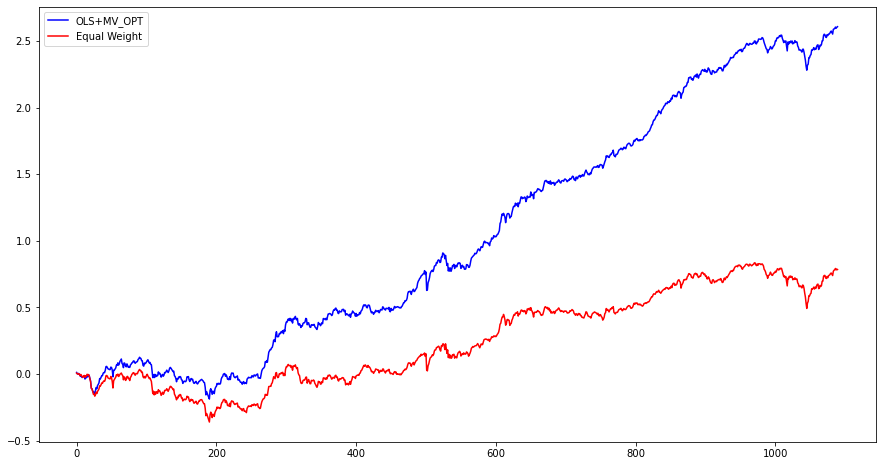

In [157]:
weight_lstm ,ret_lstm = portfolio_calculator(pred_lstm)

In [111]:
mod_svm_s = mod_svm.copy()

In [ ]:
pred_svm,mod_svm = train_model(train_n_predict_svm)

In [ ]:
weight_svm ,ret_svm = portfolio_calculator(pred_svm)

In [ ]:
pred_pca,mod_pca = train_model(train_n_predict_pca)

In [ ]:
weight_pca ,ret_pca = portfolio_calculator(pred_pca)

In [ ]:
pred_en,mod_en = train_model(train_n_predict_en)

In [ ]:
weight_en ,ret_en = portfolio_calculator(pred_en)

In [ ]:
pred_knn,mod_knn = train_model(train_n_predict_knn)

In [ ]:
weight_knn ,ret_knn = portfolio_calculator(pred_knn)

In [ ]:
pred_ols,mod_ols = train_model(train_n_predict_ols)

In [ ]:
weight_ols ,ret_ols = portfolio_calculator(pred_ols)

In [ ]:
pred_ew,mod_ew = train_model(train_n_predict_ew)

In [ ]:
weight_ew ,ret_ew = portfolio_calculator(pred_ew)

In [53]:
#pred_xgb1,mod_xgb1 = train_model(train_n_predict_xgb1)

In [ ]:
pred_xgb2,mod_xgb2 = train_model(train_n_predict_xgb2)

In [ ]:
weight_xgb2 ,ret_xgb2 = portfolio_calculator(pred_xgb2)

In [56]:
#pred_xgb3,mod_xgb3 = train_model(train_n_predict_xgb3)

In [ ]:
pred_rf,mod_rf = train_model(train_n_predict_rf)

In [ ]:
weight_rf ,ret_rf = portfolio_calculator(pred_rf)

In [68]:
v = {'pred':pred_ew,'model':mod_ew,'weight':weight_ew,'return':ret_ew}
save_variable(v,pickle_path + 'EW_dict')

'/Users/jason/JC/公告数据/EW_dict'

In [78]:
v = {'pred':pred_rf,'model':mod_rf,'weight':weight_rf,'return':ret_rf}
v['model'][20180102]
def FI_rf(v):
    return pd.DataFrame(v.feature_importances_,index = Factor_total_dict.keys(),columns = ['FI'])
v['model'] = {i:FI_rf(v['model'][i]) for i in v['model'].keys()}
save_variable(v,pickle_path + 'RF_dict')

'/Users/jason/JC/公告数据/RF_dict'

In [88]:
v = {'pred':pred_xgb2,'model':mod_xgb2,'weight':weight_xgb2,'return':ret_xgb2}
def FI_xgb(v):
    return pd.DataFrame(v.get_fscore(),index=['FI']).T
v['model'] = {i:FI_xgb(v['model'][i]) for i in v['model'].keys()}
save_variable(v,pickle_path + 'XGB_dict')

'/Users/jason/JC/公告数据/XGB_dict'

In [96]:
v = {'pred':pred_en,'model':mod_en,'weight':weight_en,'return':ret_en}
def FI_en(v):
    return pd.DataFrame(v.coef_[:-1],index = Factor_total_dict.keys(), columns = ['FI'])
v['model'] = {i:FI_en(v['model'][i]) for i in v['model'].keys()}
save_variable(v,pickle_path + 'EN_dict')

'/Users/jason/JC/公告数据/EN_dict'

In [98]:
v = {'pred':pred_knn,'model':mod_knn,'weight':weight_knn,'return':ret_knn}
v['model'] = {i:np.nan for i in v['model'].keys()}
save_variable(v,pickle_path + 'KNN_dict')

'/Users/jason/JC/公告数据/KNN_dict'

In [99]:
v = {'pred':pred_ols,'model':mod_ols,'weight':weight_ols,'return':ret_ols}
def FI_ols(v):
    return pd.DataFrame(v.params.iloc[:-1],columns = ['FI'])
v['model'] = {i:FI_ols(v['model'][i]) for i in v['model'].keys()}
save_variable(v,pickle_path + 'OLS_dict')

'/Users/jason/JC/公告数据/OLS_dict'

In [125]:
v = {'pred':pred_svm,'model':mod_svm_s,'weight':weight_svm,'return':ret_svm}
def FI_svm(v):
    return pd.DataFrame(v.coef_[0],index = Factor_total_dict.keys(),columns = ['FI'])
v['model'] = {i:FI_svm(v['model'][i]) for i in v['model'].keys()}
save_variable(v,pickle_path + 'SVM_dict')

'/Users/jason/JC/公告数据/SVM_dict'

In [131]:
v = {'pred':pred_pca,'model':mod_pca,'weight':weight_pca,'return':ret_pca}
def FI_pca(v):
    return pd.DataFrame(v[0],index = Factor_total_dict.keys(),columns = ['FI'])
v['model'] = {i:FI_pca(v['model'][i]) for i in v['model'].keys()}
save_variable(v,pickle_path + 'PCA_dict')

'/Users/jason/JC/公告数据/PCA_dict'

In [158]:
v = {'pred':pred_lstm,'model':mod_lstm,'weight':weight_lstm,'return':ret_lstm}
v['model'] = {i:np.nan for i in v['model'].keys()}
save_variable(v,pickle_path + 'LSTM_dict')

'/Users/jason/JC/公告数据/LSTM_dict'

In [332]:
ic_lst_ols = []
for i in range(0,len(date_input)):
    ic = pd.DataFrame([pred_ols[date_input[i]],real_ret[date_input[i]].dropna()]).T.corr().iloc[1,0]
    ic_lst_ols.append(ic)
    
ic_lst_xgb = []
for i in range(0,len(date_input)):
    ic = pd.DataFrame([pred_xgb[date_input[i]],real_ret[date_input[i]].dropna()]).T.corr().iloc[1,0]
    ic_lst_xgb.append(ic)
    
ic_lst_rf = []
for i in range(0,len(date_input)):
    ic = pd.DataFrame([pred_rf[date_input[i]],real_ret[date_input[i]].dropna()]).T.corr().iloc[1,0]
    ic_lst_rf.append(ic)


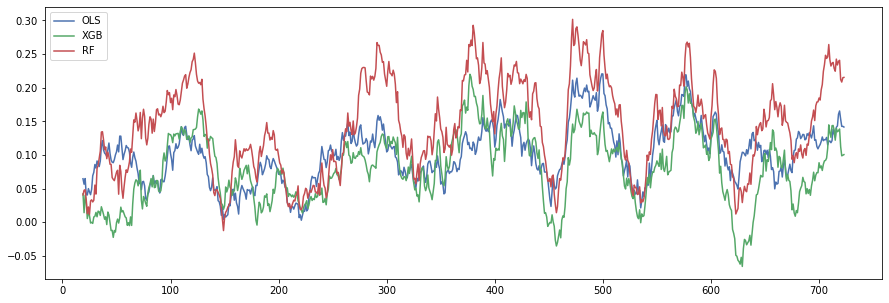

In [333]:
plt.figure(figsize=(15,5))
plt.plot(pd.DataFrame(ic_lst_ols).rolling(window=20).mean()[0])
plt.plot(pd.DataFrame(ic_lst_xgb).rolling(window=20).mean()[0])
plt.plot(pd.DataFrame(ic_lst_rf).rolling(window=20).mean()[0])
plt.legend(['OLS','XGB','RF'])